# Projet Camembert
### Objectifs
- Etape 1 : Recomposer sur 2014 la répartition hebdo des paniers sur un maximum de centres
- Etape 2 : Mettre en place un score pour noter l'équilibre alimentaire sur une semaine
- Etape 3 : Viz -> Sélection du centre > Accès aux semaines via un carré coloré reprenant le score > accès au camembert de la semaine

### Vous avez dit équililibre alimentaire ?

Voici la répartition du panier alimentaire équilibré tel que défini par la Croix-Rouge
<img src="panier.png">

In [1]:
import ujson as json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Correspondance des catégories au sein de la table itmcorres

Catégories de produit défines dans la base :

In [2]:
query = """SELECT
cat2,
COUNT(cat2) as nb_item
FROM [stojou.itmcorres]
GROUP BY cat2"""

cat = pd.read_gbq(query,project_id='croix-rouge-92715')

ImportError: Could not import Google API Client.

In [3]:
mapping_cat = {
    "FL": "Fruits Legumes",
    "PL2": "Produits laitiers",
    "LPL": "Produits laitiers",
    "VOP": "Viandes, poisson",
    "PFM": "Viandes, poisson", #PFM = Poissons, Fruits de mer ?
    "MTG": "Matieres grasses",
    "FEC": "Feculents",
    "PGS": "Produits gras",
    "EAU": "Hygiene, eau",
    "HYG": "Hygiene, eau",
    "SUC": "Autres",
    "CET": "Autres",
    "ACN": "Autres",
    "CHE": "Autres",
    "CSN": "Autres",
    "DGR": "Autres",
    "CAP": "Autres",
    "BON": "Autres",
    "BUR": "Autres",
    "PDP": "Autres",
    "ACL": "Autres",
    "PDV": "Autres",
    "ETL": "Autres",
    "CFT": "Autres",
    "ACH": "Autres",
    "CDM": "Autres",
    "ETM": "Autres",
    "MAT": "Autres"    
}

In [4]:
cat['new_catego'] = cat["cat2"].map(mapping_cat)
cat

,cat2,nb_item,new_catego
0,FL,13365,Fruits Legumes
1,VOP,17841,"Viandes, poisson"
2,PGS,40183,Produits gras
3,LPL,10509,Produits laitiers
4,FEC,9760,Feculents
5,EAU,829,"Hygiene, eau"
6,MTG,3537,Matieres grasses
7,HYG,3374,"Hygiene, eau"
8,ETM,1493,Autres
9,CDM,2958,Autres


## Au travail sur les données des produits fournis aux bénéficiaires

Query ci-dessous :
- Le numéro de pièce (VCRNUM_0) commence par "DIS" pour Distribution
- l'année est 2014
- Pour tous les dpts (patience, la query prend 2, 3 heaures chez moi...)
- Sur les catégories de produits mappées (+ de 90% des pdts distribués)


In [5]:
query = """SELECT
  date,
  cat2,
  dpt_nb,
  OWNER_0 Centre,
  Qty,
  VCRNUM_0 num_piece,
  Invoice.BPR beneficiaire_id,
  Invoice.YNBR taille_foyer
FROM (
Select 
  TIMESTAMP(CONCAT('20',SUBSTRING(IPTDAT_0,7,2),'-',SUBSTRING(IPTDAT_0,4,2),'-',SUBSTRING(IPTDAT_0,1,2), ' 00:00:00')) date,
  MONTH(TIMESTAMP(CONCAT('20',SUBSTRING(IPTDAT_0,7,2),'-',SUBSTRING(IPTDAT_0,4,2),'-',SUBSTRING(IPTDAT_0,1,2), ' 00:00:00'))) month,
  YEAR(TIMESTAMP(CONCAT('20',SUBSTRING(IPTDAT_0,7,2),'-',SUBSTRING(IPTDAT_0,4,2),'-',SUBSTRING(IPTDAT_0,1,2), ' 00:00:00'))) year,
  OWNER_0,
  ITMREF_0,
  CAST(QTYSTU_0 AS INTEGER) Qty,
  corres.cat2 AS cat2,
  VCRNUM_0
FROM [stojou.stojou] input
  JOIN (
    SELECT
      itemref,cat2
    FROM
      [stojou.itmcorres]) corres
    ON
      input.ITMREF_0 = corres.itemref
    WHERE corres.cat2 IN ('FL','FEC','VOP','LPL','PGS','PFM','PL2','MTG')
    
    ) AS joined
  
  JOIN (
    SELECT
      CD_U2A, CD_DEPT dpt_nb
    FROM
      [stojou.dim_u2a_ville]) dpt
  ON
    joined.OWNER_0 = dpt.CD_U2A
  LEFT JOIN (
    SELECT
      NUM,
      BPR,
      YNBR
    FROM
     [stojou.SINVOICE_M]) Invoice
  ON Invoice.NUM = joined.VCRNUM_0
    
WHERE
date >= TIMESTAMP('2014-01-01  00:00:00') AND
date < TIMESTAMP('2015-01-01  00:00:00') AND
dpt_nb IN ('91','92','93','94','95','75','76','77','33','34','13','69','77','78','60','70','89','30','80','44','66','59','79','81','82','83','84','85','86','87','88') AND
SUBSTRING(VCRNUM_0,0,3) == "DIS"
"""

paniers = pd.read_gbq(query,project_id='croix-rouge-92715')

Waiting for job to complete...


In [6]:
paniers = paniers.set_index(paniers['date'])

In [7]:
paniers['catego'] = paniers['cat2'].map(mapping_cat)

### Nettoyage : unusual quantities et centres inactifs
Après quelques essais, j'ai retenu comme "unusual quantity" le seuil de 20 produits identiques distribués à la même personnes.

In [8]:
paniers['taille_foyer'] = paniers['taille_foyer'].astype('int64')
unusual_qty = paniers[(paniers['Qty'] < -20) & (paniers['taille_foyer'] < 2)]
beneficiary_excluded = unusual_qty['Qty'].groupby(unusual_qty['beneficiaire_id']).sum().index

On exclut les bénéficiaires pour qui les quantités distribuées sont suspectes

In [9]:
paniers = paniers[~paniers['beneficiaire_id'].isin(beneficiary_excluded)]

Les Quantités positives semblent correspondre à des annulations en caisse (voir exemple ci-dessous).

On les sommera donc au moment de déterminer notre panier moyen.

In [10]:
paniers[paniers['num_piece'] == 'DIS140904005596']

,date,cat2,dpt_nb,Centre,Qty,num_piece,beneficiaire_id,taille_foyer,catego
date,,,,,,,,,
2014-09-04,2014-09-04,LPL,93,U9308,-2,DIS140904005596,140170353,4,Produits laitiers
2014-09-04,2014-09-04,FL,93,U9308,-2,DIS140904005596,140170353,4,Fruits Legumes
2014-09-04,2014-09-04,PGS,93,U9308,-1,DIS140904005596,140170353,4,Produits gras
2014-09-04,2014-09-04,FEC,93,U9308,-1,DIS140904005596,140170353,4,Feculents
2014-09-04,2014-09-04,FEC,93,U9308,-1,DIS140904005596,140170353,4,Feculents
2014-09-04,2014-09-04,PGS,93,U9308,-1,DIS140904005596,140170353,4,Produits gras
2014-09-04,2014-09-04,FEC,93,U9308,1,DIS140904005596,140170353,4,Feculents
2014-09-04,2014-09-04,FL,93,U9308,-1,DIS140904005596,140170353,4,Fruits Legumes
2014-09-04,2014-09-04,FL,93,U9308,-1,DIS140904005596,140170353,4,Fruits Legumes


### Nombre de semaines où on a de la data / centre

In [11]:
panier_serie2 = paniers['Qty'].groupby([paniers['date'], paniers['Centre']]).sum()
grouped2 = panier_serie2.unstack()
by_week2 = grouped2.resample('W',how='sum')

/usr/local/lib/python2.7/site-packages/pandas/core/index.py:4281: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1


In [12]:
active_weeks = pd.DataFrame()
active_weeks['nb_weeks'] = 49 - by_week2.isnull().sum()
active_weeks['total_qty'] = by_week2.sum()
active_weeks.sort_values('nb_weeks', ascending=False)

,nb_weeks,total_qty
Centre,,
U5909,49,-46197
U7804,49,-89259
U7803,49,-175767
U1309,48,-17460
U1311,48,-67694
U1304,47,-23893
U7808,47,-12493
U7901,47,-48907
U1307,47,-14151


## Détermination du panier moyen hebdo par centre et par semaine

In [13]:
new_paniers = paniers
centres_with_data = active_weeks[active_weeks['nb_weeks'] > 34].index
new_paniers = new_paniers[new_paniers['Centre'].isin(centres_with_data)]

In [14]:
panier_serie = new_paniers['Qty'].groupby([new_paniers['date'], new_paniers['catego'],new_paniers['Centre']]).sum()

In [15]:
grouped = panier_serie.unstack().unstack()

In [16]:
by_week = grouped.resample('W',how='sum').fillna(0)

In [17]:
Centres = by_week.columns.get_level_values(0)

In [18]:
by_week_percent = by_week
for Centre in Centres:
    tmp = by_week[Centre]
    rowSum = tmp.sum(1)
    by_week_percent[Centre] = tmp.divide(rowSum,axis=0) * 100

In [19]:
panier_serie2 = new_paniers['taille_foyer'].groupby([new_paniers['date'],new_paniers['Centre'],new_paniers['num_piece']]).mean()
repas_par_semaine = panier_serie2.unstack().sum(1).unstack().resample('W',how='sum').fillna(0)

## Juste pour le fun un petit exemple sur le premier centre

In [20]:
example = by_week_percent['U5901'][by_week_percent.index == by_week_percent.index[0]]

In [21]:
example

catego,Feculents,Fruits Legumes,Matieres grasses,Produits gras,Produits laitiers,"Viandes, poisson"
date,,,,,,
2014-01-05,26.086957,9.486166,-0,39.920949,24.505929,-0


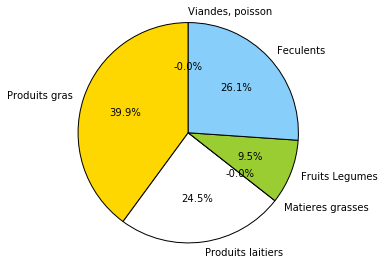

In [22]:
labels = example.columns[5],example.columns[3],example.columns[4],example.columns[2],example.columns[1],example.columns[0]
sizes = [  example.iloc[0][5],example.iloc[0][3],example.iloc[0][4],example.iloc[0][2],example.iloc[0][1],example.iloc[0][0]]
colors = ['tomato','gold', 'white','lightcoral','yellowgreen','lightskyblue']

plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')

fig = plt.figure()

## Proposition de calcul d'un score

En regardant le camembert ci-dessus, on se rend compte assez vite qu'un déséquilibre dans une catégorie de produit entraîne mécaniquement un déséquilibre dans une ou plusieurs autres.

Pour un centre et une semaine en particulier, pour chaque catégorie de produit on calcule l'écart à la répartition idéale et on garde le max de la valeur absolue comme écart.

Il s'agira ensuite fixer une échelle.

In [23]:
# Attention : j'ai utilisé une liste ici, pas très robuste, elle suit l'ordre des produits dans by_week_percent
desequilibrium = pd.DataFrame()
ideal = [25,33,2,2.5,25,12]
for Centre in centres_with_data:
    desequilibrium[Centre] = 100 - np.subtract(by_week_percent[Centre], ideal).abs().mean(1)

In [24]:
desequilibrium.head()

,U1301,U1302,U1304,U1306,U1307,U1308,U1309,U1311,U1312,U1313,...,U8905,U9101,U9102,U9103,U9201,U9203,U9208,U9211,U9306,U9504
date,,,,,,,,,,,,,,,,,,,,,
2014-01-05,83.546094,90.107143,NaN,89.388365,NaN,87.711216,NaN,88.172255,NaN,NaN,...,NaN,91.237976,87.189940,NaN,NaN,NaN,NaN,87.479885,NaN,NaN
2014-01-12,86.186027,91.453203,89.952448,90.182281,92.455479,NaN,89.100490,89.192324,88.541455,86.061007,...,86.782338,88.927656,87.582326,89.173077,88.364790,83.689348,85.417939,89.860063,NaN,89.846035
2014-01-19,85.686316,90.992279,91.662091,89.444093,85.154762,86.234127,87.867716,88.218290,86.098101,87.291435,...,90.727477,91.820048,89.286364,91.869048,89.197566,81.674731,86.760026,89.885659,NaN,91.422297
2014-01-26,85.951843,91.074859,91.079517,90.223856,85.570210,89.091056,91.014627,87.304819,87.291608,86.873955,...,88.166667,91.926821,88.291518,87.210630,89.418675,84.380435,87.354967,92.919578,NaN,91.236180
2014-02-02,87.683962,90.185103,92.428145,85.713626,87.717405,86.733972,85.090671,90.247749,88.472222,88.603937,...,90.404088,90.566736,86.620748,90.793544,89.047101,81.711388,87.542331,89.127637,NaN,91.624317


In [25]:
desequilibrium.describe()

,U1301,U1302,U1304,U1306,U1307,U1308,U1309,U1311,U1312,U1313,...,U8905,U9101,U9102,U9103,U9201,U9203,U9208,U9211,U9306,U9504
count,39.000000,41.000000,47.000000,44.000000,47.000000,43.000000,48.000000,48.000000,40.000000,35.000000,...,44.000000,41.000000,42.000000,42.000000,41.000000,39.000000,41.000000,41.000000,38.000000,39.000000
mean,88.894346,91.585922,89.516377,87.263111,83.273170,86.641736,90.327410,88.393729,87.922617,89.005831,...,88.546849,89.861556,89.251546,90.354193,86.480808,81.182156,86.223689,89.992705,86.796563,88.105374
std,3.395029,1.678943,3.124290,2.632037,4.662857,2.106344,2.957183,1.456475,2.952341,3.426237,...,2.308643,2.510381,2.446513,1.828831,3.193273,1.322582,1.688542,1.513488,4.370150,3.959183
min,81.279316,89.012712,80.546296,80.110465,75.159091,82.120432,82.814663,84.573488,80.719996,75.083333,...,81.725945,85.757678,85.702915,84.958333,77.833333,78.583333,81.476667,86.492424,78.416667,77.951095
25%,86.550917,90.473629,88.282227,85.457571,79.160523,85.056368,88.556816,87.318366,86.650101,88.304342,...,86.763451,88.205453,87.258333,89.260263,84.868217,80.234727,85.181779,88.916667,83.205943,86.604381
50%,89.001880,91.398148,89.491935,87.223304,84.276340,86.733972,90.678234,88.562514,88.277167,89.533619,...,89.116699,89.763582,88.424773,90.648075,87.133552,80.980337,86.273831,90.003623,86.879509,89.113572
75%,91.690631,92.087209,91.284977,89.554598,87.209455,87.902968,92.140105,89.371481,89.207881,91.085758,...,90.418750,91.353205,91.375035,91.599462,88.453488,81.687357,87.083587,91.037879,89.936190,90.928675
max,94.021905,96.814655,95.021144,91.479974,92.455479,90.722678,95.238266,91.904773,92.583333,91.954663,...,92.977390,97.056318,94.123362,93.665094,91.748585,84.380435,90.563013,92.919578,94.534372,93.588521


In [26]:
desequilibrium.min().min()
desequilibrium.max().max()

97.397304479878514

In [27]:
qte_min = (100 - desequilibrium.max().max())
qte_max = 100

In [28]:
qte_min

2.6026955201214861

In [29]:
by_centre = by_week_percent.copy()

for col in desequilibrium.columns.tolist():
    by_centre.loc[:,(col,"indice")] = desequilibrium[col]
    by_centre.loc[:,(col,"repas")] = repas_par_semaine[col]
    
by_centre


Centre          U1301                                                \
catego      Feculents Fruits Legumes Matieres grasses Produits gras   
date                                                                  
2014-01-05  10.081744       5.177112         1.089918     12.261580   
2014-01-12  16.498316       3.703704         1.851852     21.380471   
2014-01-19  12.018289       3.592423         1.698236     14.957544   
2014-01-26  12.763819      10.552764         3.115578     24.824121   
2014-02-02  19.433962      12.075472         3.018868     38.679245   
2014-02-09  19.263456       6.798867         3.399433     35.410765   
2014-02-16  17.496229       5.429864         3.016591     33.333333   
2014-02-23   9.104820      13.389441         1.224178     18.668707   
2014-03-02  17.900172      18.158348         1.893287     27.366609   
2014-03-09  15.178571      50.446429         1.488095     16.071429   
2014-03-16  12.754650      34.986714         1.062888     29.672276   
2014-03-23  18.595041      27.272727         5.371901     26.446281   
2014-03-30  14.713430      26.518392         4.875962     31.137725   
2014-04-06  18.566775      -2.605863        12.052117     48.859935   
2014-04-13  10.338346      22.368421         4.135338     30.451128   
2014-04-20  12.061069      11.755725         1.984733     25.343511   
2014-04-27  25.360231      13.544669         4.322767     31.700288   
2014-05-04        NaN            NaN              NaN           NaN   
2014-05-11  27.777778      19.444444         2.777778     47.222222   
2014-05-18  22.913257      13.747954         2.782324     36.824877   
2014-05-25  20.309811      26.506024         2.925990     28.399312   
2014-06-01        NaN            NaN              NaN           NaN   
2014-06-08  11.471322      13.466334         2.493766     51.870324   
2014-06-15  20.104439      18.015666         1.044386     26.631854   
2014-06-22  14.264706       4.705882         3.529412     21.617647   
2014-06-29  20.882852      35.314092         4.753820     14.261460   
2014-07-06  17.647059      44.117647         5.882353      5.882353   
2014-07-13        NaN            NaN              NaN           NaN   
2014-07-20        NaN            NaN              NaN           NaN   
2014-07-27        NaN            NaN              NaN           NaN   
2014-08-03        NaN            NaN              NaN           NaN   
2014-08-10        NaN            NaN              NaN           NaN   
2014-08-17        NaN            NaN              NaN           NaN   
2014-08-24        NaN            NaN              NaN           NaN   
2014-08-31  18.911175      26.074499         4.297994     34.957020   
2014-09-07   8.888889      24.242424         1.414141     13.939394   
2014-09-14   9.486781      30.482115         2.954899     15.396579   
2014-09-21   9.803922      54.367201         0.534759      8.199643   
2014-09-28  12.826603      31.472684         1.306413     13.895487   
2014-10-05  12.606838      28.205128         1.068376     11.752137   
2014-10-12   8.726003      31.239092         1.047120     12.565445   
2014-10-19   7.706767      18.984962         0.563910     10.651629   
2014-10-26   8.114558      28.798727         0.477327     11.933174   
2014-11-02  12.035124      31.869835         1.084711     10.020661   
2014-11-09  12.795549      32.614743         0.834492      8.414465   
2014-11-16   7.038627      36.480687         1.030043      9.356223   
2014-11-23   8.771930      36.074561         0.767544      9.429825   
2014-11-30   9.514031      30.937714         0.752909      8.008214   
2014-12-07        NaN            NaN              NaN           NaN   

Centre                                             U1302                 \
catego     Produits laitiers Viandes, poisson  Feculents Fruits Legumes   
date                                                                      
2014-01-05         64.850136         6.539510  31.168831       6.493506   
2014-01

In [30]:
d = {}

for c in set(by_centre.columns.get_level_values(0)):
    d[c] = by_centre[c].to_json(orient='index')
    
d


{u'U1301': '{"1388880000000":{"Feculents":10.0817438692,"Fruits Legumes":5.1771117166,"Matieres grasses":1.0899182561,"Produits gras":12.2615803815,"Produits laitiers":64.8501362398,"Viandes, poisson":6.5395095368,"indice":83.5460944596,"repas":17.0},"1389484800000":{"Feculents":16.4983164983,"Fruits Legumes":3.7037037037,"Matieres grasses":1.8518518519,"Produits gras":21.3804713805,"Produits laitiers":47.8114478114,"Viandes, poisson":8.7542087542,"indice":86.186026936,"repas":57.0},"1390089600000":{"Feculents":12.0182887002,"Fruits Legumes":3.5924232528,"Matieres grasses":1.6982364468,"Produits gras":14.9575440888,"Produits laitiers":25.5388634879,"Viandes, poisson":42.1946440235,"indice":85.6863161332,"repas":110.0},"1390694400000":{"Feculents":12.7638190955,"Fruits Legumes":10.5527638191,"Matieres grasses":3.1155778894,"Produits gras":24.824120603,"Produits laitiers":17.7889447236,"Viandes, poisson":30.9547738693,"indice":85.9518425461,"repas":96.0},"1391299200000":{"Feculents":19.4

Grandient allant de Rouge à vert http://colorzilla.com/gradient-editor/#f93131+15,f7f733+42,f7f733+58,79ea10+85


In [36]:
flat_data = {u'U1301': '{"1388880000000":{"Feculents":10.0817438692,"Fruits Legumes":5.1771117166,"Matieres grasses":1.0899182561,"Produits gras":12.2615803815,"Produits laitiers":64.8501362398,"Viandes, poisson":6.5395095368,"indice":83.5460944596,"repas":17.0},"1389484800000":{"Feculents":16.4983164983,"Fruits Legumes":3.7037037037,"Matieres grasses":1.8518518519,"Produits gras":21.3804713805,"Produits laitiers":47.8114478114,"Viandes, poisson":8.7542087542,"indice":86.186026936,"repas":57.0},"1390089600000":{"Feculents":12.0182887002,"Fruits Legumes":3.5924232528,"Matieres grasses":1.6982364468,"Produits gras":14.9575440888,"Produits laitiers":25.5388634879,"Viandes, poisson":42.1946440235,"indice":85.6863161332,"repas":110.0},"1390694400000":{"Feculents":12.7638190955,"Fruits Legumes":10.5527638191,"Matieres grasses":3.1155778894,"Produits gras":24.824120603,"Produits laitiers":17.7889447236,"Viandes, poisson":30.9547738693,"indice":85.9518425461,"repas":96.0},"1391299200000":{"Feculents":19.4339622642,"Fruits Legumes":12.0754716981,"Matieres grasses":3.0188679245,"Produits gras":38.679245283,"Produits laitiers":16.2264150943,"Viandes, poisson":10.5660377358,"indice":87.6839622642,"repas":72.0},"1391904000000":{"Feculents":19.2634560907,"Fruits Legumes":6.7988668555,"Matieres grasses":3.3994334278,"Produits gras":35.4107648725,"Produits laitiers":32.0113314448,"Viandes, poisson":3.1161473088,"indice":86.309490085,"repas":63.0},"1392508800000":{"Feculents":17.4962292609,"Fruits Legumes":5.4298642534,"Matieres grasses":3.0165912519,"Produits gras":33.3333333333,"Produits laitiers":30.7692307692,"Viandes, poisson":9.9547511312,"indice":87.5436148819,"repas":86.0},"1393113600000":{"Feculents":9.1048201989,"Fruits Legumes":13.389441469,"Matieres grasses":1.2241775057,"Produits gras":18.6687069625,"Produits laitiers":22.2647283856,"Viandes, poisson":35.3481254782,"indice":86.9110558531,"repas":80.0},"1393718400000":{"Feculents":17.900172117,"Fruits Legumes":18.1583476764,"Matieres grasses":1.8932874355,"Produits gras":27.3666092943,"Produits laitiers":11.5318416523,"Viandes, poisson":23.1497418244,"indice":88.0778829604,"repas":137.0},"1394323200000":{"Feculents":15.1785714286,"Fruits Legumes":50.4464285714,"Matieres grasses":1.4880952381,"Produits gras":16.0714285714,"Produits laitiers":15.1785714286,"Viandes, poisson":1.6369047619,"indice":89.744047619,"repas":50.0},"1394928000000":{"Feculents":12.7546501329,"Fruits Legumes":34.9867139061,"Matieres grasses":1.0628875111,"Produits gras":29.6722763508,"Produits laitiers":10.9831709477,"Viandes, poisson":10.5403011515,"indice":90.3636699144,"repas":105.0},"1395532800000":{"Feculents":18.5950413223,"Fruits Legumes":27.2727272727,"Matieres grasses":5.3719008264,"Produits gras":26.4462809917,"Produits laitiers":19.4214876033,"Viandes, poisson":2.8925619835,"indice":90.9772727273,"repas":29.0},"1396137600000":{"Feculents":14.7134302823,"Fruits Legumes":26.5183917879,"Matieres grasses":4.875962361,"Produits gras":31.1377245509,"Produits laitiers":2.3952095808,"Viandes, poisson":20.3592814371,"indice":86.7923438837,"repas":120.0},"1396742400000":{"Feculents":18.5667752443,"Fruits Legumes":-2.6058631922,"Matieres grasses":12.0521172638,"Produits gras":48.8599348534,"Produits laitiers":14.657980456,"Viandes, poisson":8.4690553746,"indice":81.2793159609,"repas":67.0},"1397347200000":{"Feculents":10.3383458647,"Fruits Legumes":22.3684210526,"Matieres grasses":4.1353383459,"Produits gras":30.4511278195,"Produits laitiers":0.1879699248,"Viandes, poisson":32.5187969925,"indice":83.2149122807,"repas":68.0},"1397952000000":{"Feculents":12.0610687023,"Fruits Legumes":11.7557251908,"Matieres grasses":1.9847328244,"Produits gras":25.3435114504,"Produits laitiers":28.2442748092,"Viandes, poisson":20.6106870229,"indice":88.5171755725,"repas":63.0},"1398556800000":{"Feculents":25.3602305476,"Fruits Legumes":13.5446685879,"Matieres grasses":4.3227665706,"Produits gras":31.7002881844,"Produits laitiers":13.6407300672,"Viandes, poisson":11.4313160423,"indice":89.4555715658,"repas":170.0},"1399161600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1399766400000":{"Feculents":27.7777777778,"Fruits Legumes":19.4444444444,"Matieres grasses":2.7777777778,"Produits gras":47.2222222222,"Produits laitiers":0.0,"Viandes, poisson":2.7777777778,"indice":83.9907407407,"repas":9.0},"1400371200000":{"Feculents":22.9132569558,"Fruits Legumes":13.7479541735,"Matieres grasses":2.7823240589,"Produits gras":36.8248772504,"Produits laitiers":21.9312602291,"Viandes, poisson":1.8003273322,"indice":88.3809328969,"repas":130.0},"1400976000000":{"Feculents":20.3098106713,"Fruits Legumes":26.5060240964,"Matieres grasses":2.925989673,"Produits gras":28.3993115318,"Produits laitiers":20.1376936317,"Viandes, poisson":1.7211703959,"indice":91.1415662651,"repas":114.0},"1401580800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1402185600000":{"Feculents":11.4713216958,"Fruits Legumes":13.4663341646,"Matieres grasses":2.493765586,"Produits gras":51.8703241895,"Produits laitiers":19.4513715711,"Viandes, poisson":1.246882793,"indice":83.4619700748,"repas":42.0},"1402790400000":{"Feculents":20.1044386423,"Fruits Legumes":18.0156657963,"Matieres grasses":1.044386423,"Produits gras":26.6318537859,"Produits laitiers":24.2819843342,"Viandes, poisson":9.9216710183,"indice":92.0393820714,"repas":44.0},"1403395200000":{"Feculents":14.2647058824,"Fruits Legumes":4.7058823529,"Matieres grasses":3.5294117647,"Produits gras":21.6176470588,"Produits laitiers":53.3823529412,"Viandes, poisson":2.5,"indice":83.7401960784,"repas":66.0},"1404000000000":{"Feculents":20.882852292,"Fruits Legumes":35.3140916808,"Matieres grasses":4.753820034,"Produits gras":14.2614601019,"Produits laitiers":8.4889643463,"Viandes, poisson":16.298811545,"indice":93.0406055461,"repas":86.0},"1404604800000":{"Feculents":17.6470588235,"Fruits Legumes":44.1176470588,"Matieres grasses":5.8823529412,"Produits gras":5.8823529412,"Produits laitiers":2.9411764706,"Viandes, poisson":23.5294117647,"indice":90.112745098,"repas":10.0},"1405209600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1405814400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1406419200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407024000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":18.9111747851,"Fruits Legumes":26.0744985673,"Matieres grasses":4.2979942693,"Produits gras":34.9570200573,"Produits laitiers":10.6017191977,"Viandes, poisson":5.1575931232,"indice":88.4983285578,"repas":39.0},"1410048000000":{"Feculents":8.8888888889,"Fruits Legumes":24.2424242424,"Matieres grasses":1.4141414141,"Produits gras":13.9393939394,"Produits laitiers":48.0808080808,"Viandes, poisson":3.4343434343,"indice":88.5765993266,"repas":26.0},"1410652800000":{"Feculents":9.4867807154,"Fruits Legumes":30.4821150855,"Matieres grasses":2.9548989114,"Produits gras":15.3965785381,"Produits laitiers":36.3919129082,"Viandes, poisson":5.2877138414,"indice":91.6688698808,"repas":37.0},"1411257600000":{"Feculents":9.8039215686,"Fruits Legumes":54.367201426,"Matieres grasses":0.5347593583,"Produits gras":8.1996434938,"Produits laitiers":21.568627451,"Viandes, poisson":5.5258467023,"indice":91.0610516934,"repas":44.0},"1411862400000":{"Feculents":12.8266033254,"Fruits Legumes":31.4726840855,"Matieres grasses":1.3064133017,"Produits gras":13.8954869359,"Produits laitiers":38.7173396675,"Viandes, poisson":1.7814726841,"indice":91.7123911322,"repas":54.0},"1412467200000":{"Feculents":12.6068376068,"Fruits Legumes":28.2051282051,"Matieres grasses":1.0683760684,"Produits gras":11.7521367521,"Produits laitiers":45.2991452991,"Viandes, poisson":1.0683760684,"indice":90.2329059829,"repas":24.0},"1413072000000":{"Feculents":8.7260034904,"Fruits Legumes":31.2390924956,"Matieres grasses":1.0471204188,"Produits gras":12.5654450262,"Produits laitiers":38.5689354276,"Viandes, poisson":7.8534031414,"indice":92.2052065154,"repas":28.0},"1413676800000":{"Feculents":7.7067669173,"Fruits Legumes":18.984962406,"Matieres grasses":0.5639097744,"Produits gras":10.6516290727,"Produits laitiers":45.9273182957,"Viandes, poisson":16.1654135338,"indice":89.0018796992,"repas":61.0},"1414281600000":{"Feculents":8.1145584726,"Fruits Legumes":28.7987271281,"Matieres grasses":0.477326969,"Produits gras":11.9331742243,"Produits laitiers":40.015910899,"Viandes, poisson":10.6603023071,"indice":91.9336382922,"repas":44.0},"1414886400000":{"Feculents":12.0351239669,"Fruits Legumes":31.8698347107,"Matieres grasses":1.0847107438,"Produits gras":10.020661157,"Produits laitiers":36.5185950413,"Viandes, poisson":8.4710743802,"indice":93.7369146006,"repas":80.0},"1415491200000":{"Feculents":12.7955493741,"Fruits Legumes":32.6147426982,"Matieres grasses":0.8344923505,"Produits gras":8.4144645341,"Produits laitiers":21.0709318498,"Viandes, poisson":24.2698191933,"indice":94.0219054242,"repas":72.0},"1416096000000":{"Feculents":7.0386266094,"Fruits Legumes":36.4806866953,"Matieres grasses":1.0300429185,"Produits gras":9.356223176,"Produits laitiers":24.4635193133,"Viandes, poisson":21.6309012876,"indice":93.4273962804,"repas":48.0},"1416700800000":{"Feculents":8.7719298246,"Fruits Legumes":36.0745614035,"Matieres grasses":0.7675438596,"Produits gras":9.4298245614,"Produits laitiers":22.423245614,"Viandes, poisson":22.5328947368,"indice":93.2375730994,"repas":86.0},"1417305600000":{"Feculents":9.5140314853,"Fruits Legumes":30.9377138946,"Matieres grasses":0.7529089665,"Produits gras":8.0082135524,"Produits laitiers":39.4934976044,"Viandes, poisson":11.2936344969,"indice":93.4160962811,"repas":88.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U1302': '{"1388880000000":{"Feculents":31.1688311688,"Fruits Legumes":6.4935064935,"Matieres grasses":5.1948051948,"Produits gras":12.987012987,"Produits laitiers":22.0779220779,"Viandes, poisson":22.0779220779,"indice":90.1071428571,"repas":10.0},"1389484800000":{"Feculents":32.1321321321,"Fruits Legumes":10.2852852853,"Matieres grasses":1.6516516517,"Produits gras":16.2162162162,"Produits laitiers":22.6726726727,"Viandes, poisson":17.042042042,"indice":91.4532032032,"repas":136.0},"1390089600000":{"Feculents":34.1054313099,"Fruits Legumes":8.1469648562,"Matieres grasses":0.0798722045,"Produits gras":12.9392971246,"Produits laitiers":27.4760383387,"Viandes, poisson":17.2523961661,"indice":90.9922790202,"repas":147.0},"1390694400000":{"Feculents":28.0602636535,"Fruits Legumes":7.3446327684,"Matieres grasses":1.1299435028,"Produits gras":14.9717514124,"Produits laitiers":26.1770244821,"Viandes, poisson":22.3163841808,"indice":91.0748587571,"repas":114.0},"1391299200000":{"Feculents":23.185840708,"Fruits Legumes":10.4424778761,"Matieres grasses":4.4247787611,"Produits gras":14.6902654867,"Produits laitiers":20.1769911504,"Viandes, poisson":27.0796460177,"indice":90.1851032448,"repas":65.0},"1391904000000":{"Feculents":26.0928961749,"Fruits Legumes":9.2896174863,"Matieres grasses":4.5765027322,"Produits gras":13.5245901639,"Produits laitiers":20.4234972678,"Viandes, poisson":26.0928961749,"indice":90.487704918,"repas":135.0},"1392508800000":{"Feculents":27.5683665928,"Fruits Legumes":12.1212121212,"Matieres grasses":4.6563192905,"Produits gras":10.125646711,"Produits laitiers":20.9903917221,"Viandes, poisson":24.5380635625,"indice":91.6205346144,"repas":129.0},"1393113600000":{"Feculents":32.6961770624,"Fruits Legumes":6.4386317907,"Matieres grasses":5.23138833,"Produits gras":8.5513078471,"Produits laitiers":26.0563380282,"Viandes, poisson":21.0261569416,"indice":91.0628772636,"repas":121.0},"1393718400000":{"Feculents":29.0322580645,"Fruits Legumes":10.9318996416,"Matieres grasses":4.8387096774,"Produits gras":6.6308243728,"Produits laitiers":24.9103942652,"Viandes, poisson":23.6559139785,"indice":92.5307646356,"repas":60.0},"1394323200000":{"Feculents":33.3986287953,"Fruits Legumes":8.6190009794,"Matieres grasses":6.0724779628,"Produits gras":6.5621939275,"Produits laitiers":27.9138099902,"Viandes, poisson":17.4338883448,"indice":91.7896669931,"repas":123.0},"1394928000000":{"Feculents":27.6470588235,"Fruits Legumes":10.6722689076,"Matieres grasses":5.7142857143,"Produits gras":6.8067226891,"Produits laitiers":28.3193277311,"Viandes, poisson":20.8403361345,"indice":92.4740896359,"repas":132.0},"1395532800000":{"Feculents":26.368159204,"Fruits Legumes":13.8308457711,"Matieres grasses":7.3631840796,"Produits gras":7.7611940299,"Produits laitiers":32.1393034826,"Viandes, poisson":12.5373134328,"indice":93.5269485904,"repas":121.0},"1396137600000":{"Feculents":28.7005649718,"Fruits Legumes":13.4463276836,"Matieres grasses":4.8587570621,"Produits gras":7.9096045198,"Produits laitiers":28.9265536723,"Viandes, poisson":16.1581920904,"indice":93.3987758945,"repas":99.0},"1396742400000":{"Feculents":21.875,"Fruits Legumes":38.7931034483,"Matieres grasses":4.7413793103,"Produits gras":3.7715517241,"Produits laitiers":19.5043103448,"Viandes, poisson":11.3146551724,"indice":96.8146551724,"repas":67.0},"1397347200000":{"Feculents":27.1416454623,"Fruits Legumes":30.9584393554,"Matieres grasses":4.834605598,"Produits gras":8.0576759966,"Produits laitiers":22.5614927905,"Viandes, poisson":6.4461407973,"indice":96.5720243144,"repas":135.0},"1397952000000":{"Feculents":36.4341085271,"Fruits Legumes":13.9534883721,"Matieres grasses":6.3953488372,"Produits gras":9.7868217054,"Produits laitiers":25.8720930233,"Viandes, poisson":7.5581395349,"indice":92.0872093023,"repas":137.0},"1398556800000":{"Feculents":32.310177706,"Fruits Legumes":9.8546042003,"Matieres grasses":4.6849757674,"Produits gras":13.2471728595,"Produits laitiers":28.9176090468,"Viandes, poisson":10.98546042,"indice":91.8633548735,"repas":91.0},"1399161600000":{"Feculents":33.6898395722,"Fruits Legumes":14.4385026738,"Matieres grasses":6.1497326203,"Produits gras":13.1016042781,"Produits laitiers":25.4010695187,"Viandes, poisson":7.2192513369,"indice":92.1359180036,"repas":51.0},"1399766400000":{"Feculents":30.753968254,"Fruits Legumes":17.4603174603,"Matieres grasses":8.3333333333,"Produits gras":16.4682539683,"Produits laitiers":19.8412698413,"Viandes, poisson":7.1428571429,"indice":91.3981481481,"repas":66.0},"1400371200000":{"Feculents":38.5171790235,"Fruits Legumes":14.0144665461,"Matieres grasses":1.7179023508,"Produits gras":17.8119349005,"Produits laitiers":19.2585895118,"Viandes, poisson":8.6799276673,"indice":90.473628692,"repas":176.0},"1400976000000":{"Feculents":40.3329065301,"Fruits Legumes":15.7490396927,"Matieres grasses":0.0,"Produits gras":16.133162612,"Produits laitiers":18.0537772087,"Viandes, poisson":9.7311139565,"indice":90.4279769526,"repas":107.0},"1401580800000":{"Feculents":38.6694386694,"Fruits Legumes":14.1372141372,"Matieres grasses":0.0,"Produits gras":18.711018711,"Produits laitiers":21.2058212058,"Viandes, poisson":7.2765072765,"indice":90.1231808732,"repas":69.0},"1402185600000":{"Feculents":38.6449184442,"Fruits Legumes":11.5432873275,"Matieres grasses":0.0,"Produits gras":15.4328732748,"Produits laitiers":24.2158092848,"Viandes, poisson":10.1631116688,"indice":91.224069427,"repas":104.0},"1402790400000":{"Feculents":32.980332829,"Fruits Legumes":7.7155824508,"Matieres grasses":0.0,"Produits gras":20.8774583964,"Produits laitiers":30.1059001513,"Viandes, poisson":8.3207261725,"indice":89.5954362078,"repas":104.0},"1403395200000":{"Feculents":28.3018867925,"Fruits Legumes":10.5660377358,"Matieres grasses":0.0,"Produits gras":19.3710691824,"Produits laitiers":30.1886792453,"Viandes, poisson":11.572327044,"indice":91.6294549266,"repas":133.0},"1404000000000":{"Feculents":31.4439946019,"Fruits Legumes":7.2874493927,"Matieres grasses":0.0,"Produits gras":17.2739541161,"Produits laitiers":29.8245614035,"Viandes, poisson":14.1700404858,"indice":90.6791497976,"repas":105.0},"1404604800000":{"Feculents":37.8812199037,"Fruits Legumes":7.4906367041,"Matieres grasses":0.0,"Produits gras":17.0679507758,"Produits laitiers":28.5714285714,"Viandes, poisson":8.9887640449,"indice":89.743133583,"repas":263.0},"1405209600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1405814400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1406419200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407024000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":42.8571428571,"Fruits Legumes":8.253968254,"Matieres grasses":6.6666666667,"Produits gras":9.0476190476,"Produits laitiers":26.6666666667,"Viandes, poisson":6.5079365079,"indice":89.8373015873,"repas":88.0},"1410652800000":{"Feculents":41.9962335217,"Fruits Legumes":6.9679849341,"Matieres grasses":6.7796610169,"Produits gras":13.9359698682,"Produits laitiers":22.5988700565,"Viandes, poisson":7.7212806026,"indice":89.0127118644,"repas":71.0},"1411257600000":{"Feculents":40.6211180124,"Fruits Legumes":10.3105590062,"Matieres grasses":6.3354037267,"Produits gras":12.298136646,"Produits laitiers":22.2360248447,"Viandes, poisson":8.198757764,"indice":90.1651138716,"repas":113.0},"1411862400000":{"Feculents":39.4812680115,"Fruits Legumes":10.3746397695,"Matieres grasses":4.8991354467,"Produits gras":12.3919308357,"Produits laitiers":18.4438040346,"Viandes, poisson":14.409221902,"indice":90.189481268,"repas":45.0},"1412467200000":{"Feculents":28.75,"Fruits Legumes":14.1666666667,"Matieres grasses":8.125,"Produits gras":13.75,"Produits laitiers":20.0,"Viandes, poisson":15.2083333333,"indice":91.9722222222,"repas":62.0},"1413072000000":{"Feculents":21.9088937093,"Fruits Legumes":13.6659436009,"Matieres grasses":9.7613882863,"Produits gras":13.4490238612,"Produits laitiers":26.8980477223,"Viandes, poisson":14.31670282,"indice":92.4416124367,"repas":134.0},"1413676800000":{"Feculents":25.1682368775,"Fruits Legumes":9.4212651413,"Matieres grasses":11.4401076716,"Produits gras":12.3822341857,"Produits laitiers":24.7644683715,"Viandes, poisson":16.8236877524,"indice":91.9785778376,"repas":96.0},"1414281600000":{"Feculents":21.0918114144,"Fruits Legumes":10.4218362283,"Matieres grasses":11.1662531017,"Produits gras":11.9106699752,"Produits laitiers":25.8064516129,"Viandes, poisson":19.6029776675,"indice":91.0878825476,"repas":51.0},"1414886400000":{"Feculents":27.7353689567,"Fruits Legumes":8.3969465649,"Matieres grasses":9.4147582697,"Produits gras":12.213740458,"Produits laitiers":25.1908396947,"Viandes, poisson":17.048346056,"indice":91.715648855,"repas":56.0},"1415491200000":{"Feculents":31.5573770492,"Fruits Legumes":6.8852459016,"Matieres grasses":10.0,"Produits gras":12.2950819672,"Produits laitiers":26.3114754098,"Viandes, poisson":12.9508196721,"indice":91.2117486339,"repas":147.0},"1416096000000":{"Feculents":28.5907859079,"Fruits Legumes":7.4525745257,"Matieres grasses":11.7886178862,"Produits gras":10.162601626,"Produits laitiers":32.1138211382,"Viandes, poisson":9.891598916,"indice":90.6980578139,"repas":96.0},"1416700800000":{"Feculents":23.6430542778,"Fruits Legumes":11.4075436983,"Matieres grasses":13.4314627415,"Produits gras":8.8316467341,"Produits laitiers":32.7506899724,"Viandes, poisson":9.9356025759,"indice":91.5787335173,"repas":139.0},"1417305600000":{"Feculents":21.7970049917,"Fruits Legumes":12.8119800333,"Matieres grasses":12.9783693844,"Produits gras":8.8186356073,"Produits laitiers":29.7836938436,"Viandes, poisson":13.8103161398,"indice":92.119661675,"repas":85.0},"1417910400000":{"Feculents":24.0740740741,"Fruits Legumes":22.4867724868,"Matieres grasses":9.5238095238,"Produits gras":6.6137566138,"Produits laitiers":26.9841269841,"Viandes, poisson":10.3174603175,"indice":95.5427689594,"repas":48.0}}',
 u'U1304': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":20.5649717514,"Fruits Legumes":10.2824858757,"Matieres grasses":9.2655367232,"Produits gras":20.3389830508,"Produits laitiers":22.2598870056,"Viandes, poisson":17.2881355932,"indice":89.9524482109,"repas":137.0},"1390089600000":{"Feculents":22.2961730449,"Fruits Legumes":18.46921797,"Matieres grasses":2.1630615641,"Produits gras":16.306156406,"Produits laitiers":17.4708818636,"Viandes, poisson":23.2945091514,"indice":91.6620909595,"repas":112.0},"1390694400000":{"Feculents":15.812431843,"Fruits Legumes":19.7382769902,"Matieres grasses":4.3620501636,"Produits gras":10.2508178844,"Produits laitiers":20.9378407852,"Viandes, poisson":28.8985823337,"indice":91.0795165394,"repas":154.0},"1391299200000":{"Feculents":19.696969697,"Fruits Legumes":23.0027548209,"Matieres grasses":1.5151515152,"Produits gras":15.2892561983,"Produits laitiers":18.3195592287,"Viandes, poisson":22.1763085399,"indice":92.4281450872,"repas":118.0},"1391904000000":{"Feculents":15.2631578947,"Fruits Legumes":17.5,"Matieres grasses":7.6315789474,"Produits gras":18.6842105263,"Produits laitiers":17.6315789474,"Viandes, poisson":23.2894736842,"indice":89.048245614,"repas":109.0},"1392508800000":{"Feculents":12.9548762737,"Fruits Legumes":12.9548762737,"Matieres grasses":6.2590975255,"Produits gras":14.8471615721,"Produits laitiers":23.7263464338,"Viandes, poisson":29.2576419214,"indice":88.795366327,"repas":110.0},"1393113600000":{"Feculents":18.0494905386,"Fruits Legumes":14.5560407569,"Matieres grasses":4.3668122271,"Produits gras":10.9170305677,"Produits laitiers":21.9796215429,"Viandes, poisson":30.1310043668,"indice":90.4450509461,"repas":115.0},"1393718400000":{"Feculents":13.6412459721,"Fruits Legumes":10.8485499463,"Matieres grasses":3.2223415682,"Produits gras":24.9194414608,"Produits laitiers":19.8711063373,"Viandes, poisson":27.4973147154,"indice":87.0369674185,"repas":128.0},"1394323200000":{"Feculents":23.0623818526,"Fruits Legumes":8.3175803403,"Matieres grasses":7.7504725898,"Produits gras":20.415879017,"Produits laitiers":17.3913043478,"Viandes, poisson":23.0623818526,"indice":88.5070888469,"repas":102.0},"1394928000000":{"Feculents":12.5356125356,"Fruits Legumes":10.5413105413,"Matieres grasses":2.2792022792,"Produits gras":18.2336182336,"Produits laitiers":28.9173789174,"Viandes, poisson":27.4928774929,"indice":88.2756410256,"repas":107.0},"1395532800000":{"Feculents":18.085106383,"Fruits Legumes":13.1205673759,"Matieres grasses":1.2411347518,"Produits gras":21.4539007092,"Produits laitiers":20.9219858156,"Viandes, poisson":25.1773049645,"indice":89.3729314421,"repas":112.0},"1396137600000":{"Feculents":17.3469387755,"Fruits Legumes":17.3469387755,"Matieres grasses":0.2040816327,"Produits gras":15.7142857143,"Produits laitiers":18.9795918367,"Viandes, poisson":30.4081632653,"indice":89.5425170068,"repas":104.0},"1396742400000":{"Feculents":15.8273381295,"Fruits Legumes":11.654676259,"Matieres grasses":5.1798561151,"Produits gras":21.2949640288,"Produits laitiers":20.4316546763,"Viandes, poisson":25.6115107914,"indice":88.2212230216,"repas":115.0},"1397347200000":{"Feculents":15.6462585034,"Fruits Legumes":21.9954648526,"Matieres grasses":2.2675736961,"Produits gras":14.7392290249,"Produits laitiers":22.4489795918,"Viandes, poisson":22.9024943311,"indice":92.2802343159,"repas":101.0},"1397952000000":{"Feculents":18.7012987013,"Fruits Legumes":24.9350649351,"Matieres grasses":1.038961039,"Produits gras":16.1038961039,"Produits laitiers":23.6363636364,"Viandes, poisson":15.5844155844,"indice":94.3538961039,"repas":103.0},"1398556800000":{"Feculents":15.4696132597,"Fruits Legumes":33.3333333333,"Matieres grasses":0.7366482505,"Produits gras":19.5211786372,"Produits laitiers":20.4419889503,"Viandes, poisson":10.4972375691,"indice":94.2984960098,"repas":84.0},"1399161600000":{"Feculents":18.6842105263,"Fruits Legumes":26.0526315789,"Matieres grasses":3.4210526316,"Produits gras":18.1578947368,"Produits laitiers":20.0,"Viandes, poisson":13.6842105263,"indice":93.8289473684,"repas":94.0},"1399766400000":{"Feculents":9.8639455782,"Fruits Legumes":17.1768707483,"Matieres grasses":2.7210884354,"Produits gras":26.7006802721,"Produits laitiers":12.5850340136,"Viandes, poisson":30.9523809524,"indice":85.45861678,"repas":80.0},"1400371200000":{"Feculents":16.9902912621,"Fruits Legumes":32.8478964401,"Matieres grasses":2.427184466,"Produits gras":20.5501618123,"Produits laitiers":15.6957928803,"Viandes, poisson":11.4886731392,"indice":93.9242179072,"repas":82.0},"1400976000000":{"Feculents":14.0105078809,"Fruits Legumes":39.2294220665,"Matieres grasses":1.0507880911,"Produits gras":27.3204903678,"Produits laitiers":7.0052539405,"Viandes, poisson":11.3835376532,"indice":89.7333625219,"repas":102.0},"1401580800000":{"Feculents":21.4925373134,"Fruits Legumes":36.1194029851,"Matieres grasses":0.8955223881,"Produits gras":28.0597014925,"Produits laitiers":2.9850746269,"Viandes, poisson":10.447761194,"indice":90.5236318408,"repas":74.0},"1402185600000":{"Feculents":21.8823529412,"Fruits Legumes":18.1176470588,"Matieres grasses":6.5882352941,"Produits gras":28.2352941176,"Produits laitiers":14.5882352941,"Viandes, poisson":10.5882352941,"indice":89.9754901961,"repas":96.0},"1402790400000":{"Feculents":14.4927536232,"Fruits Legumes":33.0434782609,"Matieres grasses":0.2898550725,"Produits gras":31.3043478261,"Produits laitiers":17.3913043478,"Viandes, poisson":3.4782608696,"indice":90.4673913043,"repas":84.0},"1403395200000":{"Feculents":16.5865384615,"Fruits Legumes":35.5769230769,"Matieres grasses":1.6826923077,"Produits gras":17.0673076923,"Produits laitiers":23.3173076923,"Viandes, poisson":5.7692307692,"indice":94.3685897436,"repas":112.0},"1404000000000":{"Feculents":17.0149253731,"Fruits Legumes":31.3432835821,"Matieres grasses":1.4925373134,"Produits gras":17.0149253731,"Produits laitiers":25.671641791,"Viandes, poisson":7.4626865672,"indice":95.0211442786,"repas":104.0},"1404604800000":{"Feculents":20.6790123457,"Fruits Legumes":12.6543209877,"Matieres grasses":5.8641975309,"Produits gras":34.2592592593,"Produits laitiers":21.9135802469,"Viandes, poisson":4.6296296296,"indice":88.2088477366,"repas":92.0},"1405209600000":{"Feculents":19.1176470588,"Fruits Legumes":23.5294117647,"Matieres grasses":0.0,"Produits gras":24.6323529412,"Produits laitiers":21.6911764706,"Viandes, poisson":11.0294117647,"indice":92.7058823529,"repas":85.0},"1405814400000":{"Feculents":12.9032258065,"Fruits Legumes":18.6379928315,"Matieres grasses":0.0,"Produits gras":44.8028673835,"Produits laitiers":20.7885304659,"Viandes, poisson":2.8673835125,"indice":85.9823775388,"repas":81.0},"1406419200000":{"Feculents":14.6198830409,"Fruits Legumes":11.6959064327,"Matieres grasses":0.0,"Produits gras":61.1111111111,"Produits laitiers":9.649122807,"Viandes, poisson":2.9239766082,"indice":80.5462962963,"repas":51.0},"1407024000000":{"Feculents":33.5365853659,"Fruits Legumes":23.1707317073,"Matieres grasses":0.0,"Produits gras":34.756097561,"Produits laitiers":4.8780487805,"Viandes, poisson":3.6585365854,"indice":86.4857723577,"repas":66.0},"1407628800000":{"Feculents":17.1875,"Fruits Legumes":10.625,"Matieres grasses":0.0,"Produits gras":58.75,"Produits laitiers":11.25,"Viandes, poisson":2.1875,"indice":81.3333333333,"repas":60.0},"1408233600000":{"Feculents":32.1608040201,"Fruits Legumes":19.0954773869,"Matieres grasses":0.0,"Produits gras":45.2261306533,"Produits laitiers":0.0,"Viandes, poisson":3.5175879397,"indice":83.4543551089,"repas":69.0},"1408838400000":{"Feculents":22.7397260274,"Fruits Legumes":16.1643835616,"Matieres grasses":0.0,"Produits gras":41.9178082192,"Produits laitiers":15.3424657534,"Viandes, poisson":3.8356164384,"indice":86.9440639269,"repas":67.0},"1409443200000":{"Feculents":20.4379562044,"Fruits Legumes":21.897810219,"Matieres grasses":0.0,"Produits gras":23.7226277372,"Produits laitiers":25.9124087591,"Viandes, poisson":8.0291970803,"indice":92.7049878345,"repas":83.0},"1410048000000":{"Feculents":26.8442622951,"Fruits Legumes":19.0573770492,"Matieres grasses":0.0,"Produits gras":26.4344262295,"Produits laitiers":19.262295082,"Viandes, poisson":8.4016393443,"indice":91.4904371585,"repas":98.0},"1410652800000":{"Feculents":25.6267409471,"Fruits Legumes":12.2562674095,"Matieres grasses":5.2924791086,"Produits gras":32.0334261838,"Produits laitiers":17.2701949861,"Viandes, poisson":7.5208913649,"indice":88.9324512535,"repas":96.0},"1411257600000":{"Feculents":20.3271028037,"Fruits Legumes":10.5140186916,"Matieres grasses":3.738317757,"Produits gras":34.1121495327,"Produits laitiers":21.7289719626,"Viandes, poisson":9.5794392523,"indice":88.9665109034,"repas":95.0},"1411862400000":{"Feculents":21.3709677419,"Fruits Legumes":10.8870967742,"Matieres grasses":1.6129032258,"Produits gras":28.2258064516,"Produits laitiers":31.0483870968,"Viandes, poisson":6.8548387097,"indice":89.4919354839,"repas":123.0},"1412467200000":{"Feculents":21.9135802469,"Fruits Legumes":10.1851851852,"Matieres grasses":3.0864197531,"Produits gras":28.549382716,"Produits laitiers":24.2283950617,"Viandes, poisson":12.037037037,"indice":91.0257201646,"repas":130.0},"1413072000000":{"Feculents":18.4931506849,"Fruits Legumes":7.0205479452,"Matieres grasses":4.9657534247,"Produits gras":29.7945205479,"Produits laitiers":22.602739726,"Viandes, poisson":17.1232876712,"indice":88.2888127854,"repas":109.0},"1413676800000":{"Feculents":16.0120845921,"Fruits Legumes":8.1570996979,"Matieres grasses":2.1148036254,"Produits gras":34.2900302115,"Produits laitiers":25.2265861027,"Viandes, poisson":14.1993957704,"indice":88.6397280967,"repas":126.0},"1414281600000":{"Feculents":19.1489361702,"Fruits Legumes":6.2193126023,"Matieres grasses":1.9639934534,"Produits gras":27.3322422259,"Produits laitiers":31.5875613748,"Viandes, poisson":13.7479541735,"indice":89.0274140753,"repas":113.0},"1414886400000":{"Feculents":22.1590909091,"Fruits Legumes":8.3333333333,"Matieres grasses":3.9772727273,"Produits gras":19.1287878788,"Produits laitiers":38.6363636364,"Viandes, poisson":7.7651515152,"indice":89.3358585859,"repas":104.0},"1415491200000":{"Feculents":26.652892562,"Fruits Legumes":16.5289256198,"Matieres grasses":7.8512396694,"Produits gras":26.0330578512,"Produits laitiers":9.7107438017,"Viandes, poisson":13.2231404959,"indice":89.3298898072,"repas":83.0},"1416096000000":{"Feculents":24.1860465116,"Fruits Legumes":9.5348837209,"Matieres grasses":6.0465116279,"Produits gras":23.488372093,"Produits laitiers":18.3720930233,"Viandes, poisson":18.3720930233,"indice":89.6143410853,"repas":94.0},"1416700800000":{"Feculents":20.6060606061,"Fruits Legumes":8.1818181818,"Matieres grasses":7.2727272727,"Produits gras":19.0909090909,"Produits laitiers":28.6363636364,"Viandes, poisson":16.2121212121,"indice":90.1792929293,"repas":111.0},"1417305600000":{"Feculents":36.4285714286,"Fruits Legumes":5.9523809524,"Matieres grasses":5.0,"Produits gras":20.9523809524,"Produits laitiers":10.2380952381,"Viandes, poisson":21.4285714286,"indice":85.9801587302,"repas":95.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U1306': '{"1388880000000":{"Feculents":16.0377358491,"Fruits Legumes":10.3773584906,"Matieres grasses":8.9622641509,"Produits gras":19.8113207547,"Produits laitiers":31.1320754717,"Viandes, poisson":13.679245283,"indice":89.3883647799,"repas":20.0},"1389484800000":{"Feculents":10.0591715976,"Fruits Legumes":18.7376725838,"Matieres grasses":7.100591716,"Produits gras":18.7376725838,"Produits laitiers":25.8382642998,"Viandes, poisson":19.5266272189,"indice":90.1822813938,"repas":62.0},"1390089600000":{"Feculents":16.0337552743,"Fruits Legumes":10.5485232068,"Matieres grasses":4.641350211,"Produits gras":20.6751054852,"Produits laitiers":25.3164556962,"Viandes, poisson":22.7848101266,"indice":89.444092827,"repas":27.0},"1390694400000":{"Feculents":21.568627451,"Fruits Legumes":11.4379084967,"Matieres grasses":6.2091503268,"Produits gras":13.7254901961,"Produits laitiers":20.9150326797,"Viandes, poisson":26.1437908497,"indice":90.2238562092,"repas":52.0},"1391299200000":{"Feculents":11.7263843648,"Fruits Legumes":9.7719869707,"Matieres grasses":7.1661237785,"Produits gras":25.0814332248,"Produits laitiers":18.8925081433,"Viandes, poisson":27.3615635179,"indice":85.7136264929,"repas":40.0},"1391904000000":{"Feculents":14.7619047619,"Fruits Legumes":16.9047619048,"Matieres grasses":5.7142857143,"Produits gras":26.4285714286,"Produits laitiers":20.0,"Viandes, poisson":16.1904761905,"indice":89.4722222222,"repas":52.0},"1392508800000":{"Feculents":14.7632311978,"Fruits Legumes":14.4846796657,"Matieres grasses":4.7353760446,"Produits gras":22.0055710306,"Produits laitiers":30.9192200557,"Viandes, poisson":13.0919220056,"indice":90.3326369545,"repas":55.0},"1393113600000":{"Feculents":20.0892857143,"Fruits Legumes":14.7321428571,"Matieres grasses":2.2321428571,"Produits gras":31.6964285714,"Produits laitiers":23.2142857143,"Viandes, poisson":8.0357142857,"indice":90.2738095238,"repas":43.0},"1393718400000":{"Feculents":15.4855643045,"Fruits Legumes":6.56167979,"Matieres grasses":4.9868766404,"Produits gras":34.3832020997,"Produits laitiers":20.4724409449,"Viandes, poisson":18.1102362205,"indice":86.4232283465,"repas":49.0},"1394323200000":{"Feculents":15.0,"Fruits Legumes":13.1578947368,"Matieres grasses":4.2105263158,"Produits gras":29.4736842105,"Produits laitiers":23.1578947368,"Viandes, poisson":15.0,"indice":89.3552631579,"repas":37.0},"1394928000000":{"Feculents":19.7590361446,"Fruits Legumes":10.1204819277,"Matieres grasses":3.8554216867,"Produits gras":29.6385542169,"Produits laitiers":24.578313253,"Viandes, poisson":12.0481927711,"indice":90.4026104418,"repas":44.0},"1395532800000":{"Feculents":15.6097560976,"Fruits Legumes":13.9024390244,"Matieres grasses":3.6585365854,"Produits gras":29.0243902439,"Produits laitiers":24.3902439024,"Viandes, poisson":13.4146341463,"indice":90.2174796748,"repas":62.0},"1396137600000":{"Feculents":17.5637393768,"Fruits Legumes":13.597733711,"Matieres grasses":3.3994334278,"Produits gras":34.5609065156,"Produits laitiers":17.8470254958,"Viandes, poisson":13.0311614731,"indice":88.5861661945,"repas":47.0},"1396742400000":{"Feculents":16.2162162162,"Fruits Legumes":12.4324324324,"Matieres grasses":2.7027027027,"Produits gras":46.4864864865,"Produits laitiers":13.5135135135,"Viandes, poisson":8.6486486486,"indice":85.1869369369,"repas":47.0},"1397347200000":{"Feculents":17.0506912442,"Fruits Legumes":14.5161290323,"Matieres grasses":3.6866359447,"Produits gras":44.930875576,"Produits laitiers":13.3640552995,"Viandes, poisson":6.4516129032,"indice":85.3774961598,"repas":49.0},"1397952000000":{"Feculents":15.7894736842,"Fruits Legumes":12.0743034056,"Matieres grasses":3.4055727554,"Produits gras":44.8916408669,"Produits laitiers":18.26625387,"Viandes, poisson":5.572755418,"indice":85.4842621259,"repas":45.0},"1398556800000":{"Feculents":13.9917695473,"Fruits Legumes":16.049382716,"Matieres grasses":5.3497942387,"Produits gras":42.3868312757,"Produits laitiers":13.1687242798,"Viandes, poisson":9.0534979424,"indice":85.6711248285,"repas":36.0},"1399161600000":{"Feculents":15.873015873,"Fruits Legumes":12.6984126984,"Matieres grasses":6.3492063492,"Produits gras":36.5079365079,"Produits laitiers":21.4285714286,"Viandes, poisson":7.1428571429,"indice":87.2976190476,"repas":24.0},"1399766400000":{"Feculents":16.7630057803,"Fruits Legumes":16.4739884393,"Matieres grasses":6.0693641618,"Produits gras":34.3930635838,"Produits laitiers":17.6300578035,"Viandes, poisson":8.6705202312,"indice":88.0958574181,"repas":54.0},"1400371200000":{"Feculents":14.2394822006,"Fruits Legumes":12.2977346278,"Matieres grasses":5.501618123,"Produits gras":42.071197411,"Produits laitiers":17.1521035599,"Viandes, poisson":8.7378640777,"indice":85.7257281553,"repas":45.0},"1400976000000":{"Feculents":16.6666666667,"Fruits Legumes":14.0350877193,"Matieres grasses":3.9473684211,"Produits gras":32.8947368421,"Produits laitiers":16.6666666667,"Viandes, poisson":15.7894736842,"indice":88.0394736842,"repas":38.0},"1401580800000":{"Feculents":18.5314685315,"Fruits Legumes":8.3916083916,"Matieres grasses":4.1958041958,"Produits gras":37.0629370629,"Produits laitiers":14.3356643357,"Viandes, poisson":17.4825174825,"indice":86.0029137529,"repas":38.0},"1402185600000":{"Feculents":21.5517241379,"Fruits Legumes":8.6206896552,"Matieres grasses":6.0344827586,"Produits gras":29.3103448276,"Produits laitiers":24.1379310345,"Viandes, poisson":10.3448275862,"indice":89.8017241379,"repas":28.0},"1402790400000":{"Feculents":9.5238095238,"Fruits Legumes":8.253968254,"Matieres grasses":4.7619047619,"Produits gras":49.2063492063,"Produits laitiers":15.5555555556,"Viandes, poisson":12.6984126984,"indice":83.3611111111,"repas":45.0},"1403395200000":{"Feculents":17.4273858921,"Fruits Legumes":9.1286307054,"Matieres grasses":4.979253112,"Produits gras":34.4398340249,"Produits laitiers":17.8423236515,"Viandes, poisson":16.1825726141,"indice":87.0494467497,"repas":43.0},"1404000000000":{"Feculents":10.2409638554,"Fruits Legumes":10.2409638554,"Matieres grasses":2.4096385542,"Produits gras":41.5662650602,"Produits laitiers":18.6746987952,"Viandes, poisson":16.8674698795,"indice":85.3022088353,"repas":29.0},"1404604800000":{"Feculents":12.1212121212,"Fruits Legumes":6.8181818182,"Matieres grasses":0.7575757576,"Produits gras":43.1818181818,"Produits laitiers":17.4242424242,"Viandes, poisson":19.696969697,"indice":83.9570707071,"repas":24.0},"1405209600000":{"Feculents":12.4401913876,"Fruits Legumes":11.4832535885,"Matieres grasses":1.9138755981,"Produits gras":42.5837320574,"Produits laitiers":14.3540669856,"Viandes, poisson":17.2248803828,"indice":84.9804625199,"repas":35.0},"1405814400000":{"Feculents":7.9646017699,"Fruits Legumes":10.6194690265,"Matieres grasses":0.0,"Produits gras":49.5575221239,"Produits laitiers":17.6991150442,"Viandes, poisson":14.1592920354,"indice":83.6777286136,"repas":19.0},"1406419200000":{"Feculents":22.1590909091,"Fruits Legumes":9.0909090909,"Matieres grasses":0.5681818182,"Produits gras":35.7954545455,"Produits laitiers":14.2045454545,"Viandes, poisson":18.1818181818,"indice":86.9242424242,"repas":36.0},"1407024000000":{"Feculents":17.3076923077,"Fruits Legumes":5.7692307692,"Matieres grasses":0.0,"Produits gras":40.3846153846,"Produits laitiers":13.4615384615,"Viandes, poisson":23.0769230769,"indice":83.7628205128,"repas":11.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":9.3023255814,"Fruits Legumes":16.2790697674,"Matieres grasses":0.0,"Produits gras":51.1627906977,"Produits laitiers":0.0,"Viandes, poisson":23.2558139535,"indice":80.1104651163,"repas":11.0},"1410652800000":{"Feculents":11.1111111111,"Fruits Legumes":13.3333333333,"Matieres grasses":3.7037037037,"Produits gras":37.037037037,"Produits laitiers":8.1481481481,"Viandes, poisson":26.6666666667,"indice":83.1141975309,"repas":21.0},"1411257600000":{"Feculents":21.2121212121,"Fruits Legumes":9.8484848485,"Matieres grasses":8.3333333333,"Produits gras":34.8484848485,"Produits laitiers":13.6363636364,"Viandes, poisson":12.1212121212,"indice":87.148989899,"repas":22.0},"1411862400000":{"Feculents":20.8588957055,"Fruits Legumes":19.018404908,"Matieres grasses":2.4539877301,"Produits gras":22.0858895706,"Produits laitiers":15.3374233129,"Viandes, poisson":20.245398773,"indice":90.6549079755,"repas":27.0},"1412467200000":{"Feculents":16.9014084507,"Fruits Legumes":20.6572769953,"Matieres grasses":4.2253521127,"Produits gras":23.9436619718,"Produits laitiers":9.8591549296,"Viandes, poisson":24.4131455399,"indice":88.0559467919,"repas":26.0},"1413072000000":{"Feculents":17.3387096774,"Fruits Legumes":15.3225806452,"Matieres grasses":4.435483871,"Produits gras":27.0161290323,"Produits laitiers":17.3387096774,"Viandes, poisson":18.5483870968,"indice":88.9166666667,"repas":31.0},"1413676800000":{"Feculents":20.6451612903,"Fruits Legumes":16.7741935484,"Matieres grasses":7.7419354839,"Produits gras":22.5806451613,"Produits laitiers":18.7096774194,"Viandes, poisson":13.5483870968,"indice":90.9596774194,"repas":28.0},"1414281600000":{"Feculents":15.7360406091,"Fruits Legumes":16.2436548223,"Matieres grasses":3.5532994924,"Produits gras":19.2893401015,"Produits laitiers":20.8121827411,"Viandes, poisson":24.3654822335,"indice":89.8472927242,"repas":33.0},"1414886400000":{"Feculents":18.992248062,"Fruits Legumes":21.7054263566,"Matieres grasses":0.7751937984,"Produits gras":20.9302325581,"Produits laitiers":18.2170542636,"Viandes, poisson":19.3798449612,"indice":91.4799741602,"repas":40.0},"1415491200000":{"Feculents":13.4502923977,"Fruits Legumes":11.4035087719,"Matieres grasses":8.1871345029,"Produits gras":29.5321637427,"Produits laitiers":17.8362573099,"Viandes, poisson":19.5906432749,"indice":86.4800194932,"repas":43.0},"1416096000000":{"Feculents":15.671641791,"Fruits Legumes":7.8358208955,"Matieres grasses":5.9701492537,"Produits gras":30.5970149254,"Produits laitiers":16.7910447761,"Viandes, poisson":23.1343283582,"indice":85.6828358209,"repas":35.0},"1416700800000":{"Feculents":17.7142857143,"Fruits Legumes":5.1428571429,"Matieres grasses":4.0,"Produits gras":26.8571428571,"Produits laitiers":22.2857142857,"Viandes, poisson":24.0,"indice":87.2976190476,"repas":28.0},"1417305600000":{"Feculents":11.0169491525,"Fruits Legumes":4.2372881356,"Matieres grasses":2.5423728814,"Produits gras":36.4406779661,"Produits laitiers":20.3389830508,"Viandes, poisson":25.4237288136,"indice":84.1144067797,"repas":18.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U1307': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":26.0273972603,"Fruits Legumes":23.2876712329,"Matieres grasses":5.4794520548,"Produits gras":10.9589041096,"Produits laitiers":12.3287671233,"Viandes, poisson":21.9178082192,"indice":92.4554794521,"repas":16.0},"1390089600000":{"Feculents":40.0,"Fruits Legumes":22.8571428571,"Matieres grasses":8.5714285714,"Produits gras":25.7142857143,"Produits laitiers":0.0,"Viandes, poisson":2.8571428571,"indice":85.1547619048,"repas":8.0},"1390694400000":{"Feculents":32.2834645669,"Fruits Legumes":14.9606299213,"Matieres grasses":3.937007874,"Produits gras":8.6614173228,"Produits laitiers":0.0,"Viandes, poisson":40.157480315,"indice":85.5702099738,"repas":18.0},"1391299200000":{"Feculents":21.4022140221,"Fruits Legumes":0.0,"Matieres grasses":3.6900369004,"Produits gras":14.7601476015,"Produits laitiers":43.9114391144,"Viandes, poisson":16.2361623616,"indice":87.717404674,"repas":22.0},"1391904000000":{"Feculents":16.8421052632,"Fruits Legumes":6.3157894737,"Matieres grasses":3.1578947368,"Produits gras":15.7894736842,"Produits laitiers":33.1578947368,"Viandes, poisson":24.7368421053,"indice":88.3026315789,"repas":13.0},"1392508800000":{"Feculents":4.2168674699,"Fruits Legumes":1.2048192771,"Matieres grasses":0.9036144578,"Produits gras":13.8554216867,"Produits laitiers":79.5180722892,"Viandes, poisson":0.3012048193,"indice":78.125502008,"repas":18.0},"1393113600000":{"Feculents":10.3857566766,"Fruits Legumes":7.1216617211,"Matieres grasses":1.4836795252,"Produits gras":16.3204747774,"Produits laitiers":48.8130563798,"Viandes, poisson":15.8753709199,"indice":86.2470326409,"repas":43.0},"1393718400000":{"Feculents":9.1911764706,"Fruits Legumes":11.9485294118,"Matieres grasses":2.3897058824,"Produits gras":8.4558823529,"Produits laitiers":41.5441176471,"Viandes, poisson":26.4705882353,"indice":87.6299019608,"repas":30.0},"1394323200000":{"Feculents":13.6507936508,"Fruits Legumes":10.7936507937,"Matieres grasses":2.5396825397,"Produits gras":22.5396825397,"Produits laitiers":40.9523809524,"Viandes, poisson":9.5238095238,"indice":87.9060846561,"repas":19.0},"1394928000000":{"Feculents":15.8316633267,"Fruits Legumes":14.2284569138,"Matieres grasses":2.004008016,"Produits gras":20.0400801603,"Produits laitiers":32.0641282565,"Viandes, poisson":15.8316633267,"indice":90.6033734135,"repas":37.0},"1395532800000":{"Feculents":15.1851851852,"Fruits Legumes":9.2592592593,"Matieres grasses":4.4444444444,"Produits gras":23.3333333333,"Produits laitiers":38.1481481481,"Viandes, poisson":9.6296296296,"indice":87.9413580247,"repas":31.0},"1396137600000":{"Feculents":9.5367847411,"Fruits Legumes":3.2697547684,"Matieres grasses":0.272479564,"Produits gras":18.2561307902,"Produits laitiers":25.6130790191,"Viandes, poisson":43.0517711172,"indice":84.2763396912,"repas":40.0},"1396742400000":{"Feculents":14.8484848485,"Fruits Legumes":11.5151515152,"Matieres grasses":0.0,"Produits gras":13.9393939394,"Produits laitiers":46.6666666667,"Viandes, poisson":13.0303030303,"indice":88.7045454545,"repas":33.0},"1397347200000":{"Feculents":3.2786885246,"Fruits Legumes":0.9180327869,"Matieres grasses":0.0,"Produits gras":3.0819672131,"Produits laitiers":91.6721311475,"Viandes, poisson":1.0491803279,"indice":77.6653005464,"repas":61.0},"1397952000000":{"Feculents":3.605015674,"Fruits Legumes":0.7836990596,"Matieres grasses":0.0,"Produits gras":10.8150470219,"Produits laitiers":83.2288401254,"Viandes, poisson":1.5673981191,"indice":77.9020376176,"repas":41.0},"1398556800000":{"Feculents":0.0,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":11.0497237569,"Produits laitiers":71.270718232,"Viandes, poisson":17.679558011,"indice":79.9166666667,"repas":18.0},"1399161600000":{"Feculents":6.230529595,"Fruits Legumes":1.8691588785,"Matieres grasses":0.9345794393,"Produits gras":17.1339563863,"Produits laitiers":72.8971962617,"Viandes, poisson":0.9345794393,"indice":79.239615784,"repas":33.0},"1399766400000":{"Feculents":12.1739130435,"Fruits Legumes":4.347826087,"Matieres grasses":1.7391304348,"Produits gras":28.6956521739,"Produits laitiers":35.652173913,"Viandes, poisson":17.3913043478,"indice":86.0036231884,"repas":10.0},"1400371200000":{"Feculents":6.916426513,"Fruits Legumes":1.1527377522,"Matieres grasses":1.4409221902,"Produits gras":34.5821325648,"Produits laitiers":44.9567723343,"Viandes, poisson":10.9510086455,"indice":82.7370317003,"repas":37.0},"1400976000000":{"Feculents":13.829787234,"Fruits Legumes":5.8510638298,"Matieres grasses":2.1276595745,"Produits gras":31.914893617,"Produits laitiers":20.7446808511,"Viandes, poisson":25.5319148936,"indice":85.725177305,"repas":26.0},"1401580800000":{"Feculents":12.1951219512,"Fruits Legumes":2.4390243902,"Matieres grasses":4.8780487805,"Produits gras":39.0243902439,"Produits laitiers":29.2682926829,"Viandes, poisson":12.1951219512,"indice":85.4613821138,"repas":4.0},"1402185600000":{"Feculents":23.0769230769,"Fruits Legumes":8.1196581197,"Matieres grasses":2.5641025641,"Produits gras":17.9487179487,"Produits laitiers":32.4786324786,"Viandes, poisson":15.811965812,"indice":90.9821937322,"repas":34.0},"1402790400000":{"Feculents":27.7777777778,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":2.7777777778,"Produits laitiers":41.6666666667,"Viandes, poisson":27.7777777778,"indice":88.25,"repas":7.0},"1403395200000":{"Feculents":20.7547169811,"Fruits Legumes":7.5471698113,"Matieres grasses":0.0,"Produits gras":7.5471698113,"Produits laitiers":56.6037735849,"Viandes, poisson":7.5471698113,"indice":87.8663522013,"repas":7.0},"1404000000000":{"Feculents":50.0,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":0.0,"Viandes, poisson":50.0,"indice":79.0833333333,"repas":1.0},"1404604800000":{"Feculents":0.0,"Fruits Legumes":0.9523809524,"Matieres grasses":0.0,"Produits gras":26.6666666667,"Produits laitiers":66.4285714286,"Viandes, poisson":5.9523809524,"indice":78.2182539683,"repas":33.0},"1405209600000":{"Feculents":0.0,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":18.1333333333,"Produits laitiers":80.4,"Viandes, poisson":1.4666666667,"indice":76.4055555556,"repas":39.0},"1405814400000":{"Feculents":0.3759398496,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":7.5187969925,"Produits laitiers":93.6090225564,"Viandes, poisson":-1.5037593985,"indice":75.540726817,"repas":20.0},"1406419200000":{"Feculents":2.2727272727,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":5.6818181818,"Produits laitiers":96.5909090909,"Viandes, poisson":-4.5454545455,"indice":75.1590909091,"repas":9.0},"1407024000000":{"Feculents":1.2711864407,"Fruits Legumes":0.0,"Matieres grasses":0.6355932203,"Produits gras":12.0762711864,"Produits laitiers":75.0,"Viandes, poisson":11.0169491525,"indice":80.2245762712,"repas":25.0},"1407628800000":{"Feculents":9.649122807,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":42.9824561404,"Produits laitiers":50.0,"Viandes, poisson":-2.6315789474,"indice":78.2558479532,"repas":23.0},"1408233600000":{"Feculents":2.1505376344,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":23.1182795699,"Produits laitiers":28.4946236559,"Viandes, poisson":46.2365591398,"indice":80.6335125448,"repas":16.0},"1408838400000":{"Feculents":0.8880994671,"Fruits Legumes":0.7104795737,"Matieres grasses":0.0,"Produits gras":22.2024866785,"Produits laitiers":65.7193605684,"Viandes, poisson":10.4795737123,"indice":79.9427175844,"repas":56.0},"1409443200000":{"Feculents":0.7874015748,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":26.5091863517,"Produits laitiers":70.8661417323,"Viandes, poisson":1.8372703412,"indice":76.7915573053,"repas":30.0},"1410048000000":{"Feculents":0.1801801802,"Fruits Legumes":0.0,"Matieres grasses":4.3243243243,"Produits gras":8.8288288288,"Produits laitiers":78.9189189189,"Viandes, poisson":7.7477477477,"indice":79.225975976,"repas":18.0},"1410652800000":{"Feculents":12.676056338,"Fruits Legumes":1.4084507042,"Matieres grasses":26.7605633803,"Produits gras":35.2112676056,"Produits laitiers":36.6197183099,"Viandes, poisson":-12.676056338,"indice":77.0528169014,"repas":8.0},"1411257600000":{"Feculents":15.5555555556,"Fruits Legumes":0.0,"Matieres grasses":13.3333333333,"Produits gras":22.2222222222,"Produits laitiers":40.0,"Viandes, poisson":8.8888888889,"indice":84.7314814815,"repas":16.0},"1411862400000":{"Feculents":8.9552238806,"Fruits Legumes":2.2388059701,"Matieres grasses":12.6865671642,"Produits gras":23.1343283582,"Produits laitiers":55.223880597,"Viandes, poisson":-2.2388059701,"indice":79.5684079602,"repas":14.0},"1412467200000":{"Feculents":20.6349206349,"Fruits Legumes":4.7619047619,"Matieres grasses":3.1746031746,"Produits gras":23.8095238095,"Produits laitiers":34.9206349206,"Viandes, poisson":12.6984126984,"indice":89.0489417989,"repas":14.0},"1413072000000":{"Feculents":16.25,"Fruits Legumes":1.875,"Matieres grasses":7.5,"Produits gras":3.75,"Produits laitiers":29.375,"Viandes, poisson":41.25,"indice":86.625,"repas":30.0},"1413676800000":{"Feculents":12.5,"Fruits Legumes":1.875,"Matieres grasses":7.5,"Produits gras":11.25,"Produits laitiers":60.0,"Viandes, poisson":6.875,"indice":83.6666666667,"repas":10.0},"1414281600000":{"Feculents":11.7424242424,"Fruits Legumes":4.5454545455,"Matieres grasses":6.8181818182,"Produits gras":8.7121212121,"Produits laitiers":48.1060606061,"Viandes, poisson":20.0757575758,"indice":86.0126262626,"repas":21.0},"1414886400000":{"Feculents":8.635097493,"Fruits Legumes":4.4568245125,"Matieres grasses":4.7353760446,"Produits gras":10.8635097493,"Produits laitiers":38.7186629526,"Viandes, poisson":32.5905292479,"indice":84.9473073352,"repas":20.0},"1415491200000":{"Feculents":7.0422535211,"Fruits Legumes":4.2253521127,"Matieres grasses":0.0,"Produits gras":6.6901408451,"Produits laitiers":11.2676056338,"Viandes, poisson":70.7746478873,"indice":79.0950704225,"repas":19.0},"1416096000000":{"Feculents":17.8571428571,"Fruits Legumes":14.2857142857,"Matieres grasses":0.0,"Produits gras":12.5,"Produits laitiers":0.0,"Viandes, poisson":55.3571428571,"indice":82.2976190476,"repas":6.0},"1416700800000":{"Feculents":24.4680851064,"Fruits Legumes":19.1489361702,"Matieres grasses":7.4468085106,"Produits gras":25.5319148936,"Produits laitiers":0.0,"Viandes, poisson":23.4042553191,"indice":86.7890070922,"repas":20.0},"1417305600000":{"Feculents":3.3333333333,"Fruits Legumes":2.3076923077,"Matieres grasses":1.0256410256,"Produits gras":22.3076923077,"Produits laitiers":49.1025641026,"Viandes, poisson":21.9230769231,"indice":82.1388888889,"repas":56.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U1308': '{"1388880000000":{"Feculents":14.465408805,"Fruits Legumes":6.9182389937,"Matieres grasses":4.4025157233,"Produits gras":20.7547169811,"Produits laitiers":33.9622641509,"Viandes, poisson":19.4968553459,"indice":87.7112159329,"repas":76.0},"1389484800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1390089600000":{"Feculents":12.9523809524,"Fruits Legumes":4.0,"Matieres grasses":10.1904761905,"Produits gras":23.3333333333,"Produits laitiers":34.380952381,"Viandes, poisson":15.1428571429,"indice":86.2341269841,"repas":164.0},"1390694400000":{"Feculents":24.0657698057,"Fruits Legumes":6.2780269058,"Matieres grasses":2.9895366218,"Produits gras":20.0298953662,"Produits laitiers":20.1793721973,"Viandes, poisson":26.4573991031,"indice":89.0910563029,"repas":235.0},"1391299200000":{"Feculents":12.2752150117,"Fruits Legumes":6.1767005473,"Matieres grasses":7.7404222048,"Produits gras":20.6411258796,"Produits laitiers":27.365129007,"Viandes, poisson":25.8014073495,"indice":86.733971853,"repas":202.0},"1391904000000":{"Feculents":14.224137931,"Fruits Legumes":6.7528735632,"Matieres grasses":5.6034482759,"Produits gras":14.9425287356,"Produits laitiers":37.3563218391,"Viandes, poisson":21.1206896552,"indice":87.5756704981,"repas":153.0},"1392508800000":{"Feculents":15.1309408341,"Fruits Legumes":4.1707080504,"Matieres grasses":6.5955383123,"Produits gras":17.2647914646,"Produits laitiers":40.3491755577,"Viandes, poisson":16.4888457808,"indice":87.0172162949,"repas":198.0},"1393113600000":{"Feculents":15.6479217604,"Fruits Legumes":6.1124694377,"Matieres grasses":7.2127139364,"Produits gras":18.0929095355,"Produits laitiers":41.8092909535,"Viandes, poisson":11.1246943765,"indice":87.5450285249,"repas":207.0},"1393718400000":{"Feculents":14.8020654045,"Fruits Legumes":6.1962134251,"Matieres grasses":11.0154905336,"Produits gras":22.3752151463,"Produits laitiers":34.0791738382,"Viandes, poisson":11.5318416523,"indice":87.4267068273,"repas":147.0},"1394323200000":{"Feculents":13.8482023968,"Fruits Legumes":9.5872170439,"Matieres grasses":8.9214380826,"Produits gras":27.1637816245,"Produits laitiers":32.223701731,"Viandes, poisson":8.2556591212,"indice":87.1470261873,"repas":202.0},"1394928000000":{"Feculents":10.0584795322,"Fruits Legumes":6.5497076023,"Matieres grasses":13.216374269,"Produits gras":28.1871345029,"Produits laitiers":33.6842105263,"Viandes, poisson":8.3040935673,"indice":84.8874269006,"repas":183.0},"1395532800000":{"Feculents":7.9365079365,"Fruits Legumes":4.3956043956,"Matieres grasses":14.5299145299,"Produits gras":6.8376068376,"Produits laitiers":52.6251526252,"Viandes, poisson":13.6752136752,"indice":84.694037444,"repas":225.0},"1396137600000":{"Feculents":12.1693121693,"Fruits Legumes":9.8765432099,"Matieres grasses":8.6419753086,"Produits gras":26.278659612,"Produits laitiers":39.1534391534,"Viandes, poisson":3.8800705467,"indice":85.225308642,"repas":161.0},"1396742400000":{"Feculents":15.3075822604,"Fruits Legumes":6.2947067239,"Matieres grasses":9.2989985694,"Produits gras":18.4549356223,"Produits laitiers":44.921316166,"Viandes, poisson":5.7224606581,"indice":85.6915832141,"repas":219.0},"1397347200000":{"Feculents":22.9508196721,"Fruits Legumes":10.1639344262,"Matieres grasses":19.3442622951,"Produits gras":0.3278688525,"Produits laitiers":35.737704918,"Viandes, poisson":11.4754098361,"indice":90.7226775956,"repas":194.0},"1397952000000":{"Feculents":18.9552238806,"Fruits Legumes":8.8059701493,"Matieres grasses":11.9402985075,"Produits gras":25.0746268657,"Produits laitiers":21.4925373134,"Viandes, poisson":13.7313432836,"indice":88.6679104478,"repas":206.0},"1398556800000":{"Feculents":22.8456913828,"Fruits Legumes":8.8176352705,"Matieres grasses":12.625250501,"Produits gras":24.6492985972,"Produits laitiers":26.0521042084,"Viandes, poisson":5.0100200401,"indice":88.8077822311,"repas":206.0},"1399161600000":{"Feculents":19.3037974684,"Fruits Legumes":8.5443037975,"Matieres grasses":6.8037974684,"Produits gras":22.3101265823,"Produits laitiers":39.3987341772,"Viandes, poisson":3.6392405063,"indice":87.0791139241,"repas":216.0},"1399766400000":{"Feculents":9.7222222222,"Fruits Legumes":9.0277777778,"Matieres grasses":2.0833333333,"Produits gras":28.4722222222,"Produits laitiers":46.875,"Viandes, poisson":3.8194444444,"indice":84.1064814815,"repas":126.0},"1400371200000":{"Feculents":8.8709677419,"Fruits Legumes":9.1397849462,"Matieres grasses":0.5376344086,"Produits gras":18.2795698925,"Produits laitiers":59.9462365591,"Viandes, poisson":3.2258064516,"indice":83.1747311828,"repas":166.0},"1400976000000":{"Feculents":14.2465753425,"Fruits Legumes":8.7671232877,"Matieres grasses":1.3698630137,"Produits gras":24.9315068493,"Produits laitiers":50.6849315068,"Viandes, poisson":0.0,"indice":84.0445205479,"repas":144.0},"1401580800000":{"Feculents":17.9104477612,"Fruits Legumes":10.447761194,"Matieres grasses":3.7313432836,"Produits gras":5.9701492537,"Produits laitiers":53.7313432836,"Viandes, poisson":8.2089552239,"indice":88.7723880597,"repas":55.0},"1402185600000":{"Feculents":22.6519337017,"Fruits Legumes":11.0497237569,"Matieres grasses":1.1049723757,"Produits gras":0.0,"Produits laitiers":56.3535911602,"Viandes, poisson":8.8397790055,"indice":89.6321362799,"repas":94.0},"1402790400000":{"Feculents":33.8842975207,"Fruits Legumes":13.2231404959,"Matieres grasses":3.305785124,"Produits gras":0.0,"Produits laitiers":42.9752066116,"Viandes, poisson":6.6115702479,"indice":90.6949035813,"repas":130.0},"1403395200000":{"Feculents":18.337408313,"Fruits Legumes":6.6014669927,"Matieres grasses":0.2444987775,"Produits gras":18.337408313,"Produits laitiers":54.7677261614,"Viandes, poisson":1.7114914425,"indice":84.8816218419,"repas":178.0},"1404000000000":{"Feculents":17.2248803828,"Fruits Legumes":5.7416267943,"Matieres grasses":0.4784688995,"Produits gras":8.8516746411,"Produits laitiers":64.3540669856,"Viandes, poisson":3.3492822967,"indice":84.8480861244,"repas":207.0},"1404604800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1405209600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1405814400000":{"Feculents":16.704805492,"Fruits Legumes":3.8901601831,"Matieres grasses":0.4576659039,"Produits gras":18.3066361556,"Produits laitiers":54.9199084668,"Viandes, poisson":5.7208237986,"indice":84.8411517925,"repas":181.0},"1406419200000":{"Feculents":12.6245847176,"Fruits Legumes":3.6544850498,"Matieres grasses":3.3222591362,"Produits gras":23.5880398671,"Produits laitiers":56.4784053156,"Viandes, poisson":0.3322259136,"indice":82.1204318937,"repas":143.0},"1407024000000":{"Feculents":17.3245614035,"Fruits Legumes":7.0175438596,"Matieres grasses":5.701754386,"Produits gras":19.7368421053,"Produits laitiers":46.2719298246,"Viandes, poisson":3.9473684211,"indice":86.0131578947,"repas":137.0},"1407628800000":{"Feculents":22.9007633588,"Fruits Legumes":9.1603053435,"Matieres grasses":6.4885496183,"Produits gras":20.6106870229,"Produits laitiers":38.9312977099,"Viandes, poisson":1.9083969466,"indice":87.9064885496,"repas":120.0},"1408233600000":{"Feculents":25.2054794521,"Fruits Legumes":4.9315068493,"Matieres grasses":2.4657534247,"Produits gras":15.6164383562,"Produits laitiers":26.8493150685,"Viandes, poisson":24.9315068493,"indice":90.5605022831,"repas":156.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":16.4921465969,"Fruits Legumes":6.0209424084,"Matieres grasses":0.5235602094,"Produits gras":3.4031413613,"Produits laitiers":65.7068062827,"Viandes, poisson":7.8534031414,"indice":86.2133507853,"repas":141.0},"1410652800000":{"Feculents":27.4774774775,"Fruits Legumes":3.6036036036,"Matieres grasses":6.5315315315,"Produits gras":3.3783783784,"Produits laitiers":50.6756756757,"Viandes, poisson":8.3333333333,"indice":88.8956456456,"repas":168.0},"1411257600000":{"Feculents":22.1402214022,"Fruits Legumes":2.5830258303,"Matieres grasses":2.2140221402,"Produits gras":2.5830258303,"Produits laitiers":61.2546125461,"Viandes, poisson":9.2250922509,"indice":87.8994464945,"repas":140.0},"1411862400000":{"Feculents":16.5413533835,"Fruits Legumes":2.2556390977,"Matieres grasses":2.2556390977,"Produits gras":26.0651629073,"Produits laitiers":39.5989974937,"Viandes, poisson":13.2832080201,"indice":86.8489974937,"repas":143.0},"1412467200000":{"Feculents":18.4027777778,"Fruits Legumes":3.125,"Matieres grasses":8.6805555556,"Produits gras":25.6944444444,"Produits laitiers":43.4027777778,"Viandes, poisson":0.6944444444,"indice":83.9907407407,"repas":84.0},"1413072000000":{"Feculents":18.202247191,"Fruits Legumes":7.6404494382,"Matieres grasses":8.7640449438,"Produits gras":21.797752809,"Produits laitiers":40.6741573034,"Viandes, poisson":2.9213483146,"indice":86.1713483146,"repas":159.0},"1413676800000":{"Feculents":15.5172413793,"Fruits Legumes":1.5517241379,"Matieres grasses":6.2068965517,"Produits gras":17.0689655172,"Produits laitiers":48.6206896552,"Viandes, poisson":11.0344827586,"indice":85.9511494253,"repas":186.0},"1414281600000":{"Feculents":17.5585284281,"Fruits Legumes":4.0133779264,"Matieres grasses":10.0334448161,"Produits gras":14.2140468227,"Produits laitiers":42.474916388,"Viandes, poisson":11.7056856187,"indice":87.6758639911,"repas":189.0},"1414886400000":{"Feculents":17.6470588235,"Fruits Legumes":3.0882352941,"Matieres grasses":10.5882352941,"Produits gras":16.7647058824,"Produits laitiers":46.1764705882,"Viandes, poisson":5.7352941176,"indice":85.4068627451,"repas":200.0},"1415491200000":{"Feculents":17.3354735152,"Fruits Legumes":1.2841091493,"Matieres grasses":16.6934189406,"Produits gras":17.4959871589,"Produits laitiers":39.8073836276,"Viandes, poisson":7.3836276083,"indice":85.251070091,"repas":186.0},"1416096000000":{"Feculents":27.4566473988,"Fruits Legumes":1.4450867052,"Matieres grasses":29.7687861272,"Produits gras":24.2774566474,"Produits laitiers":11.5606936416,"Viandes, poisson":5.4913294798,"indice":82.7490366089,"repas":142.0},"1416700800000":{"Feculents":24.6951219512,"Fruits Legumes":2.743902439,"Matieres grasses":22.1036585366,"Produits gras":21.7987804878,"Produits laitiers":27.5914634146,"Viandes, poisson":1.0670731707,"indice":86.0853658537,"repas":195.0},"1417305600000":{"Feculents":31.3624678663,"Fruits Legumes":6.6838046272,"Matieres grasses":17.9948586118,"Produits gras":8.4832904884,"Produits laitiers":31.1053984576,"Viandes, poisson":4.3701799486,"indice":88.6013281919,"repas":169.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U1309': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":19.4852941176,"Fruits Legumes":13.9705882353,"Matieres grasses":5.3308823529,"Produits gras":15.8088235294,"Produits laitiers":17.0955882353,"Viandes, poisson":28.3088235294,"indice":89.1004901961,"repas":49.0},"1390089600000":{"Feculents":15.3846153846,"Fruits Legumes":9.7902097902,"Matieres grasses":4.8951048951,"Produits gras":11.8881118881,"Produits laitiers":21.6783216783,"Viandes, poisson":36.3636363636,"indice":87.8677156177,"repas":13.0},"1390694400000":{"Feculents":20.1604814443,"Fruits Legumes":11.1334002006,"Matieres grasses":4.4132397192,"Produits gras":18.3550651956,"Produits laitiers":26.4794383149,"Viandes, poisson":19.4583751254,"indice":91.014627215,"repas":91.0},"1391299200000":{"Feculents":29.8742138365,"Fruits Legumes":10.3773584906,"Matieres grasses":6.9182389937,"Produits gras":13.5220125786,"Produits laitiers":3.1446540881,"Viandes, poisson":36.1635220126,"indice":85.0906708595,"repas":38.0},"1391904000000":{"Feculents":21.0382513661,"Fruits Legumes":10.6557377049,"Matieres grasses":5.1912568306,"Produits gras":17.7595628415,"Produits laitiers":0.0,"Viandes, poisson":45.3551912568,"indice":82.8146630237,"repas":56.0},"1392508800000":{"Feculents":15.3005464481,"Fruits Legumes":9.8360655738,"Matieres grasses":8.7431693989,"Produits gras":9.8360655738,"Produits laitiers":8.7431693989,"Viandes, poisson":47.5409836066,"indice":83.5432604736,"repas":24.0},"1393113600000":{"Feculents":20.901126408,"Fruits Legumes":14.8936170213,"Matieres grasses":5.7571964956,"Produits gras":14.6433041302,"Produits laitiers":24.4055068836,"Viandes, poisson":19.3992490613,"indice":92.3167501043,"repas":90.0},"1393718400000":{"Feculents":22.5352112676,"Fruits Legumes":12.20657277,"Matieres grasses":6.103286385,"Produits gras":15.2582159624,"Produits laitiers":14.3192488263,"Viandes, poisson":29.5774647887,"indice":88.6036776213,"repas":49.0},"1394323200000":{"Feculents":21.2418300654,"Fruits Legumes":14.0522875817,"Matieres grasses":4.5751633987,"Produits gras":11.1111111111,"Produits laitiers":16.339869281,"Viandes, poisson":32.6797385621,"indice":89.461328976,"repas":29.0},"1394928000000":{"Feculents":21.1920529801,"Fruits Legumes":12.2516556291,"Matieres grasses":5.9602649007,"Produits gras":11.2582781457,"Produits laitiers":18.2119205298,"Viandes, poisson":31.1258278146,"indice":89.4685430464,"repas":37.0},"1395532800000":{"Feculents":19.2647058824,"Fruits Legumes":22.3529411765,"Matieres grasses":6.9117647059,"Produits gras":8.3823529412,"Produits laitiers":29.5588235294,"Viandes, poisson":13.5294117647,"indice":94.4558823529,"repas":86.0},"1396137600000":{"Feculents":20.4545454545,"Fruits Legumes":9.4696969697,"Matieres grasses":8.3333333333,"Produits gras":10.6060606061,"Produits laitiers":28.7878787879,"Viandes, poisson":22.3484848485,"indice":90.5580808081,"repas":34.0},"1396742400000":{"Feculents":19.689119171,"Fruits Legumes":19.170984456,"Matieres grasses":7.7720207254,"Produits gras":7.7720207254,"Produits laitiers":18.6528497409,"Viandes, poisson":26.9430051813,"indice":91.420984456,"repas":31.0},"1397347200000":{"Feculents":19.465648855,"Fruits Legumes":16.7938931298,"Matieres grasses":6.106870229,"Produits gras":17.1755725191,"Produits laitiers":19.8473282443,"Viandes, poisson":20.6106870229,"indice":90.9522900763,"repas":32.0},"1397952000000":{"Feculents":20.0,"Fruits Legumes":13.0,"Matieres grasses":8.5,"Produits gras":19.0,"Produits laitiers":17.5,"Viandes, poisson":22.0,"indice":89.0833333333,"repas":29.0},"1398556800000":{"Feculents":11.2008072654,"Fruits Legumes":19.0716448032,"Matieres grasses":6.7608476287,"Produits gras":38.3451059536,"Produits laitiers":19.6770938446,"Viandes, poisson":4.9445005045,"indice":86.5480154726,"repas":105.0},"1399161600000":{"Feculents":18.6746987952,"Fruits Legumes":24.6987951807,"Matieres grasses":7.2289156627,"Produits gras":24.0963855422,"Produits laitiers":13.2530120482,"Viandes, poisson":12.0481927711,"indice":91.125502008,"repas":25.0},"1399766400000":{"Feculents":19.3548387097,"Fruits Legumes":19.3548387097,"Matieres grasses":5.6451612903,"Produits gras":25.0,"Produits laitiers":16.935483871,"Viandes, poisson":13.7096774194,"indice":90.7983870968,"repas":18.0},"1400371200000":{"Feculents":13.698630137,"Fruits Legumes":26.0273972603,"Matieres grasses":0.9132420091,"Produits gras":21.00456621,"Produits laitiers":23.2876712329,"Viandes, poisson":15.0684931507,"indice":92.8923135464,"repas":28.0},"1400976000000":{"Feculents":19.9140401146,"Fruits Legumes":25.2148997135,"Matieres grasses":0.2865329513,"Produits gras":19.770773639,"Produits laitiers":27.9369627507,"Viandes, poisson":6.8767908309,"indice":93.3474212034,"repas":92.0},"1401580800000":{"Feculents":18.3431952663,"Fruits Legumes":24.2603550296,"Matieres grasses":0.0,"Produits gras":14.201183432,"Produits laitiers":26.6272189349,"Viandes, poisson":16.5680473373,"indice":94.1178500986,"repas":34.0},"1402185600000":{"Feculents":20.7865168539,"Fruits Legumes":17.4157303371,"Matieres grasses":0.0,"Produits gras":8.4269662921,"Produits laitiers":33.1460674157,"Viandes, poisson":20.2247191011,"indice":92.6507490637,"repas":27.0},"1402790400000":{"Feculents":17.7419354839,"Fruits Legumes":27.4193548387,"Matieres grasses":0.0,"Produits gras":12.9032258065,"Produits laitiers":29.0322580645,"Viandes, poisson":12.9032258065,"indice":94.9704301075,"repas":20.0},"1403395200000":{"Feculents":18.8299817185,"Fruits Legumes":10.7861060329,"Matieres grasses":4.9360146252,"Produits gras":22.4862888483,"Produits laitiers":34.3692870201,"Viandes, poisson":8.592321755,"indice":89.3194698355,"repas":58.0},"1404000000000":{"Feculents":21.0526315789,"Fruits Legumes":10.1973684211,"Matieres grasses":3.6184210526,"Produits gras":17.4342105263,"Produits laitiers":27.3026315789,"Viandes, poisson":20.3947368421,"indice":91.0,"repas":48.0},"1404604800000":{"Feculents":18.8034188034,"Fruits Legumes":11.9658119658,"Matieres grasses":0.8547008547,"Produits gras":11.9658119658,"Produits laitiers":30.7692307692,"Viandes, poisson":25.641025641,"indice":90.457977208,"repas":15.0},"1405209600000":{"Feculents":11.25,"Fruits Legumes":13.125,"Matieres grasses":0.625,"Produits gras":17.5,"Produits laitiers":31.875,"Viandes, poisson":25.625,"indice":88.25,"repas":23.0},"1405814400000":{"Feculents":18.0952380952,"Fruits Legumes":10.4761904762,"Matieres grasses":2.8571428571,"Produits gras":18.0952380952,"Produits laitiers":25.7142857143,"Viandes, poisson":24.7619047619,"indice":90.1071428571,"repas":10.0},"1406419200000":{"Feculents":19.5079086116,"Fruits Legumes":8.9630931459,"Matieres grasses":6.3268892794,"Produits gras":21.0896309315,"Produits laitiers":26.7135325132,"Viandes, poisson":17.3989455185,"indice":90.0736672525,"repas":63.0},"1407024000000":{"Feculents":15.1898734177,"Fruits Legumes":24.6835443038,"Matieres grasses":4.4303797468,"Produits gras":15.8227848101,"Produits laitiers":19.6202531646,"Viandes, poisson":20.253164557,"indice":92.0812236287,"repas":18.0},"1407628800000":{"Feculents":10.2040816327,"Fruits Legumes":8.1632653061,"Matieres grasses":2.0408163265,"Produits gras":20.4081632653,"Produits laitiers":24.4897959184,"Viandes, poisson":34.693877551,"indice":86.5357142857,"repas":5.0},"1408233600000":{"Feculents":16.4473684211,"Fruits Legumes":17.7631578947,"Matieres grasses":2.6315789474,"Produits gras":16.4473684211,"Produits laitiers":23.6842105263,"Viandes, poisson":23.0263157895,"indice":91.548245614,"repas":25.0},"1408838400000":{"Feculents":23.2142857143,"Fruits Legumes":12.5,"Matieres grasses":5.3571428571,"Produits gras":21.4285714286,"Produits laitiers":21.4285714286,"Viandes, poisson":16.0714285714,"indice":91.2976190476,"repas":6.0},"1409443200000":{"Feculents":15.5555555556,"Fruits Legumes":11.1111111111,"Matieres grasses":2.2222222222,"Produits gras":27.7777777778,"Produits laitiers":20.0,"Viandes, poisson":23.3333333333,"indice":87.8055555556,"repas":22.0},"1410048000000":{"Feculents":14.7368421053,"Fruits Legumes":12.6315789474,"Matieres grasses":3.1578947368,"Produits gras":22.1052631579,"Produits laitiers":22.1052631579,"Viandes, poisson":25.2631578947,"indice":88.7412280702,"repas":19.0},"1410652800000":{"Feculents":22.5,"Fruits Legumes":14.375,"Matieres grasses":3.125,"Produits gras":25.0,"Produits laitiers":9.375,"Viandes, poisson":25.625,"indice":87.6666666667,"repas":25.0},"1411257600000":{"Feculents":28.52897474,"Fruits Legumes":8.618127786,"Matieres grasses":1.3372956909,"Produits gras":18.8707280832,"Produits laitiers":26.7459138187,"Viandes, poisson":15.8989598811,"indice":91.5684744923,"repas":86.0},"1411862400000":{"Feculents":27.1540469974,"Fruits Legumes":8.6161879896,"Matieres grasses":3.6553524804,"Produits gras":24.2819843342,"Produits laitiers":14.8825065274,"Viandes, poisson":21.409921671,"indice":88.4162315057,"repas":40.0},"1412467200000":{"Feculents":23.8410596026,"Fruits Legumes":7.2847682119,"Matieres grasses":2.6490066225,"Produits gras":21.8543046358,"Produits laitiers":16.5562913907,"Viandes, poisson":27.8145695364,"indice":88.1440397351,"repas":17.0},"1413072000000":{"Feculents":25.354969574,"Fruits Legumes":14.4016227181,"Matieres grasses":1.2170385396,"Produits gras":21.906693712,"Produits laitiers":18.8640973631,"Viandes, poisson":18.2555780933,"indice":91.4109195402,"repas":51.0},"1413676800000":{"Feculents":24.0,"Fruits Legumes":22.1538461538,"Matieres grasses":4.6153846154,"Produits gras":12.6153846154,"Produits laitiers":18.4615384615,"Viandes, poisson":18.1538461538,"indice":93.7884615385,"repas":22.0},"1414281600000":{"Feculents":21.2516297262,"Fruits Legumes":25.0325945241,"Matieres grasses":6.1277705346,"Produits gras":12.9074315515,"Produits laitiers":23.5332464146,"Viandes, poisson":11.147327249,"indice":95.2382659713,"repas":107.0},"1414886400000":{"Feculents":21.974522293,"Fruits Legumes":28.9808917197,"Matieres grasses":5.7324840764,"Produits gras":6.3694267516,"Produits laitiers":17.5159235669,"Viandes, poisson":19.4267515924,"indice":95.0737791932,"repas":27.0},"1415491200000":{"Feculents":19.733924612,"Fruits Legumes":21.5077605322,"Matieres grasses":5.9866962306,"Produits gras":9.977827051,"Produits laitiers":29.4900221729,"Viandes, poisson":13.3037694013,"indice":94.3305617147,"repas":49.0},"1416096000000":{"Feculents":16.9811320755,"Fruits Legumes":28.7735849057,"Matieres grasses":10.3773584906,"Produits gras":8.0188679245,"Produits laitiers":21.6981132075,"Viandes, poisson":14.1509433962,"indice":94.7342767296,"repas":16.0},"1416700800000":{"Feculents":23.1666666667,"Fruits Legumes":9.9166666667,"Matieres grasses":8.25,"Produits gras":17.25,"Produits laitiers":30.9166666667,"Viandes, poisson":10.5,"indice":91.1111111111,"repas":100.0},"1417305600000":{"Feculents":28.526645768,"Fruits Legumes":11.5987460815,"Matieres grasses":9.0909090909,"Produits gras":12.539184953,"Produits laitiers":14.7335423197,"Viandes, poisson":23.5109717868,"indice":89.3607628004,"repas":49.0},"1417910400000":{"Feculents":23.7623762376,"Fruits Legumes":0.0,"Matieres grasses":9.900990099,"Produits gras":21.7821782178,"Produits laitiers":15.8415841584,"Viandes, poisson":28.7128712871,"indice":85.451320132,"repas":20.0}}',
 u'U1311': '{"1388880000000":{"Feculents":23.0320699708,"Fruits Legumes":16.1807580175,"Matieres grasses":3.6443148688,"Produits gras":36.5889212828,"Produits laitiers":9.0379008746,"Viandes, poisson":11.5160349854,"indice":88.1722546161,"repas":104.0},"1389484800000":{"Feculents":26.272264631,"Fruits Legumes":13.5496183206,"Matieres grasses":3.68956743,"Produits gras":27.6081424936,"Produits laitiers":12.2773536896,"Viandes, poisson":16.6030534351,"indice":89.1923240034,"repas":282.0},"1390089600000":{"Feculents":19.3657984145,"Fruits Legumes":8.7768969422,"Matieres grasses":2.4915062288,"Produits gras":32.6160815402,"Produits laitiers":19.7621744054,"Viandes, poisson":16.9875424689,"indice":88.2182899207,"repas":284.0},"1390694400000":{"Feculents":18.0166912126,"Fruits Legumes":6.6273932253,"Matieres grasses":3.9764359352,"Produits gras":35.6406480118,"Produits laitiers":20.5203730977,"Viandes, poisson":15.2184585174,"indice":87.3048191785,"repas":292.0},"1391299200000":{"Feculents":21.2718064153,"Fruits Legumes":11.3674732696,"Matieres grasses":1.913337085,"Produits gras":31.7951603827,"Produits laitiers":21.4406302757,"Viandes, poisson":12.2115925718,"indice":90.2477490152,"repas":283.0},"1391904000000":{"Feculents":18.9699133095,"Fruits Legumes":11.2187659357,"Matieres grasses":1.325854156,"Produits gras":32.483426823,"Produits laitiers":23.3554309026,"Viandes, poisson":12.646608873,"indice":89.8733214346,"repas":320.0},"1392508800000":{"Feculents":17.6226101413,"Fruits Legumes":14.3391521197,"Matieres grasses":3.4912718204,"Produits gras":32.1695760599,"Produits laitiers":21.1554447215,"Viandes, poisson":11.2219451372,"indice":89.6963840399,"repas":323.0},"1393113600000":{"Feculents":12.3566878981,"Fruits Legumes":10.4458598726,"Matieres grasses":3.3121019108,"Produits gras":41.0191082803,"Produits laitiers":20.08492569,"Viandes, poisson":12.7813163482,"indice":86.5458244869,"repas":290.0},"1393718400000":{"Feculents":16.4125560538,"Fruits Legumes":14.5291479821,"Matieres grasses":3.4529147982,"Produits gras":33.2286995516,"Produits laitiers":22.0627802691,"Viandes, poisson":10.3139013453,"indice":89.3561285501,"repas":301.0},"1394323200000":{"Feculents":19.6386946387,"Fruits Legumes":15.9673659674,"Matieres grasses":2.3892773893,"Produits gras":32.1678321678,"Produits laitiers":22.2610722611,"Viandes, poisson":7.5757575758,"indice":90.0642968143,"repas":265.0},"1394928000000":{"Feculents":19.3640246796,"Fruits Legumes":16.6112956811,"Matieres grasses":4.0341718083,"Produits gras":32.4632178453,"Produits laitiers":16.8485999051,"Viandes, poisson":10.6786900807,"indice":89.4175367822,"repas":316.0},"1395532800000":{"Feculents":20.0,"Fruits Legumes":13.3146067416,"Matieres grasses":3.4831460674,"Produits gras":38.595505618,"Produits laitiers":17.9775280899,"Viandes, poisson":6.6292134831,"indice":87.5571161049,"repas":299.0},"1396137600000":{"Feculents":20.5466081015,"Fruits Legumes":14.0068326013,"Matieres grasses":3.7579306979,"Produits gras":36.4080039043,"Produits laitiers":19.9609565642,"Viandes, poisson":5.3196681308,"indice":88.1946884659,"repas":375.0},"1396742400000":{"Feculents":17.5099866844,"Fruits Legumes":12.8495339547,"Matieres grasses":1.9973368842,"Produits gras":42.809587217,"Produits laitiers":20.6391478029,"Viandes, poisson":4.1944074567,"indice":86.646804261,"repas":298.0},"1397347200000":{"Feculents":16.7515039334,"Fruits Legumes":23.7852845905,"Matieres grasses":4.3498380379,"Produits gras":34.5210550671,"Produits laitiers":17.9546506247,"Viandes, poisson":2.6376677464,"indice":88.626368965,"repas":344.0},"1397952000000":{"Feculents":13.1197097944,"Fruits Legumes":27.2067714631,"Matieres grasses":3.3857315599,"Produits gras":37.6058041112,"Produits laitiers":16.1426844015,"Viandes, poisson":2.5392986699,"indice":87.9194881096,"repas":301.0},"1398556800000":{"Feculents":15.5462184874,"Fruits Legumes":40.756302521,"Matieres grasses":2.2208883553,"Produits gras":27.6110444178,"Produits laitiers":9.4237695078,"Viandes, poisson":4.4417767107,"indice":89.0539215686,"repas":309.0},"1399161600000":{"Feculents":19.3577163247,"Fruits Legumes":34.2551293488,"Matieres grasses":0.0,"Produits gras":25.7805530776,"Produits laitiers":16.2355040143,"Viandes, poisson":4.3710972346,"indice":91.9047725245,"repas":294.0},"1399766400000":{"Feculents":18.2749786507,"Fruits Legumes":24.0819812126,"Matieres grasses":0.0,"Produits gras":32.877882152,"Produits laitiers":21.3492741247,"Viandes, poisson":3.4158838599,"indice":89.957372616,"repas":284.0},"1400371200000":{"Feculents":18.1085043988,"Fruits Legumes":27.7859237537,"Matieres grasses":0.0,"Produits gras":35.5571847507,"Produits laitiers":16.935483871,"Viandes, poisson":1.6129032258,"indice":89.0642717498,"repas":281.0},"1400976000000":{"Feculents":20.9868421053,"Fruits Legumes":21.5789473684,"Matieres grasses":0.0,"Produits gras":36.1842105263,"Produits laitiers":18.0921052632,"Viandes, poisson":3.1578947368,"indice":88.8552631579,"repas":308.0},"1401580800000":{"Feculents":21.5397215397,"Fruits Legumes":21.7854217854,"Matieres grasses":0.0,"Produits gras":31.8591318591,"Produits laitiers":19.7379197379,"Viandes, poisson":5.0778050778,"indice":90.296956047,"repas":264.0},"1402185600000":{"Feculents":20.5500381971,"Fruits Legumes":17.4942704354,"Matieres grasses":1.1459129106,"Produits gras":34.4537815126,"Produits laitiers":21.3903743316,"Viandes, poisson":4.9656226127,"indice":89.4320728291,"repas":322.0},"1402790400000":{"Feculents":22.2493887531,"Fruits Legumes":12.6324368378,"Matieres grasses":1.30399348,"Produits gras":41.6462917685,"Produits laitiers":19.8859005705,"Viandes, poisson":2.2819885901,"indice":87.0345694105,"repas":253.0},"1403395200000":{"Feculents":18.9170664839,"Fruits Legumes":16.5181631254,"Matieres grasses":0.0,"Produits gras":40.7813570939,"Produits laitiers":19.8766278273,"Viandes, poisson":3.9067854695,"indice":87.3228809687,"repas":274.0},"1404000000000":{"Feculents":23.3076923077,"Fruits Legumes":13.1538461538,"Matieres grasses":0.0,"Produits gras":35.8461538462,"Produits laitiers":23.4615384615,"Viandes, poisson":4.2307692308,"indice":88.9679487179,"repas":272.0},"1404604800000":{"Feculents":21.4417744917,"Fruits Legumes":14.0480591497,"Matieres grasses":0.0,"Produits gras":39.4639556377,"Produits laitiers":22.7356746765,"Viandes, poisson":2.3105360444,"indice":87.7620147874,"repas":231.0},"1405209600000":{"Feculents":21.0053859964,"Fruits Legumes":12.118491921,"Matieres grasses":0.0,"Produits gras":42.0107719928,"Produits laitiers":22.1723518851,"Viandes, poisson":2.6929982047,"indice":86.9130760024,"repas":263.0},"1405814400000":{"Feculents":21.8446601942,"Fruits Legumes":14.927184466,"Matieres grasses":0.0,"Produits gras":42.354368932,"Produits laitiers":18.3252427184,"Viandes, poisson":2.5485436893,"indice":86.7985436893,"repas":166.0},"1406419200000":{"Feculents":27.1019677996,"Fruits Legumes":16.6368515206,"Matieres grasses":0.0,"Produits gras":35.1520572451,"Produits laitiers":17.084078712,"Viandes, poisson":4.0250447227,"indice":88.4986583184,"repas":223.0},"1407024000000":{"Feculents":26.6572637518,"Fruits Legumes":12.2708039492,"Matieres grasses":0.0,"Produits gras":39.4922425952,"Produits laitiers":19.1819464034,"Viandes, poisson":2.3977433004,"indice":87.200164551,"repas":148.0},"1407628800000":{"Feculents":20.264681555,"Fruits Legumes":19.3548387097,"Matieres grasses":7.9404466501,"Produits gras":36.1455748553,"Produits laitiers":14.5574855252,"Viandes, poisson":1.7369727047,"indice":86.8879928315,"repas":196.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":20.404040404,"Fruits Legumes":13.7373737374,"Matieres grasses":0.0,"Produits gras":45.8585858586,"Produits laitiers":18.3838383838,"Viandes, poisson":1.6161616162,"indice":85.6304713805,"repas":187.0},"1409443200000":{"Feculents":19.7674418605,"Fruits Legumes":16.7019027484,"Matieres grasses":3.2769556025,"Produits gras":41.754756871,"Produits laitiers":15.7505285412,"Viandes, poisson":2.7484143763,"indice":86.5727625088,"repas":154.0},"1410048000000":{"Feculents":14.2616033755,"Fruits Legumes":17.1308016878,"Matieres grasses":0.3375527426,"Produits gras":49.029535865,"Produits laitiers":12.9113924051,"Viandes, poisson":6.3291139241,"indice":84.573488045,"repas":164.0},"1410652800000":{"Feculents":19.5775792039,"Fruits Legumes":16.0032493907,"Matieres grasses":0.0,"Produits gras":46.2225832656,"Produits laitiers":15.1096669374,"Viandes, poisson":3.0869212023,"indice":85.5091389115,"repas":201.0},"1411257600000":{"Feculents":22.2857142857,"Fruits Legumes":16.4897959184,"Matieres grasses":1.4693877551,"Produits gras":35.9183673469,"Produits laitiers":19.7551020408,"Viandes, poisson":4.0816326531,"indice":88.943877551,"repas":250.0},"1411862400000":{"Feculents":27.2999252057,"Fruits Legumes":15.6320119671,"Matieres grasses":4.8616305161,"Produits gras":27.6738967838,"Produits laitiers":19.0725504862,"Viandes, poisson":5.4599850411,"indice":89.9715158315,"repas":219.0},"1412467200000":{"Feculents":27.6162790698,"Fruits Legumes":11.5310077519,"Matieres grasses":5.8139534884,"Produits gras":31.1046511628,"Produits laitiers":19.8643410853,"Viandes, poisson":4.0697674419,"indice":88.4050387597,"repas":168.0},"1413072000000":{"Feculents":23.6903831118,"Fruits Legumes":11.2587959343,"Matieres grasses":8.8350273651,"Produits gras":31.821735731,"Produits laitiers":22.7521501173,"Viandes, poisson":1.6419077404,"indice":88.0310789679,"repas":216.0},"1413676800000":{"Feculents":25.6028368794,"Fruits Legumes":13.7588652482,"Matieres grasses":7.304964539,"Produits gras":29.219858156,"Produits laitiers":21.134751773,"Viandes, poisson":2.9787234043,"indice":89.2074468085,"repas":207.0},"1414281600000":{"Feculents":22.4637681159,"Fruits Legumes":8.7560386473,"Matieres grasses":9.6014492754,"Produits gras":30.0724637681,"Produits laitiers":24.0338164251,"Viandes, poisson":5.0724637681,"indice":88.3586956522,"repas":253.0},"1414886400000":{"Feculents":23.2361241769,"Fruits Legumes":13.26434619,"Matieres grasses":8.1843838194,"Produits gras":24.8353715898,"Produits laitiers":26.1523988711,"Viandes, poisson":4.3273753528,"indice":90.1926152399,"repas":180.0},"1415491200000":{"Feculents":29.2532717475,"Fruits Legumes":11.5473441109,"Matieres grasses":6.7744418784,"Produits gras":26.635873749,"Produits laitiers":25.3271747498,"Viandes, poisson":0.4618937644,"indice":88.9197459584,"repas":221.0},"1416096000000":{"Feculents":25.5361930295,"Fruits Legumes":12.3324396783,"Matieres grasses":7.6407506702,"Produits gras":26.5415549598,"Produits laitiers":25.6702412869,"Viandes, poisson":2.2788203753,"indice":89.7870866845,"repas":222.0},"1416700800000":{"Feculents":26.1384335155,"Fruits Legumes":12.0218579235,"Matieres grasses":10.0182149362,"Produits gras":31.6029143898,"Produits laitiers":18.0327868852,"Viandes, poisson":2.1857923497,"indice":87.3301457195,"repas":259.0},"1417305600000":{"Feculents":26.1665141812,"Fruits Legumes":11.527904849,"Matieres grasses":10.7044830741,"Produits gras":24.8856358646,"Produits laitiers":22.6898444648,"Viandes, poisson":4.0256175663,"indice":89.3311222934,"repas":228.0},"1417910400000":{"Feculents":21.6216216216,"Fruits Legumes":8.6486486486,"Matieres grasses":15.6756756757,"Produits gras":21.6216216216,"Produits laitiers":23.7837837838,"Viandes, poisson":8.6486486486,"indice":89.1509009009,"repas":50.0}}',
 u'U1312': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":16.339869281,"Fruits Legumes":16.4124909223,"Matieres grasses":5.0835148874,"Produits gras":8.6419753086,"Produits laitiers":16.1220043573,"Viandes, poisson":37.4001452433,"indice":88.5414548535,"repas":136.0},"1390089600000":{"Feculents":14.9367088608,"Fruits Legumes":16.7932489451,"Matieres grasses":0.253164557,"Produits gras":13.8396624473,"Produits laitiers":11.5611814346,"Viandes, poisson":42.6160337553,"indice":86.0981012658,"repas":130.0},"1390694400000":{"Feculents":16.4095371669,"Fruits Legumes":19.7755960729,"Matieres grasses":1.332398317,"Produits gras":14.2356241234,"Produits laitiers":9.6072931276,"Viandes, poisson":38.6395511921,"indice":87.2916082281,"repas":136.0},"1391299200000":{"Feculents":17.0,"Fruits Legumes":12.2222222222,"Matieres grasses":0.2222222222,"Produits gras":21.3333333333,"Produits laitiers":21.2222222222,"Viandes, poisson":28.0,"indice":88.4722222222,"repas":125.0},"1391904000000":{"Feculents":12.8952262864,"Fruits Legumes":13.2672039678,"Matieres grasses":5.7036577805,"Produits gras":15.9950402976,"Produits laitiers":23.4345939244,"Viandes, poisson":28.7042777433,"indice":88.7823413928,"repas":238.0},"1392508800000":{"Feculents":19.8083067093,"Fruits Legumes":8.6261980831,"Matieres grasses":0.0,"Produits gras":20.7028753994,"Produits laitiers":24.6006389776,"Viandes, poisson":26.2619808307,"indice":89.26171459,"repas":199.0},"1393113600000":{"Feculents":15.037593985,"Fruits Legumes":15.5639097744,"Matieres grasses":0.7518796992,"Produits gras":9.6240601504,"Produits laitiers":20.9022556391,"Viandes, poisson":38.1203007519,"indice":89.0018796992,"repas":150.0},"1393718400000":{"Feculents":14.3396226415,"Fruits Legumes":13.6603773585,"Matieres grasses":0.0,"Produits gras":14.4905660377,"Produits laitiers":22.1132075472,"Viandes, poisson":35.3962264151,"indice":88.2877358491,"repas":152.0},"1394323200000":{"Feculents":13.668699187,"Fruits Legumes":5.081300813,"Matieres grasses":4.8272357724,"Produits gras":8.8414634146,"Produits laitiers":12.5,"Viandes, poisson":55.081300813,"indice":82.6666666667,"repas":189.0},"1394928000000":{"Feculents":15.7357357357,"Fruits Legumes":6.966966967,"Matieres grasses":2.7027027027,"Produits gras":22.1021021021,"Produits laitiers":17.4174174174,"Viandes, poisson":35.0750750751,"indice":85.6233733734,"repas":202.0},"1395532800000":{"Feculents":15.4554759468,"Fruits Legumes":9.0071647902,"Matieres grasses":0.0,"Produits gras":22.5179119754,"Produits laitiers":21.2896622313,"Viandes, poisson":31.7297850563,"indice":86.8341009894,"repas":134.0},"1396137600000":{"Feculents":12.7896995708,"Fruits Legumes":13.6480686695,"Matieres grasses":0.0,"Produits gras":9.9570815451,"Produits laitiers":16.9957081545,"Viandes, poisson":46.6094420601,"indice":86.0611587983,"repas":134.0},"1396742400000":{"Feculents":11.8552036199,"Fruits Legumes":14.5701357466,"Matieres grasses":1.9909502262,"Produits gras":10.407239819,"Produits laitiers":12.036199095,"Viandes, poisson":49.1402714932,"indice":85.0674962293,"repas":111.0},"1397347200000":{"Feculents":21.244813278,"Fruits Legumes":9.5435684647,"Matieres grasses":6.7219917012,"Produits gras":15.9336099585,"Produits laitiers":17.2614107884,"Viandes, poisson":29.2946058091,"indice":88.2665975104,"repas":209.0},"1397952000000":{"Feculents":20.8133971292,"Fruits Legumes":18.7799043062,"Matieres grasses":0.5980861244,"Produits gras":23.2057416268,"Produits laitiers":9.2105263158,"Viandes, poisson":27.3923444976,"indice":88.0506379585,"repas":142.0},"1398556800000":{"Feculents":14.6341463415,"Fruits Legumes":5.6910569106,"Matieres grasses":0.0,"Produits gras":15.0987224158,"Produits laitiers":7.0847851336,"Viandes, poisson":57.4912891986,"indice":80.7199961285,"repas":122.0},"1399161600000":{"Feculents":23.9583333333,"Fruits Legumes":20.3125,"Matieres grasses":0.0,"Produits gras":10.6770833333,"Produits laitiers":17.7083333333,"Viandes, poisson":27.34375,"indice":92.2430555556,"repas":87.0},"1399766400000":{"Feculents":10.0470035253,"Fruits Legumes":9.5769682726,"Matieres grasses":5.2291421857,"Produits gras":5.8166862515,"Produits laitiers":10.8108108108,"Viandes, poisson":58.5193889542,"indice":82.3949275362,"repas":187.0},"1400371200000":{"Feculents":21.6589861751,"Fruits Legumes":16.4746543779,"Matieres grasses":0.5760368664,"Produits gras":19.7004608295,"Produits laitiers":16.3594470046,"Viandes, poisson":25.2304147465,"indice":89.9397081413,"repas":140.0},"1400976000000":{"Feculents":18.901660281,"Fruits Legumes":15.4533844189,"Matieres grasses":0.1277139208,"Produits gras":12.1328224777,"Produits laitiers":12.1328224777,"Viandes, poisson":41.251596424,"indice":87.1218603661,"repas":108.0},"1401580800000":{"Feculents":22.9607250755,"Fruits Legumes":23.413897281,"Matieres grasses":0.3021148036,"Produits gras":15.8610271903,"Produits laitiers":14.3504531722,"Viandes, poisson":23.1117824773,"indice":91.9257301108,"repas":102.0},"1402185600000":{"Feculents":18.4920634921,"Fruits Legumes":16.5079365079,"Matieres grasses":6.9841269841,"Produits gras":11.2698412698,"Produits laitiers":13.9682539683,"Viandes, poisson":32.7777777778,"indice":88.5727513228,"repas":173.0},"1402790400000":{"Feculents":18.2948490231,"Fruits Legumes":23.2682060391,"Matieres grasses":0.5328596803,"Produits gras":22.9129662522,"Produits laitiers":19.0053285968,"Viandes, poisson":15.9857904085,"indice":91.9504144464,"repas":115.0},"1403395200000":{"Feculents":19.257221458,"Fruits Legumes":14.8555708391,"Matieres grasses":0.8253094911,"Produits gras":16.9188445667,"Produits laitiers":17.8817056396,"Viandes, poisson":30.2613480055,"indice":89.1899358093,"repas":141.0},"1404000000000":{"Feculents":17.8333333333,"Fruits Legumes":11.0,"Matieres grasses":0.0,"Produits gras":21.6666666667,"Produits laitiers":17.6666666667,"Viandes, poisson":31.8333333333,"indice":87.0833333333,"repas":110.0},"1404604800000":{"Feculents":27.3901808786,"Fruits Legumes":10.5943152455,"Matieres grasses":4.3927648579,"Produits gras":33.5917312661,"Produits laitiers":19.6382428941,"Viandes, poisson":4.3927648579,"indice":88.1251076658,"repas":64.0},"1405209600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1405814400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1406419200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407024000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":32.0754716981,"Fruits Legumes":12.2641509434,"Matieres grasses":7.5471698113,"Produits gras":23.5849056604,"Produits laitiers":13.2075471698,"Viandes, poisson":11.320754717,"indice":88.8474842767,"repas":16.0},"1410652800000":{"Feculents":33.730834753,"Fruits Legumes":12.6064735945,"Matieres grasses":3.7478705281,"Produits gras":27.0868824532,"Produits laitiers":12.9471890971,"Viandes, poisson":9.8807495741,"indice":88.3948040886,"repas":64.0},"1411257600000":{"Feculents":16.0046728972,"Fruits Legumes":8.6448598131,"Matieres grasses":1.1682242991,"Produits gras":18.808411215,"Produits laitiers":8.8785046729,"Viandes, poisson":46.4953271028,"indice":83.1487538941,"repas":64.0},"1411862400000":{"Feculents":23.31002331,"Fruits Legumes":7.3426573427,"Matieres grasses":0.1165501166,"Produits gras":19.8135198135,"Produits laitiers":12.703962704,"Viandes, poisson":36.7132867133,"indice":86.0743978244,"repas":101.0},"1412467200000":{"Feculents":28.2014388489,"Fruits Legumes":14.2446043165,"Matieres grasses":0.1438848921,"Produits gras":23.4532374101,"Produits laitiers":21.5827338129,"Viandes, poisson":12.3741007194,"indice":91.9070743405,"repas":98.0},"1413072000000":{"Feculents":25.6007393715,"Fruits Legumes":14.0480591497,"Matieres grasses":6.9316081331,"Produits gras":17.4676524954,"Produits laitiers":21.719038817,"Viandes, poisson":14.2329020333,"indice":92.5056993222,"repas":144.0},"1413676800000":{"Feculents":21.7787913341,"Fruits Legumes":11.7445838084,"Matieres grasses":0.0,"Produits gras":12.8848346636,"Produits laitiers":15.9635119726,"Viandes, poisson":37.6282782212,"indice":88.0789623717,"repas":111.0},"1414281600000":{"Feculents":37.3205741627,"Fruits Legumes":22.4880382775,"Matieres grasses":0.0,"Produits gras":12.6794258373,"Produits laitiers":21.0526315789,"Viandes, poisson":6.4593301435,"indice":92.5833333333,"repas":96.0},"1414886400000":{"Feculents":21.0338680927,"Fruits Legumes":19.9643493761,"Matieres grasses":0.1782531194,"Produits gras":18.5383244207,"Produits laitiers":19.7860962567,"Viandes, poisson":20.4991087344,"indice":91.9041889483,"repas":121.0},"1415491200000":{"Feculents":35.3963083605,"Fruits Legumes":9.4462540717,"Matieres grasses":9.7719869707,"Produits gras":21.3897937025,"Produits laitiers":15.5266015201,"Viandes, poisson":8.4690553746,"indice":87.7306369888,"repas":175.0},"1416096000000":{"Feculents":16.5674603175,"Fruits Legumes":5.1587301587,"Matieres grasses":4.7619047619,"Produits gras":18.9484126984,"Produits laitiers":6.746031746,"Viandes, poisson":47.8174603175,"indice":81.7407407407,"repas":107.0},"1416700800000":{"Feculents":22.2797927461,"Fruits Legumes":11.7443868739,"Matieres grasses":5.2677029361,"Produits gras":9.7582037997,"Produits laitiers":12.6079447323,"Viandes, poisson":38.3419689119,"indice":87.7940414508,"repas":126.0},"1417305600000":{"Feculents":27.3504273504,"Fruits Legumes":10.5413105413,"Matieres grasses":0.1424501425,"Produits gras":13.5327635328,"Produits laitiers":15.2421652422,"Viandes, poisson":33.1908831909,"indice":88.5586419753,"repas":103.0},"1417910400000":{"Feculents":36.4928909953,"Fruits Legumes":9.4786729858,"Matieres grasses":10.4265402844,"Produits gras":11.3744075829,"Produits laitiers":18.9573459716,"Viandes, poisson":13.2701421801,"indice":90.0620063191,"repas":28.0}}',
 u'U1313': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":20.0934579439,"Fruits Legumes":5.1401869159,"Matieres grasses":2.1806853583,"Produits gras":28.6604361371,"Produits laitiers":16.199376947,"Viandes, poisson":27.7258566978,"indice":86.061007269,"repas":35.0},"1390089600000":{"Feculents":19.4805194805,"Fruits Legumes":5.5658627087,"Matieres grasses":1.6697588126,"Produits gras":24.1187384045,"Produits laitiers":20.4081632653,"Viandes, poisson":28.7569573284,"indice":87.2914347557,"repas":33.0},"1390694400000":{"Feculents":15.1810584958,"Fruits Legumes":5.7103064067,"Matieres grasses":3.2033426184,"Produits gras":26.3231197772,"Produits laitiers":22.9805013928,"Viandes, poisson":26.6016713092,"indice":86.8739554318,"repas":41.0},"1391299200000":{"Feculents":16.7770419426,"Fruits Legumes":7.2847682119,"Matieres grasses":3.9735099338,"Produits gras":21.6335540839,"Produits laitiers":29.3598233996,"Viandes, poisson":20.9713024283,"indice":88.6039367182,"repas":43.0},"1391904000000":{"Feculents":14.5569620253,"Fruits Legumes":5.6962025316,"Matieres grasses":3.7974683544,"Produits gras":27.5316455696,"Produits laitiers":31.6455696203,"Viandes, poisson":16.7721518987,"indice":87.3343881857,"repas":25.0},"1392508800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1393113600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1393718400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1394323200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1394928000000":{"Feculents":0.0,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":100.0,"Viandes, poisson":0.0,"indice":75.0833333333,"repas":2.0},"1395532800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1396137600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1396742400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1397347200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1397952000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1398556800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1399161600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1399766400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1400371200000":{"Feculents":33.3333333333,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":0.0,"Viandes, poisson":66.6666666667,"indice":79.0833333333,"repas":3.0},"1400976000000":{"Feculents":24.6268656716,"Fruits Legumes":7.6492537313,"Matieres grasses":1.8656716418,"Produits gras":25.1865671642,"Produits laitiers":17.723880597,"Viandes, poisson":22.947761194,"indice":88.8718905473,"repas":59.0},"1401580800000":{"Feculents":29.6153846154,"Fruits Legumes":10.3846153846,"Matieres grasses":0.3846153846,"Produits gras":19.2307692308,"Produits laitiers":20.7692307692,"Viandes, poisson":19.6153846154,"indice":90.4294871795,"repas":40.0},"1402185600000":{"Feculents":27.1393643032,"Fruits Legumes":11.7359413203,"Matieres grasses":0.7334963325,"Produits gras":30.3178484108,"Produits laitiers":16.3814180929,"Viandes, poisson":13.6919315403,"indice":89.5336185819,"repas":56.0},"1402790400000":{"Feculents":28.4210526316,"Fruits Legumes":13.6842105263,"Matieres grasses":0.350877193,"Produits gras":31.2280701754,"Produits laitiers":10.1754385965,"Viandes, poisson":16.1403508772,"indice":87.9868421053,"repas":49.0},"1403395200000":{"Feculents":33.6257309942,"Fruits Legumes":5.5555555556,"Matieres grasses":0.8771929825,"Produits gras":24.8538011696,"Produits laitiers":18.7134502924,"Viandes, poisson":16.3742690058,"indice":88.2987329435,"repas":55.0},"1404000000000":{"Feculents":34.2465753425,"Fruits Legumes":11.8721461187,"Matieres grasses":0.0,"Produits gras":23.2876712329,"Produits laitiers":20.5479452055,"Viandes, poisson":10.0456621005,"indice":90.0719178082,"repas":26.0},"1404604800000":{"Feculents":32.1888412017,"Fruits Legumes":9.8712446352,"Matieres grasses":0.0,"Produits gras":24.0343347639,"Produits laitiers":21.8884120172,"Viandes, poisson":12.017167382,"indice":90.5032188841,"repas":35.0},"1405209600000":{"Feculents":33.1797235023,"Fruits Legumes":9.2165898618,"Matieres grasses":0.0,"Produits gras":19.8156682028,"Produits laitiers":21.198156682,"Viandes, poisson":16.5898617512,"indice":90.0549155146,"repas":29.0},"1405814400000":{"Feculents":27.3381294964,"Fruits Legumes":8.273381295,"Matieres grasses":1.0791366906,"Produits gras":24.8201438849,"Produits laitiers":15.8273381295,"Viandes, poisson":22.6618705036,"indice":88.3099520384,"repas":30.0},"1406419200000":{"Feculents":28.7449392713,"Fruits Legumes":9.3117408907,"Matieres grasses":0.0,"Produits gras":29.1497975709,"Produits laitiers":17.8137651822,"Viandes, poisson":14.979757085,"indice":88.9585020243,"repas":32.0},"1407024000000":{"Feculents":28.5714285714,"Fruits Legumes":7.5892857143,"Matieres grasses":0.0,"Produits gras":25.0,"Produits laitiers":15.625,"Viandes, poisson":23.2142857143,"indice":87.6547619048,"repas":27.0},"1407628800000":{"Feculents":17.5675675676,"Fruits Legumes":11.8243243243,"Matieres grasses":0.3378378378,"Produits gras":29.7297297297,"Produits laitiers":23.6486486486,"Viandes, poisson":16.8918918919,"indice":89.3761261261,"repas":40.0},"1408233600000":{"Feculents":21.6931216931,"Fruits Legumes":6.3492063492,"Matieres grasses":0.0,"Produits gras":24.3386243386,"Produits laitiers":30.6878306878,"Viandes, poisson":16.9312169312,"indice":89.2641093474,"repas":22.0},"1408838400000":{"Feculents":30.0319488818,"Fruits Legumes":9.9041533546,"Matieres grasses":0.0,"Produits gras":23.3226837061,"Produits laitiers":21.4057507987,"Viandes, poisson":15.3354632588,"indice":90.3533013845,"repas":41.0},"1409443200000":{"Feculents":29.1139240506,"Fruits Legumes":10.7594936709,"Matieres grasses":0.0,"Produits gras":17.7215189873,"Produits laitiers":29.1139240506,"Viandes, poisson":13.2911392405,"indice":91.8364978903,"repas":32.0},"1410048000000":{"Feculents":26.976744186,"Fruits Legumes":10.2325581395,"Matieres grasses":4.1860465116,"Produits gras":21.3953488372,"Produits laitiers":29.3023255814,"Viandes, poisson":7.9069767442,"indice":90.9631782946,"repas":41.0},"1410652800000":{"Feculents":29.0155440415,"Fruits Legumes":10.3626943005,"Matieres grasses":5.6994818653,"Produits gras":19.170984456,"Produits laitiers":24.8704663212,"Viandes, poisson":10.8808290155,"indice":91.9546632124,"repas":33.0},"1411257600000":{"Feculents":24.1590214067,"Fruits Legumes":11.9266055046,"Matieres grasses":1.2232415902,"Produits gras":25.0764525994,"Produits laitiers":28.1345565749,"Viandes, poisson":9.4801223242,"indice":91.5129969419,"repas":50.0},"1411862400000":{"Feculents":23.4899328859,"Fruits Legumes":10.7382550336,"Matieres grasses":0.0,"Produits gras":20.8053691275,"Produits laitiers":29.5302013423,"Viandes, poisson":15.4362416107,"indice":91.3260626398,"repas":27.0},"1412467200000":{"Feculents":21.2244897959,"Fruits Legumes":13.8775510204,"Matieres grasses":0.8163265306,"Produits gras":20.8163265306,"Produits laitiers":30.2040816327,"Viandes, poisson":13.0612244898,"indice":91.8894557823,"repas":43.0},"1413072000000":{"Feculents":24.3137254902,"Fruits Legumes":11.3725490196,"Matieres grasses":0.0,"Produits gras":16.862745098,"Produits laitiers":31.7647058824,"Viandes, poisson":15.6862745098,"indice":91.8120915033,"repas":31.0},"1413676800000":{"Feculents":26.0355029586,"Fruits Legumes":9.0729783037,"Matieres grasses":2.5641025641,"Produits gras":22.4852071006,"Produits laitiers":27.2189349112,"Viandes, poisson":12.6232741617,"indice":91.9409927679,"repas":61.0},"1414281600000":{"Feculents":26.4264264264,"Fruits Legumes":6.6066066066,"Matieres grasses":2.4024024024,"Produits gras":20.7207207207,"Produits laitiers":25.5255255255,"Viandes, poisson":18.3183183183,"indice":91.1188688689,"repas":28.0},"1414886400000":{"Feculents":25.8474576271,"Fruits Legumes":9.7457627119,"Matieres grasses":2.7542372881,"Produits gras":20.5508474576,"Produits laitiers":24.3644067797,"Viandes, poisson":16.7372881356,"indice":91.9533898305,"repas":64.0},"1415491200000":{"Feculents":24.9097472924,"Fruits Legumes":6.4981949458,"Matieres grasses":6.8592057762,"Produits gras":19.8555956679,"Produits laitiers":26.3537906137,"Viandes, poisson":15.523465704,"indice":91.0526474128,"repas":31.0},"1416096000000":{"Feculents":23.4285714286,"Fruits Legumes":6.4761904762,"Matieres grasses":4.5714285714,"Produits gras":23.8095238095,"Produits laitiers":20.9523809524,"Viandes, poisson":20.7619047619,"indice":89.2023809524,"repas":58.0},"1416700800000":{"Feculents":20.4954954955,"Fruits Legumes":6.0810810811,"Matieres grasses":6.981981982,"Produits gras":22.972972973,"Produits laitiers":23.1981981982,"Viandes, poisson":20.2702702703,"indice":88.8415915916,"repas":37.0},"1417305600000":{"Feculents":23.1060606061,"Fruits Legumes":5.6818181818,"Matieres grasses":3.4090909091,"Produits gras":25.7575757576,"Produits laitiers":23.8636363636,"Viandes, poisson":18.1818181818,"indice":89.8005050505,"repas":31.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U1315': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":0.0,"Fruits Legumes":38.1443298969,"Matieres grasses":0.0,"Produits gras":57.7319587629,"Produits laitiers":4.1237113402,"Viandes, poisson":0.0,"indice":79.9579037801,"repas":22.0},"1390089600000":{"Feculents":0.0,"Fruits Legumes":57.1428571429,"Matieres grasses":0.0,"Produits gras":39.0476190476,"Produits laitiers":3.8095238095,"Viandes, poisson":0.0,"indice":79.8531746032,"repas":23.0},"1390694400000":{"Feculents":0.0,"Fruits Legumes":36.5079365079,"Matieres grasses":0.0,"Produits gras":60.3174603175,"Produits laitiers":3.1746031746,"Viandes, poisson":0.0,"indice":79.6415343915,"repas":16.0},"1391299200000":{"Feculents":0.0,"Fruits Legumes":54.1666666667,"Matieres grasses":0.0,"Produits gras":45.8333333333,"Produits laitiers":0.0,"Viandes, poisson":0.0,"indice":78.5833333333,"repas":21.0},"1391904000000":{"Feculents":0.0,"Fruits Legumes":39.4736842105,"Matieres grasses":0.0,"Produits gras":57.8947368421,"Produits laitiers":2.6315789474,"Viandes, poisson":0.0,"indice":79.4605263158,"repas":9.0},"1392508800000":{"Feculents":0.0,"Fruits Legumes":46.9387755102,"Matieres grasses":0.0,"Produits gras":46.9387755102,"Produits laitiers":6.1224489796,"Viandes, poisson":0.0,"indice":80.6241496599,"repas":21.0},"1393113600000":{"Feculents":0.0,"Fruits Legumes":44.6428571429,"Matieres grasses":0.0,"Produits gras":53.5714285714,"Produits laitiers":1.7857142857,"Viandes, poisson":0.0,"indice":79.1785714286,"repas":14.0},"1393718400000":{"Feculents":0.0,"Fruits Legumes":30.8641975309,"Matieres grasses":0.0,"Produits gras":65.4320987654,"Produits laitiers":3.7037037037,"Viandes, poisson":0.0,"indice":79.1059670782,"repas":17.0},"1394323200000":{"Feculents":0.0,"Fruits Legumes":28.125,"Matieres grasses":0.0,"Produits gras":62.5,"Produits laitiers":9.375,"Viandes, poisson":0.0,"indice":80.0833333333,"repas":19.0},"1394928000000":{"Feculents":0.0,"Fruits Legumes":52.9411764706,"Matieres grasses":0.0,"Produits gras":39.7058823529,"Produits laitiers":7.3529411765,"Viandes, poisson":0.0,"indice":81.0343137255,"repas":20.0},"1395532800000":{"Feculents":0.0,"Fruits Legumes":44.1441441441,"Matieres grasses":0.0,"Produits gras":49.5495495495,"Produits laitiers":6.3063063063,"Viandes, poisson":0.0,"indice":80.6854354354,"repas":24.0},"1396137600000":{"Feculents":0.0,"Fruits Legumes":44.6808510638,"Matieres grasses":0.0,"Produits gras":48.9361702128,"Produits laitiers":6.3829787234,"Viandes, poisson":0.0,"indice":80.7109929078,"repas":11.0},"1396742400000":{"Feculents":0.0,"Fruits Legumes":20.8333333333,"Matieres grasses":0.0,"Produits gras":62.5,"Produits laitiers":16.6666666667,"Viandes, poisson":0.0,"indice":80.0833333333,"repas":12.0},"1397347200000":{"Feculents":0.0,"Fruits Legumes":50.0,"Matieres grasses":0.0,"Produits gras":42.8571428571,"Produits laitiers":7.1428571429,"Viandes, poisson":0.0,"indice":80.9642857143,"repas":24.0},"1397952000000":{"Feculents":0.0,"Fruits Legumes":57.1428571429,"Matieres grasses":0.0,"Produits gras":35.7142857143,"Produits laitiers":7.1428571429,"Viandes, poisson":0.0,"indice":80.9642857143,"repas":9.0},"1398556800000":{"Feculents":0.0,"Fruits Legumes":52.5641025641,"Matieres grasses":0.0,"Produits gras":43.5897435897,"Produits laitiers":3.8461538462,"Viandes, poisson":0.0,"indice":79.8653846154,"repas":17.0},"1399161600000":{"Feculents":0.0,"Fruits Legumes":45.0,"Matieres grasses":0.0,"Produits gras":45.0,"Produits laitiers":10.0,"Viandes, poisson":0.0,"indice":81.9166666667,"repas":10.0},"1399766400000":{"Feculents":0.0,"Fruits Legumes":46.3414634146,"Matieres grasses":0.0,"Produits gras":48.7804878049,"Produits laitiers":4.8780487805,"Viandes, poisson":0.0,"indice":80.2093495935,"repas":8.0},"1400371200000":{"Feculents":0.0,"Fruits Legumes":36.3636363636,"Matieres grasses":0.0,"Produits gras":53.4090909091,"Produits laitiers":10.2272727273,"Viandes, poisson":0.0,"indice":81.9924242424,"repas":35.0},"1400976000000":{"Feculents":0.0,"Fruits Legumes":51.0204081633,"Matieres grasses":0.0,"Produits gras":38.7755102041,"Produits laitiers":10.2040816327,"Viandes, poisson":0.0,"indice":81.9846938776,"repas":11.0},"1401580800000":{"Feculents":0.0,"Fruits Legumes":36.0,"Matieres grasses":0.0,"Produits gras":52.0,"Produits laitiers":12.0,"Viandes, poisson":0.0,"indice":82.5833333333,"repas":7.0},"1402185600000":{"Feculents":0.0,"Fruits Legumes":49.2307692308,"Matieres grasses":0.0,"Produits gras":43.0769230769,"Produits laitiers":7.6923076923,"Viandes, poisson":0.0,"indice":81.1474358974,"repas":22.0},"1402790400000":{"Feculents":0.0,"Fruits Legumes":29.0322580645,"Matieres grasses":0.0,"Produits gras":61.2903225806,"Produits laitiers":9.6774193548,"Viandes, poisson":0.0,"indice":80.4865591398,"repas":7.0},"1403395200000":{"Feculents":0.0,"Fruits Legumes":47.1698113208,"Matieres grasses":0.0,"Produits gras":41.5094339623,"Produits laitiers":11.320754717,"Viandes, poisson":0.0,"indice":82.356918239,"repas":16.0},"1404000000000":{"Feculents":0.0,"Fruits Legumes":55.737704918,"Matieres grasses":0.0,"Produits gras":37.7049180328,"Produits laitiers":6.5573770492,"Viandes, poisson":0.0,"indice":80.7691256831,"repas":15.0},"1404604800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1405209600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1405814400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1406419200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407024000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":0.0,"Fruits Legumes":37.1428571429,"Matieres grasses":0.0,"Produits gras":40.0,"Produits laitiers":22.8571428571,"Viandes, poisson":0.0,"indice":86.2023809524,"repas":13.0},"1410652800000":{"Feculents":0.0,"Fruits Legumes":47.0588235294,"Matieres grasses":0.0,"Produits gras":44.1176470588,"Produits laitiers":8.8235294118,"Viandes, poisson":0.0,"indice":81.5245098039,"repas":8.0},"1411257600000":{"Feculents":0.0,"Fruits Legumes":47.6923076923,"Matieres grasses":0.0,"Produits gras":44.6153846154,"Produits laitiers":7.6923076923,"Viandes, poisson":0.0,"indice":81.1474358974,"repas":20.0},"1411862400000":{"Feculents":0.0,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":100.0,"Viandes, poisson":0.0,"indice":75.0833333333,"repas":2.0},"1412467200000":{"Feculents":0.0,"Fruits Legumes":42.8571428571,"Matieres grasses":0.0,"Produits gras":57.1428571429,"Produits laitiers":0.0,"Viandes, poisson":0.0,"indice":78.5833333333,"repas":2.0},"1413072000000":{"Feculents":0.0,"Fruits Legumes":40.8695652174,"Matieres grasses":0.0,"Produits gras":46.9565217391,"Produits laitiers":12.1739130435,"Viandes, poisson":0.0,"indice":82.6413043478,"repas":30.0},"1413676800000":{"Feculents":0.0,"Fruits Legumes":82.3529411765,"Matieres grasses":0.0,"Produits gras":11.7647058824,"Produits laitiers":5.8823529412,"Viandes, poisson":0.0,"indice":80.5441176471,"repas":5.0},"1414281600000":{"Feculents":0.0,"Fruits Legumes":90.0,"Matieres grasses":0.0,"Produits gras":10.0,"Produits laitiers":0.0,"Viandes, poisson":0.0,"indice":78.5833333333,"repas":4.0},"1414886400000":{"Feculents":0.0,"Fruits Legumes":21.7391304348,"Matieres grasses":0.0,"Produits gras":56.5217391304,"Produits laitiers":21.7391304348,"Viandes, poisson":0.0,"indice":82.0760869565,"repas":10.0},"1415491200000":{"Feculents":0.0,"Fruits Legumes":47.3684210526,"Matieres grasses":0.0,"Produits gras":36.8421052632,"Produits laitiers":15.7894736842,"Viandes, poisson":0.0,"indice":83.8464912281,"repas":20.0},"1416096000000":{"Feculents":0.0,"Fruits Legumes":50.0,"Matieres grasses":0.0,"Produits gras":43.75,"Produits laitiers":6.25,"Viandes, poisson":0.0,"indice":80.6666666667,"repas":6.0},"1416700800000":{"Feculents":0.0,"Fruits Legumes":28.125,"Matieres grasses":0.0,"Produits gras":68.75,"Produits laitiers":3.125,"Viandes, poisson":0.0,"indice":78.0,"repas":6.0},"1417305600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1417910400000":{"Feculents":0.0,"Fruits Legumes":33.3333333333,"Matieres grasses":0.0,"Produits gras":62.5,"Produits laitiers":4.1666666667,"Viandes, poisson":0.0,"indice":79.9722222222,"repas":7.0}}',
 u'U1317': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":15.5440414508,"Fruits Legumes":11.2262521589,"Matieres grasses":9.8445595855,"Produits gras":15.0259067358,"Produits laitiers":22.4525043178,"Viandes, poisson":25.9067357513,"indice":88.6575993092,"repas":86.0},"1390089600000":{"Feculents":15.0190114068,"Fruits Legumes":24.7148288973,"Matieres grasses":7.9847908745,"Produits gras":21.4828897338,"Produits laitiers":17.8707224335,"Viandes, poisson":12.927756654,"indice":91.4515209125,"repas":57.0},"1390694400000":{"Feculents":15.6291390728,"Fruits Legumes":25.1655629139,"Matieres grasses":7.6821192053,"Produits gras":21.7218543046,"Produits laitiers":17.4834437086,"Viandes, poisson":12.3178807947,"indice":91.6760485651,"repas":84.0},"1391299200000":{"Feculents":13.7667304015,"Fruits Legumes":24.8565965583,"Matieres grasses":7.6481835564,"Produits gras":18.1644359465,"Produits laitiers":20.0764818356,"Viandes, poisson":15.4875717017,"indice":91.8166029318,"repas":42.0},"1391904000000":{"Feculents":12.7988748242,"Fruits Legumes":29.676511955,"Matieres grasses":4.3600562588,"Produits gras":17.7215189873,"Produits laitiers":19.6905766526,"Viandes, poisson":15.7524613221,"indice":92.9719878106,"repas":90.0},"1392508800000":{"Feculents":10.2376599634,"Fruits Legumes":22.4862888483,"Matieres grasses":3.2906764168,"Produits gras":28.3363802559,"Produits laitiers":16.6361974406,"Viandes, poisson":19.012797075,"indice":88.7033820841,"repas":51.0},"1393113600000":{"Feculents":13.9367816092,"Fruits Legumes":15.0862068966,"Matieres grasses":4.7413793103,"Produits gras":15.6609195402,"Produits laitiers":21.8390804598,"Viandes, poisson":28.7356321839,"indice":89.2040229885,"repas":92.0},"1393718400000":{"Feculents":19.3656093489,"Fruits Legumes":4.8414023372,"Matieres grasses":4.8414023372,"Produits gras":20.5342237062,"Produits laitiers":23.8731218698,"Viandes, poisson":26.5442404007,"indice":88.2767111853,"repas":64.0},"1394323200000":{"Feculents":18.8361408882,"Fruits Legumes":14.088820827,"Matieres grasses":0.0,"Produits gras":19.1424196018,"Produits laitiers":23.7366003063,"Viandes, poisson":24.1960183767,"indice":90.4705206738,"repas":89.0},"1394928000000":{"Feculents":21.0526315789,"Fruits Legumes":21.0526315789,"Matieres grasses":0.0,"Produits gras":21.0526315789,"Produits laitiers":21.0526315789,"Viandes, poisson":15.7894736842,"indice":92.6359649123,"repas":4.0},"1395532800000":{"Feculents":17.3515981735,"Fruits Legumes":22.2222222222,"Matieres grasses":4.7184170472,"Produits gras":9.4368340944,"Produits laitiers":27.2450532725,"Viandes, poisson":19.0258751903,"indice":93.7746067986,"repas":88.0},"1396137600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1396742400000":{"Feculents":23.3542319749,"Fruits Legumes":20.8463949843,"Matieres grasses":7.210031348,"Produits gras":7.210031348,"Produits laitiers":35.736677116,"Viandes, poisson":5.6426332288,"indice":93.197753396,"repas":125.0},"1397347200000":{"Feculents":17.7884615385,"Fruits Legumes":29.8076923077,"Matieres grasses":0.0,"Produits gras":23.5576923077,"Produits laitiers":25.0,"Viandes, poisson":3.8461538462,"indice":93.0641025641,"repas":64.0},"1397952000000":{"Feculents":17.8321678322,"Fruits Legumes":31.1188811189,"Matieres grasses":0.0,"Produits gras":22.027972028,"Produits laitiers":22.5524475524,"Viandes, poisson":6.4685314685,"indice":93.574009324,"repas":90.0},"1398556800000":{"Feculents":18.691588785,"Fruits Legumes":32.2429906542,"Matieres grasses":6.308411215,"Produits gras":6.0747663551,"Produits laitiers":23.1308411215,"Viandes, poisson":13.5514018692,"indice":96.9384735202,"repas":73.0},"1399161600000":{"Feculents":17.4228675136,"Fruits Legumes":28.4936479129,"Matieres grasses":11.2522686025,"Produits gras":11.2522686025,"Produits laitiers":20.8711433757,"Viandes, poisson":10.7078039927,"indice":94.0818209316,"repas":89.0},"1399766400000":{"Feculents":20.9745762712,"Fruits Legumes":32.6271186441,"Matieres grasses":5.2966101695,"Produits gras":21.186440678,"Produits laitiers":14.6186440678,"Viandes, poisson":5.2966101695,"indice":92.7556497175,"repas":74.0},"1400371200000":{"Feculents":17.0731707317,"Fruits Legumes":26.3066202091,"Matieres grasses":4.8780487805,"Produits gras":30.487804878,"Produits laitiers":12.7177700348,"Viandes, poisson":8.5365853659,"indice":89.7947154472,"repas":87.0},"1400976000000":{"Feculents":15.7342657343,"Fruits Legumes":13.4615384615,"Matieres grasses":8.041958042,"Produits gras":30.0699300699,"Produits laitiers":14.6853146853,"Viandes, poisson":18.006993007,"indice":86.877039627,"repas":87.0},"1401580800000":{"Feculents":19.6202531646,"Fruits Legumes":6.5400843882,"Matieres grasses":6.7510548523,"Produits gras":39.6624472574,"Produits laitiers":20.8860759494,"Viandes, poisson":6.5400843882,"indice":86.1121659634,"repas":103.0},"1402185600000":{"Feculents":24.2857142857,"Fruits Legumes":11.8367346939,"Matieres grasses":0.0,"Produits gras":42.2448979592,"Produits laitiers":15.5102040816,"Viandes, poisson":6.1224489796,"indice":86.8350340136,"repas":95.0},"1402790400000":{"Feculents":19.656019656,"Fruits Legumes":13.2678132678,"Matieres grasses":0.7371007371,"Produits gras":36.3636363636,"Produits laitiers":16.9533169533,"Viandes, poisson":13.0221130221,"indice":88.4547502048,"repas":90.0},"1403395200000":{"Feculents":13.6094674556,"Fruits Legumes":20.5621301775,"Matieres grasses":4.5857988166,"Produits gras":17.899408284,"Produits laitiers":9.6153846154,"Viandes, poisson":33.7278106509,"indice":86.8456607495,"repas":92.0},"1404000000000":{"Feculents":18.7363834423,"Fruits Legumes":6.3180827887,"Matieres grasses":0.6535947712,"Produits gras":24.6187363834,"Produits laitiers":16.339869281,"Viandes, poisson":33.3333333333,"indice":85.5993100944,"repas":88.0},"1404604800000":{"Feculents":24.6684350133,"Fruits Legumes":6.6312997347,"Matieres grasses":0.2652519894,"Produits gras":19.6286472149,"Produits laitiers":20.6896551724,"Viandes, poisson":28.1167108753,"indice":89.0015473033,"repas":72.0},"1405209600000":{"Feculents":18.320610687,"Fruits Legumes":6.106870229,"Matieres grasses":1.0178117048,"Produits gras":39.6946564885,"Produits laitiers":15.2671755725,"Viandes, poisson":19.5928753181,"indice":85.1541560645,"repas":70.0},"1405814400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1406419200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407024000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":32.1951219512,"Fruits Legumes":8.2926829268,"Matieres grasses":0.0,"Produits gras":26.8292682927,"Produits laitiers":32.6829268293,"Viandes, poisson":0.0,"indice":87.0142276423,"repas":40.0},"1410652800000":{"Feculents":28.0,"Fruits Legumes":8.0,"Matieres grasses":0.0,"Produits gras":28.0,"Produits laitiers":36.0,"Viandes, poisson":0.0,"indice":86.9166666667,"repas":73.0},"1411257600000":{"Feculents":36.3636363636,"Fruits Legumes":9.0909090909,"Matieres grasses":0.0,"Produits gras":19.6172248804,"Produits laitiers":34.9282296651,"Viandes, poisson":0.0,"indice":87.2803030303,"repas":49.0},"1411862400000":{"Feculents":29.9651567944,"Fruits Legumes":6.6202090592,"Matieres grasses":0.0,"Produits gras":30.3135888502,"Produits laitiers":33.1010452962,"Viandes, poisson":0.0,"indice":86.4567363531,"repas":70.0},"1412467200000":{"Feculents":33.3333333333,"Fruits Legumes":6.6666666667,"Matieres grasses":6.6666666667,"Produits gras":17.6811594203,"Produits laitiers":21.7391304348,"Viandes, poisson":13.9130434783,"indice":90.0519323671,"repas":52.0},"1413072000000":{"Feculents":34.1463414634,"Fruits Legumes":6.4024390244,"Matieres grasses":5.7926829268,"Produits gras":14.6341463415,"Produits laitiers":25.6097560976,"Viandes, poisson":13.4146341463,"indice":91.0508130081,"repas":76.0},"1413676800000":{"Feculents":31.5104166667,"Fruits Legumes":6.25,"Matieres grasses":0.0,"Produits gras":25.78125,"Produits laitiers":25.2604166667,"Viandes, poisson":11.1979166667,"indice":90.0659722222,"repas":61.0},"1414281600000":{"Feculents":27.5,"Fruits Legumes":5.5,"Matieres grasses":0.0,"Produits gras":26.0,"Produits laitiers":25.5,"Viandes, poisson":15.5,"indice":90.0833333333,"repas":80.0},"1414886400000":{"Feculents":31.3315926893,"Fruits Legumes":6.2663185379,"Matieres grasses":12.5326370757,"Produits gras":15.4046997389,"Produits laitiers":20.6266318538,"Viandes, poisson":13.8381201044,"indice":89.5476501305,"repas":55.0},"1415491200000":{"Feculents":25.5882352941,"Fruits Legumes":6.4705882353,"Matieres grasses":6.1764705882,"Produits gras":15.2941176471,"Produits laitiers":31.1764705882,"Viandes, poisson":15.2941176471,"indice":91.0735294118,"repas":74.0},"1416096000000":{"Feculents":28.9473684211,"Fruits Legumes":5.7894736842,"Matieres grasses":0.0,"Produits gras":28.6842105263,"Produits laitiers":26.0526315789,"Viandes, poisson":10.5263157895,"indice":89.6885964912,"repas":62.0},"1416700800000":{"Feculents":25.0521920668,"Fruits Legumes":5.0104384134,"Matieres grasses":5.0104384134,"Produits gras":31.1064718163,"Produits laitiers":20.4592901879,"Viandes, poisson":13.3611691023,"indice":89.0732428671,"repas":80.0},"1417305600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U3001': '{"1388880000000":{"Feculents":4.8433048433,"Fruits Legumes":56.6951566952,"Matieres grasses":0.0,"Produits gras":29.9145299145,"Produits laitiers":3.9886039886,"Viandes, poisson":4.5584045584,"indice":83.0467711301,"repas":17.0},"1389484800000":{"Feculents":10.4436229205,"Fruits Legumes":34.5656192237,"Matieres grasses":0.0,"Produits gras":39.0018484288,"Produits laitiers":12.3844731978,"Viandes, poisson":3.6044362292,"indice":87.3941774492,"repas":69.0},"1390089600000":{"Feculents":4.4417277914,"Fruits Legumes":58.1907090465,"Matieres grasses":1.1817440913,"Produits gras":25.7131214344,"Produits laitiers":6.6422167889,"Viandes, poisson":3.8304808476,"indice":83.9487231731,"repas":114.0},"1390694400000":{"Feculents":3.8356164384,"Fruits Legumes":61.095890411,"Matieres grasses":0.0,"Produits gras":19.1780821918,"Produits laitiers":4.8532289628,"Viandes, poisson":11.0371819961,"indice":85.1586757991,"repas":117.0},"1391299200000":{"Feculents":7.3417721519,"Fruits Legumes":12.8270042194,"Matieres grasses":0.0843881857,"Produits gras":38.6497890295,"Produits laitiers":16.2025316456,"Viandes, poisson":24.8945147679,"indice":83.7352320675,"repas":101.0},"1391904000000":{"Feculents":5.5365686945,"Fruits Legumes":20.1640464798,"Matieres grasses":1.5721120984,"Produits gras":35.7484620643,"Produits laitiers":21.8045112782,"Viandes, poisson":15.1742993848,"indice":87.9424128503,"repas":88.0},"1392508800000":{"Feculents":8.6053412463,"Fruits Legumes":18.7537091988,"Matieres grasses":1.2462908012,"Produits gras":34.7774480712,"Produits laitiers":23.0860534125,"Viandes, poisson":13.53115727,"indice":88.8137982196,"repas":98.0},"1393113600000":{"Feculents":8.1095041322,"Fruits Legumes":30.8367768595,"Matieres grasses":0.6198347107,"Produits gras":38.4814049587,"Produits laitiers":10.3305785124,"Viandes, poisson":11.6219008264,"indice":88.0895316804,"repas":96.0},"1393718400000":{"Feculents":7.9718004338,"Fruits Legumes":37.7440347072,"Matieres grasses":2.9826464208,"Produits gras":29.7180043384,"Produits laitiers":9.273318872,"Viandes, poisson":12.3101952278,"indice":88.998373102,"repas":111.0},"1394323200000":{"Feculents":4.610130905,"Fruits Legumes":33.1815594764,"Matieres grasses":0.0,"Produits gras":35.4581673307,"Produits laitiers":13.4319863404,"Viandes, poisson":13.3181559476,"indice":88.5973724151,"repas":106.0},"1394928000000":{"Feculents":4.1148735534,"Fruits Legumes":41.3630518646,"Matieres grasses":0.0,"Produits gras":30.090012859,"Produits laitiers":11.5302186027,"Viandes, poisson":12.9018431204,"indice":87.798364052,"repas":106.0},"1395532800000":{"Feculents":3.2342371774,"Fruits Legumes":30.4802352172,"Matieres grasses":0.0326690624,"Produits gras":23.7504083633,"Produits laitiers":8.5266252859,"Viandes, poisson":33.9758248938,"indice":85.6745889143,"repas":122.0},"1396137600000":{"Feculents":3.7974683544,"Fruits Legumes":34.8845867461,"Matieres grasses":0.0,"Produits gras":38.08637379,"Produits laitiers":9.903201787,"Viandes, poisson":13.3283693224,"indice":87.1502233805,"repas":111.0},"1396742400000":{"Feculents":8.1064356436,"Fruits Legumes":15.1608910891,"Matieres grasses":0.0,"Produits gras":36.7574257426,"Produits laitiers":13.9851485149,"Viandes, poisson":25.9900990099,"indice":84.0008250825,"repas":104.0},"1397347200000":{"Feculents":7.9155672823,"Fruits Legumes":23.746701847,"Matieres grasses":0.0,"Produits gras":33.6411609499,"Produits laitiers":12.7308707124,"Viandes, poisson":21.9656992084,"indice":86.3810466139,"repas":112.0},"1397952000000":{"Feculents":8.6360929124,"Fruits Legumes":7.5044669446,"Matieres grasses":0.1786777844,"Produits gras":52.5312686123,"Produits laitiers":8.8743299583,"Viandes, poisson":22.275163788,"indice":79.9811891999,"repas":113.0},"1398556800000":{"Feculents":5.25606469,"Fruits Legumes":16.9811320755,"Matieres grasses":0.0,"Produits gras":45.6199460916,"Produits laitiers":8.0862533693,"Viandes, poisson":24.0566037736,"indice":81.6911500449,"repas":101.0},"1399161600000":{"Feculents":1.3987088841,"Fruits Legumes":87.7651398709,"Matieres grasses":0.0,"Produits gras":7.3624346757,"Produits laitiers":2.6129726406,"Viandes, poisson":0.8607439287,"indice":80.2074751511,"repas":103.0},"1399766400000":{"Feculents":7.8341013825,"Fruits Legumes":23.0414746544,"Matieres grasses":1.8433179724,"Produits gras":41.0138248848,"Produits laitiers":12.047399605,"Viandes, poisson":14.219881501,"indice":86.5054312047,"repas":118.0},"1400371200000":{"Feculents":7.2241183163,"Fruits Legumes":32.8213879408,"Matieres grasses":0.5119453925,"Produits gras":41.0125142207,"Produits laitiers":13.0261660978,"Viandes, poisson":5.4038680319,"indice":87.2458285931,"repas":117.0},"1400976000000":{"Feculents":6.4461407973,"Fruits Legumes":17.8965224767,"Matieres grasses":0.0,"Produits gras":58.8634435963,"Produits laitiers":11.7048346056,"Viandes, poisson":5.0890585242,"indice":81.2955188012,"repas":104.0},"1401580800000":{"Feculents":5.7273768614,"Fruits Legumes":31.2142038946,"Matieres grasses":0.0,"Produits gras":37.1706758305,"Produits laitiers":8.3619702176,"Viandes, poisson":17.5257731959,"indice":86.6845169912,"repas":116.0},"1402185600000":{"Feculents":5.889079474,"Fruits Legumes":8.7478559177,"Matieres grasses":0.1143510577,"Produits gras":49.0566037736,"Produits laitiers":14.9799885649,"Viandes, poisson":21.2121212121,"indice":81.4937583381,"repas":112.0},"1402790400000":{"Feculents":6.3180827887,"Fruits Legumes":32.8540305011,"Matieres grasses":0.4357298475,"Produits gras":37.734204793,"Produits laitiers":6.7973856209,"Viandes, poisson":15.8605664488,"indice":87.0517429194,"repas":108.0},"1403395200000":{"Feculents":3.3588435374,"Fruits Legumes":27.2534013605,"Matieres grasses":0.1700680272,"Produits gras":38.8605442177,"Produits laitiers":9.6513605442,"Viandes, poisson":20.7057823129,"indice":85.0612244898,"repas":104.0},"1404000000000":{"Feculents":6.2111801242,"Fruits Legumes":33.9285714286,"Matieres grasses":0.0388198758,"Produits gras":28.3773291925,"Produits laitiers":10.6754658385,"Viandes, poisson":20.7686335404,"indice":88.2251552795,"repas":103.0},"1404604800000":{"Feculents":7.1747211896,"Fruits Legumes":36.5799256506,"Matieres grasses":0.9665427509,"Produits gras":22.6765799257,"Produits laitiers":9.8513011152,"Viandes, poisson":22.750929368,"indice":88.5808550186,"repas":113.0},"1405209600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1405814400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1406419200000":{"Feculents":7.367990176,"Fruits Legumes":33.3606221858,"Matieres grasses":0.0,"Produits gras":26.6066311912,"Produits laitiers":13.3033155956,"Viandes, poisson":19.3614408514,"indice":89.4737685905,"repas":89.0},"1407024000000":{"Feculents":4.8993543487,"Fruits Legumes":34.7132548424,"Matieres grasses":0.0759589821,"Produits gras":29.5100645651,"Produits laitiers":10.2544625902,"Viandes, poisson":20.5469046715,"indice":87.659925307,"repas":93.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":5.8085501859,"Fruits Legumes":30.1579925651,"Matieres grasses":0.9758364312,"Produits gras":22.5836431227,"Produits laitiers":12.4535315985,"Viandes, poisson":28.0204460967,"indice":88.0486369269,"repas":85.0},"1409443200000":{"Feculents":5.1329055912,"Fruits Legumes":20.0274977085,"Matieres grasses":0.5041246563,"Produits gras":37.4885426214,"Produits laitiers":13.3363886343,"Viandes, poisson":23.5105407883,"indice":84.5836388634,"repas":101.0},"1410048000000":{"Feculents":5.9082892416,"Fruits Legumes":31.4814814815,"Matieres grasses":0.0,"Produits gras":22.3104056437,"Produits laitiers":15.2557319224,"Viandes, poisson":25.0440917108,"indice":89.1318342152,"repas":86.0},"1410652800000":{"Feculents":4.8780487805,"Fruits Legumes":39.1405342625,"Matieres grasses":1.5679442509,"Produits gras":31.5331010453,"Produits laitiers":10.2206736353,"Viandes, poisson":12.6596980256,"indice":88.1388888889,"repas":105.0},"1411257600000":{"Feculents":3.6419992251,"Fruits Legumes":36.1875242154,"Matieres grasses":1.0461061604,"Produits gras":34.7539713289,"Produits laitiers":13.5993800852,"Viandes, poisson":10.7710189849,"indice":88.2695014852,"repas":118.0},"1411862400000":{"Feculents":4.25,"Fruits Legumes":39.875,"Matieres grasses":1.4166666667,"Produits gras":31.5,"Produits laitiers":11.0833333333,"Viandes, poisson":11.875,"indice":88.125,"repas":109.0},"1412467200000":{"Feculents":7.2698538127,"Fruits Legumes":40.6558672461,"Matieres grasses":1.1853022521,"Produits gras":26.7878308969,"Produits laitiers":11.4974318451,"Viandes, poisson":12.6037139471,"indice":89.23419597,"repas":101.0},"1413072000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1413676800000":{"Feculents":5.9050772627,"Fruits Legumes":28.0077262693,"Matieres grasses":1.1589403974,"Produits gras":35.5684326711,"Produits laitiers":12.444812362,"Viandes, poisson":16.9150110375,"indice":87.4221854305,"repas":156.0},"1414281600000":{"Feculents":4.9289099526,"Fruits Legumes":24.9763033175,"Matieres grasses":0.0473933649,"Produits gras":32.0379146919,"Produits laitiers":16.1137440758,"Viandes, poisson":21.8957345972,"indice":86.9387835703,"repas":100.0},"1414886400000":{"Feculents":5.1256776737,"Fruits Legumes":35.9783144406,"Matieres grasses":0.0985707245,"Produits gras":25.5791030064,"Produits laitiers":22.4248398226,"Viandes, poisson":10.7934943322,"indice":91.3975275177,"repas":95.0},"1415491200000":{"Feculents":3.0661410425,"Fruits Legumes":29.9605781866,"Matieres grasses":0.0438020149,"Produits gras":32.1506789312,"Produits laitiers":20.4993429698,"Viandes, poisson":14.279456855,"indice":89.4399547379,"repas":107.0},"1416096000000":{"Feculents":7.7447637604,"Fruits Legumes":38.2367267414,"Matieres grasses":0.8767657087,"Produits gras":22.2113979542,"Produits laitiers":12.6643935704,"Viandes, poisson":18.265952265,"indice":89.6786410132,"repas":97.0},"1416700800000":{"Feculents":4.4298245614,"Fruits Legumes":39.2543859649,"Matieres grasses":0.8333333333,"Produits gras":30.9649122807,"Produits laitiers":9.4736842105,"Viandes, poisson":15.0438596491,"indice":87.4956140351,"repas":92.0},"1417305600000":{"Feculents":8.3018867925,"Fruits Legumes":41.179245283,"Matieres grasses":0.2358490566,"Produits gras":25.6603773585,"Produits laitiers":12.6886792453,"Viandes, poisson":11.9339622642,"indice":89.6367924528,"repas":99.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U3301': '{"1388880000000":{"Feculents":100.0,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":0.0,"Viandes, poisson":0.0,"indice":75.0833333333,"repas":2.0},"1389484800000":{"Feculents":28.75,"Fruits Legumes":7.5,"Matieres grasses":2.5,"Produits gras":6.25,"Produits laitiers":30.0,"Viandes, poisson":25.0,"indice":91.4166666667,"repas":8.0},"1390089600000":{"Feculents":62.5,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":0.0,"Viandes, poisson":37.5,"indice":79.0833333333,"repas":1.0},"1390694400000":{"Feculents":20.8333333333,"Fruits Legumes":8.3333333333,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":62.5,"Viandes, poisson":8.3333333333,"indice":87.5833333333,"repas":2.0},"1391299200000":{"Feculents":5.0,"Fruits Legumes":12.5,"Matieres grasses":2.5,"Produits gras":7.5,"Produits laitiers":65.0,"Viandes, poisson":7.5,"indice":84.9166666667,"repas":2.0},"1391904000000":{"Feculents":6.0606060606,"Fruits Legumes":6.0606060606,"Matieres grasses":0.0,"Produits gras":9.0909090909,"Produits laitiers":39.3939393939,"Viandes, poisson":39.3939393939,"indice":83.9570707071,"repas":4.0},"1392508800000":{"Feculents":0.0,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":0.0,"Viandes, poisson":100.0,"indice":70.75,"repas":1.0},"1393113600000":{"Feculents":12.0,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":8.0,"Produits laitiers":80.0,"Viandes, poisson":0.0,"indice":79.9166666667,"repas":2.0},"1393718400000":{"Feculents":32.9113924051,"Fruits Legumes":0.0,"Matieres grasses":2.5316455696,"Produits gras":2.5316455696,"Produits laitiers":36.7088607595,"Viandes, poisson":25.3164556962,"indice":88.9166666667,"repas":3.0},"1394323200000":{"Feculents":25.0,"Fruits Legumes":0.0,"Matieres grasses":3.3333333333,"Produits gras":0.0,"Produits laitiers":58.3333333333,"Viandes, poisson":13.3333333333,"indice":88.0833333333,"repas":3.0},"1394928000000":{"Feculents":0.0,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":62.5,"Viandes, poisson":37.5,"indice":79.0833333333,"repas":1.0},"1395532800000":{"Feculents":30.6818181818,"Fruits Legumes":0.0,"Matieres grasses":1.1363636364,"Produits gras":2.2727272727,"Produits laitiers":42.0454545455,"Viandes, poisson":23.8636363636,"indice":88.553030303,"repas":6.0},"1396137600000":{"Feculents":52.5,"Fruits Legumes":7.5,"Matieres grasses":2.5,"Produits gras":7.5,"Produits laitiers":5.0,"Viandes, poisson":25.0,"indice":84.75,"repas":2.0},"1396742400000":{"Feculents":15.3846153846,"Fruits Legumes":0.0,"Matieres grasses":3.8461538462,"Produits gras":15.3846153846,"Produits laitiers":65.3846153846,"Viandes, poisson":0.0,"indice":81.7115384615,"repas":1.0},"1397347200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1397952000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1398556800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1399161600000":{"Feculents":20.9302325581,"Fruits Legumes":2.3255813953,"Matieres grasses":4.6511627907,"Produits gras":6.976744186,"Produits laitiers":41.8604651163,"Viandes, poisson":23.2558139535,"indice":88.3352713178,"repas":3.0},"1399766400000":{"Feculents":0.0,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":50.0,"Viandes, poisson":50.0,"indice":79.0833333333,"repas":1.0},"1400371200000":{"Feculents":20.0,"Fruits Legumes":5.7142857143,"Matieres grasses":2.8571428571,"Produits gras":5.7142857143,"Produits laitiers":65.7142857143,"Viandes, poisson":0.0,"indice":85.1547619048,"repas":4.0},"1400976000000":{"Feculents":36.7088607595,"Fruits Legumes":0.0,"Matieres grasses":2.5316455696,"Produits gras":1.2658227848,"Produits laitiers":44.3037974684,"Viandes, poisson":15.1898734177,"indice":88.5052742616,"repas":5.0},"1401580800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1402185600000":{"Feculents":22.2222222222,"Fruits Legumes":3.1746031746,"Matieres grasses":0.0,"Produits gras":4.7619047619,"Produits laitiers":52.380952381,"Viandes, poisson":17.4603174603,"indice":88.3822751323,"repas":2.0},"1402790400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1403395200000":{"Feculents":33.3333333333,"Fruits Legumes":0.0,"Matieres grasses":3.8461538462,"Produits gras":17.9487179487,"Produits laitiers":24.358974359,"Viandes, poisson":20.5128205128,"indice":88.702991453,"repas":7.0},"1404000000000":{"Feculents":61.6666666667,"Fruits Legumes":3.3333333333,"Matieres grasses":3.3333333333,"Produits gras":10.0,"Produits laitiers":3.3333333333,"Viandes, poisson":18.3333333333,"indice":82.8055555556,"repas":8.0},"1404604800000":{"Feculents":68.75,"Fruits Legumes":2.0833333333,"Matieres grasses":2.0833333333,"Produits gras":10.4166666667,"Produits laitiers":2.0833333333,"Viandes, poisson":14.5833333333,"indice":81.9722222222,"repas":5.0},"1405209600000":{"Feculents":55.5555555556,"Fruits Legumes":11.1111111111,"Matieres grasses":0.0,"Produits gras":11.1111111111,"Produits laitiers":22.2222222222,"Viandes, poisson":0.0,"indice":87.0277777778,"repas":1.0},"1405814400000":{"Feculents":54.5454545455,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":9.0909090909,"Produits laitiers":9.0909090909,"Viandes, poisson":27.2727272727,"indice":82.946969697,"repas":3.0},"1406419200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407024000000":{"Feculents":20.0,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":80.0,"Produits laitiers":0.0,"Viandes, poisson":0.0,"indice":74.25,"repas":5.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":33.6956521739,"Fruits Legumes":1.0869565217,"Matieres grasses":0.0,"Produits gras":5.4347826087,"Produits laitiers":47.8260869565,"Viandes, poisson":11.9565217391,"indice":88.597826087,"repas":11.0},"1410652800000":{"Feculents":22.5806451613,"Fruits Legumes":22.5806451613,"Matieres grasses":0.0,"Produits gras":19.3548387097,"Produits laitiers":12.9032258065,"Viandes, poisson":22.5806451613,"indice":90.938172043,"repas":4.0},"1411257600000":{"Feculents":45.1612903226,"Fruits Legumes":0.0,"Matieres grasses":3.2258064516,"Produits gras":29.0322580645,"Produits laitiers":3.2258064516,"Viandes, poisson":19.3548387097,"indice":81.6586021505,"repas":5.0},"1411862400000":{"Feculents":48.0769230769,"Fruits Legumes":0.0,"Matieres grasses":1.9230769231,"Produits gras":19.2307692308,"Produits laitiers":25.0,"Viandes, poisson":5.7692307692,"indice":86.8141025641,"repas":9.0},"1412467200000":{"Feculents":52.4390243902,"Fruits Legumes":12.1951219512,"Matieres grasses":0.0,"Produits gras":28.0487804878,"Produits laitiers":3.6585365854,"Viandes, poisson":3.6585365854,"indice":82.4207317073,"repas":12.0},"1413072000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1413676800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1414281600000":{"Feculents":23.2323232323,"Fruits Legumes":15.1515151515,"Matieres grasses":0.0,"Produits gras":23.2323232323,"Produits laitiers":33.3333333333,"Viandes, poisson":5.0505050505,"indice":90.3947811448,"repas":11.0},"1414886400000":{"Feculents":27.5862068966,"Fruits Legumes":3.4482758621,"Matieres grasses":3.4482758621,"Produits gras":17.2413793103,"Produits laitiers":48.275862069,"Viandes, poisson":0.0,"indice":86.066091954,"repas":2.0},"1415491200000":{"Feculents":22.7642276423,"Fruits Legumes":6.5040650407,"Matieres grasses":0.0,"Produits gras":34.1463414634,"Produits laitiers":34.1463414634,"Viandes, poisson":2.4390243902,"indice":86.4857723577,"repas":9.0},"1416096000000":{"Feculents":0.0,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":66.6666666667,"Produits laitiers":33.3333333333,"Viandes, poisson":0.0,"indice":75.9166666667,"repas":1.0},"1416700800000":{"Feculents":0.0,"Fruits Legumes":40.0,"Matieres grasses":0.0,"Produits gras":60.0,"Produits laitiers":0.0,"Viandes, poisson":0.0,"indice":78.5833333333,"repas":1.0},"1417305600000":{"Feculents":58.904109589,"Fruits Legumes":8.2191780822,"Matieres grasses":0.0,"Produits gras":19.1780821918,"Produits laitiers":13.698630137,"Viandes, poisson":0.0,"indice":83.2226027397,"repas":12.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U3311': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":18.1818181818,"Fruits Legumes":13.1550802139,"Matieres grasses":7.2727272727,"Produits gras":5.7754010695,"Produits laitiers":31.871657754,"Viandes, poisson":23.743315508,"indice":91.0289661319,"repas":106.0},"1390089600000":{"Feculents":17.2504378284,"Fruits Legumes":10.8581436077,"Matieres grasses":5.3415061296,"Produits gras":12.7845884413,"Produits laitiers":43.6077057793,"Viandes, poisson":10.1576182137,"indice":89.3387332166,"repas":91.0},"1390694400000":{"Feculents":22.6394849785,"Fruits Legumes":4.0772532189,"Matieres grasses":4.0772532189,"Produits gras":20.4935622318,"Produits laitiers":32.8326180258,"Viandes, poisson":15.8798283262,"indice":89.4889127325,"repas":95.0},"1391299200000":{"Feculents":31.4741035857,"Fruits Legumes":8.2669322709,"Matieres grasses":6.6733067729,"Produits gras":11.4541832669,"Produits laitiers":30.577689243,"Viandes, poisson":11.5537848606,"indice":91.5235723772,"repas":100.0},"1391904000000":{"Feculents":36.0041623309,"Fruits Legumes":9.9895941727,"Matieres grasses":6.9719042664,"Produits gras":11.9667013528,"Produits laitiers":30.2809573361,"Viandes, poisson":4.7866805411,"indice":89.8420915713,"repas":101.0},"1392508800000":{"Feculents":14.6476642914,"Fruits Legumes":2.8503562945,"Matieres grasses":4.4338875693,"Produits gras":9.1844813935,"Produits laitiers":49.8020585907,"Viandes, poisson":19.0815518606,"indice":86.416006862,"repas":99.0},"1393113600000":{"Feculents":33.9622641509,"Fruits Legumes":5.1212938005,"Matieres grasses":2.6055705301,"Produits gras":4.6720575022,"Produits laitiers":40.251572327,"Viandes, poisson":13.3872416891,"indice":90.6237646002,"repas":103.0},"1393718400000":{"Feculents":27.0638297872,"Fruits Legumes":7.4893617021,"Matieres grasses":2.3829787234,"Produits gras":5.9574468085,"Produits laitiers":46.0425531915,"Viandes, poisson":11.0638297872,"indice":91.1010638298,"repas":103.0},"1394323200000":{"Feculents":37.6832844575,"Fruits Legumes":13.1964809384,"Matieres grasses":6.8914956012,"Produits gras":6.1583577713,"Produits laitiers":36.0703812317,"Viandes, poisson":0.0,"indice":89.3154936461,"repas":86.0},"1394928000000":{"Feculents":19.5589645254,"Fruits Legumes":5.1773729626,"Matieres grasses":4.7938638543,"Produits gras":11.217641419,"Produits laitiers":49.6644295302,"Viandes, poisson":9.5877277085,"indice":88.0246883988,"repas":86.0},"1395532800000":{"Feculents":12.9707112971,"Fruits Legumes":8.3682008368,"Matieres grasses":2.9288702929,"Produits gras":10.3556485356,"Produits laitiers":56.2761506276,"Viandes, poisson":9.10041841,"indice":86.729776848,"repas":101.0},"1396137600000":{"Feculents":13.8576779026,"Fruits Legumes":3.9950062422,"Matieres grasses":7.240948814,"Produits gras":18.7265917603,"Produits laitiers":35.7053682896,"Viandes, poisson":20.4744069913,"indice":86.5342280483,"repas":103.0},"1396742400000":{"Feculents":31.4496314496,"Fruits Legumes":2.2113022113,"Matieres grasses":8.4357084357,"Produits gras":13.5135135135,"Produits laitiers":44.0622440622,"Viandes, poisson":0.3276003276,"indice":85.762967513,"repas":90.0},"1397347200000":{"Feculents":19.0518783542,"Fruits Legumes":8.0500894454,"Matieres grasses":4.740608229,"Produits gras":10.1073345259,"Produits laitiers":56.0822898032,"Viandes, poisson":1.9677996422,"indice":86.273255814,"repas":99.0},"1397952000000":{"Feculents":27.0749395649,"Fruits Legumes":4.5930701048,"Matieres grasses":0.0,"Produits gras":15.8742949234,"Produits laitiers":52.3771152297,"Viandes, poisson":0.0805801773,"indice":85.8078834273,"repas":106.0},"1398556800000":{"Feculents":18.0128663331,"Fruits Legumes":3.0736240172,"Matieres grasses":4.1458184417,"Produits gras":27.3766976412,"Produits laitiers":47.3909935668,"Viandes, poisson":0.0,"indice":83.6121634501,"repas":106.0},"1399161600000":{"Feculents":20.9302325581,"Fruits Legumes":8.0964685616,"Matieres grasses":1.0335917313,"Produits gras":23.7726098191,"Produits laitiers":46.1670973299,"Viandes, poisson":0.0,"indice":85.9367642837,"repas":102.0},"1399766400000":{"Feculents":26.3157894737,"Fruits Legumes":8.3780880773,"Matieres grasses":3.544575725,"Produits gras":19.7636949517,"Produits laitiers":38.8829215897,"Viandes, poisson":3.1149301826,"indice":88.7476727533,"repas":114.0},"1400371200000":{"Feculents":24.6829268293,"Fruits Legumes":0.0975609756,"Matieres grasses":0.0975609756,"Produits gras":18.6341463415,"Produits laitiers":48.5853658537,"Viandes, poisson":7.9024390244,"indice":86.843495935,"repas":122.0},"1400976000000":{"Feculents":21.800281294,"Fruits Legumes":1.2658227848,"Matieres grasses":1.547116737,"Produits gras":27.7074542897,"Produits laitiers":30.9423347398,"Viandes, poisson":16.7369901547,"indice":88.1210736053,"repas":117.0},"1401580800000":{"Feculents":21.6885007278,"Fruits Legumes":6.6957787482,"Matieres grasses":4.6579330422,"Produits gras":18.6317321689,"Produits laitiers":41.0480349345,"Viandes, poisson":7.2780203785,"indice":88.4707666181,"repas":116.0},"1402185600000":{"Feculents":14.5067698259,"Fruits Legumes":1.0638297872,"Matieres grasses":2.7079303675,"Produits gras":14.2166344294,"Produits laitiers":61.1218568665,"Viandes, poisson":6.3829787234,"indice":83.9011927789,"repas":123.0},"1402790400000":{"Feculents":21.8125960061,"Fruits Legumes":8.6021505376,"Matieres grasses":0.0,"Produits gras":25.4992319508,"Produits laitiers":31.643625192,"Viandes, poisson":12.4423963134,"indice":90.0549155146,"repas":130.0},"1403395200000":{"Feculents":27.2727272727,"Fruits Legumes":4.2240587695,"Matieres grasses":3.1221303949,"Produits gras":6.7033976125,"Produits laitiers":58.5858585859,"Viandes, poisson":0.0918273646,"indice":86.355295378,"repas":134.0},"1404000000000":{"Feculents":18.6591276252,"Fruits Legumes":3.2310177706,"Matieres grasses":0.0807754443,"Produits gras":19.0630048465,"Produits laitiers":54.9273021002,"Viandes, poisson":4.0387722132,"indice":84.5865643511,"repas":131.0},"1404604800000":{"Feculents":12.736443884,"Fruits Legumes":7.0617906683,"Matieres grasses":4.7919293821,"Produits gras":33.5435056747,"Produits laitiers":41.6141235813,"Viandes, poisson":0.2522068096,"indice":83.2668137873,"repas":131.0},"1405209600000":{"Feculents":27.1255060729,"Fruits Legumes":4.4534412955,"Matieres grasses":0.1012145749,"Produits gras":15.8906882591,"Produits laitiers":51.8218623482,"Viandes, poisson":0.6072874494,"indice":85.9706477733,"repas":119.0},"1405814400000":{"Feculents":19.1827468785,"Fruits Legumes":11.5777525539,"Matieres grasses":1.0215664018,"Produits gras":42.3382519864,"Produits laitiers":25.8796821793,"Viandes, poisson":0.0,"indice":86.5106886114,"repas":131.0},"1406419200000":{"Feculents":9.2272202999,"Fruits Legumes":9.5732410611,"Matieres grasses":0.0,"Produits gras":38.985005767,"Produits laitiers":42.214532872,"Viandes, poisson":0.0,"indice":82.1834871203,"repas":129.0},"1407024000000":{"Feculents":18.5068349106,"Fruits Legumes":6.6246056782,"Matieres grasses":3.6803364879,"Produits gras":39.1167192429,"Produits laitiers":31.5457413249,"Viandes, poisson":0.5257623554,"indice":85.1357343148,"repas":116.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":26.800472255,"Fruits Legumes":4.3683589138,"Matieres grasses":1.1806375443,"Produits gras":26.9185360094,"Produits laitiers":34.7107438017,"Viandes, poisson":6.0212514758,"indice":88.1067493113,"repas":104.0},"1408838400000":{"Feculents":21.645021645,"Fruits Legumes":4.4155844156,"Matieres grasses":0.0865800866,"Produits gras":30.5627705628,"Produits laitiers":31.6883116883,"Viandes, poisson":11.6017316017,"indice":88.4996392496,"repas":102.0},"1409443200000":{"Feculents":13.2369299221,"Fruits Legumes":4.5606229143,"Matieres grasses":3.4482758621,"Produits gras":30.8120133482,"Produits laitiers":28.6985539488,"Viandes, poisson":19.2436040044,"indice":86.5158509455,"repas":110.0},"1410048000000":{"Feculents":15.0668286756,"Fruits Legumes":1.5795868773,"Matieres grasses":3.7667071689,"Produits gras":29.2831105711,"Produits laitiers":32.8068043742,"Viandes, poisson":17.4969623329,"indice":86.1321385176,"repas":108.0},"1410652800000":{"Feculents":11.7565698479,"Fruits Legumes":5.3941908714,"Matieres grasses":0.0,"Produits gras":43.0152143845,"Produits laitiers":34.0248962656,"Viandes, poisson":5.8091286307,"indice":83.5699631166,"repas":97.0},"1411257600000":{"Feculents":12.0743034056,"Fruits Legumes":17.4406604747,"Matieres grasses":3.4055727554,"Produits gras":29.9277605779,"Produits laitiers":29.1021671827,"Viandes, poisson":8.0495356037,"indice":89.1048331613,"repas":118.0},"1411862400000":{"Feculents":18.2587666264,"Fruits Legumes":16.9286577993,"Matieres grasses":4.1112454655,"Produits gras":15.2357920193,"Produits laitiers":36.2756952842,"Viandes, poisson":9.1898428053,"indice":91.3757557437,"repas":120.0},"1412467200000":{"Feculents":12.5377643505,"Fruits Legumes":18.7311178248,"Matieres grasses":0.0,"Produits gras":17.9758308157,"Produits laitiers":30.8157099698,"Viandes, poisson":19.9395770393,"indice":90.3396273917,"repas":119.0},"1413072000000":{"Feculents":15.9645232816,"Fruits Legumes":26.7184035477,"Matieres grasses":3.5476718404,"Produits gras":23.8359201774,"Produits laitiers":21.2860310421,"Viandes, poisson":8.6474501109,"indice":92.4554693274,"repas":120.0},"1413676800000":{"Feculents":9.0367428004,"Fruits Legumes":39.5233366435,"Matieres grasses":0.0,"Produits gras":18.6693147964,"Produits laitiers":21.4498510427,"Viandes, poisson":11.320754717,"indice":92.5191161867,"repas":135.0},"1414281600000":{"Feculents":15.75,"Fruits Legumes":18.75,"Matieres grasses":4.625,"Produits gras":25.375,"Produits laitiers":27.75,"Viandes, poisson":7.75,"indice":90.6666666667,"repas":139.0},"1414886400000":{"Feculents":17.0849420849,"Fruits Legumes":11.9691119691,"Matieres grasses":0.0,"Produits gras":22.7799227799,"Produits laitiers":35.3281853282,"Viandes, poisson":12.8378378378,"indice":89.6013513514,"repas":144.0},"1415491200000":{"Feculents":22.2784810127,"Fruits Legumes":13.2911392405,"Matieres grasses":4.3037974684,"Produits gras":23.5443037975,"Produits laitiers":25.8227848101,"Viandes, poisson":10.7594936709,"indice":92.026371308,"repas":127.0},"1416096000000":{"Feculents":11.9911991199,"Fruits Legumes":9.7909790979,"Matieres grasses":0.0,"Produits gras":33.8833883388,"Produits laitiers":24.4224422442,"Viandes, poisson":19.9119911991,"indice":86.9848734873,"repas":140.0},"1416700800000":{"Feculents":13.593256059,"Fruits Legumes":38.3561643836,"Matieres grasses":4.0042149631,"Produits gras":12.0126448894,"Produits laitiers":24.0252897787,"Viandes, poisson":8.0084299262,"indice":94.4589919213,"repas":141.0},"1417305600000":{"Feculents":17.1052631579,"Fruits Legumes":17.8229665072,"Matieres grasses":4.9043062201,"Produits gras":21.6507177033,"Produits laitiers":29.4258373206,"Viandes, poisson":9.0909090909,"indice":91.2563795853,"repas":151.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U3314': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":15.5802861685,"Fruits Legumes":16.3751987281,"Matieres grasses":2.7027027027,"Produits gras":16.0572337043,"Produits laitiers":35.2941176471,"Viandes, poisson":13.9904610493,"indice":91.2351616322,"repas":51.0},"1390089600000":{"Feculents":11.5384615385,"Fruits Legumes":13.75,"Matieres grasses":5.3846153846,"Produits gras":15.7692307692,"Produits laitiers":28.1730769231,"Viandes, poisson":25.3846153846,"indice":89.0128205128,"repas":82.0},"1390694400000":{"Feculents":16.7235494881,"Fruits Legumes":13.9931740614,"Matieres grasses":5.6313993174,"Produits gras":4.4368600683,"Produits laitiers":28.8395904437,"Viandes, poisson":30.3754266212,"indice":90.8222411832,"repas":50.0},"1391299200000":{"Feculents":14.0221402214,"Fruits Legumes":14.9446494465,"Matieres grasses":2.9520295203,"Produits gras":4.9815498155,"Produits laitiers":34.6863468635,"Viandes, poisson":28.4132841328,"indice":90.2389298893,"repas":47.0},"1391904000000":{"Feculents":11.981981982,"Fruits Legumes":6.036036036,"Matieres grasses":2.972972973,"Produits gras":12.1621621622,"Produits laitiers":39.009009009,"Viandes, poisson":27.8378378378,"indice":86.5893393393,"repas":59.0},"1392508800000":{"Feculents":8.9184060721,"Fruits Legumes":2.8462998102,"Matieres grasses":3.605313093,"Produits gras":10.2466793169,"Produits laitiers":35.1043643264,"Viandes, poisson":39.2789373814,"indice":84.5049019608,"repas":47.0},"1393113600000":{"Feculents":15.1020408163,"Fruits Legumes":13.3333333333,"Matieres grasses":2.4489795918,"Produits gras":3.6734693878,"Produits laitiers":35.1020408163,"Viandes, poisson":30.3401360544,"indice":90.0617913832,"repas":50.0},"1393718400000":{"Feculents":17.5438596491,"Fruits Legumes":13.8755980861,"Matieres grasses":2.8708133971,"Produits gras":4.625199362,"Produits laitiers":28.3891547049,"Viandes, poisson":32.6953748006,"indice":91.0564859117,"repas":48.0},"1394323200000":{"Feculents":11.8421052632,"Fruits Legumes":1.5182186235,"Matieres grasses":2.3279352227,"Produits gras":12.3481781377,"Produits laitiers":37.955465587,"Viandes, poisson":34.008097166,"indice":85.0367746289,"repas":74.0},"1394928000000":{"Feculents":15.7954545455,"Fruits Legumes":5.7954545455,"Matieres grasses":2.8409090909,"Produits gras":9.4318181818,"Produits laitiers":38.5227272727,"Viandes, poisson":27.6136363636,"indice":87.7803030303,"repas":65.0},"1395532800000":{"Feculents":23.3995584989,"Fruits Legumes":7.2847682119,"Matieres grasses":1.8763796909,"Produits gras":5.9602649007,"Produits laitiers":26.4900662252,"Viandes, poisson":34.9889624724,"indice":90.7702354673,"repas":78.0},"1396137600000":{"Feculents":33.5483870968,"Fruits Legumes":18.4516129032,"Matieres grasses":1.4193548387,"Produits gras":5.935483871,"Produits laitiers":13.0322580645,"Viandes, poisson":27.6129032258,"indice":90.8844086022,"repas":86.0},"1396742400000":{"Feculents":36.6088631985,"Fruits Legumes":20.0385356455,"Matieres grasses":1.7341040462,"Produits gras":2.8901734104,"Produits laitiers":16.7630057803,"Viandes, poisson":21.9653179191,"indice":92.761881824,"repas":61.0},"1397347200000":{"Feculents":11.0591900312,"Fruits Legumes":7.7881619938,"Matieres grasses":0.0,"Produits gras":9.8130841121,"Produits laitiers":19.4704049844,"Viandes, poisson":51.8691588785,"indice":84.3559190031,"repas":51.0},"1397952000000":{"Feculents":7.6036866359,"Fruits Legumes":13.4792626728,"Matieres grasses":0.0,"Produits gras":11.2903225806,"Produits laitiers":21.0829493088,"Viandes, poisson":46.5437788018,"indice":85.6386328725,"repas":60.0},"1398556800000":{"Feculents":17.6413255361,"Fruits Legumes":8.2846003899,"Matieres grasses":0.0,"Produits gras":15.2046783626,"Produits laitiers":22.4171539961,"Viandes, poisson":36.4522417154,"indice":87.6976933073,"repas":66.0},"1399161600000":{"Feculents":15.9090909091,"Fruits Legumes":5.4545454545,"Matieres grasses":0.0,"Produits gras":21.5909090909,"Produits laitiers":24.0909090909,"Viandes, poisson":32.9545454545,"indice":86.7348484848,"repas":33.0},"1399766400000":{"Feculents":9.9290780142,"Fruits Legumes":4.7281323877,"Matieres grasses":0.0,"Produits gras":13.0023640662,"Produits laitiers":35.9338061466,"Viandes, poisson":36.4066193853,"indice":84.8024034673,"repas":33.0},"1400371200000":{"Feculents":11.3182423435,"Fruits Legumes":0.1331557923,"Matieres grasses":0.0,"Produits gras":16.9107856192,"Produits laitiers":27.1637816245,"Viandes, poisson":44.4740346205,"indice":83.7337993786,"repas":66.0},"1400976000000":{"Feculents":6.1714285714,"Fruits Legumes":7.8857142857,"Matieres grasses":1.2571428571,"Produits gras":7.0857142857,"Produits laitiers":43.2,"Viandes, poisson":34.4,"indice":85.0214285714,"repas":76.0},"1401580800000":{"Feculents":5.5762081784,"Fruits Legumes":4.8327137546,"Matieres grasses":1.8587360595,"Produits gras":1.1152416357,"Produits laitiers":40.1486988848,"Viandes, poisson":46.468401487,"indice":83.5442998761,"repas":24.0},"1402185600000":{"Feculents":7.2580645161,"Fruits Legumes":1.4976958525,"Matieres grasses":0.1152073733,"Produits gras":22.1198156682,"Produits laitiers":30.6451612903,"Viandes, poisson":38.3640552995,"indice":82.873655914,"repas":78.0},"1402790400000":{"Feculents":9.0483619345,"Fruits Legumes":6.7082683307,"Matieres grasses":0.0,"Produits gras":17.3166926677,"Produits laitiers":33.3853354134,"Viandes, poisson":33.5413416537,"indice":85.1688767551,"repas":66.0},"1403395200000":{"Feculents":3.8812785388,"Fruits Legumes":4.1095890411,"Matieres grasses":3.4246575342,"Produits gras":20.0913242009,"Produits laitiers":35.3881278539,"Viandes, poisson":33.1050228311,"indice":83.24695586,"repas":38.0},"1404000000000":{"Feculents":4.1297935103,"Fruits Legumes":17.8466076696,"Matieres grasses":2.0648967552,"Produits gras":18.5840707965,"Produits laitiers":26.6961651917,"Viandes, poisson":30.6784660767,"indice":87.9088003933,"repas":57.0},"1404604800000":{"Feculents":7.0796460177,"Fruits Legumes":23.0088495575,"Matieres grasses":0.8849557522,"Produits gras":20.0589970501,"Produits laitiers":29.4985250737,"Viandes, poisson":19.4690265487,"indice":90.2411504425,"repas":38.0},"1405209600000":{"Feculents":5.3097345133,"Fruits Legumes":14.5132743363,"Matieres grasses":0.3539823009,"Produits gras":12.3008849558,"Produits laitiers":44.1592920354,"Viandes, poisson":23.3628318584,"indice":86.6423303835,"repas":58.0},"1405814400000":{"Feculents":8.9260808926,"Fruits Legumes":19.5258019526,"Matieres grasses":1.1157601116,"Produits gras":20.5020920502,"Produits laitiers":13.6680613668,"Viandes, poisson":36.2622036262,"indice":85.9952347745,"repas":56.0},"1406419200000":{"Feculents":7.3375262055,"Fruits Legumes":9.64360587,"Matieres grasses":1.8867924528,"Produits gras":10.6918238994,"Produits laitiers":36.6876310273,"Viandes, poisson":33.7526205451,"indice":86.2059748428,"repas":28.0},"1407024000000":{"Feculents":7.3282442748,"Fruits Legumes":18.0152671756,"Matieres grasses":2.1374045802,"Produits gras":11.2977099237,"Produits laitiers":30.6870229008,"Viandes, poisson":30.534351145,"indice":89.0311704835,"repas":43.0},"1407628800000":{"Feculents":5.7613168724,"Fruits Legumes":5.6241426612,"Matieres grasses":0.6858710562,"Produits gras":16.4609053498,"Produits laitiers":27.7091906722,"Viandes, poisson":43.7585733882,"indice":83.9404435299,"repas":27.0},"1408233600000":{"Feculents":11.4285714286,"Fruits Legumes":27.1428571429,"Matieres grasses":1.1904761905,"Produits gras":29.7619047619,"Produits laitiers":20.0,"Viandes, poisson":10.4761904762,"indice":90.996031746,"repas":35.0},"1408838400000":{"Feculents":7.6400679117,"Fruits Legumes":4.0747028862,"Matieres grasses":1.8675721562,"Produits gras":26.9949066214,"Produits laitiers":29.0322580645,"Viandes, poisson":30.3904923599,"indice":84.4441143181,"repas":32.0},"1409443200000":{"Feculents":7.4183976261,"Fruits Legumes":10.5341246291,"Matieres grasses":1.4836795252,"Produits gras":26.1127596439,"Produits laitiers":23.293768546,"Viandes, poisson":31.1572700297,"indice":85.8266567755,"repas":34.0},"1410048000000":{"Feculents":10.0893997446,"Fruits Legumes":5.8748403576,"Matieres grasses":1.404853129,"Produits gras":21.4559386973,"Produits laitiers":22.8607918263,"Viandes, poisson":38.3141762452,"indice":84.9932950192,"repas":45.0},"1410652800000":{"Feculents":11.5291262136,"Fruits Legumes":12.1359223301,"Matieres grasses":2.1844660194,"Produits gras":13.4708737864,"Produits laitiers":24.8786407767,"Viandes, poisson":35.8009708738,"indice":88.4312297735,"repas":56.0},"1411257600000":{"Feculents":16.3120567376,"Fruits Legumes":17.0212765957,"Matieres grasses":2.8368794326,"Produits gras":2.8368794326,"Produits laitiers":24.1134751773,"Viandes, poisson":36.8794326241,"indice":91.3989361702,"repas":15.0},"1411862400000":{"Feculents":13.0136986301,"Fruits Legumes":4.9902152642,"Matieres grasses":1.5655577299,"Produits gras":8.4148727984,"Produits laitiers":38.8454011742,"Viandes, poisson":33.1702544031,"indice":86.4398238748,"repas":72.0},"1412467200000":{"Feculents":12.4087591241,"Fruits Legumes":2.1897810219,"Matieres grasses":1.4598540146,"Produits gras":14.598540146,"Produits laitiers":40.1459854015,"Viandes, poisson":29.197080292,"indice":85.2694647202,"repas":26.0},"1413072000000":{"Feculents":12.01011378,"Fruits Legumes":11.6308470291,"Matieres grasses":2.781289507,"Produits gras":11.3780025284,"Produits laitiers":35.0189633375,"Viandes, poisson":27.180783818,"indice":88.463653603,"repas":68.0},"1413676800000":{"Feculents":12.8398791541,"Fruits Legumes":14.501510574,"Matieres grasses":1.9637462236,"Produits gras":24.6223564955,"Produits laitiers":22.9607250755,"Viandes, poisson":23.1117824773,"indice":89.0052870091,"repas":50.0},"1414281600000":{"Feculents":10.4914933837,"Fruits Legumes":3.8752362949,"Matieres grasses":3.0245746692,"Produits gras":25.0472589792,"Produits laitiers":29.2060491493,"Viandes, poisson":28.3553875236,"indice":85.3722432262,"repas":71.0},"1414886400000":{"Feculents":9.9428571429,"Fruits Legumes":3.0857142857,"Matieres grasses":1.4857142857,"Produits gras":20.3428571429,"Produits laitiers":26.7428571429,"Viandes, poisson":38.4,"indice":84.7547619048,"repas":54.0},"1415491200000":{"Feculents":8.1395348837,"Fruits Legumes":7.8711985689,"Matieres grasses":2.5939177102,"Produits gras":25.1341681574,"Produits laitiers":22.8980322004,"Viandes, poisson":33.3631484794,"indice":85.219588551,"repas":71.0},"1416096000000":{"Feculents":10.8510638298,"Fruits Legumes":9.3617021277,"Matieres grasses":0.8510638298,"Produits gras":24.2553191489,"Produits laitiers":14.2553191489,"Viandes, poisson":40.4255319149,"indice":83.3563829787,"repas":42.0},"1416700800000":{"Feculents":15.7392686804,"Fruits Legumes":11.4467408585,"Matieres grasses":3.1796502385,"Produits gras":39.586645469,"Produits laitiers":15.4213036566,"Viandes, poisson":14.626391097,"indice":86.4524377318,"repas":62.0},"1417305600000":{"Feculents":9.9673202614,"Fruits Legumes":16.9934640523,"Matieres grasses":1.6339869281,"Produits gras":31.5359477124,"Produits laitiers":11.7647058824,"Viandes, poisson":28.1045751634,"indice":85.0364923747,"repas":65.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U3317': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":9.9616858238,"Fruits Legumes":0.0,"Matieres grasses":5.3639846743,"Produits gras":22.9885057471,"Produits laitiers":36.398467433,"Viandes, poisson":25.2873563218,"indice":83.9038952746,"repas":24.0},"1390089600000":{"Feculents":10.3260869565,"Fruits Legumes":3.8043478261,"Matieres grasses":4.8913043478,"Produits gras":25.0,"Produits laitiers":33.6956521739,"Viandes, poisson":22.2826086957,"indice":85.2934782609,"repas":26.0},"1390694400000":{"Feculents":8.9622641509,"Fruits Legumes":13.679245283,"Matieres grasses":2.8301886792,"Produits gras":20.2830188679,"Produits laitiers":28.7735849057,"Viandes, poisson":25.4716981132,"indice":88.1305031447,"repas":17.0},"1391299200000":{"Feculents":7.0796460177,"Fruits Legumes":6.1946902655,"Matieres grasses":5.3097345133,"Produits gras":17.6991150442,"Produits laitiers":35.3982300885,"Viandes, poisson":28.3185840708,"indice":85.0081120944,"repas":11.0},"1391904000000":{"Feculents":7.7419354839,"Fruits Legumes":-4.5161290323,"Matieres grasses":3.8709677419,"Produits gras":15.4838709677,"Produits laitiers":44.5161290323,"Viandes, poisson":32.9032258065,"indice":81.6586021505,"repas":16.0},"1392508800000":{"Feculents":6.6037735849,"Fruits Legumes":10.8490566038,"Matieres grasses":3.7735849057,"Produits gras":22.641509434,"Produits laitiers":32.0754716981,"Viandes, poisson":24.0566037736,"indice":86.4009433962,"repas":15.0},"1393113600000":{"Feculents":4.6153846154,"Fruits Legumes":-7.6923076923,"Matieres grasses":7.6923076923,"Produits gras":15.3846153846,"Produits laitiers":52.3076923077,"Viandes, poisson":27.6923076923,"indice":79.5576923077,"repas":6.0},"1393718400000":{"Feculents":8.275862069,"Fruits Legumes":7.5862068966,"Matieres grasses":4.8275862069,"Produits gras":22.7586206897,"Produits laitiers":25.5172413793,"Viandes, poisson":31.0344827586,"indice":85.8706896552,"repas":11.0},"1394323200000":{"Feculents":5.6910569106,"Fruits Legumes":-1.6260162602,"Matieres grasses":5.6910569106,"Produits gras":31.7073170732,"Produits laitiers":37.3983739837,"Viandes, poisson":21.1382113821,"indice":81.9383468835,"repas":11.0},"1394928000000":{"Feculents":2.7472527473,"Fruits Legumes":13.7362637363,"Matieres grasses":4.9450549451,"Produits gras":31.8681318681,"Produits laitiers":29.6703296703,"Viandes, poisson":17.032967033,"indice":86.0778388278,"repas":11.0},"1395532800000":{"Feculents":0.0,"Fruits Legumes":5.1546391753,"Matieres grasses":4.1237113402,"Produits gras":22.6804123711,"Produits laitiers":49.4845360825,"Viandes, poisson":18.5567010309,"indice":82.3015463918,"repas":9.0},"1396137600000":{"Feculents":6.5217391304,"Fruits Legumes":2.8985507246,"Matieres grasses":7.9710144928,"Produits gras":18.8405797101,"Produits laitiers":39.8550724638,"Viandes, poisson":23.9130434783,"indice":83.7234299517,"repas":11.0},"1396742400000":{"Feculents":5.652173913,"Fruits Legumes":2.1739130435,"Matieres grasses":4.7826086957,"Produits gras":32.1739130435,"Produits laitiers":43.9130434783,"Viandes, poisson":11.3043478261,"indice":82.9601449275,"repas":21.0},"1397347200000":{"Feculents":7.2164948454,"Fruits Legumes":1.0309278351,"Matieres grasses":5.6701030928,"Produits gras":24.7422680412,"Produits laitiers":46.9072164948,"Viandes, poisson":14.4329896907,"indice":83.3324742268,"repas":21.0},"1397952000000":{"Feculents":7.4906367041,"Fruits Legumes":-2.6217228464,"Matieres grasses":7.8651685393,"Produits gras":29.9625468165,"Produits laitiers":31.4606741573,"Viandes, poisson":25.8426966292,"indice":82.2063046192,"repas":23.0},"1398556800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1399161600000":{"Feculents":5.7142857143,"Fruits Legumes":10.612244898,"Matieres grasses":5.7142857143,"Produits gras":22.4489795918,"Produits laitiers":31.4285714286,"Viandes, poisson":24.0816326531,"indice":86.0255102041,"repas":18.0},"1399766400000":{"Feculents":10.1910828025,"Fruits Legumes":9.5541401274,"Matieres grasses":4.4585987261,"Produits gras":19.1082802548,"Produits laitiers":39.4904458599,"Viandes, poisson":17.1974522293,"indice":87.16507431,"repas":11.0},"1400371200000":{"Feculents":4.9382716049,"Fruits Legumes":30.0411522634,"Matieres grasses":3.29218107,"Produits gras":16.8724279835,"Produits laitiers":27.5720164609,"Viandes, poisson":17.2839506173,"indice":92.2431412894,"repas":18.0},"1400976000000":{"Feculents":11.1842105263,"Fruits Legumes":6.5789473684,"Matieres grasses":3.2894736842,"Produits gras":23.6842105263,"Produits laitiers":37.5,"Viandes, poisson":17.7631578947,"indice":86.5043859649,"repas":12.0},"1401580800000":{"Feculents":14.84375,"Fruits Legumes":2.34375,"Matieres grasses":3.125,"Produits gras":39.0625,"Produits laitiers":28.90625,"Viandes, poisson":11.71875,"indice":86.21875,"repas":13.0},"1402185600000":{"Feculents":2.4539877301,"Fruits Legumes":18.4049079755,"Matieres grasses":7.3619631902,"Produits gras":28.8343558282,"Produits laitiers":28.8343558282,"Viandes, poisson":14.1104294479,"indice":87.5362985685,"repas":13.0},"1402790400000":{"Feculents":12.582781457,"Fruits Legumes":4.6357615894,"Matieres grasses":5.298013245,"Produits gras":27.1523178808,"Produits laitiers":30.4635761589,"Viandes, poisson":19.8675496689,"indice":86.3228476821,"repas":17.0},"1403395200000":{"Feculents":12.2270742358,"Fruits Legumes":10.480349345,"Matieres grasses":6.1135371179,"Produits gras":26.6375545852,"Produits laitiers":21.8340611354,"Viandes, poisson":22.7074235808,"indice":87.0971615721,"repas":17.0},"1404000000000":{"Feculents":10.5527638191,"Fruits Legumes":9.0452261307,"Matieres grasses":6.0301507538,"Produits gras":21.608040201,"Produits laitiers":26.1306532663,"Viandes, poisson":26.6331658291,"indice":87.1159966499,"repas":17.0},"1404604800000":{"Feculents":9.2391304348,"Fruits Legumes":18.4782608696,"Matieres grasses":4.8913043478,"Produits gras":20.1086956522,"Produits laitiers":28.2608695652,"Viandes, poisson":19.0217391304,"indice":89.8224637681,"repas":18.0},"1405209600000":{"Feculents":6.25,"Fruits Legumes":16.6666666667,"Matieres grasses":4.1666666667,"Produits gras":23.6111111111,"Produits laitiers":24.3055555556,"Viandes, poisson":25.0,"indice":87.9907407407,"repas":10.0},"1405814400000":{"Feculents":10.8108108108,"Fruits Legumes":21.6216216216,"Matieres grasses":2.7027027027,"Produits gras":5.4054054054,"Produits laitiers":29.7297297297,"Viandes, poisson":29.7297297297,"indice":91.3941441441,"repas":4.0},"1406419200000":{"Feculents":15.8536585366,"Fruits Legumes":0.0,"Matieres grasses":2.4390243902,"Produits gras":14.6341463415,"Produits laitiers":25.6097560976,"Viandes, poisson":41.4634146341,"indice":85.8678861789,"repas":5.0},"1407024000000":{"Feculents":12.676056338,"Fruits Legumes":7.0422535211,"Matieres grasses":2.8169014085,"Produits gras":22.5352112676,"Produits laitiers":32.3943661972,"Viandes, poisson":22.5352112676,"indice":87.1561032864,"repas":5.0},"1407628800000":{"Feculents":14.5454545455,"Fruits Legumes":13.6363636364,"Matieres grasses":0.9090909091,"Produits gras":22.7272727273,"Produits laitiers":22.7272727273,"Viandes, poisson":25.4545454545,"indice":88.8560606061,"repas":5.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410652800000":{"Feculents":6.4516129032,"Fruits Legumes":12.9032258065,"Matieres grasses":2.4193548387,"Produits gras":21.7741935484,"Produits laitiers":44.3548387097,"Viandes, poisson":12.0967741935,"indice":87.0349462366,"repas":12.0},"1411257600000":{"Feculents":2.5641025641,"Fruits Legumes":21.7948717949,"Matieres grasses":8.9743589744,"Produits gras":25.641025641,"Produits laitiers":26.9230769231,"Viandes, poisson":14.1025641026,"indice":88.702991453,"repas":8.0},"1411862400000":{"Feculents":10.2272727273,"Fruits Legumes":13.6363636364,"Matieres grasses":3.4090909091,"Produits gras":10.2272727273,"Produits laitiers":47.7272727273,"Viandes, poisson":14.7727272727,"indice":88.5378787879,"repas":10.0},"1412467200000":{"Feculents":12.3711340206,"Fruits Legumes":6.1855670103,"Matieres grasses":7.2164948454,"Produits gras":17.5257731959,"Produits laitiers":49.4845360825,"Viandes, poisson":7.2164948454,"indice":85.1743986254,"repas":13.0},"1413072000000":{"Feculents":6.7669172932,"Fruits Legumes":12.030075188,"Matieres grasses":3.7593984962,"Produits gras":27.0676691729,"Produits laitiers":44.3609022556,"Viandes, poisson":6.015037594,"indice":84.8540100251,"repas":19.0},"1413676800000":{"Feculents":7.6271186441,"Fruits Legumes":16.1016949153,"Matieres grasses":5.0847457627,"Produits gras":23.7288135593,"Produits laitiers":45.7627118644,"Viandes, poisson":1.6949152542,"indice":85.0579096045,"repas":15.0},"1414281600000":{"Feculents":9.5238095238,"Fruits Legumes":-15.2380952381,"Matieres grasses":6.6666666667,"Produits gras":43.8095238095,"Produits laitiers":42.8571428571,"Viandes, poisson":12.380952381,"indice":78.6785714286,"repas":14.0},"1414886400000":{"Feculents":13.3333333333,"Fruits Legumes":0.0,"Matieres grasses":6.6666666667,"Produits gras":42.2222222222,"Produits laitiers":13.3333333333,"Viandes, poisson":24.4444444444,"indice":81.1388888889,"repas":9.0},"1415491200000":{"Feculents":8.5889570552,"Fruits Legumes":-8.5889570552,"Matieres grasses":5.5214723926,"Produits gras":25.1533742331,"Produits laitiers":40.490797546,"Viandes, poisson":28.8343558282,"indice":80.5833333333,"repas":27.0},"1416096000000":{"Feculents":14.6666666667,"Fruits Legumes":14.6666666667,"Matieres grasses":8.6666666667,"Produits gras":20.6666666667,"Produits laitiers":35.3333333333,"Viandes, poisson":6.0,"indice":88.3611111111,"repas":17.0},"1416700800000":{"Feculents":5.7894736842,"Fruits Legumes":-1.5789473684,"Matieres grasses":5.7894736842,"Produits gras":20.5263157895,"Produits laitiers":31.0526315789,"Viandes, poisson":38.4210526316,"indice":81.9868421053,"repas":20.0},"1417305600000":{"Feculents":8.904109589,"Fruits Legumes":-0.6849315068,"Matieres grasses":8.2191780822,"Produits gras":23.9726027397,"Produits laitiers":32.1917808219,"Viandes, poisson":27.397260274,"indice":83.3230593607,"repas":19.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U4403': '{"1388880000000":{"Feculents":14.5922746781,"Fruits Legumes":9.4420600858,"Matieres grasses":6.4377682403,"Produits gras":21.0300429185,"Produits laitiers":34.3347639485,"Viandes, poisson":14.1630901288,"indice":88.5947782546,"repas":32.0},"1389484800000":{"Feculents":9.0121317158,"Fruits Legumes":16.9844020797,"Matieres grasses":5.3726169844,"Produits gras":18.1975736568,"Produits laitiers":36.0485268631,"Viandes, poisson":14.3847487002,"indice":89.2488445985,"repas":38.0},"1390089600000":{"Feculents":17.3320350536,"Fruits Legumes":12.3661148978,"Matieres grasses":6.0370009737,"Produits gras":17.7215189873,"Produits laitiers":31.4508276534,"Viandes, poisson":15.0925024343,"indice":90.4827166504,"repas":83.0},"1390694400000":{"Feculents":20.230105465,"Fruits Legumes":11.5052732502,"Matieres grasses":5.2732502397,"Produits gras":17.1620325983,"Produits laitiers":31.0642377756,"Viandes, poisson":14.7651006711,"indice":91.1617929051,"repas":71.0},"1391299200000":{"Feculents":18.8440221694,"Fruits Legumes":10.3721298496,"Matieres grasses":5.1464766429,"Produits gras":18.7648456057,"Produits laitiers":37.054631829,"Viandes, poisson":9.8178939034,"indice":89.5946819741,"repas":118.0},"1391904000000":{"Feculents":14.8681055156,"Fruits Legumes":14.6282973621,"Matieres grasses":5.7553956835,"Produits gras":16.067146283,"Produits laitiers":37.6498800959,"Viandes, poisson":11.03117506,"indice":90.0925259792,"repas":22.0},"1392508800000":{"Feculents":17.2514619883,"Fruits Legumes":8.089668616,"Matieres grasses":6.7251461988,"Produits gras":15.5945419103,"Produits laitiers":40.8382066277,"Viandes, poisson":11.5009746589,"indice":88.8640350877,"repas":92.0},"1393113600000":{"Feculents":16.6666666667,"Fruits Legumes":6.3876651982,"Matieres grasses":7.7092511013,"Produits gras":16.3729809104,"Produits laitiers":40.3083700441,"Viandes, poisson":12.5550660793,"indice":88.2681106216,"repas":96.0},"1393718400000":{"Feculents":17.032967033,"Fruits Legumes":4.9450549451,"Matieres grasses":2.3351648352,"Produits gras":13.8736263736,"Produits laitiers":50.9615384615,"Viandes, poisson":10.8516483516,"indice":87.5265567766,"repas":59.0},"1394323200000":{"Feculents":19.1343963554,"Fruits Legumes":8.4282460137,"Matieres grasses":2.277904328,"Produits gras":19.1343963554,"Produits laitiers":40.0911161731,"Viandes, poisson":10.9339407745,"indice":89.4155277145,"repas":36.0},"1394928000000":{"Feculents":18.2899628253,"Fruits Legumes":17.6951672862,"Matieres grasses":2.0817843866,"Produits gras":15.3903345725,"Produits laitiers":34.126394052,"Viandes, poisson":12.4163568773,"indice":92.5783767038,"repas":122.0},"1395532800000":{"Feculents":17.9132040628,"Fruits Legumes":14.6814404432,"Matieres grasses":2.4930747922,"Produits gras":16.0664819945,"Produits laitiers":37.02677747,"Viandes, poisson":11.8190212373,"indice":91.3878885811,"repas":96.0},"1396137600000":{"Feculents":18.5185185185,"Fruits Legumes":15.6084656085,"Matieres grasses":2.6455026455,"Produits gras":15.0793650794,"Produits laitiers":34.9206349206,"Viandes, poisson":13.2275132275,"indice":91.958994709,"repas":31.0},"1396742400000":{"Feculents":17.2033898305,"Fruits Legumes":18.3898305085,"Matieres grasses":2.0338983051,"Produits gras":18.9830508475,"Produits laitiers":30.0847457627,"Viandes, poisson":13.3050847458,"indice":92.447740113,"repas":91.0},"1397347200000":{"Feculents":15.4351395731,"Fruits Legumes":14.1215106732,"Matieres grasses":6.3218390805,"Produits gras":18.0623973727,"Produits laitiers":33.7438423645,"Viandes, poisson":12.315270936,"indice":90.4355500821,"repas":103.0},"1397952000000":{"Feculents":19.8581560284,"Fruits Legumes":9.9290780142,"Matieres grasses":4.609929078,"Produits gras":17.3758865248,"Produits laitiers":35.0177304965,"Viandes, poisson":13.2092198582,"indice":90.5124113475,"repas":109.0},"1398556800000":{"Feculents":16.8216398986,"Fruits Legumes":3.550295858,"Matieres grasses":6.3398140321,"Produits gras":15.3000845309,"Produits laitiers":42.6035502959,"Viandes, poisson":15.3846153846,"indice":87.3739785855,"repas":136.0},"1399161600000":{"Feculents":25.5952380952,"Fruits Legumes":1.3888888889,"Matieres grasses":1.5873015873,"Produits gras":21.2301587302,"Produits laitiers":37.5,"Viandes, poisson":12.6984126984,"indice":89.2420634921,"repas":67.0},"1399766400000":{"Feculents":13.1699846861,"Fruits Legumes":16.9984686064,"Matieres grasses":7.1975497703,"Produits gras":20.9800918836,"Produits laitiers":28.0245022971,"Viandes, poisson":13.6294027565,"indice":90.6394844308,"repas":54.0},"1400371200000":{"Feculents":12.0051914341,"Fruits Legumes":21.0253082414,"Matieres grasses":4.931862427,"Produits gras":25.048669695,"Produits laitiers":24.3997404283,"Viandes, poisson":12.5892277742,"indice":91.3934133679,"repas":133.0},"1400976000000":{"Feculents":12.5364431487,"Fruits Legumes":20.602526725,"Matieres grasses":5.3449951409,"Produits gras":23.4207968902,"Produits laitiers":24.1982507289,"Viandes, poisson":13.8969873664,"indice":91.3624068675,"repas":87.0},"1401580800000":{"Feculents":11.9286510591,"Fruits Legumes":22.0735785953,"Matieres grasses":5.7971014493,"Produits gras":22.0735785953,"Produits laitiers":21.2931995541,"Viandes, poisson":16.8338907469,"indice":90.6818097362,"repas":67.0},"1402185600000":{"Feculents":15.6542056075,"Fruits Legumes":7.2429906542,"Matieres grasses":8.4112149533,"Produits gras":28.0373831776,"Produits laitiers":27.3364485981,"Viandes, poisson":13.3177570093,"indice":88.2157320872,"repas":44.0},"1402790400000":{"Feculents":15.9432387312,"Fruits Legumes":8.0968280467,"Matieres grasses":5.0083472454,"Produits gras":34.3906510851,"Produits laitiers":24.7078464107,"Viandes, poisson":11.8530884808,"indice":88.4503338898,"repas":109.0},"1403395200000":{"Feculents":13.5725429017,"Fruits Legumes":9.2823712949,"Matieres grasses":4.9141965679,"Produits gras":35.4914196568,"Produits laitiers":22.5429017161,"Viandes, poisson":14.1965678627,"indice":87.3826053042,"repas":106.0},"1404000000000":{"Feculents":15.7081545064,"Fruits Legumes":7.4678111588,"Matieres grasses":7.1244635193,"Produits gras":30.2145922747,"Produits laitiers":25.5793991416,"Viandes, poisson":13.9055793991,"indice":88.3086552217,"repas":128.0},"1404604800000":{"Feculents":19.0582959641,"Fruits Legumes":5.6053811659,"Matieres grasses":3.3632286996,"Produits gras":29.5964125561,"Produits laitiers":24.66367713,"Viandes, poisson":17.7130044843,"indice":88.69245142,"repas":54.0},"1405209600000":{"Feculents":19.1526919682,"Fruits Legumes":8.9143865843,"Matieres grasses":3.9717563989,"Produits gras":26.5666372462,"Produits laitiers":22.9479258605,"Viandes, poisson":18.4466019417,"indice":89.255001471,"repas":121.0},"1405814400000":{"Feculents":20.4044117647,"Fruits Legumes":5.3308823529,"Matieres grasses":5.1470588235,"Produits gras":23.8970588235,"Produits laitiers":26.4705882353,"Viandes, poisson":18.75,"indice":89.1617647059,"repas":72.0},"1406419200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407024000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":21.1111111111,"Fruits Legumes":7.4603174603,"Matieres grasses":3.4920634921,"Produits gras":25.2380952381,"Produits laitiers":22.8571428571,"Viandes, poisson":19.8412698413,"indice":89.3928571429,"repas":99.0},"1409443200000":{"Feculents":18.9634864547,"Fruits Legumes":8.3627797409,"Matieres grasses":2.1201413428,"Produits gras":25.2061248528,"Produits laitiers":18.7279151943,"Viandes, poisson":26.6195524146,"indice":87.6013937966,"repas":92.0},"1410048000000":{"Feculents":21.8855218855,"Fruits Legumes":11.1111111111,"Matieres grasses":2.3569023569,"Produits gras":27.2727272727,"Produits laitiers":23.9057239057,"Viandes, poisson":13.468013468,"indice":91.2174523008,"repas":46.0},"1410652800000":{"Feculents":16.1244695898,"Fruits Legumes":9.6181046676,"Matieres grasses":2.828854314,"Produits gras":31.2588401697,"Produits laitiers":26.4497878359,"Viandes, poisson":13.7199434229,"indice":89.1641914191,"repas":94.0},"1411257600000":{"Feculents":12.2965641953,"Fruits Legumes":9.7649186257,"Matieres grasses":2.5316455696,"Produits gras":29.6564195298,"Produits laitiers":27.8481012658,"Viandes, poisson":17.9023508137,"indice":87.9371609403,"repas":95.0},"1411862400000":{"Feculents":19.0332326284,"Fruits Legumes":10.8761329305,"Matieres grasses":3.9274924471,"Produits gras":30.2114803625,"Produits laitiers":20.3927492447,"Viandes, poisson":15.5589123867,"indice":89.0173716012,"repas":112.0},"1412467200000":{"Feculents":14.2480211082,"Fruits Legumes":9.7625329815,"Matieres grasses":3.1662269129,"Produits gras":30.3430079156,"Produits laitiers":28.2321899736,"Viandes, poisson":14.2480211082,"indice":88.5868513632,"repas":64.0},"1413072000000":{"Feculents":15.234375,"Fruits Legumes":10.9375,"Matieres grasses":3.125,"Produits gras":27.34375,"Produits laitiers":23.828125,"Viandes, poisson":19.53125,"indice":88.9166666667,"repas":28.0},"1413676800000":{"Feculents":13.5223555071,"Fruits Legumes":14.3947655398,"Matieres grasses":5.5616139586,"Produits gras":21.4830970556,"Produits laitiers":25.4089422028,"Viandes, poisson":19.6292257361,"indice":89.889040349,"repas":119.0},"1414281600000":{"Feculents":13.9369277721,"Fruits Legumes":13.1230925738,"Matieres grasses":6.510681587,"Produits gras":19.8372329603,"Produits laitiers":26.1444557477,"Viandes, poisson":20.4476093591,"indice":89.6033401153,"repas":138.0},"1414886400000":{"Feculents":14.0921409214,"Fruits Legumes":10.7046070461,"Matieres grasses":7.9945799458,"Produits gras":21.6802168022,"Produits laitiers":24.2547425474,"Viandes, poisson":21.2737127371,"indice":88.6004968383,"repas":107.0},"1415491200000":{"Feculents":19.4915254237,"Fruits Legumes":12.9943502825,"Matieres grasses":6.4971751412,"Produits gras":24.8587570621,"Produits laitiers":22.0338983051,"Viandes, poisson":14.1242937853,"indice":90.4232580038,"repas":46.0},"1416096000000":{"Feculents":18.4647302905,"Fruits Legumes":12.6556016598,"Matieres grasses":8.2987551867,"Produits gras":27.5933609959,"Produits laitiers":16.8049792531,"Viandes, poisson":16.1825726141,"indice":88.2251037344,"repas":46.0},"1416700800000":{"Feculents":19.6721311475,"Fruits Legumes":13.1147540984,"Matieres grasses":6.5573770492,"Produits gras":23.9526411658,"Produits laitiers":20.1275045537,"Viandes, poisson":16.5755919854,"indice":89.8881299332,"repas":115.0},"1417305600000":{"Feculents":12.6279863481,"Fruits Legumes":12.2866894198,"Matieres grasses":7.1672354949,"Produits gras":20.6484641638,"Produits laitiers":30.7167235495,"Viandes, poisson":16.5529010239,"indice":88.888225256,"repas":75.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U4404': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":17.7322343506,"Fruits Legumes":13.0986856761,"Matieres grasses":5.2572956115,"Produits gras":29.8507462687,"Produits laitiers":22.8781465805,"Viandes, poisson":11.1828915126,"indice":89.8806527066,"repas":362.0},"1390089600000":{"Feculents":17.0148120015,"Fruits Legumes":12.3053551082,"Matieres grasses":6.6464109381,"Produits gras":27.2123053551,"Produits laitiers":24.135966578,"Viandes, poisson":12.685150019,"indice":90.0687112293,"repas":392.0},"1390694400000":{"Feculents":17.4810877121,"Fruits Legumes":12.022081374,"Matieres grasses":5.9292578205,"Produits gras":26.6816601922,"Produits laitiers":26.8861173584,"Viandes, poisson":10.9997955428,"indice":90.084321543,"repas":388.0},"1391299200000":{"Feculents":18.8372093023,"Fruits Legumes":9.9534883721,"Matieres grasses":4.8837209302,"Produits gras":27.0465116279,"Produits laitiers":25.0697674419,"Viandes, poisson":14.2093023256,"indice":90.1802325581,"repas":405.0},"1391904000000":{"Feculents":16.2183969876,"Fruits Legumes":12.210866057,"Matieres grasses":5.3523399677,"Produits gras":30.1237224314,"Produits laitiers":21.6245293168,"Viandes, poisson":14.4701452394,"indice":88.9345974538,"repas":349.0},"1392508800000":{"Feculents":18.2673678384,"Fruits Legumes":6.3935787434,"Matieres grasses":6.3382230833,"Produits gras":32.9642955992,"Produits laitiers":24.8546913922,"Viandes, poisson":11.1818433435,"indice":88.4824937725,"repas":384.0},"1393113600000":{"Feculents":21.5131737974,"Fruits Legumes":6.067198453,"Matieres grasses":7.4208363548,"Produits gras":30.0459270002,"Produits laitiers":23.036016437,"Viandes, poisson":11.9168479575,"indice":89.094412215,"repas":419.0},"1393718400000":{"Feculents":18.8822571894,"Fruits Legumes":3.2826912642,"Matieres grasses":5.3988062941,"Produits gras":29.4357026587,"Produits laitiers":24.8779164406,"Viandes, poisson":18.122626153,"indice":87.9309549647,"repas":397.0},"1394323200000":{"Feculents":16.1450182577,"Fruits Legumes":6.5988523735,"Matieres grasses":4.6165884194,"Produits gras":31.3249869588,"Produits laitiers":25.6911841419,"Viandes, poisson":15.6233698487,"indice":88.1646235437,"repas":349.0},"1394928000000":{"Feculents":15.228285078,"Fruits Legumes":6.2639198218,"Matieres grasses":5.1224944321,"Produits gras":30.8184855234,"Produits laitiers":25.4732739421,"Viandes, poisson":17.0935412027,"indice":87.7474016333,"repas":324.0},"1395532800000":{"Feculents":14.9772085956,"Fruits Legumes":7.5971347949,"Matieres grasses":5.1443455611,"Produits gras":31.1699587584,"Produits laitiers":24.853483829,"Viandes, poisson":16.257868461,"indice":88.0592757398,"repas":401.0},"1396137600000":{"Feculents":18.6633663366,"Fruits Legumes":7.6485148515,"Matieres grasses":5.1732673267,"Produits gras":30.8415841584,"Produits laitiers":19.2574257426,"Viandes, poisson":18.4158415842,"indice":87.4397689769,"repas":364.0},"1396742400000":{"Feculents":18.4102704179,"Fruits Legumes":5.1352089593,"Matieres grasses":5.6268779022,"Produits gras":31.6580169353,"Produits laitiers":21.2510243103,"Viandes, poisson":17.918601475,"indice":87.1821678958,"repas":379.0},"1397347200000":{"Feculents":18.5875557889,"Fruits Legumes":6.0645838803,"Matieres grasses":5.3819900236,"Produits gras":29.7715935941,"Produits laitiers":19.3751640851,"Viandes, poisson":20.819112628,"indice":86.9257679181,"repas":375.0},"1397952000000":{"Feculents":19.5023875346,"Fruits Legumes":7.4139230963,"Matieres grasses":4.4483538578,"Produits gras":26.7906509173,"Produits laitiers":20.7087207841,"Viandes, poisson":21.13596381,"indice":88.1250104716,"repas":391.0},"1398556800000":{"Feculents":19.1310441486,"Fruits Legumes":8.0238262088,"Matieres grasses":4.9053959355,"Produits gras":26.2789067975,"Produits laitiers":20.0770847933,"Viandes, poisson":21.5837421163,"indice":87.9939850502,"repas":284.0},"1399161600000":{"Feculents":14.556331007,"Fruits Legumes":8.7404453307,"Matieres grasses":5.18444666,"Produits gras":28.6473911599,"Produits laitiers":18.9099368561,"Viandes, poisson":23.9614489864,"indice":86.3189043979,"repas":296.0},"1399766400000":{"Feculents":11.6523400191,"Fruits Legumes":10.6017191977,"Matieres grasses":1.9102196753,"Produits gras":28.7965616046,"Produits laitiers":20.6303724928,"Viandes, poisson":26.4087870105,"indice":86.514883795,"repas":194.0},"1400371200000":{"Feculents":13.2497149373,"Fruits Legumes":10.6043329532,"Matieres grasses":5.4732041049,"Produits gras":29.2588369441,"Produits laitiers":19.8859749145,"Viandes, poisson":21.527936146,"indice":86.8300076017,"repas":383.0},"1400976000000":{"Feculents":14.845516202,"Fruits Legumes":7.4604370761,"Matieres grasses":4.0693293142,"Produits gras":33.6598844511,"Produits laitiers":22.4566691786,"Viandes, poisson":17.5081637779,"indice":87.1708741522,"repas":377.0},"1401580800000":{"Feculents":15.2627789777,"Fruits Legumes":8.0633549316,"Matieres grasses":6.1195104392,"Produits gras":34.0892728582,"Produits laitiers":19.4024478042,"Viandes, poisson":17.0626349892,"indice":86.4928605712,"repas":271.0},"1402185600000":{"Feculents":15.3626634958,"Fruits Legumes":7.9429250892,"Matieres grasses":5.2794292509,"Produits gras":34.292508918,"Produits laitiers":21.3793103448,"Viandes, poisson":15.7431629013,"indice":87.1449663099,"repas":382.0},"1402790400000":{"Feculents":16.835016835,"Fruits Legumes":7.9583715947,"Matieres grasses":5.84634221,"Produits gras":31.0376492195,"Produits laitiers":18.3042546679,"Viandes, poisson":20.0183654729,"indice":86.6158810325,"repas":289.0},"1403395200000":{"Feculents":11.2725316115,"Fruits Legumes":7.5060532688,"Matieres grasses":5.8380414313,"Produits gras":36.4810330912,"Produits laitiers":21.2536992198,"Viandes, poisson":17.6486413775,"indice":85.5940947,"repas":352.0},"1404000000000":{"Feculents":11.9073275862,"Fruits Legumes":8.0818965517,"Matieres grasses":3.6368534483,"Produits gras":36.7995689655,"Produits laitiers":22.8717672414,"Viandes, poisson":16.7025862069,"indice":86.5369971264,"repas":365.0},"1404604800000":{"Feculents":13.3537206932,"Fruits Legumes":9.8538905878,"Matieres grasses":3.7716615698,"Produits gras":28.6102616378,"Produits laitiers":27.4549779137,"Viandes, poisson":16.9554875977,"indice":88.3192037603,"repas":296.0},"1405209600000":{"Feculents":11.8367346939,"Fruits Legumes":15.0437317784,"Matieres grasses":5.7725947522,"Produits gras":30.4956268222,"Produits laitiers":20.8163265306,"Viandes, poisson":16.0349854227,"indice":88.148931001,"repas":148.0},"1405814400000":{"Feculents":11.7575757576,"Fruits Legumes":9.9393939394,"Matieres grasses":6.4848484848,"Produits gras":35.4545454545,"Produits laitiers":22.1818181818,"Viandes, poisson":14.1818181818,"indice":86.8762626263,"repas":148.0},"1406419200000":{"Feculents":12.0,"Fruits Legumes":9.3333333333,"Matieres grasses":6.5454545455,"Produits gras":34.0606060606,"Produits laitiers":20.4848484848,"Viandes, poisson":17.5757575758,"indice":86.1893939394,"repas":147.0},"1407024000000":{"Feculents":16.2192393736,"Fruits Legumes":12.2483221477,"Matieres grasses":6.4876957494,"Produits gras":29.9776286353,"Produits laitiers":24.1051454139,"Viandes, poisson":10.9619686801,"indice":89.4282252051,"repas":181.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":13.2492113565,"Fruits Legumes":16.2776025237,"Matieres grasses":6.3722397476,"Produits gras":29.9684542587,"Produits laitiers":19.1798107256,"Viandes, poisson":14.952681388,"indice":88.4855415352,"repas":159.0},"1410048000000":{"Feculents":13.8005390836,"Fruits Legumes":14.0970350404,"Matieres grasses":6.1185983827,"Produits gras":35.7681940701,"Produits laitiers":18.7061994609,"Viandes, poisson":11.5094339623,"indice":87.6210691824,"repas":333.0},"1410652800000":{"Feculents":19.7119711971,"Fruits Legumes":15.4215421542,"Matieres grasses":6.9306930693,"Produits gras":33.9933993399,"Produits laitiers":11.9711971197,"Viandes, poisson":11.9711971197,"indice":87.9419691969,"repas":352.0},"1411257600000":{"Feculents":17.0878079596,"Fruits Legumes":7.7068856601,"Matieres grasses":4.8325963361,"Produits gras":33.5439039798,"Produits laitiers":22.0151610865,"Viandes, poisson":14.8136449779,"indice":87.8532849021,"repas":319.0},"1411862400000":{"Feculents":15.0796340224,"Fruits Legumes":7.6245340563,"Matieres grasses":7.0823449678,"Produits gras":32.8363266689,"Produits laitiers":22.2975262623,"Viandes, poisson":15.0796340224,"indice":87.2505647803,"repas":326.0},"1412467200000":{"Feculents":12.9718599863,"Fruits Legumes":12.4571036376,"Matieres grasses":6.1770761839,"Produits gras":31.0226492793,"Produits laitiers":23.2669869595,"Viandes, poisson":14.1043239533,"indice":88.4819835278,"repas":322.0},"1413072000000":{"Feculents":10.4806408545,"Fruits Legumes":16.5887850467,"Matieres grasses":7.2096128171,"Produits gras":30.173564753,"Produits laitiers":19.3257676903,"Viandes, poisson":16.2216288385,"indice":87.7150645305,"repas":400.0},"1413676800000":{"Feculents":13.0434782609,"Fruits Legumes":18.4541062802,"Matieres grasses":6.7954911433,"Produits gras":24.959742351,"Produits laitiers":24.4122383253,"Viandes, poisson":12.3349436393,"indice":90.8866076221,"repas":396.0},"1414281600000":{"Feculents":12.5164690382,"Fruits Legumes":13.7022397892,"Matieres grasses":5.9947299078,"Produits gras":29.3807641634,"Produits laitiers":22.628458498,"Viandes, poisson":15.7773386034,"indice":88.5323891085,"repas":353.0},"1414886400000":{"Feculents":14.113277623,"Fruits Legumes":13.0300216651,"Matieres grasses":6.4995357474,"Produits gras":27.3290003095,"Produits laitiers":24.2958836274,"Viandes, poisson":14.7322810275,"indice":89.3963943052,"repas":397.0},"1415491200000":{"Feculents":16.9055374593,"Fruits Legumes":12.4104234528,"Matieres grasses":8.2410423453,"Produits gras":30.0651465798,"Produits laitiers":16.3517915309,"Viandes, poisson":16.0260586319,"indice":87.4725841477,"repas":361.0},"1416096000000":{"Feculents":10.6350806452,"Fruits Legumes":9.4254032258,"Matieres grasses":9.2237903226,"Produits gras":34.0221774194,"Produits laitiers":14.1633064516,"Viandes, poisson":22.5302419355,"indice":83.6579301075,"repas":306.0},"1416700800000":{"Feculents":8.992,"Fruits Legumes":14.432,"Matieres grasses":8.256,"Produits gras":30.752,"Produits laitiers":24.128,"Viandes, poisson":13.44,"indice":88.1006666667,"repas":350.0},"1417305600000":{"Feculents":9.9969797644,"Fruits Legumes":16.6414980368,"Matieres grasses":8.1244337058,"Produits gras":26.8800966475,"Produits laitiers":25.2189670794,"Viandes, poisson":13.1380247659,"indice":89.4628259338,"repas":384.0},"1417910400000":{"Feculents":4.3879907621,"Fruits Legumes":16.7436489607,"Matieres grasses":8.545034642,"Produits gras":32.1016166282,"Produits laitiers":26.0969976905,"Viandes, poisson":12.1247113164,"indice":87.627213241,"repas":104.0}}',
 u'U4407': '{"1388880000000":{"Feculents":1.6991818754,"Fruits Legumes":5.7268722467,"Matieres grasses":4.2164883575,"Produits gras":21.6488357458,"Produits laitiers":49.7797356828,"Viandes, poisson":16.9288860919,"indice":83.0586847074,"repas":191.0},"1389484800000":{"Feculents":1.3705583756,"Fruits Legumes":5.5329949239,"Matieres grasses":2.5888324873,"Produits gras":15.3299492386,"Produits laitiers":56.9543147208,"Viandes, poisson":18.2233502538,"indice":82.8845177665,"repas":216.0},"1390089600000":{"Feculents":2.0739404869,"Fruits Legumes":0.9918845807,"Matieres grasses":4.0126239856,"Produits gras":16.862037872,"Produits laitiers":48.2867448151,"Viandes, poisson":27.7727682597,"indice":81.6052750225,"repas":209.0},"1390694400000":{"Feculents":2.731092437,"Fruits Legumes":10.9943977591,"Matieres grasses":7.2128851541,"Produits gras":9.6638655462,"Produits laitiers":64.7058823529,"Viandes, poisson":4.6918767507,"indice":82.7224556489,"repas":226.0},"1391299200000":{"Feculents":2.0232675771,"Fruits Legumes":1.9726858877,"Matieres grasses":4.1476985331,"Produits gras":18.8669701568,"Produits laitiers":53.9706626201,"Viandes, poisson":19.0187152251,"indice":81.9153178216,"repas":245.0},"1391904000000":{"Feculents":2.7466937945,"Fruits Legumes":-0.9664292981,"Matieres grasses":0.0508646999,"Produits gras":12.6144455748,"Produits laitiers":62.7670396745,"Viandes, poisson":22.7873855544,"indice":80.5270430654,"repas":259.0},"1392508800000":{"Feculents":1.1597938144,"Fruits Legumes":5.2190721649,"Matieres grasses":0.5798969072,"Produits gras":18.5567010309,"Produits laitiers":64.368556701,"Viandes, poisson":10.1159793814,"indice":81.6082474227,"repas":229.0},"1393113600000":{"Feculents":0.7262823423,"Fruits Legumes":1.7249205629,"Matieres grasses":3.6314117113,"Produits gras":30.276895143,"Produits laitiers":34.453018611,"Viandes, poisson":29.1874716296,"indice":81.4004009684,"repas":301.0},"1393718400000":{"Feculents":2.5121555916,"Fruits Legumes":34.5218800648,"Matieres grasses":0.0,"Produits gras":11.6693679092,"Produits laitiers":21.0696920583,"Viandes, poisson":30.226904376,"indice":90.4439492166,"repas":223.0},"1394323200000":{"Feculents":0.9129640901,"Fruits Legumes":1.5216068168,"Matieres grasses":0.3043213634,"Produits gras":10.8947048083,"Produits laitiers":69.567863664,"Viandes, poisson":16.7985392575,"indice":80.8296307567,"repas":256.0},"1394928000000":{"Feculents":0.4905968929,"Fruits Legumes":0.3270645953,"Matieres grasses":8.0948487326,"Produits gras":23.3851185609,"Produits laitiers":33.4423548651,"Viandes, poisson":34.2600163532,"indice":80.8558871627,"repas":215.0},"1395532800000":{"Feculents":3.0961182994,"Fruits Legumes":-1.247689464,"Matieres grasses":5.9611829945,"Produits gras":43.2532347505,"Produits laitiers":33.3641404806,"Viandes, poisson":15.573012939,"indice":81.1994762785,"repas":276.0},"1396137600000":{"Feculents":1.9073569482,"Fruits Legumes":-2.5068119891,"Matieres grasses":1.5803814714,"Produits gras":42.7247956403,"Produits laitiers":38.1471389646,"Viandes, poisson":18.1471389646,"indice":80.2436421435,"repas":202.0},"1396742400000":{"Feculents":2.1516944594,"Fruits Legumes":2.0441097364,"Matieres grasses":3.9268423884,"Produits gras":28.7789133943,"Produits laitiers":41.4201183432,"Viandes, poisson":21.6783216783,"indice":81.9819347319,"repas":244.0},"1397347200000":{"Feculents":1.1651816313,"Fruits Legumes":-2.8786840302,"Matieres grasses":5.1405071967,"Produits gras":20.5620287868,"Produits laitiers":44.3454420836,"Viandes, poisson":31.6655243317,"indice":80.012165867,"repas":148.0},"1397952000000":{"Feculents":2.9850746269,"Fruits Legumes":0.9950248756,"Matieres grasses":2.7718550107,"Produits gras":47.9033404407,"Produits laitiers":36.105188344,"Viandes, poisson":9.2395167022,"indice":80.9898720682,"repas":246.0},"1398556800000":{"Feculents":2.3325808879,"Fruits Legumes":1.2791572611,"Matieres grasses":0.3762227239,"Produits gras":54.7027840482,"Produits laitiers":36.3431151242,"Viandes, poisson":4.9661399549,"indice":78.9013669426,"repas":175.0},"1399161600000":{"Feculents":2.6634382567,"Fruits Legumes":-0.4842615012,"Matieres grasses":2.3728813559,"Produits gras":18.1113801453,"Produits laitiers":62.7118644068,"Viandes, poisson":14.6246973366,"indice":81.3097255851,"repas":216.0},"1399766400000":{"Feculents":3.9638386648,"Fruits Legumes":-1.668984701,"Matieres grasses":1.4603616134,"Produits gras":51.3212795549,"Produits laitiers":23.9221140473,"Viandes, poisson":21.0013908206,"indice":80.8091098748,"repas":155.0},"1400371200000":{"Feculents":2.4495677233,"Fruits Legumes":5.0912584054,"Matieres grasses":4.2267050913,"Produits gras":22.4783861671,"Produits laitiers":46.9740634006,"Viandes, poisson":18.7800192123,"indice":83.0969420429,"repas":257.0},"1400976000000":{"Feculents":4.7646717025,"Fruits Legumes":-0.6391632772,"Matieres grasses":1.6850668216,"Produits gras":16.8506682162,"Produits laitiers":55.3747821034,"Viandes, poisson":21.9639744335,"indice":81.8535250823,"repas":212.0},"1401580800000":{"Feculents":3.1950672646,"Fruits Legumes":6.2219730942,"Matieres grasses":1.5695067265,"Produits gras":17.1524663677,"Produits laitiers":56.5582959641,"Viandes, poisson":15.302690583,"indice":83.5788490284,"repas":276.0},"1402185600000":{"Feculents":3.7107516651,"Fruits Legumes":2.3311132255,"Matieres grasses":0.4281636537,"Produits gras":28.782112274,"Produits laitiers":50.7611798287,"Viandes, poisson":13.986679353,"indice":82.0733428481,"repas":203.0},"1402790400000":{"Feculents":2.6869682042,"Fruits Legumes":5.2395879982,"Matieres grasses":3.4034930587,"Produits gras":23.645320197,"Produits laitiers":57.6802507837,"Viandes, poisson":7.3443797582,"indice":81.6736453202,"repas":271.0},"1403395200000":{"Feculents":1.7565112053,"Fruits Legumes":2.4227740763,"Matieres grasses":4.4821320412,"Produits gras":1.2719563901,"Produits laitiers":76.9230769231,"Viandes, poisson":13.143549364,"indice":81.5670805572,"repas":181.0},"1404000000000":{"Feculents":3.1958762887,"Fruits Legumes":9.7422680412,"Matieres grasses":3.8144329897,"Produits gras":37.2164948454,"Produits laitiers":26.7010309278,"Viandes, poisson":19.3298969072,"indice":84.89604811,"repas":240.0},"1404604800000":{"Feculents":2.3163841808,"Fruits Legumes":7.1751412429,"Matieres grasses":0.2824858757,"Produits gras":4.4632768362,"Produits laitiers":62.2033898305,"Viandes, poisson":23.5593220339,"indice":83.1746704331,"repas":202.0},"1405209600000":{"Feculents":4.2452830189,"Fruits Legumes":8.153638814,"Matieres grasses":5.4582210243,"Produits gras":16.4420485175,"Produits laitiers":54.0431266846,"Viandes, poisson":11.6576819407,"indice":84.6022012579,"repas":233.0},"1405814400000":{"Feculents":2.8728606357,"Fruits Legumes":7.2127139364,"Matieres grasses":2.8728606357,"Produits gras":11.1246943765,"Produits laitiers":64.3643031785,"Viandes, poisson":11.5525672372,"indice":83.7960472698,"repas":203.0},"1406419200000":{"Feculents":2.3717948718,"Fruits Legumes":13.0769230769,"Matieres grasses":1.4743589744,"Produits gras":29.9358974359,"Produits laitiers":47.4358974359,"Viandes, poisson":5.7051282051,"indice":83.4594017094,"repas":187.0},"1407024000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":4.6169989507,"Fruits Legumes":21.4060860441,"Matieres grasses":0.4197271773,"Produits gras":7.7649527807,"Produits laitiers":55.5089192025,"Viandes, poisson":10.2833158447,"indice":88.1587093389,"repas":172.0},"1410652800000":{"Feculents":1.5701136979,"Fruits Legumes":2.8153762859,"Matieres grasses":1.6783974012,"Produits gras":18.5706551164,"Produits laitiers":44.7753113156,"Viandes, poisson":30.590146183,"indice":81.9379624616,"repas":183.0},"1411257600000":{"Feculents":1.7817371938,"Fruits Legumes":0.1484780995,"Matieres grasses":4.1573867854,"Produits gras":25.6867112101,"Produits laitiers":57.7579806978,"Viandes, poisson":10.4677060134,"indice":80.7159737689,"repas":191.0},"1411862400000":{"Feculents":0.8343265793,"Fruits Legumes":1.4302741359,"Matieres grasses":0.0,"Produits gras":26.4600715137,"Produits laitiers":45.4112038141,"Viandes, poisson":25.8641239571,"indice":80.6715335717,"repas":191.0},"1412467200000":{"Feculents":2.5792584632,"Fruits Legumes":1.182160129,"Matieres grasses":0.4298764105,"Produits gras":19.18323482,"Produits laitiers":56.2600752284,"Viandes, poisson":20.365394949,"indice":81.3137650009,"repas":201.0},"1413072000000":{"Feculents":0.4854368932,"Fruits Legumes":0.5547850208,"Matieres grasses":8.5298196949,"Produits gras":10.2635228849,"Produits laitiers":77.7392510402,"Viandes, poisson":2.427184466,"indice":77.73913546,"repas":186.0},"1413676800000":{"Feculents":0.4756242568,"Fruits Legumes":1.4268727705,"Matieres grasses":2.7942925089,"Produits gras":13.4363852556,"Produits laitiers":45.1843043995,"Viandes, poisson":36.6825208086,"indice":81.2174990091,"repas":193.0},"1414281600000":{"Feculents":1.8954623779,"Fruits Legumes":0.459506031,"Matieres grasses":3.5037334865,"Produits gras":20.0459506031,"Produits laitiers":62.3779437105,"Viandes, poisson":11.7174037909,"indice":81.2741240666,"repas":224.0},"1414886400000":{"Feculents":1.8585858586,"Fruits Legumes":2.9494949495,"Matieres grasses":1.2525252525,"Produits gras":14.2222222222,"Produits laitiers":57.1717171717,"Viandes, poisson":22.5454545455,"indice":81.9368686869,"repas":207.0},"1415491200000":{"Feculents":1.9072164948,"Fruits Legumes":6.2886597938,"Matieres grasses":0.2577319588,"Produits gras":17.3711340206,"Produits laitiers":57.0103092784,"Viandes, poisson":17.1649484536,"indice":82.7345360825,"repas":226.0},"1416096000000":{"Feculents":-2.6078234704,"Fruits Legumes":3.8615847543,"Matieres grasses":2.2066198596,"Produits gras":11.3841524574,"Produits laitiers":60.8324974925,"Viandes, poisson":24.3229689067,"indice":81.0012537613,"repas":220.0},"1416700800000":{"Feculents":-1.8686599039,"Fruits Legumes":3.1500266951,"Matieres grasses":3.7373198078,"Produits gras":16.4975974373,"Produits laitiers":57.1809930593,"Viandes, poisson":21.3027229044,"indice":81.0104555971,"repas":228.0},"1417305600000":{"Feculents":-2.3413111342,"Fruits Legumes":1.7689906348,"Matieres grasses":1.5608740895,"Produits gras":11.7585848075,"Produits laitiers":60.5619146722,"Viandes, poisson":26.6909469303,"indice":80.24618453,"repas":217.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U4412': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":0.0,"Fruits Legumes":20.4724409449,"Matieres grasses":0.0,"Produits gras":29.1338582677,"Produits laitiers":30.7086614173,"Viandes, poisson":19.6850393701,"indice":86.7408136483,"repas":78.0},"1390089600000":{"Feculents":15.0326797386,"Fruits Legumes":11.1111111111,"Matieres grasses":0.0,"Produits gras":32.6797385621,"Produits laitiers":25.4901960784,"Viandes, poisson":15.6862745098,"indice":88.6312636166,"repas":69.0},"1390694400000":{"Feculents":14.3396226415,"Fruits Legumes":24.5283018868,"Matieres grasses":7.5471698113,"Produits gras":29.0566037736,"Produits laitiers":24.5283018868,"Viandes, poisson":0.0,"indice":89.3820754717,"repas":74.0},"1391299200000":{"Feculents":9.7165991903,"Fruits Legumes":4.4534412955,"Matieres grasses":0.0,"Produits gras":46.963562753,"Produits laitiers":23.0769230769,"Viandes, poisson":15.7894736842,"indice":83.9989878543,"repas":63.0},"1391904000000":{"Feculents":0.0,"Fruits Legumes":11.4155251142,"Matieres grasses":0.0,"Produits gras":60.2739726027,"Produits laitiers":24.6575342466,"Viandes, poisson":3.6529680365,"indice":80.8253424658,"repas":78.0},"1392508800000":{"Feculents":18.1818181818,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":53.5885167464,"Produits laitiers":28.2296650718,"Viandes, poisson":0.0,"indice":81.9772727273,"repas":64.0},"1393113600000":{"Feculents":0.0,"Fruits Legumes":23.4482758621,"Matieres grasses":0.0,"Produits gras":50.3448275862,"Produits laitiers":26.2068965517,"Viandes, poisson":0.0,"indice":83.7327586207,"repas":77.0},"1393718400000":{"Feculents":14.9700598802,"Fruits Legumes":7.1856287425,"Matieres grasses":11.9760479042,"Produits gras":45.5089820359,"Produits laitiers":20.3592814371,"Viandes, poisson":0.0,"indice":82.4216566866,"repas":68.0},"1394323200000":{"Feculents":11.2582781457,"Fruits Legumes":10.5960264901,"Matieres grasses":0.0,"Produits gras":54.3046357616,"Produits laitiers":23.8410596026,"Viandes, poisson":0.0,"indice":82.8151214128,"repas":62.0},"1394928000000":{"Feculents":13.2075471698,"Fruits Legumes":31.1320754717,"Matieres grasses":0.0,"Produits gras":29.2452830189,"Produits laitiers":20.7547169811,"Viandes, poisson":5.6603773585,"indice":91.1682389937,"repas":67.0},"1395532800000":{"Feculents":11.3725490196,"Fruits Legumes":18.431372549,"Matieres grasses":0.0,"Produits gras":45.4901960784,"Produits laitiers":18.431372549,"Viandes, poisson":6.2745098039,"indice":85.7532679739,"repas":81.0},"1396137600000":{"Feculents":10.502283105,"Fruits Legumes":17.8082191781,"Matieres grasses":0.0,"Produits gras":38.3561643836,"Produits laitiers":32.4200913242,"Viandes, poisson":0.9132420091,"indice":85.6579147641,"repas":70.0},"1396742400000":{"Feculents":3.3333333333,"Fruits Legumes":10.0,"Matieres grasses":0.0,"Produits gras":44.7619047619,"Produits laitiers":28.0952380952,"Viandes, poisson":13.8095238095,"indice":84.3611111111,"repas":89.0},"1397347200000":{"Feculents":14.0845070423,"Fruits Legumes":0.0,"Matieres grasses":9.1549295775,"Produits gras":43.661971831,"Produits laitiers":33.0985915493,"Viandes, poisson":0.0,"indice":81.2781690141,"repas":85.0},"1397952000000":{"Feculents":17.7419354839,"Fruits Legumes":22.5806451613,"Matieres grasses":0.0,"Produits gras":47.5806451613,"Produits laitiers":9.6774193548,"Viandes, poisson":2.4193548387,"indice":85.0564516129,"repas":85.0},"1398556800000":{"Feculents":0.6060606061,"Fruits Legumes":3.6363636364,"Matieres grasses":0.0,"Produits gras":50.303030303,"Produits laitiers":44.2424242424,"Viandes, poisson":1.2121212121,"indice":77.7348484848,"repas":82.0},"1399161600000":{"Feculents":6.4257028112,"Fruits Legumes":59.8393574297,"Matieres grasses":0.0,"Produits gras":15.2610441767,"Produits laitiers":17.6706827309,"Viandes, poisson":0.8032128514,"indice":86.8831994645,"repas":69.0},"1399766400000":{"Feculents":10.9826589595,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":47.3988439306,"Produits laitiers":27.7456647399,"Viandes, poisson":13.8728323699,"indice":83.5775529865,"repas":81.0},"1400371200000":{"Feculents":18.1102362205,"Fruits Legumes":31.1023622047,"Matieres grasses":0.3937007874,"Produits gras":17.7165354331,"Produits laitiers":30.7086614173,"Viandes, poisson":1.968503937,"indice":93.1082677165,"repas":81.0},"1400976000000":{"Feculents":12.1212121212,"Fruits Legumes":2.2727272727,"Matieres grasses":0.0,"Produits gras":46.2121212121,"Produits laitiers":30.303030303,"Viandes, poisson":9.0909090909,"indice":83.7449494949,"repas":70.0},"1401580800000":{"Feculents":7.5581395349,"Fruits Legumes":0.0,"Matieres grasses":12.7906976744,"Produits gras":43.6046511628,"Produits laitiers":33.7209302326,"Viandes, poisson":2.3255813953,"indice":79.8779069767,"repas":69.0},"1402185600000":{"Feculents":26.4462809917,"Fruits Legumes":0.0,"Matieres grasses":0.826446281,"Produits gras":37.1900826446,"Produits laitiers":32.2314049587,"Viandes, poisson":3.305785124,"indice":85.6274104683,"repas":67.0},"1402790400000":{"Feculents":12.8048780488,"Fruits Legumes":6.7073170732,"Matieres grasses":0.0,"Produits gras":32.3170731707,"Produits laitiers":45.7317073171,"Viandes, poisson":2.4390243902,"indice":83.2337398374,"repas":72.0},"1403395200000":{"Feculents":15.8371040724,"Fruits Legumes":0.9049773756,"Matieres grasses":8.5972850679,"Produits gras":33.0316742081,"Produits laitiers":41.628959276,"Viandes, poisson":0.0,"indice":82.1640271493,"repas":80.0},"1404000000000":{"Feculents":11.0552763819,"Fruits Legumes":24.6231155779,"Matieres grasses":3.5175879397,"Produits gras":21.608040201,"Produits laitiers":36.6834170854,"Viandes, poisson":2.5125628141,"indice":89.3136515913,"repas":74.0},"1404604800000":{"Feculents":0.0,"Fruits Legumes":47.641509434,"Matieres grasses":0.0,"Produits gras":22.1698113208,"Produits laitiers":30.1886792453,"Viandes, poisson":0.0,"indice":86.9166666667,"repas":74.0},"1405209600000":{"Feculents":9.765625,"Fruits Legumes":24.21875,"Matieres grasses":0.0,"Produits gras":24.609375,"Produits laitiers":26.5625,"Viandes, poisson":14.84375,"indice":91.2447916667,"repas":75.0},"1405814400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1406419200000":{"Feculents":15.969581749,"Fruits Legumes":17.4904942966,"Matieres grasses":0.0,"Produits gras":14.4486692015,"Produits laitiers":52.0912547529,"Viandes, poisson":0.0,"indice":87.0700253485,"repas":67.0},"1407024000000":{"Feculents":5.016722408,"Fruits Legumes":63.8795986622,"Matieres grasses":0.0,"Produits gras":9.0301003344,"Produits laitiers":17.3913043478,"Viandes, poisson":4.6822742475,"indice":87.6134336678,"repas":60.0},"1407628800000":{"Feculents":10.9717868339,"Fruits Legumes":24.7648902821,"Matieres grasses":0.0,"Produits gras":30.407523511,"Produits laitiers":33.855799373,"Viandes, poisson":0.0,"indice":87.828892372,"repas":54.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":6.7524115756,"Fruits Legumes":20.2572347267,"Matieres grasses":0.0,"Produits gras":25.7234726688,"Produits laitiers":27.3311897106,"Viandes, poisson":19.9356913183,"indice":88.9198821008,"repas":48.0},"1410048000000":{"Feculents":7.2805139186,"Fruits Legumes":50.9635974304,"Matieres grasses":0.2141327623,"Produits gras":21.6274089936,"Produits laitiers":13.9186295503,"Viandes, poisson":5.9957173448,"indice":87.7196645253,"repas":60.0},"1410652800000":{"Feculents":5.8394160584,"Fruits Legumes":21.897810219,"Matieres grasses":0.0,"Produits gras":47.0802919708,"Produits laitiers":16.7883211679,"Viandes, poisson":8.3941605839,"indice":85.2232360097,"repas":52.0},"1411257600000":{"Feculents":18.0904522613,"Fruits Legumes":14.5728643216,"Matieres grasses":1.0050251256,"Produits gras":32.6633165829,"Produits laitiers":24.1206030151,"Viandes, poisson":9.5477386935,"indice":90.0288944724,"repas":52.0},"1411862400000":{"Feculents":23.4309623431,"Fruits Legumes":20.5020920502,"Matieres grasses":0.0,"Produits gras":35.1464435146,"Produits laitiers":20.9205020921,"Viandes, poisson":0.0,"indice":89.2011854951,"repas":56.0},"1412467200000":{"Feculents":17.2588832487,"Fruits Legumes":37.5634517766,"Matieres grasses":0.0,"Produits gras":23.8578680203,"Produits laitiers":19.7969543147,"Viandes, poisson":1.5228426396,"indice":91.442893401,"repas":60.0},"1413072000000":{"Feculents":8.7878787879,"Fruits Legumes":42.4242424242,"Matieres grasses":5.7575757576,"Produits gras":26.9696969697,"Produits laitiers":15.1515151515,"Viandes, poisson":0.9090909091,"indice":87.5328282828,"repas":49.0},"1413676800000":{"Feculents":10.6017191977,"Fruits Legumes":27.5071633238,"Matieres grasses":0.0,"Produits gras":40.9742120344,"Produits laitiers":20.6303724928,"Viandes, poisson":0.2865329513,"indice":87.2585959885,"repas":66.0},"1414281600000":{"Feculents":12.6506024096,"Fruits Legumes":-2.4096385542,"Matieres grasses":0.0,"Produits gras":42.1686746988,"Produits laitiers":33.1325301205,"Viandes, poisson":14.4578313253,"indice":83.3303212851,"repas":59.0},"1414886400000":{"Feculents":16.2011173184,"Fruits Legumes":15.0837988827,"Matieres grasses":0.0,"Produits gras":15.0837988827,"Produits laitiers":37.9888268156,"Viandes, poisson":15.6424581006,"indice":90.344972067,"repas":64.0},"1415491200000":{"Feculents":22.0338983051,"Fruits Legumes":14.1242937853,"Matieres grasses":0.0,"Produits gras":14.1242937853,"Produits laitiers":41.8079096045,"Viandes, poisson":7.9096045198,"indice":90.6059322034,"repas":69.0},"1416096000000":{"Feculents":8.904109589,"Fruits Legumes":35.9589041096,"Matieres grasses":0.0,"Produits gras":22.9452054795,"Produits laitiers":22.2602739726,"Viandes, poisson":9.9315068493,"indice":92.2819634703,"repas":78.0},"1416700800000":{"Feculents":3.2110091743,"Fruits Legumes":23.8532110092,"Matieres grasses":0.4587155963,"Produits gras":35.7798165138,"Produits laitiers":33.9449541284,"Viandes, poisson":2.752293578,"indice":86.0084097859,"repas":62.0},"1417305600000":{"Feculents":14.4444444444,"Fruits Legumes":23.7037037037,"Matieres grasses":0.0,"Produits gras":32.962962963,"Produits laitiers":28.8888888889,"Viandes, poisson":0.0,"indice":88.6327160494,"repas":79.0},"1417910400000":{"Feculents":10.6870229008,"Fruits Legumes":61.8320610687,"Matieres grasses":0.0,"Produits gras":11.4503816794,"Produits laitiers":8.3969465649,"Viandes, poisson":7.6335877863,"indice":87.4891857506,"repas":27.0}}',
 u'U5901': '{"1388880000000":{"Feculents":26.0869565217,"Fruits Legumes":9.4861660079,"Matieres grasses":0.0,"Produits gras":39.9209486166,"Produits laitiers":24.5059288538,"Viandes, poisson":0.0,"indice":87.2473649539,"repas":77.0},"1389484800000":{"Feculents":18.5441941075,"Fruits Legumes":25.9965337955,"Matieres grasses":0.0,"Produits gras":5.8925476603,"Produits laitiers":19.7573656846,"Viandes, poisson":29.8093587522,"indice":93.0160311958,"repas":100.0},"1390089600000":{"Feculents":16.814159292,"Fruits Legumes":19.6460176991,"Matieres grasses":0.0,"Produits gras":4.0707964602,"Produits laitiers":53.982300885,"Viandes, poisson":5.4867256637,"indice":89.8989675516,"repas":109.0},"1390694400000":{"Feculents":6.3459570113,"Fruits Legumes":7.9836233367,"Matieres grasses":0.0,"Produits gras":6.9600818833,"Produits laitiers":59.9795291709,"Viandes, poisson":18.7308085977,"indice":84.6931934493,"repas":99.0},"1391299200000":{"Feculents":14.1097424412,"Fruits Legumes":3.9193729003,"Matieres grasses":0.0,"Produits gras":61.1422172452,"Produits laitiers":20.8286674132,"Viandes, poisson":0.0,"indice":80.5359275849,"repas":114.0},"1391904000000":{"Feculents":21.1508553655,"Fruits Legumes":11.9751166407,"Matieres grasses":0.0,"Produits gras":0.933125972,"Produits laitiers":34.8367029549,"Viandes, poisson":31.1041990669,"indice":90.4363659927,"repas":116.0},"1392508800000":{"Feculents":13.416988417,"Fruits Legumes":5.2123552124,"Matieres grasses":0.0,"Produits gras":34.749034749,"Produits laitiers":38.0308880309,"Viandes, poisson":8.5907335907,"indice":84.99002574,"repas":107.0},"1393113600000":{"Feculents":8.9828269485,"Fruits Legumes":24.3064729194,"Matieres grasses":0.0,"Produits gras":17.4372523118,"Produits laitiers":23.9101717305,"Viandes, poisson":25.3632760898,"indice":90.6498238661,"repas":109.0},"1393718400000":{"Feculents":3.7220843672,"Fruits Legumes":30.1488833747,"Matieres grasses":0.0,"Produits gras":9.8014888337,"Produits laitiers":42.8039702233,"Viandes, poisson":13.523573201,"indice":91.2069892473,"repas":93.0},"1394323200000":{"Feculents":6.5217391304,"Fruits Legumes":20.9486166008,"Matieres grasses":0.0,"Produits gras":11.2648221344,"Produits laitiers":32.8063241107,"Viandes, poisson":28.4584980237,"indice":89.0734519104,"repas":100.0},"1394928000000":{"Feculents":18.7643020595,"Fruits Legumes":24.4851258581,"Matieres grasses":0.0,"Produits gras":7.3226544622,"Produits laitiers":39.5881006865,"Viandes, poisson":9.8398169336,"indice":93.6130816171,"repas":130.0},"1395532800000":{"Feculents":4.9657534247,"Fruits Legumes":21.2328767123,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":24.6575342466,"Viandes, poisson":49.1438356164,"indice":87.7020547945,"repas":118.0},"1396137600000":{"Feculents":0.0,"Fruits Legumes":25.4237288136,"Matieres grasses":0.0,"Produits gras":6.7796610169,"Produits laitiers":36.0169491525,"Viandes, poisson":31.7796610169,"indice":88.3912429379,"repas":145.0},"1396742400000":{"Feculents":21.581769437,"Fruits Legumes":26.9436997319,"Matieres grasses":4.8257372654,"Produits gras":6.836461126,"Produits laitiers":21.4477211796,"Viandes, poisson":18.3646112601,"indice":95.5743967828,"repas":119.0},"1397347200000":{"Feculents":3.0525030525,"Fruits Legumes":17.4603174603,"Matieres grasses":3.0525030525,"Produits gras":29.304029304,"Produits laitiers":30.8913308913,"Viandes, poisson":16.2393162393,"indice":87.4209401709,"repas":103.0},"1397952000000":{"Feculents":7.7948717949,"Fruits Legumes":9.5384615385,"Matieres grasses":3.6923076923,"Produits gras":30.4615384615,"Produits laitiers":15.5897435897,"Viandes, poisson":32.9230769231,"indice":83.2243589744,"repas":112.0},"1398556800000":{"Feculents":11.961722488,"Fruits Legumes":21.8500797448,"Matieres grasses":0.0,"Produits gras":20.0956937799,"Produits laitiers":20.5741626794,"Viandes, poisson":25.5183413078,"indice":89.7119883041,"repas":148.0},"1399161600000":{"Feculents":19.3548387097,"Fruits Legumes":9.6774193548,"Matieres grasses":5.0403225806,"Produits gras":20.9677419355,"Produits laitiers":21.7741935484,"Viandes, poisson":23.185483871,"indice":89.185483871,"repas":76.0},"1399766400000":{"Feculents":10.4519774011,"Fruits Legumes":17.9378531073,"Matieres grasses":4.9435028249,"Produits gras":42.2316384181,"Produits laitiers":15.1129943503,"Viandes, poisson":9.3220338983,"indice":85.8582862524,"repas":109.0},"1400371200000":{"Feculents":18.0698151951,"Fruits Legumes":13.9630390144,"Matieres grasses":8.0082135524,"Produits gras":29.9794661191,"Produits laitiers":16.0164271047,"Viandes, poisson":13.9630390144,"indice":88.2664271047,"repas":119.0},"1400976000000":{"Feculents":18.1132075472,"Fruits Legumes":12.2641509434,"Matieres grasses":20.0,"Produits gras":12.2641509434,"Produits laitiers":23.3962264151,"Viandes, poisson":13.9622641509,"indice":90.1745283019,"repas":110.0},"1401580800000":{"Feculents":14.0939597315,"Fruits Legumes":2.0134228188,"Matieres grasses":0.0,"Produits gras":43.4004474273,"Produits laitiers":24.8322147651,"Viandes, poisson":15.6599552573,"indice":85.2298657718,"repas":104.0},"1402185600000":{"Feculents":14.1592920354,"Fruits Legumes":7.0796460177,"Matieres grasses":6.6371681416,"Produits gras":28.7610619469,"Produits laitiers":24.1150442478,"Viandes, poisson":19.2477876106,"indice":87.3679941003,"repas":103.0},"1402790400000":{"Feculents":16.8081494058,"Fruits Legumes":10.3565365025,"Matieres grasses":4.584040747,"Produits gras":22.7504244482,"Produits laitiers":22.4108658744,"Viandes, poisson":23.0899830221,"indice":88.7751839276,"repas":95.0},"1403395200000":{"Feculents":26.0770975057,"Fruits Legumes":29.7052154195,"Matieres grasses":0.0,"Produits gras":14.5124716553,"Produits laitiers":7.2562358277,"Viandes, poisson":22.4489795918,"indice":92.2371504157,"repas":124.0},"1404000000000":{"Feculents":10.244648318,"Fruits Legumes":14.9847094801,"Matieres grasses":4.8929663609,"Produits gras":34.8623853211,"Produits laitiers":5.0458715596,"Viandes, poisson":29.9694189602,"indice":82.3417431193,"repas":111.0},"1404604800000":{"Feculents":28.6527514231,"Fruits Legumes":20.8728652751,"Matieres grasses":19.734345351,"Produits gras":6.0721062619,"Produits laitiers":5.8823529412,"Viandes, poisson":18.7855787476,"indice":89.5017394054,"repas":98.0},"1405209600000":{"Feculents":7.2859744991,"Fruits Legumes":27.1402550091,"Matieres grasses":0.0,"Produits gras":30.4189435337,"Produits laitiers":5.6466302368,"Viandes, poisson":29.5081967213,"indice":84.9409532483,"repas":88.0},"1405814400000":{"Feculents":9.8918083462,"Fruits Legumes":25.656877898,"Matieres grasses":4.9459041731,"Produits gras":4.9459041731,"Produits laitiers":30.2936630603,"Viandes, poisson":24.2658423493,"indice":92.4328954147,"repas":95.0},"1406419200000":{"Feculents":6.835722161,"Fruits Legumes":40.4630650496,"Matieres grasses":0.0,"Produits gras":3.4178610805,"Produits laitiers":22.822491731,"Viandes, poisson":26.4608599779,"indice":92.4694046307,"repas":101.0},"1407024000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407628800000":{"Feculents":7.9439252336,"Fruits Legumes":40.1869158879,"Matieres grasses":9.4626168224,"Produits gras":3.9719626168,"Produits laitiers":24.4158878505,"Viandes, poisson":14.0186915888,"indice":94.0366043614,"repas":98.0},"1408233600000":{"Feculents":10.9090909091,"Fruits Legumes":22.7272727273,"Matieres grasses":5.0,"Produits gras":8.6363636364,"Produits laitiers":30.4545454545,"Viandes, poisson":22.2727272727,"indice":91.7954545455,"repas":22.0},"1408838400000":{"Feculents":9.6718480138,"Fruits Legumes":26.2521588946,"Matieres grasses":7.3402417962,"Produits gras":6.7357512953,"Produits laitiers":26.7702936097,"Viandes, poisson":23.2297063903,"indice":92.5580023028,"repas":159.0},"1409443200000":{"Feculents":9.5364238411,"Fruits Legumes":6.7549668874,"Matieres grasses":4.6357615894,"Produits gras":34.3046357616,"Produits laitiers":23.9735099338,"Viandes, poisson":20.7947019868,"indice":85.6716335541,"repas":100.0},"1410048000000":{"Feculents":7.9777365492,"Fruits Legumes":57.5139146568,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":23.9332096475,"Viandes, poisson":10.5751391466,"indice":91.9120284477,"repas":102.0},"1410652800000":{"Feculents":6.7061143984,"Fruits Legumes":9.4674556213,"Matieres grasses":6.7061143984,"Produits gras":40.6311637081,"Produits laitiers":29.191321499,"Viandes, poisson":7.2978303748,"indice":84.4071334648,"repas":94.0},"1411257600000":{"Feculents":3.8793103448,"Fruits Legumes":14.6551724138,"Matieres grasses":8.1896551724,"Produits gras":8.1896551724,"Produits laitiers":31.0344827586,"Viandes, poisson":34.0517241379,"indice":86.7614942529,"repas":49.0},"1411862400000":{"Feculents":7.6923076923,"Fruits Legumes":9.7902097902,"Matieres grasses":7.6923076923,"Produits gras":7.6923076923,"Produits laitiers":29.3706293706,"Viandes, poisson":37.7622377622,"indice":86.4108391608,"repas":40.0},"1412467200000":{"Feculents":6.5149948294,"Fruits Legumes":20.0620475698,"Matieres grasses":7.2388831437,"Produits gras":15.5118924509,"Produits laitiers":23.0610134436,"Viandes, poisson":27.6111685626,"indice":88.7960186143,"repas":157.0},"1413072000000":{"Feculents":10.6017191977,"Fruits Legumes":22.0630372493,"Matieres grasses":0.0,"Produits gras":16.3323782235,"Produits laitiers":31.5186246418,"Viandes, poisson":19.4842406877,"indice":90.8049188157,"repas":78.0},"1413676800000":{"Feculents":8.1374321881,"Fruits Legumes":13.3815551537,"Matieres grasses":11.3924050633,"Produits gras":23.6889692586,"Produits laitiers":30.0180831826,"Viandes, poisson":13.3815551537,"indice":87.7563291139,"repas":69.0},"1414281600000":{"Feculents":9.0909090909,"Fruits Legumes":13.6363636364,"Matieres grasses":9.0909090909,"Produits gras":22.7272727273,"Produits laitiers":31.8181818182,"Viandes, poisson":13.6363636364,"indice":88.1590909091,"repas":3.0},"1414886400000":{"Feculents":14.2783238489,"Fruits Legumes":21.8313502328,"Matieres grasses":4.8629073978,"Produits gras":3.3626487325,"Produits laitiers":45.9389549922,"Viandes, poisson":9.7258147957,"indice":91.8618296258,"repas":150.0},"1415491200000":{"Feculents":14.6010186757,"Fruits Legumes":8.9983022071,"Matieres grasses":10.5263157895,"Produits gras":11.2054329372,"Produits laitiers":41.5959252971,"Viandes, poisson":13.0730050934,"indice":88.4497736276,"repas":77.0},"1416096000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1416700800000":{"Feculents":14.3252595156,"Fruits Legumes":8.0276816609,"Matieres grasses":10.7266435986,"Produits gras":5.6055363322,"Produits laitiers":44.9826989619,"Viandes, poisson":16.3321799308,"indice":88.0343137255,"repas":178.0},"1417305600000":{"Feculents":9.4839609484,"Fruits Legumes":6.4156206416,"Matieres grasses":5.160390516,"Produits gras":5.160390516,"Produits laitiers":45.0488145049,"Viandes, poisson":28.7308228731,"indice":85.8831938633,"repas":82.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U5902': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":19.028340081,"Fruits Legumes":5.2631578947,"Matieres grasses":7.8947368421,"Produits gras":8.9068825911,"Produits laitiers":42.3076923077,"Viandes, poisson":16.5991902834,"indice":88.6804993252,"repas":130.0},"1390089600000":{"Feculents":19.1983122363,"Fruits Legumes":5.4149085795,"Matieres grasses":6.0478199719,"Produits gras":5.1336146273,"Produits laitiers":44.7960618847,"Viandes, poisson":19.4092827004,"indice":88.7877402719,"repas":115.0},"1390694400000":{"Feculents":17.6249328318,"Fruits Legumes":5.9108006448,"Matieres grasses":7.9527135948,"Produits gras":8.9736700699,"Produits laitiers":33.9065018807,"Viandes, poisson":25.631380978,"indice":88.4285778255,"repas":136.0},"1391299200000":{"Feculents":16.733601071,"Fruits Legumes":6.0240963855,"Matieres grasses":7.8313253012,"Produits gras":9.5716198126,"Produits laitiers":34.1365461847,"Viandes, poisson":25.702811245,"indice":88.1692324855,"repas":118.0},"1391904000000":{"Feculents":16.7105263158,"Fruits Legumes":5.2631578947,"Matieres grasses":8.3552631579,"Produits gras":8.8157894737,"Produits laitiers":30.8552631579,"Viandes, poisson":30.0,"indice":87.9078947368,"repas":139.0},"1392508800000":{"Feculents":16.5617128463,"Fruits Legumes":0.6297229219,"Matieres grasses":8.4382871537,"Produits gras":8.0604534005,"Produits laitiers":34.3828715365,"Viandes, poisson":31.9269521411,"indice":86.3138119228,"repas":124.0},"1393113600000":{"Feculents":14.1132075472,"Fruits Legumes":5.2830188679,"Matieres grasses":8.0,"Produits gras":10.8679245283,"Produits laitiers":28.7547169811,"Viandes, poisson":32.9811320755,"indice":87.0487421384,"repas":98.0},"1393718400000":{"Feculents":15.2292152292,"Fruits Legumes":4.8951048951,"Matieres grasses":7.4592074592,"Produits gras":11.8881118881,"Produits laitiers":23.1546231546,"Viandes, poisson":37.3737373737,"indice":86.6763144263,"repas":108.0},"1394323200000":{"Feculents":14.8936170213,"Fruits Legumes":2.2913256956,"Matieres grasses":9.6563011457,"Produits gras":11.0474631751,"Produits laitiers":21.6857610475,"Viandes, poisson":40.4255319149,"indice":85.2069012548,"repas":144.0},"1394928000000":{"Feculents":16.1211129296,"Fruits Legumes":3.1096563011,"Matieres grasses":12.356792144,"Produits gras":13.6661211129,"Produits laitiers":16.1211129296,"Viandes, poisson":38.6252045827,"indice":84.0339607201,"repas":119.0},"1395532800000":{"Feculents":14.7717842324,"Fruits Legumes":3.2365145228,"Matieres grasses":11.2863070539,"Produits gras":13.0290456432,"Produits laitiers":21.9087136929,"Viandes, poisson":35.7676348548,"indice":85.555670816,"repas":124.0},"1396137600000":{"Feculents":16.7136150235,"Fruits Legumes":5.8215962441,"Matieres grasses":6.1971830986,"Produits gras":12.4882629108,"Produits laitiers":15.3990610329,"Viandes, poisson":43.3802816901,"indice":84.8947574335,"repas":106.0},"1396742400000":{"Feculents":16.3265306122,"Fruits Legumes":9.2280390417,"Matieres grasses":5.5013309672,"Produits gras":14.3744454303,"Produits laitiers":16.0603371783,"Viandes, poisson":38.5093167702,"indice":86.1216356108,"repas":120.0},"1397347200000":{"Feculents":14.6551724138,"Fruits Legumes":8.2228116711,"Matieres grasses":5.9681697613,"Produits gras":9.6816976127,"Produits laitiers":42.8381962865,"Viandes, poisson":18.6339522546,"indice":88.2093280283,"repas":148.0},"1397952000000":{"Feculents":15.3930131004,"Fruits Legumes":7.423580786,"Matieres grasses":5.3493449782,"Produits gras":8.2969432314,"Produits laitiers":42.4672489083,"Viandes, poisson":21.0698689956,"indice":88.1888646288,"repas":127.0},"1398556800000":{"Feculents":6.8852459016,"Fruits Legumes":6.7213114754,"Matieres grasses":4.4262295082,"Produits gras":8.0327868852,"Produits laitiers":49.3442622951,"Viandes, poisson":24.5901639344,"indice":85.118852459,"repas":89.0},"1399161600000":{"Feculents":12.1052631579,"Fruits Legumes":7.4736842105,"Matieres grasses":8.2105263158,"Produits gras":16.7368421053,"Produits laitiers":15.8947368421,"Viandes, poisson":39.5789473684,"indice":84.0745614035,"repas":110.0},"1399766400000":{"Feculents":18.5365853659,"Fruits Legumes":12.0325203252,"Matieres grasses":9.756097561,"Produits gras":27.4796747967,"Produits laitiers":13.8211382114,"Viandes, poisson":18.3739837398,"indice":87.0467479675,"repas":89.0},"1400371200000":{"Feculents":20.2517162471,"Fruits Legumes":11.8993135011,"Matieres grasses":2.4027459954,"Produits gras":22.4256292906,"Produits laitiers":21.0526315789,"Viandes, poisson":21.9679633867,"indice":89.9845537757,"repas":116.0},"1400976000000":{"Feculents":20.2881152461,"Fruits Legumes":11.5246098439,"Matieres grasses":1.6806722689,"Produits gras":16.5666266507,"Produits laitiers":28.0912364946,"Viandes, poisson":21.8487394958,"indice":91.081132453,"repas":146.0},"1401580800000":{"Feculents":15.3759820426,"Fruits Legumes":12.2334455668,"Matieres grasses":3.2547699214,"Produits gras":15.1515151515,"Produits laitiers":37.822671156,"Viandes, poisson":16.1616161616,"indice":89.7864758698,"repas":85.0},"1402185600000":{"Feculents":17.1875,"Fruits Legumes":9.2105263158,"Matieres grasses":7.1546052632,"Produits gras":14.8026315789,"Produits laitiers":39.1447368421,"Viandes, poisson":12.5,"indice":89.3826754386,"repas":122.0},"1402790400000":{"Feculents":16.2162162162,"Fruits Legumes":9.0436590437,"Matieres grasses":3.2224532225,"Produits gras":16.9438669439,"Produits laitiers":43.3471933472,"Viandes, poisson":11.2266112266,"indice":88.7454954955,"repas":90.0},"1403395200000":{"Feculents":17.8171641791,"Fruits Legumes":8.2089552239,"Matieres grasses":0.0,"Produits gras":7.7425373134,"Produits laitiers":54.197761194,"Viandes, poisson":12.0335820896,"indice":88.592039801,"repas":146.0},"1404000000000":{"Feculents":11.7084826762,"Fruits Legumes":11.1111111111,"Matieres grasses":0.0,"Produits gras":9.5579450418,"Produits laitiers":61.7682198327,"Viandes, poisson":5.8542413381,"indice":85.4746117085,"repas":121.0},"1404604800000":{"Feculents":9.4097519247,"Fruits Legumes":9.8374679213,"Matieres grasses":0.0,"Produits gras":11.2061591104,"Produits laitiers":64.1573994867,"Viandes, poisson":5.3892215569,"indice":84.128813801,"repas":135.0},"1405209600000":{"Feculents":13.2471728595,"Fruits Legumes":12.8432956381,"Matieres grasses":0.0,"Produits gras":25.4442649435,"Produits laitiers":46.1227786753,"Viandes, poisson":2.3424878837,"indice":85.3943187938,"repas":139.0},"1405814400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1406419200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407024000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":14.4061302682,"Fruits Legumes":14.2528735632,"Matieres grasses":2.7586206897,"Produits gras":34.0229885057,"Produits laitiers":24.4444444444,"Viandes, poisson":10.1149425287,"indice":89.3227969349,"repas":106.0},"1410048000000":{"Feculents":16.0714285714,"Fruits Legumes":15.9391534392,"Matieres grasses":5.6878306878,"Produits gras":26.9841269841,"Produits laitiers":28.2407407407,"Viandes, poisson":7.0767195767,"indice":89.6124338624,"repas":141.0},"1410652800000":{"Feculents":15.830491963,"Fruits Legumes":10.9108621529,"Matieres grasses":3.604481247,"Produits gras":20.7988309791,"Produits laitiers":30.6867998052,"Viandes, poisson":18.1685338529,"indice":89.4971180386,"repas":142.0},"1411257600000":{"Feculents":14.4338118022,"Fruits Legumes":13.1578947368,"Matieres grasses":3.1100478469,"Produits gras":10.8452950558,"Produits laitiers":52.6315789474,"Viandes, poisson":5.8213716108,"indice":87.72102605,"repas":105.0},"1411862400000":{"Feculents":20.0192492782,"Fruits Legumes":12.4157844081,"Matieres grasses":7.218479307,"Produits gras":7.4109720885,"Produits laitiers":42.0596727623,"Viandes, poisson":10.8758421559,"indice":91.0202919474,"repas":122.0},"1412467200000":{"Feculents":23.6315086782,"Fruits Legumes":10.9479305741,"Matieres grasses":5.740987984,"Produits gras":7.2096128171,"Produits laitiers":33.5113484646,"Viandes, poisson":18.958611482,"indice":92.1098130841,"repas":120.0},"1413072000000":{"Feculents":14.4422310757,"Fruits Legumes":15.6374501992,"Matieres grasses":6.374501992,"Produits gras":3.187250996,"Produits laitiers":40.6374501992,"Viandes, poisson":19.7211155378,"indice":90.6098937583,"repas":115.0},"1413676800000":{"Feculents":13.6226034309,"Fruits Legumes":12.8153380424,"Matieres grasses":4.137235116,"Produits gras":0.7063572149,"Produits laitiers":48.3350151362,"Viandes, poisson":20.3834510595,"indice":88.7980995627,"repas":113.0},"1414281600000":{"Feculents":12.5850340136,"Fruits Legumes":11.5646258503,"Matieres grasses":7.1428571429,"Produits gras":13.1519274376,"Produits laitiers":32.4263038549,"Viandes, poisson":23.1292517007,"indice":88.6332199546,"repas":108.0},"1414886400000":{"Feculents":11.8437118437,"Fruits Legumes":15.0183150183,"Matieres grasses":5.9829059829,"Produits gras":16.4835164835,"Produits laitiers":30.0366300366,"Viandes, poisson":20.6349206349,"indice":89.5373422873,"repas":122.0},"1415491200000":{"Feculents":15.5730533683,"Fruits Legumes":11.5485564304,"Matieres grasses":7.6115485564,"Produits gras":13.0358705162,"Produits laitiers":43.3070866142,"Viandes, poisson":8.9238845144,"indice":88.5984981044,"repas":129.0},"1416096000000":{"Feculents":14.2857142857,"Fruits Legumes":11.6644823067,"Matieres grasses":4.1939711664,"Produits gras":11.4023591088,"Produits laitiers":49.4102228047,"Viandes, poisson":9.0432503277,"indice":88.24781564,"repas":88.0},"1416700800000":{"Feculents":10.5118829982,"Fruits Legumes":11.7001828154,"Matieres grasses":6.3985374771,"Produits gras":15.9963436929,"Produits laitiers":41.9561243144,"Viandes, poisson":13.436928702,"indice":87.9873552712,"repas":131.0},"1417305600000":{"Feculents":10.8108108108,"Fruits Legumes":20.5705705706,"Matieres grasses":6.1561561562,"Produits gras":16.2162162162,"Produits laitiers":35.5855855856,"Viandes, poisson":10.6606606607,"indice":90.5973473473,"repas":131.0},"1417910400000":{"Feculents":6.0869565217,"Fruits Legumes":25.2173913043,"Matieres grasses":7.8260869565,"Produits gras":13.9130434783,"Produits laitiers":34.7826086957,"Viandes, poisson":12.1739130435,"indice":91.018115942,"repas":27.0}}',
 u'U5907': '{"1388880000000":{"Feculents":12.5373134328,"Fruits Legumes":1.1940298507,"Matieres grasses":4.0298507463,"Produits gras":23.7313432836,"Produits laitiers":41.6417910448,"Viandes, poisson":16.8656716418,"indice":85.1604477612,"repas":72.0},"1389484800000":{"Feculents":13.1400966184,"Fruits Legumes":1.5458937198,"Matieres grasses":7.6328502415,"Produits gras":25.0241545894,"Produits laitiers":29.9516908213,"Viandes, poisson":22.7053140097,"indice":85.4786634461,"repas":89.0},"1390089600000":{"Feculents":15.5412647374,"Fruits Legumes":3.0010718114,"Matieres grasses":3.6441586281,"Produits gras":16.934619507,"Produits laitiers":39.3354769561,"Viandes, poisson":21.5434083601,"indice":86.7641121829,"repas":83.0},"1390694400000":{"Feculents":12.5518672199,"Fruits Legumes":1.244813278,"Matieres grasses":2.0746887967,"Produits gras":22.4066390041,"Produits laitiers":43.2572614108,"Viandes, poisson":18.4647302905,"indice":85.1822268326,"repas":88.0},"1391299200000":{"Feculents":13.1214343928,"Fruits Legumes":9.6169519152,"Matieres grasses":2.8524857376,"Produits gras":22.2493887531,"Produits laitiers":37.1638141809,"Viandes, poisson":14.9959250204,"indice":88.162795436,"repas":98.0},"1391904000000":{"Feculents":11.3953488372,"Fruits Legumes":6.3953488372,"Matieres grasses":3.9534883721,"Produits gras":39.3023255814,"Produits laitiers":27.4418604651,"Viandes, poisson":11.511627907,"indice":86.3507751938,"repas":82.0},"1392508800000":{"Feculents":9.3155893536,"Fruits Legumes":3.897338403,"Matieres grasses":4.1825095057,"Produits gras":33.7452471483,"Produits laitiers":29.4676806084,"Viandes, poisson":19.391634981,"indice":84.9876425856,"repas":82.0},"1393113600000":{"Feculents":12.8146453089,"Fruits Legumes":4.5766590389,"Matieres grasses":0.9153318078,"Produits gras":19.3363844394,"Produits laitiers":36.9565217391,"Viandes, poisson":25.4004576659,"indice":86.0188787185,"repas":92.0},"1393718400000":{"Feculents":7.4775672981,"Fruits Legumes":0.9970089731,"Matieres grasses":15.7527417747,"Produits gras":19.1425722832,"Produits laitiers":39.7806580259,"Viandes, poisson":16.8494516451,"indice":83.4081920904,"repas":94.0},"1394323200000":{"Feculents":6.75,"Fruits Legumes":14.625,"Matieres grasses":7.125,"Produits gras":21.125,"Produits laitiers":27.0,"Viandes, poisson":23.375,"indice":87.7083333333,"repas":81.0},"1394928000000":{"Feculents":4.0983606557,"Fruits Legumes":3.2786885246,"Matieres grasses":4.9180327869,"Produits gras":24.5901639344,"Produits laitiers":52.4590163934,"Viandes, poisson":10.6557377049,"indice":82.5942622951,"repas":66.0},"1395532800000":{"Feculents":10.9254498715,"Fruits Legumes":5.7840616967,"Matieres grasses":4.1131105398,"Produits gras":26.8637532134,"Produits laitiers":39.588688946,"Viandes, poisson":12.7249357326,"indice":86.1531705227,"repas":102.0},"1396137600000":{"Feculents":11.7714285714,"Fruits Legumes":4.3428571429,"Matieres grasses":4.3428571429,"Produits gras":29.1428571429,"Produits laitiers":32.5714285714,"Viandes, poisson":17.8285714286,"indice":85.9547619048,"repas":98.0},"1396742400000":{"Feculents":7.2164948454,"Fruits Legumes":9.1065292096,"Matieres grasses":3.4364261168,"Produits gras":33.676975945,"Produits laitiers":28.1786941581,"Viandes, poisson":18.3848797251,"indice":86.0243413517,"repas":67.0},"1397347200000":{"Feculents":13.5346756152,"Fruits Legumes":2.7964205817,"Matieres grasses":4.1387024609,"Produits gras":36.2416107383,"Produits laitiers":18.5682326622,"Viandes, poisson":24.7203579418,"indice":83.8831096197,"repas":86.0},"1397952000000":{"Feculents":9.6825396825,"Fruits Legumes":3.4920634921,"Matieres grasses":3.9682539683,"Produits gras":31.5873015873,"Produits laitiers":23.1746031746,"Viandes, poisson":28.0952380952,"indice":84.3664021164,"repas":76.0},"1398556800000":{"Feculents":8.8797814208,"Fruits Legumes":3.0054644809,"Matieres grasses":1.6393442623,"Produits gras":30.0546448087,"Produits laitiers":25.2732240437,"Viandes, poisson":31.1475409836,"indice":84.424863388,"repas":99.0},"1399161600000":{"Feculents":12.7659574468,"Fruits Legumes":3.1914893617,"Matieres grasses":1.4184397163,"Produits gras":37.7659574468,"Produits laitiers":27.4822695035,"Viandes, poisson":17.3758865248,"indice":85.7086288416,"repas":67.0},"1399766400000":{"Feculents":15.5279503106,"Fruits Legumes":5.3830227743,"Matieres grasses":0.0,"Produits gras":37.8881987578,"Produits laitiers":28.7784679089,"Viandes, poisson":12.4223602484,"indice":86.8869910283,"repas":83.0},"1400371200000":{"Feculents":11.9138149556,"Fruits Legumes":4.1825095057,"Matieres grasses":0.1267427123,"Produits gras":49.556400507,"Produits laitiers":13.6882129278,"Viandes, poisson":20.5323193916,"indice":81.5537600338,"repas":98.0},"1400976000000":{"Feculents":13.9877300613,"Fruits Legumes":4.0490797546,"Matieres grasses":0.981595092,"Produits gras":48.5889570552,"Produits laitiers":18.527607362,"Viandes, poisson":13.8650306748,"indice":84.0986707566,"repas":110.0},"1401580800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1402185600000":{"Feculents":8.1180811808,"Fruits Legumes":9.594095941,"Matieres grasses":9.594095941,"Produits gras":38.4993849938,"Produits laitiers":24.3542435424,"Viandes, poisson":9.840098401,"indice":85.5521730217,"repas":79.0},"1402790400000":{"Feculents":8.6918349429,"Fruits Legumes":5.2677787533,"Matieres grasses":1.4925373134,"Produits gras":41.7032484636,"Produits laitiers":23.0026338894,"Viandes, poisson":19.8419666374,"indice":84.4015949663,"repas":117.0},"1403395200000":{"Feculents":9.1557669441,"Fruits Legumes":5.5885850178,"Matieres grasses":0.0,"Produits gras":36.8608799049,"Produits laitiers":39.9524375743,"Viandes, poisson":8.4423305589,"indice":83.6455608403,"repas":77.0},"1404000000000":{"Feculents":12.5333333333,"Fruits Legumes":6.2666666667,"Matieres grasses":0.0,"Produits gras":33.8666666667,"Produits laitiers":32.6666666667,"Viandes, poisson":14.6666666667,"indice":86.1833333333,"repas":89.0},"1404604800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1405209600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1405814400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1406419200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407024000000":{"Feculents":9.5588235294,"Fruits Legumes":12.5,"Matieres grasses":3.3823529412,"Produits gras":32.7941176471,"Produits laitiers":31.1764705882,"Viandes, poisson":10.5882352941,"indice":87.4656862745,"repas":80.0},"1407628800000":{"Feculents":10.977443609,"Fruits Legumes":12.3308270677,"Matieres grasses":5.1127819549,"Produits gras":31.2781954887,"Produits laitiers":32.6315789474,"Viandes, poisson":7.6691729323,"indice":86.9091478697,"repas":83.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":9.0252707581,"Fruits Legumes":13.7184115523,"Matieres grasses":7.9422382671,"Produits gras":31.4079422383,"Produits laitiers":26.8953068592,"Viandes, poisson":11.0108303249,"indice":87.8348375451,"repas":81.0},"1409443200000":{"Feculents":7.1428571429,"Fruits Legumes":14.0,"Matieres grasses":2.0,"Produits gras":37.2857142857,"Produits laitiers":29.1428571429,"Viandes, poisson":10.4285714286,"indice":87.1071428571,"repas":79.0},"1410048000000":{"Feculents":7.3375262055,"Fruits Legumes":11.215932914,"Matieres grasses":0.4192872117,"Produits gras":38.0503144654,"Produits laitiers":18.5534591195,"Viandes, poisson":24.4234800839,"indice":84.0920684836,"repas":75.0},"1410652800000":{"Feculents":7.1156289708,"Fruits Legumes":5.082592122,"Matieres grasses":0.127064803,"Produits gras":40.914866582,"Produits laitiers":28.9707750953,"Viandes, poisson":17.7890724269,"indice":84.0250952986,"repas":80.0},"1411257600000":{"Feculents":13.9763779528,"Fruits Legumes":8.1692913386,"Matieres grasses":0.0,"Produits gras":44.9803149606,"Produits laitiers":19.2913385827,"Viandes, poisson":13.5826771654,"indice":85.3956692913,"repas":89.0},"1411862400000":{"Feculents":16.3529411765,"Fruits Legumes":10.5882352941,"Matieres grasses":0.0,"Produits gras":21.5294117647,"Produits laitiers":25.0588235294,"Viandes, poisson":26.4705882353,"indice":88.8970588235,"repas":76.0},"1412467200000":{"Feculents":15.5309033281,"Fruits Legumes":3.9619651347,"Matieres grasses":0.3169572108,"Produits gras":29.9524564184,"Produits laitiers":33.9144215531,"Viandes, poisson":16.323296355,"indice":86.5199418912,"repas":91.0},"1413072000000":{"Feculents":15.5529953917,"Fruits Legumes":14.2857142857,"Matieres grasses":0.5760368664,"Produits gras":33.6405529954,"Produits laitiers":23.5023041475,"Viandes, poisson":12.4423963134,"indice":89.5556835637,"repas":80.0},"1413676800000":{"Feculents":13.1970260223,"Fruits Legumes":14.405204461,"Matieres grasses":0.6505576208,"Produits gras":24.4423791822,"Produits laitiers":37.3605947955,"Viandes, poisson":9.9442379182,"indice":88.6490086741,"repas":101.0},"1414281600000":{"Feculents":6.7172264355,"Fruits Legumes":3.2502708559,"Matieres grasses":2.0585048754,"Produits gras":23.83531961,"Produits laitiers":47.3456121343,"Viandes, poisson":16.7930660888,"indice":83.9058324305,"repas":75.0},"1414886400000":{"Feculents":12.0956399437,"Fruits Legumes":9.1420534459,"Matieres grasses":1.2658227848,"Produits gras":28.129395218,"Produits laitiers":40.64697609,"Viandes, poisson":8.7201125176,"indice":86.3245428973,"repas":80.0},"1415491200000":{"Feculents":10.6958762887,"Fruits Legumes":7.2164948454,"Matieres grasses":6.4432989691,"Produits gras":29.5103092784,"Produits laitiers":25.9020618557,"Viandes, poisson":20.2319587629,"indice":86.5541237113,"repas":85.0},"1416096000000":{"Feculents":7.1599045346,"Fruits Legumes":16.1097852029,"Matieres grasses":2.9832935561,"Produits gras":24.8210023866,"Produits laitiers":31.1455847255,"Viandes, poisson":17.7804295943,"indice":88.3398965792,"repas":93.0},"1416700800000":{"Feculents":3.7553648069,"Fruits Legumes":8.6909871245,"Matieres grasses":0.0,"Produits gras":28.3261802575,"Produits laitiers":40.1287553648,"Viandes, poisson":19.0987124464,"indice":84.0654506438,"repas":93.0},"1417305600000":{"Feculents":4.3731778426,"Fruits Legumes":11.3702623907,"Matieres grasses":0.4373177843,"Produits gras":17.3469387755,"Produits laitiers":39.2128279883,"Viandes, poisson":27.2594752187,"indice":85.3102526725,"repas":92.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U5909': '{"1388880000000":{"Feculents":7.5675675676,"Fruits Legumes":7.2972972973,"Matieres grasses":7.027027027,"Produits gras":11.8918918919,"Produits laitiers":28.6486486486,"Viandes, poisson":37.5675675676,"indice":85.5382882883,"repas":46.0},"1389484800000":{"Feculents":3.2632342277,"Fruits Legumes":3.3357505439,"Matieres grasses":7.8317621465,"Produits gras":12.9804205946,"Produits laitiers":35.0253807107,"Viandes, poisson":37.5634517766,"indice":82.7829949239,"repas":210.0},"1390089600000":{"Feculents":3.7301587302,"Fruits Legumes":4.5238095238,"Matieres grasses":8.4920634921,"Produits gras":11.5873015873,"Produits laitiers":24.3650793651,"Viandes, poisson":47.3015873016,"indice":83.123015873,"repas":195.0},"1390694400000":{"Feculents":5.5995130858,"Fruits Legumes":1.2781497261,"Matieres grasses":6.4516129032,"Produits gras":11.8076688984,"Produits laitiers":26.9628727937,"Viandes, poisson":47.9001825928,"indice":82.875887604,"repas":213.0},"1391299200000":{"Feculents":3.1390134529,"Fruits Legumes":1.4734144779,"Matieres grasses":6.7905188981,"Produits gras":12.1716848174,"Produits laitiers":33.1838565022,"Viandes, poisson":43.2415118514,"indice":82.1208093103,"repas":200.0},"1391904000000":{"Feculents":5.0420168067,"Fruits Legumes":3.2212885154,"Matieres grasses":0.2100840336,"Produits gras":10.2240896359,"Produits laitiers":40.406162465,"Viandes, poisson":40.8963585434,"indice":82.7411297852,"repas":187.0},"1392508800000":{"Feculents":5.375,"Fruits Legumes":4.5,"Matieres grasses":0.0,"Produits gras":8.4375,"Produits laitiers":34.75,"Viandes, poisson":46.9375,"indice":83.2083333333,"repas":199.0},"1393113600000":{"Feculents":7.4433656958,"Fruits Legumes":6.6343042071,"Matieres grasses":0.8090614887,"Produits gras":10.1132686084,"Produits laitiers":39.0776699029,"Viandes, poisson":35.9223300971,"indice":84.8789104639,"repas":168.0},"1393718400000":{"Feculents":8.2655826558,"Fruits Legumes":6.7750677507,"Matieres grasses":0.8807588076,"Produits gras":11.3821138211,"Produits laitiers":40.243902439,"Viandes, poisson":32.4525745257,"indice":85.2238030714,"repas":195.0},"1394323200000":{"Feculents":9.2372288314,"Fruits Legumes":3.7088873338,"Matieres grasses":1.8194541638,"Produits gras":13.7158852344,"Produits laitiers":39.3981805458,"Viandes, poisson":32.1203638908,"indice":84.838523443,"repas":200.0},"1394928000000":{"Feculents":8.7123638693,"Fruits Legumes":3.9718129404,"Matieres grasses":5.0608584241,"Produits gras":15.2466367713,"Produits laitiers":37.8603459321,"Viandes, poisson":29.1479820628,"indice":84.8113922699,"repas":195.0},"1395532800000":{"Feculents":13.5009927201,"Fruits Legumes":11.1846459298,"Matieres grasses":5.8239576439,"Produits gras":20.0529450695,"Produits laitiers":27.5976174719,"Viandes, poisson":21.8398411648,"indice":88.81187955,"repas":198.0},"1396137600000":{"Feculents":15.2158010241,"Fruits Legumes":13.3138258961,"Matieres grasses":8.0468178493,"Produits gras":18.5076810534,"Produits laitiers":23.7015362107,"Viandes, poisson":21.2143379663,"indice":89.6603877103,"repas":192.0},"1396742400000":{"Feculents":8.6460032626,"Fruits Legumes":11.3376835237,"Matieres grasses":11.0114192496,"Produits gras":15.2528548124,"Produits laitiers":24.3066884176,"Viandes, poisson":29.4453507341,"indice":87.0134584013,"repas":170.0},"1397347200000":{"Feculents":10.5220883534,"Fruits Legumes":10.843373494,"Matieres grasses":11.40562249,"Produits gras":13.9759036145,"Produits laitiers":22.2489959839,"Viandes, poisson":31.0040160643,"indice":86.7881526104,"repas":149.0},"1397952000000":{"Feculents":10.5263157895,"Fruits Legumes":13.1578947368,"Matieres grasses":10.2564102564,"Produits gras":17.7462887989,"Produits laitiers":23.2793522267,"Viandes, poisson":25.0337381916,"indice":87.9045209177,"repas":209.0},"1398556800000":{"Feculents":15.15625,"Fruits Legumes":11.40625,"Matieres grasses":10.625,"Produits gras":16.71875,"Produits laitiers":22.734375,"Viandes, poisson":23.359375,"indice":88.6822916667,"repas":161.0},"1399161600000":{"Feculents":19.1823899371,"Fruits Legumes":11.6352201258,"Matieres grasses":9.64360587,"Produits gras":18.8679245283,"Produits laitiers":21.4884696017,"Viandes, poisson":19.1823899371,"indice":89.6853598882,"repas":158.0},"1399766400000":{"Feculents":20.5617977528,"Fruits Legumes":13.1460674157,"Matieres grasses":11.797752809,"Produits gras":19.5505617978,"Produits laitiers":15.393258427,"Viandes, poisson":19.5505617978,"indice":88.6170411985,"repas":171.0},"1400371200000":{"Feculents":22.9874776386,"Fruits Legumes":10.1073345259,"Matieres grasses":13.1484794275,"Produits gras":19.946332737,"Produits laitiers":7.9606440072,"Viandes, poisson":25.8497316637,"indice":85.9351520572,"repas":190.0},"1400976000000":{"Feculents":26.4783759929,"Fruits Legumes":5.7369814651,"Matieres grasses":13.9452780229,"Produits gras":20.0353045013,"Produits laitiers":7.1491615181,"Viandes, poisson":26.6548984996,"indice":84.8787143277,"repas":212.0},"1401580800000":{"Feculents":26.4492753623,"Fruits Legumes":7.4879227053,"Matieres grasses":8.9371980676,"Produits gras":21.4975845411,"Produits laitiers":10.0241545894,"Viandes, poisson":25.6038647343,"indice":86.4206924316,"repas":177.0},"1402185600000":{"Feculents":28.6697247706,"Fruits Legumes":5.1605504587,"Matieres grasses":11.4678899083,"Produits gras":19.9541284404,"Produits laitiers":8.8302752294,"Viandes, poisson":25.9174311927,"indice":85.246941896,"repas":202.0},"1402790400000":{"Feculents":27.5415896488,"Fruits Legumes":4.8059149723,"Matieres grasses":6.2846580407,"Produits gras":7.7634011091,"Produits laitiers":24.7689463956,"Viandes, poisson":28.8354898336,"indice":90.4416204559,"repas":123.0},"1403395200000":{"Feculents":25.296803653,"Fruits Legumes":5.0228310502,"Matieres grasses":5.9360730594,"Produits gras":5.9360730594,"Produits laitiers":33.9726027397,"Viandes, poisson":23.8356164384,"indice":90.5909436834,"repas":239.0},"1404000000000":{"Feculents":25.7111597374,"Fruits Legumes":4.0481400438,"Matieres grasses":6.2363238512,"Produits gras":4.0481400438,"Produits laitiers":37.5273522976,"Viandes, poisson":22.4288840263,"indice":90.2660466813,"repas":206.0},"1404604800000":{"Feculents":25.0,"Fruits Legumes":5.7692307692,"Matieres grasses":6.983805668,"Produits gras":5.6680161943,"Produits laitiers":31.2753036437,"Viandes, poisson":25.3036437247,"indice":90.8397435897,"repas":203.0},"1405209600000":{"Feculents":30.0,"Fruits Legumes":6.3366336634,"Matieres grasses":7.8217821782,"Produits gras":5.8415841584,"Produits laitiers":31.5841584158,"Viandes, poisson":18.4158415842,"indice":91.0288778878,"repas":198.0},"1405814400000":{"Feculents":43.3168316832,"Fruits Legumes":6.6831683168,"Matieres grasses":14.1089108911,"Produits gras":7.6732673267,"Produits laitiers":25.495049505,"Viandes, poisson":2.7227722772,"indice":88.051980198,"repas":142.0},"1406419200000":{"Feculents":41.3926499033,"Fruits Legumes":7.5435203095,"Matieres grasses":9.8646034816,"Produits gras":7.7369439072,"Produits laitiers":33.4622823985,"Viandes, poisson":0.0,"indice":87.4311734365,"repas":162.0},"1407024000000":{"Feculents":40.2150537634,"Fruits Legumes":3.6559139785,"Matieres grasses":6.0215053763,"Produits gras":3.0107526882,"Produits laitiers":47.0967741935,"Viandes, poisson":0.0,"indice":86.1353046595,"repas":177.0},"1407628800000":{"Feculents":40.3800475059,"Fruits Legumes":5.9382422803,"Matieres grasses":0.7125890736,"Produits gras":1.4251781473,"Produits laitiers":51.5439429929,"Viandes, poisson":0.0,"indice":86.1086698337,"repas":156.0},"1408233600000":{"Feculents":48.1012658228,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":0.8438818565,"Produits laitiers":51.0548523207,"Viandes, poisson":0.0,"indice":83.6979606188,"repas":86.0},"1408838400000":{"Feculents":44.5747800587,"Fruits Legumes":9.6774193548,"Matieres grasses":0.0,"Produits gras":8.504398827,"Produits laitiers":37.2434017595,"Viandes, poisson":0.0,"indice":87.4758064516,"repas":144.0},"1409443200000":{"Feculents":38.0398671096,"Fruits Legumes":7.6411960133,"Matieres grasses":0.9966777409,"Produits gras":6.3122923588,"Produits laitiers":47.0099667774,"Viandes, poisson":0.0,"indice":87.1292912514,"repas":197.0},"1410048000000":{"Feculents":36.2453531599,"Fruits Legumes":9.4795539033,"Matieres grasses":0.0,"Produits gras":7.4349442379,"Produits laitiers":46.8401486989,"Viandes, poisson":0.0,"indice":87.4098513011,"repas":174.0},"1410652800000":{"Feculents":39.4422310757,"Fruits Legumes":7.171314741,"Matieres grasses":0.0,"Produits gras":6.1752988048,"Produits laitiers":47.2111553785,"Viandes, poisson":0.0,"indice":86.640438247,"repas":180.0},"1411257600000":{"Feculents":39.6126760563,"Fruits Legumes":9.1549295775,"Matieres grasses":0.0,"Produits gras":7.7464788732,"Produits laitiers":43.485915493,"Viandes, poisson":0.0,"indice":87.3016431925,"repas":188.0},"1411862400000":{"Feculents":37.5,"Fruits Legumes":6.5217391304,"Matieres grasses":1.6304347826,"Produits gras":5.0724637681,"Produits laitiers":49.2753623188,"Viandes, poisson":0.0,"indice":86.9673913043,"repas":188.0},"1412467200000":{"Feculents":28.4539473684,"Fruits Legumes":15.4605263158,"Matieres grasses":6.7434210526,"Produits gras":7.5657894737,"Produits laitiers":41.7763157895,"Viandes, poisson":0.0,"indice":90.0701754386,"repas":178.0},"1413072000000":{"Feculents":26.0416666667,"Fruits Legumes":12.5,"Matieres grasses":4.1666666667,"Produits gras":12.5,"Produits laitiers":44.7916666667,"Viandes, poisson":0.0,"indice":89.0833333333,"repas":23.0},"1413676800000":{"Feculents":24.7027741083,"Fruits Legumes":11.3606340819,"Matieres grasses":6.0766182299,"Produits gras":6.6050198151,"Produits laitiers":36.1955085865,"Viandes, poisson":15.0594451783,"indice":92.6044693967,"repas":134.0},"1414281600000":{"Feculents":15.4155495979,"Fruits Legumes":11.6621983914,"Matieres grasses":9.6514745308,"Produits gras":5.8981233244,"Produits laitiers":32.1715817694,"Viandes, poisson":25.2010723861,"indice":89.6092493298,"repas":135.0},"1414886400000":{"Feculents":16.4544564153,"Fruits Legumes":11.263467189,"Matieres grasses":8.0313418217,"Produits gras":5.8765915769,"Produits laitiers":38.6875612145,"Viandes, poisson":19.6865817826,"indice":89.8226412014,"repas":148.0},"1415491200000":{"Feculents":15.8510638298,"Fruits Legumes":6.7021276596,"Matieres grasses":2.9787234043,"Produits gras":6.5957446809,"Produits laitiers":38.829787234,"Viandes, poisson":29.0425531915,"indice":88.1010638298,"repas":129.0},"1416096000000":{"Feculents":13.2673267327,"Fruits Legumes":10.099009901,"Matieres grasses":6.6336633663,"Produits gras":7.0297029703,"Produits laitiers":30.297029703,"Viandes, poisson":32.6732673267,"indice":88.3721122112,"repas":147.0},"1416700800000":{"Feculents":18.5317177477,"Fruits Legumes":4.205274412,"Matieres grasses":9.8360655738,"Produits gras":7.5552387741,"Produits laitiers":32.6443335709,"Viandes, poisson":27.2273699216,"indice":88.1623307199,"repas":177.0},"1417305600000":{"Feculents":23.2624113475,"Fruits Legumes":5.2482269504,"Matieres grasses":10.6382978723,"Produits gras":6.524822695,"Produits laitiers":27.5177304965,"Viandes, poisson":26.8085106383,"indice":90.0868794326,"repas":76.0},"1417910400000":{"Feculents":22.0708446866,"Fruits Legumes":1.3623978202,"Matieres grasses":8.446866485,"Produits gras":9.2643051771,"Produits laitiers":34.6049046322,"Viandes, poisson":24.2506811989,"indice":88.3944141689,"repas":36.0}}',
 u'U5911': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":39.2795883362,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":24.0137221269,"Produits laitiers":24.6998284734,"Viandes, poisson":12.0068610635,"indice":88.1499428245,"repas":144.0},"1390089600000":{"Feculents":39.2246294185,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":11.6305587229,"Produits laitiers":29.5324971494,"Viandes, poisson":19.6123147092,"indice":88.25,"repas":207.0},"1390694400000":{"Feculents":21.964017991,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":55.772113943,"Viandes, poisson":22.263868066,"indice":86.4046726637,"repas":226.0},"1391299200000":{"Feculents":17.3758865248,"Fruits Legumes":4.1843971631,"Matieres grasses":0.0,"Produits gras":3.1914893617,"Produits laitiers":67.7304964539,"Viandes, poisson":7.5177304965,"indice":85.6093380615,"repas":236.0},"1391904000000":{"Feculents":23.7012987013,"Fruits Legumes":2.4350649351,"Matieres grasses":0.0,"Produits gras":12.9058441558,"Produits laitiers":60.9577922078,"Viandes, poisson":0.0,"indice":84.6287878788,"repas":243.0},"1392508800000":{"Feculents":26.4473684211,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":10.2631578947,"Produits laitiers":33.1578947368,"Viandes, poisson":30.1315789474,"indice":88.25,"repas":225.0},"1393113600000":{"Feculents":17.6419213974,"Fruits Legumes":8.4716157205,"Matieres grasses":0.0,"Produits gras":6.4628820961,"Produits laitiers":47.423580786,"Viandes, poisson":20.0,"indice":88.6211790393,"repas":249.0},"1393718400000":{"Feculents":24.6560846561,"Fruits Legumes":10.6878306878,"Matieres grasses":0.0,"Produits gras":2.328042328,"Produits laitiers":48.8888888889,"Viandes, poisson":13.4391534392,"indice":91.6406525573,"repas":242.0},"1394323200000":{"Feculents":30.7692307692,"Fruits Legumes":7.972027972,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":34.2657342657,"Viandes, poisson":26.993006993,"indice":90.074009324,"repas":224.0},"1394928000000":{"Feculents":19.0134529148,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":8.6995515695,"Produits laitiers":58.5650224215,"Viandes, poisson":13.7219730942,"indice":86.2544843049,"repas":225.0},"1395532800000":{"Feculents":34.9726775956,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":10.3825136612,"Produits laitiers":53.5519125683,"Viandes, poisson":1.0928961749,"indice":84.614298725,"repas":69.0},"1396137600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1396742400000":{"Feculents":28.9738430584,"Fruits Legumes":13.0784708249,"Matieres grasses":0.0,"Produits gras":28.7726358149,"Produits laitiers":29.1750503018,"Viandes, poisson":0.0,"indice":88.609490275,"repas":154.0},"1397347200000":{"Feculents":20.3787878788,"Fruits Legumes":22.9545454545,"Matieres grasses":0.0,"Produits gras":27.0454545455,"Produits laitiers":20.5303030303,"Viandes, poisson":9.0909090909,"indice":91.9015151515,"repas":294.0},"1397952000000":{"Feculents":21.7682020802,"Fruits Legumes":19.6879643388,"Matieres grasses":2.0802377415,"Produits gras":31.5007429421,"Produits laitiers":17.9049034175,"Viandes, poisson":7.0579494799,"indice":90.3896731055,"repas":302.0},"1398556800000":{"Feculents":26.7357512953,"Fruits Legumes":12.3316062176,"Matieres grasses":0.829015544,"Produits gras":30.3626943005,"Produits laitiers":17.6165803109,"Viandes, poisson":12.1243523316,"indice":90.1757340242,"repas":245.0},"1399161600000":{"Feculents":39.2700729927,"Fruits Legumes":0.0,"Matieres grasses":7.5912408759,"Produits gras":35.0364963504,"Produits laitiers":18.102189781,"Viandes, poisson":0.0,"indice":82.6173965937,"repas":269.0},"1399766400000":{"Feculents":29.6928327645,"Fruits Legumes":3.9249146758,"Matieres grasses":5.4607508532,"Produits gras":33.1058020478,"Produits laitiers":11.2627986348,"Viandes, poisson":16.5529010239,"indice":85.6459044369,"repas":169.0},"1400371200000":{"Feculents":35.1588170865,"Fruits Legumes":6.0240963855,"Matieres grasses":0.0,"Produits gras":40.6352683461,"Produits laitiers":11.2814895947,"Viandes, poisson":6.9003285871,"indice":83.9853048558,"repas":276.0},"1400976000000":{"Feculents":31.4238952537,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":51.7730496454,"Produits laitiers":9.219858156,"Viandes, poisson":7.5831969449,"indice":81.5176850336,"repas":484.0},"1401580800000":{"Feculents":34.3976777939,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":36.4296081277,"Produits laitiers":18.8679245283,"Viandes, poisson":10.3047895501,"indice":85.6409046928,"repas":275.0},"1402185600000":{"Feculents":29.2783505155,"Fruits Legumes":0.206185567,"Matieres grasses":0.1030927835,"Produits gras":9.4845360825,"Produits laitiers":25.1546391753,"Viandes, poisson":35.7731958763,"indice":88.3530927835,"repas":290.0},"1402790400000":{"Feculents":17.7879133409,"Fruits Legumes":13.7970353478,"Matieres grasses":0.0,"Produits gras":23.6031927024,"Produits laitiers":21.094640821,"Viandes, poisson":23.7172177879,"indice":89.1431965032,"repas":248.0},"1403395200000":{"Feculents":19.5272353546,"Fruits Legumes":0.8221993834,"Matieres grasses":0.0,"Produits gras":27.6464542652,"Produits laitiers":30.1130524152,"Viandes, poisson":21.8910585817,"indice":86.6998115793,"repas":283.0},"1404000000000":{"Feculents":20.8825847124,"Fruits Legumes":10.8747044917,"Matieres grasses":4.097714736,"Produits gras":34.121355398,"Produits laitiers":21.3553979511,"Viandes, poisson":8.6682427108,"indice":88.8436432887,"repas":254.0},"1404604800000":{"Feculents":18.3604985618,"Fruits Legumes":6.5196548418,"Matieres grasses":3.2118887824,"Produits gras":31.7353787152,"Produits laitiers":23.3461169703,"Viandes, poisson":16.8264621285,"indice":88.325423458,"repas":244.0},"1405209600000":{"Feculents":15.670800451,"Fruits Legumes":15.1634723788,"Matieres grasses":0.0,"Produits gras":39.6843291995,"Produits laitiers":29.4813979707,"Viandes, poisson":0.0,"indice":86.1947576099,"repas":239.0},"1405814400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1406419200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407024000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":13.9484978541,"Fruits Legumes":14.5207439199,"Matieres grasses":4.8640915594,"Produits gras":45.4935622318,"Produits laitiers":21.1731044349,"Viandes, poisson":0.0,"indice":84.7974487363,"repas":232.0},"1410652800000":{"Feculents":30.7081403044,"Fruits Legumes":23.0311052283,"Matieres grasses":0.0,"Produits gras":24.4870946393,"Produits laitiers":21.7736598279,"Viandes, poisson":0.0,"indice":90.8515883521,"repas":262.0},"1411257600000":{"Feculents":22.1147201106,"Fruits Legumes":27.9198341396,"Matieres grasses":0.0,"Produits gras":10.3662750518,"Produits laitiers":34.4160331721,"Viandes, poisson":5.1831375259,"indice":94.3225639254,"repas":265.0},"1411862400000":{"Feculents":14.7523135547,"Fruits Legumes":20.7403375068,"Matieres grasses":1.6330974415,"Produits gras":27.7082199238,"Produits laitiers":35.1660315732,"Viandes, poisson":0.0,"indice":88.2919161677,"repas":273.0},"1412467200000":{"Feculents":26.8237082067,"Fruits Legumes":8.358662614,"Matieres grasses":5.3951367781,"Produits gras":26.9756838906,"Produits laitiers":32.4468085106,"Viandes, poisson":0.0,"indice":87.702887538,"repas":283.0},"1413072000000":{"Feculents":32.869379015,"Fruits Legumes":15.096359743,"Matieres grasses":6.7451820128,"Produits gras":19.5931477516,"Produits laitiers":25.6959314775,"Viandes, poisson":0.0,"indice":89.948786581,"repas":254.0},"1413676800000":{"Feculents":17.9453836151,"Fruits Legumes":9.8179453836,"Matieres grasses":7.8023407022,"Produits gras":11.5084525358,"Produits laitiers":34.3302990897,"Viandes, poisson":18.5955786736,"indice":89.8377763329,"repas":277.0},"1414281600000":{"Feculents":20.3963666391,"Fruits Legumes":17.9190751445,"Matieres grasses":0.0,"Produits gras":16.5152766309,"Produits laitiers":22.6259289843,"Viandes, poisson":22.5433526012,"indice":91.8971235893,"repas":286.0},"1414886400000":{"Feculents":33.1204379562,"Fruits Legumes":11.496350365,"Matieres grasses":0.1824817518,"Produits gras":0.0912408759,"Produits laitiers":31.295620438,"Viandes, poisson":23.8138686131,"indice":91.3400243309,"repas":275.0},"1415491200000":{"Feculents":27.2228320527,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":10.4281009879,"Produits laitiers":23.4906695939,"Viandes, poisson":38.8583973655,"indice":87.7468898646,"repas":272.0},"1416096000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1416700800000":{"Feculents":16.2222222222,"Fruits Legumes":8.8888888889,"Matieres grasses":8.5185185185,"Produits gras":16.962962963,"Produits laitiers":29.9259259259,"Viandes, poisson":19.4814814815,"indice":88.9537037037,"repas":267.0},"1417305600000":{"Feculents":21.9219219219,"Fruits Legumes":0.0,"Matieres grasses":5.1051051051,"Produits gras":22.4224224224,"Produits laitiers":36.2362362362,"Viandes, poisson":14.3143143143,"indice":87.8906406406,"repas":270.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U5913': '{"1388880000000":{"Feculents":18.3699870634,"Fruits Legumes":9.0556274256,"Matieres grasses":11.1254851229,"Produits gras":24.4501940492,"Produits laitiers":32.3415265201,"Viandes, poisson":4.6571798189,"indice":87.2775981026,"repas":67.0},"1389484800000":{"Feculents":19.2192192192,"Fruits Legumes":9.009009009,"Matieres grasses":14.6546546547,"Produits gras":19.3393393393,"Produits laitiers":23.8138138138,"Viandes, poisson":13.963963964,"indice":89.5973473473,"repas":327.0},"1390089600000":{"Feculents":18.3069511356,"Fruits Legumes":8.373480156,"Matieres grasses":12.6634549209,"Produits gras":22.2298692361,"Produits laitiers":22.9181004818,"Viandes, poisson":15.5081440697,"indice":88.7828439244,"repas":369.0},"1390694400000":{"Feculents":21.8174539632,"Fruits Legumes":8.0464371497,"Matieres grasses":10.5884707766,"Produits gras":21.7373899119,"Produits laitiers":25.1000800641,"Viandes, poisson":12.7101681345,"indice":90.5379637043,"repas":420.0},"1391299200000":{"Feculents":21.86171403,"Fruits Legumes":3.8711121056,"Matieres grasses":10.9644215708,"Produits gras":20.0716043858,"Produits laitiers":34.0568359812,"Viandes, poisson":9.1743119266,"indice":88.2190460207,"repas":382.0},"1391904000000":{"Feculents":25.6206808293,"Fruits Legumes":6.3987714359,"Matieres grasses":5.4261581776,"Produits gras":17.660609163,"Produits laitiers":33.1200409521,"Viandes, poisson":11.773739442,"indice":90.9741702926,"repas":343.0},"1392508800000":{"Feculents":21.7214503558,"Fruits Legumes":7.2517790579,"Matieres grasses":4.2358522535,"Produits gras":20.2304303626,"Produits laitiers":36.8688580142,"Viandes, poisson":9.6916299559,"indice":89.4716197899,"repas":309.0},"1393113600000":{"Feculents":16.2545151431,"Fruits Legumes":6.6407335371,"Matieres grasses":2.4173381495,"Produits gras":19.7277021395,"Produits laitiers":41.372603501,"Viandes, poisson":13.5871075299,"indice":88.2150828934,"repas":421.0},"1393718400000":{"Feculents":24.9167591565,"Fruits Legumes":3.9123196448,"Matieres grasses":3.5238623751,"Produits gras":20.7269700333,"Produits laitiers":28.7735849057,"Viandes, poisson":18.1465038846,"indice":90.1930262671,"repas":431.0},"1394323200000":{"Feculents":23.4139960759,"Fruits Legumes":3.9895356442,"Matieres grasses":3.7933289732,"Produits gras":19.0647482014,"Produits laitiers":30.0196206671,"Viandes, poisson":19.7187704382,"indice":89.7178439067,"repas":355.0},"1394928000000":{"Feculents":17.8026070764,"Fruits Legumes":5.1769087523,"Matieres grasses":2.3836126629,"Produits gras":22.9422718808,"Produits laitiers":31.6201117318,"Viandes, poisson":20.0744878957,"indice":88.2431719429,"repas":384.0},"1395532800000":{"Feculents":17.6345909284,"Fruits Legumes":4.917337855,"Matieres grasses":3.6456125477,"Produits gras":23.1030097499,"Produits laitiers":29.5040271301,"Viandes, poisson":21.1954217889,"indice":88.1006429278,"repas":300.0},"1396137600000":{"Feculents":8.5744908896,"Fruits Legumes":2.80202113,"Matieres grasses":1.8986372684,"Produits gras":51.1713367019,"Produits laitiers":13.0914101975,"Viandes, poisson":22.4621038126,"indice":80.3721864952,"repas":522.0},"1396742400000":{"Feculents":9.2394215319,"Fruits Legumes":3.2137118372,"Matieres grasses":1.6604177825,"Produits gras":54.6063202999,"Produits laitiers":5.7579003749,"Viandes, poisson":25.5222281735,"indice":78.2071505088,"repas":304.0},"1397347200000":{"Feculents":12.4845488257,"Fruits Legumes":4.3881334981,"Matieres grasses":2.8430160692,"Produits gras":61.1866501854,"Produits laitiers":7.8491965389,"Viandes, poisson":11.2484548826,"indice":80.2401112485,"repas":156.0},"1397952000000":{"Feculents":17.4975074776,"Fruits Legumes":5.6829511466,"Matieres grasses":1.8943170489,"Produits gras":44.4666001994,"Produits laitiers":10.1944167498,"Viandes, poisson":20.2642073779,"indice":83.3397308076,"repas":551.0},"1398556800000":{"Feculents":24.7916666667,"Fruits Legumes":7.7604166667,"Matieres grasses":0.2083333333,"Produits gras":29.0625,"Produits laitiers":13.6979166667,"Viandes, poisson":24.4791666667,"indice":87.0694444444,"repas":378.0},"1399161600000":{"Feculents":16.5524512388,"Fruits Legumes":7.9072219294,"Matieres grasses":0.8170795994,"Produits gras":48.5767000527,"Produits laitiers":5.2451238798,"Viandes, poisson":20.9014232999,"indice":81.7572922158,"repas":474.0},"1399766400000":{"Feculents":19.4478278522,"Fruits Legumes":8.4449857897,"Matieres grasses":0.6902151847,"Produits gras":43.9707673569,"Produits laitiers":4.7097036135,"Viandes, poisson":22.736500203,"indice":82.6809108134,"repas":327.0},"1400371200000":{"Feculents":17.1171171171,"Fruits Legumes":6.07128868,"Matieres grasses":3.8386212299,"Produits gras":47.1602036819,"Produits laitiers":4.0736388562,"Viandes, poisson":21.7391304348,"indice":81.3373482178,"repas":380.0},"1400976000000":{"Feculents":19.0761636107,"Fruits Legumes":6.9111424542,"Matieres grasses":3.4203102962,"Produits gras":33.7094499295,"Produits laitiers":4.5839210155,"Viandes, poisson":32.2990126939,"indice":82.4404090268,"repas":455.0},"1401580800000":{"Feculents":23.415046492,"Fruits Legumes":9.4251901944,"Matieres grasses":5.3677092139,"Produits gras":22.0202874049,"Produits laitiers":10.9467455621,"Viandes, poisson":28.8250211327,"indice":86.8456607495,"repas":379.0},"1402185600000":{"Feculents":17.7611282503,"Fruits Legumes":9.8721903922,"Matieres grasses":4.6716615249,"Produits gras":31.776112825,"Produits laitiers":10.9299250771,"Viandes, poisson":24.9889819304,"indice":85.1044145732,"repas":319.0},"1402790400000":{"Feculents":17.4874371859,"Fruits Legumes":12.5628140704,"Matieres grasses":4.1708542714,"Produits gras":32.2110552764,"Produits laitiers":10.6532663317,"Viandes, poisson":22.9145728643,"indice":85.817839196,"repas":299.0},"1403395200000":{"Feculents":21.1300309598,"Fruits Legumes":11.1455108359,"Matieres grasses":7.4690402477,"Produits gras":25.7352941176,"Produits laitiers":11.6099071207,"Viandes, poisson":22.9102167183,"indice":86.8784829721,"repas":359.0},"1404000000000":{"Feculents":23.3392270775,"Fruits Legumes":11.6948724425,"Matieres grasses":8.9163930285,"Produits gras":23.7433695378,"Produits laitiers":9.4215711038,"Viandes, poisson":22.8845668098,"indice":87.0685568746,"repas":468.0},"1404604800000":{"Feculents":20.245398773,"Fruits Legumes":18.349135527,"Matieres grasses":0.0,"Produits gras":42.3034021194,"Produits laitiers":8.4774121584,"Viandes, poisson":10.6246514222,"indice":86.8155326269,"repas":344.0},"1405209600000":{"Feculents":18.6953261685,"Fruits Legumes":7.2731817046,"Matieres grasses":0.0,"Produits gras":56.9357660585,"Produits laitiers":11.7720569858,"Viandes, poisson":5.3236690827,"indice":81.9380779805,"repas":408.0},"1405814400000":{"Feculents":20.2166064982,"Fruits Legumes":9.3862815884,"Matieres grasses":0.0,"Produits gras":54.5126353791,"Produits laitiers":11.1913357401,"Viandes, poisson":4.6931407942,"indice":82.745788207,"repas":25.0},"1406419200000":{"Feculents":16.0621761658,"Fruits Legumes":6.4766839378,"Matieres grasses":0.0,"Produits gras":65.0259067358,"Produits laitiers":9.585492228,"Viandes, poisson":2.8497409326,"indice":79.2413644214,"repas":33.0},"1407024000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":28.5534591195,"Fruits Legumes":9.2662473795,"Matieres grasses":0.0,"Produits gras":33.6687631027,"Produits laitiers":23.5220125786,"Viandes, poisson":4.9895178197,"indice":88.5092592593,"repas":348.0},"1410652800000":{"Feculents":25.7666666667,"Fruits Legumes":8.3,"Matieres grasses":0.0333333333,"Produits gras":29.3,"Produits laitiers":32.0,"Viandes, poisson":4.6,"indice":88.5611111111,"repas":371.0},"1411257600000":{"Feculents":22.1358216693,"Fruits Legumes":4.4582685329,"Matieres grasses":0.0,"Produits gras":21.3322965267,"Produits laitiers":47.9782270607,"Viandes, poisson":4.0953862105,"indice":86.1464921375,"repas":454.0},"1411862400000":{"Feculents":28.4508943638,"Fruits Legumes":9.7198785015,"Matieres grasses":0.8437394533,"Produits gras":4.4549443132,"Produits laitiers":48.5318933513,"Viandes, poisson":7.9986500169,"indice":90.4374226572,"repas":459.0},"1412467200000":{"Feculents":23.6077152948,"Fruits Legumes":13.8277641945,"Matieres grasses":3.2599837001,"Produits gras":8.503124151,"Produits laitiers":38.0331431676,"Viandes, poisson":12.768269492,"indice":93.0618264964,"repas":477.0},"1413072000000":{"Feculents":24.7706422018,"Fruits Legumes":9.1743119266,"Matieres grasses":3.7646314457,"Produits gras":11.1357165454,"Produits laitiers":35.6849098387,"Viandes, poisson":15.4697880418,"indice":91.8983180428,"repas":411.0},"1413676800000":{"Feculents":22.9357798165,"Fruits Legumes":5.626911315,"Matieres grasses":3.8532110092,"Produits gras":13.3333333333,"Produits laitiers":38.9602446483,"Viandes, poisson":15.2905198777,"indice":90.1042303772,"repas":425.0},"1414281600000":{"Feculents":24.3690165361,"Fruits Legumes":4.8738033072,"Matieres grasses":5.2872062663,"Produits gras":14.4255874674,"Produits laitiers":40.3829416884,"Viandes, poisson":10.6614447346,"indice":89.8847548593,"repas":448.0},"1414886400000":{"Feculents":31.2079809152,"Fruits Legumes":7.3519843852,"Matieres grasses":2.8627195836,"Produits gras":19.8221643895,"Produits laitiers":30.9694209499,"Viandes, poisson":7.7857297766,"indice":89.9625713873,"repas":472.0},"1415491200000":{"Feculents":33.0583562481,"Fruits Legumes":12.3434158265,"Matieres grasses":3.5441490987,"Produits gras":14.2071494042,"Produits laitiers":30.2780323862,"Viandes, poisson":6.5688970364,"indice":91.2207709543,"repas":425.0},"1416096000000":{"Feculents":20.6657018813,"Fruits Legumes":6.2518089725,"Matieres grasses":2.3733719247,"Produits gras":17.018813314,"Produits laitiers":20.7525325615,"Viandes, poisson":32.9377713459,"indice":88.1400144718,"repas":302.0},"1416700800000":{"Feculents":25.427300398,"Fruits Legumes":9.7166939827,"Matieres grasses":3.8164364317,"Produits gras":13.5331304144,"Produits laitiers":25.0995083119,"Viandes, poisson":22.4069304613,"indice":92.1555646609,"repas":451.0},"1417305600000":{"Feculents":37.2380711941,"Fruits Legumes":13.1027518303,"Matieres grasses":5.4784145418,"Produits gras":7.8263064883,"Produits laitiers":31.6081797526,"Viandes, poisson":4.7462761929,"indice":90.8663426744,"repas":464.0},"1417910400000":{"Feculents":19.8529411765,"Fruits Legumes":25.7352941176,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":34.5588235294,"Viandes, poisson":19.8529411765,"indice":94.2794117647,"repas":34.0}}',
 u'U6001': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":11.2765957447,"Fruits Legumes":9.3617021277,"Matieres grasses":5.9574468085,"Produits gras":36.170212766,"Produits laitiers":14.2553191489,"Viandes, poisson":22.9787234043,"indice":83.8812056738,"repas":29.0},"1390089600000":{"Feculents":11.1111111111,"Fruits Legumes":8.2742316785,"Matieres grasses":5.2009456265,"Produits gras":38.2978723404,"Produits laitiers":12.5295508274,"Viandes, poisson":24.5862884161,"indice":82.8882978723,"repas":25.0},"1390694400000":{"Feculents":13.0864197531,"Fruits Legumes":8.1481481481,"Matieres grasses":6.1728395062,"Produits gras":36.2962962963,"Produits laitiers":13.5802469136,"Viandes, poisson":22.7160493827,"indice":83.8549382716,"repas":27.0},"1391299200000":{"Feculents":10.2189781022,"Fruits Legumes":5.4744525547,"Matieres grasses":4.7445255474,"Produits gras":32.1167883212,"Produits laitiers":32.8467153285,"Viandes, poisson":14.598540146,"indice":85.8144768856,"repas":16.0},"1391904000000":{"Feculents":12.6550868486,"Fruits Legumes":5.9553349876,"Matieres grasses":5.2109181141,"Produits gras":43.4243176179,"Produits laitiers":14.6401985112,"Viandes, poisson":18.1141439206,"indice":83.3335401158,"repas":15.0},"1392508800000":{"Feculents":11.8226600985,"Fruits Legumes":8.8669950739,"Matieres grasses":5.9113300493,"Produits gras":36.9458128079,"Produits laitiers":15.2709359606,"Viandes, poisson":21.1822660099,"indice":84.236863711,"repas":9.0},"1393113600000":{"Feculents":8.5173501577,"Fruits Legumes":4.4164037855,"Matieres grasses":3.785488959,"Produits gras":24.9211356467,"Produits laitiers":43.5331230284,"Viandes, poisson":14.8264984227,"indice":84.8945846477,"repas":17.0},"1393718400000":{"Feculents":9.9378881988,"Fruits Legumes":6.2111801242,"Matieres grasses":4.0372670807,"Produits gras":33.850931677,"Produits laitiers":24.2236024845,"Viandes, poisson":21.7391304348,"indice":85.7075569358,"repas":17.0},"1394323200000":{"Feculents":9.6551724138,"Fruits Legumes":15.5172413793,"Matieres grasses":4.4827586207,"Produits gras":34.8275862069,"Produits laitiers":18.275862069,"Viandes, poisson":17.2413793103,"indice":86.7327586207,"repas":15.0},"1394928000000":{"Feculents":12.1739130435,"Fruits Legumes":13.9130434783,"Matieres grasses":6.0869565217,"Produits gras":46.5217391304,"Produits laitiers":6.9565217391,"Viandes, poisson":14.347826087,"indice":83.2644927536,"repas":15.0},"1395532800000":{"Feculents":11.6197183099,"Fruits Legumes":10.5633802817,"Matieres grasses":4.5774647887,"Produits gras":34.1549295775,"Produits laitiers":26.4084507042,"Viandes, poisson":12.676056338,"indice":87.9776995305,"repas":17.0},"1396137600000":{"Feculents":11.7647058824,"Fruits Legumes":9.4117647059,"Matieres grasses":7.0588235294,"Produits gras":50.5882352941,"Produits laitiers":11.7647058824,"Viandes, poisson":9.4117647059,"indice":82.3676470588,"repas":9.0},"1396742400000":{"Feculents":10.7226107226,"Fruits Legumes":12.5874125874,"Matieres grasses":6.2937062937,"Produits gras":36.8298368298,"Produits laitiers":17.7156177156,"Viandes, poisson":15.8508158508,"indice":85.9252136752,"repas":28.0},"1397347200000":{"Feculents":14.880952381,"Fruits Legumes":16.0714285714,"Matieres grasses":7.4404761905,"Produits gras":27.380952381,"Produits laitiers":17.5595238095,"Viandes, poisson":16.6666666667,"indice":88.4206349206,"repas":17.0},"1397952000000":{"Feculents":16.2962962963,"Fruits Legumes":15.3086419753,"Matieres grasses":7.4074074074,"Produits gras":28.3950617284,"Produits laitiers":16.5432098765,"Viandes, poisson":16.049382716,"indice":88.299382716,"repas":20.0},"1398556800000":{"Feculents":14.7826086957,"Fruits Legumes":14.347826087,"Matieres grasses":6.5217391304,"Produits gras":21.7391304348,"Produits laitiers":27.8260869565,"Viandes, poisson":14.7826086957,"indice":90.2934782609,"repas":14.0},"1399161600000":{"Feculents":18.009478673,"Fruits Legumes":13.2701421801,"Matieres grasses":8.0568720379,"Produits gras":22.2748815166,"Produits laitiers":22.7488151659,"Viandes, poisson":15.6398104265,"indice":90.259478673,"repas":9.0},"1399766400000":{"Feculents":15.5988857939,"Fruits Legumes":16.43454039,"Matieres grasses":5.5710306407,"Produits gras":28.6908077994,"Produits laitiers":19.4986072423,"Viandes, poisson":14.2061281337,"indice":89.4273444754,"repas":14.0},"1400371200000":{"Feculents":13.5273972603,"Fruits Legumes":17.9794520548,"Matieres grasses":5.3082191781,"Produits gras":29.9657534247,"Produits laitiers":21.2328767123,"Viandes, poisson":11.9863013699,"indice":89.8253424658,"repas":38.0},"1400976000000":{"Feculents":16.0714285714,"Fruits Legumes":10.3571428571,"Matieres grasses":6.0714285714,"Produits gras":27.6785714286,"Produits laitiers":21.4285714286,"Viandes, poisson":18.3928571429,"indice":88.2023809524,"repas":25.0},"1401580800000":{"Feculents":15.9851301115,"Fruits Legumes":11.5241635688,"Matieres grasses":7.063197026,"Produits gras":20.0743494424,"Produits laitiers":15.6133828996,"Viandes, poisson":29.7397769517,"indice":86.6242255266,"repas":16.0},"1402185600000":{"Feculents":9.9601593625,"Fruits Legumes":7.171314741,"Matieres grasses":3.187250996,"Produits gras":15.9362549801,"Produits laitiers":38.2470119522,"Viandes, poisson":25.4980079681,"indice":86.2938247012,"repas":10.0},"1402790400000":{"Feculents":7.158836689,"Fruits Legumes":9.8434004474,"Matieres grasses":4.2505592841,"Produits gras":13.4228187919,"Produits laitiers":44.966442953,"Viandes, poisson":20.3579418345,"indice":86.2507457122,"repas":15.0},"1403395200000":{"Feculents":12.9426129426,"Fruits Legumes":22.3443223443,"Matieres grasses":6.9597069597,"Produits gras":22.4664224664,"Produits laitiers":5.9829059829,"Viandes, poisson":29.304029304,"indice":86.0066137566,"repas":42.0},"1404000000000":{"Feculents":12.5295508274,"Fruits Legumes":21.5130023641,"Matieres grasses":5.6737588652,"Produits gras":23.4042553191,"Produits laitiers":2.3640661939,"Viandes, poisson":34.5153664303,"indice":84.3855397951,"repas":23.0},"1404604800000":{"Feculents":9.9290780142,"Fruits Legumes":22.695035461,"Matieres grasses":3.5460992908,"Produits gras":27.6595744681,"Produits laitiers":0.0,"Viandes, poisson":36.170212766,"indice":83.1247044917,"repas":11.0},"1405209600000":{"Feculents":11.4832535885,"Fruits Legumes":12.4401913876,"Matieres grasses":5.2631578947,"Produits gras":22.4880382775,"Produits laitiers":5.7416267943,"Viandes, poisson":42.5837320574,"indice":82.1383572568,"repas":10.0},"1405814400000":{"Feculents":8.7221095335,"Fruits Legumes":17.8498985801,"Matieres grasses":6.490872211,"Produits gras":20.0811359026,"Produits laitiers":2.4340770791,"Viandes, poisson":44.4219066937,"indice":81.9186950642,"repas":21.0},"1406419200000":{"Feculents":15.7608695652,"Fruits Legumes":10.597826087,"Matieres grasses":8.152173913,"Produits gras":20.3804347826,"Produits laitiers":0.0,"Viandes, poisson":45.1086956522,"indice":81.0362318841,"repas":20.0},"1407024000000":{"Feculents":12.9330254042,"Fruits Legumes":22.1709006928,"Matieres grasses":6.2355658199,"Produits gras":16.8591224018,"Produits laitiers":0.0,"Viandes, poisson":41.8013856813,"indice":83.951308699,"repas":24.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":13.680781759,"Fruits Legumes":13.3550488599,"Matieres grasses":6.1889250814,"Produits gras":19.2182410423,"Produits laitiers":9.7719869707,"Viandes, poisson":37.7850162866,"indice":84.5192725299,"repas":13.0},"1410652800000":{"Feculents":14.8571428571,"Fruits Legumes":11.8095238095,"Matieres grasses":7.2380952381,"Produits gras":18.2857142857,"Produits laitiers":16.0,"Viandes, poisson":31.8095238095,"indice":86.4722222222,"repas":46.0},"1411257600000":{"Feculents":19.7916666667,"Fruits Legumes":11.4583333333,"Matieres grasses":8.3333333333,"Produits gras":16.3194444444,"Produits laitiers":14.2361111111,"Viandes, poisson":29.8611111111,"indice":87.412037037,"repas":31.0},"1411862400000":{"Feculents":18.8679245283,"Fruits Legumes":15.0943396226,"Matieres grasses":9.9056603774,"Produits gras":25.0,"Produits laitiers":0.0,"Viandes, poisson":31.1320754717,"indice":83.570754717,"repas":24.0},"1412467200000":{"Feculents":22.9508196721,"Fruits Legumes":19.6721311475,"Matieres grasses":9.0163934426,"Produits gras":19.6721311475,"Produits laitiers":0.0,"Viandes, poisson":28.6885245902,"indice":86.4576502732,"repas":11.0},"1413072000000":{"Feculents":14.7058823529,"Fruits Legumes":10.9243697479,"Matieres grasses":5.8823529412,"Produits gras":19.7478991597,"Produits laitiers":16.8067226891,"Viandes, poisson":31.9327731092,"indice":86.3956582633,"repas":18.0},"1413676800000":{"Feculents":15.3153153153,"Fruits Legumes":12.6126126126,"Matieres grasses":6.3063063063,"Produits gras":13.5135135135,"Produits laitiers":26.1261261261,"Viandes, poisson":26.1261261261,"indice":89.8926426426,"repas":14.0},"1414281600000":{"Feculents":14.8936170213,"Fruits Legumes":22.0744680851,"Matieres grasses":6.1170212766,"Produits gras":20.2127659574,"Produits laitiers":21.2765957447,"Viandes, poisson":15.4255319149,"indice":91.664893617,"repas":24.0},"1414886400000":{"Feculents":18.3098591549,"Fruits Legumes":20.4225352113,"Matieres grasses":5.985915493,"Produits gras":18.661971831,"Produits laitiers":26.7605633803,"Viandes, poisson":9.8591549296,"indice":92.7805164319,"repas":23.0},"1415491200000":{"Feculents":12.3949579832,"Fruits Legumes":13.025210084,"Matieres grasses":3.9915966387,"Produits gras":18.9075630252,"Produits laitiers":23.3193277311,"Viandes, poisson":28.3613445378,"indice":88.4964985994,"repas":26.0},"1416096000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1416700800000":{"Feculents":12.4481327801,"Fruits Legumes":10.7883817427,"Matieres grasses":3.734439834,"Produits gras":13.2780082988,"Produits laitiers":30.7053941909,"Viandes, poisson":29.0456431535,"indice":88.3288381743,"repas":15.0},"1417305600000":{"Feculents":10.582010582,"Fruits Legumes":9.2592592593,"Matieres grasses":3.9682539683,"Produits gras":12.6984126984,"Produits laitiers":28.5714285714,"Viandes, poisson":34.9206349206,"indice":87.1970899471,"repas":18.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U6002': '{"1388880000000":{"Feculents":14.371257485,"Fruits Legumes":10.7784431138,"Matieres grasses":7.7844311377,"Produits gras":32.9341317365,"Produits laitiers":21.5568862275,"Viandes, poisson":12.5748502994,"indice":87.8188622754,"repas":14.0},"1389484800000":{"Feculents":14.5641025641,"Fruits Legumes":10.2564102564,"Matieres grasses":7.1794871795,"Produits gras":29.641025641,"Produits laitiers":25.1282051282,"Viandes, poisson":13.2307692308,"indice":88.8568376068,"repas":75.0},"1390089600000":{"Feculents":12.7638190955,"Fruits Legumes":10.8542713568,"Matieres grasses":7.4371859296,"Produits gras":27.4371859296,"Produits laitiers":24.3216080402,"Viandes, poisson":17.1859296482,"indice":88.2298994975,"repas":88.0},"1390694400000":{"Feculents":10.8629441624,"Fruits Legumes":9.1370558376,"Matieres grasses":7.0050761421,"Produits gras":28.4263959391,"Produits laitiers":18.3756345178,"Viandes, poisson":26.192893401,"indice":85.0418781726,"repas":76.0},"1391299200000":{"Feculents":14.7562582345,"Fruits Legumes":7.2463768116,"Matieres grasses":9.3544137022,"Produits gras":17.7865612648,"Produits laitiers":19.1040843215,"Viandes, poisson":31.7523056653,"indice":85.9522397892,"repas":69.0},"1391904000000":{"Feculents":12.6179245283,"Fruits Legumes":8.3726415094,"Matieres grasses":7.9009433962,"Produits gras":21.6981132075,"Produits laitiers":22.0518867925,"Viandes, poisson":27.358490566,"indice":86.5974842767,"repas":71.0},"1392508800000":{"Feculents":9.9378881988,"Fruits Legumes":10.8074534161,"Matieres grasses":7.2049689441,"Produits gras":19.1304347826,"Produits laitiers":25.3416149068,"Viandes, poisson":27.5776397516,"indice":87.498447205,"repas":82.0},"1393113600000":{"Feculents":8.2251082251,"Fruits Legumes":8.658008658,"Matieres grasses":8.658008658,"Produits gras":15.7287157287,"Produits laitiers":31.0245310245,"Viandes, poisson":27.7056277056,"indice":86.211038961,"repas":67.0},"1393718400000":{"Feculents":13.7651821862,"Fruits Legumes":11.3360323887,"Matieres grasses":7.0175438596,"Produits gras":18.3535762483,"Produits laitiers":28.3400809717,"Viandes, poisson":21.1875843455,"indice":88.9504048583,"repas":60.0},"1394323200000":{"Feculents":8.0412371134,"Fruits Legumes":11.2371134021,"Matieres grasses":6.8041237113,"Produits gras":19.381443299,"Produits laitiers":43.1958762887,"Viandes, poisson":11.3402061856,"indice":86.7895189003,"repas":65.0},"1394928000000":{"Feculents":16.9117647059,"Fruits Legumes":15.0735294118,"Matieres grasses":9.0073529412,"Produits gras":22.9779411765,"Produits laitiers":13.7867647059,"Viandes, poisson":22.2426470588,"indice":87.5073529412,"repas":49.0},"1395532800000":{"Feculents":16.8870803662,"Fruits Legumes":20.0406917599,"Matieres grasses":6.4089521872,"Produits gras":25.3306205493,"Produits laitiers":14.3438453713,"Viandes, poisson":16.988809766,"indice":89.3405391658,"repas":57.0},"1396137600000":{"Feculents":7.1989528796,"Fruits Legumes":18.1937172775,"Matieres grasses":6.4136125654,"Produits gras":23.0366492147,"Produits laitiers":18.1937172775,"Viandes, poisson":26.9633507853,"indice":86.7787958115,"repas":53.0},"1396742400000":{"Feculents":8.1277213353,"Fruits Legumes":22.9317851959,"Matieres grasses":6.9666182874,"Produits gras":21.0449927431,"Produits laitiers":20.4644412192,"Viandes, poisson":20.4644412192,"indice":89.4246492501,"repas":70.0},"1397347200000":{"Feculents":9.0756302521,"Fruits Legumes":27.8991596639,"Matieres grasses":6.0504201681,"Produits gras":26.8907563025,"Produits laitiers":14.6218487395,"Viandes, poisson":15.4621848739,"indice":89.4488795518,"repas":54.0},"1397952000000":{"Feculents":7.0570570571,"Fruits Legumes":34.5345345345,"Matieres grasses":5.5555555556,"Produits gras":22.3723723724,"Produits laitiers":19.6696696697,"Viandes, poisson":10.8108108108,"indice":91.7625125125,"repas":72.0},"1398556800000":{"Feculents":11.9771863118,"Fruits Legumes":20.3422053232,"Matieres grasses":4.5627376426,"Produits gras":15.0190114068,"Produits laitiers":28.1368821293,"Viandes, poisson":19.9619771863,"indice":91.3564638783,"repas":56.0},"1399161600000":{"Feculents":10.0263852243,"Fruits Legumes":31.3984168865,"Matieres grasses":3.4300791557,"Produits gras":18.7335092348,"Produits laitiers":14.2480211082,"Viandes, poisson":22.1635883905,"indice":90.8076077397,"repas":17.0},"1399766400000":{"Feculents":11.2311015119,"Fruits Legumes":7.5593952484,"Matieres grasses":2.807775378,"Produits gras":19.222462203,"Produits laitiers":31.101511879,"Viandes, poisson":28.0777537797,"indice":86.8468322534,"repas":39.0},"1400371200000":{"Feculents":11.0624315444,"Fruits Legumes":7.8860898138,"Matieres grasses":4.4906900329,"Produits gras":24.5345016429,"Produits laitiers":22.4534501643,"Viandes, poisson":29.5728368018,"indice":86.0506571742,"repas":67.0},"1400976000000":{"Feculents":10.3155339806,"Fruits Legumes":13.3495145631,"Matieres grasses":5.2184466019,"Produits gras":24.0291262136,"Produits laitiers":22.3300970874,"Viandes, poisson":24.7572815534,"indice":87.5817152104,"repas":60.0},"1401580800000":{"Feculents":8.3333333333,"Fruits Legumes":12.7906976744,"Matieres grasses":4.8449612403,"Produits gras":19.5736434109,"Produits laitiers":27.9069767442,"Viandes, poisson":26.5503875969,"indice":87.6246770026,"repas":30.0},"1402185600000":{"Feculents":9.1056910569,"Fruits Legumes":23.7398373984,"Matieres grasses":5.3658536585,"Produits gras":16.5853658537,"Produits laitiers":25.2032520325,"Viandes, poisson":20.0,"indice":91.5318428184,"repas":34.0},"1402790400000":{"Feculents":8.5106382979,"Fruits Legumes":12.1985815603,"Matieres grasses":3.829787234,"Produits gras":15.7446808511,"Produits laitiers":31.6312056738,"Viandes, poisson":28.085106383,"indice":87.4864066194,"repas":66.0},"1403395200000":{"Feculents":6.5826330532,"Fruits Legumes":14.7058823529,"Matieres grasses":4.2016806723,"Produits gras":19.8879551821,"Produits laitiers":23.5294117647,"Viandes, poisson":31.0924369748,"indice":87.189309057,"repas":54.0},"1404000000000":{"Feculents":5.8461538462,"Fruits Legumes":9.5384615385,"Matieres grasses":5.6923076923,"Produits gras":19.8461538462,"Produits laitiers":17.3846153846,"Viandes, poisson":41.6923076923,"indice":83.1730769231,"repas":50.0},"1404604800000":{"Feculents":8.9725036179,"Fruits Legumes":12.3010130246,"Matieres grasses":4.6309696093,"Produits gras":10.2749638205,"Produits laitiers":19.1027496382,"Viandes, poisson":44.7178002894,"indice":85.7087554269,"repas":54.0},"1405209600000":{"Feculents":5.5489964581,"Fruits Legumes":8.2644628099,"Matieres grasses":4.132231405,"Produits gras":14.639905549,"Produits laitiers":27.626918536,"Viandes, poisson":39.787485242,"indice":85.187819756,"repas":68.0},"1405814400000":{"Feculents":7.713884993,"Fruits Legumes":12.0617110799,"Matieres grasses":4.347826087,"Produits gras":14.0252454418,"Produits laitiers":22.4403927069,"Viandes, poisson":39.4109396914,"indice":86.3219962599,"repas":51.0},"1406419200000":{"Feculents":6.8062827225,"Fruits Legumes":13.0890052356,"Matieres grasses":6.0209424084,"Produits gras":8.1151832461,"Produits laitiers":17.277486911,"Viandes, poisson":48.6910994764,"indice":84.6409249564,"repas":22.0},"1407024000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":6.6390041494,"Fruits Legumes":22.4066390041,"Matieres grasses":3.5269709544,"Produits gras":13.9004149378,"Produits laitiers":28.4232365145,"Viandes, poisson":25.1037344398,"indice":90.2652143845,"repas":37.0},"1410048000000":{"Feculents":5.1282051282,"Fruits Legumes":5.7692307692,"Matieres grasses":6.4102564103,"Produits gras":15.0641025641,"Produits laitiers":35.8974358974,"Viandes, poisson":31.7307692308,"indice":84.2158119658,"repas":20.0},"1410652800000":{"Feculents":4.6875,"Fruits Legumes":20.46875,"Matieres grasses":4.21875,"Produits gras":15.625,"Produits laitiers":43.125,"Viandes, poisson":11.875,"indice":88.9270833333,"repas":35.0},"1411257600000":{"Feculents":6.1056105611,"Fruits Legumes":12.3762376238,"Matieres grasses":7.4257425743,"Produits gras":18.3168316832,"Produits laitiers":33.6633663366,"Viandes, poisson":22.1122112211,"indice":86.7439493949,"repas":39.0},"1411862400000":{"Feculents":9.7496706192,"Fruits Legumes":17.7865612648,"Matieres grasses":6.0606060606,"Produits gras":12.2529644269,"Produits laitiers":34.7826086957,"Viandes, poisson":19.3675889328,"indice":89.7620772947,"repas":44.0},"1412467200000":{"Feculents":13.9664804469,"Fruits Legumes":5.9590316574,"Matieres grasses":6.8901303538,"Produits gras":19.9255121043,"Produits laitiers":26.6294227188,"Viandes, poisson":26.6294227188,"indice":87.2251707014,"repas":40.0},"1413072000000":{"Feculents":10.1553166069,"Fruits Legumes":16.7264038232,"Matieres grasses":5.7347670251,"Produits gras":13.9784946237,"Produits laitiers":18.7574671446,"Viandes, poisson":34.6475507766,"indice":87.4630625249,"repas":52.0},"1413676800000":{"Feculents":11.2204724409,"Fruits Legumes":10.4330708661,"Matieres grasses":6.2992125984,"Produits gras":15.7480314961,"Produits laitiers":32.4803149606,"Viandes, poisson":23.8188976378,"indice":87.8011811024,"repas":35.0},"1414281600000":{"Feculents":10.8943089431,"Fruits Legumes":18.6991869919,"Matieres grasses":6.1788617886,"Produits gras":20.9756097561,"Produits laitiers":21.1382113821,"Viandes, poisson":22.1138211382,"indice":89.1605691057,"repas":46.0},"1414886400000":{"Feculents":9.6069868996,"Fruits Legumes":29.6943231441,"Matieres grasses":5.2401746725,"Produits gras":17.4672489083,"Produits laitiers":23.7263464338,"Viandes, poisson":14.2649199418,"indice":93.2592188258,"repas":51.0},"1415491200000":{"Feculents":10.2599179207,"Fruits Legumes":32.0109439124,"Matieres grasses":3.9671682627,"Produits gras":11.7647058824,"Produits laitiers":28.7277701778,"Viandes, poisson":13.269493844,"indice":94.673620611,"repas":56.0},"1416096000000":{"Feculents":13.1868131868,"Fruits Legumes":23.0769230769,"Matieres grasses":2.9304029304,"Produits gras":13.9194139194,"Produits laitiers":28.2051282051,"Viandes, poisson":18.6813186813,"indice":92.6712454212,"repas":15.0},"1416700800000":{"Feculents":9.6096096096,"Fruits Legumes":38.9389389389,"Matieres grasses":1.3013013013,"Produits gras":9.2092092092,"Produits laitiers":26.7267267267,"Viandes, poisson":14.2142142142,"indice":94.5536369703,"repas":61.0},"1417305600000":{"Feculents":12.5,"Fruits Legumes":18.0107526882,"Matieres grasses":2.5537634409,"Produits gras":16.6666666667,"Produits laitiers":33.1989247312,"Viandes, poisson":17.0698924731,"indice":90.7535842294,"repas":48.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U6902': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":12.3110151188,"Fruits Legumes":10.3671706263,"Matieres grasses":1.9438444924,"Produits gras":39.9568034557,"Produits laitiers":18.1425485961,"Viandes, poisson":17.2786177106,"indice":85.8381929446,"repas":123.0},"1390089600000":{"Feculents":15.6692056583,"Fruits Legumes":15.8868335147,"Matieres grasses":3.59085963,"Produits gras":29.5973884657,"Produits laitiers":18.8248095756,"Viandes, poisson":16.4309031556,"indice":89.0436162495,"repas":119.0},"1390694400000":{"Feculents":7.6433121019,"Fruits Legumes":10.9190172884,"Matieres grasses":3.6396724295,"Produits gras":39.7634212921,"Produits laitiers":22.2020018198,"Viandes, poisson":15.8325750682,"indice":85.8381104034,"repas":122.0},"1391299200000":{"Feculents":13.9204545455,"Fruits Legumes":10.5113636364,"Matieres grasses":2.8409090909,"Produits gras":30.3977272727,"Produits laitiers":22.4431818182,"Viandes, poisson":19.8863636364,"indice":87.875,"repas":118.0},"1391904000000":{"Feculents":9.065679926,"Fruits Legumes":16.2812210916,"Matieres grasses":2.7752081406,"Produits gras":32.7474560592,"Produits laitiers":20.3515263645,"Viandes, poisson":18.7789084181,"indice":87.4828091274,"repas":112.0},"1392508800000":{"Feculents":7.992202729,"Fruits Legumes":11.0136452242,"Matieres grasses":3.3138401559,"Produits gras":28.0701754386,"Produits laitiers":24.7563352827,"Viandes, poisson":24.8538011696,"indice":86.837394412,"repas":116.0},"1393113600000":{"Feculents":11.9706840391,"Fruits Legumes":12.0521172638,"Matieres grasses":4.2345276873,"Produits gras":33.3876221498,"Produits laitiers":20.1140065147,"Viandes, poisson":18.2410423453,"indice":86.9622692725,"repas":121.0},"1393718400000":{"Feculents":11.1769686706,"Fruits Legumes":11.7696867062,"Matieres grasses":4.3183742591,"Produits gras":32.1761219306,"Produits laitiers":22.3539373412,"Viandes, poisson":18.2049110923,"indice":87.3501975727,"repas":139.0},"1394323200000":{"Feculents":14.3540669856,"Fruits Legumes":11.7703349282,"Matieres grasses":2.5837320574,"Produits gras":27.5598086124,"Produits laitiers":26.985645933,"Viandes, poisson":16.7464114833,"indice":89.2914673046,"repas":139.0},"1394928000000":{"Feculents":13.0118289354,"Fruits Legumes":9.7361237489,"Matieres grasses":5.2775250227,"Produits gras":28.9353958144,"Produits laitiers":28.2074613285,"Viandes, poisson":14.8316651501,"indice":88.1659842281,"repas":130.0},"1395532800000":{"Feculents":12.7826086957,"Fruits Legumes":12.6086956522,"Matieres grasses":3.1304347826,"Produits gras":32.4347826087,"Produits laitiers":23.5652173913,"Viandes, poisson":15.4782608696,"indice":88.5688405797,"repas":138.0},"1396137600000":{"Feculents":14.6699266504,"Fruits Legumes":15.8924205379,"Matieres grasses":3.0969845151,"Produits gras":25.0203748981,"Produits laitiers":24.8573757131,"Viandes, poisson":16.4629176854,"indice":90.7232409671,"repas":125.0},"1396742400000":{"Feculents":12.6097366321,"Fruits Legumes":9.4173982442,"Matieres grasses":2.8731045491,"Produits gras":26.4964086193,"Produits laitiers":29.1300877893,"Viandes, poisson":19.473264166,"indice":87.9257116254,"repas":121.0},"1397347200000":{"Feculents":15.9677419355,"Fruits Legumes":11.3709677419,"Matieres grasses":3.8709677419,"Produits gras":24.3548387097,"Produits laitiers":27.3387096774,"Viandes, poisson":17.0967741935,"indice":89.6962365591,"repas":131.0},"1397952000000":{"Feculents":12.8372853639,"Fruits Legumes":9.9754701554,"Matieres grasses":2.3712183156,"Produits gras":31.8887980376,"Produits laitiers":26.7375306623,"Viandes, poisson":16.1896974652,"indice":88.1875851731,"repas":140.0},"1398556800000":{"Feculents":14.5719489982,"Fruits Legumes":6.7395264117,"Matieres grasses":3.7340619308,"Produits gras":27.5956284153,"Produits laitiers":30.9653916211,"Viandes, poisson":16.393442623,"indice":87.6871584699,"repas":114.0},"1399161600000":{"Feculents":15.3846153846,"Fruits Legumes":11.6452991453,"Matieres grasses":0.9615384615,"Produits gras":27.0299145299,"Produits laitiers":25.9615384615,"Viandes, poisson":19.0170940171,"indice":89.2471509972,"repas":104.0},"1399766400000":{"Feculents":12.4582869855,"Fruits Legumes":12.680756396,"Matieres grasses":1.5572858732,"Produits gras":28.0311457175,"Produits laitiers":27.0300333704,"Viandes, poisson":18.2424916574,"indice":88.8154430849,"repas":96.0},"1400371200000":{"Feculents":13.080495356,"Fruits Legumes":15.866873065,"Matieres grasses":1.7027863777,"Produits gras":26.3931888545,"Produits laitiers":24.613003096,"Viandes, poisson":18.3436532508,"indice":90.0043859649,"repas":148.0},"1400976000000":{"Feculents":12.6912691269,"Fruits Legumes":10.3510351035,"Matieres grasses":1.0801080108,"Produits gras":33.7533753375,"Produits laitiers":22.7722772277,"Viandes, poisson":19.3519351935,"indice":87.2148964896,"repas":131.0},"1401580800000":{"Feculents":10.9756097561,"Fruits Legumes":9.6341463415,"Matieres grasses":2.3170731707,"Produits gras":33.7804878049,"Produits laitiers":25.8536585366,"Viandes, poisson":17.4390243902,"indice":87.4532520325,"repas":106.0},"1402185600000":{"Feculents":13.5579937304,"Fruits Legumes":9.8746081505,"Matieres grasses":3.4482758621,"Produits gras":26.4106583072,"Produits laitiers":27.0376175549,"Viandes, poisson":19.670846395,"indice":88.394200627,"repas":159.0},"1402790400000":{"Feculents":17.7777777778,"Fruits Legumes":16.0233918129,"Matieres grasses":0.9356725146,"Produits gras":17.8947368421,"Produits laitiers":33.4502923977,"Viandes, poisson":13.918128655,"indice":91.4956140351,"repas":112.0},"1403395200000":{"Feculents":12.5192012289,"Fruits Legumes":14.7465437788,"Matieres grasses":1.3056835637,"Produits gras":21.4285714286,"Produits laitiers":32.1812596006,"Viandes, poisson":17.8187403994,"indice":89.4404761905,"repas":149.0},"1404000000000":{"Feculents":12.6666666667,"Fruits Legumes":10.4444444444,"Matieres grasses":1.4074074074,"Produits gras":30.5925925926,"Produits laitiers":30.5185185185,"Viandes, poisson":14.3703703704,"indice":88.0895061728,"repas":150.0},"1404604800000":{"Feculents":11.9876256767,"Fruits Legumes":14.4624903326,"Matieres grasses":1.5467904099,"Produits gras":26.7594740913,"Produits laitiers":28.1515854602,"Viandes, poisson":17.0920340294,"indice":89.2489688064,"repas":130.0},"1405209600000":{"Feculents":11.5277777778,"Fruits Legumes":18.4722222222,"Matieres grasses":0.8333333333,"Produits gras":28.6111111111,"Produits laitiers":30.4166666667,"Viandes, poisson":10.1388888889,"indice":89.5740740741,"repas":76.0},"1405814400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1406419200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407024000000":{"Feculents":6.9651741294,"Fruits Legumes":15.1741293532,"Matieres grasses":0.2487562189,"Produits gras":31.0945273632,"Produits laitiers":39.8009950249,"Viandes, poisson":6.7164179104,"indice":85.618159204,"repas":27.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":11.4457831325,"Fruits Legumes":23.4939759036,"Matieres grasses":0.0,"Produits gras":21.686746988,"Produits laitiers":25.9036144578,"Viandes, poisson":17.4698795181,"indice":91.563253012,"repas":19.0},"1410048000000":{"Feculents":4.7904191617,"Fruits Legumes":14.9700598802,"Matieres grasses":2.3952095808,"Produits gras":21.5568862275,"Produits laitiers":36.5269461078,"Viandes, poisson":19.7604790419,"indice":87.1701596806,"repas":16.0},"1410652800000":{"Feculents":10.5633802817,"Fruits Legumes":11.9718309859,"Matieres grasses":3.2863849765,"Produits gras":26.2910798122,"Produits laitiers":32.3943661972,"Viandes, poisson":15.4929577465,"indice":88.0950704225,"repas":69.0},"1411257600000":{"Feculents":15.7381615599,"Fruits Legumes":6.6852367688,"Matieres grasses":2.0891364903,"Produits gras":34.1225626741,"Produits laitiers":22.9805013928,"Viandes, poisson":18.3844011142,"indice":87.3846332405,"repas":104.0},"1411862400000":{"Feculents":7.7777777778,"Fruits Legumes":9.1111111111,"Matieres grasses":2.3333333333,"Produits gras":31.4444444444,"Produits laitiers":33.6666666667,"Viandes, poisson":15.6666666667,"indice":86.212962963,"repas":118.0},"1412467200000":{"Feculents":10.7748184019,"Fruits Legumes":5.6900726392,"Matieres grasses":6.2953995157,"Produits gras":31.1138014528,"Produits laitiers":30.6295399516,"Viandes, poisson":15.4963680387,"indice":86.0716303471,"repas":115.0},"1413072000000":{"Feculents":10.592459605,"Fruits Legumes":9.066427289,"Matieres grasses":2.1543985637,"Produits gras":33.7522441652,"Produits laitiers":27.5583482944,"Viandes, poisson":16.8761220826,"indice":87.1362956314,"repas":136.0},"1413676800000":{"Feculents":11.652892562,"Fruits Legumes":5.041322314,"Matieres grasses":3.0578512397,"Produits gras":34.3801652893,"Produits laitiers":30.1652892562,"Viandes, poisson":15.7024793388,"indice":86.1480716253,"repas":146.0},"1414281600000":{"Feculents":14.8226950355,"Fruits Legumes":7.7304964539,"Matieres grasses":2.4822695035,"Produits gras":33.9716312057,"Produits laitiers":25.390070922,"Viandes, poisson":15.6028368794,"indice":88.1010638298,"repas":179.0},"1414886400000":{"Feculents":13.6443661972,"Fruits Legumes":10.9154929577,"Matieres grasses":5.2816901408,"Produits gras":32.1302816901,"Produits laitiers":24.4718309859,"Viandes, poisson":13.5563380282,"indice":88.5938967136,"repas":161.0},"1415491200000":{"Feculents":11.0358835477,"Fruits Legumes":10.6296547055,"Matieres grasses":2.0988490183,"Produits gras":32.0243737305,"Produits laitiers":27.7589708869,"Viandes, poisson":16.452268111,"indice":87.8051794177,"repas":180.0},"1416096000000":{"Feculents":11.0456553756,"Fruits Legumes":14.4329896907,"Matieres grasses":0.88365243,"Produits gras":33.4315169367,"Produits laitiers":24.2268041237,"Viandes, poisson":15.9793814433,"indice":88.4463672067,"repas":165.0},"1416700800000":{"Feculents":15.6477438137,"Fruits Legumes":14.6288209607,"Matieres grasses":3.056768559,"Produits gras":27.8020378457,"Produits laitiers":23.3624454148,"Viandes, poisson":15.5021834061,"indice":90.1296700631,"repas":196.0},"1417305600000":{"Feculents":16.053748232,"Fruits Legumes":11.315417256,"Matieres grasses":2.828854314,"Produits gras":27.7934936351,"Produits laitiers":21.4992927864,"Viandes, poisson":20.5091937765,"indice":88.5394860915,"repas":199.0},"1417910400000":{"Feculents":11.5606936416,"Fruits Legumes":11.8497109827,"Matieres grasses":2.0231213873,"Produits gras":32.6589595376,"Produits laitiers":21.387283237,"Viandes, poisson":20.5202312139,"indice":87.1825626204,"repas":34.0}}',
 u'U6906': '{"1388880000000":{"Feculents":9.9621689786,"Fruits Legumes":4.4136191677,"Matieres grasses":0.0,"Produits gras":31.2736443884,"Produits laitiers":45.9016393443,"Viandes, poisson":8.4489281211,"indice":83.5249054224,"repas":87.0},"1389484800000":{"Feculents":8.2874311467,"Fruits Legumes":19.5042563846,"Matieres grasses":0.0,"Produits gras":33.5002503756,"Produits laitiers":31.7976965448,"Viandes, poisson":6.9103655483,"indice":87.4840176932,"repas":381.0},"1390089600000":{"Feculents":7.4195820615,"Fruits Legumes":16.4123033576,"Matieres grasses":0.0704390702,"Produits gras":36.6517961963,"Produits laitiers":32.4958910542,"Viandes, poisson":6.9499882602,"indice":86.2007709165,"repas":409.0},"1390694400000":{"Feculents":6.0362587557,"Fruits Legumes":27.1116604862,"Matieres grasses":1.1330861145,"Produits gras":27.6266996292,"Produits laitiers":31.747012773,"Viandes, poisson":6.3452822415,"indice":89.4587625326,"repas":392.0},"1391299200000":{"Feculents":7.7415359207,"Fruits Legumes":23.3071841453,"Matieres grasses":3.2617671346,"Produits gras":37.0561519405,"Produits laitiers":24.21552436,"Viandes, poisson":4.4178364988,"indice":88.144026975,"repas":399.0},"1391904000000":{"Feculents":7.0116429495,"Fruits Legumes":25.9249676585,"Matieres grasses":0.0517464424,"Produits gras":27.1410090556,"Produits laitiers":33.0918499353,"Viandes, poisson":6.7787839586,"indice":89.1723803364,"repas":394.0},"1392508800000":{"Feculents":6.6666666667,"Fruits Legumes":26.0121212121,"Matieres grasses":0.0,"Produits gras":37.0424242424,"Produits laitiers":24.9939393939,"Viandes, poisson":5.2848484848,"indice":88.5691919192,"repas":368.0},"1393113600000":{"Feculents":8.009478673,"Fruits Legumes":24.2654028436,"Matieres grasses":1.8957345972,"Produits gras":29.5971563981,"Produits laitiers":27.8909952607,"Viandes, poisson":8.3412322275,"indice":90.0872827804,"repas":404.0},"1393718400000":{"Feculents":7.8967792006,"Fruits Legumes":20.236709352,"Matieres grasses":3.4730306558,"Produits gras":41.3659293752,"Produits laitiers":21.8277066356,"Viandes, poisson":5.1998447808,"indice":86.637013323,"repas":387.0},"1394323200000":{"Feculents":6.8448500652,"Fruits Legumes":27.6401564537,"Matieres grasses":1.9122120817,"Produits gras":33.2029552369,"Produits laitiers":26.2494567579,"Viandes, poisson":4.1503694046,"indice":89.4325293351,"repas":388.0},"1394928000000":{"Feculents":5.708200213,"Fruits Legumes":24.494142705,"Matieres grasses":1.7678381257,"Produits gras":36.0170394036,"Produits laitiers":28.5197018104,"Viandes, poisson":3.4930777423,"indice":87.7377529286,"repas":374.0},"1395532800000":{"Feculents":4.8059964727,"Fruits Legumes":29.3430335097,"Matieres grasses":1.2345679012,"Produits gras":28.7037037037,"Produits laitiers":31.746031746,"Viandes, poisson":4.1666666667,"indice":89.1000881834,"repas":381.0},"1396137600000":{"Feculents":6.418173798,"Fruits Legumes":23.4009704455,"Matieres grasses":2.9995588884,"Produits gras":30.6793118659,"Produits laitiers":32.4658138509,"Viandes, poisson":4.0361711513,"indice":87.8684384649,"repas":391.0},"1396742400000":{"Feculents":7.4119373777,"Fruits Legumes":27.2994129159,"Matieres grasses":2.1037181996,"Produits gras":23.2142857143,"Produits laitiers":34.0019569472,"Viandes, poisson":5.9686888454,"indice":90.1433463796,"repas":403.0},"1397347200000":{"Feculents":6.3485644966,"Fruits Legumes":28.3865750101,"Matieres grasses":1.8196522442,"Produits gras":26.4456126163,"Produits laitiers":32.8548321876,"Viandes, poisson":4.1447634452,"indice":89.4831850654,"repas":435.0},"1397952000000":{"Feculents":6.0851544838,"Fruits Legumes":29.8417483044,"Matieres grasses":1.2434061794,"Produits gras":27.3737754333,"Produits laitiers":31.7822155237,"Viandes, poisson":3.6737000754,"indice":89.5313363477,"repas":459.0},"1398556800000":{"Feculents":5.4618676063,"Fruits Legumes":17.3168890008,"Matieres grasses":2.5673294739,"Produits gras":34.180719859,"Produits laitiers":34.4575887239,"Viandes, poisson":6.015605336,"indice":86.181453981,"repas":425.0},"1399161600000":{"Feculents":6.8924889543,"Fruits Legumes":26.0382916053,"Matieres grasses":0.0,"Produits gras":35.7290132548,"Produits laitiers":26.7746686303,"Viandes, poisson":4.5655375552,"indice":88.4154393716,"repas":352.0},"1399766400000":{"Feculents":6.6035321218,"Fruits Legumes":34.834911697,"Matieres grasses":0.6142820578,"Produits gras":26.1069874584,"Produits laitiers":24.852828257,"Viandes, poisson":6.987458408,"indice":91.6027002815,"repas":371.0},"1400371200000":{"Feculents":8.0846560847,"Fruits Legumes":34.2010582011,"Matieres grasses":0.0,"Produits gras":33.9259259259,"Produits laitiers":20.2328042328,"Viandes, poisson":3.5555555556,"indice":89.2076719577,"repas":445.0},"1400976000000":{"Feculents":6.2406176281,"Fruits Legumes":33.3476302809,"Matieres grasses":0.0,"Produits gras":33.5191936522,"Produits laitiers":23.3540639074,"Viandes, poisson":3.5384945314,"indice":89.6277253556,"repas":405.0},"1401580800000":{"Feculents":6.3788300836,"Fruits Legumes":25.1253481894,"Matieres grasses":0.0,"Produits gras":41.364902507,"Produits laitiers":23.2033426184,"Viandes, poisson":3.9275766017,"indice":87.128365831,"repas":368.0},"1402185600000":{"Feculents":5.09902117,"Fruits Legumes":37.0589574323,"Matieres grasses":0.0,"Produits gras":21.7163669474,"Produits laitiers":31.322558616,"Viandes, poisson":4.8030958343,"indice":90.2173723348,"repas":371.0},"1402790400000":{"Feculents":6.2738199941,"Fruits Legumes":24.8607446497,"Matieres grasses":0.0,"Produits gras":30.8413954852,"Produits laitiers":33.3333333333,"Viandes, poisson":4.6907065377,"indice":87.8584237272,"repas":355.0},"1403395200000":{"Feculents":5.8636363636,"Fruits Legumes":33.3863636364,"Matieres grasses":0.0,"Produits gras":29.3863636364,"Produits laitiers":28.5909090909,"Viandes, poisson":2.7727272727,"indice":89.7954545455,"repas":333.0},"1404000000000":{"Feculents":7.342143906,"Fruits Legumes":26.0792951542,"Matieres grasses":3.5242290749,"Produits gras":25.4331864905,"Produits laitiers":34.5374449339,"Viandes, poisson":3.0837004405,"indice":88.7517131669,"repas":355.0},"1404604800000":{"Feculents":5.6989924433,"Fruits Legumes":41.4042821159,"Matieres grasses":0.0,"Produits gras":23.5516372796,"Produits laitiers":25.661209068,"Viandes, poisson":3.6838790932,"indice":90.0442905122,"repas":273.0},"1405209600000":{"Feculents":6.1710677382,"Fruits Legumes":33.840413318,"Matieres grasses":0.803673938,"Produits gras":17.1354764638,"Produits laitiers":38.2319173364,"Viandes, poisson":3.8174512055,"indice":90.5140642939,"repas":323.0},"1405814400000":{"Feculents":6.0211554109,"Fruits Legumes":34.7843775427,"Matieres grasses":0.4882017901,"Produits gras":18.7144019528,"Produits laitiers":35.9641985354,"Viandes, poisson":4.0276647681,"indice":90.429007323,"repas":264.0},"1406419200000":{"Feculents":4.6773739081,"Fruits Legumes":36.7427444351,"Matieres grasses":1.2679628064,"Produits gras":24.4857706396,"Produits laitiers":29.8957452804,"Viandes, poisson":2.9304029304,"indice":89.8752465483,"repas":286.0},"1407024000000":{"Feculents":6.8834688347,"Fruits Legumes":26.3414634146,"Matieres grasses":1.0840108401,"Produits gras":28.9430894309,"Produits laitiers":32.4119241192,"Viandes, poisson":4.3360433604,"indice":88.7983288166,"repas":171.0},"1407628800000":{"Feculents":5.9580230196,"Fruits Legumes":12.1868652674,"Matieres grasses":0.4739336493,"Produits gras":19.2958700068,"Produits laitiers":59.03859174,"Viandes, poisson":3.0467163169,"indice":83.1385127511,"repas":123.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":4.9277266754,"Fruits Legumes":15.3745072273,"Matieres grasses":0.0657030223,"Produits gras":30.1576872536,"Produits laitiers":44.8751642576,"Viandes, poisson":4.5992115637,"indice":84.2390494963,"repas":160.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":5.1526091237,"Fruits Legumes":35.9698063669,"Matieres grasses":2.3957991467,"Produits gras":27.6009189367,"Produits laitiers":25.3692156219,"Viandes, poisson":3.5116508041,"indice":90.4714199759,"repas":288.0},"1410652800000":{"Feculents":6.5381968341,"Fruits Legumes":30.4886441844,"Matieres grasses":0.2752924983,"Produits gras":28.7336545079,"Produits laitiers":27.8733654508,"Viandes, poisson":6.0908465244,"indice":90.3809933471,"repas":267.0},"1411257600000":{"Feculents":8.1484641638,"Fruits Legumes":23.3788395904,"Matieres grasses":0.9385665529,"Produits gras":31.7832764505,"Produits laitiers":28.8395904437,"Viandes, poisson":6.9112627986,"indice":89.0423777019,"repas":302.0},"1411862400000":{"Feculents":5.6548704852,"Fruits Legumes":36.4830353885,"Matieres grasses":0.2918642831,"Produits gras":23.3126596133,"Produits laitiers":30.2079533017,"Viandes, poisson":4.0496169281,"indice":90.2487838988,"repas":304.0},"1412467200000":{"Feculents":5.0059594756,"Fruits Legumes":45.0933651172,"Matieres grasses":0.0,"Produits gras":20.2224870878,"Produits laitiers":25.9038537942,"Viandes, poisson":3.7743345252,"indice":89.8434313336,"repas":295.0},"1413072000000":{"Feculents":5.0853128137,"Fruits Legumes":31.7832050853,"Matieres grasses":0.1338240214,"Produits gras":31.8166610907,"Produits laitiers":27.0324523252,"Viandes, poisson":4.1485446638,"indice":89.6336288614,"repas":319.0},"1413676800000":{"Feculents":8.006993007,"Fruits Legumes":31.7482517483,"Matieres grasses":2.5174825175,"Produits gras":26.5734265734,"Produits laitiers":23.3916083916,"Viandes, poisson":7.7622377622,"indice":91.8863636364,"repas":382.0},"1414281600000":{"Feculents":6.2554872695,"Fruits Legumes":29.2142230026,"Matieres grasses":0.2194907814,"Produits gras":31.6286215979,"Produits laitiers":28.8630377524,"Viandes, poisson":3.8191395961,"indice":89.0861135499,"repas":377.0},"1414886400000":{"Feculents":4.7157039711,"Fruits Legumes":30.4828519856,"Matieres grasses":0.0,"Produits gras":28.880866426,"Produits laitiers":33.1678700361,"Viandes, poisson":2.7527075812,"indice":88.567087846,"repas":377.0},"1415491200000":{"Feculents":4.7701863354,"Fruits Legumes":35.4534161491,"Matieres grasses":0.0,"Produits gras":30.7329192547,"Produits laitiers":26.0372670807,"Viandes, poisson":3.0062111801,"indice":89.5087991718,"repas":444.0},"1416096000000":{"Feculents":5.8990760483,"Fruits Legumes":31.0234541578,"Matieres grasses":0.0,"Produits gras":30.7391613362,"Produits laitiers":28.5714285714,"Viandes, poisson":3.7668798863,"indice":89.4798033641,"repas":313.0},"1416700800000":{"Feculents":9.452253999,"Fruits Legumes":25.642268541,"Matieres grasses":2.0116335434,"Produits gras":36.5487154629,"Produits laitiers":22.4188075618,"Viandes, poisson":3.9263208919,"indice":88.7298836646,"repas":459.0},"1417305600000":{"Feculents":6.2767834636,"Fruits Legumes":27.3758507688,"Matieres grasses":1.3612301487,"Produits gras":35.6440635241,"Produits laitiers":26.2414923116,"Viandes, poisson":3.1005797832,"indice":88.6214813881,"repas":331.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U7001': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":5.9590316574,"Fruits Legumes":27.0018621974,"Matieres grasses":5.5865921788,"Produits gras":7.0763500931,"Produits laitiers":16.573556797,"Viandes, poisson":37.8026070764,"indice":88.7614835506,"repas":87.0},"1390089600000":{"Feculents":5.5066079295,"Fruits Legumes":16.7400881057,"Matieres grasses":0.0,"Produits gras":22.9074889868,"Produits laitiers":18.7224669604,"Viandes, poisson":36.1233480176,"indice":85.2397209985,"repas":74.0},"1390694400000":{"Feculents":5.6776556777,"Fruits Legumes":10.8058608059,"Matieres grasses":5.1282051282,"Produits gras":47.4358974359,"Produits laitiers":14.4688644689,"Viandes, poisson":16.4835164835,"indice":82.5674603175,"repas":73.0},"1391299200000":{"Feculents":11.9863013699,"Fruits Legumes":13.3561643836,"Matieres grasses":4.4520547945,"Produits gras":21.404109589,"Produits laitiers":13.8698630137,"Viandes, poisson":34.9315068493,"indice":85.3207762557,"repas":74.0},"1391904000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1392508800000":{"Feculents":7.656612529,"Fruits Legumes":11.6009280742,"Matieres grasses":3.4802784223,"Produits gras":33.0626450116,"Produits laitiers":19.837587007,"Viandes, poisson":24.3619489559,"indice":85.2817092034,"repas":85.0},"1393113600000":{"Feculents":13.0221130221,"Fruits Legumes":20.8845208845,"Matieres grasses":2.457002457,"Produits gras":21.1302211302,"Produits laitiers":19.4103194103,"Viandes, poisson":23.0958230958,"indice":90.0223177723,"repas":74.0},"1393718400000":{"Feculents":10.4575163399,"Fruits Legumes":24.1830065359,"Matieres grasses":5.2287581699,"Produits gras":10.0217864924,"Produits laitiers":19.3899782135,"Viandes, poisson":30.7189542484,"indice":90.2601670298,"repas":70.0},"1394323200000":{"Feculents":7.2072072072,"Fruits Legumes":39.3393393393,"Matieres grasses":0.0,"Produits gras":8.1081081081,"Produits laitiers":18.3183183183,"Viandes, poisson":27.027027027,"indice":91.0918418418,"repas":59.0},"1394928000000":{"Feculents":4.2016806723,"Fruits Legumes":19.6638655462,"Matieres grasses":4.5378151261,"Produits gras":16.4705882353,"Produits laitiers":23.3613445378,"Viandes, poisson":31.7647058824,"indice":87.9922969188,"repas":72.0},"1395532800000":{"Feculents":15.5371900826,"Fruits Legumes":25.6198347107,"Matieres grasses":0.0,"Produits gras":17.8512396694,"Produits laitiers":16.1983471074,"Viandes, poisson":24.7933884298,"indice":90.7017906336,"repas":85.0},"1396137600000":{"Feculents":11.9170984456,"Fruits Legumes":27.2020725389,"Matieres grasses":4.1450777202,"Produits gras":9.8445595855,"Produits laitiers":11.3989637306,"Viandes, poisson":35.4922279793,"indice":89.0893782383,"repas":73.0},"1396742400000":{"Feculents":14.8936170213,"Fruits Legumes":26.8617021277,"Matieres grasses":0.0,"Produits gras":23.0053191489,"Produits laitiers":13.9627659574,"Viandes, poisson":21.2765957447,"indice":90.1560283688,"repas":95.0},"1397347200000":{"Feculents":10.1789709172,"Fruits Legumes":29.9776286353,"Matieres grasses":4.0268456376,"Produits gras":6.5995525727,"Produits laitiers":17.1140939597,"Viandes, poisson":32.1029082774,"indice":91.3402311708,"repas":105.0},"1397952000000":{"Feculents":9.4993581515,"Fruits Legumes":12.5802310655,"Matieres grasses":0.0,"Produits gras":38.3825417202,"Produits laitiers":10.9114249037,"Viandes, poisson":28.6264441592,"indice":82.5803380402,"repas":80.0},"1398556800000":{"Feculents":19.1522762951,"Fruits Legumes":17.1114599686,"Matieres grasses":5.3375196232,"Produits gras":9.8901098901,"Produits laitiers":16.4835164835,"Viandes, poisson":32.0251177394,"indice":89.8324175824,"repas":102.0},"1399161600000":{"Feculents":15.8415841584,"Fruits Legumes":30.495049505,"Matieres grasses":5.1485148515,"Produits gras":13.6633663366,"Produits laitiers":15.2475247525,"Viandes, poisson":19.603960396,"indice":92.7780528053,"repas":77.0},"1399766400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1400371200000":{"Feculents":23.4248788368,"Fruits Legumes":15.6704361874,"Matieres grasses":5.169628433,"Produits gras":10.0161550889,"Produits laitiers":15.5088852989,"Viandes, poisson":30.2100161551,"indice":90.4514001077,"repas":97.0},"1400976000000":{"Feculents":22.5118483412,"Fruits Legumes":20.6161137441,"Matieres grasses":6.3981042654,"Produits gras":12.0853080569,"Produits laitiers":17.0616113744,"Viandes, poisson":21.327014218,"indice":92.3131911532,"repas":81.0},"1401580800000":{"Feculents":25.8485639687,"Fruits Legumes":25.8485639687,"Matieres grasses":6.7885117493,"Produits gras":5.7441253264,"Produits laitiers":13.5770234987,"Viandes, poisson":22.1932114883,"indice":93.7251958225,"repas":63.0},"1402185600000":{"Feculents":33.6016096579,"Fruits Legumes":22.5352112676,"Matieres grasses":7.0422535211,"Produits gras":5.8350100604,"Produits laitiers":15.0905432596,"Viandes, poisson":15.8953722334,"indice":93.1252515091,"repas":92.0},"1402790400000":{"Feculents":15.3354632588,"Fruits Legumes":23.8019169329,"Matieres grasses":7.5079872204,"Produits gras":18.3706070288,"Produits laitiers":5.1118210863,"Viandes, poisson":29.8722044728,"indice":86.9997337593,"repas":98.0},"1403395200000":{"Feculents":23.94106814,"Fruits Legumes":17.8637200737,"Matieres grasses":5.8931860037,"Produits gras":18.4162062615,"Produits laitiers":0.9208103131,"Viandes, poisson":32.9650092081,"indice":86.4918661756,"repas":83.0},"1404000000000":{"Feculents":12.0567375887,"Fruits Legumes":34.3971631206,"Matieres grasses":7.4468085106,"Produits gras":18.4397163121,"Produits laitiers":0.0,"Viandes, poisson":27.6595744681,"indice":87.2689125296,"repas":82.0},"1404604800000":{"Feculents":15.8682634731,"Fruits Legumes":23.0538922156,"Matieres grasses":10.1796407186,"Produits gras":23.0538922156,"Produits laitiers":0.0,"Viandes, poisson":27.8443113772,"indice":85.2240518962,"repas":71.0},"1405209600000":{"Feculents":28.8888888889,"Fruits Legumes":16.5079365079,"Matieres grasses":6.9841269841,"Produits gras":21.5873015873,"Produits laitiers":0.0,"Viandes, poisson":26.0317460317,"indice":86.085978836,"repas":57.0},"1405814400000":{"Feculents":28.3185840708,"Fruits Legumes":30.9734513274,"Matieres grasses":8.8495575221,"Produits gras":8.8495575221,"Produits laitiers":0.0,"Viandes, poisson":23.0088495575,"indice":90.9078171091,"repas":56.0},"1406419200000":{"Feculents":13.963963964,"Fruits Legumes":22.972972973,"Matieres grasses":7.6576576577,"Produits gras":16.2162162162,"Produits laitiers":0.0,"Viandes, poisson":39.1891891892,"indice":84.5623123123,"repas":42.0},"1407024000000":{"Feculents":20.3125,"Fruits Legumes":18.75,"Matieres grasses":8.8541666667,"Produits gras":32.8125,"Produits laitiers":0.0,"Viandes, poisson":19.2708333333,"indice":85.2708333333,"repas":48.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":9.1286307054,"Fruits Legumes":24.8962655602,"Matieres grasses":7.8838174274,"Produits gras":26.1410788382,"Produits laitiers":0.0,"Viandes, poisson":31.9502074689,"indice":83.5916320885,"repas":55.0},"1410652800000":{"Feculents":18.3333333333,"Fruits Legumes":22.9166666667,"Matieres grasses":8.3333333333,"Produits gras":15.8333333333,"Produits laitiers":10.0,"Viandes, poisson":24.5833333333,"indice":89.3333333333,"repas":54.0},"1411257600000":{"Feculents":9.3862815884,"Fruits Legumes":28.880866426,"Matieres grasses":6.8592057762,"Produits gras":15.8844765343,"Produits laitiers":14.8014440433,"Viandes, poisson":24.1877256318,"indice":89.9395306859,"repas":49.0},"1411862400000":{"Feculents":11.9565217391,"Fruits Legumes":22.0108695652,"Matieres grasses":5.4347826087,"Produits gras":10.8695652174,"Produits laitiers":17.3913043478,"Viandes, poisson":32.3369565217,"indice":89.3695652174,"repas":64.0},"1412467200000":{"Feculents":16.3522012579,"Fruits Legumes":22.3270440252,"Matieres grasses":6.6037735849,"Produits gras":16.3522012579,"Produits laitiers":16.6666666667,"Viandes, poisson":21.6981132075,"indice":90.6986373166,"repas":66.0},"1413072000000":{"Feculents":11.320754717,"Fruits Legumes":7.1698113208,"Matieres grasses":4.5283018868,"Produits gras":51.320754717,"Produits laitiers":11.1320754717,"Viandes, poisson":14.5283018868,"indice":82.1242138365,"repas":69.0},"1413676800000":{"Feculents":15.1724137931,"Fruits Legumes":13.1034482759,"Matieres grasses":12.8735632184,"Produits gras":13.5632183908,"Produits laitiers":14.0229885057,"Viandes, poisson":31.2643678161,"indice":86.3496168582,"repas":71.0},"1414281600000":{"Feculents":7.4074074074,"Fruits Legumes":12.0987654321,"Matieres grasses":11.3580246914,"Produits gras":12.0987654321,"Produits laitiers":13.3333333333,"Viandes, poisson":43.7037037037,"indice":83.1965020576,"repas":75.0},"1414886400000":{"Feculents":16.9230769231,"Fruits Legumes":27.6923076923,"Matieres grasses":7.5,"Produits gras":6.9230769231,"Produits laitiers":14.0384615385,"Viandes, poisson":26.9230769231,"indice":91.8012820513,"repas":92.0},"1415491200000":{"Feculents":8.0724876442,"Fruits Legumes":36.5733113674,"Matieres grasses":6.9192751236,"Produits gras":15.9802306425,"Produits laitiers":14.4975288303,"Viandes, poisson":17.9571663921,"indice":90.7733388248,"repas":96.0},"1416096000000":{"Feculents":13.935483871,"Fruits Legumes":22.7096774194,"Matieres grasses":6.3225806452,"Produits gras":9.5483870968,"Produits laitiers":14.3225806452,"Viandes, poisson":33.1612903226,"indice":89.2392473118,"repas":111.0},"1416700800000":{"Feculents":7.4605451937,"Fruits Legumes":16.7862266858,"Matieres grasses":10.0430416069,"Produits gras":16.212338594,"Produits laitiers":31.9942611191,"Viandes, poisson":17.5035868006,"indice":88.6655906265,"repas":108.0},"1417305600000":{"Feculents":11.6625310174,"Fruits Legumes":10.1736972705,"Matieres grasses":6.0794044665,"Produits gras":3.8461538462,"Produits laitiers":28.7841191067,"Viandes, poisson":39.4540942928,"indice":87.8620760959,"repas":103.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U7004': '{"1388880000000":{"Feculents":0.0,"Fruits Legumes":28.0921382073,"Matieres grasses":0.0,"Produits gras":13.620430646,"Produits laitiers":25.7386079119,"Viandes, poisson":32.5488232349,"indice":89.2807127358,"repas":262.0},"1389484800000":{"Feculents":12.7933884298,"Fruits Legumes":14.4462809917,"Matieres grasses":4.6280991736,"Produits gras":27.4049586777,"Produits laitiers":19.4710743802,"Viandes, poisson":21.2561983471,"indice":87.8202479339,"repas":409.0},"1390089600000":{"Feculents":8.3711196373,"Fruits Legumes":23.7879316359,"Matieres grasses":0.0,"Produits gras":16.1492849669,"Produits laitiers":16.393442623,"Viandes, poisson":35.2982211371,"indice":87.7674979654,"repas":401.0},"1390694400000":{"Feculents":14.7499087258,"Fruits Legumes":20.6644760862,"Matieres grasses":5.4034319095,"Produits gras":24.6805403432,"Produits laitiers":14.1292442497,"Viandes, poisson":20.3723986857,"indice":88.7645430206,"repas":408.0},"1391299200000":{"Feculents":17.8353110392,"Fruits Legumes":25.6023013305,"Matieres grasses":0.0,"Produits gras":24.1999280834,"Produits laitiers":14.9586479684,"Viandes, poisson":17.4038115786,"indice":91.048753446,"repas":419.0},"1391904000000":{"Feculents":12.3738872404,"Fruits Legumes":13.6201780415,"Matieres grasses":4.5994065282,"Produits gras":24.6290801187,"Produits laitiers":11.4540059347,"Viandes, poisson":33.3234421365,"indice":84.7326904055,"repas":393.0},"1392508800000":{"Feculents":22.0787207872,"Fruits Legumes":29.520295203,"Matieres grasses":0.0,"Produits gras":15.6826568266,"Produits laitiers":23.1857318573,"Viandes, poisson":9.532595326,"indice":95.6891143911,"repas":377.0},"1393113600000":{"Feculents":13.432320442,"Fruits Legumes":8.2527624309,"Matieres grasses":0.0,"Produits gras":30.1104972376,"Produits laitiers":13.432320442,"Viandes, poisson":34.7720994475,"indice":83.2891344383,"repas":390.0},"1393718400000":{"Feculents":11.4452423698,"Fruits Legumes":15.6642728905,"Matieres grasses":0.0,"Produits gras":26.4362657092,"Produits laitiers":16.6517055655,"Viandes, poisson":29.802513465,"indice":86.170406942,"repas":377.0},"1394323200000":{"Feculents":8.299096138,"Fruits Legumes":23.7469186524,"Matieres grasses":6.6557107642,"Produits gras":30.8134757601,"Produits laitiers":14.0920295809,"Viandes, poisson":16.3927691044,"indice":87.6293481238,"repas":349.0},"1394928000000":{"Feculents":12.9648939868,"Fruits Legumes":21.7587765033,"Matieres grasses":0.0,"Produits gras":8.8286409454,"Produits laitiers":16.0583941606,"Viandes, poisson":40.3892944039,"indice":88.5106882169,"repas":387.0},"1395532800000":{"Feculents":22.8187919463,"Fruits Legumes":10.4586129754,"Matieres grasses":8.6129753915,"Produits gras":12.6957494407,"Produits laitiers":24.9440715884,"Viandes, poisson":20.4697986577,"indice":91.6571588367,"repas":377.0},"1396137600000":{"Feculents":4.7077409163,"Fruits Legumes":17.6303317536,"Matieres grasses":3.6334913112,"Produits gras":17.6303317536,"Produits laitiers":20.8214849921,"Viandes, poisson":35.5766192733,"indice":86.6365192206,"repas":378.0},"1396742400000":{"Feculents":18.0841539839,"Fruits Legumes":19.024171889,"Matieres grasses":6.9382273948,"Produits gras":16.8307967771,"Produits laitiers":19.6508504924,"Viandes, poisson":19.4717994628,"indice":91.1697254551,"repas":378.0},"1397347200000":{"Feculents":20.1907790143,"Fruits Legumes":22.0985691574,"Matieres grasses":0.0529941706,"Produits gras":10.1218865925,"Produits laitiers":11.4997350291,"Viandes, poisson":36.036036036,"indice":89.5306924572,"repas":377.0},"1397952000000":{"Feculents":12.5915080527,"Fruits Legumes":26.4031234749,"Matieres grasses":7.1254270376,"Produits gras":27.4280136652,"Produits laitiers":11.3225963885,"Viandes, poisson":15.1293313812,"indice":89.0224093054,"repas":375.0},"1398556800000":{"Feculents":18.0171112229,"Fruits Legumes":37.8963261198,"Matieres grasses":6.5425264217,"Produits gras":8.8575742325,"Produits laitiers":10.820332159,"Viandes, poisson":17.866129844,"indice":92.8624811273,"repas":357.0},"1399161600000":{"Feculents":9.5873015873,"Fruits Legumes":33.0793650794,"Matieres grasses":2.7301587302,"Produits gras":11.1111111111,"Produits laitiers":11.4920634921,"Viandes, poisson":32.0,"indice":90.2764550265,"repas":296.0},"1399766400000":{"Feculents":27.4106705825,"Fruits Legumes":45.2765540871,"Matieres grasses":0.0,"Produits gras":10.3279490945,"Produits laitiers":16.9848262359,"Viandes, poisson":0.0,"indice":92.578275412,"repas":348.0},"1400371200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1400976000000":{"Feculents":18.200270636,"Fruits Legumes":25.8119079838,"Matieres grasses":11.2313937754,"Produits gras":7.5439783491,"Produits laitiers":12.449255751,"Viandes, poisson":24.7631935047,"indice":91.0704781236,"repas":369.0},"1401580800000":{"Feculents":11.1111111111,"Fruits Legumes":33.3333333333,"Matieres grasses":11.1111111111,"Produits gras":11.1111111111,"Produits laitiers":11.1111111111,"Viandes, poisson":22.2222222222,"indice":90.6574074074,"repas":1.0},"1402185600000":{"Feculents":6.604194556,"Fruits Legumes":33.5564480143,"Matieres grasses":0.0,"Produits gras":22.6684515841,"Produits laitiers":9.2815707274,"Viandes, poisson":27.8893351183,"indice":87.8785884278,"repas":357.0},"1402790400000":{"Feculents":16.7615106053,"Fruits Legumes":33.0574236937,"Matieres grasses":7.0356958096,"Produits gras":16.0372478013,"Produits laitiers":7.1908949819,"Viandes, poisson":19.9172271081,"indice":91.2341351957,"repas":335.0},"1403395200000":{"Feculents":12.1354656632,"Fruits Legumes":36.9708372531,"Matieres grasses":0.0,"Produits gras":27.7986829727,"Produits laitiers":10.3010348071,"Viandes, poisson":12.7939793039,"indice":90.0621668235,"repas":361.0},"1404000000000":{"Feculents":18.3662851197,"Fruits Legumes":9.3132154006,"Matieres grasses":7.7523413111,"Produits gras":29.2403746098,"Produits laitiers":6.243496358,"Viandes, poisson":29.0842872008,"indice":83.5576656261,"repas":352.0},"1404604800000":{"Feculents":11.5060240964,"Fruits Legumes":35.843373494,"Matieres grasses":0.0,"Produits gras":27.8313253012,"Produits laitiers":0.0,"Viandes, poisson":24.8192771084,"indice":86.4186746988,"repas":368.0},"1405209600000":{"Feculents":5.59732665,"Fruits Legumes":23.2247284879,"Matieres grasses":10.7769423559,"Produits gras":20.8020050125,"Produits laitiers":7.7694235589,"Viandes, poisson":31.8295739348,"indice":84.4471595656,"repas":302.0},"1405814400000":{"Feculents":28.7149656267,"Fruits Legumes":28.1332628239,"Matieres grasses":0.0,"Produits gras":18.8260179799,"Produits laitiers":13.7493389741,"Viandes, poisson":10.5764145955,"indice":93.4030054645,"repas":327.0},"1406419200000":{"Feculents":6.7235159069,"Fruits Legumes":23.3847163004,"Matieres grasses":4.5916693998,"Produits gras":19.2522138406,"Produits laitiers":6.6579206297,"Viandes, poisson":39.3899639226,"indice":84.505384279,"repas":339.0},"1407024000000":{"Feculents":20.272479564,"Fruits Legumes":35.8038147139,"Matieres grasses":0.0,"Produits gras":10.7901907357,"Produits laitiers":11.0081743869,"Viandes, poisson":22.1253405995,"indice":93.0102179837,"repas":337.0},"1407628800000":{"Feculents":11.3631049801,"Fruits Legumes":21.4402618658,"Matieres grasses":6.7336918401,"Produits gras":24.6200607903,"Produits laitiers":4.8164601356,"Viandes, poisson":31.0264203881,"indice":84.7899423272,"repas":342.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":17.3897830651,"Fruits Legumes":27.8166550035,"Matieres grasses":0.0,"Produits gras":32.0503848845,"Produits laitiers":7.4877536739,"Viandes, poisson":15.255423373,"indice":89.1480639142,"repas":353.0},"1410048000000":{"Feculents":12.6689189189,"Fruits Legumes":21.875,"Matieres grasses":5.1801801802,"Produits gras":17.8209459459,"Produits laitiers":4.8704954955,"Viandes, poisson":37.5844594595,"indice":85.3881381381,"repas":385.0},"1410652800000":{"Feculents":10.7802400739,"Fruits Legumes":14.6121883657,"Matieres grasses":3.5549399815,"Produits gras":21.837488458,"Produits laitiers":16.8513388735,"Viandes, poisson":32.3638042475,"indice":86.331255771,"repas":370.0},"1411257600000":{"Feculents":9.0196078431,"Fruits Legumes":13.1154684096,"Matieres grasses":3.5729847495,"Produits gras":16.0130718954,"Produits laitiers":18.082788671,"Viandes, poisson":40.1960784314,"indice":85.6559549746,"repas":383.0},"1411862400000":{"Feculents":13.4993849938,"Fruits Legumes":17.8659286593,"Matieres grasses":0.0,"Produits gras":15.9286592866,"Produits laitiers":23.9237392374,"Viandes, poisson":28.7822878229,"indice":90.0130176302,"repas":385.0},"1412467200000":{"Feculents":11.8218877391,"Fruits Legumes":12.1668234556,"Matieres grasses":5.2681091251,"Produits gras":11.4455942302,"Produits laitiers":21.5741611791,"Viandes, poisson":37.7234242709,"indice":87.4376241246,"repas":350.0},"1413072000000":{"Feculents":13.6799752399,"Fruits Legumes":7.9851439183,"Matieres grasses":5.7257814918,"Produits gras":16.991643454,"Produits laitiers":31.1358712473,"Viandes, poisson":24.4815846487,"indice":87.8050397194,"repas":394.0},"1413676800000":{"Feculents":14.4116649712,"Fruits Legumes":12.3770769752,"Matieres grasses":6.4089521872,"Produits gras":6.4089521872,"Produits laitiers":31.4682943371,"Viandes, poisson":28.9250593421,"indice":89.5129139821,"repas":383.0},"1414281600000":{"Feculents":12.7283988851,"Fruits Legumes":11.7373799938,"Matieres grasses":5.8841746671,"Produits gras":6.2867760917,"Produits laitiers":23.3199132858,"Viandes, poisson":40.0433570765,"indice":88.1785640549,"repas":382.0},"1414886400000":{"Feculents":14.616232097,"Fruits Legumes":31.5828130738,"Matieres grasses":7.3081160485,"Produits gras":0.0,"Produits laitiers":28.6081527727,"Viandes, poisson":17.8846860081,"indice":95.1496817236,"repas":398.0},"1415491200000":{"Feculents":15.1385095591,"Fruits Legumes":33.2032774093,"Matieres grasses":7.8813889973,"Produits gras":0.1560671089,"Produits laitiers":31.0963714397,"Viandes, poisson":12.5243854858,"indice":95.8481922227,"repas":408.0},"1416096000000":{"Feculents":11.528150134,"Fruits Legumes":40.0655347036,"Matieres grasses":12.3622281799,"Produits gras":8.400357462,"Produits laitiers":22.3115877271,"Viandes, poisson":5.3321417933,"indice":92.3072932182,"repas":383.0},"1416700800000":{"Feculents":22.0553089792,"Fruits Legumes":14.7832024582,"Matieres grasses":6.0088767497,"Produits gras":0.0,"Produits laitiers":29.293274155,"Viandes, poisson":27.8593376579,"indice":92.0295038125,"repas":440.0},"1417305600000":{"Feculents":18.1896551724,"Fruits Legumes":23.275862069,"Matieres grasses":10.0,"Produits gras":11.1494252874,"Produits laitiers":23.3620689655,"Viandes, poisson":14.0229885057,"indice":93.8591954023,"repas":423.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U7005': '{"1388880000000":{"Feculents":23.1511254019,"Fruits Legumes":20.9807073955,"Matieres grasses":12.459807074,"Produits gras":26.8488745981,"Produits laitiers":2.0096463023,"Viandes, poisson":14.5498392283,"indice":87.6304930332,"repas":182.0},"1389484800000":{"Feculents":25.5544354839,"Fruits Legumes":14.314516129,"Matieres grasses":0.4032258065,"Produits gras":16.0786290323,"Produits laitiers":13.2560483871,"Viandes, poisson":30.3931451613,"indice":89.2412634409,"repas":281.0},"1390089600000":{"Feculents":19.5737963694,"Fruits Legumes":17.4427782163,"Matieres grasses":0.4340962904,"Produits gras":33.6621941594,"Produits laitiers":16.0615627466,"Viandes, poisson":12.8255722178,"indice":89.4207445409,"repas":327.0},"1390694400000":{"Feculents":34.2165026495,"Fruits Legumes":12.4905374716,"Matieres grasses":8.7812263437,"Produits gras":3.4065102195,"Produits laitiers":19.3792581378,"Viandes, poisson":21.7259651779,"indice":91.2065985365,"repas":281.0},"1391299200000":{"Feculents":16.2146226415,"Fruits Legumes":23.5849056604,"Matieres grasses":0.0,"Produits gras":21.3443396226,"Produits laitiers":16.9811320755,"Viandes, poisson":21.875,"indice":90.5102201258,"repas":309.0},"1391904000000":{"Feculents":15.875,"Fruits Legumes":14.0,"Matieres grasses":0.0,"Produits gras":18.4375,"Produits laitiers":27.8125,"Viandes, poisson":23.875,"indice":89.875,"repas":298.0},"1392508800000":{"Feculents":8.8917525773,"Fruits Legumes":16.881443299,"Matieres grasses":7.7319587629,"Produits gras":21.8427835052,"Produits laitiers":17.3969072165,"Viandes, poisson":27.2551546392,"indice":86.6400343643,"repas":303.0},"1393113600000":{"Feculents":29.6853625171,"Fruits Legumes":11.1491108071,"Matieres grasses":0.0,"Produits gras":10.123119015,"Produits laitiers":23.2558139535,"Viandes, poisson":25.7865937073,"indice":91.3849749202,"repas":331.0},"1393718400000":{"Feculents":11.4869176771,"Fruits Legumes":27.760051053,"Matieres grasses":8.3599234205,"Produits gras":16.5283982131,"Produits laitiers":10.5934907466,"Viandes, poisson":25.2712188896,"indice":88.8634864922,"repas":262.0},"1394323200000":{"Feculents":15.7757496741,"Fruits Legumes":17.7966101695,"Matieres grasses":5.4758800522,"Produits gras":14.667535854,"Produits laitiers":11.6036505867,"Viandes, poisson":34.6805736636,"indice":87.3086701434,"repas":290.0},"1394928000000":{"Feculents":17.5771971496,"Fruits Legumes":41.8052256532,"Matieres grasses":0.8313539192,"Produits gras":7.4228028504,"Produits laitiers":11.3420427553,"Viandes, poisson":21.0213776722,"indice":92.5001979414,"repas":324.0},"1395532800000":{"Feculents":10.5473965287,"Fruits Legumes":24.432576769,"Matieres grasses":7.5433911883,"Produits gras":18.4245660881,"Produits laitiers":12.6835781041,"Viandes, poisson":26.3684913218,"indice":88.1378504673,"repas":353.0},"1396137600000":{"Feculents":14.7232037691,"Fruits Legumes":30.035335689,"Matieres grasses":2.1201413428,"Produits gras":9.1872791519,"Produits laitiers":11.0129564193,"Viandes, poisson":32.9210836278,"indice":90.8404986258,"repas":331.0},"1396742400000":{"Feculents":16.3671373556,"Fruits Legumes":11.7458279846,"Matieres grasses":8.8575096277,"Produits gras":23.4916559692,"Produits laitiers":13.0295250321,"Viandes, poisson":26.5083440308,"indice":85.9641634574,"repas":323.0},"1397347200000":{"Feculents":17.667844523,"Fruits Legumes":28.1978798587,"Matieres grasses":0.2826855124,"Produits gras":8.6219081272,"Produits laitiers":12.6501766784,"Viandes, poisson":32.5795053004,"indice":91.1828621908,"repas":330.0},"1397952000000":{"Feculents":18.286099865,"Fruits Legumes":18.2186234818,"Matieres grasses":8.2321187584,"Produits gras":14.709851552,"Produits laitiers":12.2807017544,"Viandes, poisson":28.2726045884,"indice":88.5118083671,"repas":315.0},"1398556800000":{"Feculents":16.348773842,"Fruits Legumes":29.6321525886,"Matieres grasses":0.272479564,"Produits gras":20.1634877384,"Produits laitiers":12.3978201635,"Viandes, poisson":21.1852861035,"indice":91.1337420527,"repas":280.0},"1399161600000":{"Feculents":7.3529411765,"Fruits Legumes":6.6176470588,"Matieres grasses":11.0294117647,"Produits gras":16.1764705882,"Produits laitiers":13.2352941176,"Viandes, poisson":45.5882352941,"indice":81.318627451,"repas":43.0},"1399766400000":{"Feculents":15.8645276292,"Fruits Legumes":19.2513368984,"Matieres grasses":14.1711229947,"Produits gras":9.7147950089,"Produits laitiers":11.9429590018,"Viandes, poisson":29.055258467,"indice":87.9362745098,"repas":220.0},"1400371200000":{"Feculents":19.0303907381,"Fruits Legumes":25.9044862518,"Matieres grasses":0.2170767004,"Produits gras":8.6830680174,"Produits laitiers":11.7945007236,"Viandes, poisson":34.3704775687,"indice":90.5654848046,"repas":309.0},"1400976000000":{"Feculents":23.2995658466,"Fruits Legumes":27.2069464544,"Matieres grasses":0.0,"Produits gras":17.8002894356,"Produits laitiers":3.6179450072,"Viandes, poisson":28.0752532562,"indice":89.6248191027,"repas":315.0},"1401580800000":{"Feculents":8.0168776371,"Fruits Legumes":27.9887482419,"Matieres grasses":9.2827004219,"Produits gras":5.2039381153,"Produits laitiers":0.0,"Viandes, poisson":49.5077355837,"indice":84.251875293,"repas":199.0},"1402185600000":{"Feculents":13.362701909,"Fruits Legumes":34.140969163,"Matieres grasses":8.1497797357,"Produits gras":8.4434654919,"Produits laitiers":0.0,"Viandes, poisson":35.9030837004,"indice":87.7042339697,"repas":278.0},"1402790400000":{"Feculents":23.7931034483,"Fruits Legumes":27.9310344828,"Matieres grasses":0.4310344828,"Produits gras":21.8103448276,"Produits laitiers":0.0,"Viandes, poisson":26.0344827586,"indice":88.9683908046,"repas":252.0},"1403395200000":{"Feculents":14.7220046985,"Fruits Legumes":28.1910728269,"Matieres grasses":8.6139389193,"Produits gras":19.0289741582,"Produits laitiers":0.0,"Viandes, poisson":29.444009397,"indice":86.5543591752,"repas":263.0},"1404000000000":{"Feculents":12.7559055118,"Fruits Legumes":24.8031496063,"Matieres grasses":0.6299212598,"Produits gras":19.5275590551,"Produits laitiers":7.7952755906,"Viandes, poisson":34.4881889764,"indice":86.9114173228,"repas":218.0},"1404604800000":{"Feculents":18.0340557276,"Fruits Legumes":25.0,"Matieres grasses":7.1981424149,"Produits gras":20.6656346749,"Produits laitiers":10.5263157895,"Viandes, poisson":18.5758513932,"indice":90.1034571723,"repas":253.0},"1405209600000":{"Feculents":17.6826959485,"Fruits Legumes":20.1438848921,"Matieres grasses":7.3457023855,"Produits gras":14.2748958728,"Produits laitiers":8.9360090875,"Viandes, poisson":31.6168118137,"indice":87.837529976,"repas":265.0},"1405814400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1406419200000":{"Feculents":4.1825095057,"Fruits Legumes":25.855513308,"Matieres grasses":3.8022813688,"Produits gras":33.8403041825,"Produits laitiers":7.2243346008,"Viandes, poisson":25.0950570342,"indice":84.6707858048,"repas":50.0},"1407024000000":{"Feculents":14.0437835605,"Fruits Legumes":13.5481206113,"Matieres grasses":4.0892193309,"Produits gras":37.5051631557,"Produits laitiers":7.4349442379,"Viandes, poisson":23.3787691037,"indice":83.9256161366,"repas":211.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":4.3062200957,"Fruits Legumes":7.1770334928,"Matieres grasses":2.1531100478,"Produits gras":33.7320574163,"Produits laitiers":22.009569378,"Viandes, poisson":30.6220095694,"indice":83.4142743222,"repas":59.0},"1408838400000":{"Feculents":8.547008547,"Fruits Legumes":13.8101664417,"Matieres grasses":7.8722447143,"Produits gras":25.5960413855,"Produits laitiers":11.8758434548,"Viandes, poisson":32.2986954566,"indice":83.6610061478,"repas":203.0},"1409443200000":{"Feculents":12.3995407577,"Fruits Legumes":14.9827784156,"Matieres grasses":7.1756601607,"Produits gras":30.9988518944,"Produits laitiers":15.269804822,"Viandes, poisson":19.1733639495,"indice":86.4673746651,"repas":235.0},"1410048000000":{"Feculents":12.2440451316,"Fruits Legumes":15.1274550773,"Matieres grasses":4.3042206435,"Produits gras":26.1178437108,"Produits laitiers":11.6172168826,"Viandes, poisson":30.5892185541,"indice":85.2462390305,"repas":286.0},"1410652800000":{"Feculents":13.7871853547,"Fruits Legumes":19.1075514874,"Matieres grasses":7.2654462243,"Produits gras":30.3203661327,"Produits laitiers":14.8741418764,"Viandes, poisson":14.6453089245,"indice":88.1729595728,"repas":252.0},"1411257600000":{"Feculents":10.7350096712,"Fruits Legumes":18.3752417795,"Matieres grasses":6.5764023211,"Produits gras":21.1798839458,"Produits laitiers":14.0715667311,"Viandes, poisson":29.0618955513,"indice":86.6439393939,"repas":294.0},"1411862400000":{"Feculents":6.7551266586,"Fruits Legumes":22.7985524729,"Matieres grasses":7.7201447527,"Produits gras":30.4583835947,"Produits laitiers":16.5259348613,"Viandes, poisson":15.7418576598,"indice":87.6098713309,"repas":281.0},"1412467200000":{"Feculents":8.7060226595,"Fruits Legumes":27.7280858676,"Matieres grasses":7.5134168157,"Produits gras":6.8574836017,"Produits laitiers":17.1138938581,"Viandes, poisson":32.0810971974,"indice":90.0993341284,"repas":270.0},"1413072000000":{"Feculents":13.1253678634,"Fruits Legumes":22.3660977045,"Matieres grasses":7.4749852855,"Produits gras":14.125956445,"Produits laitiers":17.2454384932,"Viandes, poisson":25.6621542084,"indice":89.8289680204,"repas":285.0},"1413676800000":{"Feculents":6.5598397596,"Fruits Legumes":23.2849273911,"Matieres grasses":6.810215323,"Produits gras":9.0135202804,"Produits laitiers":14.8723084627,"Viandes, poisson":39.4591887832,"indice":87.1556918711,"repas":291.0},"1414281600000":{"Feculents":17.8228990412,"Fruits Legumes":19.0073322053,"Matieres grasses":12.5211505922,"Produits gras":12.9159616469,"Produits laitiers":18.4997179921,"Viandes, poisson":19.2329385223,"indice":90.6933164129,"repas":295.0},"1414886400000":{"Feculents":15.6774916013,"Fruits Legumes":34.0985442329,"Matieres grasses":8.398656215,"Produits gras":0.3359462486,"Produits laitiers":15.7334826428,"Viandes, poisson":25.7558790594,"indice":92.9989734976,"repas":266.0},"1415491200000":{"Feculents":15.2263374486,"Fruits Legumes":24.0446796002,"Matieres grasses":7.4661963551,"Produits gras":19.6355085244,"Produits laitiers":16.1081716637,"Viandes, poisson":17.519106408,"indice":90.7097295708,"repas":269.0},"1416096000000":{"Feculents":7.268722467,"Fruits Legumes":39.2070484581,"Matieres grasses":7.268722467,"Produits gras":7.1035242291,"Produits laitiers":16.4647577093,"Viandes, poisson":22.6872246696,"indice":91.1611600587,"repas":278.0},"1416700800000":{"Feculents":16.0629170639,"Fruits Legumes":31.2202097235,"Matieres grasses":12.5357483317,"Produits gras":6.6253574833,"Produits laitiers":15.7769304099,"Viandes, poisson":17.7788369876,"indice":93.2700190658,"repas":299.0},"1417305600000":{"Feculents":14.2857142857,"Fruits Legumes":20.6706476803,"Matieres grasses":6.8902158934,"Produits gras":10.105649977,"Produits laitiers":15.5259531465,"Viandes, poisson":32.521819017,"indice":89.0774383708,"repas":300.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U7006': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":23.4027279253,"Fruits Legumes":20.8183776023,"Matieres grasses":2.2972002872,"Produits gras":24.7666905958,"Produits laitiers":13.7832017229,"Viandes, poisson":14.9318018665,"indice":91.5847690835,"repas":84.0},"1390089600000":{"Feculents":13.9478471801,"Fruits Legumes":23.5900545785,"Matieres grasses":0.1212856277,"Produits gras":22.8016979988,"Produits laitiers":14.2510612492,"Viandes, poisson":25.2880533657,"indice":88.8867495452,"repas":118.0},"1390694400000":{"Feculents":21.6447368421,"Fruits Legumes":24.3421052632,"Matieres grasses":0.0,"Produits gras":26.5789473684,"Produits laitiers":16.1842105263,"Viandes, poisson":11.25,"indice":92.0570175439,"repas":105.0},"1391299200000":{"Feculents":11.2880886427,"Fruits Legumes":24.6537396122,"Matieres grasses":2.7700831025,"Produits gras":29.5706371191,"Produits laitiers":17.1745152355,"Viandes, poisson":14.5429362881,"indice":89.9554478301,"repas":104.0},"1391904000000":{"Feculents":11.3496932515,"Fruits Legumes":27.8118609407,"Matieres grasses":3.1697341513,"Produits gras":27.5051124744,"Produits laitiers":19.018404908,"Viandes, poisson":11.145194274,"indice":91.3583844581,"repas":75.0},"1392508800000":{"Feculents":9.7256857855,"Fruits Legumes":23.5245220283,"Matieres grasses":4.1562759767,"Produits gras":31.421446384,"Produits laitiers":19.0357439734,"Viandes, poisson":12.136325852,"indice":89.6786505957,"repas":123.0},"1393113600000":{"Feculents":20.3725261932,"Fruits Legumes":18.9755529686,"Matieres grasses":4.772991851,"Produits gras":36.0884749709,"Produits laitiers":5.1222351572,"Viandes, poisson":14.6682188591,"indice":87.0734381063,"repas":90.0},"1393718400000":{"Feculents":18.6495176849,"Fruits Legumes":24.3301178992,"Matieres grasses":4.6087888532,"Produits gras":14.0407288317,"Produits laitiers":13.0760986066,"Viandes, poisson":25.2947481243,"indice":90.9352447303,"repas":102.0},"1394323200000":{"Feculents":18.0677540778,"Fruits Legumes":36.5119196989,"Matieres grasses":4.5169385194,"Produits gras":0.1254705144,"Produits laitiers":13.5508155583,"Viandes, poisson":27.2271016311,"indice":92.9980133835,"repas":90.0},"1394928000000":{"Feculents":18.3908045977,"Fruits Legumes":21.1206896552,"Matieres grasses":6.3218390805,"Produits gras":0.0,"Produits laitiers":18.1034482759,"Viandes, poisson":36.0632183908,"indice":90.6216475096,"repas":126.0},"1395532800000":{"Feculents":11.3728675873,"Fruits Legumes":32.3314378554,"Matieres grasses":7.6360682372,"Produits gras":15.9220146223,"Produits laitiers":10.8854589764,"Viandes, poisson":21.8521527214,"indice":90.4465881397,"repas":120.0},"1396137600000":{"Feculents":13.4831460674,"Fruits Legumes":33.8202247191,"Matieres grasses":8.8764044944,"Produits gras":14.606741573,"Produits laitiers":5.393258427,"Viandes, poisson":23.8202247191,"indice":89.5421348315,"repas":101.0},"1396742400000":{"Feculents":17.6642335766,"Fruits Legumes":32.9927007299,"Matieres grasses":11.6788321168,"Produits gras":13.1386861314,"Produits laitiers":0.0,"Viandes, poisson":24.5255474453,"indice":89.1356447689,"repas":96.0},"1397347200000":{"Feculents":22.7629513344,"Fruits Legumes":21.1930926217,"Matieres grasses":6.9073783359,"Produits gras":11.9309262166,"Produits laitiers":16.0125588697,"Viandes, poisson":21.1930926217,"indice":92.2395342752,"repas":97.0},"1397952000000":{"Feculents":16.8865435356,"Fruits Legumes":19.3931398417,"Matieres grasses":6.9920844327,"Produits gras":10.8179419525,"Produits laitiers":20.580474934,"Viandes, poisson":25.3298153034,"indice":91.2033861038,"repas":129.0},"1398556800000":{"Feculents":38.0,"Fruits Legumes":19.4,"Matieres grasses":6.0,"Produits gras":8.2,"Produits laitiers":2.4,"Viandes, poisson":26.0,"indice":87.85,"repas":79.0},"1399161600000":{"Feculents":26.0162601626,"Fruits Legumes":13.4959349593,"Matieres grasses":6.6666666667,"Produits gras":8.4552845528,"Produits laitiers":15.7723577236,"Viandes, poisson":29.593495935,"indice":90.3394308943,"repas":99.0},"1399766400000":{"Feculents":27.3755656109,"Fruits Legumes":0.0,"Matieres grasses":8.1447963801,"Produits gras":9.0497737557,"Produits laitiers":25.1131221719,"Viandes, poisson":30.3167420814,"indice":88.9166666667,"repas":109.0},"1400371200000":{"Feculents":11.5879828326,"Fruits Legumes":3.4334763948,"Matieres grasses":10.9442060086,"Produits gras":4.2918454936,"Produits laitiers":32.4034334764,"Viandes, poisson":37.339055794,"indice":85.5904864092,"repas":128.0},"1400976000000":{"Feculents":0.0,"Fruits Legumes":14.2335766423,"Matieres grasses":12.2262773723,"Produits gras":0.0,"Produits laitiers":37.4087591241,"Viandes, poisson":36.1313868613,"indice":84.4945255474,"repas":159.0},"1401580800000":{"Feculents":11.5384615385,"Fruits Legumes":17.3076923077,"Matieres grasses":5.2884615385,"Produits gras":12.9807692308,"Produits laitiers":13.9423076923,"Viandes, poisson":38.9423076923,"indice":86.5128205128,"repas":35.0},"1402185600000":{"Feculents":12.8295254833,"Fruits Legumes":28.4710017575,"Matieres grasses":6.5026362039,"Produits gras":14.2355008787,"Produits laitiers":0.0,"Viandes, poisson":37.9613356766,"indice":86.0168424136,"repas":105.0},"1402790400000":{"Feculents":11.8971061093,"Fruits Legumes":26.0450160772,"Matieres grasses":5.9485530547,"Produits gras":13.1832797428,"Produits laitiers":0.0,"Viandes, poisson":42.9260450161,"indice":84.8973740622,"repas":100.0},"1403395200000":{"Feculents":18.6534216336,"Fruits Legumes":19.4260485651,"Matieres grasses":6.2913907285,"Produits gras":15.1214128035,"Produits laitiers":0.0,"Viandes, poisson":40.5077262693,"indice":84.9431567329,"repas":141.0},"1404000000000":{"Feculents":18.8073394495,"Fruits Legumes":14.2201834862,"Matieres grasses":6.880733945,"Produits gras":21.1009174312,"Produits laitiers":0.0,"Viandes, poisson":38.9908256881,"indice":83.2591743119,"repas":37.0},"1404604800000":{"Feculents":15.4545454545,"Fruits Legumes":15.9090909091,"Matieres grasses":8.4090909091,"Produits gras":20.0,"Produits laitiers":0.0,"Viandes, poisson":40.2272727273,"indice":82.7045454545,"repas":98.0},"1405209600000":{"Feculents":9.5238095238,"Fruits Legumes":27.5132275132,"Matieres grasses":5.8201058201,"Produits gras":14.5502645503,"Produits laitiers":0.0,"Viandes, poisson":42.5925925926,"indice":84.5956790123,"repas":111.0},"1405814400000":{"Feculents":11.8314424635,"Fruits Legumes":27.3905996759,"Matieres grasses":8.9141004862,"Produits gras":15.7212317666,"Produits laitiers":0.0,"Viandes, poisson":36.1426256078,"indice":85.3240140465,"repas":71.0},"1406419200000":{"Feculents":12.5,"Fruits Legumes":32.2674418605,"Matieres grasses":7.2674418605,"Produits gras":13.3720930233,"Produits laitiers":0.0,"Viandes, poisson":34.5930232558,"indice":87.1724806202,"repas":89.0},"1407024000000":{"Feculents":13.6842105263,"Fruits Legumes":26.4661654135,"Matieres grasses":6.015037594,"Produits gras":12.9323308271,"Produits laitiers":0.0,"Viandes, poisson":40.9022556391,"indice":85.6334586466,"repas":101.0},"1407628800000":{"Feculents":28.7946428571,"Fruits Legumes":0.0,"Matieres grasses":5.1339285714,"Produits gras":16.5178571429,"Produits laitiers":0.0,"Viandes, poisson":49.5535714286,"indice":80.5833333333,"repas":72.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410652800000":{"Feculents":11.8863049096,"Fruits Legumes":12.3169681309,"Matieres grasses":1.0335917313,"Produits gras":41.774332472,"Produits laitiers":9.5607235142,"Viandes, poisson":23.428079242,"indice":83.1825294287,"repas":93.0},"1411257600000":{"Feculents":10.7489597781,"Fruits Legumes":29.4729542302,"Matieres grasses":0.693481276,"Produits gras":33.3564493759,"Produits laitiers":7.2815533981,"Viandes, poisson":18.4466019417,"indice":87.6489828941,"repas":103.0},"1411862400000":{"Feculents":10.3877103146,"Fruits Legumes":22.0921726408,"Matieres grasses":0.1463057791,"Produits gras":23.8478419898,"Produits laitiers":7.461594733,"Viandes, poisson":36.0643745428,"indice":84.9459278225,"repas":82.0},"1412467200000":{"Feculents":10.7169811321,"Fruits Legumes":8.9056603774,"Matieres grasses":7.7735849057,"Produits gras":15.0943396226,"Produits laitiers":15.8490566038,"Viandes, poisson":41.6603773585,"indice":84.0738993711,"repas":97.0},"1413072000000":{"Feculents":7.8534031414,"Fruits Legumes":12.1465968586,"Matieres grasses":13.5078534031,"Produits gras":18.6387434555,"Produits laitiers":20.7329842932,"Viandes, poisson":27.1204188482,"indice":85.8276614311,"repas":76.0},"1413676800000":{"Feculents":7.2534637327,"Fruits Legumes":11.3284433578,"Matieres grasses":13.2029339853,"Produits gras":15.7294213529,"Produits laitiers":21.0268948655,"Viandes, poisson":31.4588427058,"indice":85.4529339853,"repas":124.0},"1414281600000":{"Feculents":7.9781420765,"Fruits Legumes":12.4590163934,"Matieres grasses":16.174863388,"Produits gras":13.9890710383,"Produits laitiers":24.262295082,"Viandes, poisson":25.1366120219,"indice":87.1498178506,"repas":82.0},"1414886400000":{"Feculents":8.6642599278,"Fruits Legumes":12.9963898917,"Matieres grasses":17.5691937425,"Produits gras":13.1167268351,"Produits laitiers":23.8267148014,"Viandes, poisson":23.8267148014,"indice":87.4124548736,"repas":96.0},"1415491200000":{"Feculents":7.4418604651,"Fruits Legumes":24.0697674419,"Matieres grasses":14.5348837209,"Produits gras":14.8837209302,"Produits laitiers":22.3255813953,"Viandes, poisson":16.7441860465,"indice":90.1957364341,"repas":74.0},"1416096000000":{"Feculents":12.3949579832,"Fruits Legumes":31.6526610644,"Matieres grasses":15.056022409,"Produits gras":5.9523809524,"Produits laitiers":17.3669467787,"Viandes, poisson":17.5770308123,"indice":92.7215219421,"repas":133.0},"1416700800000":{"Feculents":16.1222339305,"Fruits Legumes":14.5416227608,"Matieres grasses":20.4425711275,"Produits gras":4.320337197,"Produits laitiers":22.760800843,"Viandes, poisson":21.8124341412,"indice":90.0582191781,"repas":81.0},"1417305600000":{"Feculents":14.401076716,"Fruits Legumes":4.7106325707,"Matieres grasses":18.0349932705,"Produits gras":7.6716016151,"Produits laitiers":29.0713324361,"Viandes, poisson":26.1103633917,"indice":86.9539030956,"repas":89.0},"1417910400000":{"Feculents":16.0049627792,"Fruits Legumes":14.2679900744,"Matieres grasses":4.3424317618,"Produits gras":4.4665012407,"Produits laitiers":24.317617866,"Viandes, poisson":36.6004962779,"indice":90.4468569065,"repas":86.0}}',
 u'U7501': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":11.5428571429,"Fruits Legumes":17.0285714286,"Matieres grasses":7.4285714286,"Produits gras":20.5714285714,"Produits laitiers":15.5428571429,"Viandes, poisson":27.8857142857,"indice":86.9547619048,"repas":109.0},"1390089600000":{"Feculents":9.5980311731,"Fruits Legumes":22.3133716161,"Matieres grasses":5.0041017227,"Produits gras":13.8638228056,"Produits laitiers":16.7350287121,"Viandes, poisson":32.4856439705,"indice":88.4654771671,"repas":130.0},"1390694400000":{"Feculents":11.4638447972,"Fruits Legumes":20.4585537919,"Matieres grasses":5.0264550265,"Produits gras":16.3139329806,"Produits laitiers":16.2257495591,"Viandes, poisson":30.5114638448,"indice":88.299382716,"repas":130.0},"1391299200000":{"Feculents":10.8061749571,"Fruits Legumes":17.0668953688,"Matieres grasses":4.8027444254,"Produits gras":18.0102915952,"Produits laitiers":13.2933104631,"Viandes, poisson":36.0205831904,"indice":85.9721269297,"repas":121.0},"1391904000000":{"Feculents":9.4480823199,"Fruits Legumes":24.7895229186,"Matieres grasses":4.4901777362,"Produits gras":14.6866230122,"Produits laitiers":9.7287184284,"Viandes, poisson":36.8568755847,"indice":86.9054412223,"repas":98.0},"1392508800000":{"Feculents":9.1060985798,"Fruits Legumes":16.0401002506,"Matieres grasses":3.842940685,"Produits gras":16.7919799499,"Produits laitiers":18.462823726,"Viandes, poisson":35.7560568087,"indice":86.7863408521,"repas":120.0},"1393113600000":{"Feculents":10.1234567901,"Fruits Legumes":18.8888888889,"Matieres grasses":4.3209876543,"Produits gras":19.7530864198,"Produits laitiers":19.3827160494,"Viandes, poisson":27.5308641975,"indice":88.3816872428,"repas":95.0},"1393718400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1394323200000":{"Feculents":10.2848101266,"Fruits Legumes":25.6329113924,"Matieres grasses":7.1993670886,"Produits gras":12.8955696203,"Produits laitiers":24.7626582278,"Viandes, poisson":19.2246835443,"indice":92.4767932489,"repas":119.0},"1394928000000":{"Feculents":11.5720524017,"Fruits Legumes":29.3304221252,"Matieres grasses":3.5662299854,"Produits gras":14.5560407569,"Produits laitiers":20.3784570597,"Viandes, poisson":20.596797671,"indice":92.6769771955,"repas":125.0},"1395532800000":{"Feculents":11.2333071485,"Fruits Legumes":16.4179104478,"Matieres grasses":3.4564021995,"Produits gras":15.6323644933,"Produits laitiers":24.6661429694,"Viandes, poisson":28.5938727416,"indice":89.6891201885,"repas":132.0},"1396137600000":{"Feculents":15.6375300722,"Fruits Legumes":19.9679230152,"Matieres grasses":3.9294306335,"Produits gras":17.9631114675,"Produits laitiers":18.9254210104,"Viandes, poisson":23.5765838011,"indice":90.4269580326,"repas":131.0},"1396742400000":{"Feculents":13.8050043141,"Fruits Legumes":19.2407247627,"Matieres grasses":3.2786885246,"Produits gras":17.6876617774,"Produits laitiers":19.5858498706,"Viandes, poisson":26.4020707506,"indice":89.7938596491,"repas":116.0},"1397347200000":{"Feculents":12.213740458,"Fruits Legumes":22.8053435115,"Matieres grasses":5.2480916031,"Produits gras":18.4160305344,"Produits laitiers":17.4618320611,"Viandes, poisson":23.8549618321,"indice":89.7436386768,"repas":111.0},"1397952000000":{"Feculents":13.4221311475,"Fruits Legumes":17.0081967213,"Matieres grasses":4.5081967213,"Produits gras":21.2090163934,"Produits laitiers":16.2909836066,"Viandes, poisson":27.5614754098,"indice":87.8237704918,"repas":109.0},"1398556800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1399161600000":{"Feculents":13.0041152263,"Fruits Legumes":19.8353909465,"Matieres grasses":2.8806584362,"Produits gras":17.2839506173,"Produits laitiers":13.9094650206,"Viandes, poisson":33.0864197531,"indice":87.8329903978,"repas":124.0},"1399766400000":{"Feculents":11.2654320988,"Fruits Legumes":18.8271604938,"Matieres grasses":1.8518518519,"Produits gras":16.8209876543,"Produits laitiers":16.8209876543,"Viandes, poisson":34.4135802469,"indice":87.8384773663,"repas":128.0},"1400371200000":{"Feculents":10.3399433428,"Fruits Legumes":23.8668555241,"Matieres grasses":1.2039660057,"Produits gras":23.9376770538,"Produits laitiers":12.0396600567,"Viandes, poisson":28.611898017,"indice":87.4001416431,"repas":141.0},"1400976000000":{"Feculents":12.1412803532,"Fruits Legumes":18.1015452539,"Matieres grasses":2.0603384842,"Produits gras":20.897718911,"Produits laitiers":15.0110375276,"Viandes, poisson":31.7880794702,"indice":87.3346210449,"repas":143.0},"1401580800000":{"Feculents":12.7591706539,"Fruits Legumes":17.4641148325,"Matieres grasses":2.3923444976,"Produits gras":23.6044657097,"Produits laitiers":11.6427432217,"Viandes, poisson":32.1371610845,"indice":86.2053429027,"repas":157.0},"1402185600000":{"Feculents":11.6490166415,"Fruits Legumes":13.691376702,"Matieres grasses":2.1180030257,"Produits gras":27.3827534039,"Produits laitiers":12.7080181543,"Viandes, poisson":32.4508320726,"indice":84.9328038326,"repas":153.0},"1402790400000":{"Feculents":10.4111986002,"Fruits Legumes":16.2729658793,"Matieres grasses":2.624671916,"Produits gras":23.3595800525,"Produits laitiers":15.135608049,"Viandes, poisson":32.1959755031,"indice":86.1899241761,"repas":138.0},"1403395200000":{"Feculents":10.4166666667,"Fruits Legumes":11.25,"Matieres grasses":4.6666666667,"Produits gras":18.1666666667,"Produits laitiers":18.25,"Viandes, poisson":37.25,"indice":85.5555555556,"repas":151.0},"1404000000000":{"Feculents":11.1538461538,"Fruits Legumes":11.9230769231,"Matieres grasses":3.0769230769,"Produits gras":16.9230769231,"Produits laitiers":24.6153846154,"Viandes, poisson":32.3076923077,"indice":88.1474358974,"repas":124.0},"1404604800000":{"Feculents":13.7445887446,"Fruits Legumes":12.5541125541,"Matieres grasses":2.1645021645,"Produits gras":24.5670995671,"Produits laitiers":11.3636363636,"Viandes, poisson":35.6060606061,"indice":84.8041125541,"repas":121.0},"1405209600000":{"Feculents":10.6804478898,"Fruits Legumes":14.4702842377,"Matieres grasses":2.5839793282,"Produits gras":26.0120585702,"Produits laitiers":12.2308354866,"Viandes, poisson":34.0223944875,"indice":84.710522538,"repas":128.0},"1405814400000":{"Feculents":12.3906705539,"Fruits Legumes":14.7959183673,"Matieres grasses":1.5306122449,"Produits gras":19.1690962099,"Produits laitiers":30.029154519,"Viandes, poisson":22.084548105,"indice":89.4890670554,"repas":115.0},"1406419200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407024000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":9.6503496503,"Fruits Legumes":14.2657342657,"Matieres grasses":2.9370629371,"Produits gras":17.7622377622,"Produits laitiers":15.8041958042,"Viandes, poisson":39.5804195804,"indice":85.4900932401,"repas":85.0},"1410652800000":{"Feculents":10.2941176471,"Fruits Legumes":11.0784313725,"Matieres grasses":1.7647058824,"Produits gras":15.2941176471,"Produits laitiers":20.5882352941,"Viandes, poisson":40.9803921569,"indice":86.158496732,"repas":110.0},"1411257600000":{"Feculents":9.2089728453,"Fruits Legumes":14.1676505313,"Matieres grasses":0.7083825266,"Produits gras":15.3482880756,"Produits laitiers":16.5289256198,"Viandes, poisson":44.0377804014,"indice":85.1213105077,"repas":104.0},"1411862400000":{"Feculents":8.480565371,"Fruits Legumes":12.9858657244,"Matieres grasses":1.5901060071,"Produits gras":19.6113074205,"Produits laitiers":23.4982332155,"Viandes, poisson":33.8339222615,"indice":87.101590106,"repas":126.0},"1412467200000":{"Feculents":8.6105675147,"Fruits Legumes":17.2211350294,"Matieres grasses":1.3698630137,"Produits gras":16.927592955,"Produits laitiers":16.3405088063,"Viandes, poisson":39.530332681,"indice":86.0973581213,"repas":115.0},"1413072000000":{"Feculents":8.4459459459,"Fruits Legumes":16.5540540541,"Matieres grasses":1.3513513514,"Produits gras":17.0608108108,"Produits laitiers":18.1587837838,"Viandes, poisson":38.4290540541,"indice":86.420045045,"repas":128.0},"1413676800000":{"Feculents":8.8836477987,"Fruits Legumes":25.9433962264,"Matieres grasses":1.0220125786,"Produits gras":16.0377358491,"Produits laitiers":19.2610062893,"Viandes, poisson":28.8522012579,"indice":89.9533542977,"repas":139.0},"1414281600000":{"Feculents":6.5798492118,"Fruits Legumes":20.0822481151,"Matieres grasses":0.7539410555,"Produits gras":22.0013708019,"Produits laitiers":17.8889650446,"Viandes, poisson":32.6936257711,"indice":86.6850011423,"repas":145.0},"1414886400000":{"Feculents":10.2074688797,"Fruits Legumes":13.9419087137,"Matieres grasses":1.3278008299,"Produits gras":23.5684647303,"Produits laitiers":11.867219917,"Viandes, poisson":39.0871369295,"indice":84.0314661134,"repas":149.0},"1415491200000":{"Feculents":12.2913505311,"Fruits Legumes":13.0500758725,"Matieres grasses":1.7450682853,"Produits gras":14.7192716237,"Produits laitiers":26.4036418816,"Viandes, poisson":31.7905918058,"indice":88.9454982296,"repas":152.0},"1416096000000":{"Feculents":8.4996304508,"Fruits Legumes":16.9992609017,"Matieres grasses":1.2564671101,"Produits gras":12.7124907613,"Produits laitiers":15.0776053215,"Viandes, poisson":45.4545454545,"indice":85.5276545947,"repas":155.0},"1416700800000":{"Feculents":10.0728959576,"Fruits Legumes":18.3565275017,"Matieres grasses":0.5964214712,"Produits gras":13.1212723658,"Produits laitiers":23.0616302187,"Viandes, poisson":34.7912524851,"indice":88.9458250497,"repas":148.0},"1417305600000":{"Feculents":7.1508379888,"Fruits Legumes":11.7877094972,"Matieres grasses":1.5083798883,"Produits gras":17.6536312849,"Produits laitiers":21.1731843575,"Viandes, poisson":40.7262569832,"indice":85.4567039106,"repas":180.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U7706': '{"1388880000000":{"Feculents":26.0869565217,"Fruits Legumes":21.7391304348,"Matieres grasses":2.1739130435,"Produits gras":23.9130434783,"Produits laitiers":10.8695652174,"Viandes, poisson":15.2173913043,"indice":91.4528985507,"repas":4.0},"1389484800000":{"Feculents":17.5,"Fruits Legumes":20.0,"Matieres grasses":7.5,"Produits gras":32.5,"Produits laitiers":13.75,"Viandes, poisson":8.75,"indice":88.25,"repas":6.0},"1390089600000":{"Feculents":19.5652173913,"Fruits Legumes":17.3913043478,"Matieres grasses":4.347826087,"Produits gras":30.4347826087,"Produits laitiers":15.2173913043,"Viandes, poisson":13.0434782609,"indice":89.6413043478,"repas":4.0},"1390694400000":{"Feculents":22.0,"Fruits Legumes":20.0,"Matieres grasses":10.0,"Produits gras":22.0,"Produits laitiers":16.0,"Viandes, poisson":10.0,"indice":90.9166666667,"repas":4.0},"1391299200000":{"Feculents":11.7647058824,"Fruits Legumes":26.4705882353,"Matieres grasses":2.9411764706,"Produits gras":32.3529411765,"Produits laitiers":15.6862745098,"Viandes, poisson":10.7843137255,"indice":89.818627451,"repas":10.0},"1391904000000":{"Feculents":21.5517241379,"Fruits Legumes":19.8275862069,"Matieres grasses":4.3103448276,"Produits gras":27.5862068966,"Produits laitiers":12.0689655172,"Viandes, poisson":14.6551724138,"indice":90.066091954,"repas":10.0},"1392508800000":{"Feculents":16.0714285714,"Fruits Legumes":23.2142857143,"Matieres grasses":5.3571428571,"Produits gras":23.2142857143,"Produits laitiers":16.0714285714,"Viandes, poisson":16.0714285714,"indice":90.7023809524,"repas":7.0},"1393113600000":{"Feculents":5.7142857143,"Fruits Legumes":20.9523809524,"Matieres grasses":6.6666666667,"Produits gras":18.0952380952,"Produits laitiers":37.1428571429,"Viandes, poisson":11.4285714286,"indice":89.2817460317,"repas":7.0},"1393718400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1394323200000":{"Feculents":12.3287671233,"Fruits Legumes":10.9589041096,"Matieres grasses":5.4794520548,"Produits gras":32.8767123288,"Produits laitiers":28.7671232877,"Viandes, poisson":9.5890410959,"indice":87.5422374429,"repas":7.0},"1394928000000":{"Feculents":14.2857142857,"Fruits Legumes":23.2142857143,"Matieres grasses":12.5,"Produits gras":21.4285714286,"Produits laitiers":17.8571428571,"Viandes, poisson":10.7142857143,"indice":90.2738095238,"repas":7.0},"1395532800000":{"Feculents":10.9090909091,"Fruits Legumes":20.0,"Matieres grasses":1.8181818182,"Produits gras":32.7272727273,"Produits laitiers":25.4545454545,"Viandes, poisson":9.0909090909,"indice":89.8560606061,"repas":7.0},"1396137600000":{"Feculents":11.6279069767,"Fruits Legumes":17.4418604651,"Matieres grasses":3.488372093,"Produits gras":18.6046511628,"Produits laitiers":43.023255814,"Viandes, poisson":5.8139534884,"indice":88.2112403101,"repas":7.0},"1396742400000":{"Feculents":15.1260504202,"Fruits Legumes":16.8067226891,"Matieres grasses":7.5630252101,"Produits gras":19.3277310924,"Produits laitiers":36.974789916,"Viandes, poisson":4.2016806723,"indice":88.6281512605,"repas":10.0},"1397347200000":{"Feculents":12.0805369128,"Fruits Legumes":15.4362416107,"Matieres grasses":6.0402684564,"Produits gras":18.1208053691,"Produits laitiers":42.2818791946,"Viandes, poisson":6.0402684564,"indice":87.76901566,"repas":10.0},"1397952000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1398556800000":{"Feculents":18.4615384615,"Fruits Legumes":15.3846153846,"Matieres grasses":3.0769230769,"Produits gras":10.7692307692,"Produits laitiers":44.6153846154,"Viandes, poisson":7.6923076923,"indice":90.4294871795,"repas":5.0},"1399161600000":{"Feculents":22.5806451613,"Fruits Legumes":17.7419354839,"Matieres grasses":12.9032258065,"Produits gras":19.3548387097,"Produits laitiers":16.1290322581,"Viandes, poisson":11.2903225806,"indice":90.8306451613,"repas":7.0},"1399766400000":{"Feculents":25.641025641,"Fruits Legumes":23.0769230769,"Matieres grasses":5.1282051282,"Produits gras":15.3846153846,"Produits laitiers":15.3846153846,"Viandes, poisson":15.3846153846,"indice":93.4038461538,"repas":3.0},"1400371200000":{"Feculents":17.1428571429,"Fruits Legumes":18.5714285714,"Matieres grasses":7.1428571429,"Produits gras":22.8571428571,"Produits laitiers":25.7142857143,"Viandes, poisson":8.5714285714,"indice":91.3452380952,"repas":6.0},"1400976000000":{"Feculents":18.6440677966,"Fruits Legumes":20.3389830508,"Matieres grasses":3.3898305085,"Produits gras":27.1186440678,"Produits laitiers":15.2542372881,"Viandes, poisson":15.2542372881,"indice":90.3290960452,"repas":6.0},"1401580800000":{"Feculents":16.6666666667,"Fruits Legumes":14.3939393939,"Matieres grasses":6.8181818182,"Produits gras":37.8787878788,"Produits laitiers":16.6666666667,"Viandes, poisson":7.5757575758,"indice":86.6843434343,"repas":6.0},"1402185600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1402790400000":{"Feculents":20.0,"Fruits Legumes":12.9411764706,"Matieres grasses":4.7058823529,"Produits gras":27.0588235294,"Produits laitiers":21.1764705882,"Viandes, poisson":14.1176470588,"indice":90.2892156863,"repas":6.0},"1403395200000":{"Feculents":20.0,"Fruits Legumes":22.5,"Matieres grasses":0.0,"Produits gras":22.5,"Produits laitiers":17.5,"Viandes, poisson":17.5,"indice":91.5833333333,"repas":3.0},"1404000000000":{"Feculents":17.3913043478,"Fruits Legumes":15.9420289855,"Matieres grasses":2.8985507246,"Produits gras":33.3333333333,"Produits laitiers":17.3913043478,"Viandes, poisson":13.0434782609,"indice":89.1582125604,"repas":6.0},"1404604800000":{"Feculents":17.6470588235,"Fruits Legumes":10.5882352941,"Matieres grasses":8.2352941176,"Produits gras":30.5882352941,"Produits laitiers":15.2941176471,"Viandes, poisson":17.6470588235,"indice":86.7598039216,"repas":6.0},"1405209600000":{"Feculents":14.8648648649,"Fruits Legumes":13.5135135135,"Matieres grasses":2.7027027027,"Produits gras":33.7837837838,"Produits laitiers":22.972972973,"Viandes, poisson":12.1621621622,"indice":89.3671171171,"repas":6.0},"1405814400000":{"Feculents":13.5593220339,"Fruits Legumes":23.7288135593,"Matieres grasses":5.0847457627,"Produits gras":25.4237288136,"Produits laitiers":20.3389830508,"Viandes, poisson":11.8644067797,"indice":91.4138418079,"repas":5.0},"1406419200000":{"Feculents":21.4285714286,"Fruits Legumes":21.4285714286,"Matieres grasses":5.3571428571,"Produits gras":26.7857142857,"Produits laitiers":16.0714285714,"Viandes, poisson":8.9285714286,"indice":90.869047619,"repas":6.0},"1407024000000":{"Feculents":12.213740458,"Fruits Legumes":22.1374045802,"Matieres grasses":5.3435114504,"Produits gras":29.0076335878,"Produits laitiers":22.1374045802,"Viandes, poisson":9.1603053435,"indice":90.1329516539,"repas":6.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":12.5,"Fruits Legumes":37.5,"Matieres grasses":0.0,"Produits gras":32.8125,"Produits laitiers":6.25,"Viandes, poisson":10.9375,"indice":88.4791666667,"repas":5.0},"1408838400000":{"Feculents":8.6614173228,"Fruits Legumes":25.1968503937,"Matieres grasses":1.5748031496,"Produits gras":34.6456692913,"Produits laitiers":22.0472440945,"Viandes, poisson":7.874015748,"indice":89.3681102362,"repas":6.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":13.4615384615,"Fruits Legumes":25.0,"Matieres grasses":3.8461538462,"Produits gras":28.8461538462,"Produits laitiers":15.3846153846,"Viandes, poisson":13.4615384615,"indice":90.1987179487,"repas":5.0},"1410652800000":{"Feculents":15.0943396226,"Fruits Legumes":22.641509434,"Matieres grasses":0.9433962264,"Produits gras":28.3018867925,"Produits laitiers":18.8679245283,"Viandes, poisson":14.1509433962,"indice":90.7657232704,"repas":12.0},"1411257600000":{"Feculents":22.2222222222,"Fruits Legumes":26.3888888889,"Matieres grasses":1.3888888889,"Produits gras":23.6111111111,"Produits laitiers":13.8888888889,"Viandes, poisson":12.5,"indice":92.8796296296,"repas":6.0},"1411862400000":{"Feculents":12.1951219512,"Fruits Legumes":26.8292682927,"Matieres grasses":3.2520325203,"Produits gras":25.2032520325,"Produits laitiers":13.8211382114,"Viandes, poisson":18.6991869919,"indice":89.8651761518,"repas":12.0},"1412467200000":{"Feculents":21.0526315789,"Fruits Legumes":23.6842105263,"Matieres grasses":5.2631578947,"Produits gras":28.9473684211,"Produits laitiers":10.5263157895,"Viandes, poisson":10.5263157895,"indice":90.1798245614,"repas":2.0},"1413072000000":{"Feculents":21.875,"Fruits Legumes":15.625,"Matieres grasses":7.03125,"Produits gras":32.03125,"Produits laitiers":5.46875,"Viandes, poisson":17.96875,"indice":86.5729166667,"repas":10.0},"1413676800000":{"Feculents":16.9230769231,"Fruits Legumes":7.6923076923,"Matieres grasses":4.6153846154,"Produits gras":24.6153846154,"Produits laitiers":27.6923076923,"Viandes, poisson":18.4615384615,"indice":88.7884615385,"repas":5.0},"1414281600000":{"Feculents":16.9014084507,"Fruits Legumes":12.676056338,"Matieres grasses":2.8169014085,"Produits gras":29.5774647887,"Produits laitiers":16.9014084507,"Viandes, poisson":21.1267605634,"indice":87.7429577465,"repas":5.0},"1414886400000":{"Feculents":17.2839506173,"Fruits Legumes":19.7530864198,"Matieres grasses":3.7037037037,"Produits gras":30.8641975309,"Produits laitiers":13.5802469136,"Viandes, poisson":14.8148148148,"indice":89.1224279835,"repas":4.0},"1415491200000":{"Feculents":25.6097560976,"Fruits Legumes":21.9512195122,"Matieres grasses":1.2195121951,"Produits gras":29.2682926829,"Produits laitiers":10.9756097561,"Viandes, poisson":10.9756097561,"indice":90.9573170732,"repas":6.0},"1416096000000":{"Feculents":19.801980198,"Fruits Legumes":18.3168316832,"Matieres grasses":2.9702970297,"Produits gras":31.1881188119,"Produits laitiers":17.8217821782,"Viandes, poisson":9.900990099,"indice":90.1971947195,"repas":12.0},"1416700800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1417305600000":{"Feculents":25.641025641,"Fruits Legumes":15.3846153846,"Matieres grasses":0.0,"Produits gras":17.9487179487,"Produits laitiers":17.9487179487,"Viandes, poisson":23.0769230769,"indice":91.0277777778,"repas":4.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U7801': '{"1388880000000":{"Feculents":8.7786259542,"Fruits Legumes":12.0229007634,"Matieres grasses":1.6221374046,"Produits gras":22.0419847328,"Produits laitiers":24.9045801527,"Viandes, poisson":30.6297709924,"indice":87.3594147583,"repas":79.0},"1389484800000":{"Feculents":10.2463054187,"Fruits Legumes":11.724137931,"Matieres grasses":1.7733990148,"Produits gras":24.3349753695,"Produits laitiers":24.4334975369,"Viandes, poisson":27.4876847291,"indice":87.6424466338,"repas":92.0},"1390089600000":{"Feculents":14.0449438202,"Fruits Legumes":13.3895131086,"Matieres grasses":1.6853932584,"Produits gras":18.0711610487,"Produits laitiers":22.65917603,"Viandes, poisson":30.1498127341,"indice":88.8430087391,"repas":86.0},"1390694400000":{"Feculents":10.3982300885,"Fruits Legumes":11.3938053097,"Matieres grasses":2.1017699115,"Produits gras":20.685840708,"Produits laitiers":25.7743362832,"Viandes, poisson":29.6460176991,"indice":87.8473451327,"repas":83.0},"1391299200000":{"Feculents":11.5193644489,"Fruits Legumes":13.2075471698,"Matieres grasses":1.3902681231,"Produits gras":19.6623634558,"Produits laitiers":26.3157894737,"Viandes, poisson":27.9046673287,"indice":88.6223932473,"repas":85.0},"1391904000000":{"Feculents":11.4702815433,"Fruits Legumes":16.0583941606,"Matieres grasses":2.0855057351,"Produits gras":20.5422314911,"Produits laitiers":24.0875912409,"Viandes, poisson":25.755995829,"indice":89.4554223149,"repas":96.0},"1392508800000":{"Feculents":8.2533589251,"Fruits Legumes":12.8598848369,"Matieres grasses":1.6314779271,"Produits gras":23.4165067179,"Produits laitiers":24.7600767754,"Viandes, poisson":29.0786948177,"indice":87.4182661548,"repas":87.0},"1393113600000":{"Feculents":11.6150442478,"Fruits Legumes":18.5840707965,"Matieres grasses":3.0973451327,"Produits gras":22.0132743363,"Produits laitiers":25.0,"Viandes, poisson":19.6902654867,"indice":90.6497050147,"repas":99.0},"1393718400000":{"Feculents":11.3532110092,"Fruits Legumes":13.5321100917,"Matieres grasses":2.4082568807,"Produits gras":19.9541284404,"Produits laitiers":29.7018348624,"Viandes, poisson":23.0504587156,"indice":88.878440367,"repas":82.0},"1394323200000":{"Feculents":10.2150537634,"Fruits Legumes":12.1863799283,"Matieres grasses":2.5089605735,"Produits gras":17.7419354839,"Produits laitiers":31.3620071685,"Viandes, poisson":25.9856630824,"indice":88.0504778973,"repas":110.0},"1394928000000":{"Feculents":10.5152471083,"Fruits Legumes":14.6161934805,"Matieres grasses":2.8391167192,"Produits gras":22.2923238696,"Produits laitiers":28.2860147213,"Viandes, poisson":21.4511041009,"indice":88.9604801963,"repas":98.0},"1395532800000":{"Feculents":10.7558139535,"Fruits Legumes":15.1162790698,"Matieres grasses":3.2945736434,"Produits gras":16.9573643411,"Produits laitiers":22.0930232558,"Viandes, poisson":31.7829457364,"indice":88.238372093,"repas":99.0},"1396137600000":{"Feculents":8.7301587302,"Fruits Legumes":9.0277777778,"Matieres grasses":2.2817460317,"Produits gras":21.8253968254,"Produits laitiers":29.3650793651,"Viandes, poisson":28.7698412698,"indice":86.5026455026,"repas":96.0},"1396742400000":{"Feculents":12.729498164,"Fruits Legumes":12.6070991432,"Matieres grasses":3.0599755202,"Produits gras":20.0734394125,"Produits laitiers":28.8861689106,"Viandes, poisson":22.6438188494,"indice":89.0288657691,"repas":80.0},"1397347200000":{"Feculents":10.5263157895,"Fruits Legumes":17.3205741627,"Matieres grasses":2.8708133971,"Produits gras":18.7559808612,"Produits laitiers":26.2200956938,"Viandes, poisson":24.3062200957,"indice":89.8656299841,"repas":100.0},"1397952000000":{"Feculents":9.7014925373,"Fruits Legumes":16.0980810235,"Matieres grasses":2.132196162,"Produits gras":25.1599147122,"Produits laitiers":23.3475479744,"Viandes, poisson":23.5607675906,"indice":88.6323738451,"repas":86.0},"1398556800000":{"Feculents":9.2446448703,"Fruits Legumes":16.1217587373,"Matieres grasses":1.6910935738,"Produits gras":24.2390078918,"Produits laitiers":27.8466741826,"Viandes, poisson":20.8568207441,"indice":88.9358323938,"repas":82.0},"1399161600000":{"Feculents":10.6382978723,"Fruits Legumes":14.1097424412,"Matieres grasses":2.0156774916,"Produits gras":20.6047032475,"Produits laitiers":35.8342665174,"Viandes, poisson":16.79731243,"indice":88.8326801045,"repas":95.0},"1399766400000":{"Feculents":10.0497512438,"Fruits Legumes":15.0248756219,"Matieres grasses":2.5870646766,"Produits gras":21.1940298507,"Produits laitiers":33.9303482587,"Viandes, poisson":17.2139303483,"indice":88.9415422886,"repas":97.0},"1400371200000":{"Feculents":9.1966173362,"Fruits Legumes":17.4418604651,"Matieres grasses":2.7484143763,"Produits gras":19.55602537,"Produits laitiers":30.1268498943,"Viandes, poisson":20.9302325581,"indice":89.4628259338,"repas":76.0},"1400976000000":{"Feculents":10.7711138311,"Fruits Legumes":13.5862913097,"Matieres grasses":1.9583843329,"Produits gras":25.0917992656,"Produits laitiers":29.9877600979,"Viandes, poisson":18.6046511628,"indice":88.6885964912,"repas":72.0},"1401580800000":{"Feculents":9.5663265306,"Fruits Legumes":10.7142857143,"Matieres grasses":2.4234693878,"Produits gras":21.4285714286,"Produits laitiers":32.3979591837,"Viandes, poisson":23.4693877551,"indice":87.343537415,"repas":74.0},"1402185600000":{"Feculents":10.3785103785,"Fruits Legumes":13.3089133089,"Matieres grasses":2.442002442,"Produits gras":19.0476190476,"Produits laitiers":30.4029304029,"Viandes, poisson":24.42002442,"indice":88.4791412291,"repas":78.0},"1402790400000":{"Feculents":10.6100795756,"Fruits Legumes":15.1193633952,"Matieres grasses":1.8567639257,"Produits gras":20.6896551724,"Produits laitiers":30.3713527851,"Viandes, poisson":21.3527851459,"indice":89.1120689655,"repas":79.0},"1403395200000":{"Feculents":11.0444177671,"Fruits Legumes":15.7262905162,"Matieres grasses":3.3613445378,"Produits gras":19.9279711885,"Produits laitiers":24.3697478992,"Viandes, poisson":25.5702280912,"indice":89.2968187275,"repas":87.0},"1404000000000":{"Feculents":11.5555555556,"Fruits Legumes":17.7777777778,"Matieres grasses":1.5555555556,"Produits gras":18.3333333333,"Produits laitiers":24.0,"Viandes, poisson":26.7777777778,"indice":89.8796296296,"repas":84.0},"1404604800000":{"Feculents":9.6463022508,"Fruits Legumes":13.397642015,"Matieres grasses":3.3226152197,"Produits gras":19.8285101822,"Produits laitiers":28.2958199357,"Viandes, poisson":25.5091103966,"indice":88.2646480886,"repas":82.0},"1405209600000":{"Feculents":8.315565032,"Fruits Legumes":12.2601279318,"Matieres grasses":3.3049040512,"Produits gras":22.3880597015,"Produits laitiers":32.8358208955,"Viandes, poisson":20.8955223881,"indice":87.4418976546,"repas":82.0},"1405814400000":{"Feculents":9.6602972399,"Fruits Legumes":15.3927813163,"Matieres grasses":2.3354564756,"Produits gras":20.5944798301,"Produits laitiers":28.9808917197,"Viandes, poisson":23.0360934183,"indice":88.9343595188,"repas":75.0},"1406419200000":{"Feculents":7.4371859296,"Fruits Legumes":11.1557788945,"Matieres grasses":2.0100502513,"Produits gras":18.8944723618,"Produits laitiers":37.2864321608,"Viandes, poisson":23.216080402,"indice":86.7809882747,"repas":83.0},"1407024000000":{"Feculents":8.9670828604,"Fruits Legumes":11.010215664,"Matieres grasses":2.3836549376,"Produits gras":17.3666288309,"Produits laitiers":29.3984108967,"Viandes, poisson":30.8740068104,"indice":87.2424328415,"repas":77.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":0.0,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":100.0,"Viandes, poisson":0.0,"indice":75.0833333333,"repas":1.0},"1410048000000":{"Feculents":11.1464968153,"Fruits Legumes":10.0318471338,"Matieres grasses":2.8662420382,"Produits gras":21.8152866242,"Produits laitiers":28.5031847134,"Viandes, poisson":25.6369426752,"indice":87.6427813163,"repas":64.0},"1410652800000":{"Feculents":11.9658119658,"Fruits Legumes":10.7692307692,"Matieres grasses":2.905982906,"Produits gras":21.0256410256,"Produits laitiers":30.4273504274,"Viandes, poisson":22.905982906,"indice":88.1616809117,"repas":51.0},"1411257600000":{"Feculents":8.6357947434,"Fruits Legumes":15.7697121402,"Matieres grasses":1.6270337922,"Produits gras":23.2790988736,"Produits laitiers":27.9098873592,"Viandes, poisson":22.7784730914,"indice":88.5941802253,"repas":65.0},"1411862400000":{"Feculents":10.6649937265,"Fruits Legumes":10.9159347553,"Matieres grasses":1.3801756587,"Produits gras":21.8318695107,"Produits laitiers":27.7289836888,"Viandes, poisson":27.47804266,"indice":87.5703680468,"repas":76.0},"1412467200000":{"Feculents":10.0893997446,"Fruits Legumes":9.1954022989,"Matieres grasses":3.4482758621,"Produits gras":23.3716475096,"Produits laitiers":28.3524904215,"Viandes, poisson":25.5427841635,"indice":87.0116006811,"repas":80.0},"1413072000000":{"Feculents":11.2328767123,"Fruits Legumes":9.0410958904,"Matieres grasses":2.602739726,"Produits gras":20.6849315068,"Produits laitiers":24.7945205479,"Viandes, poisson":31.6438356164,"indice":87.2728310502,"repas":78.0},"1413676800000":{"Feculents":13.3940182055,"Fruits Legumes":8.5825747724,"Matieres grasses":3.7711313394,"Produits gras":23.5370611183,"Produits laitiers":20.5461638492,"Viandes, poisson":30.1690507152,"indice":86.4242522757,"repas":87.0},"1414281600000":{"Feculents":12.125,"Fruits Legumes":10.0,"Matieres grasses":2.5,"Produits gras":21.0,"Produits laitiers":22.125,"Viandes, poisson":32.25,"indice":87.0,"repas":87.0},"1414886400000":{"Feculents":12.0150187735,"Fruits Legumes":12.0150187735,"Matieres grasses":2.7534418023,"Produits gras":20.0250312891,"Produits laitiers":25.5319148936,"Viandes, poisson":27.6595744681,"indice":88.593345849,"repas":84.0},"1415491200000":{"Feculents":14.3162393162,"Fruits Legumes":8.0128205128,"Matieres grasses":2.9914529915,"Produits gras":19.8717948718,"Produits laitiers":28.7393162393,"Viandes, poisson":26.0683760684,"indice":88.0263532764,"repas":86.0},"1416096000000":{"Feculents":11.5921787709,"Fruits Legumes":11.312849162,"Matieres grasses":2.9329608939,"Produits gras":23.8826815642,"Produits laitiers":19.2737430168,"Viandes, poisson":31.0055865922,"indice":86.3095903166,"repas":82.0},"1416700800000":{"Feculents":11.3577023499,"Fruits Legumes":9.6605744125,"Matieres grasses":3.0026109661,"Produits gras":24.5430809399,"Produits laitiers":19.7127937337,"Viandes, poisson":31.7232375979,"indice":85.8270234987,"repas":76.0},"1417305600000":{"Feculents":11.9312436805,"Fruits Legumes":15.4701718908,"Matieres grasses":3.3367037412,"Produits gras":21.2335692619,"Produits laitiers":23.4580384226,"Viandes, poisson":24.570273003,"indice":89.2031513313,"repas":93.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U7803': '{"1388880000000":{"Feculents":9.9044746104,"Fruits Legumes":13.7757667169,"Matieres grasses":6.686777275,"Produits gras":16.5912518854,"Produits laitiers":33.1322272499,"Viandes, poisson":19.9095022624,"indice":88.4767471091,"repas":170.0},"1389484800000":{"Feculents":13.0606060606,"Fruits Legumes":20.303030303,"Matieres grasses":7.7272727273,"Produits gras":15.4545454545,"Produits laitiers":28.6363636364,"Viandes, poisson":14.8181818182,"indice":91.7045454545,"repas":298.0},"1390089600000":{"Feculents":11.4446529081,"Fruits Legumes":18.3864915572,"Matieres grasses":6.9418386492,"Produits gras":16.2958992227,"Produits laitiers":32.2969713214,"Viandes, poisson":14.6341463415,"indice":90.5270481551,"repas":330.0},"1390694400000":{"Feculents":10.7311648596,"Fruits Legumes":21.5179316097,"Matieres grasses":6.3942174034,"Produits gras":15.8187378371,"Produits laitiers":31.1092577148,"Viandes, poisson":14.4286905755,"indice":91.3330321564,"repas":320.0},"1391299200000":{"Feculents":11.5121344119,"Fruits Legumes":18.4816428127,"Matieres grasses":6.5339141257,"Produits gras":16.3036714375,"Produits laitiers":32.5762289981,"Viandes, poisson":14.5924082141,"indice":90.5812590749,"repas":248.0},"1391904000000":{"Feculents":11.1873350923,"Fruits Legumes":18.5224274406,"Matieres grasses":7.2823218997,"Produits gras":17.6517150396,"Produits laitiers":32.6385224274,"Viandes, poisson":12.7176781003,"indice":90.486587511,"repas":314.0},"1392508800000":{"Feculents":10.1161995899,"Fruits Legumes":19.8222829802,"Matieres grasses":6.6985645933,"Produits gras":13.9211665527,"Produits laitiers":37.9129642288,"Viandes, poisson":11.5288220551,"indice":90.4057682084,"repas":316.0},"1393113600000":{"Feculents":10.5605003608,"Fruits Legumes":17.1517921578,"Matieres grasses":6.8318498917,"Produits gras":15.7084435891,"Produits laitiers":33.365407746,"Viandes, poisson":16.3820062545,"indice":89.8207641729,"repas":305.0},"1393718400000":{"Feculents":9.9361092752,"Fruits Legumes":18.2859660718,"Matieres grasses":7.226261291,"Produits gras":16.5895571712,"Produits laitiers":33.0248953514,"Viandes, poisson":14.9372108394,"indice":89.9906917823,"repas":330.0},"1394323200000":{"Feculents":11.5161119915,"Fruits Legumes":17.9609086107,"Matieres grasses":7.765451664,"Produits gras":18.0137348125,"Produits laitiers":29.5034337031,"Viandes, poisson":15.2403592182,"indice":90.4090068674,"repas":300.0},"1394928000000":{"Feculents":9.4896331738,"Fruits Legumes":20.653907496,"Matieres grasses":7.2301967039,"Produits gras":18.5007974482,"Produits laitiers":27.086656034,"Viandes, poisson":17.0388091441,"indice":90.6311802233,"repas":337.0},"1395532800000":{"Feculents":11.3875598086,"Fruits Legumes":18.7081339713,"Matieres grasses":6.6028708134,"Produits gras":18.8755980861,"Produits laitiers":28.2296650718,"Viandes, poisson":16.1961722488,"indice":90.61523126,"repas":324.0},"1396137600000":{"Feculents":11.4368726889,"Fruits Legumes":25.0924458531,"Matieres grasses":5.7316428949,"Produits gras":15.5044902272,"Produits laitiers":24.3792921289,"Viandes, poisson":17.8552562071,"indice":92.5528702236,"repas":311.0},"1396742400000":{"Feculents":11.8233618234,"Fruits Legumes":21.4245014245,"Matieres grasses":6.8091168091,"Produits gras":18.2621082621,"Produits laitiers":23.1339031339,"Viandes, poisson":18.547008547,"indice":91.0439221273,"repas":318.0},"1397347200000":{"Feculents":10.3127423107,"Fruits Legumes":24.6316877746,"Matieres grasses":5.8154561902,"Produits gras":17.4722150426,"Produits laitiers":25.1486172138,"Viandes, poisson":16.6192814681,"indice":92.2314766951,"repas":318.0},"1397952000000":{"Feculents":10.8276939094,"Fruits Legumes":18.1676210307,"Matieres grasses":6.0645497137,"Produits gras":19.7032795419,"Produits laitiers":24.206142634,"Viandes, poisson":21.0307131702,"indice":89.9838191914,"repas":318.0},"1398556800000":{"Feculents":13.4373289546,"Fruits Legumes":15.2983032293,"Matieres grasses":5.6923918993,"Produits gras":19.7318007663,"Produits laitiers":28.2156540777,"Viandes, poisson":17.6245210728,"indice":90.1618773946,"repas":290.0},"1399161600000":{"Feculents":11.5665796345,"Fruits Legumes":20.6005221932,"Matieres grasses":5.6657963446,"Produits gras":17.4412532637,"Produits laitiers":29.6866840731,"Viandes, poisson":15.0391644909,"indice":91.3057006092,"repas":290.0},"1399766400000":{"Feculents":10.1665510062,"Fruits Legumes":13.2546842471,"Matieres grasses":5.3782095767,"Produits gras":20.1249132547,"Produits laitiers":33.5530881332,"Viandes, poisson":17.5225537821,"indice":88.3904117511,"repas":285.0},"1400371200000":{"Feculents":11.5196876017,"Fruits Legumes":16.1731207289,"Matieres grasses":6.0852587048,"Produits gras":18.776439961,"Produits laitiers":30.6215424666,"Viandes, poisson":16.8239505369,"indice":89.8142694435,"repas":292.0},"1400976000000":{"Feculents":13.0420606456,"Fruits Legumes":17.6719921748,"Matieres grasses":6.2601891099,"Produits gras":19.6283012716,"Produits laitiers":26.0189109879,"Viandes, poisson":17.3785458102,"indice":90.8213509401,"repas":309.0},"1401580800000":{"Feculents":11.0054844607,"Fruits Legumes":14.4424131627,"Matieres grasses":4.7531992687,"Produits gras":18.3912248629,"Produits laitiers":34.9908592322,"Viandes, poisson":16.4168190128,"indice":89.0659658745,"repas":244.0},"1402185600000":{"Feculents":12.1790857858,"Fruits Legumes":15.4038822793,"Matieres grasses":4.4458359424,"Produits gras":19.6931747026,"Produits laitiers":32.122730119,"Viandes, poisson":16.1552911709,"indice":89.7776560217,"repas":305.0},"1402790400000":{"Feculents":12.5342465753,"Fruits Legumes":18.1849315068,"Matieres grasses":5.4452054795,"Produits gras":18.7671232877,"Produits laitiers":30.3082191781,"Viandes, poisson":14.7602739726,"indice":90.8230593607,"repas":289.0},"1403395200000":{"Feculents":11.4791734995,"Fruits Legumes":14.0701869465,"Matieres grasses":5.9363725812,"Produits gras":19.0554280092,"Produits laitiers":36.1429977042,"Viandes, poisson":13.3158412594,"indice":89.0997868153,"repas":300.0},"1404000000000":{"Feculents":12.0350690755,"Fruits Legumes":13.0446333688,"Matieres grasses":4.7290116897,"Produits gras":19.0488841658,"Produits laitiers":33.8469713071,"Viandes, poisson":17.2954303932,"indice":88.9432341481,"repas":303.0},"1404604800000":{"Feculents":11.8816930138,"Fruits Legumes":15.0178480367,"Matieres grasses":5.4309026007,"Produits gras":19.4543600204,"Produits laitiers":34.0132585416,"Viandes, poisson":14.2019377868,"indice":89.5498470168,"repas":287.0},"1405209600000":{"Feculents":12.7101375446,"Fruits Legumes":15.3591441671,"Matieres grasses":4.8650025471,"Produits gras":18.41569027,"Produits laitiers":33.8512480897,"Viandes, poisson":14.7987773816,"indice":89.9397605706,"repas":299.0},"1405814400000":{"Feculents":12.873825121,"Fruits Legumes":16.1492452293,"Matieres grasses":6.0381657647,"Produits gras":18.456280262,"Produits laitiers":30.5610937055,"Viandes, poisson":15.9213899174,"indice":90.2576901168,"repas":299.0},"1406419200000":{"Feculents":14.4227973248,"Fruits Legumes":15.7894736842,"Matieres grasses":6.1355045071,"Produits gras":22.1576039546,"Produits laitiers":27.1299796452,"Viandes, poisson":14.364640884,"indice":90.6540903363,"repas":327.0},"1407024000000":{"Feculents":16.36205396,"Fruits Legumes":12.3585726719,"Matieres grasses":7.2236727589,"Produits gras":19.6257615318,"Produits laitiers":29.2428198433,"Viandes, poisson":15.1871192341,"indice":90.156875544,"repas":262.0},"1407628800000":{"Feculents":13.5730007337,"Fruits Legumes":15.0403521643,"Matieres grasses":6.6397652238,"Produits gras":20.432868672,"Produits laitiers":30.0073367572,"Viandes, poisson":14.306676449,"indice":90.1211176327,"repas":248.0},"1408233600000":{"Feculents":12.7979924718,"Fruits Legumes":13.6449184442,"Matieres grasses":4.9247176913,"Produits gras":14.7427854454,"Produits laitiers":42.0639899624,"Viandes, poisson":11.8255959849,"indice":89.3395023003,"repas":255.0},"1408838400000":{"Feculents":12.9659643436,"Fruits Legumes":10.7895346145,"Matieres grasses":4.3297059505,"Produits gras":14.44778884,"Produits laitiers":36.7446168094,"Viandes, poisson":20.722389442,"indice":88.501832986,"repas":317.0},"1409443200000":{"Feculents":13.08934338,"Fruits Legumes":13.7997847147,"Matieres grasses":3.7029063509,"Produits gras":13.8643702906,"Produits laitiers":26.2002152853,"Viandes, poisson":29.3433799785,"indice":89.5463760316,"repas":306.0},"1410048000000":{"Feculents":13.0713712911,"Fruits Legumes":13.2584870356,"Matieres grasses":4.2769313018,"Produits gras":14.5415664261,"Produits laitiers":24.3517775996,"Viandes, poisson":30.4998663459,"indice":89.1438786421,"repas":301.0},"1410652800000":{"Feculents":10.841732498,"Fruits Legumes":12.748569872,"Matieres grasses":4.4946880959,"Produits gras":15.8812312721,"Produits laitiers":21.7651865977,"Viandes, poisson":34.2685916644,"indice":87.3684963225,"repas":301.0},"1411257600000":{"Feculents":10.3277334068,"Fruits Legumes":13.3572018728,"Matieres grasses":4.9848526577,"Produits gras":18.314513908,"Produits laitiers":17.7637014597,"Viandes, poisson":35.2519966951,"indice":86.0662122464,"repas":304.0},"1411862400000":{"Feculents":9.887359199,"Fruits Legumes":10.5131414268,"Matieres grasses":4.7309136421,"Produits gras":16.8710888611,"Produits laitiers":19.4743429287,"Viandes, poisson":38.5231539424,"indice":85.5416145181,"repas":306.0},"1412467200000":{"Feculents":9.8579298347,"Fruits Legumes":10.6697593505,"Matieres grasses":6.5236300377,"Produits gras":17.1643954769,"Produits laitiers":20.3537257176,"Viandes, poisson":35.4305595825,"indice":85.877138301,"repas":258.0},"1413072000000":{"Feculents":9.0791599354,"Fruits Legumes":9.9838449111,"Matieres grasses":4.9757673667,"Produits gras":22.4555735057,"Produits laitiers":21.2600969305,"Viandes, poisson":32.2455573506,"indice":85.6910339257,"repas":239.0},"1413676800000":{"Feculents":9.2285298399,"Fruits Legumes":10.596797671,"Matieres grasses":5.3857350801,"Produits gras":17.845705968,"Produits laitiers":24.4250363901,"Viandes, poisson":32.5181950509,"indice":87.0001213003,"repas":227.0},"1414281600000":{"Feculents":7.3121533031,"Fruits Legumes":8.3711548159,"Matieres grasses":4.9167927383,"Produits gras":13.9939485628,"Produits laitiers":33.4846192637,"Viandes, poisson":31.9213313162,"indice":85.8111027063,"repas":257.0},"1414886400000":{"Feculents":8.8634237605,"Fruits Legumes":8.9335827877,"Matieres grasses":5.3320860617,"Produits gras":15.7390084191,"Produits laitiers":25.2338634238,"Viandes, poisson":35.8980355472,"indice":86.5156688494,"repas":275.0},"1415491200000":{"Feculents":9.4418490288,"Fruits Legumes":9.9090238505,"Matieres grasses":5.2618637817,"Produits gras":14.7037128104,"Produits laitiers":28.5468404229,"Viandes, poisson":32.1367101057,"indice":87.0336242931,"repas":280.0},"1416096000000":{"Feculents":9.1057669858,"Fruits Legumes":14.2190053701,"Matieres grasses":3.92248424,"Produits gras":14.7326640205,"Produits laitiers":27.9710483306,"Viandes, poisson":30.049031053,"indice":88.3582574519,"repas":287.0},"1416700800000":{"Feculents":8.0912025827,"Fruits Legumes":12.610976594,"Matieres grasses":3.6924939467,"Produits gras":14.0839386602,"Produits laitiers":29.9233252623,"Viandes, poisson":31.598062954,"indice":87.4840597256,"repas":293.0},"1417305600000":{"Feculents":7.4139626352,"Fruits Legumes":14.3756145526,"Matieres grasses":3.6381514258,"Produits gras":12.8416912488,"Produits laitiers":32.2320550639,"Viandes, poisson":29.4985250737,"indice":87.8465257293,"repas":318.0},"1417910400000":{"Feculents":7.3033707865,"Fruits Legumes":10.861423221,"Matieres grasses":4.6816479401,"Produits gras":14.7940074906,"Produits laitiers":22.8464419476,"Viandes, poisson":39.5131086142,"indice":85.920411985,"repas":31.0}}',
 u'U7804': '{"1388880000000":{"Feculents":14.0862944162,"Fruits Legumes":10.9137055838,"Matieres grasses":7.4873096447,"Produits gras":21.5736040609,"Produits laitiers":23.9847715736,"Viandes, poisson":21.9543147208,"indice":88.5782571912,"repas":49.0},"1389484800000":{"Feculents":10.8127208481,"Fruits Legumes":21.4134275618,"Matieres grasses":6.5017667845,"Produits gras":19.5759717314,"Produits laitiers":27.0671378092,"Viandes, poisson":14.628975265,"indice":91.3253828033,"repas":114.0},"1390089600000":{"Feculents":13.0284728214,"Fruits Legumes":14.5815358067,"Matieres grasses":8.2830025884,"Produits gras":16.393442623,"Produits laitiers":32.4417601381,"Viandes, poisson":15.2717860224,"indice":89.7866695427,"repas":100.0},"1390694400000":{"Feculents":14.4104803493,"Fruits Legumes":18.5589519651,"Matieres grasses":7.7874818049,"Produits gras":20.2328966521,"Produits laitiers":21.615720524,"Viandes, poisson":17.3944687045,"indice":90.4450509461,"repas":125.0},"1391299200000":{"Feculents":11.8187385181,"Fruits Legumes":18.7997550521,"Matieres grasses":6.0012247397,"Produits gras":18.4323331292,"Produits laitiers":31.7207593386,"Viandes, poisson":13.2271892223,"indice":90.7894978567,"repas":130.0},"1391904000000":{"Feculents":10.7961399276,"Fruits Legumes":21.4113389626,"Matieres grasses":6.3932448733,"Produits gras":15.7418576598,"Produits laitiers":35.1628468034,"Viandes, poisson":10.4945717732,"indice":90.8173502211,"repas":134.0},"1392508800000":{"Feculents":13.4081512109,"Fruits Legumes":14.0578854105,"Matieres grasses":5.9066745422,"Produits gras":16.1842882457,"Produits laitiers":33.4908446545,"Viandes, poisson":16.9521559362,"indice":89.7386788738,"repas":122.0},"1393113600000":{"Feculents":9.756097561,"Fruits Legumes":15.6415694592,"Matieres grasses":6.7338282078,"Produits gras":15.5885471898,"Produits laitiers":33.9872746554,"Viandes, poisson":18.2926829268,"indice":89.04922234,"repas":142.0},"1393718400000":{"Feculents":8.8722608231,"Fruits Legumes":20.5237840727,"Matieres grasses":5.8792089792,"Produits gras":19.4013896312,"Produits laitiers":27.8460716195,"Viandes, poisson":17.4772848744,"indice":90.3820149653,"repas":118.0},"1394323200000":{"Feculents":11.33436373,"Fruits Legumes":24.7295208655,"Matieres grasses":6.7490984029,"Produits gras":18.495620814,"Produits laitiers":22.1535291087,"Viandes, poisson":16.5378670788,"indice":91.6558045681,"repas":126.0},"1394928000000":{"Feculents":9.0792838875,"Fruits Legumes":23.6572890026,"Matieres grasses":4.2199488491,"Produits gras":20.7587382779,"Produits laitiers":25.3196930946,"Viandes, poisson":16.9650468883,"indice":91.4955242967,"repas":135.0},"1395532800000":{"Feculents":10.4447776112,"Fruits Legumes":24.287856072,"Matieres grasses":5.4972513743,"Produits gras":21.3393303348,"Produits laitiers":18.7406296852,"Viandes, poisson":19.6901549225,"indice":90.0744211228,"repas":151.0},"1396137600000":{"Feculents":12.6721763085,"Fruits Legumes":14.8760330579,"Matieres grasses":5.4545454545,"Produits gras":23.305785124,"Produits laitiers":22.5344352617,"Viandes, poisson":21.1570247934,"indice":88.944214876,"repas":139.0},"1396742400000":{"Feculents":12.0437956204,"Fruits Legumes":20.6204379562,"Matieres grasses":4.7901459854,"Produits gras":25.5018248175,"Produits laitiers":19.1605839416,"Viandes, poisson":17.8832116788,"indice":89.5249391727,"repas":156.0},"1397347200000":{"Feculents":9.2264678472,"Fruits Legumes":20.2236719478,"Matieres grasses":5.4054054054,"Produits gras":20.4100652377,"Produits laitiers":26.0950605778,"Viandes, poisson":18.6393289842,"indice":90.4000465983,"repas":135.0},"1397952000000":{"Feculents":8.9516515079,"Fruits Legumes":17.663954045,"Matieres grasses":4.786979416,"Produits gras":22.1158449019,"Produits laitiers":26.3762565821,"Viandes, poisson":20.1053135472,"indice":89.455201851,"repas":132.0},"1398556800000":{"Feculents":10.0386100386,"Fruits Legumes":15.2295152295,"Matieres grasses":6.1776061776,"Produits gras":19.9914199914,"Produits laitiers":29.4723294723,"Viandes, poisson":19.0905190905,"indice":89.006041756,"repas":112.0},"1399161600000":{"Feculents":11.8559051528,"Fruits Legumes":16.0054719562,"Matieres grasses":5.4263565891,"Produits gras":22.5262197902,"Produits laitiers":27.633378933,"Viandes, poisson":16.5526675787,"indice":89.8704590363,"repas":166.0},"1399766400000":{"Feculents":12.3505976096,"Fruits Legumes":15.0896414343,"Matieres grasses":5.6772908367,"Produits gras":17.9780876494,"Produits laitiers":32.9183266932,"Viandes, poisson":15.9860557769,"indice":89.7300796813,"repas":142.0},"1400371200000":{"Feculents":13.4844192635,"Fruits Legumes":6.402266289,"Matieres grasses":5.9490084986,"Produits gras":21.8130311615,"Produits laitiers":35.6373937677,"Viandes, poisson":16.7138810198,"indice":87.2122285175,"repas":142.0},"1400976000000":{"Feculents":14.5473574045,"Fruits Legumes":12.1402407117,"Matieres grasses":5.0235478807,"Produits gras":20.1465201465,"Produits laitiers":29.9843014129,"Viandes, poisson":18.1580324437,"indice":89.4791993721,"repas":140.0},"1401580800000":{"Feculents":13.842364532,"Fruits Legumes":11.8226600985,"Matieres grasses":4.8768472906,"Produits gras":19.7044334975,"Produits laitiers":29.60591133,"Viandes, poisson":20.1477832512,"indice":89.1383415435,"repas":141.0},"1402185600000":{"Feculents":12.511938873,"Fruits Legumes":20.2483285578,"Matieres grasses":3.8204393505,"Produits gras":18.5768863419,"Produits laitiers":30.229226361,"Viandes, poisson":14.6131805158,"indice":91.5034224769,"repas":127.0},"1402790400000":{"Feculents":12.6826029216,"Fruits Legumes":9.2961487384,"Matieres grasses":4.3824701195,"Produits gras":21.1155378486,"Produits laitiers":36.8525896414,"Viandes, poisson":15.6706507304,"indice":87.9095838867,"repas":106.0},"1403395200000":{"Feculents":16.2587412587,"Fruits Legumes":10.5477855478,"Matieres grasses":5.8857808858,"Produits gras":23.0186480186,"Produits laitiers":27.5641025641,"Viandes, poisson":16.7249417249,"indice":89.5188422688,"repas":136.0},"1404000000000":{"Feculents":13.6064744562,"Fruits Legumes":10.4704097117,"Matieres grasses":4.0971168437,"Produits gras":20.9914011128,"Produits laitiers":35.306019221,"Viandes, poisson":15.5285786545,"indice":88.6089613893,"repas":143.0},"1404604800000":{"Feculents":12.8985507246,"Fruits Legumes":8.2608695652,"Matieres grasses":4.1062801932,"Produits gras":21.7391304348,"Produits laitiers":33.8647342995,"Viandes, poisson":19.1304347826,"indice":87.63647343,"repas":142.0},"1405209600000":{"Feculents":11.6519174041,"Fruits Legumes":8.7020648968,"Matieres grasses":4.0314650934,"Produits gras":23.9921337266,"Produits laitiers":35.6932153392,"Viandes, poisson":15.9292035398,"indice":87.3679941003,"repas":156.0},"1405814400000":{"Feculents":14.2131979695,"Fruits Legumes":10.152284264,"Matieres grasses":5.2664974619,"Produits gras":24.8730964467,"Produits laitiers":25.6345177665,"Viandes, poisson":19.8604060914,"indice":88.7051607445,"repas":125.0},"1406419200000":{"Feculents":20.645905421,"Fruits Legumes":11.937716263,"Matieres grasses":5.5940023068,"Produits gras":24.8558246828,"Produits laitiers":23.9331026528,"Viandes, poisson":13.0334486736,"indice":91.0889081123,"repas":142.0},"1407024000000":{"Feculents":14.6326276463,"Fruits Legumes":14.3212951432,"Matieres grasses":4.4209215442,"Produits gras":22.104607721,"Produits laitiers":25.902864259,"Viandes, poisson":18.6176836862,"indice":90.2346409298,"repas":125.0},"1407628800000":{"Feculents":19.1358024691,"Fruits Legumes":10.4320987654,"Matieres grasses":5.0617283951,"Produits gras":21.7901234568,"Produits laitiers":28.5802469136,"Viandes, poisson":15.0,"indice":90.4393004115,"repas":125.0},"1408233600000":{"Feculents":12.3162696401,"Fruits Legumes":17.3340091232,"Matieres grasses":3.2944754181,"Produits gras":20.0202736949,"Produits laitiers":33.8570704511,"Viandes, poisson":13.1779016726,"indice":90.4667595878,"repas":127.0},"1408838400000":{"Feculents":11.5289982425,"Fruits Legumes":10.7205623902,"Matieres grasses":2.9173989455,"Produits gras":14.1300527241,"Produits laitiers":35.8875219684,"Viandes, poisson":24.8154657293,"indice":87.9998535442,"repas":160.0},"1409443200000":{"Feculents":10.8439201452,"Fruits Legumes":11.7967332123,"Matieres grasses":4.3103448276,"Produits gras":17.1960072595,"Produits laitiers":32.5317604356,"Viandes, poisson":23.3212341198,"indice":88.1302177858,"repas":164.0},"1410048000000":{"Feculents":10.8505747126,"Fruits Legumes":11.3563218391,"Matieres grasses":3.4942528736,"Produits gras":17.4712643678,"Produits laitiers":26.2068965517,"Viandes, poisson":30.6206896552,"indice":87.9856321839,"repas":150.0},"1410652800000":{"Feculents":10.0650976465,"Fruits Legumes":9.3139709564,"Matieres grasses":3.5052578868,"Produits gras":17.9769654482,"Produits laitiers":19.8798197296,"Viandes, poisson":39.2588883325,"indice":85.3362961108,"repas":152.0},"1411257600000":{"Feculents":9.7307221542,"Fruits Legumes":10.5263157895,"Matieres grasses":4.4063647491,"Produits gras":19.400244798,"Produits laitiers":23.0722154223,"Viandes, poisson":32.8641370869,"indice":86.6930844553,"repas":141.0},"1411862400000":{"Feculents":10.6280193237,"Fruits Legumes":9.500805153,"Matieres grasses":4.4015029522,"Produits gras":21.6854535695,"Produits laitiers":21.7928073001,"Viandes, poisson":31.9914117016,"indice":86.2238772589,"repas":137.0},"1412467200000":{"Feculents":10.2372881356,"Fruits Legumes":9.9661016949,"Matieres grasses":4.9491525424,"Produits gras":18.1016949153,"Produits laitiers":19.3898305085,"Viandes, poisson":37.3559322034,"indice":85.447740113,"repas":110.0},"1413072000000":{"Feculents":9.2581238504,"Fruits Legumes":10.9135499693,"Matieres grasses":3.4334763948,"Produits gras":20.846106683,"Produits laitiers":25.8736971183,"Viandes, poisson":29.6750459841,"indice":87.3072246066,"repas":126.0},"1413676800000":{"Feculents":8.2287308229,"Fruits Legumes":9.9721059972,"Matieres grasses":3.9051603905,"Produits gras":20.2928870293,"Produits laitiers":30.1952580195,"Viandes, poisson":27.4058577406,"indice":86.65027894,"repas":93.0},"1414281600000":{"Feculents":8.3769633508,"Fruits Legumes":12.5654450262,"Matieres grasses":5.119255381,"Produits gras":21.23327516,"Produits laitiers":25.6544502618,"Viandes, poisson":27.0506108202,"indice":87.5641361257,"repas":131.0},"1414886400000":{"Feculents":7.9977628635,"Fruits Legumes":10.7941834452,"Matieres grasses":4.9217002237,"Produits gras":18.3445190157,"Produits laitiers":21.4205816555,"Viandes, poisson":36.5212527964,"indice":85.6541759881,"repas":115.0},"1415491200000":{"Feculents":5.7958091841,"Fruits Legumes":12.5278644672,"Matieres grasses":4.458314757,"Produits gras":15.871600535,"Produits laitiers":28.6223807401,"Viandes, poisson":32.7240303165,"indice":86.6912245505,"repas":133.0},"1416096000000":{"Feculents":7.5141533711,"Fruits Legumes":13.94750386,"Matieres grasses":3.5512094699,"Produits gras":17.0869788986,"Produits laitiers":31.1888831704,"Viandes, poisson":26.7112712301,"indice":87.737219077,"repas":108.0},"1416700800000":{"Feculents":8.0725623583,"Fruits Legumes":13.4240362812,"Matieres grasses":3.4467120181,"Produits gras":13.7868480726,"Produits laitiers":25.5782312925,"Viandes, poisson":35.6916099773,"indice":87.7488662132,"repas":115.0},"1417305600000":{"Feculents":6.9348127601,"Fruits Legumes":9.8474341193,"Matieres grasses":5.0624133148,"Produits gras":16.0887656033,"Produits laitiers":31.3453536755,"Viandes, poisson":30.721220527,"indice":86.1774156264,"repas":86.0},"1417910400000":{"Feculents":12.1568627451,"Fruits Legumes":13.9215686275,"Matieres grasses":4.5098039216,"Produits gras":16.862745098,"Produits laitiers":15.4901960784,"Viandes, poisson":37.0588235294,"indice":86.1062091503,"repas":28.0}}',
 u'U7808': '{"1388880000000":{"Feculents":26.3157894737,"Fruits Legumes":36.8421052632,"Matieres grasses":5.2631578947,"Produits gras":10.5263157895,"Produits laitiers":5.2631578947,"Viandes, poisson":15.7894736842,"indice":93.3377192982,"repas":4.0},"1389484800000":{"Feculents":19.4690265487,"Fruits Legumes":35.98820059,"Matieres grasses":1.4749262537,"Produits gras":20.0589970501,"Produits laitiers":9.1445427729,"Viandes, poisson":13.8643067847,"indice":92.6128318584,"repas":42.0},"1390089600000":{"Feculents":21.5277777778,"Fruits Legumes":31.5972222222,"Matieres grasses":2.0833333333,"Produits gras":19.0972222222,"Produits laitiers":9.7222222222,"Viandes, poisson":15.9722222222,"indice":93.1990740741,"repas":40.0},"1390694400000":{"Feculents":20.9726443769,"Fruits Legumes":38.2978723404,"Matieres grasses":1.2158054711,"Produits gras":19.1489361702,"Produits laitiers":8.2066869301,"Viandes, poisson":12.1580547112,"indice":92.7150455927,"repas":33.0},"1391299200000":{"Feculents":22.0183486239,"Fruits Legumes":33.9449541284,"Matieres grasses":2.1406727829,"Produits gras":17.4311926606,"Produits laitiers":7.3394495413,"Viandes, poisson":17.125382263,"indice":93.0359327217,"repas":42.0},"1391904000000":{"Feculents":17.5182481752,"Fruits Legumes":31.3868613139,"Matieres grasses":1.4598540146,"Produits gras":17.1532846715,"Produits laitiers":10.9489051095,"Viandes, poisson":21.5328467153,"indice":92.0212895377,"repas":30.0},"1392508800000":{"Feculents":23.4482758621,"Fruits Legumes":34.1379310345,"Matieres grasses":1.3793103448,"Produits gras":16.5517241379,"Produits laitiers":10.6896551724,"Viandes, poisson":13.7931034483,"indice":94.4224137931,"repas":40.0},"1393113600000":{"Feculents":14.9625935162,"Fruits Legumes":30.4239401496,"Matieres grasses":2.2443890274,"Produits gras":20.1995012469,"Produits laitiers":9.4763092269,"Viandes, poisson":22.6932668329,"indice":90.5376142976,"repas":51.0},"1393718400000":{"Feculents":14.0664961637,"Fruits Legumes":38.1074168798,"Matieres grasses":2.557544757,"Produits gras":24.2966751918,"Produits laitiers":8.4398976982,"Viandes, poisson":12.5319693095,"indice":90.7521312873,"repas":58.0},"1394323200000":{"Feculents":14.9635036496,"Fruits Legumes":29.197080292,"Matieres grasses":1.0948905109,"Produits gras":27.7372262774,"Produits laitiers":13.8686131387,"Viandes, poisson":13.1386861314,"indice":91.2913625304,"repas":45.0},"1394928000000":{"Feculents":22.4422442244,"Fruits Legumes":23.7623762376,"Matieres grasses":1.9801980198,"Produits gras":13.5313531353,"Produits laitiers":15.8415841584,"Viandes, poisson":22.4422442244,"indice":92.9254675468,"repas":39.0},"1395532800000":{"Feculents":22.1590909091,"Fruits Legumes":28.4090909091,"Matieres grasses":0.8522727273,"Produits gras":16.7613636364,"Produits laitiers":18.4659090909,"Viandes, poisson":13.3522727273,"indice":94.8787878788,"repas":58.0},"1396137600000":{"Feculents":22.7160493827,"Fruits Legumes":28.8888888889,"Matieres grasses":1.975308642,"Produits gras":16.7901234568,"Produits laitiers":12.8395061728,"Viandes, poisson":16.7901234568,"indice":93.7232510288,"repas":65.0},"1396742400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1397347200000":{"Feculents":33.3333333333,"Fruits Legumes":44.4444444444,"Matieres grasses":0.0,"Produits gras":11.1111111111,"Produits laitiers":0.0,"Viandes, poisson":11.1111111111,"indice":90.6203703704,"repas":2.0},"1397952000000":{"Feculents":33.3333333333,"Fruits Legumes":33.3333333333,"Matieres grasses":0.0,"Produits gras":11.1111111111,"Produits laitiers":11.1111111111,"Viandes, poisson":11.1111111111,"indice":94.3240740741,"repas":1.0},"1398556800000":{"Feculents":25.321888412,"Fruits Legumes":27.4678111588,"Matieres grasses":2.1459227468,"Produits gras":16.3090128755,"Produits laitiers":11.5879828326,"Viandes, poisson":17.1673819742,"indice":93.6019313305,"repas":48.0},"1399161600000":{"Feculents":30.3468208092,"Fruits Legumes":30.0578034682,"Matieres grasses":1.7341040462,"Produits gras":14.7398843931,"Produits laitiers":8.9595375723,"Viandes, poisson":14.161849711,"indice":93.5004816956,"repas":57.0},"1399766400000":{"Feculents":18.5454545455,"Fruits Legumes":28.7272727273,"Matieres grasses":2.1818181818,"Produits gras":21.0909090909,"Produits laitiers":8.7272727273,"Viandes, poisson":20.7272727273,"indice":90.9166666667,"repas":43.0},"1400371200000":{"Feculents":23.2365145228,"Fruits Legumes":28.6307053942,"Matieres grasses":1.244813278,"Produits gras":21.9917012448,"Produits laitiers":14.5228215768,"Viandes, poisson":10.3734439834,"indice":93.5860995851,"repas":47.0},"1400976000000":{"Feculents":19.8170731707,"Fruits Legumes":33.8414634146,"Matieres grasses":1.2195121951,"Produits gras":19.512195122,"Produits laitiers":10.3658536585,"Viandes, poisson":15.243902439,"indice":93.0508130081,"repas":49.0},"1401580800000":{"Feculents":15.5102040816,"Fruits Legumes":26.9387755102,"Matieres grasses":0.8163265306,"Produits gras":28.9795918367,"Produits laitiers":10.612244898,"Viandes, poisson":17.1428571429,"indice":89.5425170068,"repas":33.0},"1402185600000":{"Feculents":17.4846625767,"Fruits Legumes":26.0736196319,"Matieres grasses":0.6134969325,"Produits gras":27.6073619632,"Produits laitiers":10.1226993865,"Viandes, poisson":18.0981595092,"indice":89.6814928425,"repas":42.0},"1402790400000":{"Feculents":18.0487804878,"Fruits Legumes":28.7804878049,"Matieres grasses":1.4634146341,"Produits gras":23.9024390244,"Produits laitiers":10.243902439,"Viandes, poisson":17.5609756098,"indice":91.0955284553,"repas":28.0},"1403395200000":{"Feculents":19.4092827004,"Fruits Legumes":24.4725738397,"Matieres grasses":1.6877637131,"Produits gras":27.4261603376,"Produits laitiers":15.1898734177,"Viandes, poisson":11.8143459916,"indice":91.7746132208,"repas":31.0},"1404000000000":{"Feculents":15.9544159544,"Fruits Legumes":27.3504273504,"Matieres grasses":1.4245014245,"Produits gras":31.339031339,"Produits laitiers":9.9715099715,"Viandes, poisson":13.9601139601,"indice":89.816951567,"repas":48.0},"1404604800000":{"Feculents":16.7330677291,"Fruits Legumes":22.3107569721,"Matieres grasses":0.0,"Produits gras":31.8725099602,"Produits laitiers":19.9203187251,"Viandes, poisson":9.1633466135,"indice":90.2924966799,"repas":33.0},"1405209600000":{"Feculents":19.2926045016,"Fruits Legumes":30.2250803859,"Matieres grasses":0.0,"Produits gras":22.1864951768,"Produits laitiers":13.8263665595,"Viandes, poisson":14.4694533762,"indice":92.698017149,"repas":41.0},"1405814400000":{"Feculents":16.4009111617,"Fruits Legumes":26.6514806378,"Matieres grasses":0.4555808656,"Produits gras":27.7904328018,"Produits laitiers":14.8063781321,"Viandes, poisson":13.8952164009,"indice":91.0214502658,"repas":57.0},"1406419200000":{"Feculents":18.7022900763,"Fruits Legumes":26.3358778626,"Matieres grasses":0.0,"Produits gras":16.4122137405,"Produits laitiers":20.6106870229,"Viandes, poisson":17.9389312977,"indice":93.4662849873,"repas":39.0},"1407024000000":{"Feculents":22.1198156682,"Fruits Legumes":23.5023041475,"Matieres grasses":0.9216589862,"Produits gras":24.4239631336,"Produits laitiers":14.7465437788,"Viandes, poisson":14.2857142857,"indice":92.0134408602,"repas":52.0},"1407628800000":{"Feculents":16.7808219178,"Fruits Legumes":26.7123287671,"Matieres grasses":0.3424657534,"Produits gras":19.5205479452,"Produits laitiers":20.5479452055,"Viandes, poisson":16.095890411,"indice":93.0445205479,"repas":51.0},"1408233600000":{"Feculents":20.0892857143,"Fruits Legumes":21.4285714286,"Matieres grasses":2.6785714286,"Produits gras":16.0714285714,"Produits laitiers":19.1964285714,"Viandes, poisson":20.5357142857,"indice":92.4880952381,"repas":47.0},"1408838400000":{"Feculents":16.0714285714,"Fruits Legumes":22.1428571429,"Matieres grasses":1.0714285714,"Produits gras":20.0,"Produits laitiers":20.3571428571,"Viandes, poisson":20.3571428571,"indice":91.4642857143,"repas":44.0},"1409443200000":{"Feculents":20.8955223881,"Fruits Legumes":28.7313432836,"Matieres grasses":0.7462686567,"Produits gras":16.0447761194,"Produits laitiers":17.9104477612,"Viandes, poisson":15.671641791,"indice":94.3445273632,"repas":60.0},"1410048000000":{"Feculents":18.6274509804,"Fruits Legumes":23.2026143791,"Matieres grasses":2.2875816993,"Produits gras":18.954248366,"Produits laitiers":21.2418300654,"Viandes, poisson":15.6862745098,"indice":93.2739651416,"repas":57.0},"1410652800000":{"Feculents":17.9166666667,"Fruits Legumes":29.1666666667,"Matieres grasses":1.6666666667,"Produits gras":23.75,"Produits laitiers":12.5,"Viandes, poisson":15.0,"indice":92.0,"repas":56.0},"1411257600000":{"Feculents":14.406779661,"Fruits Legumes":26.2711864407,"Matieres grasses":0.8474576271,"Produits gras":24.1525423729,"Produits laitiers":16.1016949153,"Viandes, poisson":18.2203389831,"indice":90.7923728814,"repas":52.0},"1411862400000":{"Feculents":18.9964157706,"Fruits Legumes":22.9390681004,"Matieres grasses":2.8673835125,"Produits gras":19.7132616487,"Produits laitiers":12.5448028674,"Viandes, poisson":22.9390681004,"indice":90.4100955795,"repas":52.0},"1412467200000":{"Feculents":16.3194444444,"Fruits Legumes":30.2083333333,"Matieres grasses":1.3888888889,"Produits gras":22.5694444444,"Produits laitiers":15.9722222222,"Viandes, poisson":13.5416666667,"indice":92.8796296296,"repas":57.0},"1413072000000":{"Feculents":15.6950672646,"Fruits Legumes":33.6322869955,"Matieres grasses":1.7937219731,"Produits gras":17.9372197309,"Produits laitiers":12.1076233184,"Viandes, poisson":18.8340807175,"indice":92.4488041854,"repas":34.0},"1413676800000":{"Feculents":20.2830188679,"Fruits Legumes":32.5471698113,"Matieres grasses":1.4150943396,"Produits gras":15.0943396226,"Produits laitiers":16.9811320755,"Viandes, poisson":13.679245283,"indice":95.3254716981,"repas":44.0},"1414281600000":{"Feculents":18.9591078067,"Fruits Legumes":32.7137546468,"Matieres grasses":0.7434944238,"Produits gras":18.2156133829,"Produits laitiers":14.126394052,"Viandes, poisson":15.2416356877,"indice":93.7642503098,"repas":51.0},"1414886400000":{"Feculents":19.4092827004,"Fruits Legumes":29.9578059072,"Matieres grasses":2.1097046414,"Produits gras":12.2362869198,"Produits laitiers":16.8776371308,"Viandes, poisson":19.4092827004,"indice":94.3315752461,"repas":54.0},"1415491200000":{"Feculents":17.4545454545,"Fruits Legumes":28.3636363636,"Matieres grasses":1.8181818182,"Produits gras":17.8181818182,"Produits laitiers":14.1818181818,"Viandes, poisson":20.3636363636,"indice":92.1893939394,"repas":57.0},"1416096000000":{"Feculents":9.4890510949,"Fruits Legumes":37.9562043796,"Matieres grasses":2.1897810219,"Produits gras":17.5182481752,"Produits laitiers":16.0583941606,"Viandes, poisson":16.7883211679,"indice":91.7658150852,"repas":28.0},"1416700800000":{"Feculents":19.3277310924,"Fruits Legumes":26.8907563025,"Matieres grasses":5.0420168067,"Produits gras":15.1260504202,"Produits laitiers":15.1260504202,"Viandes, poisson":18.487394958,"indice":92.6981792717,"repas":58.0},"1417305600000":{"Feculents":23.1132075472,"Fruits Legumes":24.5283018868,"Matieres grasses":2.358490566,"Produits gras":14.6226415094,"Produits laitiers":14.1509433962,"Viandes, poisson":21.2264150943,"indice":92.8474842767,"repas":49.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U7810': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":5.9701492537,"Fruits Legumes":24.6268656716,"Matieres grasses":5.223880597,"Produits gras":40.2985074627,"Produits laitiers":5.9701492537,"Viandes, poisson":17.9104477612,"indice":84.4390547264,"repas":25.0},"1390089600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1390694400000":{"Feculents":8.1967213115,"Fruits Legumes":24.5901639344,"Matieres grasses":4.9180327869,"Produits gras":31.1475409836,"Produits laitiers":0.0,"Viandes, poisson":31.1475409836,"indice":83.1789617486,"repas":8.0},"1391299200000":{"Feculents":8.4745762712,"Fruits Legumes":27.1186440678,"Matieres grasses":5.0847457627,"Produits gras":32.2033898305,"Produits laitiers":5.0847457627,"Viandes, poisson":22.0338983051,"indice":85.8093220339,"repas":8.0},"1391904000000":{"Feculents":10.6060606061,"Fruits Legumes":27.2727272727,"Matieres grasses":4.5454545455,"Produits gras":31.8181818182,"Produits laitiers":3.0303030303,"Viandes, poisson":22.7272727273,"indice":85.8863636364,"repas":15.0},"1392508800000":{"Feculents":0.0,"Fruits Legumes":100.0,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":0.0,"Viandes, poisson":0.0,"indice":77.75,"repas":8.0},"1393113600000":{"Feculents":5.8252427184,"Fruits Legumes":28.1553398058,"Matieres grasses":3.8834951456,"Produits gras":33.9805825243,"Produits laitiers":5.8252427184,"Viandes, poisson":22.3300970874,"indice":85.5186084142,"repas":11.0},"1393718400000":{"Feculents":0.0,"Fruits Legumes":45.4545454545,"Matieres grasses":0.0,"Produits gras":27.2727272727,"Produits laitiers":0.0,"Viandes, poisson":27.2727272727,"indice":82.5833333333,"repas":1.0},"1394323200000":{"Feculents":10.1449275362,"Fruits Legumes":37.6811594203,"Matieres grasses":5.7971014493,"Produits gras":23.1884057971,"Produits laitiers":4.347826087,"Viandes, poisson":18.8405797101,"indice":88.0809178744,"repas":10.0},"1394928000000":{"Feculents":11.5384615385,"Fruits Legumes":19.2307692308,"Matieres grasses":5.7692307692,"Produits gras":25.0,"Produits laitiers":11.5384615385,"Viandes, poisson":26.9230769231,"indice":86.3525641026,"repas":13.0},"1395532800000":{"Feculents":12.0,"Fruits Legumes":20.0,"Matieres grasses":8.0,"Produits gras":28.0,"Produits laitiers":12.0,"Viandes, poisson":20.0,"indice":86.9166666667,"repas":5.0},"1396137600000":{"Feculents":20.6349206349,"Fruits Legumes":16.6666666667,"Matieres grasses":5.5555555556,"Produits gras":23.8095238095,"Produits laitiers":4.7619047619,"Viandes, poisson":28.5714285714,"indice":86.2711640212,"repas":26.0},"1396742400000":{"Feculents":13.5135135135,"Fruits Legumes":20.7207207207,"Matieres grasses":5.4054054054,"Produits gras":27.027027027,"Produits laitiers":9.9099099099,"Viandes, poisson":23.4234234234,"indice":86.9647147147,"repas":22.0},"1397347200000":{"Feculents":18.5567010309,"Fruits Legumes":11.3402061856,"Matieres grasses":5.1546391753,"Produits gras":31.9587628866,"Produits laitiers":3.0927835052,"Viandes, poisson":29.8969072165,"indice":83.2465635739,"repas":13.0},"1397952000000":{"Feculents":11.4583333333,"Fruits Legumes":26.0416666667,"Matieres grasses":3.125,"Produits gras":33.3333333333,"Produits laitiers":4.1666666667,"Viandes, poisson":21.875,"indice":86.1388888889,"repas":9.0},"1398556800000":{"Feculents":15.5172413793,"Fruits Legumes":24.1379310345,"Matieres grasses":3.4482758621,"Produits gras":31.0344827586,"Produits laitiers":3.4482758621,"Viandes, poisson":22.4137931034,"indice":86.617816092,"repas":5.0},"1399161600000":{"Feculents":13.5922330097,"Fruits Legumes":23.3009708738,"Matieres grasses":3.8834951456,"Produits gras":31.067961165,"Produits laitiers":5.8252427184,"Viandes, poisson":22.3300970874,"indice":86.4894822006,"repas":16.0},"1399766400000":{"Feculents":17.4603174603,"Fruits Legumes":21.4285714286,"Matieres grasses":5.5555555556,"Produits gras":24.6031746032,"Produits laitiers":1.5873015873,"Viandes, poisson":29.3650793651,"indice":85.7420634921,"repas":17.0},"1400371200000":{"Feculents":13.3333333333,"Fruits Legumes":27.8787878788,"Matieres grasses":4.2424242424,"Produits gras":27.2727272727,"Produits laitiers":3.6363636364,"Viandes, poisson":23.6363636364,"indice":87.1994949495,"repas":22.0},"1400976000000":{"Feculents":10.625,"Fruits Legumes":24.0625,"Matieres grasses":4.375,"Produits gras":31.5625,"Produits laitiers":4.375,"Viandes, poisson":25.0,"indice":85.2708333333,"repas":48.0},"1401580800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1402185600000":{"Feculents":14.798206278,"Fruits Legumes":12.5560538117,"Matieres grasses":4.932735426,"Produits gras":28.6995515695,"Produits laitiers":2.6905829596,"Viandes, poisson":36.3228699552,"indice":82.2649476831,"repas":23.0},"1402790400000":{"Feculents":18.7134502924,"Fruits Legumes":19.8830409357,"Matieres grasses":3.5087719298,"Produits gras":22.2222222222,"Produits laitiers":3.5087719298,"Viandes, poisson":32.1637426901,"indice":86.2850877193,"repas":32.0},"1403395200000":{"Feculents":13.2530120482,"Fruits Legumes":22.8915662651,"Matieres grasses":4.8192771084,"Produits gras":27.7108433735,"Produits laitiers":3.6144578313,"Viandes, poisson":27.7108433735,"indice":85.5030120482,"repas":9.0},"1404000000000":{"Feculents":12.6903553299,"Fruits Legumes":26.3959390863,"Matieres grasses":3.0456852792,"Produits gras":29.4416243655,"Produits laitiers":1.5228426396,"Viandes, poisson":26.9035532995,"indice":85.7863790186,"repas":22.0},"1404604800000":{"Feculents":16.4473684211,"Fruits Legumes":19.0789473684,"Matieres grasses":3.2894736842,"Produits gras":30.9210526316,"Produits laitiers":1.3157894737,"Viandes, poisson":28.9473684211,"indice":84.5307017544,"repas":28.0},"1405209600000":{"Feculents":16.0,"Fruits Legumes":32.0,"Matieres grasses":2.0,"Produits gras":24.0,"Produits laitiers":0.0,"Viandes, poisson":26.0,"indice":88.25,"repas":5.0},"1405814400000":{"Feculents":14.2857142857,"Fruits Legumes":30.9523809524,"Matieres grasses":4.7619047619,"Produits gras":16.6666666667,"Produits laitiers":2.380952381,"Viandes, poisson":30.9523809524,"indice":88.123015873,"repas":3.0},"1406419200000":{"Feculents":28.5714285714,"Fruits Legumes":11.4285714286,"Matieres grasses":2.8571428571,"Produits gras":17.1428571429,"Produits laitiers":0.0,"Viandes, poisson":40.0,"indice":84.3928571429,"repas":5.0},"1407024000000":{"Feculents":25.0,"Fruits Legumes":21.875,"Matieres grasses":3.125,"Produits gras":9.375,"Produits laitiers":3.125,"Viandes, poisson":37.5,"indice":88.9166666667,"repas":5.0},"1407628800000":{"Feculents":18.4210526316,"Fruits Legumes":15.7894736842,"Matieres grasses":4.3859649123,"Produits gras":25.4385964912,"Produits laitiers":3.5087719298,"Viandes, poisson":32.4561403509,"indice":84.8230994152,"repas":16.0},"1408233600000":{"Feculents":18.3246073298,"Fruits Legumes":15.9685863874,"Matieres grasses":4.9738219895,"Produits gras":20.1570680628,"Produits laitiers":2.3560209424,"Viandes, poisson":38.219895288,"indice":84.4664048866,"repas":51.0},"1408838400000":{"Feculents":20.6896551724,"Fruits Legumes":13.7931034483,"Matieres grasses":5.1724137931,"Produits gras":13.7931034483,"Produits laitiers":1.724137931,"Viandes, poisson":44.8275862069,"indice":84.3189655172,"repas":8.0},"1409443200000":{"Feculents":17.6470588235,"Fruits Legumes":32.3529411765,"Matieres grasses":2.9411764706,"Produits gras":11.7647058824,"Produits laitiers":5.8823529412,"Viandes, poisson":29.4117647059,"indice":90.8774509804,"repas":6.0},"1410048000000":{"Feculents":19.3181818182,"Fruits Legumes":13.6363636364,"Matieres grasses":4.5454545455,"Produits gras":11.3636363636,"Produits laitiers":5.6818181818,"Viandes, poisson":45.4545454545,"indice":85.1287878788,"repas":31.0},"1410652800000":{"Feculents":13.9784946237,"Fruits Legumes":19.3548387097,"Matieres grasses":5.376344086,"Produits gras":22.5806451613,"Produits laitiers":4.3010752688,"Viandes, poisson":34.4086021505,"indice":84.7948028674,"repas":16.0},"1411257600000":{"Feculents":18.487394958,"Fruits Legumes":20.1680672269,"Matieres grasses":5.8823529412,"Produits gras":19.3277310924,"Produits laitiers":2.5210084034,"Viandes, poisson":33.6134453782,"indice":85.9754901961,"repas":22.0},"1411862400000":{"Feculents":17.7339901478,"Fruits Legumes":17.7339901478,"Matieres grasses":5.9113300493,"Produits gras":20.6896551724,"Produits laitiers":4.4334975369,"Viandes, poisson":33.4975369458,"indice":85.5504926108,"repas":28.0},"1412467200000":{"Feculents":9.9099099099,"Fruits Legumes":32.4324324324,"Matieres grasses":3.6036036036,"Produits gras":33.3333333333,"Produits laitiers":6.3063063063,"Viandes, poisson":14.4144144144,"indice":88.4662162162,"repas":20.0},"1413072000000":{"Feculents":14.6551724138,"Fruits Legumes":23.7068965517,"Matieres grasses":5.1724137931,"Produits gras":25.0,"Produits laitiers":3.4482758621,"Viandes, poisson":28.0172413793,"indice":86.1867816092,"repas":30.0},"1413676800000":{"Feculents":12.5,"Fruits Legumes":29.1666666667,"Matieres grasses":4.1666666667,"Produits gras":45.8333333333,"Produits laitiers":0.0,"Viandes, poisson":8.3333333333,"indice":84.9166666667,"repas":4.0},"1414281600000":{"Feculents":9.7222222222,"Fruits Legumes":30.5555555556,"Matieres grasses":3.4722222222,"Produits gras":34.0277777778,"Produits laitiers":5.5555555556,"Viandes, poisson":16.6666666667,"indice":87.5277777778,"repas":17.0},"1414886400000":{"Feculents":7.3684210526,"Fruits Legumes":23.1578947368,"Matieres grasses":4.2105263158,"Produits gras":30.5263157895,"Produits laitiers":2.1052631579,"Viandes, poisson":32.6315789474,"indice":83.1271929825,"repas":9.0},"1415491200000":{"Feculents":14.447592068,"Fruits Legumes":21.8130311615,"Matieres grasses":4.5325779037,"Produits gras":24.0793201133,"Produits laitiers":4.5325779037,"Viandes, poisson":30.5949008499,"indice":85.847733711,"repas":49.0},"1416096000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1416700800000":{"Feculents":8.3591331269,"Fruits Legumes":29.7213622291,"Matieres grasses":3.7151702786,"Produits gras":24.4582043344,"Produits laitiers":6.1919504644,"Viandes, poisson":27.5541795666,"indice":87.0074819401,"repas":43.0},"1417305600000":{"Feculents":11.3095238095,"Fruits Legumes":19.0476190476,"Matieres grasses":5.3571428571,"Produits gras":33.3333333333,"Produits laitiers":11.3095238095,"Viandes, poisson":19.6428571429,"indice":86.1388888889,"repas":25.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U7901': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":12.8698224852,"Fruits Legumes":16.4201183432,"Matieres grasses":7.8402366864,"Produits gras":23.9644970414,"Produits laitiers":22.9289940828,"Viandes, poisson":15.9763313609,"indice":89.6563116371,"repas":96.0},"1390089600000":{"Feculents":15.0326797386,"Fruits Legumes":14.7525676937,"Matieres grasses":7.4696545285,"Produits gras":23.7161531279,"Produits laitiers":26.6106442577,"Viandes, poisson":12.4183006536,"indice":90.5117491441,"repas":136.0},"1390694400000":{"Feculents":20.1642335766,"Fruits Legumes":9.5802919708,"Matieres grasses":3.5583941606,"Produits gras":7.6642335766,"Produits laitiers":49.1788321168,"Viandes, poisson":9.8540145985,"indice":89.7828467153,"repas":128.0},"1391299200000":{"Feculents":26.4667535854,"Fruits Legumes":12.6466753585,"Matieres grasses":0.5215123859,"Produits gras":2.6075619296,"Produits laitiers":53.7157757497,"Viandes, poisson":4.0417209909,"indice":89.9866362451,"repas":133.0},"1391904000000":{"Feculents":6.8519715579,"Fruits Legumes":25.7272139625,"Matieres grasses":0.0,"Produits gras":21.0084033613,"Produits laitiers":31.2863606981,"Viandes, poisson":15.1260504202,"indice":90.7763951735,"repas":132.0},"1392508800000":{"Feculents":6.6425120773,"Fruits Legumes":15.5797101449,"Matieres grasses":0.0,"Produits gras":25.4830917874,"Produits laitiers":16.3043478261,"Viandes, poisson":35.9903381643,"indice":84.4255233494,"repas":119.0},"1393113600000":{"Feculents":12.0634920635,"Fruits Legumes":30.8571428571,"Matieres grasses":2.2222222222,"Produits gras":27.746031746,"Produits laitiers":13.6507936508,"Viandes, poisson":13.4603174603,"indice":91.1071428571,"repas":157.0},"1393718400000":{"Feculents":11.8527042578,"Fruits Legumes":40.2761795167,"Matieres grasses":0.6904487917,"Produits gras":16.8009205984,"Produits laitiers":14.1542002301,"Viandes, poisson":16.2255466053,"indice":91.4824510932,"repas":104.0},"1394323200000":{"Feculents":14.8,"Fruits Legumes":32.0,"Matieres grasses":5.8,"Produits gras":5.8,"Produits laitiers":18.3,"Viandes, poisson":23.3,"indice":93.95,"repas":123.0},"1394928000000":{"Feculents":13.5549872123,"Fruits Legumes":34.2710997442,"Matieres grasses":5.1150895141,"Produits gras":3.2395566922,"Produits laitiers":16.0272804774,"Viandes, poisson":27.7919863598,"indice":93.1107558966,"repas":116.0},"1395532800000":{"Feculents":7.4945533769,"Fruits Legumes":28.7145969499,"Matieres grasses":5.9259259259,"Produits gras":23.8779956427,"Produits laitiers":13.1154684096,"Viandes, poisson":20.871459695,"indice":88.6915395788,"repas":223.0},"1396137600000":{"Feculents":11.9540229885,"Fruits Legumes":12.4137931034,"Matieres grasses":9.8850574713,"Produits gras":29.1954022989,"Produits laitiers":18.1609195402,"Viandes, poisson":18.3908045977,"indice":86.4262452107,"repas":76.0},"1396742400000":{"Feculents":10.945709282,"Fruits Legumes":9.5446584939,"Matieres grasses":0.8756567426,"Produits gras":24.7810858144,"Produits laitiers":27.6707530648,"Viandes, poisson":26.1821366025,"indice":87.0386748395,"repas":114.0},"1397347200000":{"Feculents":9.7147262914,"Fruits Legumes":11.33384734,"Matieres grasses":0.0,"Produits gras":18.8897455667,"Produits laitiers":26.4456437934,"Viandes, poisson":33.6160370085,"indice":86.9328578772,"repas":174.0},"1397952000000":{"Feculents":9.6105527638,"Fruits Legumes":8.5427135678,"Matieres grasses":0.0,"Produits gras":13.0025125628,"Produits laitiers":11.7462311558,"Viandes, poisson":57.0979899497,"indice":81.5498324958,"repas":188.0},"1398556800000":{"Feculents":11.5334207077,"Fruits Legumes":2.8833551769,"Matieres grasses":0.0,"Produits gras":9.8296199214,"Produits laitiers":11.5334207077,"Viandes, poisson":64.2201834862,"indice":80.2333988641,"repas":91.0},"1399161600000":{"Feculents":11.9266055046,"Fruits Legumes":32.3394495413,"Matieres grasses":0.0,"Produits gras":7.2247706422,"Produits laitiers":12.1559633028,"Viandes, poisson":36.3532110092,"indice":90.3906727829,"repas":106.0},"1399766400000":{"Feculents":14.7203140334,"Fruits Legumes":22.6692836114,"Matieres grasses":0.0,"Produits gras":5.6918547596,"Produits laitiers":15.014720314,"Viandes, poisson":41.9038272816,"indice":89.0514393196,"repas":150.0},"1400371200000":{"Feculents":8.5733422639,"Fruits Legumes":24.9832551909,"Matieres grasses":2.0093770931,"Produits gras":33.0207635633,"Produits laitiers":13.3958472873,"Viandes, poisson":18.0174146015,"indice":87.900814914,"repas":136.0},"1400976000000":{"Feculents":10.6765327696,"Fruits Legumes":22.8329809725,"Matieres grasses":2.5369978858,"Produits gras":15.644820296,"Produits laitiers":23.9957716702,"Viandes, poisson":24.3128964059,"indice":91.4184284708,"repas":145.0},"1401580800000":{"Feculents":8.2167832168,"Fruits Legumes":21.3286713287,"Matieres grasses":0.0,"Produits gras":11.2762237762,"Produits laitiers":26.3111888112,"Viandes, poisson":32.8671328671,"indice":89.7651515152,"repas":220.0},"1402185600000":{"Feculents":19.3146417445,"Fruits Legumes":4.984423676,"Matieres grasses":0.0,"Produits gras":15.2647975078,"Produits laitiers":24.2990654206,"Viandes, poisson":36.1370716511,"indice":87.7827102804,"repas":57.0},"1402790400000":{"Feculents":12.0296767356,"Fruits Legumes":16.8521462639,"Matieres grasses":4.2925278219,"Produits gras":30.7896131426,"Produits laitiers":15.0503444621,"Viandes, poisson":20.9856915739,"indice":86.8940558205,"repas":278.0},"1403395200000":{"Feculents":0.0,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":85.7142857143,"Viandes, poisson":14.2857142857,"indice":79.0833333333,"repas":6.0},"1404000000000":{"Feculents":8.2790697674,"Fruits Legumes":25.1162790698,"Matieres grasses":0.0,"Produits gras":15.1627906977,"Produits laitiers":23.8139534884,"Viandes, poisson":27.6279069767,"indice":90.6531007752,"repas":182.0},"1404604800000":{"Feculents":14.4295302013,"Fruits Legumes":15.1006711409,"Matieres grasses":0.0,"Produits gras":1.677852349,"Produits laitiers":37.5838926174,"Viandes, poisson":31.2080536913,"indice":89.4860178971,"repas":76.0},"1405209600000":{"Feculents":6.25,"Fruits Legumes":28.125,"Matieres grasses":3.125,"Produits gras":18.75,"Produits laitiers":12.5,"Viandes, poisson":31.25,"indice":87.875,"repas":2.0},"1405814400000":{"Feculents":3.1559114461,"Fruits Legumes":20.6782854451,"Matieres grasses":2.2609514837,"Produits gras":16.7687235045,"Produits laitiers":21.6674517193,"Viandes, poisson":35.4686764013,"indice":87.4172162035,"repas":250.0},"1406419200000":{"Feculents":8.3259911894,"Fruits Legumes":10.0881057269,"Matieres grasses":0.0,"Produits gras":22.3348017621,"Produits laitiers":11.7621145374,"Viandes, poisson":47.4889867841,"indice":81.6420704846,"repas":147.0},"1407024000000":{"Feculents":23.9651416122,"Fruits Legumes":19.3899782135,"Matieres grasses":0.0,"Produits gras":18.954248366,"Produits laitiers":29.8474945534,"Viandes, poisson":7.8431372549,"indice":92.9827523602,"repas":95.0},"1407628800000":{"Feculents":3.9647577093,"Fruits Legumes":10.3724469363,"Matieres grasses":0.0,"Produits gras":13.6964357229,"Produits laitiers":33.5602723268,"Viandes, poisson":38.4060873048,"indice":84.6957348819,"repas":213.0},"1408233600000":{"Feculents":10.0795755968,"Fruits Legumes":7.1618037135,"Matieres grasses":0.0,"Produits gras":11.1405835544,"Produits laitiers":32.625994695,"Viandes, poisson":38.9920424403,"indice":85.6637931034,"repas":49.0},"1408838400000":{"Feculents":6.6336633663,"Fruits Legumes":12.5742574257,"Matieres grasses":16.7326732673,"Produits gras":24.2574257426,"Produits laitiers":15.5445544554,"Viandes, poisson":24.2574257426,"indice":83.8341584158,"repas":106.0},"1409443200000":{"Feculents":11.514683153,"Fruits Legumes":13.6785162287,"Matieres grasses":13.2921174652,"Produits gras":22.256568779,"Produits laitiers":14.914992272,"Viandes, poisson":24.343122102,"indice":85.6193972179,"repas":135.0},"1410048000000":{"Feculents":9.394703657,"Fruits Legumes":22.6986128625,"Matieres grasses":0.0,"Produits gras":25.8511979823,"Produits laitiers":17.7805800757,"Viandes, poisson":24.2749054224,"indice":88.2079655317,"repas":216.0},"1410652800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1411257600000":{"Feculents":9.5380923815,"Fruits Legumes":17.1565686863,"Matieres grasses":0.0,"Produits gras":32.6934613077,"Produits laitiers":15.5968806239,"Viandes, poisson":25.0149970006,"indice":85.6805138972,"repas":178.0},"1411862400000":{"Feculents":8.5253456221,"Fruits Legumes":8.5253456221,"Matieres grasses":0.0,"Produits gras":29.4930875576,"Produits laitiers":23.2718894009,"Viandes, poisson":30.1843317972,"indice":85.0241935484,"repas":66.0},"1412467200000":{"Feculents":6.149957877,"Fruits Legumes":21.1457455771,"Matieres grasses":2.8643639427,"Produits gras":38.9216512216,"Produits laitiers":15.7540016849,"Viandes, poisson":15.1642796967,"indice":86.599901713,"repas":156.0},"1413072000000":{"Feculents":18.237704918,"Fruits Legumes":12.9098360656,"Matieres grasses":5.3278688525,"Produits gras":1.6393442623,"Produits laitiers":39.9590163934,"Viandes, poisson":21.9262295082,"indice":90.6789617486,"repas":128.0},"1413676800000":{"Feculents":13.0036630037,"Fruits Legumes":15.5677655678,"Matieres grasses":11.7216117216,"Produits gras":20.9706959707,"Produits laitiers":19.9633699634,"Viandes, poisson":18.7728937729,"indice":88.4282661783,"repas":187.0},"1414281600000":{"Feculents":17.8308823529,"Fruits Legumes":12.8676470588,"Matieres grasses":12.3161764706,"Produits gras":14.7058823529,"Produits laitiers":22.2426470588,"Viandes, poisson":20.0367647059,"indice":89.8970588235,"repas":85.0},"1414886400000":{"Feculents":11.9235095613,"Fruits Legumes":12.5984251969,"Matieres grasses":12.2609673791,"Produits gras":16.9853768279,"Produits laitiers":21.4848143982,"Viandes, poisson":24.7469066367,"indice":87.5855830521,"repas":132.0},"1415491200000":{"Feculents":15.1001540832,"Fruits Legumes":10.6317411402,"Matieres grasses":14.1756548536,"Produits gras":14.7919876733,"Produits laitiers":27.7349768875,"Viandes, poisson":17.5654853621,"indice":89.1606317411,"repas":121.0},"1416096000000":{"Feculents":12.3057799876,"Fruits Legumes":14.7296457427,"Matieres grasses":8.452454941,"Produits gras":16.9670602859,"Produits laitiers":24.4872591672,"Viandes, poisson":23.0577998757,"indice":89.4242282992,"repas":238.0},"1416700800000":{"Feculents":20.2898550725,"Fruits Legumes":11.5942028986,"Matieres grasses":10.1449275362,"Produits gras":5.0724637681,"Produits laitiers":29.7101449275,"Viandes, poisson":23.1884057971,"indice":91.211352657,"repas":22.0},"1417305600000":{"Feculents":19.1489361702,"Fruits Legumes":18.4719535783,"Matieres grasses":7.6402321083,"Produits gras":3.7717601547,"Produits laitiers":30.9477756286,"Viandes, poisson":20.0193423598,"indice":93.1236299162,"repas":184.0},"1417910400000":{"Feculents":23.2352941176,"Fruits Legumes":5.8823529412,"Matieres grasses":10.2941176471,"Produits gras":13.8235294118,"Produits laitiers":42.6470588235,"Viandes, poisson":4.1176470588,"indice":87.6617647059,"repas":81.0}}',
 u'U7904': '{"1388880000000":{"Feculents":22.9007633588,"Fruits Legumes":16.0305343511,"Matieres grasses":0.0,"Produits gras":35.1145038168,"Produits laitiers":9.9236641221,"Viandes, poisson":16.0305343511,"indice":87.8683206107,"repas":9.0},"1389484800000":{"Feculents":7.8101071975,"Fruits Legumes":6.0490045942,"Matieres grasses":1.2251148545,"Produits gras":49.1577335375,"Produits laitiers":26.5696784074,"Viandes, poisson":9.1883614089,"indice":84.0075293517,"repas":238.0},"1390089600000":{"Feculents":5.2325581395,"Fruits Legumes":9.1860465116,"Matieres grasses":0.3488372093,"Produits gras":34.7093023256,"Produits laitiers":33.5465116279,"Viandes, poisson":16.976744186,"indice":84.8391472868,"repas":251.0},"1390694400000":{"Feculents":6.0810810811,"Fruits Legumes":10.7493857494,"Matieres grasses":2.886977887,"Produits gras":37.2235872236,"Produits laitiers":22.9115479115,"Viandes, poisson":20.1474201474,"indice":85.4973382473,"repas":262.0},"1391299200000":{"Feculents":4.6553808948,"Fruits Legumes":6.892382104,"Matieres grasses":4.292623942,"Produits gras":33.3131801693,"Produits laitiers":31.8016928658,"Viandes, poisson":19.0447400242,"indice":84.4325876663,"repas":263.0},"1391904000000":{"Feculents":5.1133062173,"Fruits Legumes":23.7071470076,"Matieres grasses":0.6391632772,"Produits gras":37.5944218478,"Produits laitiers":28.0069726903,"Viandes, poisson":4.9389889599,"indice":87.3828684873,"repas":250.0},"1392508800000":{"Feculents":4.6604527297,"Fruits Legumes":23.0359520639,"Matieres grasses":1.3315579228,"Produits gras":32.0905459387,"Produits laitiers":38.2157123835,"Viandes, poisson":0.6657789614,"indice":85.8145805593,"repas":236.0},"1393113600000":{"Feculents":7.1877807727,"Fruits Legumes":16.7115902965,"Matieres grasses":3.953279425,"Produits gras":42.3180592992,"Produits laitiers":31.5363881402,"Viandes, poisson":-1.7070979335,"indice":83.9807577119,"repas":227.0},"1393718400000":{"Feculents":9.3069306931,"Fruits Legumes":38.2178217822,"Matieres grasses":4.8514851485,"Produits gras":29.2079207921,"Produits laitiers":12.8712871287,"Viandes, poisson":5.5445544554,"indice":88.4909240924,"repas":235.0},"1394323200000":{"Feculents":7.3825503356,"Fruits Legumes":13.870246085,"Matieres grasses":5.5928411633,"Produits gras":52.3489932886,"Produits laitiers":14.9888143177,"Viandes, poisson":5.8165548098,"indice":82.269388516,"repas":130.0},"1394928000000":{"Feculents":4.6088538508,"Fruits Legumes":12.249848393,"Matieres grasses":3.5172832019,"Produits gras":44.6937537902,"Produits laitiers":29.6543359612,"Viandes, poisson":5.2759248029,"indice":83.9615423489,"repas":223.0},"1395532800000":{"Feculents":3.2293377121,"Fruits Legumes":19.7044334975,"Matieres grasses":3.2293377121,"Produits gras":32.5123152709,"Produits laitiers":33.8806787083,"Viandes, poisson":7.4438970991,"indice":86.7092227696,"repas":211.0},"1396137600000":{"Feculents":6.0831781502,"Fruits Legumes":23.5878336437,"Matieres grasses":4.1589075109,"Produits gras":27.4363749224,"Produits laitiers":20.9807572936,"Viandes, poisson":17.7529484792,"indice":89.1339230292,"repas":248.0},"1396742400000":{"Feculents":7.8441835646,"Fruits Legumes":26.0405549626,"Matieres grasses":0.4802561366,"Produits gras":28.8687299893,"Produits laitiers":15.6883671291,"Viandes, poisson":21.0779082177,"indice":88.2677872643,"repas":262.0},"1397347200000":{"Feculents":7.7299945563,"Fruits Legumes":23.4621665759,"Matieres grasses":1.6875340229,"Produits gras":32.4442025041,"Produits laitiers":20.3048448557,"Viandes, poisson":14.371257485,"indice":89.311513337,"repas":262.0},"1397952000000":{"Feculents":9.0377113134,"Fruits Legumes":10.9882964889,"Matieres grasses":0.7152145644,"Produits gras":42.7178153446,"Produits laitiers":15.344603381,"Viandes, poisson":21.1963589077,"indice":83.6119419159,"repas":258.0},"1398556800000":{"Feculents":11.4649681529,"Fruits Legumes":17.4097664544,"Matieres grasses":0.6369426752,"Produits gras":34.076433121,"Produits laitiers":12.7388535032,"Viandes, poisson":23.6730360934,"indice":85.6668435952,"repas":167.0},"1399161600000":{"Feculents":5.5954088953,"Fruits Legumes":8.5365853659,"Matieres grasses":0.2869440459,"Produits gras":37.7331420373,"Produits laitiers":30.3443328551,"Viandes, poisson":17.5035868006,"indice":84.7229794357,"repas":241.0},"1399766400000":{"Feculents":4.8082117774,"Fruits Legumes":18.7466234468,"Matieres grasses":0.2160994057,"Produits gras":28.4710967045,"Produits laitiers":31.3344138304,"Viandes, poisson":16.4235548352,"indice":87.8403115433,"repas":280.0},"1400371200000":{"Feculents":7.7311773623,"Fruits Legumes":21.2228398181,"Matieres grasses":1.9201616978,"Produits gras":37.9989893886,"Produits laitiers":20.9196563921,"Viandes, poisson":10.2071753411,"indice":88.2503368705,"repas":306.0},"1400976000000":{"Feculents":7.7114427861,"Fruits Legumes":16.1691542289,"Matieres grasses":1.9278606965,"Produits gras":48.1965174129,"Produits laitiers":20.1492537313,"Viandes, poisson":5.8457711443,"indice":84.8511608624,"repas":268.0},"1401580800000":{"Feculents":6.466361855,"Fruits Legumes":16.5904637492,"Matieres grasses":0.2612671457,"Produits gras":31.2867406924,"Produits laitiers":31.6133246244,"Viandes, poisson":13.7818419334,"indice":87.6893642499,"repas":282.0},"1402185600000":{"Feculents":6.1786085151,"Fruits Legumes":5.7113187954,"Matieres grasses":0.9345794393,"Produits gras":29.1277258567,"Produits laitiers":41.3291796469,"Viandes, poisson":16.7185877466,"indice":84.1915022499,"repas":356.0},"1402790400000":{"Feculents":8.7018544936,"Fruits Legumes":10.7703281027,"Matieres grasses":3.1383737518,"Produits gras":50.4279600571,"Produits laitiers":14.122681883,"Viandes, poisson":12.8388017118,"indice":83.4482881598,"repas":208.0},"1403395200000":{"Feculents":7.0038910506,"Fruits Legumes":4.2315175097,"Matieres grasses":6.3229571984,"Produits gras":35.0680933852,"Produits laitiers":31.2743190661,"Viandes, poisson":16.0992217899,"indice":84.3284695201,"repas":299.0},"1404000000000":{"Feculents":7.9657669519,"Fruits Legumes":6.1882817643,"Matieres grasses":2.6991441738,"Produits gras":28.0447662936,"Produits laitiers":44.56879526,"Viandes, poisson":10.5332455563,"indice":84.8124314242,"repas":304.0},"1404604800000":{"Feculents":9.3213409648,"Fruits Legumes":1.9623875715,"Matieres grasses":0.7358953393,"Produits gras":31.3164349959,"Produits laitiers":42.1095666394,"Viandes, poisson":14.554374489,"indice":83.9232079586,"repas":304.0},"1405209600000":{"Feculents":4.3110735418,"Fruits Legumes":7.7345731192,"Matieres grasses":1.5638207946,"Produits gras":36.2637362637,"Produits laitiers":39.4759087067,"Viandes, poisson":10.650887574,"indice":84.0034516765,"repas":277.0},"1405814400000":{"Feculents":3.4863945578,"Fruits Legumes":3.4863945578,"Matieres grasses":2.806122449,"Produits gras":31.8027210884,"Produits laitiers":44.1326530612,"Viandes, poisson":14.2857142857,"indice":82.9075963719,"repas":148.0},"1406419200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407024000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410652800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1411257600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1411862400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1412467200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1413072000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1413676800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1414281600000":{"Feculents":5.6030389364,"Fruits Legumes":8.9268755935,"Matieres grasses":10.2564102564,"Produits gras":25.4510921178,"Produits laitiers":20.7977207977,"Viandes, poisson":28.9648622982,"indice":84.0258784425,"repas":161.0},"1414886400000":{"Feculents":12.5950054289,"Fruits Legumes":6.0803474484,"Matieres grasses":25.0814332248,"Produits gras":22.8013029316,"Produits laitiers":17.3724212812,"Viandes, poisson":16.0694896851,"indice":84.2659247195,"repas":218.0},"1415491200000":{"Feculents":15.9675236806,"Fruits Legumes":5.8186738836,"Matieres grasses":33.0175913396,"Produits gras":12.8552097429,"Produits laitiers":17.8619756428,"Viandes, poisson":14.4790257104,"indice":85.4660577357,"repas":241.0},"1416096000000":{"Feculents":19.293078056,"Fruits Legumes":1.7673048601,"Matieres grasses":26.6568483063,"Produits gras":17.3784977909,"Produits laitiers":12.8129602356,"Viandes, poisson":22.0913107511,"indice":83.5411143839,"repas":183.0},"1416700800000":{"Feculents":21.0592686003,"Fruits Legumes":6.683480454,"Matieres grasses":1.5132408575,"Produits gras":21.3114754098,"Produits laitiers":12.4842370744,"Viandes, poisson":36.948297604,"indice":85.4967423287,"repas":252.0},"1417305600000":{"Feculents":20.802919708,"Fruits Legumes":-6.204379562,"Matieres grasses":4.7445255474,"Produits gras":13.1386861314,"Produits laitiers":43.4306569343,"Viandes, poisson":24.0875912409,"indice":85.449513382,"repas":259.0},"1417910400000":{"Feculents":10.4938271605,"Fruits Legumes":-2.8806584362,"Matieres grasses":8.8477366255,"Produits gras":18.5185185185,"Produits laitiers":56.1728395062,"Viandes, poisson":8.8477366255,"indice":82.0703017833,"repas":202.0}}',
 u'U7906': '{"1388880000000":{"Feculents":16.2857142857,"Fruits Legumes":27.0204081633,"Matieres grasses":4.2857142857,"Produits gras":15.1836734694,"Produits laitiers":24.4489795918,"Viandes, poisson":12.7755102041,"indice":94.8350340136,"repas":364.0},"1389484800000":{"Feculents":22.8584310189,"Fruits Legumes":2.254283138,"Matieres grasses":4.7790802525,"Produits gras":14.5626690712,"Produits laitiers":42.2001803427,"Viandes, poisson":13.3453561767,"indice":88.9542380523,"repas":369.0},"1390089600000":{"Feculents":6.4395955295,"Fruits Legumes":0.9579563598,"Matieres grasses":1.2772751464,"Produits gras":21.0218201171,"Produits laitiers":54.3906333156,"Viandes, poisson":15.9127195317,"indice":82.8082756786,"repas":397.0},"1390694400000":{"Feculents":18.7746170678,"Fruits Legumes":0.9628008753,"Matieres grasses":0.0,"Produits gras":18.2056892779,"Produits laitiers":40.6126914661,"Viandes, poisson":21.4442013129,"indice":86.495805981,"repas":400.0},"1391299200000":{"Feculents":21.186440678,"Fruits Legumes":5.8111380145,"Matieres grasses":0.0605326877,"Produits gras":15.617433414,"Produits laitiers":50.7869249395,"Viandes, poisson":6.5375302663,"indice":87.1152138822,"repas":374.0},"1391904000000":{"Feculents":8.7890625,"Fruits Legumes":28.0859375,"Matieres grasses":0.0,"Produits gras":19.2578125,"Produits laitiers":19.9609375,"Viandes, poisson":23.90625,"indice":90.5286458333,"repas":419.0},"1392508800000":{"Feculents":18.508583691,"Fruits Legumes":16.8454935622,"Matieres grasses":0.0,"Produits gras":13.143776824,"Produits laitiers":44.635193133,"Viandes, poisson":6.8669527897,"indice":89.9903433476,"repas":387.0},"1393113600000":{"Feculents":14.863593603,"Fruits Legumes":1.599247413,"Matieres grasses":0.0,"Produits gras":16.8391345249,"Produits laitiers":66.3217309501,"Viandes, poisson":0.3762935089,"indice":81.5297115083,"repas":427.0},"1393718400000":{"Feculents":4.2077580539,"Fruits Legumes":0.0,"Matieres grasses":10.7823800131,"Produits gras":25.969756739,"Produits laitiers":33.070348455,"Viandes, poisson":25.969756739,"indice":81.9859193513,"repas":421.0},"1394323200000":{"Feculents":9.5298602287,"Fruits Legumes":0.0,"Matieres grasses":7.3062261753,"Produits gras":19.3773824651,"Produits laitiers":43.7738246506,"Viandes, poisson":20.0127064803,"indice":83.7599534096,"repas":351.0},"1394928000000":{"Feculents":23.9548772395,"Fruits Legumes":0.0,"Matieres grasses":0.398142004,"Produits gras":15.1293961513,"Produits laitiers":33.5766423358,"Viandes, poisson":26.9409422694,"indice":88.0343397478,"repas":412.0},"1395532800000":{"Feculents":20.2564102564,"Fruits Legumes":10.8974358974,"Matieres grasses":10.641025641,"Produits gras":2.3076923077,"Produits laitiers":55.8974358974,"Viandes, poisson":0.0,"indice":86.9038461538,"repas":409.0},"1396137600000":{"Feculents":13.5384615385,"Fruits Legumes":7.5897435897,"Matieres grasses":5.2307692308,"Produits gras":5.0256410256,"Produits laitiers":45.0256410256,"Viandes, poisson":23.5897435897,"indice":87.6260683761,"repas":427.0},"1396742400000":{"Feculents":10.0382409178,"Fruits Legumes":11.8546845124,"Matieres grasses":0.0,"Produits gras":4.6845124283,"Produits laitiers":38.7189292543,"Viandes, poisson":34.7036328872,"indice":87.2143084767,"repas":407.0},"1397347200000":{"Feculents":8.8507265522,"Fruits Legumes":0.3302509908,"Matieres grasses":0.0,"Produits gras":3.6988110964,"Produits laitiers":25.9577278732,"Viandes, poisson":61.1624834875,"indice":82.9769925143,"repas":388.0},"1397952000000":{"Feculents":8.5483055134,"Fruits Legumes":2.2761760243,"Matieres grasses":0.0,"Produits gras":3.54071826,"Produits laitiers":20.8396560445,"Viandes, poisson":64.7951441578,"indice":82.1380458607,"repas":415.0},"1398556800000":{"Feculents":15.6542056075,"Fruits Legumes":11.9158878505,"Matieres grasses":0.0,"Produits gras":1.7523364486,"Produits laitiers":51.9859813084,"Viandes, poisson":18.691588785,"indice":88.8574766355,"repas":423.0},"1399161600000":{"Feculents":12.3539232053,"Fruits Legumes":15.0250417362,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":62.938230384,"Viandes, poisson":9.6828046745,"indice":87.4372565387,"repas":365.0},"1399766400000":{"Feculents":16.393442623,"Fruits Legumes":2.5500910747,"Matieres grasses":0.0,"Produits gras":12.9326047359,"Produits laitiers":65.3916211293,"Viandes, poisson":2.7322404372,"indice":83.1419247116,"repas":354.0},"1400371200000":{"Feculents":8.96,"Fruits Legumes":20.8,"Matieres grasses":0.0,"Produits gras":18.56,"Produits laitiers":50.56,"Viandes, poisson":1.12,"indice":86.21,"repas":397.0},"1400976000000":{"Feculents":6.0408921933,"Fruits Legumes":4.9256505576,"Matieres grasses":0.0,"Produits gras":4.6468401487,"Produits laitiers":64.0334572491,"Viandes, poisson":20.3531598513,"indice":83.572180917,"repas":446.0},"1401580800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1402185600000":{"Feculents":0.0,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":0.6309148265,"Produits laitiers":68.7697160883,"Viandes, poisson":30.5993690852,"indice":79.2936382755,"repas":334.0},"1402790400000":{"Feculents":0.0,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":0.1923076923,"Produits laitiers":84.4230769231,"Viandes, poisson":15.3846153846,"indice":79.1474358974,"repas":438.0},"1403395200000":{"Feculents":0.0,"Fruits Legumes":15.0943396226,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":75.8490566038,"Viandes, poisson":9.0566037736,"indice":83.1336477987,"repas":359.0},"1404000000000":{"Feculents":0.0,"Fruits Legumes":0.9174311927,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":82.3394495413,"Viandes, poisson":16.7431192661,"indice":79.3891437309,"repas":368.0},"1404604800000":{"Feculents":0.0,"Fruits Legumes":7.0362473348,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":75.0533049041,"Viandes, poisson":17.9104477612,"indice":81.4287491116,"repas":353.0},"1405209600000":{"Feculents":0.0,"Fruits Legumes":7.6788830716,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":61.2565445026,"Viandes, poisson":31.0645724258,"indice":81.6429610239,"repas":335.0},"1405814400000":{"Feculents":0.0,"Fruits Legumes":60.5278255881,"Matieres grasses":0.0,"Produits gras":4.016064257,"Produits laitiers":26.5633964429,"Viandes, poisson":8.892713712,"indice":89.8809045707,"repas":342.0},"1406419200000":{"Feculents":0.0,"Fruits Legumes":23.8554216867,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":41.8473895582,"Viandes, poisson":34.297188755,"indice":87.0351405622,"repas":369.0},"1407024000000":{"Feculents":0.0,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":89.603960396,"Viandes, poisson":10.396039604,"indice":78.548679868,"repas":347.0},"1407628800000":{"Feculents":0.0,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":68.3266932271,"Viandes, poisson":31.6733067729,"indice":79.0833333333,"repas":344.0},"1408233600000":{"Feculents":0.0,"Fruits Legumes":19.2904656319,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":66.2971175166,"Viandes, poisson":14.4124168514,"indice":85.513488544,"repas":304.0},"1408838400000":{"Feculents":0.0,"Fruits Legumes":12.0669056153,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":44.4444444444,"Viandes, poisson":43.4886499403,"indice":83.1056352051,"repas":337.0},"1409443200000":{"Feculents":0.0,"Fruits Legumes":11.3526570048,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":88.6473429952,"Viandes, poisson":0.0,"indice":78.8675523349,"repas":285.0},"1410048000000":{"Feculents":0.0,"Fruits Legumes":7.5040783034,"Matieres grasses":0.0,"Produits gras":11.5823817292,"Produits laitiers":78.955954323,"Viandes, poisson":1.9575856444,"indice":79.0705546493,"repas":369.0},"1410652800000":{"Feculents":0.0,"Fruits Legumes":18.2863113898,"Matieres grasses":0.0,"Produits gras":4.7021943574,"Produits laitiers":56.8443051202,"Viandes, poisson":20.1671891327,"indice":86.0121037966,"repas":363.0},"1411257600000":{"Feculents":22.9539040452,"Fruits Legumes":7.0555032926,"Matieres grasses":0.0,"Produits gras":11.2888052681,"Produits laitiers":49.6707431797,"Viandes, poisson":9.0310442145,"indice":88.9301505174,"repas":361.0},"1411862400000":{"Feculents":11.4541023558,"Fruits Legumes":17.4654752234,"Matieres grasses":0.0,"Produits gras":2.4370430544,"Produits laitiers":57.432981316,"Viandes, poisson":11.2103980504,"indice":89.2723395613,"repas":361.0},"1412467200000":{"Feculents":15.3409090909,"Fruits Legumes":11.6477272727,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":56.5340909091,"Viandes, poisson":16.4772727273,"indice":88.0795454545,"repas":123.0},"1413072000000":{"Feculents":23.7894736842,"Fruits Legumes":2.1052631579,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":47.1578947368,"Viandes, poisson":26.9473684211,"indice":87.7149122807,"repas":314.0},"1413676800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1414281600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1414886400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1415491200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1416096000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1416700800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1417305600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U7908': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1390089600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1390694400000":{"Feculents":4.6511627907,"Fruits Legumes":9.3023255814,"Matieres grasses":20.9302325581,"Produits gras":34.8837209302,"Produits laitiers":0.0,"Viandes, poisson":30.2325581395,"indice":76.9011627907,"repas":18.0},"1391299200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1391904000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1392508800000":{"Feculents":20.1257861635,"Fruits Legumes":22.641509434,"Matieres grasses":0.0,"Produits gras":24.5283018868,"Produits laitiers":30.8176100629,"Viandes, poisson":1.8867924528,"indice":90.8013626834,"repas":48.0},"1393113600000":{"Feculents":37.8947368421,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":17.8947368421,"Produits laitiers":29.4736842105,"Viandes, poisson":14.7368421053,"indice":88.25,"repas":48.0},"1393718400000":{"Feculents":36.3636363636,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":10.101010101,"Produits laitiers":51.5151515152,"Viandes, poisson":2.0202020202,"indice":84.9234006734,"repas":50.0},"1394323200000":{"Feculents":19.5652173913,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":11.9565217391,"Produits laitiers":46.7391304348,"Viandes, poisson":21.7391304348,"indice":86.4384057971,"repas":46.0},"1394928000000":{"Feculents":7.4074074074,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":4.9382716049,"Produits laitiers":62.962962963,"Viandes, poisson":24.6913580247,"indice":82.3858024691,"repas":50.0},"1395532800000":{"Feculents":6.6666666667,"Fruits Legumes":15.5555555556,"Matieres grasses":0.0,"Produits gras":4.4444444444,"Produits laitiers":51.1111111111,"Viandes, poisson":22.2222222222,"indice":87.3240740741,"repas":36.0},"1396137600000":{"Feculents":4.9382716049,"Fruits Legumes":13.8545953361,"Matieres grasses":1.7832647462,"Produits gras":12.3456790123,"Produits laitiers":36.3511659808,"Viandes, poisson":30.7270233196,"indice":86.7753772291,"repas":48.0},"1396742400000":{"Feculents":5.7416267943,"Fruits Legumes":16.4593301435,"Matieres grasses":0.0956937799,"Produits gras":11.7703349282,"Produits laitiers":49.5693779904,"Viandes, poisson":16.3636363636,"indice":87.3488835726,"repas":72.0},"1397347200000":{"Feculents":3.8528896673,"Fruits Legumes":18.3887915937,"Matieres grasses":0.5253940455,"Produits gras":24.1681260946,"Produits laitiers":32.2241681261,"Viandes, poisson":20.8406304729,"indice":87.5056917688,"repas":59.0},"1397952000000":{"Feculents":5.0862851953,"Fruits Legumes":16.2579473206,"Matieres grasses":0.0,"Produits gras":18.9827429609,"Produits laitiers":33.0608537693,"Viandes, poisson":26.6121707539,"indice":87.0314108386,"repas":78.0},"1398556800000":{"Feculents":2.5735294118,"Fruits Legumes":11.0294117647,"Matieres grasses":1.1029411765,"Produits gras":10.4779411765,"Produits laitiers":53.8602941176,"Viandes, poisson":20.9558823529,"indice":84.818627451,"repas":46.0},"1399161600000":{"Feculents":3.9670658683,"Fruits Legumes":21.5568862275,"Matieres grasses":1.4221556886,"Produits gras":13.622754491,"Produits laitiers":38.7724550898,"Viandes, poisson":20.6586826347,"indice":88.8987025948,"repas":71.0},"1399766400000":{"Feculents":3.3377837116,"Fruits Legumes":10.5473965287,"Matieres grasses":1.8691588785,"Produits gras":12.0160213618,"Produits laitiers":57.8104138852,"Viandes, poisson":14.4192256342,"indice":85.1681130396,"repas":57.0},"1400371200000":{"Feculents":6.2952243126,"Fruits Legumes":18.0897250362,"Matieres grasses":2.3154848046,"Produits gras":19.1751085384,"Produits laitiers":37.9160636758,"Viandes, poisson":16.2083936324,"indice":88.7116497829,"repas":77.0},"1400976000000":{"Feculents":3.8942976356,"Fruits Legumes":15.9944367177,"Matieres grasses":1.1126564673,"Produits gras":14.4645340751,"Produits laitiers":43.2545201669,"Viandes, poisson":21.2795549374,"indice":86.9171302735,"repas":44.0},"1401580800000":{"Feculents":5.1317614424,"Fruits Legumes":13.8002773925,"Matieres grasses":2.6352288488,"Produits gras":14.0776699029,"Produits laitiers":41.3314840499,"Viandes, poisson":23.0235783634,"indice":86.894012945,"repas":83.0},"1402185600000":{"Feculents":2.8378378378,"Fruits Legumes":15.8108108108,"Matieres grasses":3.9189189189,"Produits gras":16.3513513514,"Produits laitiers":43.2432432432,"Viandes, poisson":17.8378378378,"indice":86.7995495495,"repas":69.0},"1402790400000":{"Feculents":3.9282664389,"Fruits Legumes":6.3193851409,"Matieres grasses":3.3304867635,"Produits gras":27.8394534586,"Produits laitiers":36.3791631085,"Viandes, poisson":22.2032450897,"indice":83.9992171933,"repas":79.0},"1403395200000":{"Feculents":2.6854219949,"Fruits Legumes":20.8439897698,"Matieres grasses":0.5115089514,"Produits gras":11.2531969309,"Produits laitiers":44.2455242967,"Viandes, poisson":20.4603580563,"indice":87.9303069054,"repas":52.0},"1404000000000":{"Feculents":3.9408866995,"Fruits Legumes":9.6880131363,"Matieres grasses":1.3957307061,"Produits gras":18.3087027915,"Produits laitiers":42.2824302135,"Viandes, poisson":24.3842364532,"indice":84.9248768473,"repas":69.0},"1404604800000":{"Feculents":4.6312178388,"Fruits Legumes":14.7512864494,"Matieres grasses":0.8576329331,"Produits gras":15.7804459691,"Produits laitiers":45.4545454545,"Viandes, poisson":18.5248713551,"indice":86.6633790738,"repas":36.0},"1405209600000":{"Feculents":1.7985611511,"Fruits Legumes":14.0287769784,"Matieres grasses":3.3273381295,"Produits gras":19.5143884892,"Produits laitiers":48.9208633094,"Viandes, poisson":12.4100719424,"indice":85.8591127098,"repas":64.0},"1405814400000":{"Feculents":1.359223301,"Fruits Legumes":19.2233009709,"Matieres grasses":0.4854368932,"Produits gras":9.6116504854,"Produits laitiers":62.9126213592,"Viandes, poisson":6.4077669903,"indice":85.0752427184,"repas":57.0},"1406419200000":{"Feculents":5.5357142857,"Fruits Legumes":14.7321428571,"Matieres grasses":2.4107142857,"Produits gras":29.1964285714,"Produits laitiers":27.7678571429,"Viandes, poisson":20.3571428571,"indice":87.3392857143,"repas":51.0},"1407024000000":{"Feculents":2.862254025,"Fruits Legumes":12.343470483,"Matieres grasses":4.2933810376,"Produits gras":16.9946332737,"Produits laitiers":52.4150268336,"Viandes, poisson":11.091234347,"indice":85.348986285,"repas":34.0},"1407628800000":{"Feculents":4.2907180385,"Fruits Legumes":9.3695271454,"Matieres grasses":0.5253940455,"Produits gras":24.6935201401,"Produits laitiers":43.1698774081,"Viandes, poisson":17.9509632224,"indice":84.6452130765,"repas":64.0},"1408233600000":{"Feculents":3.7656903766,"Fruits Legumes":15.89958159,"Matieres grasses":1.2552301255,"Produits gras":26.1506276151,"Produits laitiers":43.7238493724,"Viandes, poisson":9.2050209205,"indice":85.9585076709,"repas":40.0},"1408838400000":{"Feculents":3.6809815951,"Fruits Legumes":28.2208588957,"Matieres grasses":5.5214723926,"Produits gras":20.8588957055,"Produits laitiers":25.7668711656,"Viandes, poisson":15.9509202454,"indice":91.2172801636,"repas":11.0},"1409443200000":{"Feculents":1.677852349,"Fruits Legumes":23.6577181208,"Matieres grasses":7.0469798658,"Produits gras":17.6174496644,"Produits laitiers":38.255033557,"Viandes, poisson":11.744966443,"indice":88.9435123043,"repas":25.0},"1410048000000":{"Feculents":4.1346153846,"Fruits Legumes":17.6923076923,"Matieres grasses":2.6923076923,"Produits gras":25.3846153846,"Produits laitiers":34.7115384615,"Viandes, poisson":15.3846153846,"indice":87.858974359,"repas":60.0},"1410652800000":{"Feculents":2.4771838331,"Fruits Legumes":12.9074315515,"Matieres grasses":0.9126466754,"Produits gras":28.2920469361,"Produits laitiers":42.2425032595,"Viandes, poisson":13.1681877445,"indice":85.3490873533,"repas":52.0},"1411257600000":{"Feculents":5.1891891892,"Fruits Legumes":14.4864864865,"Matieres grasses":0.6486486486,"Produits gras":30.3783783784,"Produits laitiers":33.4054054054,"Viandes, poisson":15.8918918919,"indice":86.6914414414,"repas":58.0},"1411862400000":{"Feculents":3.6069651741,"Fruits Legumes":9.5771144279,"Matieres grasses":0.8706467662,"Produits gras":31.7164179104,"Produits laitiers":36.0696517413,"Viandes, poisson":18.1592039801,"indice":84.6015754561,"repas":53.0},"1412467200000":{"Feculents":4.4384057971,"Fruits Legumes":14.8550724638,"Matieres grasses":1.7210144928,"Produits gras":28.4420289855,"Produits laitiers":37.3188405797,"Viandes, poisson":13.2246376812,"indice":86.9214975845,"repas":68.0},"1413072000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1413676800000":{"Feculents":3.5279025016,"Fruits Legumes":8.2745349583,"Matieres grasses":9.4291212316,"Produits gras":42.9121231559,"Produits laitiers":21.5522771007,"Viandes, poisson":14.304041052,"indice":83.3682381869,"repas":73.0},"1414281600000":{"Feculents":0.9433962264,"Fruits Legumes":9.8382749326,"Matieres grasses":9.0296495957,"Produits gras":33.0188679245,"Produits laitiers":35.1752021563,"Viandes, poisson":11.9946091644,"indice":84.1754267745,"repas":47.0},"1414886400000":{"Feculents":5.6511056511,"Fruits Legumes":9.4185094185,"Matieres grasses":10.8927108927,"Produits gras":21.4578214578,"Produits laitiers":35.5446355446,"Viandes, poisson":17.0352170352,"indice":85.6065383565,"repas":73.0},"1415491200000":{"Feculents":5.3719008264,"Fruits Legumes":11.9834710744,"Matieres grasses":8.6776859504,"Produits gras":15.805785124,"Produits laitiers":48.347107438,"Viandes, poisson":9.8140495868,"indice":85.6398071625,"repas":64.0},"1416096000000":{"Feculents":9.4653812445,"Fruits Legumes":14.0227870289,"Matieres grasses":9.9035933392,"Produits gras":19.1936897458,"Produits laitiers":26.0297984224,"Viandes, poisson":21.3847502191,"indice":88.4127227578,"repas":88.0},"1416700800000":{"Feculents":5.0078247261,"Fruits Legumes":18.779342723,"Matieres grasses":7.9812206573,"Produits gras":23.9436619718,"Produits laitiers":33.6463223787,"Viandes, poisson":10.641627543,"indice":88.0595983307,"repas":52.0},"1417305600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U8001': '{"1388880000000":{"Feculents":26.3226085079,"Fruits Legumes":17.382854675,"Matieres grasses":1.6411142302,"Produits gras":36.018138631,"Produits laitiers":8.8965666163,"Viandes, poisson":9.7387173397,"indice":88.4697509537,"repas":326.0},"1389484800000":{"Feculents":25.3294991613,"Fruits Legumes":13.5873472322,"Matieres grasses":2.3005032351,"Produits gras":41.8643661634,"Produits laitiers":9.0582314881,"Viandes, poisson":7.8600527199,"indice":86.7518771467,"repas":166.0},"1390089600000":{"Feculents":23.0644507499,"Fruits Legumes":15.7276043778,"Matieres grasses":4.7020672882,"Produits gras":34.1305229023,"Produits laitiers":14.7344953385,"Viandes, poisson":7.6408593433,"indice":88.6391366032,"repas":284.0},"1390694400000":{"Feculents":16.3350098404,"Fruits Legumes":24.9289306801,"Matieres grasses":6.9319921277,"Produits gras":5.5762081784,"Produits laitiers":22.9827246884,"Viandes, poisson":23.245134485,"indice":93.6655550696,"repas":184.0},"1391299200000":{"Feculents":15.4503295094,"Fruits Legumes":33.8052233341,"Matieres grasses":1.4644862094,"Produits gras":5.125701733,"Produits laitiers":22.1869660727,"Viandes, poisson":21.9672931413,"indice":95.6172605972,"repas":305.0},"1391904000000":{"Feculents":19.101521047,"Fruits Legumes":24.1952599929,"Matieres grasses":0.1061195614,"Produits gras":6.9331446763,"Produits laitiers":22.9571984436,"Viandes, poisson":26.7067562787,"indice":93.7033663483,"repas":182.0},"1392508800000":{"Feculents":17.9031796047,"Fruits Legumes":26.6972214265,"Matieres grasses":3.2941850473,"Produits gras":12.9189344027,"Produits laitiers":19.1062732741,"Viandes, poisson":20.0802062446,"indice":93.4855581018,"repas":303.0},"1393113600000":{"Feculents":15.8554942298,"Fruits Legumes":17.1098845961,"Matieres grasses":3.9889613648,"Produits gras":36.5780230808,"Produits laitiers":18.0381334671,"Viandes, poisson":8.4295032614,"indice":88.0610051848,"repas":192.0},"1393718400000":{"Feculents":6.936416185,"Fruits Legumes":17.0579214345,"Matieres grasses":0.0471865047,"Produits gras":30.470685384,"Produits laitiers":28.901734104,"Viandes, poisson":16.5860563879,"indice":87.9305080414,"repas":323.0},"1394323200000":{"Feculents":15.537745605,"Fruits Legumes":11.6856256463,"Matieres grasses":2.0682523268,"Produits gras":51.9906928645,"Produits laitiers":9.9276111686,"Viandes, poisson":8.7900723888,"indice":83.5636849362,"repas":191.0},"1394928000000":{"Feculents":5.06268081,"Fruits Legumes":46.2230793957,"Matieres grasses":1.7197042752,"Produits gras":31.6297010608,"Produits laitiers":11.3146898104,"Viandes, poisson":4.050144648,"indice":85.9657398479,"repas":397.0},"1395532800000":{"Feculents":3.5011670557,"Fruits Legumes":44.2480826942,"Matieres grasses":2.667555852,"Produits gras":29.4098032678,"Produits laitiers":11.9706568856,"Viandes, poisson":8.2027342447,"indice":87.1415193954,"repas":210.0},"1396137600000":{"Feculents":9.2427616927,"Fruits Legumes":47.3496659243,"Matieres grasses":0.0,"Produits gras":17.3942093541,"Produits laitiers":8.285077951,"Viandes, poisson":17.728285078,"indice":88.4259465479,"repas":309.0},"1396742400000":{"Feculents":9.7078228087,"Fruits Legumes":43.5438265787,"Matieres grasses":0.0,"Produits gras":29.7203895696,"Produits laitiers":7.0373861137,"Viandes, poisson":9.9905749293,"indice":87.4952612839,"repas":185.0},"1397347200000":{"Feculents":24.9291054395,"Fruits Legumes":31.4256251611,"Matieres grasses":1.7272492911,"Produits gras":21.1910286156,"Produits laitiers":8.0948698118,"Viandes, poisson":12.6321216808,"indice":93.6422832345,"repas":316.0},"1397952000000":{"Feculents":16.2002945508,"Fruits Legumes":37.2312223859,"Matieres grasses":2.3269513991,"Produits gras":22.0029455081,"Produits laitiers":10.4565537555,"Viandes, poisson":11.7820324006,"indice":92.0629602356,"repas":177.0},"1398556800000":{"Feculents":7.981061887,"Fruits Legumes":45.3331078796,"Matieres grasses":1.0483598241,"Produits gras":24.7040919851,"Produits laitiers":12.4788637132,"Viandes, poisson":8.4545147109,"indice":88.5709333784,"repas":314.0},"1399161600000":{"Feculents":8.0542788356,"Fruits Legumes":47.1219085139,"Matieres grasses":1.9041365726,"Produits gras":22.7839789888,"Produits laitiers":11.6874589626,"Viandes, poisson":8.4482381265,"indice":88.6147041658,"repas":210.0},"1399766400000":{"Feculents":6.9099929128,"Fruits Legumes":39.3160878809,"Matieres grasses":1.754075124,"Produits gras":35.0992204111,"Produits laitiers":6.591070163,"Viandes, poisson":10.3295535082,"indice":87.1115639027,"repas":356.0},"1400371200000":{"Feculents":15.2998462327,"Fruits Legumes":24.6796514608,"Matieres grasses":0.0,"Produits gras":41.1327524346,"Produits laitiers":5.5099948744,"Viandes, poisson":13.3777549974,"indice":86.7464975226,"repas":217.0},"1400976000000":{"Feculents":13.5157824043,"Fruits Legumes":38.9187374077,"Matieres grasses":0.0,"Produits gras":24.4123572868,"Produits laitiers":11.6856950974,"Viandes, poisson":11.4674278039,"indice":90.8063017685,"repas":347.0},"1401580800000":{"Feculents":11.3936430318,"Fruits Legumes":39.804400978,"Matieres grasses":0.0,"Produits gras":11.9315403423,"Produits laitiers":15.1833740831,"Viandes, poisson":21.6870415648,"indice":91.4423390383,"repas":210.0},"1402185600000":{"Feculents":8.3601861797,"Fruits Legumes":54.0458288579,"Matieres grasses":0.0,"Produits gras":13.193698532,"Produits laitiers":6.3909774436,"Viandes, poisson":18.0093089868,"indice":87.5003878744,"repas":352.0},"1402790400000":{"Feculents":14.0743289745,"Fruits Legumes":32.484514797,"Matieres grasses":0.0,"Produits gras":14.0743289745,"Produits laitiers":16.3799036476,"Viandes, poisson":22.9869236063,"indice":92.5629158064,"repas":212.0},"1403395200000":{"Feculents":10.1234051454,"Fruits Legumes":42.7943944781,"Matieres grasses":0.0,"Produits gras":17.5067977411,"Produits laitiers":10.1861535244,"Viandes, poisson":19.3892491111,"indice":89.3531862232,"repas":304.0},"1404000000000":{"Feculents":7.88521823,"Fruits Legumes":36.8700265252,"Matieres grasses":0.0,"Produits gras":12.539184953,"Produits laitiers":18.4470701712,"Viandes, poisson":24.2585001206,"indice":91.3607628004,"repas":236.0},"1404604800000":{"Feculents":9.0888987174,"Fruits Legumes":21.4064573198,"Matieres grasses":0.0,"Produits gras":35.0950906678,"Produits laitiers":12.8261831048,"Viandes, poisson":21.5833701902,"indice":86.0238463807,"repas":366.0},"1405209600000":{"Feculents":7.5569549917,"Fruits Legumes":40.7853306168,"Matieres grasses":0.0,"Produits gras":29.7647712539,"Produits laitiers":9.4461937396,"Viandes, poisson":12.446749398,"indice":88.2510495771,"repas":234.0},"1405814400000":{"Feculents":10.3075982889,"Fruits Legumes":33.8765532695,"Matieres grasses":0.0,"Produits gras":24.7708290894,"Produits laitiers":14.9928702383,"Viandes, poisson":16.0521491139,"indice":91.0168228424,"repas":346.0},"1406419200000":{"Feculents":12.2606650991,"Fruits Legumes":35.0016795432,"Matieres grasses":0.0,"Produits gras":23.3792408465,"Produits laitiers":7.7258985556,"Viandes, poisson":21.6325159557,"indice":89.2455212182,"repas":227.0},"1407024000000":{"Feculents":17.8492015363,"Fruits Legumes":19.1833434405,"Matieres grasses":0.0,"Produits gras":38.8720436628,"Produits laitiers":14.3117040631,"Viandes, poisson":9.7837072974,"indice":87.9593187791,"repas":354.0},"1407628800000":{"Feculents":15.764178148,"Fruits Legumes":37.2316565203,"Matieres grasses":0.0,"Produits gras":31.7526433835,"Produits laitiers":1.1855174624,"Viandes, poisson":14.0660044857,"indice":88.2332318701,"repas":200.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":19.1732136177,"Fruits Legumes":13.3370744482,"Matieres grasses":1.8892630004,"Produits gras":36.4571642349,"Produits laitiers":17.9012345679,"Viandes, poisson":11.2420501309,"indice":88.7642785884,"repas":374.0},"1410048000000":{"Feculents":11.5425721411,"Fruits Legumes":17.4563591022,"Matieres grasses":3.4556465978,"Produits gras":32.6327039544,"Produits laitiers":13.9294620591,"Viandes, poisson":20.9832561454,"indice":86.5594644342,"repas":212.0},"1410652800000":{"Feculents":15.0651955868,"Fruits Legumes":33.1394182548,"Matieres grasses":0.6820461384,"Produits gras":29.3279839519,"Produits laitiers":10.7723169509,"Viandes, poisson":11.0130391174,"indice":91.0941992645,"repas":408.0},"1411257600000":{"Feculents":18.2234755023,"Fruits Legumes":20.4088826225,"Matieres grasses":0.0,"Produits gras":27.2823405005,"Produits laitiers":9.5523440254,"Viandes, poisson":24.5329573493,"indice":87.6449007167,"repas":196.0},"1411862400000":{"Feculents":21.482602118,"Fruits Legumes":24.8757294143,"Matieres grasses":4.9492111519,"Produits gras":28.3120812622,"Produits laitiers":9.4877890642,"Viandes, poisson":10.8925869894,"indice":90.496235862,"repas":402.0},"1412467200000":{"Feculents":17.7408412483,"Fruits Legumes":20.7937584803,"Matieres grasses":6.750339213,"Produits gras":24.3215739484,"Produits laitiers":17.9443690638,"Viandes, poisson":12.4491180461,"indice":91.0763229308,"repas":208.0},"1413072000000":{"Feculents":12.258953168,"Fruits Legumes":42.2314049587,"Matieres grasses":4.738292011,"Produits gras":15.9090909091,"Produits laitiers":9.8209366391,"Viandes, poisson":15.041322314,"indice":90.6099632691,"repas":412.0},"1413676800000":{"Feculents":14.1995097115,"Fruits Legumes":35.6024891571,"Matieres grasses":0.4525740147,"Produits gras":24.7407128041,"Produits laitiers":12.2006411465,"Viandes, poisson":12.8040731661,"indice":91.5342416242,"repas":251.0},"1414281600000":{"Feculents":20.0399024607,"Fruits Legumes":39.6142762137,"Matieres grasses":0.0,"Produits gras":23.431611616,"Produits laitiers":10.1086233651,"Viandes, poisson":6.8055863445,"indice":90.9013707234,"repas":399.0},"1414886400000":{"Feculents":12.7319109462,"Fruits Legumes":27.3886827458,"Matieres grasses":0.0,"Produits gras":34.4619666048,"Produits laitiers":7.0500927644,"Viandes, poisson":18.3673469388,"indice":87.3068954855,"repas":298.0},"1415491200000":{"Feculents":16.5,"Fruits Legumes":33.5740740741,"Matieres grasses":0.0,"Produits gras":27.962962963,"Produits laitiers":7.6296296296,"Viandes, poisson":14.3333333333,"indice":90.6265432099,"repas":403.0},"1416096000000":{"Feculents":12.7883031301,"Fruits Legumes":34.5963756178,"Matieres grasses":2.6153212521,"Produits gras":15.4036243822,"Produits laitiers":10.2141680395,"Viandes, poisson":24.3822075783,"indice":90.9174903899,"repas":288.0},"1416700800000":{"Feculents":11.1338905535,"Fruits Legumes":36.1614887242,"Matieres grasses":2.7125059139,"Produits gras":17.8363034222,"Produits laitiers":14.9818640593,"Viandes, poisson":17.1739473269,"indice":91.9552515376,"repas":422.0},"1417305600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U8002': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":7.4074074074,"Fruits Legumes":36.4197530864,"Matieres grasses":0.0,"Produits gras":28.3950617284,"Produits laitiers":13.5802469136,"Viandes, poisson":14.1975308642,"indice":89.579218107,"repas":41.0},"1390089600000":{"Feculents":1.7341040462,"Fruits Legumes":36.9942196532,"Matieres grasses":0.0,"Produits gras":35.2601156069,"Produits laitiers":14.450867052,"Viandes, poisson":11.5606936416,"indice":87.8318882466,"repas":43.0},"1390694400000":{"Feculents":4.0268456376,"Fruits Legumes":40.9395973154,"Matieres grasses":0.0,"Produits gras":29.5302013423,"Produits laitiers":15.4362416107,"Viandes, poisson":10.067114094,"indice":88.4267337808,"repas":45.0},"1391299200000":{"Feculents":3.8022813688,"Fruits Legumes":39.5437262357,"Matieres grasses":0.0,"Produits gras":32.6996197719,"Produits laitiers":12.1673003802,"Viandes, poisson":11.7870722433,"indice":87.8355513308,"repas":70.0},"1391904000000":{"Feculents":6.0975609756,"Fruits Legumes":40.8536585366,"Matieres grasses":0.0,"Produits gras":37.1951219512,"Produits laitiers":2.4390243902,"Viandes, poisson":13.4146341463,"indice":85.4288617886,"repas":36.0},"1392508800000":{"Feculents":1.3698630137,"Fruits Legumes":40.1826484018,"Matieres grasses":0.0,"Produits gras":41.5525114155,"Produits laitiers":5.9360730594,"Viandes, poisson":10.9589041096,"indice":84.6716133942,"repas":51.0},"1393113600000":{"Feculents":1.6949152542,"Fruits Legumes":41.5254237288,"Matieres grasses":0.0,"Produits gras":34.7457627119,"Produits laitiers":10.1694915254,"Viandes, poisson":11.8644067797,"indice":86.4929378531,"repas":33.0},"1393718400000":{"Feculents":3.4632034632,"Fruits Legumes":40.2597402597,"Matieres grasses":0.0,"Produits gras":36.3636363636,"Produits laitiers":9.9567099567,"Viandes, poisson":9.9567099567,"indice":86.3755411255,"repas":54.0},"1394323200000":{"Feculents":6.0185185185,"Fruits Legumes":39.8148148148,"Matieres grasses":0.0,"Produits gras":30.0925925926,"Produits laitiers":13.4259259259,"Viandes, poisson":10.6481481481,"indice":88.6141975309,"repas":47.0},"1394928000000":{"Feculents":2.3041474654,"Fruits Legumes":40.5529953917,"Matieres grasses":0.0,"Produits gras":36.866359447,"Produits laitiers":12.9032258065,"Viandes, poisson":7.3732718894,"indice":86.1102150538,"repas":48.0},"1395532800000":{"Feculents":1.2738853503,"Fruits Legumes":38.8535031847,"Matieres grasses":0.0,"Produits gras":33.7579617834,"Produits laitiers":14.0127388535,"Viandes, poisson":12.101910828,"indice":87.6788747346,"repas":41.0},"1396137600000":{"Feculents":1.5075376884,"Fruits Legumes":36.6834170854,"Matieres grasses":0.0,"Produits gras":34.1708542714,"Produits laitiers":14.5728643216,"Viandes, poisson":13.0653266332,"indice":87.9434673367,"repas":40.0},"1396742400000":{"Feculents":3.4351145038,"Fruits Legumes":43.1297709924,"Matieres grasses":0.0,"Produits gras":37.0229007634,"Produits laitiers":8.3969465649,"Viandes, poisson":8.0152671756,"indice":85.1991094148,"repas":54.0},"1397347200000":{"Feculents":2.9914529915,"Fruits Legumes":40.1709401709,"Matieres grasses":0.0,"Produits gras":37.6068376068,"Produits laitiers":12.8205128205,"Viandes, poisson":6.4102564103,"indice":85.9907407407,"repas":47.0},"1397952000000":{"Feculents":3.1746031746,"Fruits Legumes":39.6825396825,"Matieres grasses":0.0,"Produits gras":32.9365079365,"Produits laitiers":13.4920634921,"Viandes, poisson":10.7142857143,"indice":87.7103174603,"repas":65.0},"1398556800000":{"Feculents":1.5337423313,"Fruits Legumes":39.8773006135,"Matieres grasses":0.0,"Produits gras":36.5030674847,"Produits laitiers":11.6564417178,"Viandes, poisson":10.4294478528,"indice":86.4565439673,"repas":65.0},"1399161600000":{"Feculents":3.0303030303,"Fruits Legumes":40.9090909091,"Matieres grasses":0.0,"Produits gras":39.3939393939,"Produits laitiers":3.0303030303,"Viandes, poisson":13.6363636364,"indice":84.6035353535,"repas":34.0},"1399766400000":{"Feculents":3.2608695652,"Fruits Legumes":38.0434782609,"Matieres grasses":0.0,"Produits gras":37.5,"Produits laitiers":12.5,"Viandes, poisson":8.6956521739,"indice":86.7355072464,"repas":47.0},"1400371200000":{"Feculents":2.8368794326,"Fruits Legumes":42.1985815603,"Matieres grasses":0.0,"Produits gras":33.3333333333,"Produits laitiers":11.3475177305,"Viandes, poisson":10.2836879433,"indice":86.7393617021,"repas":74.0},"1400976000000":{"Feculents":1.9841269841,"Fruits Legumes":40.0793650794,"Matieres grasses":0.0,"Produits gras":38.4920634921,"Produits laitiers":9.126984127,"Viandes, poisson":10.3174603175,"indice":85.7261904762,"repas":58.0},"1401580800000":{"Feculents":1.9108280255,"Fruits Legumes":40.127388535,"Matieres grasses":0.0,"Produits gras":36.3057324841,"Produits laitiers":10.1910828025,"Viandes, poisson":11.4649681529,"indice":86.4389596603,"repas":41.0},"1402185600000":{"Feculents":4.1095890411,"Fruits Legumes":40.1826484018,"Matieres grasses":0.0,"Produits gras":36.9863013699,"Produits laitiers":10.0456621005,"Viandes, poisson":8.6757990868,"indice":86.1936834094,"repas":51.0},"1402790400000":{"Feculents":5.9602649007,"Fruits Legumes":37.0860927152,"Matieres grasses":0.0,"Produits gras":27.1523178808,"Produits laitiers":16.5562913907,"Viandes, poisson":13.2450331126,"indice":90.0888520971,"repas":48.0},"1403395200000":{"Feculents":2.0325203252,"Fruits Legumes":39.0243902439,"Matieres grasses":0.0,"Produits gras":37.8048780488,"Produits laitiers":9.756097561,"Viandes, poisson":11.3821138211,"indice":86.3069105691,"repas":62.0},"1404000000000":{"Feculents":2.1428571429,"Fruits Legumes":39.2857142857,"Matieres grasses":0.0,"Produits gras":25.0,"Produits laitiers":20.0,"Viandes, poisson":13.5714285714,"indice":89.9642857143,"repas":54.0},"1404604800000":{"Feculents":3.3333333333,"Fruits Legumes":38.3333333333,"Matieres grasses":0.0,"Produits gras":35.0,"Produits laitiers":13.3333333333,"Viandes, poisson":10.0,"indice":87.4722222222,"repas":49.0},"1405209600000":{"Feculents":5.5555555556,"Fruits Legumes":37.5,"Matieres grasses":0.0,"Produits gras":25.6944444444,"Produits laitiers":15.9722222222,"Viandes, poisson":15.2777777778,"indice":89.7592592593,"repas":44.0},"1405814400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1406419200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407024000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":2.8747433265,"Fruits Legumes":40.2464065708,"Matieres grasses":0.0,"Produits gras":35.7289527721,"Produits laitiers":10.0616016427,"Viandes, poisson":11.0882956879,"indice":86.5915468857,"repas":117.0},"1410048000000":{"Feculents":2.6490066225,"Fruits Legumes":33.7748344371,"Matieres grasses":0.0,"Produits gras":26.4900662252,"Produits laitiers":19.2052980132,"Viandes, poisson":17.880794702,"indice":89.8681015453,"repas":57.0},"1410652800000":{"Feculents":1.1811023622,"Fruits Legumes":47.2440944882,"Matieres grasses":0.0,"Produits gras":35.0393700787,"Produits laitiers":9.4488188976,"Viandes, poisson":7.0866141732,"indice":84.4888451444,"repas":58.0},"1411257600000":{"Feculents":6.7961165049,"Fruits Legumes":39.8058252427,"Matieres grasses":0.0,"Produits gras":31.067961165,"Produits laitiers":20.3883495146,"Viandes, poisson":1.9417475728,"indice":88.2920711974,"repas":31.0},"1411862400000":{"Feculents":1.6129032258,"Fruits Legumes":38.7096774194,"Matieres grasses":0.0,"Produits gras":34.9462365591,"Produits laitiers":10.752688172,"Viandes, poisson":13.9784946237,"indice":86.7051971326,"repas":49.0},"1412467200000":{"Feculents":2.9411764706,"Fruits Legumes":40.0,"Matieres grasses":0.0,"Produits gras":31.7647058824,"Produits laitiers":12.3529411765,"Viandes, poisson":12.9411764706,"indice":87.681372549,"repas":40.0},"1413072000000":{"Feculents":4.8913043478,"Fruits Legumes":35.8695652174,"Matieres grasses":0.0,"Produits gras":28.8043478261,"Produits laitiers":15.7608695652,"Viandes, poisson":14.6739130435,"indice":89.4673913043,"repas":65.0},"1413676800000":{"Feculents":2.6086956522,"Fruits Legumes":39.5652173913,"Matieres grasses":0.0,"Produits gras":36.5217391304,"Produits laitiers":10.4347826087,"Viandes, poisson":10.8695652174,"indice":86.5543478261,"repas":60.0},"1414281600000":{"Feculents":0.7518796992,"Fruits Legumes":44.3609022556,"Matieres grasses":0.0,"Produits gras":30.8270676692,"Produits laitiers":12.030075188,"Viandes, poisson":12.030075188,"indice":86.8439849624,"repas":36.0},"1414886400000":{"Feculents":1.6304347826,"Fruits Legumes":41.0326086957,"Matieres grasses":0.0,"Produits gras":38.8586956522,"Produits laitiers":8.152173913,"Viandes, poisson":10.3260869565,"indice":85.2862318841,"repas":88.0},"1415491200000":{"Feculents":6.1904761905,"Fruits Legumes":34.7619047619,"Matieres grasses":0.0,"Produits gras":34.2857142857,"Produits laitiers":13.3333333333,"Viandes, poisson":11.4285714286,"indice":88.9007936508,"repas":52.0},"1416096000000":{"Feculents":4.0816326531,"Fruits Legumes":41.4965986395,"Matieres grasses":0.0,"Produits gras":29.2517006803,"Produits laitiers":14.9659863946,"Viandes, poisson":10.2040816327,"indice":88.3339002268,"repas":40.0},"1416700800000":{"Feculents":1.8072289157,"Fruits Legumes":43.9759036145,"Matieres grasses":0.0,"Produits gras":35.5421686747,"Produits laitiers":8.4337349398,"Viandes, poisson":10.2409638554,"indice":85.4106425703,"repas":46.0},"1417305600000":{"Feculents":1.9230769231,"Fruits Legumes":41.9230769231,"Matieres grasses":0.0,"Produits gras":37.6923076923,"Produits laitiers":8.0769230769,"Viandes, poisson":10.3846153846,"indice":85.3782051282,"repas":58.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U8016': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":32.7272727273,"Fruits Legumes":7.2727272727,"Matieres grasses":9.0909090909,"Produits gras":21.8181818182,"Produits laitiers":29.0909090909,"Viandes, poisson":0.0,"indice":87.3409090909,"repas":20.0},"1390089600000":{"Feculents":87.5,"Fruits Legumes":0.0,"Matieres grasses":8.3333333333,"Produits gras":4.1666666667,"Produits laitiers":0.0,"Viandes, poisson":0.0,"indice":76.5833333333,"repas":14.0},"1390694400000":{"Feculents":47.0588235294,"Fruits Legumes":5.8823529412,"Matieres grasses":11.7647058824,"Produits gras":11.7647058824,"Produits laitiers":23.5294117647,"Viandes, poisson":0.0,"indice":86.387254902,"repas":8.0},"1391299200000":{"Feculents":62.5,"Fruits Legumes":0.0,"Matieres grasses":12.5,"Produits gras":16.6666666667,"Produits laitiers":8.3333333333,"Viandes, poisson":0.0,"indice":79.3611111111,"repas":16.0},"1391904000000":{"Feculents":36.3636363636,"Fruits Legumes":9.0909090909,"Matieres grasses":18.1818181818,"Produits gras":0.0,"Produits laitiers":36.3636363636,"Viandes, poisson":0.0,"indice":87.1136363636,"repas":8.0},"1392508800000":{"Feculents":66.6666666667,"Fruits Legumes":0.0,"Matieres grasses":33.3333333333,"Produits gras":0.0,"Produits laitiers":0.0,"Viandes, poisson":0.0,"indice":75.75,"repas":4.0},"1393113600000":{"Feculents":48.4848484848,"Fruits Legumes":3.0303030303,"Matieres grasses":0.0,"Produits gras":31.8181818182,"Produits laitiers":9.0909090909,"Viandes, poisson":7.5757575758,"indice":82.4823232323,"repas":56.0},"1393718400000":{"Feculents":76.1904761905,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":9.5238095238,"Produits laitiers":14.2857142857,"Viandes, poisson":0.0,"indice":80.6785714286,"repas":44.0},"1394323200000":{"Feculents":29.0598290598,"Fruits Legumes":10.2564102564,"Matieres grasses":0.0,"Produits gras":13.6752136752,"Produits laitiers":47.0085470085,"Viandes, poisson":0.0,"indice":87.6688034188,"repas":64.0},"1394928000000":{"Feculents":17.0212765957,"Fruits Legumes":7.0921985816,"Matieres grasses":4.9645390071,"Produits gras":24.8226950355,"Produits laitiers":35.4609929078,"Viandes, poisson":10.6382978723,"indice":88.1672576832,"repas":42.0},"1395532800000":{"Feculents":18.8571428571,"Fruits Legumes":15.4285714286,"Matieres grasses":4.5714285714,"Produits gras":20.5714285714,"Produits laitiers":39.4285714286,"Viandes, poisson":1.1428571429,"indice":88.3928571429,"repas":50.0},"1396137600000":{"Feculents":20.245398773,"Fruits Legumes":15.9509202454,"Matieres grasses":2.4539877301,"Produits gras":19.018404908,"Produits laitiers":39.263803681,"Viandes, poisson":3.0674846626,"indice":89.6712678937,"repas":42.0},"1396742400000":{"Feculents":13.5135135135,"Fruits Legumes":16.8918918919,"Matieres grasses":2.027027027,"Produits gras":20.2702702703,"Produits laitiers":39.1891891892,"Viandes, poisson":8.1081081081,"indice":89.4211711712,"repas":45.0},"1397347200000":{"Feculents":21.1764705882,"Fruits Legumes":9.4117647059,"Matieres grasses":5.8823529412,"Produits gras":17.6470588235,"Produits laitiers":27.0588235294,"Viandes, poisson":18.8235294118,"indice":90.7794117647,"repas":22.0},"1397952000000":{"Feculents":17.2932330827,"Fruits Legumes":9.022556391,"Matieres grasses":4.5112781955,"Produits gras":25.5639097744,"Produits laitiers":34.5864661654,"Viandes, poisson":9.022556391,"indice":88.3627819549,"repas":43.0},"1398556800000":{"Feculents":14.5161290323,"Fruits Legumes":5.6451612903,"Matieres grasses":0.0,"Produits gras":54.8387096774,"Produits laitiers":25.0,"Viandes, poisson":0.0,"indice":82.6370967742,"repas":23.0},"1399161600000":{"Feculents":12.7551020408,"Fruits Legumes":11.7346938776,"Matieres grasses":3.5714285714,"Produits gras":42.3469387755,"Produits laitiers":27.5510204082,"Viandes, poisson":2.0408163265,"indice":85.4268707483,"repas":50.0},"1399766400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1400371200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1400976000000":{"Feculents":12.030075188,"Fruits Legumes":14.2857142857,"Matieres grasses":3.7593984962,"Produits gras":36.8421052632,"Produits laitiers":32.3308270677,"Viandes, poisson":0.7518796992,"indice":85.6058897243,"repas":29.0},"1401580800000":{"Feculents":15.9090909091,"Fruits Legumes":17.0454545455,"Matieres grasses":6.8181818182,"Produits gras":37.5,"Produits laitiers":22.7272727273,"Viandes, poisson":0.0,"indice":86.8106060606,"repas":20.0},"1402185600000":{"Feculents":14.3939393939,"Fruits Legumes":10.6060606061,"Matieres grasses":3.0303030303,"Produits gras":42.4242424242,"Produits laitiers":28.0303030303,"Viandes, poisson":1.5151515152,"indice":85.4217171717,"repas":36.0},"1402790400000":{"Feculents":12.380952381,"Fruits Legumes":11.4285714286,"Matieres grasses":0.0,"Produits gras":40.0,"Produits laitiers":36.1904761905,"Viandes, poisson":0.0,"indice":83.8531746032,"repas":21.0},"1403395200000":{"Feculents":14.2857142857,"Fruits Legumes":11.4285714286,"Matieres grasses":0.0,"Produits gras":46.4285714286,"Produits laitiers":26.4285714286,"Viandes, poisson":1.4285714286,"indice":84.9642857143,"repas":36.0},"1404000000000":{"Feculents":15.3846153846,"Fruits Legumes":7.6923076923,"Matieres grasses":1.9230769231,"Produits gras":38.4615384615,"Produits laitiers":25.0,"Viandes, poisson":11.5384615385,"indice":88.0961538462,"repas":14.0},"1404604800000":{"Feculents":15.0943396226,"Fruits Legumes":5.6603773585,"Matieres grasses":4.7169811321,"Produits gras":36.7924528302,"Produits laitiers":26.4150943396,"Viandes, poisson":11.320754717,"indice":87.2751572327,"repas":27.0},"1405209600000":{"Feculents":23.6842105263,"Fruits Legumes":7.8947368421,"Matieres grasses":2.6315789474,"Produits gras":23.6842105263,"Produits laitiers":26.3157894737,"Viandes, poisson":15.7894736842,"indice":91.1096491228,"repas":10.0},"1405814400000":{"Feculents":21.359223301,"Fruits Legumes":19.4174757282,"Matieres grasses":0.0,"Produits gras":37.8640776699,"Produits laitiers":21.359223301,"Viandes, poisson":0.0,"indice":88.2953074434,"repas":21.0},"1406419200000":{"Feculents":17.6470588235,"Fruits Legumes":21.568627451,"Matieres grasses":0.0,"Produits gras":27.4509803922,"Produits laitiers":33.3333333333,"Viandes, poisson":0.0,"indice":88.9885620915,"repas":12.0},"1407024000000":{"Feculents":12.1739130435,"Fruits Legumes":5.2173913043,"Matieres grasses":0.0,"Produits gras":53.9130434783,"Produits laitiers":28.6956521739,"Viandes, poisson":0.0,"indice":81.7137681159,"repas":25.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":21.2121212121,"Fruits Legumes":27.2727272727,"Matieres grasses":0.0,"Produits gras":6.0606060606,"Produits laitiers":30.303030303,"Viandes, poisson":15.1515151515,"indice":96.0782828283,"repas":10.0},"1410652800000":{"Feculents":16.6666666667,"Fruits Legumes":9.7222222222,"Matieres grasses":0.0,"Produits gras":23.6111111111,"Produits laitiers":22.2222222222,"Viandes, poisson":27.7777777778,"indice":87.787037037,"repas":15.0},"1411257600000":{"Feculents":20.0,"Fruits Legumes":13.3333333333,"Matieres grasses":0.0,"Produits gras":26.6666666667,"Produits laitiers":40.0,"Viandes, poisson":0.0,"indice":87.0277777778,"repas":7.0},"1411862400000":{"Feculents":10.9090909091,"Fruits Legumes":1.8181818182,"Matieres grasses":0.0,"Produits gras":56.3636363636,"Produits laitiers":18.1818181818,"Viandes, poisson":12.7272727273,"indice":81.8863636364,"repas":10.0},"1412467200000":{"Feculents":9.0909090909,"Fruits Legumes":13.6363636364,"Matieres grasses":0.0,"Produits gras":50.0,"Produits laitiers":27.2727272727,"Viandes, poisson":0.0,"indice":83.4924242424,"repas":7.0},"1413072000000":{"Feculents":8.6956521739,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":28.9855072464,"Produits laitiers":21.7391304348,"Viandes, poisson":40.5797101449,"indice":81.7282608696,"repas":10.0},"1413676800000":{"Feculents":5.7142857143,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":42.8571428571,"Produits laitiers":22.8571428571,"Viandes, poisson":28.5714285714,"indice":81.1071428571,"repas":7.0},"1414281600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1414886400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1415491200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1416096000000":{"Feculents":9.6153846154,"Fruits Legumes":6.7307692308,"Matieres grasses":0.0,"Produits gras":32.6923076923,"Produits laitiers":36.5384615385,"Viandes, poisson":14.4230769231,"indice":85.3653846154,"repas":20.0},"1416700800000":{"Feculents":9.0909090909,"Fruits Legumes":8.4848484848,"Matieres grasses":0.0,"Produits gras":26.0606060606,"Produits laitiers":22.4242424242,"Viandes, poisson":33.9393939394,"indice":84.9166666667,"repas":28.0},"1417305600000":{"Feculents":18.4466019417,"Fruits Legumes":13.5922330097,"Matieres grasses":0.0,"Produits gras":38.8349514563,"Produits laitiers":29.1262135922,"Viandes, poisson":0.0,"indice":86.5962783172,"repas":20.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U8102': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":16.1764705882,"Fruits Legumes":9.4117647059,"Matieres grasses":0.2941176471,"Produits gras":15.0,"Produits laitiers":54.4117647059,"Viandes, poisson":4.7058823529,"indice":86.112745098,"repas":109.0},"1390089600000":{"Feculents":7.2847682119,"Fruits Legumes":11.2582781457,"Matieres grasses":0.0,"Produits gras":7.2847682119,"Produits laitiers":56.9536423841,"Viandes, poisson":17.2185430464,"indice":86.0976821192,"repas":48.0},"1390694400000":{"Feculents":4.854368932,"Fruits Legumes":7.0388349515,"Matieres grasses":0.7281553398,"Produits gras":40.5339805825,"Produits laitiers":38.3495145631,"Viandes, poisson":8.4951456311,"indice":82.9555016181,"repas":104.0},"1391299200000":{"Feculents":9.3023255814,"Fruits Legumes":11.6279069767,"Matieres grasses":2.3255813953,"Produits gras":12.0930232558,"Produits laitiers":50.6976744186,"Viandes, poisson":13.9534883721,"indice":87.5600775194,"repas":59.0},"1391904000000":{"Feculents":8.1871345029,"Fruits Legumes":5.5555555556,"Matieres grasses":0.0,"Produits gras":8.4795321637,"Produits laitiers":71.0526315789,"Viandes, poisson":6.7251461988,"indice":82.7392787524,"repas":109.0},"1392508800000":{"Feculents":13.2352941176,"Fruits Legumes":9.5588235294,"Matieres grasses":0.0,"Produits gras":11.0294117647,"Produits laitiers":58.8235294118,"Viandes, poisson":7.3529411765,"indice":85.9656862745,"repas":52.0},"1393113600000":{"Feculents":5.8394160584,"Fruits Legumes":5.8394160584,"Matieres grasses":4.0145985401,"Produits gras":7.6642335766,"Produits laitiers":54.3795620438,"Viandes, poisson":22.2627737226,"indice":84.4762773723,"repas":90.0},"1393718400000":{"Feculents":19.9074074074,"Fruits Legumes":14.8148148148,"Matieres grasses":4.6296296296,"Produits gras":11.5740740741,"Produits laitiers":37.962962963,"Viandes, poisson":11.1111111111,"indice":91.8611111111,"repas":60.0},"1394323200000":{"Feculents":18.0722891566,"Fruits Legumes":15.6626506024,"Matieres grasses":1.2048192771,"Produits gras":6.4257028112,"Produits laitiers":49.3975903614,"Viandes, poisson":9.2369477912,"indice":90.6422356091,"repas":78.0},"1394928000000":{"Feculents":35.6828193833,"Fruits Legumes":20.2643171806,"Matieres grasses":3.9647577093,"Produits gras":12.7753303965,"Produits laitiers":15.4185022026,"Viandes, poisson":11.8942731278,"indice":92.4423641703,"repas":60.0},"1395532800000":{"Feculents":26.0273972603,"Fruits Legumes":15.9817351598,"Matieres grasses":2.7397260274,"Produits gras":8.6757990868,"Produits laitiers":29.6803652968,"Viandes, poisson":16.8949771689,"indice":94.2439117199,"repas":72.0},"1396137600000":{"Feculents":29.4372294372,"Fruits Legumes":8.658008658,"Matieres grasses":5.1948051948,"Produits gras":12.987012987,"Produits laitiers":33.7662337662,"Viandes, poisson":9.9567099567,"indice":91.1215728716,"repas":70.0},"1396742400000":{"Feculents":28.679245283,"Fruits Legumes":11.320754717,"Matieres grasses":1.1320754717,"Produits gras":12.0754716981,"Produits laitiers":38.8679245283,"Viandes, poisson":7.9245283019,"indice":91.0424528302,"repas":82.0},"1397347200000":{"Feculents":22.0216606498,"Fruits Legumes":7.9422382671,"Matieres grasses":2.8880866426,"Produits gras":18.7725631769,"Produits laitiers":29.2418772563,"Viandes, poisson":19.1335740072,"indice":90.571299639,"repas":67.0},"1397952000000":{"Feculents":21.7741935484,"Fruits Legumes":21.3709677419,"Matieres grasses":12.0967741935,"Produits gras":14.1129032258,"Produits laitiers":8.8709677419,"Viandes, poisson":21.7741935484,"indice":89.5887096774,"repas":62.0},"1398556800000":{"Feculents":18.3574879227,"Fruits Legumes":15.4589371981,"Matieres grasses":5.3140096618,"Produits gras":15.4589371981,"Produits laitiers":35.7487922705,"Viandes, poisson":9.6618357488,"indice":91.0760869565,"repas":53.0},"1399161600000":{"Feculents":35.0364963504,"Fruits Legumes":11.6788321168,"Matieres grasses":2.1897810219,"Produits gras":20.4379562044,"Produits laitiers":2.1897810219,"Viandes, poisson":28.4671532847,"indice":85.2062043796,"repas":51.0},"1399766400000":{"Feculents":39.6551724138,"Fruits Legumes":10.3448275862,"Matieres grasses":1.724137931,"Produits gras":5.7471264368,"Produits laitiers":30.4597701149,"Viandes, poisson":12.0689655172,"indice":92.2729885057,"repas":55.0},"1400371200000":{"Feculents":21.0970464135,"Fruits Legumes":11.8143459916,"Matieres grasses":1.6877637131,"Produits gras":9.7046413502,"Produits laitiers":35.4430379747,"Viandes, poisson":20.253164557,"indice":91.449718706,"repas":64.0},"1400976000000":{"Feculents":16.8949771689,"Fruits Legumes":22.8310502283,"Matieres grasses":5.0228310502,"Produits gras":13.2420091324,"Produits laitiers":24.6575342466,"Viandes, poisson":17.3515981735,"indice":93.7111872146,"repas":58.0},"1401580800000":{"Feculents":9.8360655738,"Fruits Legumes":32.7868852459,"Matieres grasses":0.0,"Produits gras":14.7540983607,"Produits laitiers":11.4754098361,"Viandes, poisson":31.1475409836,"indice":89.6161202186,"repas":9.0},"1402185600000":{"Feculents":23.9436619718,"Fruits Legumes":13.7323943662,"Matieres grasses":0.3521126761,"Produits gras":19.7183098592,"Produits laitiers":30.985915493,"Viandes, poisson":11.2676056338,"indice":92.3485915493,"repas":80.0},"1402790400000":{"Feculents":19.7969543147,"Fruits Legumes":22.8426395939,"Matieres grasses":1.5228426396,"Produits gras":22.3350253807,"Produits laitiers":24.3654822335,"Viandes, poisson":9.1370558376,"indice":93.4716582064,"repas":40.0},"1403395200000":{"Feculents":22.8758169935,"Fruits Legumes":19.9346405229,"Matieres grasses":0.3267973856,"Produits gras":14.0522875817,"Produits laitiers":31.6993464052,"Viandes, poisson":11.1111111111,"indice":93.9994553377,"repas":93.0},"1404000000000":{"Feculents":21.4285714286,"Fruits Legumes":22.0238095238,"Matieres grasses":0.5952380952,"Produits gras":16.0714285714,"Produits laitiers":28.5714285714,"Viandes, poisson":11.3095238095,"indice":94.369047619,"repas":44.0},"1404604800000":{"Feculents":20.0923787529,"Fruits Legumes":31.870669746,"Matieres grasses":0.4618937644,"Produits gras":6.2355658199,"Produits laitiers":25.6351039261,"Viandes, poisson":15.7043879908,"indice":97.3916474211,"repas":100.0},"1405209600000":{"Feculents":28.4482758621,"Fruits Legumes":7.7586206897,"Matieres grasses":0.0,"Produits gras":6.8965517241,"Produits laitiers":32.7586206897,"Viandes, poisson":24.1379310345,"indice":90.8362068966,"repas":34.0},"1405814400000":{"Feculents":30.6930693069,"Fruits Legumes":12.2112211221,"Matieres grasses":2.3102310231,"Produits gras":6.600660066,"Produits laitiers":36.303630363,"Viandes, poisson":11.8811881188,"indice":92.947469747,"repas":105.0},"1406419200000":{"Feculents":31.4814814815,"Fruits Legumes":8.6419753086,"Matieres grasses":0.0,"Produits gras":11.7283950617,"Produits laitiers":37.6543209877,"Viandes, poisson":10.4938271605,"indice":90.628600823,"repas":55.0},"1407024000000":{"Feculents":23.2558139535,"Fruits Legumes":41.8604651163,"Matieres grasses":0.0,"Produits gras":2.3255813953,"Produits laitiers":11.6279069767,"Viandes, poisson":20.9302325581,"indice":94.1531007752,"repas":6.0},"1407628800000":{"Feculents":22.2841225627,"Fruits Legumes":12.2562674095,"Matieres grasses":9.7493036212,"Produits gras":13.9275766017,"Produits laitiers":28.4122562674,"Viandes, poisson":13.3704735376,"indice":92.0967966574,"repas":106.0},"1408233600000":{"Feculents":35.7142857143,"Fruits Legumes":14.2857142857,"Matieres grasses":7.1428571429,"Produits gras":7.1428571429,"Produits laitiers":28.5714285714,"Viandes, poisson":7.1428571429,"indice":92.0595238095,"repas":3.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":25.2707581227,"Fruits Legumes":15.523465704,"Matieres grasses":0.3610108303,"Produits gras":8.6642599278,"Produits laitiers":34.6570397112,"Viandes, poisson":15.523465704,"indice":93.5448255114,"repas":75.0},"1410048000000":{"Feculents":14.1843971631,"Fruits Legumes":12.7659574468,"Matieres grasses":0.0,"Produits gras":9.9290780142,"Produits laitiers":35.4609929078,"Viandes, poisson":27.6595744681,"indice":88.9001182033,"repas":34.0},"1410652800000":{"Feculents":9.3525179856,"Fruits Legumes":38.1294964029,"Matieres grasses":0.0,"Produits gras":6.8345323741,"Produits laitiers":24.8201438849,"Viandes, poisson":20.8633093525,"indice":93.9742206235,"repas":69.0},"1411257600000":{"Feculents":11.1538461538,"Fruits Legumes":42.6923076923,"Matieres grasses":0.0,"Produits gras":16.1538461538,"Produits laitiers":19.2307692308,"Viandes, poisson":10.7692307692,"indice":92.3012820513,"repas":35.0},"1411862400000":{"Feculents":18.5185185185,"Fruits Legumes":18.1481481481,"Matieres grasses":0.0,"Produits gras":19.2592592593,"Produits laitiers":30.3703703704,"Viandes, poisson":13.7037037037,"indice":92.1388888889,"repas":78.0},"1412467200000":{"Feculents":23.2558139535,"Fruits Legumes":4.6511627907,"Matieres grasses":0.0,"Produits gras":16.2790697674,"Produits laitiers":32.5581395349,"Viandes, poisson":23.2558139535,"indice":89.2189922481,"repas":10.0},"1413072000000":{"Feculents":19.9438202247,"Fruits Legumes":7.0224719101,"Matieres grasses":0.0,"Produits gras":15.7303370787,"Produits laitiers":26.9662921348,"Viandes, poisson":30.3370786517,"indice":88.9054307116,"repas":93.0},"1413676800000":{"Feculents":18.9873417722,"Fruits Legumes":8.8607594937,"Matieres grasses":0.0,"Produits gras":18.9873417722,"Produits laitiers":34.1772151899,"Viandes, poisson":18.9873417722,"indice":89.1993670886,"repas":39.0},"1414281600000":{"Feculents":27.6595744681,"Fruits Legumes":8.5106382979,"Matieres grasses":0.0,"Produits gras":27.6595744681,"Produits laitiers":0.0,"Viandes, poisson":36.170212766,"indice":82.7535460993,"repas":56.0},"1414886400000":{"Feculents":33.8461538462,"Fruits Legumes":10.7692307692,"Matieres grasses":0.0,"Produits gras":40.0,"Produits laitiers":0.0,"Viandes, poisson":15.3846153846,"indice":83.5064102564,"repas":47.0},"1415491200000":{"Feculents":17.9245283019,"Fruits Legumes":3.7735849057,"Matieres grasses":0.0,"Produits gras":19.3396226415,"Produits laitiers":32.0754716981,"Viandes, poisson":26.8867924528,"indice":87.1493710692,"repas":56.0},"1416096000000":{"Feculents":26.6055045872,"Fruits Legumes":7.3394495413,"Matieres grasses":0.9174311927,"Produits gras":13.7614678899,"Produits laitiers":19.2660550459,"Viandes, poisson":32.1100917431,"indice":89.0909785933,"repas":40.0},"1416700800000":{"Feculents":20.0,"Fruits Legumes":8.8,"Matieres grasses":0.0,"Produits gras":5.6,"Produits laitiers":28.0,"Viandes, poisson":37.6,"indice":89.5166666667,"repas":66.0},"1417305600000":{"Feculents":19.7580645161,"Fruits Legumes":6.8548387097,"Matieres grasses":0.0,"Produits gras":4.435483871,"Produits laitiers":29.8387096774,"Viandes, poisson":39.1129032258,"indice":88.7876344086,"repas":58.0},"1417910400000":{"Feculents":6.6666666667,"Fruits Legumes":60.0,"Matieres grasses":0.0,"Produits gras":6.6666666667,"Produits laitiers":13.3333333333,"Viandes, poisson":13.3333333333,"indice":89.25,"repas":1.0}}',
 u'U8105': '{"1388880000000":{"Feculents":26.4,"Fruits Legumes":27.6,"Matieres grasses":4.0,"Produits gras":24.0,"Produits laitiers":9.6,"Viandes, poisson":8.4,"indice":91.7833333333,"repas":22.0},"1389484800000":{"Feculents":21.8527315914,"Fruits Legumes":24.703087886,"Matieres grasses":5.9382422803,"Produits gras":24.9406175772,"Produits laitiers":5.7007125891,"Viandes, poisson":16.864608076,"indice":89.6688440222,"repas":42.0},"1390089600000":{"Feculents":15.5555555556,"Fruits Legumes":22.380952381,"Matieres grasses":5.5555555556,"Produits gras":32.380952381,"Produits laitiers":7.3015873016,"Viandes, poisson":16.8253968254,"indice":87.3293650794,"repas":49.0},"1390694400000":{"Feculents":22.8291316527,"Fruits Legumes":20.4481792717,"Matieres grasses":4.7619047619,"Produits gras":23.9495798319,"Produits laitiers":14.0056022409,"Viandes, poisson":14.0056022409,"indice":91.3443043884,"repas":59.0},"1391299200000":{"Feculents":21.0144927536,"Fruits Legumes":15.9420289855,"Matieres grasses":5.0724637681,"Produits gras":23.1884057971,"Produits laitiers":13.0434782609,"Viandes, poisson":21.7391304348,"indice":88.9166666667,"repas":11.0},"1391904000000":{"Feculents":24.1176470588,"Fruits Legumes":22.1568627451,"Matieres grasses":7.0588235294,"Produits gras":22.5490196078,"Produits laitiers":9.8039215686,"Viandes, poisson":14.3137254902,"indice":90.9428104575,"repas":35.0},"1392508800000":{"Feculents":21.8623481781,"Fruits Legumes":19.8380566802,"Matieres grasses":4.6558704453,"Produits gras":23.2793522267,"Produits laitiers":9.7165991903,"Viandes, poisson":20.6477732794,"indice":89.3890013495,"repas":42.0},"1393113600000":{"Feculents":19.3288590604,"Fruits Legumes":19.7315436242,"Matieres grasses":5.5033557047,"Produits gras":26.711409396,"Produits laitiers":10.4697986577,"Viandes, poisson":18.255033557,"indice":88.7600671141,"repas":81.0},"1393718400000":{"Feculents":15.873015873,"Fruits Legumes":18.4126984127,"Matieres grasses":5.0793650794,"Produits gras":36.8253968254,"Produits laitiers":9.2063492063,"Viandes, poisson":14.6031746032,"indice":86.7473544974,"repas":21.0},"1394323200000":{"Feculents":14.5833333333,"Fruits Legumes":20.8333333333,"Matieres grasses":5.0,"Produits gras":33.5416666667,"Produits laitiers":13.75,"Viandes, poisson":12.2916666667,"indice":88.6388888889,"repas":32.0},"1394928000000":{"Feculents":17.2588832487,"Fruits Legumes":24.1116751269,"Matieres grasses":4.3147208122,"Produits gras":22.5888324873,"Produits laitiers":18.0203045685,"Viandes, poisson":13.7055837563,"indice":92.0469543147,"repas":29.0},"1395532800000":{"Feculents":15.2573529412,"Fruits Legumes":28.3088235294,"Matieres grasses":2.3897058824,"Produits gras":24.6323529412,"Produits laitiers":16.5441176471,"Viandes, poisson":12.8676470588,"indice":92.2867647059,"repas":46.0},"1396137600000":{"Feculents":18.6440677966,"Fruits Legumes":29.5399515738,"Matieres grasses":2.4213075061,"Produits gras":20.5811138015,"Produits laitiers":16.7070217918,"Viandes, poisson":12.1065375303,"indice":93.8803470541,"repas":44.0},"1396742400000":{"Feculents":19.5822454308,"Fruits Legumes":22.454308094,"Matieres grasses":3.1331592689,"Produits gras":29.2428198433,"Produits laitiers":16.7101827676,"Viandes, poisson":8.8772845953,"indice":90.7913402959,"repas":29.0},"1397347200000":{"Feculents":30.081300813,"Fruits Legumes":19.918699187,"Matieres grasses":2.2357723577,"Produits gras":21.3414634146,"Produits laitiers":8.7398373984,"Viandes, poisson":17.6829268293,"indice":90.1361788618,"repas":68.0},"1397952000000":{"Feculents":28.5714285714,"Fruits Legumes":23.138832998,"Matieres grasses":2.0120724346,"Produits gras":19.5171026157,"Produits laitiers":10.2615694165,"Viandes, poisson":16.4989939638,"indice":91.7168008048,"repas":80.0},"1398556800000":{"Feculents":24.4288224956,"Fruits Legumes":17.9261862917,"Matieres grasses":3.690685413,"Produits gras":20.7381370826,"Produits laitiers":10.1933216169,"Viandes, poisson":23.0228471002,"indice":89.7661101347,"repas":59.0},"1399161600000":{"Feculents":25.0,"Fruits Legumes":19.347826087,"Matieres grasses":3.0434782609,"Produits gras":25.2173913043,"Produits laitiers":10.4347826087,"Viandes, poisson":16.9565217391,"indice":90.5108695652,"repas":46.0},"1399766400000":{"Feculents":30.2593659942,"Fruits Legumes":18.7319884726,"Matieres grasses":2.3054755043,"Produits gras":20.4610951009,"Produits laitiers":9.7982708934,"Viandes, poisson":18.4438040346,"indice":90.0934197887,"repas":47.0},"1400371200000":{"Feculents":21.5189873418,"Fruits Legumes":25.9493670886,"Matieres grasses":2.5316455696,"Produits gras":19.6202531646,"Produits laitiers":13.9240506329,"Viandes, poisson":16.4556962025,"indice":92.7141350211,"repas":38.0},"1400976000000":{"Feculents":23.4848484848,"Fruits Legumes":20.6060606061,"Matieres grasses":3.3333333333,"Produits gras":23.7878787879,"Produits laitiers":7.1212121212,"Viandes, poisson":21.6666666667,"indice":89.3207070707,"repas":68.0},"1401580800000":{"Feculents":19.9255121043,"Fruits Legumes":28.8640595903,"Matieres grasses":2.7932960894,"Produits gras":23.2774674115,"Produits laitiers":7.4487895717,"Viandes, poisson":17.6908752328,"indice":90.9961204221,"repas":57.0},"1402185600000":{"Feculents":30.9160305344,"Fruits Legumes":17.5572519084,"Matieres grasses":3.0534351145,"Produits gras":17.9389312977,"Produits laitiers":10.3053435115,"Viandes, poisson":20.2290076336,"indice":89.8708651399,"repas":33.0},"1402790400000":{"Feculents":26.9230769231,"Fruits Legumes":20.0,"Matieres grasses":3.0769230769,"Produits gras":24.6153846154,"Produits laitiers":8.4615384615,"Viandes, poisson":16.9230769231,"indice":90.0705128205,"repas":20.0},"1403395200000":{"Feculents":23.600973236,"Fruits Legumes":24.0875912409,"Matieres grasses":2.9197080292,"Produits gras":21.4111922141,"Produits laitiers":7.0559610706,"Viandes, poisson":20.9245742092,"indice":90.4981751825,"repas":38.0},"1404000000000":{"Feculents":25.3358925144,"Fruits Legumes":22.6487523992,"Matieres grasses":2.8790786948,"Produits gras":20.537428023,"Produits laitiers":8.0614203455,"Viandes, poisson":20.537428023,"indice":90.8200575816,"repas":59.0},"1404604800000":{"Feculents":31.3624678663,"Fruits Legumes":19.2802056555,"Matieres grasses":2.3136246787,"Produits gras":16.4524421594,"Produits laitiers":9.2544987147,"Viandes, poisson":21.3367609254,"indice":90.0949014567,"repas":61.0},"1405209600000":{"Feculents":27.2340425532,"Fruits Legumes":18.7234042553,"Matieres grasses":3.829787234,"Produits gras":18.7234042553,"Produits laitiers":8.085106383,"Viandes, poisson":23.4042553191,"indice":89.5195035461,"repas":28.0},"1405814400000":{"Feculents":27.1062271062,"Fruits Legumes":24.9084249084,"Matieres grasses":2.5641025641,"Produits gras":23.8095238095,"Produits laitiers":6.5934065934,"Viandes, poisson":15.0183150183,"indice":91.0839438339,"repas":26.0},"1406419200000":{"Feculents":29.6375266525,"Fruits Legumes":18.5501066098,"Matieres grasses":3.1982942431,"Produits gras":21.9616204691,"Produits laitiers":6.1833688699,"Viandes, poisson":20.4690831557,"indice":88.8278251599,"repas":47.0},"1407024000000":{"Feculents":26.8138801262,"Fruits Legumes":28.7066246057,"Matieres grasses":3.785488959,"Produits gras":19.8738170347,"Produits laitiers":7.8864353312,"Viandes, poisson":12.9337539432,"indice":92.781019979,"repas":37.0},"1407628800000":{"Feculents":25.4826254826,"Fruits Legumes":28.1853281853,"Matieres grasses":3.4749034749,"Produits gras":22.0077220077,"Produits laitiers":6.5637065637,"Viandes, poisson":14.2857142857,"indice":92.1663449163,"repas":24.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":23.3870967742,"Fruits Legumes":30.2419354839,"Matieres grasses":2.4193548387,"Produits gras":20.1612903226,"Produits laitiers":8.8709677419,"Viandes, poisson":14.9193548387,"indice":93.0833333333,"repas":26.0},"1409443200000":{"Feculents":26.4808362369,"Fruits Legumes":25.0871080139,"Matieres grasses":3.1358885017,"Produits gras":20.9059233449,"Produits laitiers":8.362369338,"Viandes, poisson":16.0278745645,"indice":91.7331591173,"repas":33.0},"1410048000000":{"Feculents":23.1092436975,"Fruits Legumes":25.2100840336,"Matieres grasses":3.9915966387,"Produits gras":20.3781512605,"Produits laitiers":8.1932773109,"Viandes, poisson":19.1176470588,"indice":91.087535014,"repas":45.0},"1410652800000":{"Feculents":21.7021276596,"Fruits Legumes":26.3829787234,"Matieres grasses":3.829787234,"Produits gras":17.8723404255,"Produits laitiers":7.6595744681,"Viandes, poisson":22.5531914894,"indice":90.8315602837,"repas":25.0},"1411257600000":{"Feculents":26.0,"Fruits Legumes":26.4,"Matieres grasses":2.8,"Produits gras":19.6,"Produits laitiers":7.6,"Viandes, poisson":17.6,"indice":91.9166666667,"repas":30.0},"1411862400000":{"Feculents":25.3246753247,"Fruits Legumes":25.3246753247,"Matieres grasses":3.5714285714,"Produits gras":19.1558441558,"Produits laitiers":7.4675324675,"Viandes, poisson":19.1558441558,"indice":91.5140692641,"repas":31.0},"1412467200000":{"Feculents":24.5762711864,"Fruits Legumes":27.1186440678,"Matieres grasses":4.6610169492,"Produits gras":16.9491525424,"Produits laitiers":11.0169491525,"Viandes, poisson":15.6779661017,"indice":93.1539548023,"repas":23.0},"1413072000000":{"Feculents":21.8604651163,"Fruits Legumes":28.3720930233,"Matieres grasses":3.488372093,"Produits gras":16.511627907,"Produits laitiers":13.488372093,"Viandes, poisson":16.2790697674,"indice":93.4903100775,"repas":61.0},"1413676800000":{"Feculents":19.3548387097,"Fruits Legumes":24.633431085,"Matieres grasses":3.5190615836,"Produits gras":14.0762463343,"Produits laitiers":12.0234604106,"Viandes, poisson":26.3929618768,"indice":90.9205767351,"repas":45.0},"1414281600000":{"Feculents":18.9393939394,"Fruits Legumes":23.2323232323,"Matieres grasses":4.797979798,"Produits gras":11.8686868687,"Produits laitiers":13.6363636364,"Viandes, poisson":27.5252525253,"indice":90.8526936027,"repas":46.0},"1414886400000":{"Feculents":18.4684684685,"Fruits Legumes":23.4234234234,"Matieres grasses":4.0540540541,"Produits gras":9.9099099099,"Produits laitiers":13.0630630631,"Viandes, poisson":31.0810810811,"indice":90.5683183183,"repas":22.0},"1415491200000":{"Feculents":16.9082125604,"Fruits Legumes":19.806763285,"Matieres grasses":2.4154589372,"Produits gras":3.8647342995,"Produits laitiers":33.5748792271,"Viandes, poisson":23.4299516908,"indice":92.8216586151,"repas":48.0},"1416096000000":{"Feculents":18.0628272251,"Fruits Legumes":18.5863874346,"Matieres grasses":3.664921466,"Produits gras":3.664921466,"Produits laitiers":32.9842931937,"Viandes, poisson":23.0366492147,"indice":92.7997382199,"repas":39.0},"1416700800000":{"Feculents":15.5339805825,"Fruits Legumes":24.2718446602,"Matieres grasses":4.854368932,"Produits gras":3.5598705502,"Produits laitiers":27.1844660194,"Viandes, poisson":24.5954692557,"indice":93.8519417476,"repas":31.0},"1417305600000":{"Feculents":18.2624113475,"Fruits Legumes":13.2978723404,"Matieres grasses":3.1914893617,"Produits gras":3.1914893617,"Produits laitiers":31.0283687943,"Viandes, poisson":31.0283687943,"indice":91.103427896,"repas":67.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U8201': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":23.0964467005,"Fruits Legumes":10.5329949239,"Matieres grasses":0.6345177665,"Produits gras":12.3730964467,"Produits laitiers":21.2563451777,"Viandes, poisson":32.1065989848,"indice":90.0901015228,"repas":342.0},"1390089600000":{"Feculents":38.5205861828,"Fruits Legumes":23.935799023,"Matieres grasses":7.2575017446,"Produits gras":15.5617585485,"Produits laitiers":0.0,"Viandes, poisson":14.724354501,"indice":88.5619330077,"repas":339.0},"1390694400000":{"Feculents":16.1119150989,"Fruits Legumes":14.3753014954,"Matieres grasses":0.0,"Produits gras":14.4717800289,"Produits laitiers":16.2083936324,"Viandes, poisson":38.8326097443,"indice":87.1485367422,"repas":335.0},"1391299200000":{"Feculents":26.0008798944,"Fruits Legumes":15.2661680598,"Matieres grasses":8.5349758029,"Produits gras":0.3079630444,"Produits laitiers":14.6062472503,"Viandes, poisson":35.2837659481,"indice":89.8101261182,"repas":326.0},"1391904000000":{"Feculents":19.696969697,"Fruits Legumes":16.8087121212,"Matieres grasses":0.0946969697,"Produits gras":18.8446969697,"Produits laitiers":16.8087121212,"Viandes, poisson":27.7462121212,"indice":89.3863636364,"repas":342.0},"1392508800000":{"Feculents":16.8562144598,"Fruits Legumes":19.3338748985,"Matieres grasses":4.061738424,"Produits gras":7.8391551584,"Produits laitiers":13.0787977254,"Viandes, poisson":38.8302193339,"indice":88.6729623612,"repas":312.0},"1393113600000":{"Feculents":12.6625211984,"Fruits Legumes":23.2334652346,"Matieres grasses":12.3233465235,"Produits gras":12.4364047484,"Produits laitiers":16.167326173,"Viandes, poisson":23.1769361221,"indice":89.6044375353,"repas":373.0},"1393718400000":{"Feculents":14.7154471545,"Fruits Legumes":22.1544715447,"Matieres grasses":0.0,"Produits gras":0.2032520325,"Produits laitiers":14.5528455285,"Viandes, poisson":48.3739837398,"indice":87.9586720867,"repas":361.0},"1394323200000":{"Feculents":24.5198463508,"Fruits Legumes":8.9628681178,"Matieres grasses":0.0,"Produits gras":25.7362355954,"Produits laitiers":21.1267605634,"Viandes, poisson":19.6542893726,"indice":89.7864916773,"repas":322.0},"1394928000000":{"Feculents":15.0,"Fruits Legumes":8.9690721649,"Matieres grasses":13.7113402062,"Produits gras":9.4845360825,"Produits laitiers":15.206185567,"Viandes, poisson":37.6288659794,"indice":85.308419244,"repas":297.0},"1395532800000":{"Feculents":30.4639463387,"Fruits Legumes":19.7316936836,"Matieres grasses":0.0,"Produits gras":12.1296813862,"Produits laitiers":19.5640022359,"Viandes, poisson":18.1106763555,"indice":93.0152319732,"repas":344.0},"1396137600000":{"Feculents":16.9048591262,"Fruits Legumes":14.1282155982,"Matieres grasses":0.0,"Produits gras":1.1433238056,"Produits laitiers":17.476521029,"Viandes, poisson":50.347080441,"indice":87.3009731863,"repas":404.0},"1396742400000":{"Feculents":12.6699029126,"Fruits Legumes":13.6893203883,"Matieres grasses":12.4757281553,"Produits gras":19.1747572816,"Produits laitiers":21.6019417476,"Viandes, poisson":20.3883495146,"indice":88.2370550162,"repas":455.0},"1397347200000":{"Feculents":31.3829787234,"Fruits Legumes":41.4302600473,"Matieres grasses":0.0,"Produits gras":0.3546099291,"Produits laitiers":26.9503546099,"Viandes, poisson":-0.1182033097,"indice":94.4954688731,"repas":455.0},"1397952000000":{"Feculents":10.3896103896,"Fruits Legumes":7.4675324675,"Matieres grasses":0.0,"Produits gras":10.7954545455,"Produits laitiers":18.0194805195,"Viandes, poisson":53.3279220779,"indice":83.5422077922,"repas":447.0},"1398556800000":{"Feculents":17.0048309179,"Fruits Legumes":17.8743961353,"Matieres grasses":7.3429951691,"Produits gras":22.0048309179,"Produits laitiers":18.5507246377,"Viandes, poisson":17.2222222222,"indice":90.0599838969,"repas":403.0},"1399161600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1399766400000":{"Feculents":7.6480990274,"Fruits Legumes":35.8090185676,"Matieres grasses":0.0442086649,"Produits gras":19.8496905393,"Produits laitiers":16.7108753316,"Viandes, poisson":19.9381078691,"indice":90.7177276746,"repas":375.0},"1400371200000":{"Feculents":9.5600217273,"Fruits Legumes":20.9125475285,"Matieres grasses":9.288430201,"Produits gras":6.8984247691,"Produits laitiers":20.9668658338,"Viandes, poisson":32.3737099402,"indice":89.3964783632,"repas":380.0},"1400976000000":{"Feculents":9.3966623877,"Fruits Legumes":24.8523748395,"Matieres grasses":3.1065468549,"Produits gras":9.7047496791,"Produits laitiers":16.6880616175,"Viandes, poisson":36.2516046213,"indice":89.2290329482,"repas":406.0},"1401580800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1402185600000":{"Feculents":8.4210526316,"Fruits Legumes":29.5739348371,"Matieres grasses":0.0,"Produits gras":10.4260651629,"Produits laitiers":0.0,"Viandes, poisson":51.5789473684,"indice":84.2483291562,"repas":375.0},"1402790400000":{"Feculents":23.936553713,"Fruits Legumes":21.9899062725,"Matieres grasses":11.5356885364,"Produits gras":31.074260995,"Produits laitiers":0.0,"Viandes, poisson":11.4635904831,"indice":87.3800168229,"repas":366.0},"1403395200000":{"Feculents":11.6834838024,"Fruits Legumes":28.8900690388,"Matieres grasses":5.9479553903,"Produits gras":0.6903876792,"Produits laitiers":0.0,"Viandes, poisson":52.7881040892,"indice":85.1713135068,"repas":379.0},"1404000000000":{"Feculents":8.3135391924,"Fruits Legumes":15.2494061758,"Matieres grasses":5.6057007126,"Produits gras":21.1401425178,"Produits laitiers":18.1472684086,"Viandes, poisson":31.5439429929,"indice":86.1534045922,"repas":374.0},"1404604800000":{"Feculents":10.7045330421,"Fruits Legumes":27.6351720371,"Matieres grasses":0.0,"Produits gras":5.4068814855,"Produits laitiers":18.1321682141,"Viandes, poisson":38.1212452212,"indice":90.4072910978,"repas":312.0},"1405209600000":{"Feculents":13.8075313808,"Fruits Legumes":25.3835425384,"Matieres grasses":0.0,"Produits gras":3.6959553696,"Produits laitiers":20.8507670851,"Viandes, poisson":36.2622036262,"indice":91.5972803347,"repas":348.0},"1405814400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1406419200000":{"Feculents":18.0703624733,"Fruits Legumes":25.5863539446,"Matieres grasses":7.1961620469,"Produits gras":9.0085287846,"Produits laitiers":9.381663113,"Viandes, poisson":30.7569296375,"indice":89.9294598436,"repas":288.0},"1407024000000":{"Feculents":27.7451802179,"Fruits Legumes":34.8700754401,"Matieres grasses":0.0,"Produits gras":12.4056999162,"Produits laitiers":0.0,"Viandes, poisson":24.9790444258,"indice":90.9166666667,"repas":280.0},"1407628800000":{"Feculents":19.4909344491,"Fruits Legumes":20.8507670851,"Matieres grasses":4.8465829847,"Produits gras":15.5160390516,"Produits laitiers":0.0,"Viandes, poisson":39.2956764296,"indice":85.6972338447,"repas":278.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":13.0496453901,"Fruits Legumes":23.3096926714,"Matieres grasses":4.3026004728,"Produits gras":26.5721040189,"Produits laitiers":0.0,"Viandes, poisson":32.7659574468,"indice":84.3697793538,"repas":272.0},"1410048000000":{"Feculents":28.3309957924,"Fruits Legumes":15.9887798036,"Matieres grasses":10.5890603086,"Produits gras":28.2608695652,"Produits laitiers":0.0,"Viandes, poisson":16.8302945302,"indice":85.9129266012,"repas":261.0},"1410652800000":{"Feculents":14.8469620831,"Fruits Legumes":23.0242119689,"Matieres grasses":0.2284148013,"Produits gras":21.5166742805,"Produits laitiers":0.0,"Viandes, poisson":40.3837368661,"indice":84.2831962845,"repas":319.0},"1411257600000":{"Feculents":15.2584085316,"Fruits Legumes":11.4027891715,"Matieres grasses":7.670221493,"Produits gras":35.0697292863,"Produits laitiers":0.0,"Viandes, poisson":30.5988515176,"indice":81.137065901,"repas":330.0},"1411862400000":{"Feculents":14.5191409897,"Fruits Legumes":25.7236227824,"Matieres grasses":13.0718954248,"Produits gras":21.6153127918,"Produits laitiers":8.1699346405,"Viandes, poisson":16.9000933707,"indice":88.3875661376,"repas":329.0},"1412467200000":{"Feculents":20.1492537313,"Fruits Legumes":14.7121535181,"Matieres grasses":0.0,"Produits gras":32.6759061834,"Produits laitiers":17.4840085288,"Viandes, poisson":14.9786780384,"indice":89.0318052594,"repas":333.0},"1413072000000":{"Feculents":12.3164763458,"Fruits Legumes":21.9820554649,"Matieres grasses":0.0,"Produits gras":22.308319739,"Produits laitiers":13.0097879282,"Viandes, poisson":30.383360522,"indice":87.3527732463,"repas":320.0},"1413676800000":{"Feculents":18.6544342508,"Fruits Legumes":24.9745158002,"Matieres grasses":9.2762487258,"Produits gras":14.2201834862,"Produits laitiers":16.1060142712,"Viandes, poisson":16.7686034659,"indice":92.161654774,"repas":320.0},"1414281600000":{"Feculents":22.4647887324,"Fruits Legumes":19.2957746479,"Matieres grasses":7.3943661972,"Produits gras":5.4225352113,"Produits laitiers":22.7464788732,"Viandes, poisson":22.676056338,"indice":93.7523474178,"repas":332.0},"1414886400000":{"Feculents":16.6387259011,"Fruits Legumes":13.9983235541,"Matieres grasses":8.3822296731,"Produits gras":12.7829002515,"Produits laitiers":14.5431684828,"Viandes, poisson":33.6546521375,"indice":87.310072646,"repas":353.0},"1415491200000":{"Feculents":16.2861491629,"Fruits Legumes":28.401826484,"Matieres grasses":0.0,"Produits gras":7.4277016743,"Produits laitiers":23.9269406393,"Viandes, poisson":23.9573820396,"indice":94.4549720954,"repas":380.0},"1416096000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1416700800000":{"Feculents":15.5102040816,"Fruits Legumes":11.5027829314,"Matieres grasses":10.1669758813,"Produits gras":15.9925788497,"Produits laitiers":14.1001855288,"Viandes, poisson":32.7272727273,"indice":85.9543908472,"repas":367.0},"1417305600000":{"Feculents":19.8307773665,"Fruits Legumes":32.7340031729,"Matieres grasses":0.0,"Produits gras":7.086197779,"Produits laitiers":19.7250132205,"Viandes, poisson":20.6240084611,"indice":95.6799312533,"repas":373.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U8203': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":17.5257731959,"Fruits Legumes":6.1855670103,"Matieres grasses":7.2164948454,"Produits gras":15.4639175258,"Produits laitiers":36.5979381443,"Viandes, poisson":17.0103092784,"indice":88.4871134021,"repas":24.0},"1390089600000":{"Feculents":15.4074074074,"Fruits Legumes":20.4444444444,"Matieres grasses":6.5185185185,"Produits gras":15.8518518519,"Produits laitiers":10.3703703704,"Viandes, poisson":31.4074074074,"indice":87.6574074074,"repas":66.0},"1390694400000":{"Feculents":15.3179190751,"Fruits Legumes":22.5433526012,"Matieres grasses":4.0462427746,"Produits gras":17.6300578035,"Produits laitiers":22.2543352601,"Viandes, poisson":18.2080924855,"indice":92.2885356455,"repas":62.0},"1391299200000":{"Feculents":13.470681458,"Fruits Legumes":22.6624405705,"Matieres grasses":6.1806656101,"Produits gras":10.9350237718,"Produits laitiers":19.0174326466,"Viandes, poisson":27.7337559429,"indice":90.633518225,"repas":92.0},"1391904000000":{"Feculents":15.5279503106,"Fruits Legumes":21.7391304348,"Matieres grasses":6.8322981366,"Produits gras":14.0786749482,"Produits laitiers":10.1449275362,"Viandes, poisson":31.6770186335,"indice":88.0540027605,"repas":73.0},"1392508800000":{"Feculents":12.6293995859,"Fruits Legumes":27.1221532091,"Matieres grasses":6.6252587992,"Produits gras":11.1801242236,"Produits laitiers":13.0434782609,"Viandes, poisson":29.3995859213,"indice":89.8483436853,"repas":86.0},"1393113600000":{"Feculents":11.7039586919,"Fruits Legumes":24.6127366609,"Matieres grasses":4.8192771084,"Produits gras":10.6712564544,"Produits laitiers":17.0395869191,"Viandes, poisson":31.1531841652,"indice":90.035427424,"repas":88.0},"1393718400000":{"Feculents":14.9758454106,"Fruits Legumes":18.961352657,"Matieres grasses":3.9855072464,"Produits gras":9.9033816425,"Produits laitiers":15.5797101449,"Viandes, poisson":36.5942028986,"indice":88.7556360709,"repas":138.0},"1394323200000":{"Feculents":11.5384615385,"Fruits Legumes":20.5128205128,"Matieres grasses":3.0769230769,"Produits gras":11.7948717949,"Produits laitiers":13.8461538462,"Viandes, poisson":39.2307692308,"indice":87.5491452991,"repas":122.0},"1394928000000":{"Feculents":14.6141215107,"Fruits Legumes":19.3760262726,"Matieres grasses":5.0903119869,"Produits gras":10.1806239737,"Produits laitiers":16.2561576355,"Viandes, poisson":34.4827586207,"indice":88.9987684729,"repas":100.0},"1395532800000":{"Feculents":12.8205128205,"Fruits Legumes":23.7179487179,"Matieres grasses":4.7435897436,"Produits gras":10.641025641,"Produits laitiers":14.6153846154,"Viandes, poisson":33.4615384615,"indice":89.3012820513,"repas":123.0},"1396137600000":{"Feculents":13.2100396301,"Fruits Legumes":20.607661823,"Matieres grasses":3.8309114927,"Produits gras":11.4927344782,"Produits laitiers":14.3989431968,"Viandes, poisson":36.4597093791,"indice":88.3222148833,"repas":114.0},"1396742400000":{"Feculents":19.3442622951,"Fruits Legumes":26.5573770492,"Matieres grasses":6.5573770492,"Produits gras":16.7213114754,"Produits laitiers":14.0983606557,"Viandes, poisson":16.7213114754,"indice":92.25,"repas":54.0},"1397347200000":{"Feculents":14.854517611,"Fruits Legumes":12.2511485452,"Matieres grasses":6.1255742726,"Produits gras":10.719754977,"Produits laitiers":17.9173047473,"Viandes, poisson":38.1316998469,"indice":87.2576569678,"repas":114.0},"1397952000000":{"Feculents":14.0298507463,"Fruits Legumes":16.1194029851,"Matieres grasses":3.5820895522,"Produits gras":12.5373134328,"Produits laitiers":14.328358209,"Viandes, poisson":39.4029850746,"indice":87.0758706468,"repas":62.0},"1398556800000":{"Feculents":12.6717557252,"Fruits Legumes":14.9618320611,"Matieres grasses":5.8015267176,"Produits gras":12.5190839695,"Produits laitiers":16.7938931298,"Viandes, poisson":37.2519083969,"indice":87.0591603053,"repas":113.0},"1399161600000":{"Feculents":13.1944444444,"Fruits Legumes":15.2777777778,"Matieres grasses":7.6388888889,"Produits gras":15.9722222222,"Produits laitiers":29.8611111111,"Viandes, poisson":18.0555555556,"indice":90.0740740741,"repas":34.0},"1399766400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1400371200000":{"Feculents":11.1788617886,"Fruits Legumes":24.593495935,"Matieres grasses":6.7073170732,"Produits gras":10.5691056911,"Produits laitiers":4.8780487805,"Viandes, poisson":42.0731707317,"indice":85.8001355014,"repas":89.0},"1400976000000":{"Feculents":12.6245847176,"Fruits Legumes":32.0598006645,"Matieres grasses":4.8172757475,"Produits gras":13.122923588,"Produits laitiers":7.1428571429,"Viandes, poisson":30.2325581395,"indice":89.5257475083,"repas":108.0},"1401580800000":{"Feculents":18.4563758389,"Fruits Legumes":37.9194630872,"Matieres grasses":4.0268456376,"Produits gras":6.3758389262,"Produits laitiers":7.3825503356,"Viandes, poisson":25.8389261745,"indice":91.8629753915,"repas":73.0},"1402185600000":{"Feculents":9.4117647059,"Fruits Legumes":35.2941176471,"Matieres grasses":8.2352941176,"Produits gras":12.3529411765,"Produits laitiers":0.0,"Viandes, poisson":34.7058823529,"indice":86.387254902,"repas":98.0},"1402790400000":{"Feculents":15.331010453,"Fruits Legumes":29.4425087108,"Matieres grasses":5.4006968641,"Produits gras":4.3554006969,"Produits laitiers":0.0,"Viandes, poisson":45.4703832753,"indice":87.1745063879,"repas":126.0},"1403395200000":{"Feculents":18.2584269663,"Fruits Legumes":34.5505617978,"Matieres grasses":7.0224719101,"Produits gras":4.4943820225,"Produits laitiers":0.0,"Viandes, poisson":35.6741573034,"indice":89.3361423221,"repas":94.0},"1404000000000":{"Feculents":22.2513089005,"Fruits Legumes":37.6963350785,"Matieres grasses":6.5445026178,"Produits gras":9.6858638743,"Produits laitiers":0.0,"Viandes, poisson":23.8219895288,"indice":90.6671029668,"repas":118.0},"1404604800000":{"Feculents":17.3076923077,"Fruits Legumes":38.8888888889,"Matieres grasses":4.7008547009,"Produits gras":8.1196581197,"Produits laitiers":2.1367521368,"Viandes, poisson":28.8461538462,"indice":89.7314814815,"repas":117.0},"1405209600000":{"Feculents":12.8325508607,"Fruits Legumes":23.0046948357,"Matieres grasses":6.8857589984,"Produits gras":5.6338028169,"Produits laitiers":1.2519561815,"Viandes, poisson":50.3912363067,"indice":84.6130672926,"repas":95.0},"1405814400000":{"Feculents":14.4200626959,"Fruits Legumes":34.7962382445,"Matieres grasses":8.1504702194,"Produits gras":10.65830721,"Produits laitiers":0.9404388715,"Viandes, poisson":31.0344827586,"indice":88.3701671891,"repas":84.0},"1406419200000":{"Feculents":7.5471698113,"Fruits Legumes":13.2075471698,"Matieres grasses":3.7735849057,"Produits gras":3.7735849057,"Produits laitiers":15.0943396226,"Viandes, poisson":56.6037735849,"indice":84.1996855346,"repas":6.0},"1407024000000":{"Feculents":12.7516778523,"Fruits Legumes":21.1409395973,"Matieres grasses":6.0402684564,"Produits gras":8.0536912752,"Produits laitiers":18.7919463087,"Viandes, poisson":33.2214765101,"indice":89.8115212528,"repas":73.0},"1407628800000":{"Feculents":17.4334140436,"Fruits Legumes":19.3704600484,"Matieres grasses":6.7796610169,"Produits gras":10.6537530266,"Produits laitiers":17.9176755448,"Viandes, poisson":27.8450363196,"indice":90.4905165456,"repas":93.0},"1408233600000":{"Feculents":21.4743589744,"Fruits Legumes":23.3974358974,"Matieres grasses":5.4487179487,"Produits gras":8.6538461538,"Produits laitiers":16.6666666667,"Viandes, poisson":24.358974359,"indice":92.7628205128,"repas":56.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":22.7642276423,"Fruits Legumes":21.5447154472,"Matieres grasses":8.1300813008,"Produits gras":11.7886178862,"Produits laitiers":2.0325203252,"Viandes, poisson":33.7398373984,"indice":87.6971544715,"repas":57.0},"1410652800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1411257600000":{"Feculents":19.696969697,"Fruits Legumes":24.2424242424,"Matieres grasses":3.7878787879,"Produits gras":8.3333333333,"Produits laitiers":3.0303030303,"Viandes, poisson":40.9090909091,"indice":87.9065656566,"repas":22.0},"1411862400000":{"Feculents":18.75,"Fruits Legumes":23.8636363636,"Matieres grasses":5.6818181818,"Produits gras":8.5227272727,"Produits laitiers":6.25,"Viandes, poisson":36.9318181818,"indice":88.5378787879,"repas":50.0},"1412467200000":{"Feculents":22.9797979798,"Fruits Legumes":24.7474747475,"Matieres grasses":5.303030303,"Produits gras":8.3333333333,"Produits laitiers":3.7878787879,"Viandes, poisson":34.8484848485,"indice":89.4217171717,"repas":96.0},"1413072000000":{"Feculents":23.0769230769,"Fruits Legumes":25.641025641,"Matieres grasses":10.2564102564,"Produits gras":5.1282051282,"Produits laitiers":0.0,"Viandes, poisson":35.8974358974,"indice":88.4893162393,"repas":6.0},"1413676800000":{"Feculents":16.9456066946,"Fruits Legumes":16.9456066946,"Matieres grasses":3.9748953975,"Produits gras":4.8117154812,"Produits laitiers":3.5564853556,"Viandes, poisson":53.7656903766,"indice":84.7325662483,"repas":106.0},"1414281600000":{"Feculents":21.0526315789,"Fruits Legumes":21.0526315789,"Matieres grasses":6.432748538,"Produits gras":4.0935672515,"Produits laitiers":3.5087719298,"Viandes, poisson":43.8596491228,"indice":87.4546783626,"repas":33.0},"1414886400000":{"Feculents":17.8899082569,"Fruits Legumes":16.5137614679,"Matieres grasses":5.9633027523,"Produits gras":5.504587156,"Produits laitiers":3.2110091743,"Viandes, poisson":50.9174311927,"indice":84.7882262997,"repas":46.0},"1415491200000":{"Feculents":19.1304347826,"Fruits Legumes":27.8260869565,"Matieres grasses":6.9565217391,"Produits gras":13.0434782609,"Produits laitiers":6.0869565217,"Viandes, poisson":26.9565217391,"indice":89.9311594203,"repas":27.0},"1416096000000":{"Feculents":23.2323232323,"Fruits Legumes":24.7474747475,"Matieres grasses":6.0606060606,"Produits gras":10.6060606061,"Produits laitiers":2.5252525253,"Viandes, poisson":32.8282828283,"indice":89.085016835,"repas":54.0},"1416700800000":{"Feculents":17.5355450237,"Fruits Legumes":24.644549763,"Matieres grasses":8.5308056872,"Produits gras":9.0047393365,"Produits laitiers":7.1090047393,"Viandes, poisson":33.1753554502,"indice":88.679699842,"repas":50.0},"1417305600000":{"Feculents":18.487394958,"Fruits Legumes":25.6302521008,"Matieres grasses":10.9243697479,"Produits gras":8.4033613445,"Produits laitiers":4.6218487395,"Viandes, poisson":31.9327731092,"indice":88.4964985994,"repas":76.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U8205': '{"1388880000000":{"Feculents":18.9300411523,"Fruits Legumes":26.7489711934,"Matieres grasses":14.8148148148,"Produits gras":19.7530864198,"Produits laitiers":4.9382716049,"Viandes, poisson":14.8148148148,"indice":89.1224279835,"repas":12.0},"1389484800000":{"Feculents":34.520295203,"Fruits Legumes":20.9594095941,"Matieres grasses":0.0,"Produits gras":17.6199261993,"Produits laitiers":16.2915129151,"Viandes, poisson":10.6088560886,"indice":91.8699261993,"repas":900.0},"1390089600000":{"Feculents":9.3186197232,"Fruits Legumes":18.3920126117,"Matieres grasses":8.4252933964,"Produits gras":11.5957260466,"Produits laitiers":16.9206516027,"Viandes, poisson":35.3476966194,"indice":87.1270946459,"repas":988.0},"1390694400000":{"Feculents":29.13596785,"Fruits Legumes":18.3523107837,"Matieres grasses":9.7287340924,"Produits gras":0.0167448091,"Produits laitiers":18.6872069658,"Viandes, poisson":24.079035499,"indice":92.1020875195,"repas":1135.0},"1391299200000":{"Feculents":20.9759000298,"Fruits Legumes":31.523356144,"Matieres grasses":7.8250520678,"Produits gras":8.286224338,"Produits laitiers":15.4567093127,"Viandes, poisson":15.9327581077,"indice":94.9019884955,"repas":1022.0},"1391904000000":{"Feculents":30.4686413573,"Fruits Legumes":23.5294117647,"Matieres grasses":0.0556250869,"Produits gras":7.9682937005,"Produits laitiers":15.7558058684,"Viandes, poisson":22.2222222222,"indice":93.0302809067,"repas":1135.0},"1392508800000":{"Feculents":15.0428882345,"Fruits Legumes":19.6645755985,"Matieres grasses":7.0413519396,"Produits gras":14.4411727052,"Produits laitiers":15.119702983,"Viandes, poisson":28.6903085392,"indice":88.8590556053,"repas":1090.0},"1393113600000":{"Feculents":18.2867032016,"Fruits Legumes":19.8875108163,"Matieres grasses":0.0,"Produits gras":15.4167868474,"Produits laitiers":13.8880876839,"Viandes, poisson":32.5209114508,"indice":88.9374339006,"repas":1197.0},"1393718400000":{"Feculents":27.7227722772,"Fruits Legumes":14.8514851485,"Matieres grasses":6.4356435644,"Produits gras":21.2871287129,"Produits laitiers":1.9801980198,"Viandes, poisson":27.7227722772,"indice":86.1938943894,"repas":16.0},"1394323200000":{"Feculents":16.8831168831,"Fruits Legumes":16.7832167832,"Matieres grasses":0.0,"Produits gras":16.7832167832,"Produits laitiers":16.3336663337,"Viandes, poisson":33.2167832168,"indice":88.25,"repas":969.0},"1394928000000":{"Feculents":15.4696132597,"Fruits Legumes":18.5082872928,"Matieres grasses":3.591160221,"Produits gras":14.364640884,"Produits laitiers":16.5745856354,"Viandes, poisson":31.4917127072,"indice":89.1008287293,"repas":49.0},"1395532800000":{"Feculents":10.9583245187,"Fruits Legumes":22.1070446372,"Matieres grasses":0.0,"Produits gras":0.0634651999,"Produits laitiers":22.4243706368,"Viandes, poisson":44.4467950074,"indice":89.2677349975,"repas":1030.0},"1396137600000":{"Feculents":17.7215189873,"Fruits Legumes":17.7215189873,"Matieres grasses":5.9071729958,"Produits gras":11.8143459916,"Produits laitiers":11.8143459916,"Viandes, poisson":35.0210970464,"indice":88.0024613221,"repas":15.0},"1396742400000":{"Feculents":11.9441816462,"Fruits Legumes":24.9526963103,"Matieres grasses":0.0236518448,"Produits gras":12.0860927152,"Produits laitiers":25.1892147588,"Viandes, poisson":25.8041627247,"indice":92.2235099338,"repas":1063.0},"1397347200000":{"Feculents":8.2125603865,"Fruits Legumes":10.6280193237,"Matieres grasses":12.3188405797,"Produits gras":8.2125603865,"Produits laitiers":27.5362318841,"Viandes, poisson":33.0917874396,"indice":86.86352657,"repas":32.0},"1397952000000":{"Feculents":10.9997290707,"Fruits Legumes":27.1200216743,"Matieres grasses":0.0,"Produits gras":7.9382281225,"Produits laitiers":20.5093470604,"Viandes, poisson":33.4326740721,"indice":91.1263659352,"repas":776.0},"1398556800000":{"Feculents":13.0544993663,"Fruits Legumes":24.9049429658,"Matieres grasses":1.0773130545,"Produits gras":3.2953105196,"Produits laitiers":22.8136882129,"Viandes, poisson":34.8542458809,"indice":92.2001478665,"repas":362.0},"1399161600000":{"Feculents":15.2925128827,"Fruits Legumes":30.5244013337,"Matieres grasses":7.0930585026,"Produits gras":9.2300697181,"Produits laitiers":15.0197029403,"Viandes, poisson":22.8402546226,"indice":92.5288723856,"repas":1002.0},"1399766400000":{"Feculents":8.9887640449,"Fruits Legumes":28.0898876404,"Matieres grasses":11.2359550562,"Produits gras":4.4943820225,"Produits laitiers":23.0337078652,"Viandes, poisson":24.1573033708,"indice":92.2874531835,"repas":34.0},"1400371200000":{"Feculents":17.5540403308,"Fruits Legumes":29.6242564921,"Matieres grasses":0.0,"Produits gras":11.1562454664,"Produits laitiers":16.3499202089,"Viandes, poisson":25.3155375018,"indice":92.7594056773,"repas":1126.0},"1400976000000":{"Feculents":4.4052863436,"Fruits Legumes":11.8942731278,"Matieres grasses":10.5726872247,"Produits gras":0.4405286344,"Produits laitiers":22.0264317181,"Viandes, poisson":50.6607929515,"indice":84.3388399413,"repas":21.0},"1401580800000":{"Feculents":24.5082815735,"Fruits Legumes":23.6283643892,"Matieres grasses":8.2039337474,"Produits gras":0.0,"Produits laitiers":14.6480331263,"Viandes, poisson":29.0113871636,"indice":92.3448930297,"repas":1136.0},"1402185600000":{"Feculents":11.7647058824,"Fruits Legumes":22.9411764706,"Matieres grasses":11.7647058824,"Produits gras":5.8823529412,"Produits laitiers":35.2941176471,"Viandes, poisson":12.3529411765,"indice":92.1519607843,"repas":21.0},"1402790400000":{"Feculents":10.0681818182,"Fruits Legumes":26.4090909091,"Matieres grasses":9.7045454545,"Produits gras":19.0681818182,"Produits laitiers":24.6590909091,"Viandes, poisson":10.0909090909,"indice":91.9924242424,"repas":1088.0},"1403395200000":{"Feculents":18.0412371134,"Fruits Legumes":19.8453608247,"Matieres grasses":9.5360824742,"Produits gras":6.7010309278,"Produits laitiers":27.5773195876,"Viandes, poisson":18.2989690722,"indice":93.2121993127,"repas":19.0},"1404000000000":{"Feculents":11.2502268191,"Fruits Legumes":33.1155870078,"Matieres grasses":0.0,"Produits gras":30.4663400472,"Produits laitiers":0.0,"Viandes, poisson":25.1678461259,"indice":86.3334089397,"repas":1110.0},"1404604800000":{"Feculents":12.1951219512,"Fruits Legumes":18.2926829268,"Matieres grasses":8.5365853659,"Produits gras":12.1951219512,"Produits laitiers":25.6097560976,"Viandes, poisson":23.1707317073,"indice":90.7459349593,"repas":30.0},"1405209600000":{"Feculents":20.7299858843,"Fruits Legumes":25.7914902198,"Matieres grasses":10.2641661625,"Produits gras":30.449687437,"Produits laitiers":0.0,"Viandes, poisson":12.7646702964,"indice":87.7571587014,"repas":978.0},"1405814400000":{"Feculents":19.31841097,"Fruits Legumes":15.5273240573,"Matieres grasses":8.5702762654,"Produits gras":27.2433958459,"Produits laitiers":17.9874974793,"Viandes, poisson":11.3530953821,"indice":89.6454426296,"repas":1455.0},"1406419200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407024000000":{"Feculents":48.3870967742,"Fruits Legumes":12.0967741935,"Matieres grasses":0.0,"Produits gras":39.5161290323,"Produits laitiers":0.0,"Viandes, poisson":0.0,"indice":79.9489247312,"repas":16.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":28.4357541899,"Fruits Legumes":15.7541899441,"Matieres grasses":0.0186219739,"Produits gras":22.8119180633,"Produits laitiers":12.9422718808,"Viandes, poisson":20.0372439479,"indice":89.4883612663,"repas":731.0},"1408838400000":{"Feculents":29.8076923077,"Fruits Legumes":15.3846153846,"Matieres grasses":0.0,"Produits gras":22.1153846154,"Produits laitiers":12.9807692308,"Viandes, poisson":19.7115384615,"indice":89.3717948718,"repas":27.0},"1409443200000":{"Feculents":11.186440678,"Fruits Legumes":40.6403013183,"Matieres grasses":0.0,"Produits gras":27.2128060264,"Produits laitiers":0.0564971751,"Viandes, poisson":20.9039548023,"indice":86.3309792844,"repas":966.0},"1410048000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410652800000":{"Feculents":21.9839449541,"Fruits Legumes":26.0779816514,"Matieres grasses":0.0,"Produits gras":17.3279816514,"Produits laitiers":13.7155963303,"Viandes, poisson":20.8944954128,"indice":92.1758409786,"repas":1158.0},"1411257600000":{"Feculents":10.5263157895,"Fruits Legumes":21.0526315789,"Matieres grasses":0.0,"Produits gras":11.2781954887,"Produits laitiers":36.4661654135,"Viandes, poisson":20.6766917293,"indice":90.4429824561,"repas":14.0},"1411862400000":{"Feculents":21.0338190817,"Fruits Legumes":24.9931262029,"Matieres grasses":1.8971679956,"Produits gras":16.6208413528,"Produits laitiers":13.7200989827,"Viandes, poisson":21.7349463844,"indice":92.1314040876,"repas":1138.0},"1412467200000":{"Feculents":14.4486692015,"Fruits Legumes":17.680608365,"Matieres grasses":5.8935361217,"Produits gras":13.8783269962,"Produits laitiers":23.1939163498,"Viandes, poisson":24.9049429658,"indice":90.6910646388,"repas":41.0},"1413072000000":{"Feculents":22.3560324064,"Fruits Legumes":22.3779286183,"Matieres grasses":0.0437924239,"Produits gras":11.3203415809,"Produits laitiers":20.0569301511,"Viandes, poisson":23.8449748194,"indice":93.1948945332,"repas":919.0},"1413676800000":{"Feculents":19.9065966141,"Fruits Legumes":22.6503210741,"Matieres grasses":2.8021015762,"Produits gras":10.3911266783,"Produits laitiers":23.5259778167,"Viandes, poisson":20.7238762405,"indice":94.277631835,"repas":336.0},"1414281600000":{"Feculents":7.9840319361,"Fruits Legumes":16.7664670659,"Matieres grasses":0.0,"Produits gras":16.6524094668,"Produits laitiers":30.7670373539,"Viandes, poisson":27.8300541774,"indice":88.1668330007,"repas":1102.0},"1414886400000":{"Feculents":11.1747851003,"Fruits Legumes":18.0515759312,"Matieres grasses":8.88252149,"Produits gras":4.5845272206,"Produits laitiers":36.3896848138,"Viandes, poisson":20.9169054441,"indice":90.3254536772,"repas":57.0},"1415491200000":{"Feculents":14.6386946387,"Fruits Legumes":14.5687645688,"Matieres grasses":11.4219114219,"Produits gras":14.5920745921,"Produits laitiers":18.9277389277,"Viandes, poisson":25.8508158508,"indice":88.2950660451,"repas":1216.0},"1416096000000":{"Feculents":13.4453781513,"Fruits Legumes":14.0056022409,"Matieres grasses":12.8851540616,"Produits gras":0.5602240896,"Produits laitiers":27.1708683473,"Viandes, poisson":31.9327731092,"indice":89.0870681606,"repas":27.0},"1416700800000":{"Feculents":11.2182458743,"Fruits Legumes":31.8190246616,"Matieres grasses":0.222510662,"Produits gras":0.9456703134,"Produits laitiers":22.5848321899,"Viandes, poisson":33.2097162989,"indice":93.0134279004,"repas":1257.0},"1417305600000":{"Feculents":10.0,"Fruits Legumes":20.0,"Matieres grasses":15.0,"Produits gras":0.0,"Produits laitiers":30.0,"Viandes, poisson":25.0,"indice":89.75,"repas":24.0},"1417910400000":{"Feculents":14.2857142857,"Fruits Legumes":42.8571428571,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":14.2857142857,"Viandes, poisson":28.5714285714,"indice":91.2738095238,"repas":1.0}}',
 u'U8208': '{"1388880000000":{"Feculents":22.6720647773,"Fruits Legumes":9.3117408907,"Matieres grasses":4.8582995951,"Produits gras":8.0971659919,"Produits laitiers":21.0526315789,"Viandes, poisson":34.008097166,"indice":89.9288124157,"repas":53.0},"1389484800000":{"Feculents":24.4680851064,"Fruits Legumes":10.6382978723,"Matieres grasses":6.3829787234,"Produits gras":5.3191489362,"Produits laitiers":17.0212765957,"Viandes, poisson":36.170212766,"indice":89.6258865248,"repas":22.0},"1390089600000":{"Feculents":33.3594361785,"Fruits Legumes":10.6499608457,"Matieres grasses":5.9514487079,"Produits gras":11.1981205951,"Produits laitiers":19.2638997651,"Viandes, poisson":19.5771339076,"indice":90.5546202036,"repas":244.0},"1390694400000":{"Feculents":30.6861989206,"Fruits Legumes":6.8619892059,"Matieres grasses":5.3199691596,"Produits gras":11.4109483423,"Produits laitiers":13.5697764071,"Viandes, poisson":32.1511179645,"indice":87.393921871,"repas":177.0},"1391299200000":{"Feculents":23.4104046243,"Fruits Legumes":7.9479768786,"Matieres grasses":3.8294797688,"Produits gras":10.9104046243,"Produits laitiers":12.4277456647,"Viandes, poisson":41.4739884393,"indice":86.8453757225,"repas":161.0},"1391904000000":{"Feculents":24.0075614367,"Fruits Legumes":14.1776937618,"Matieres grasses":3.7807183365,"Produits gras":10.9640831758,"Produits laitiers":12.854442344,"Viandes, poisson":34.2155009452,"indice":89.2632325142,"repas":66.0},"1392508800000":{"Feculents":23.5877862595,"Fruits Legumes":25.1145038168,"Matieres grasses":3.4351145038,"Produits gras":10.6870229008,"Produits laitiers":10.9923664122,"Viandes, poisson":26.1832061069,"indice":92.1482188295,"repas":148.0},"1393113600000":{"Feculents":28.8186356073,"Fruits Legumes":20.9317803661,"Matieres grasses":3.3943427621,"Produits gras":14.2096505824,"Produits laitiers":9.7836938436,"Viandes, poisson":22.8618968386,"indice":90.8218247366,"repas":300.0},"1393718400000":{"Feculents":29.2434837889,"Fruits Legumes":24.3483788938,"Matieres grasses":2.9879211697,"Produits gras":15.1303242212,"Produits laitiers":10.4259376987,"Viandes, poisson":17.8639542276,"indice":92.1747721975,"repas":170.0},"1394323200000":{"Feculents":30.2721088435,"Fruits Legumes":28.3770651118,"Matieres grasses":3.2555879495,"Produits gras":10.2526724976,"Produits laitiers":10.8843537415,"Viandes, poisson":16.9582118562,"indice":93.6704729511,"repas":212.0},"1394928000000":{"Feculents":28.8351368555,"Fruits Legumes":27.7530235519,"Matieres grasses":3.1826861871,"Produits gras":8.911521324,"Produits laitiers":11.9669000637,"Viandes, poisson":19.3507320178,"indice":93.8233078718,"repas":190.0},"1395532800000":{"Feculents":21.0590631365,"Fruits Legumes":30.7535641548,"Matieres grasses":2.2810590631,"Produits gras":15.7230142566,"Produits laitiers":9.5315682281,"Viandes, poisson":20.6517311609,"indice":92.6980651731,"repas":227.0},"1396137600000":{"Feculents":26.2894341512,"Fruits Legumes":30.7961942914,"Matieres grasses":0.0,"Produits gras":11.9679519279,"Produits laitiers":9.6644967451,"Viandes, poisson":21.2819228843,"indice":93.4035636789,"repas":196.0},"1396742400000":{"Feculents":22.6086956522,"Fruits Legumes":24.3143812709,"Matieres grasses":0.1672240803,"Produits gras":10.8695652174,"Produits laitiers":16.3210702341,"Viandes, poisson":25.7190635452,"indice":92.7204570792,"repas":250.0},"1397347200000":{"Feculents":24.3787489289,"Fruits Legumes":20.1799485861,"Matieres grasses":2.5278491859,"Produits gras":10.7112253642,"Produits laitiers":16.3667523565,"Viandes, poisson":25.8354755784,"indice":92.5584832905,"repas":195.0},"1397952000000":{"Feculents":28.3494330113,"Fruits Legumes":15.6236875262,"Matieres grasses":3.2759344813,"Produits gras":13.9437211256,"Produits laitiers":10.1637967241,"Viandes, poisson":28.6434271315,"indice":89.1791614168,"repas":249.0},"1398556800000":{"Feculents":33.9587242026,"Fruits Legumes":17.0731707317,"Matieres grasses":4.0025015635,"Produits gras":16.0725453408,"Produits laitiers":11.8824265166,"Viandes, poisson":17.0106316448,"indice":90.2351990828,"repas":203.0},"1399161600000":{"Feculents":29.918699187,"Fruits Legumes":19.4037940379,"Matieres grasses":3.9024390244,"Produits gras":19.620596206,"Produits laitiers":12.3577235772,"Viandes, poisson":14.7967479675,"indice":91.1705058717,"repas":225.0},"1399766400000":{"Feculents":25.7744009351,"Fruits Legumes":20.5143191116,"Matieres grasses":4.0911747516,"Produits gras":15.0204558738,"Produits laitiers":12.4488603156,"Viandes, poisson":22.1507890123,"indice":91.5710598091,"repas":216.0},"1400371200000":{"Feculents":13.875,"Fruits Legumes":24.5,"Matieres grasses":4.6875,"Produits gras":15.625,"Produits laitiers":14.5,"Viandes, poisson":26.8125,"indice":89.875,"repas":233.0},"1400976000000":{"Feculents":11.3262910798,"Fruits Legumes":33.5680751174,"Matieres grasses":3.8732394366,"Produits gras":14.2605633803,"Produits laitiers":12.734741784,"Viandes, poisson":24.2370892019,"indice":91.2703442879,"repas":215.0},"1401580800000":{"Feculents":10.3796251802,"Fruits Legumes":33.0129745315,"Matieres grasses":3.796251802,"Produits gras":13.7433925997,"Produits laitiers":12.926477655,"Viandes, poisson":26.1412782316,"indice":91.0187009451,"repas":266.0},"1402185600000":{"Feculents":7.2786885246,"Fruits Legumes":43.8032786885,"Matieres grasses":4.0,"Produits gras":8.393442623,"Produits laitiers":11.868852459,"Viandes, poisson":24.6557377049,"indice":89.6325136612,"repas":192.0},"1402790400000":{"Feculents":7.1021254536,"Fruits Legumes":44.5826853292,"Matieres grasses":4.1472265422,"Produits gras":7.2576464489,"Produits laitiers":12.9600829445,"Viandes, poisson":23.9502332815,"indice":89.9374027994,"repas":246.0},"1403395200000":{"Feculents":8.1545064378,"Fruits Legumes":44.4512568976,"Matieres grasses":0.0,"Produits gras":8.0318822808,"Produits laitiers":13.4886572655,"Viandes, poisson":25.8736971183,"indice":89.7977212344,"repas":214.0},"1404000000000":{"Feculents":17.1686746988,"Fruits Legumes":36.8975903614,"Matieres grasses":3.1626506024,"Produits gras":5.7981927711,"Produits laitiers":10.2409638554,"Viandes, poisson":26.7319277108,"indice":92.3865461847,"repas":274.0},"1404604800000":{"Feculents":21.9963031423,"Fruits Legumes":34.011090573,"Matieres grasses":4.0665434381,"Produits gras":6.9624152803,"Produits laitiers":0.1848428835,"Viandes, poisson":32.7788046827,"indice":90.643715342,"repas":209.0},"1405209600000":{"Feculents":22.2373188406,"Fruits Legumes":24.6829710145,"Matieres grasses":2.8985507246,"Produits gras":5.5253623188,"Produits laitiers":20.1086956522,"Viandes, poisson":24.5471014493,"indice":94.5929951691,"repas":211.0},"1405814400000":{"Feculents":26.1465157832,"Fruits Legumes":32.0428826683,"Matieres grasses":3.8117927338,"Produits gras":6.3132817153,"Produits laitiers":5.7176891007,"Viandes, poisson":25.9678379988,"indice":93.1701905896,"repas":203.0},"1406419200000":{"Feculents":22.9011689692,"Fruits Legumes":30.0743889479,"Matieres grasses":3.4537725824,"Produits gras":6.2699256111,"Produits laitiers":6.5887353879,"Viandes, poisson":30.7120085016,"indice":92.104764435,"repas":211.0},"1407024000000":{"Feculents":24.4078947368,"Fruits Legumes":27.1710526316,"Matieres grasses":4.2763157895,"Produits gras":24.8026315789,"Produits laitiers":7.0394736842,"Viandes, poisson":12.3026315789,"indice":91.7894736842,"repas":186.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":25.1312828207,"Fruits Legumes":28.6571642911,"Matieres grasses":0.0,"Produits gras":26.9317329332,"Produits laitiers":7.3518379595,"Viandes, poisson":11.9279819955,"indice":91.8956614154,"repas":182.0},"1409443200000":{"Feculents":23.1945624469,"Fruits Legumes":24.6389124894,"Matieres grasses":0.0,"Produits gras":26.5930331351,"Produits laitiers":8.6661002549,"Viandes, poisson":16.9073916737,"indice":90.4165250637,"repas":174.0},"1410048000000":{"Feculents":25.2631578947,"Fruits Legumes":26.5789473684,"Matieres grasses":0.0,"Produits gras":14.4736842105,"Produits laitiers":9.2105263158,"Viandes, poisson":24.4736842105,"indice":91.8464912281,"repas":186.0},"1410652800000":{"Feculents":25.8878504673,"Fruits Legumes":26.4485981308,"Matieres grasses":0.0,"Produits gras":10.5607476636,"Produits laitiers":10.2803738318,"Viandes, poisson":26.8224299065,"indice":92.1596573209,"repas":180.0},"1411257600000":{"Feculents":31.4748201439,"Fruits Legumes":29.7661870504,"Matieres grasses":0.0,"Produits gras":9.5323741007,"Produits laitiers":10.7913669065,"Viandes, poisson":18.4352517986,"indice":93.4358513189,"repas":214.0},"1411862400000":{"Feculents":24.9555950266,"Fruits Legumes":29.7513321492,"Matieres grasses":0.1776198934,"Produits gras":19.4493783304,"Produits laitiers":9.2362344583,"Viandes, poisson":16.4298401421,"indice":92.9569271758,"repas":185.0},"1412467200000":{"Feculents":30.5592543276,"Fruits Legumes":18.1091877497,"Matieres grasses":5.1930758988,"Produits gras":16.9773635153,"Produits laitiers":9.0545938748,"Viandes, poisson":20.1065246338,"indice":89.6379272082,"repas":237.0},"1413072000000":{"Feculents":24.188034188,"Fruits Legumes":18.9743589744,"Matieres grasses":5.1282051282,"Produits gras":19.0598290598,"Produits laitiers":12.735042735,"Viandes, poisson":19.9145299145,"indice":90.8824786325,"repas":197.0},"1413676800000":{"Feculents":26.2942779292,"Fruits Legumes":22.3433242507,"Matieres grasses":4.8365122616,"Produits gras":20.8446866485,"Produits laitiers":14.8501362398,"Viandes, poisson":10.8310626703,"indice":92.5915077203,"repas":224.0},"1414281600000":{"Feculents":19.8113207547,"Fruits Legumes":22.7463312369,"Matieres grasses":4.821802935,"Produits gras":17.2955974843,"Produits laitiers":13.6268343816,"Viandes, poisson":21.6981132075,"indice":90.9781621244,"repas":153.0},"1414886400000":{"Feculents":18.0754226268,"Fruits Legumes":26.1378413524,"Matieres grasses":1.9505851756,"Produits gras":15.9297789337,"Produits laitiers":18.2054616385,"Viandes, poisson":19.7009102731,"indice":93.0397702644,"repas":279.0},"1415491200000":{"Feculents":23.4122042341,"Fruits Legumes":13.4495641345,"Matieres grasses":8.8418430884,"Produits gras":8.2191780822,"Produits laitiers":24.0348692403,"Viandes, poisson":22.0423412204,"indice":92.548879203,"repas":193.0},"1416096000000":{"Feculents":17.1742808799,"Fruits Legumes":26.9881556684,"Matieres grasses":7.6988155668,"Produits gras":9.0524534687,"Produits laitiers":19.2047377327,"Viandes, poisson":19.8815566836,"indice":93.372391427,"repas":247.0},"1416700800000":{"Feculents":10.0558659218,"Fruits Legumes":19.5530726257,"Matieres grasses":8.0074487896,"Produits gras":6.7039106145,"Produits laitiers":25.1396648045,"Viandes, poisson":30.5400372439,"indice":90.4529795158,"repas":122.0},"1417305600000":{"Feculents":26.0869565217,"Fruits Legumes":17.3913043478,"Matieres grasses":4.347826087,"Produits gras":13.0434782609,"Produits laitiers":21.7391304348,"Viandes, poisson":17.3913043478,"indice":93.6268115942,"repas":6.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U8210': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":20.6140350877,"Fruits Legumes":20.350877193,"Matieres grasses":5.0,"Produits gras":22.3684210526,"Produits laitiers":26.7543859649,"Viandes, poisson":4.9122807018,"indice":91.8757309942,"repas":155.0},"1390089600000":{"Feculents":13.6243386243,"Fruits Legumes":28.3068783069,"Matieres grasses":5.8201058201,"Produits gras":11.7063492063,"Produits laitiers":19.1137566138,"Viandes, poisson":21.4285714286,"indice":92.598324515,"repas":125.0},"1390694400000":{"Feculents":12.3173277662,"Fruits Legumes":19.5198329854,"Matieres grasses":4.8016701461,"Produits gras":25.1565762004,"Produits laitiers":20.7724425887,"Viandes, poisson":17.4321503132,"indice":89.7865344468,"repas":115.0},"1391299200000":{"Feculents":3.9936102236,"Fruits Legumes":25.6123535676,"Matieres grasses":2.6091586794,"Produits gras":12.8860489883,"Produits laitiers":30.9904153355,"Viandes, poisson":23.9084132055,"indice":90.4519879304,"repas":128.0},"1391904000000":{"Feculents":14.759647935,"Fruits Legumes":22.0717670955,"Matieres grasses":5.2132701422,"Produits gras":18.6188219364,"Produits laitiers":21.9363574814,"Viandes, poisson":17.4001354096,"indice":91.8392575039,"repas":144.0},"1392508800000":{"Feculents":20.4268292683,"Fruits Legumes":17.5304878049,"Matieres grasses":6.25,"Produits gras":24.3902439024,"Produits laitiers":20.8841463415,"Viandes, poisson":10.5182926829,"indice":91.3699186992,"repas":117.0},"1393113600000":{"Feculents":15.9851301115,"Fruits Legumes":32.156133829,"Matieres grasses":4.5539033457,"Produits gras":14.6840148699,"Produits laitiers":25.2788104089,"Viandes, poisson":7.3420074349,"indice":95.0777571252,"repas":130.0},"1393718400000":{"Feculents":19.1071428571,"Fruits Legumes":11.5178571429,"Matieres grasses":4.6428571429,"Produits gras":23.3035714286,"Produits laitiers":24.1071428571,"Viandes, poisson":17.3214285714,"indice":90.494047619,"repas":133.0},"1394323200000":{"Feculents":12.106918239,"Fruits Legumes":34.5911949686,"Matieres grasses":1.6509433962,"Produits gras":12.5,"Produits laitiers":22.7201257862,"Viandes, poisson":16.4308176101,"indice":94.7426624738,"repas":137.0},"1394928000000":{"Feculents":14.0865737344,"Fruits Legumes":25.8253851798,"Matieres grasses":6.8965517241,"Produits gras":20.0293470286,"Produits laitiers":13.0594277329,"Viandes, poisson":20.1027146001,"indice":89.9071288824,"repas":142.0},"1395532800000":{"Feculents":8.1863091037,"Fruits Legumes":14.3966125618,"Matieres grasses":4.0225829217,"Produits gras":17.2900494001,"Produits laitiers":22.0183486239,"Viandes, poisson":34.0860973888,"indice":87.1170900964,"repas":152.0},"1396137600000":{"Feculents":9.1477272727,"Fruits Legumes":36.25,"Matieres grasses":3.3522727273,"Produits gras":14.375,"Produits laitiers":16.875,"Viandes, poisson":20.0,"indice":91.9242424242,"repas":150.0},"1396742400000":{"Feculents":11.0019646365,"Fruits Legumes":37.5900458415,"Matieres grasses":1.0478061559,"Produits gras":10.7400130976,"Produits laitiers":16.6339227243,"Viandes, poisson":22.9862475442,"indice":92.1445645056,"repas":169.0},"1397347200000":{"Feculents":9.2093831451,"Fruits Legumes":16.941789748,"Matieres grasses":10.5125977411,"Produits gras":25.6298870547,"Produits laitiers":31.1033883579,"Viandes, poisson":6.6029539531,"indice":87.5013756154,"repas":183.0},"1397952000000":{"Feculents":5.8346839546,"Fruits Legumes":45.056726094,"Matieres grasses":3.2955159373,"Produits gras":17.4500270124,"Produits laitiers":9.2382495948,"Viandes, poisson":19.1247974068,"indice":88.2743111831,"repas":176.0},"1398556800000":{"Feculents":3.3485540335,"Fruits Legumes":40.3855910705,"Matieres grasses":3.3485540335,"Produits gras":17.7574835109,"Produits laitiers":9.1324200913,"Viandes, poisson":26.0273972603,"indice":87.4103247083,"repas":184.0},"1399161600000":{"Feculents":4.5553145336,"Fruits Legumes":29.284164859,"Matieres grasses":8.4598698482,"Produits gras":19.0889370933,"Produits laitiers":12.7982646421,"Viandes, poisson":25.8134490239,"indice":87.7959146782,"repas":174.0},"1399766400000":{"Feculents":5.8165548098,"Fruits Legumes":36.2416107383,"Matieres grasses":5.8165548098,"Produits gras":13.3109619687,"Produits laitiers":15.3243847875,"Viandes, poisson":23.4899328859,"indice":90.2969798658,"repas":145.0},"1400371200000":{"Feculents":2.7195027195,"Fruits Legumes":34.6542346542,"Matieres grasses":4.662004662,"Produits gras":24.6309246309,"Produits laitiers":13.1313131313,"Viandes, poisson":20.202020202,"indice":88.5336052836,"repas":171.0},"1400976000000":{"Feculents":7.4712643678,"Fruits Legumes":44.683908046,"Matieres grasses":5.316091954,"Produits gras":13.3620689655,"Produits laitiers":0.0,"Viandes, poisson":29.1666666667,"indice":85.7404214559,"repas":143.0},"1401580800000":{"Feculents":3.4337349398,"Fruits Legumes":42.7108433735,"Matieres grasses":2.6506024096,"Produits gras":6.7469879518,"Produits laitiers":30.2409638554,"Viandes, poisson":14.2168674699,"indice":92.7279116466,"repas":162.0},"1402185600000":{"Feculents":0.0,"Fruits Legumes":28.4621270084,"Matieres grasses":5.661820964,"Produits gras":3.9020657995,"Produits laitiers":48.584544759,"Viandes, poisson":13.389441469,"indice":90.0707090028,"repas":146.0},"1402790400000":{"Feculents":21.4285714286,"Fruits Legumes":18.9504373178,"Matieres grasses":0.7288629738,"Produits gras":6.9970845481,"Produits laitiers":11.5160349854,"Viandes, poisson":40.3790087464,"indice":89.1246355685,"repas":135.0},"1403395200000":{"Feculents":0.6578947368,"Fruits Legumes":29.1666666667,"Matieres grasses":0.0,"Produits gras":3.0701754386,"Produits laitiers":31.1403508772,"Viandes, poisson":35.9649122807,"indice":89.8581871345,"repas":145.0},"1404000000000":{"Feculents":19.4892473118,"Fruits Legumes":16.8010752688,"Matieres grasses":0.0,"Produits gras":19.623655914,"Produits laitiers":17.0698924731,"Viandes, poisson":27.0161290323,"indice":89.3700716846,"repas":127.0},"1404604800000":{"Feculents":16.3208852006,"Fruits Legumes":24.7579529737,"Matieres grasses":0.0,"Produits gras":6.7773167358,"Produits laitiers":18.1189488243,"Viandes, poisson":34.0248962656,"indice":91.3159289995,"repas":136.0},"1405209600000":{"Feculents":18.4966216216,"Fruits Legumes":18.75,"Matieres grasses":3.4628378378,"Produits gras":6.25,"Produits laitiers":9.7972972973,"Viandes, poisson":43.2432432432,"indice":87.9313063063,"repas":122.0},"1405814400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1406419200000":{"Feculents":19.6107784431,"Fruits Legumes":31.5868263473,"Matieres grasses":6.5868263473,"Produits gras":7.1856287425,"Produits laitiers":16.0179640719,"Viandes, poisson":19.0119760479,"indice":94.6551896208,"repas":119.0},"1407024000000":{"Feculents":24.0266963293,"Fruits Legumes":24.0266963293,"Matieres grasses":5.0055617353,"Produits gras":0.0,"Produits laitiers":38.9321468298,"Viandes, poisson":8.0088987764,"indice":94.4374304783,"repas":123.0},"1407628800000":{"Feculents":27.4787535411,"Fruits Legumes":27.4787535411,"Matieres grasses":5.6657223796,"Produits gras":11.3314447592,"Produits laitiers":12.4645892351,"Viandes, poisson":15.5807365439,"indice":93.8977809254,"repas":112.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":28.294036061,"Fruits Legumes":28.294036061,"Matieres grasses":6.9348127601,"Produits gras":14.9791955617,"Produits laitiers":0.0,"Viandes, poisson":21.4979195562,"indice":90.014678687,"repas":115.0},"1410048000000":{"Feculents":24.1604477612,"Fruits Legumes":23.973880597,"Matieres grasses":1.8656716418,"Produits gras":19.6828358209,"Produits laitiers":10.2611940299,"Viandes, poisson":20.0559701493,"indice":91.67039801,"repas":113.0},"1410652800000":{"Feculents":14.5691906005,"Fruits Legumes":27.3107049608,"Matieres grasses":1.4621409922,"Produits gras":11.1749347258,"Produits laitiers":18.0678851175,"Viandes, poisson":27.4151436031,"indice":92.0533072237,"repas":114.0},"1411257600000":{"Feculents":14.2620232172,"Fruits Legumes":24.322830293,"Matieres grasses":0.0,"Produits gras":13.8750690989,"Produits laitiers":19.4029850746,"Viandes, poisson":28.1370923162,"indice":90.9126128616,"repas":110.0},"1411862400000":{"Feculents":27.3672055427,"Fruits Legumes":30.1385681293,"Matieres grasses":0.1154734411,"Produits gras":21.7090069284,"Produits laitiers":0.6928406467,"Viandes, poisson":19.9769053118,"indice":90.2322940724,"repas":108.0},"1412467200000":{"Feculents":20.0911161731,"Fruits Legumes":26.0592255125,"Matieres grasses":2.277904328,"Produits gras":10.2505694761,"Produits laitiers":21.7312072893,"Viandes, poisson":19.589977221,"indice":94.8771829916,"repas":132.0},"1413072000000":{"Feculents":14.2227816237,"Fruits Legumes":21.2083071114,"Matieres grasses":3.2724984267,"Produits gras":9.9433606042,"Produits laitiers":22.2781623663,"Viandes, poisson":29.0748898678,"indice":91.4864170338,"repas":136.0},"1413676800000":{"Feculents":15.4030327215,"Fruits Legumes":23.5434956105,"Matieres grasses":3.671189146,"Produits gras":13.8866719872,"Produits laitiers":23.6233040702,"Viandes, poisson":19.8723064645,"indice":93.1066108007,"repas":125.0},"1414281600000":{"Feculents":13.3398724865,"Fruits Legumes":24.2766061795,"Matieres grasses":0.0,"Produits gras":8.1412457087,"Produits laitiers":20.0588523786,"Viandes, poisson":34.1834232467,"indice":90.8084436815,"repas":131.0},"1414886400000":{"Feculents":20.2797202797,"Fruits Legumes":12.2377622378,"Matieres grasses":4.2832167832,"Produits gras":15.6468531469,"Produits laitiers":17.0454545455,"Viandes, poisson":30.506993007,"indice":88.770979021,"repas":134.0},"1415491200000":{"Feculents":18.6311787072,"Fruits Legumes":15.7794676806,"Matieres grasses":3.9923954373,"Produits gras":16.9201520913,"Produits laitiers":22.2433460076,"Viandes, poisson":22.433460076,"indice":91.1346641318,"repas":136.0},"1416096000000":{"Feculents":18.026183283,"Fruits Legumes":19.2346424975,"Matieres grasses":0.0,"Produits gras":17.5226586103,"Produits laitiers":24.5720040282,"Viandes, poisson":20.6445115811,"indice":92.1942766029,"repas":137.0},"1416700800000":{"Feculents":16.0592255125,"Fruits Legumes":12.6423690205,"Matieres grasses":0.0,"Produits gras":14.6924829157,"Produits laitiers":33.8268792711,"Viandes, poisson":22.7790432802,"indice":89.4838648443,"repas":147.0},"1417305600000":{"Feculents":23.8918918919,"Fruits Legumes":9.6216216216,"Matieres grasses":0.0,"Produits gras":15.4594594595,"Produits laitiers":29.2972972973,"Viandes, poisson":21.7297297297,"indice":91.0878378378,"repas":141.0},"1417910400000":{"Feculents":19.4852941176,"Fruits Legumes":9.5588235294,"Matieres grasses":5.3921568627,"Produits gras":9.681372549,"Produits laitiers":32.3529411765,"Viandes, poisson":23.5294117647,"indice":90.2647058824,"repas":124.0}}',
 u'U8211': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1390089600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1390694400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1391299200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1391904000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1392508800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1393113600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1393718400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1394323200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1394928000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1395532800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1396137600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1396742400000":{"Feculents":12.4887690925,"Fruits Legumes":14.5552560647,"Matieres grasses":7.90655885,"Produits gras":24.3486073675,"Produits laitiers":12.2192273136,"Viandes, poisson":28.4815813118,"indice":85.3377508236,"repas":140.0},"1397347200000":{"Feculents":12.7879269261,"Fruits Legumes":20.9690230342,"Matieres grasses":4.5274027006,"Produits gras":18.5861795075,"Produits laitiers":14.6147736299,"Viandes, poisson":28.5146942017,"indice":88.3739078634,"repas":154.0},"1397952000000":{"Feculents":18.7465025182,"Fruits Legumes":21.6564073867,"Matieres grasses":6.7151650811,"Produits gras":20.4252937885,"Produits laitiers":10.9681029659,"Viandes, poisson":21.4885282597,"indice":89.3736709569,"repas":165.0},"1398556800000":{"Feculents":15.9559834938,"Fruits Legumes":19.6698762036,"Matieres grasses":8.6198991288,"Produits gras":23.6130215497,"Produits laitiers":9.9037138927,"Viandes, poisson":22.2375057313,"indice":87.42652453,"repas":193.0},"1399161600000":{"Feculents":22.3307291667,"Fruits Legumes":13.3463541667,"Matieres grasses":6.0546875,"Produits gras":31.9010416667,"Produits laitiers":8.59375,"Viandes, poisson":17.7734375,"indice":87.0069444444,"repas":151.0},"1399766400000":{"Feculents":30.3437967115,"Fruits Legumes":7.2496263079,"Matieres grasses":14.4245142003,"Produits gras":17.8624813154,"Produits laitiers":3.2137518685,"Viandes, poisson":26.9058295964,"indice":84.0711260588,"repas":159.0},"1400371200000":{"Feculents":40.8179012346,"Fruits Legumes":10.1851851852,"Matieres grasses":0.3858024691,"Produits gras":11.2654320988,"Produits laitiers":20.1388888889,"Viandes, poisson":17.2067901235,"indice":90.1532921811,"repas":220.0},"1400976000000":{"Feculents":23.3791748527,"Fruits Legumes":11.8860510806,"Matieres grasses":7.6620825147,"Produits gras":29.9607072692,"Produits laitiers":22.6915520629,"Viandes, poisson":4.42043222,"indice":89.0424034054,"repas":217.0},"1401580800000":{"Feculents":20.3738317757,"Fruits Legumes":14.7663551402,"Matieres grasses":0.0,"Produits gras":14.3925233645,"Produits laitiers":25.046728972,"Viandes, poisson":25.4205607477,"indice":91.6300623053,"repas":169.0},"1402185600000":{"Feculents":11.8134715026,"Fruits Legumes":12.4352331606,"Matieres grasses":6.7357512953,"Produits gras":16.3730569948,"Produits laitiers":22.3834196891,"Viandes, poisson":30.2590673575,"indice":87.7940414508,"repas":187.0},"1402790400000":{"Feculents":34.7191011236,"Fruits Legumes":0.0,"Matieres grasses":7.8651685393,"Produits gras":1.9101123596,"Produits laitiers":26.2921348315,"Viandes, poisson":29.2134831461,"indice":88.7200374532,"repas":216.0},"1403395200000":{"Feculents":27.0220588235,"Fruits Legumes":0.0,"Matieres grasses":5.6985294118,"Produits gras":14.2463235294,"Produits laitiers":24.3566176471,"Viandes, poisson":28.6764705882,"indice":88.7022058824,"repas":190.0},"1404000000000":{"Feculents":15.0668286756,"Fruits Legumes":35.2369380316,"Matieres grasses":0.2430133657,"Produits gras":14.4592952612,"Produits laitiers":34.9939246659,"Viandes, poisson":0.0,"indice":92.0199473471,"repas":185.0},"1404604800000":{"Feculents":12.0860927152,"Fruits Legumes":15.8940397351,"Matieres grasses":9.7682119205,"Produits gras":26.9867549669,"Produits laitiers":35.2649006623,"Viandes, poisson":0.0,"indice":85.9100441501,"repas":178.0},"1405209600000":{"Feculents":35.1424694708,"Fruits Legumes":22.9308005427,"Matieres grasses":6.9199457259,"Produits gras":2.170963365,"Produits laitiers":32.7001356852,"Viandes, poisson":0.1356852103,"indice":92.4958163727,"repas":193.0},"1405814400000":{"Feculents":26.9028871391,"Fruits Legumes":20.2099737533,"Matieres grasses":9.4488188976,"Produits gras":9.186351706,"Produits laitiers":27.8215223097,"Viandes, poisson":6.4304461942,"indice":93.7968066492,"repas":185.0},"1406419200000":{"Feculents":47.5479744136,"Fruits Legumes":14.2857142857,"Matieres grasses":14.0724946695,"Produits gras":0.0,"Produits laitiers":1.9189765458,"Viandes, poisson":22.1748400853,"indice":85.1515636105,"repas":186.0},"1407024000000":{"Feculents":13.2857142857,"Fruits Legumes":59.2857142857,"Matieres grasses":4.5714285714,"Produits gras":8.7142857143,"Produits laitiers":0.0,"Viandes, poisson":14.1428571429,"indice":87.6785714286,"repas":181.0},"1407628800000":{"Feculents":13.4125636672,"Fruits Legumes":27.1646859083,"Matieres grasses":7.4702886248,"Produits gras":15.2801358234,"Produits laitiers":18.8455008489,"Viandes, poisson":17.8268251273,"indice":92.0575834748,"repas":196.0},"1408233600000":{"Feculents":35.8695652174,"Fruits Legumes":15.3985507246,"Matieres grasses":10.8695652174,"Produits gras":33.152173913,"Produits laitiers":0.0,"Viandes, poisson":4.7101449275,"indice":83.2862318841,"repas":165.0},"1408838400000":{"Feculents":19.0567853705,"Fruits Legumes":29.0664100096,"Matieres grasses":5.6785370549,"Produits gras":8.5659287777,"Produits laitiers":29.6438883542,"Viandes, poisson":7.9884504331,"indice":95.2872152711,"repas":168.0},"1409443200000":{"Feculents":22.2493887531,"Fruits Legumes":49.1442542787,"Matieres grasses":8.435207824,"Produits gras":15.1589242054,"Produits laitiers":0.0,"Viandes, poisson":5.0122249389,"indice":88.337204564,"repas":209.0},"1410048000000":{"Feculents":29.4460641399,"Fruits Legumes":0.2915451895,"Matieres grasses":28.5714285714,"Produits gras":28.8629737609,"Produits laitiers":1.166180758,"Viandes, poisson":11.6618075802,"indice":80.9565111759,"repas":207.0},"1410652800000":{"Feculents":16.8600682594,"Fruits Legumes":9.6245733788,"Matieres grasses":4.7781569966,"Produits gras":41.1604095563,"Produits laitiers":0.0,"Viandes, poisson":27.5767918089,"indice":81.0782138794,"repas":236.0},"1411257600000":{"Feculents":13.691128149,"Fruits Legumes":26.0679079956,"Matieres grasses":0.0,"Produits gras":37.3493975904,"Produits laitiers":0.0,"Viandes, poisson":22.8915662651,"indice":84.8363453815,"repas":229.0},"1411862400000":{"Feculents":39.9038461538,"Fruits Legumes":14.1826923077,"Matieres grasses":7.2115384615,"Produits gras":17.9086538462,"Produits laitiers":0.0,"Viandes, poisson":20.7932692308,"indice":85.3108974359,"repas":228.0},"1412467200000":{"Feculents":23.9804241436,"Fruits Legumes":39.1517128874,"Matieres grasses":0.0,"Produits gras":32.7895595432,"Produits laitiers":0.0,"Viandes, poisson":4.0783034258,"indice":87.9362425231,"repas":249.0},"1413072000000":{"Feculents":43.3333333333,"Fruits Legumes":0.4166666667,"Matieres grasses":0.0,"Produits gras":2.9166666667,"Produits laitiers":0.0,"Viandes, poisson":53.3333333333,"indice":80.0555555556,"repas":229.0},"1413676800000":{"Feculents":0.0,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":0.8771929825,"Produits laitiers":0.0,"Viandes, poisson":99.1228070175,"indice":71.0423976608,"repas":217.0},"1414281600000":{"Feculents":30.0854700855,"Fruits Legumes":49.0598290598,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":0.0,"Viandes, poisson":20.8547008547,"indice":90.0833333333,"repas":207.0},"1414886400000":{"Feculents":0.0,"Fruits Legumes":0.9345794393,"Matieres grasses":0.0,"Produits gras":99.0654205607,"Produits laitiers":0.0,"Viandes, poisson":0.0,"indice":67.8948598131,"repas":235.0},"1415491200000":{"Feculents":0.0,"Fruits Legumes":0.0,"Matieres grasses":18.281938326,"Produits gras":42.9515418502,"Produits laitiers":0.0,"Viandes, poisson":38.7665198238,"indice":72.25,"repas":228.0},"1416096000000":{"Feculents":16.5540540541,"Fruits Legumes":19.9324324324,"Matieres grasses":12.5,"Produits gras":20.777027027,"Produits laitiers":0.0,"Viandes, poisson":30.2364864865,"indice":84.4121621622,"repas":236.0},"1416700800000":{"Feculents":0.0,"Fruits Legumes":30.3258145363,"Matieres grasses":4.0100250627,"Produits gras":30.8270676692,"Produits laitiers":0.0,"Viandes, poisson":34.8370927318,"indice":82.3586048454,"repas":234.0},"1417305600000":{"Feculents":0.0,"Fruits Legumes":12.3076923077,"Matieres grasses":4.2307692308,"Produits gras":35.7692307692,"Produits laitiers":0.0,"Viandes, poisson":47.6923076923,"indice":76.3525641026,"repas":238.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U8301': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":12.5570776256,"Fruits Legumes":10.2739726027,"Matieres grasses":8.904109589,"Produits gras":15.7534246575,"Produits laitiers":13.0136986301,"Viandes, poisson":39.497716895,"indice":84.1982496195,"repas":41.0},"1390089600000":{"Feculents":9.865470852,"Fruits Legumes":33.1838565022,"Matieres grasses":8.0717488789,"Produits gras":14.1255605381,"Produits laitiers":10.5381165919,"Viandes, poisson":24.2152466368,"indice":90.0511958146,"repas":38.0},"1390694400000":{"Feculents":8.8235294118,"Fruits Legumes":37.9411764706,"Matieres grasses":6.1764705882,"Produits gras":8.2352941176,"Produits laitiers":7.9411764706,"Viandes, poisson":30.8823529412,"indice":88.8382352941,"repas":26.0},"1391299200000":{"Feculents":11.0236220472,"Fruits Legumes":25.9842519685,"Matieres grasses":7.874015748,"Produits gras":11.0236220472,"Produits laitiers":8.6614173228,"Viandes, poisson":35.4330708661,"indice":87.4730971129,"repas":23.0},"1391904000000":{"Feculents":11.1940298507,"Fruits Legumes":29.1044776119,"Matieres grasses":9.7014925373,"Produits gras":16.6666666667,"Produits laitiers":10.1990049751,"Viandes, poisson":23.1343283582,"indice":89.0825041459,"repas":42.0},"1392508800000":{"Feculents":12.9584352078,"Fruits Legumes":33.0073349633,"Matieres grasses":7.5794621027,"Produits gras":11.7359413203,"Produits laitiers":10.0244498778,"Viandes, poisson":24.6943765281,"indice":90.9109616952,"repas":38.0},"1393113600000":{"Feculents":11.5646258503,"Fruits Legumes":26.3038548753,"Matieres grasses":7.2562358277,"Produits gras":16.7800453515,"Produits laitiers":9.7505668934,"Viandes, poisson":28.3446712018,"indice":88.123015873,"repas":40.0},"1393718400000":{"Feculents":13.4328358209,"Fruits Legumes":9.2537313433,"Matieres grasses":8.3582089552,"Produits gras":18.5074626866,"Produits laitiers":12.5373134328,"Viandes, poisson":37.9104477612,"indice":83.9912935323,"repas":29.0},"1394323200000":{"Feculents":12.3076923077,"Fruits Legumes":11.7948717949,"Matieres grasses":8.4615384615,"Produits gras":13.3333333333,"Produits laitiers":13.0769230769,"Viandes, poisson":41.0256410256,"indice":84.6431623932,"repas":33.0},"1394928000000":{"Feculents":9.429280397,"Fruits Legumes":32.7543424318,"Matieres grasses":6.699751861,"Produits gras":14.6401985112,"Produits laitiers":9.429280397,"Viandes, poisson":27.047146402,"indice":89.4543010753,"repas":30.0},"1395532800000":{"Feculents":10.8280254777,"Fruits Legumes":30.1486199575,"Matieres grasses":5.7324840764,"Produits gras":13.1634819533,"Produits laitiers":8.2802547771,"Viandes, poisson":31.847133758,"indice":88.6689667374,"repas":29.0},"1396137600000":{"Feculents":11.9205298013,"Fruits Legumes":13.5761589404,"Matieres grasses":8.6092715232,"Produits gras":14.5695364238,"Produits laitiers":11.5894039735,"Viandes, poisson":39.7350993377,"indice":84.6120309051,"repas":34.0},"1396742400000":{"Feculents":19.4520547945,"Fruits Legumes":13.1506849315,"Matieres grasses":3.2876712329,"Produits gras":14.2465753425,"Produits laitiers":12.602739726,"Viandes, poisson":37.2602739726,"indice":87.3184931507,"repas":40.0},"1397347200000":{"Feculents":9.8101265823,"Fruits Legumes":24.6835443038,"Matieres grasses":7.9113924051,"Produits gras":12.9746835443,"Produits laitiers":8.8607594937,"Viandes, poisson":35.7594936709,"indice":86.7014767932,"repas":28.0},"1397952000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1398556800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1399161600000":{"Feculents":13.3918770582,"Fruits Legumes":23.1613611416,"Matieres grasses":6.8057080132,"Produits gras":15.3677277717,"Produits laitiers":10.3183315038,"Viandes, poisson":30.9549945115,"indice":87.8738565679,"repas":67.0},"1399766400000":{"Feculents":10.1313320826,"Fruits Legumes":26.4540337711,"Matieres grasses":7.5046904315,"Produits gras":14.2589118199,"Produits laitiers":10.1313320826,"Viandes, poisson":31.5196998124,"indice":87.8222326454,"repas":42.0},"1400371200000":{"Feculents":16.8224299065,"Fruits Legumes":17.523364486,"Matieres grasses":8.8785046729,"Produits gras":18.4579439252,"Produits laitiers":13.5514018692,"Viandes, poisson":24.7663551402,"indice":88.2157320872,"repas":44.0},"1400976000000":{"Feculents":8.077994429,"Fruits Legumes":9.7493036212,"Matieres grasses":8.356545961,"Produits gras":13.0919220056,"Produits laitiers":14.2061281337,"Viandes, poisson":46.5181058496,"indice":82.9278087279,"repas":38.0},"1401580800000":{"Feculents":14.0794223827,"Fruits Legumes":12.6353790614,"Matieres grasses":10.8303249097,"Produits gras":16.6064981949,"Produits laitiers":12.9963898917,"Viandes, poisson":32.8519855596,"indice":85.4870637786,"repas":32.0},"1402185600000":{"Feculents":22.4783861671,"Fruits Legumes":12.6801152738,"Matieres grasses":10.6628242075,"Produits gras":16.4265129683,"Produits laitiers":14.409221902,"Viandes, poisson":23.3429394813,"indice":88.7725744476,"repas":43.0},"1402790400000":{"Feculents":10.2167182663,"Fruits Legumes":31.8885448916,"Matieres grasses":6.5015479876,"Produits gras":9.2879256966,"Produits laitiers":9.2879256966,"Viandes, poisson":32.8173374613,"indice":89.3810629515,"repas":23.0},"1403395200000":{"Feculents":15.1862464183,"Fruits Legumes":21.776504298,"Matieres grasses":7.1633237822,"Produits gras":17.7650429799,"Produits laitiers":16.9054441261,"Viandes, poisson":21.2034383954,"indice":90.2060649475,"repas":32.0},"1404000000000":{"Feculents":24.4582043344,"Fruits Legumes":13.0030959752,"Matieres grasses":2.1671826625,"Produits gras":12.693498452,"Produits laitiers":16.7182662539,"Viandes, poisson":30.959752322,"indice":90.3098555212,"repas":44.0},"1404604800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1405209600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1405814400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1406419200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407024000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":20.0,"Fruits Legumes":10.0,"Matieres grasses":10.0,"Produits gras":10.0,"Produits laitiers":0.0,"Viandes, poisson":50.0,"indice":82.25,"repas":1.0},"1410652800000":{"Feculents":11.8811881188,"Fruits Legumes":29.702970297,"Matieres grasses":8.2508250825,"Produits gras":13.8613861386,"Produits laitiers":9.5709570957,"Viandes, poisson":26.7326732673,"indice":89.3017051705,"repas":30.0},"1411257600000":{"Feculents":8.1364829396,"Fruits Legumes":24.9343832021,"Matieres grasses":6.2992125984,"Produits gras":13.9107611549,"Produits laitiers":10.7611548556,"Viandes, poisson":35.9580052493,"indice":86.8606736658,"repas":25.0},"1411862400000":{"Feculents":12.6582278481,"Fruits Legumes":22.7848101266,"Matieres grasses":6.582278481,"Produits gras":16.7088607595,"Produits laitiers":8.8607594937,"Viandes, poisson":32.4050632911,"indice":87.0179324895,"repas":36.0},"1412467200000":{"Feculents":10.0263852243,"Fruits Legumes":36.4116094987,"Matieres grasses":6.8601583113,"Produits gras":12.1372031662,"Produits laitiers":9.234828496,"Viandes, poisson":25.3298153034,"indice":89.6704045734,"repas":26.0},"1413072000000":{"Feculents":7.2210065646,"Fruits Legumes":41.5754923414,"Matieres grasses":5.4704595186,"Produits gras":12.0350109409,"Produits laitiers":7.4398249453,"Viandes, poisson":26.2582056893,"indice":88.1369438366,"repas":28.0},"1413676800000":{"Feculents":10.1123595506,"Fruits Legumes":45.6179775281,"Matieres grasses":5.6179775281,"Produits gras":11.2359550562,"Produits laitiers":7.4157303371,"Viandes, poisson":20.0,"indice":89.0926966292,"repas":30.0},"1414281600000":{"Feculents":8.7682672234,"Fruits Legumes":41.3361169102,"Matieres grasses":5.8455114823,"Produits gras":13.7787056367,"Produits laitiers":7.7244258873,"Viandes, poisson":22.5469728601,"indice":88.7475643702,"repas":29.0},"1414886400000":{"Feculents":9.1533180778,"Fruits Legumes":34.5537757437,"Matieres grasses":5.2631578947,"Produits gras":12.356979405,"Produits laitiers":7.3226544622,"Viandes, poisson":31.3501144165,"indice":88.7419908467,"repas":29.0},"1415491200000":{"Feculents":11.0266159696,"Fruits Legumes":39.1634980989,"Matieres grasses":6.463878327,"Produits gras":11.7870722433,"Produits laitiers":10.0760456274,"Viandes, poisson":21.4828897338,"indice":90.2842205323,"repas":37.0},"1416096000000":{"Feculents":7.6923076923,"Fruits Legumes":34.6153846154,"Matieres grasses":3.8461538462,"Produits gras":7.6923076923,"Produits laitiers":7.6923076923,"Viandes, poisson":38.4615384615,"indice":88.3782051282,"repas":1.0},"1416700800000":{"Feculents":9.1603053435,"Fruits Legumes":33.7786259542,"Matieres grasses":6.4885496183,"Produits gras":15.4580152672,"Produits laitiers":9.5419847328,"Viandes, poisson":25.572519084,"indice":89.4840966921,"repas":45.0},"1417305600000":{"Feculents":10.5128205128,"Fruits Legumes":27.1794871795,"Matieres grasses":6.9230769231,"Produits gras":18.9743589744,"Produits laitiers":8.9743589744,"Viandes, poisson":27.4358974359,"indice":87.8055555556,"repas":27.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U8502': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":0.0,"Fruits Legumes":68.2926829268,"Matieres grasses":0.0,"Produits gras":22.5609756098,"Produits laitiers":4.2682926829,"Viandes, poisson":4.8780487805,"indice":81.6321138211,"repas":16.0},"1390089600000":{"Feculents":0.0,"Fruits Legumes":57.3717948718,"Matieres grasses":0.0,"Produits gras":27.5641025641,"Produits laitiers":12.1794871795,"Viandes, poisson":2.8846153846,"indice":83.6047008547,"repas":21.0},"1390694400000":{"Feculents":0.0,"Fruits Legumes":58.2938388626,"Matieres grasses":0.0,"Produits gras":27.4881516588,"Produits laitiers":9.4786729858,"Viandes, poisson":4.7393364929,"indice":83.3226698262,"repas":15.0},"1391299200000":{"Feculents":0.0,"Fruits Legumes":59.0909090909,"Matieres grasses":0.0,"Produits gras":24.4755244755,"Produits laitiers":14.6853146853,"Viandes, poisson":1.7482517483,"indice":84.0611888112,"repas":21.0},"1391904000000":{"Feculents":0.0,"Fruits Legumes":60.0985221675,"Matieres grasses":0.0,"Produits gras":28.078817734,"Produits laitiers":7.3891625616,"Viandes, poisson":4.4334975369,"indice":82.5242200328,"repas":16.0},"1392508800000":{"Feculents":0.0,"Fruits Legumes":67.7042801556,"Matieres grasses":0.0,"Produits gras":23.7354085603,"Produits laitiers":6.6147859922,"Viandes, poisson":1.9455252918,"indice":81.436770428,"repas":19.0},"1393113600000":{"Feculents":0.0,"Fruits Legumes":60.5263157895,"Matieres grasses":0.0,"Produits gras":26.3157894737,"Produits laitiers":7.8947368421,"Viandes, poisson":5.2631578947,"indice":82.9692982456,"repas":17.0},"1393718400000":{"Feculents":0.0,"Fruits Legumes":67.3819742489,"Matieres grasses":0.0,"Produits gras":26.6094420601,"Produits laitiers":4.7210300429,"Viandes, poisson":1.2875536481,"indice":80.5861945637,"repas":19.0},"1394323200000":{"Feculents":0.0,"Fruits Legumes":66.1202185792,"Matieres grasses":0.0,"Produits gras":25.1366120219,"Produits laitiers":4.3715846995,"Viandes, poisson":4.3715846995,"indice":81.497723133,"repas":18.0},"1394928000000":{"Feculents":0.0,"Fruits Legumes":60.3448275862,"Matieres grasses":0.0,"Produits gras":27.5862068966,"Produits laitiers":10.775862069,"Viandes, poisson":1.2931034483,"indice":82.6063218391,"repas":16.0},"1395532800000":{"Feculents":0.0,"Fruits Legumes":71.4932126697,"Matieres grasses":0.0,"Produits gras":22.6244343891,"Produits laitiers":3.6199095023,"Viandes, poisson":2.2624434389,"indice":80.5441176471,"repas":16.0},"1396137600000":{"Feculents":0.0,"Fruits Legumes":71.3636363636,"Matieres grasses":0.0,"Produits gras":21.3636363636,"Produits laitiers":5.9090909091,"Viandes, poisson":1.3636363636,"indice":81.0075757576,"repas":16.0},"1396742400000":{"Feculents":0.0,"Fruits Legumes":68.2656826568,"Matieres grasses":0.0,"Produits gras":24.7232472325,"Produits laitiers":3.6900369004,"Viandes, poisson":3.3210332103,"indice":80.9203567036,"repas":19.0},"1397347200000":{"Feculents":0.0,"Fruits Legumes":72.4137931034,"Matieres grasses":0.0,"Produits gras":21.5517241379,"Produits laitiers":3.0172413793,"Viandes, poisson":3.0172413793,"indice":80.5948275862,"repas":15.0},"1397952000000":{"Feculents":0.0,"Fruits Legumes":72.4637681159,"Matieres grasses":0.0,"Produits gras":21.7391304348,"Produits laitiers":2.1739130435,"Viandes, poisson":3.6231884058,"indice":80.5157004831,"repas":17.0},"1398556800000":{"Feculents":0.0,"Fruits Legumes":74.7252747253,"Matieres grasses":0.0,"Produits gras":19.2307692308,"Produits laitiers":3.8461538462,"Viandes, poisson":2.1978021978,"indice":80.597985348,"repas":22.0},"1399161600000":{"Feculents":0.0,"Fruits Legumes":66.8269230769,"Matieres grasses":0.0,"Produits gras":30.7692307692,"Produits laitiers":0.4807692308,"Viandes, poisson":1.9230769231,"indice":79.3846153846,"repas":16.0},"1399766400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1400371200000":{"Feculents":0.0,"Fruits Legumes":67.5900277008,"Matieres grasses":0.0,"Produits gras":27.1468144044,"Produits laitiers":2.4930747922,"Viandes, poisson":2.7700831025,"indice":80.3377192982,"repas":28.0},"1400976000000":{"Feculents":0.0,"Fruits Legumes":69.4300518135,"Matieres grasses":0.0,"Produits gras":21.7616580311,"Produits laitiers":4.6632124352,"Viandes, poisson":4.1450777202,"indice":81.5194300518,"repas":20.0},"1401580800000":{"Feculents":0.0,"Fruits Legumes":57.3770491803,"Matieres grasses":0.0,"Produits gras":24.5901639344,"Produits laitiers":9.8360655738,"Viandes, poisson":8.1967213115,"indice":84.5942622951,"repas":7.0},"1402185600000":{"Feculents":0.0,"Fruits Legumes":72.4907063197,"Matieres grasses":0.0,"Produits gras":20.0743494424,"Produits laitiers":4.8327137546,"Viandes, poisson":2.6022304833,"indice":81.0616480793,"repas":21.0},"1402790400000":{"Feculents":0.0,"Fruits Legumes":78.9473684211,"Matieres grasses":0.0,"Produits gras":16.8421052632,"Produits laitiers":1.5789473684,"Viandes, poisson":2.6315789474,"indice":79.9868421053,"repas":18.0},"1403395200000":{"Feculents":0.0,"Fruits Legumes":72.9468599034,"Matieres grasses":0.0,"Produits gras":21.7391304348,"Produits laitiers":2.8985507246,"Viandes, poisson":2.4154589372,"indice":80.3546698873,"repas":19.0},"1404000000000":{"Feculents":0.0,"Fruits Legumes":68.8118811881,"Matieres grasses":0.0,"Produits gras":25.2475247525,"Produits laitiers":2.9702970297,"Viandes, poisson":2.9702970297,"indice":80.5635313531,"repas":16.0},"1404604800000":{"Feculents":0.0,"Fruits Legumes":73.7288135593,"Matieres grasses":0.0,"Produits gras":22.4576271186,"Produits laitiers":2.1186440678,"Viandes, poisson":1.6949152542,"indice":79.854519774,"repas":21.0},"1405209600000":{"Feculents":0.0,"Fruits Legumes":69.2307692308,"Matieres grasses":0.0,"Produits gras":25.2136752137,"Produits laitiers":2.5641025641,"Viandes, poisson":2.9914529915,"indice":80.4351851852,"repas":22.0},"1405814400000":{"Feculents":0.0,"Fruits Legumes":75.1243781095,"Matieres grasses":0.0,"Produits gras":20.3980099502,"Produits laitiers":1.9900497512,"Viandes, poisson":2.4875621891,"indice":80.0758706468,"repas":16.0},"1406419200000":{"Feculents":0.0,"Fruits Legumes":68.5106382979,"Matieres grasses":0.0,"Produits gras":28.085106383,"Produits laitiers":2.5531914894,"Viandes, poisson":0.8510638298,"indice":79.7180851064,"repas":24.0},"1407024000000":{"Feculents":0.0,"Fruits Legumes":76.6871165644,"Matieres grasses":0.0,"Produits gras":20.8588957055,"Produits laitiers":0.6134969325,"Viandes, poisson":1.8404907975,"indice":79.4013292434,"repas":12.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":0.0,"Fruits Legumes":67.4107142857,"Matieres grasses":0.0,"Produits gras":28.125,"Produits laitiers":0.8928571429,"Viandes, poisson":3.5714285714,"indice":80.0714285714,"repas":22.0},"1410652800000":{"Feculents":0.0,"Fruits Legumes":65.5021834061,"Matieres grasses":0.0,"Produits gras":28.384279476,"Produits laitiers":1.3100436681,"Viandes, poisson":4.8034934498,"indice":80.6211790393,"repas":23.0},"1411257600000":{"Feculents":0.0,"Fruits Legumes":63.5135135135,"Matieres grasses":0.0,"Produits gras":31.0810810811,"Produits laitiers":0.4504504505,"Viandes, poisson":4.954954955,"indice":80.3851351351,"repas":21.0},"1411862400000":{"Feculents":0.0,"Fruits Legumes":60.9195402299,"Matieres grasses":0.0,"Produits gras":33.3333333333,"Produits laitiers":1.724137931,"Viandes, poisson":4.0229885057,"indice":80.4990421456,"repas":19.0},"1412467200000":{"Feculents":0.0,"Fruits Legumes":71.3333333333,"Matieres grasses":0.0,"Produits gras":23.3333333333,"Produits laitiers":2.0,"Viandes, poisson":3.3333333333,"indice":80.3611111111,"repas":17.0},"1413072000000":{"Feculents":0.0,"Fruits Legumes":60.0,"Matieres grasses":0.0,"Produits gras":36.6666666667,"Produits laitiers":0.9523809524,"Viandes, poisson":2.380952381,"indice":79.6944444444,"repas":22.0},"1413676800000":{"Feculents":0.0,"Fruits Legumes":52.8138528139,"Matieres grasses":0.0,"Produits gras":41.1255411255,"Produits laitiers":1.2987012987,"Viandes, poisson":4.7619047619,"indice":80.6035353535,"repas":20.0},"1414281600000":{"Feculents":0.0,"Fruits Legumes":47.2312703583,"Matieres grasses":0.0,"Produits gras":49.8371335505,"Produits laitiers":0.9771986971,"Viandes, poisson":1.9543973941,"indice":79.5605320304,"repas":23.0},"1414886400000":{"Feculents":0.0,"Fruits Legumes":47.3282442748,"Matieres grasses":0.0,"Produits gras":47.3282442748,"Produits laitiers":1.1450381679,"Viandes, poisson":4.1984732824,"indice":80.3645038168,"repas":22.0},"1415491200000":{"Feculents":0.0,"Fruits Legumes":61.5,"Matieres grasses":0.0,"Produits gras":35.0,"Produits laitiers":0.5,"Viandes, poisson":3.0,"indice":79.75,"repas":19.0},"1416096000000":{"Feculents":0.0,"Fruits Legumes":61.3259668508,"Matieres grasses":0.0,"Produits gras":30.9392265193,"Produits laitiers":2.7624309392,"Viandes, poisson":4.9723756906,"indice":81.1616022099,"repas":19.0},"1416700800000":{"Feculents":0.0,"Fruits Legumes":64.3564356436,"Matieres grasses":0.0,"Produits gras":30.6930693069,"Produits laitiers":0.9900990099,"Viandes, poisson":3.9603960396,"indice":80.2334983498,"repas":20.0},"1417305600000":{"Feculents":0.0,"Fruits Legumes":63.3928571429,"Matieres grasses":0.0,"Produits gras":29.4642857143,"Produits laitiers":2.6785714286,"Viandes, poisson":4.4642857143,"indice":80.9642857143,"repas":24.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U8601': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":11.5853658537,"Fruits Legumes":18.2926829268,"Matieres grasses":4.2682926829,"Produits gras":15.8536585366,"Produits laitiers":25.6097560976,"Viandes, poisson":24.3902439024,"indice":90.5426829268,"repas":29.0},"1390089600000":{"Feculents":13.0434782609,"Fruits Legumes":14.1304347826,"Matieres grasses":2.1739130435,"Produits gras":22.4637681159,"Produits laitiers":29.7101449275,"Viandes, poisson":18.4782608696,"indice":89.6413043478,"repas":53.0},"1390694400000":{"Feculents":10.8974358974,"Fruits Legumes":16.6666666667,"Matieres grasses":4.4871794872,"Produits gras":21.1538461538,"Produits laitiers":25.0,"Viandes, poisson":21.7948717949,"indice":89.7713675214,"repas":24.0},"1391299200000":{"Feculents":9.6774193548,"Fruits Legumes":19.3548387097,"Matieres grasses":0.0,"Produits gras":12.9032258065,"Produits laitiers":29.0322580645,"Viandes, poisson":29.0322580645,"indice":89.5940860215,"repas":4.0},"1391904000000":{"Feculents":12.5,"Fruits Legumes":13.2352941176,"Matieres grasses":4.4117647059,"Produits gras":21.3235294118,"Produits laitiers":31.6176470588,"Viandes, poisson":16.9117647059,"indice":89.1617647059,"repas":31.0},"1392508800000":{"Feculents":12.0481927711,"Fruits Legumes":14.4578313253,"Matieres grasses":3.0120481928,"Produits gras":20.4819277108,"Produits laitiers":27.7108433735,"Viandes, poisson":22.2891566265,"indice":89.4186746988,"repas":20.0},"1393113600000":{"Feculents":15.2941176471,"Fruits Legumes":15.2941176471,"Matieres grasses":0.0,"Produits gras":20.0,"Produits laitiers":30.5882352941,"Viandes, poisson":18.8235294118,"indice":90.112745098,"repas":9.0},"1393718400000":{"Feculents":9.3596059113,"Fruits Legumes":11.3300492611,"Matieres grasses":1.2315270936,"Produits gras":30.2955665025,"Produits laitiers":28.078817734,"Viandes, poisson":19.7044334975,"indice":87.223727422,"repas":44.0},"1394323200000":{"Feculents":12.0,"Fruits Legumes":12.0,"Matieres grasses":2.0,"Produits gras":28.0,"Produits laitiers":30.0,"Viandes, poisson":16.0,"indice":88.5833333333,"repas":9.0},"1394928000000":{"Feculents":13.6752136752,"Fruits Legumes":6.8376068376,"Matieres grasses":0.8547008547,"Produits gras":29.9145299145,"Produits laitiers":24.7863247863,"Viandes, poisson":23.9316239316,"indice":86.9679487179,"repas":12.0},"1395532800000":{"Feculents":9.6852300242,"Fruits Legumes":14.2857142857,"Matieres grasses":1.9370460048,"Produits gras":30.9927360775,"Produits laitiers":25.9079903148,"Viandes, poisson":17.191283293,"indice":88.5526634383,"repas":39.0},"1396137600000":{"Feculents":12.0500782473,"Fruits Legumes":11.8935837246,"Matieres grasses":2.034428795,"Produits gras":29.5774647887,"Produits laitiers":33.1768388106,"Viandes, poisson":11.2676056338,"indice":88.3204225352,"repas":86.0},"1396742400000":{"Feculents":15.6565656566,"Fruits Legumes":15.6565656566,"Matieres grasses":1.5151515152,"Produits gras":27.6094276094,"Produits laitiers":21.3804713805,"Viandes, poisson":18.1818181818,"indice":89.6529180696,"repas":118.0},"1397347200000":{"Feculents":29.3388429752,"Fruits Legumes":10.7438016529,"Matieres grasses":1.652892562,"Produits gras":22.3140495868,"Produits laitiers":17.7685950413,"Viandes, poisson":18.1818181818,"indice":89.9717630854,"repas":56.0},"1397952000000":{"Feculents":18.4165232358,"Fruits Legumes":17.0395869191,"Matieres grasses":3.7865748709,"Produits gras":25.9896729776,"Produits laitiers":20.4819277108,"Viandes, poisson":14.2857142857,"indice":90.8960126219,"repas":98.0},"1398556800000":{"Feculents":16.4154103853,"Fruits Legumes":14.405360134,"Matieres grasses":2.1775544389,"Produits gras":31.4907872697,"Produits laitiers":18.9279731993,"Viandes, poisson":16.5829145729,"indice":88.8329145729,"repas":111.0},"1399161600000":{"Feculents":24.5353159851,"Fruits Legumes":16.3568773234,"Matieres grasses":2.6022304833,"Produits gras":26.3940520446,"Produits laitiers":15.9851301115,"Viandes, poisson":14.126394052,"indice":91.2091078067,"repas":48.0},"1399766400000":{"Feculents":13.1868131868,"Fruits Legumes":26.0073260073,"Matieres grasses":2.1978021978,"Produits gras":26.0073260073,"Produits laitiers":14.652014652,"Viandes, poisson":17.9487179487,"indice":90.1987179487,"repas":54.0},"1400371200000":{"Feculents":24.1379310345,"Fruits Legumes":12.8078817734,"Matieres grasses":2.4630541872,"Produits gras":25.6157635468,"Produits laitiers":15.763546798,"Viandes, poisson":19.2118226601,"indice":89.8197865353,"repas":55.0},"1400976000000":{"Feculents":21.0526315789,"Fruits Legumes":13.5338345865,"Matieres grasses":2.6315789474,"Produits gras":19.9248120301,"Produits laitiers":18.4210526316,"Viandes, poisson":24.4360902256,"indice":89.9191729323,"repas":37.0},"1401580800000":{"Feculents":24.1379310345,"Fruits Legumes":12.2605363985,"Matieres grasses":3.0651340996,"Produits gras":22.2222222222,"Produits laitiers":18.7739463602,"Viandes, poisson":19.5402298851,"indice":90.6408045977,"repas":43.0},"1402185600000":{"Feculents":23.986856517,"Fruits Legumes":12.8148959474,"Matieres grasses":0.9857612267,"Produits gras":20.4819277108,"Produits laitiers":22.6725082147,"Viandes, poisson":19.0580503834,"indice":91.7366739686,"repas":236.0},"1402790400000":{"Feculents":9.2526690391,"Fruits Legumes":28.1138790036,"Matieres grasses":0.0,"Produits gras":27.0462633452,"Produits laitiers":8.896797153,"Viandes, poisson":26.6903914591,"indice":87.0044483986,"repas":64.0},"1403395200000":{"Feculents":21.2678936605,"Fruits Legumes":11.8609406953,"Matieres grasses":1.0224948875,"Produits gras":26.7893660532,"Produits laitiers":18.200408998,"Viandes, poisson":20.8588957055,"indice":89.0339127471,"repas":85.0},"1404000000000":{"Feculents":22.3214285714,"Fruits Legumes":14.7321428571,"Matieres grasses":0.6696428571,"Produits gras":23.4375,"Produits laitiers":25.8928571429,"Viandes, poisson":12.9464285714,"indice":92.4910714286,"repas":102.0},"1404604800000":{"Feculents":22.0149253731,"Fruits Legumes":14.552238806,"Matieres grasses":0.0,"Produits gras":22.3880597015,"Produits laitiers":22.7611940299,"Viandes, poisson":18.2835820896,"indice":91.3594527363,"repas":47.0},"1405209600000":{"Feculents":17.037037037,"Fruits Legumes":16.2962962963,"Matieres grasses":0.0,"Produits gras":21.4814814815,"Produits laitiers":28.5185185185,"Viandes, poisson":16.6666666667,"indice":91.0277777778,"repas":47.0},"1405814400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1406419200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407024000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":15.1069518717,"Fruits Legumes":22.192513369,"Matieres grasses":0.2673796791,"Produits gras":32.6203208556,"Produits laitiers":18.5828877005,"Viandes, poisson":11.2299465241,"indice":90.0432263815,"repas":109.0},"1409443200000":{"Feculents":15.6378600823,"Fruits Legumes":22.2222222222,"Matieres grasses":0.0,"Produits gras":24.6913580247,"Produits laitiers":24.2798353909,"Viandes, poisson":13.1687242798,"indice":92.2966392318,"repas":43.0},"1410048000000":{"Feculents":16.6479190101,"Fruits Legumes":13.2733408324,"Matieres grasses":0.2249718785,"Produits gras":31.7210348706,"Produits laitiers":24.7469066367,"Viandes, poisson":13.3858267717,"indice":89.8810461192,"repas":165.0},"1410652800000":{"Feculents":13.0952380952,"Fruits Legumes":22.619047619,"Matieres grasses":0.2976190476,"Produits gras":26.1904761905,"Produits laitiers":23.8095238095,"Viandes, poisson":13.9880952381,"indice":91.5238095238,"repas":60.0},"1411257600000":{"Feculents":17.4927113703,"Fruits Legumes":11.3702623907,"Matieres grasses":0.583090379,"Produits gras":31.195335277,"Produits laitiers":24.4897959184,"Viandes, poisson":14.8688046647,"indice":89.5619533528,"repas":44.0},"1411862400000":{"Feculents":18.3844011142,"Fruits Legumes":16.991643454,"Matieres grasses":0.4178272981,"Produits gras":25.4874651811,"Produits laitiers":22.8412256267,"Viandes, poisson":15.8774373259,"indice":91.128365831,"repas":111.0},"1412467200000":{"Feculents":20.7692307692,"Fruits Legumes":12.8205128205,"Matieres grasses":0.0,"Produits gras":24.8717948718,"Produits laitiers":31.7948717949,"Viandes, poisson":9.7435897436,"indice":90.3611111111,"repas":83.0},"1413072000000":{"Feculents":19.4570135747,"Fruits Legumes":18.4012066365,"Matieres grasses":0.754147813,"Produits gras":20.060331825,"Produits laitiers":33.0316742081,"Viandes, poisson":8.2956259427,"indice":91.5526646556,"repas":131.0},"1413676800000":{"Feculents":19.730941704,"Fruits Legumes":15.9192825112,"Matieres grasses":1.1210762332,"Produits gras":14.3497757848,"Produits laitiers":32.9596412556,"Viandes, poisson":15.9192825112,"indice":92.1737668161,"repas":78.0},"1414281600000":{"Feculents":16.5178571429,"Fruits Legumes":17.4107142857,"Matieres grasses":1.5625,"Produits gras":10.9375,"Produits laitiers":41.0714285714,"Viandes, poisson":12.5,"indice":91.7470238095,"repas":80.0},"1414886400000":{"Feculents":15.5279503106,"Fruits Legumes":10.8695652174,"Matieres grasses":3.1055900621,"Produits gras":22.6708074534,"Produits laitiers":31.0559006211,"Viandes, poisson":16.7701863354,"indice":89.382505176,"repas":88.0},"1415491200000":{"Feculents":13.2584269663,"Fruits Legumes":16.8539325843,"Matieres grasses":2.6966292135,"Produits gras":22.4719101124,"Produits laitiers":32.808988764,"Viandes, poisson":11.9101123596,"indice":90.59082397,"repas":56.0},"1416096000000":{"Feculents":11.9672131148,"Fruits Legumes":25.9016393443,"Matieres grasses":3.2786885246,"Produits gras":27.2131147541,"Produits laitiers":17.2131147541,"Viandes, poisson":14.4262295082,"indice":90.6106557377,"repas":69.0},"1416700800000":{"Feculents":9.4036697248,"Fruits Legumes":21.1009174312,"Matieres grasses":3.0963302752,"Produits gras":25.5733944954,"Produits laitiers":24.1972477064,"Viandes, poisson":16.628440367,"indice":90.4839449541,"repas":138.0},"1417305600000":{"Feculents":18.7022900763,"Fruits Legumes":20.2290076336,"Matieres grasses":3.0534351145,"Produits gras":21.3740458015,"Produits laitiers":15.2671755725,"Viandes, poisson":21.3740458015,"indice":90.3161577608,"repas":25.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U8703': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":18.2076813656,"Fruits Legumes":1.706970128,"Matieres grasses":0.0,"Produits gras":30.5832147937,"Produits laitiers":20.6258890469,"Viandes, poisson":28.8762446657,"indice":85.0968468468,"repas":142.0},"1390089600000":{"Feculents":6.9541029207,"Fruits Legumes":28.7899860918,"Matieres grasses":0.0,"Produits gras":0.1390820584,"Produits laitiers":54.1029207232,"Viandes, poisson":10.0139082058,"indice":90.3823597589,"repas":144.0},"1390694400000":{"Feculents":12.2772277228,"Fruits Legumes":9.702970297,"Matieres grasses":1.1881188119,"Produits gras":-0.5940594059,"Produits laitiers":50.8910891089,"Viandes, poisson":26.5346534653,"indice":86.6080858086,"repas":127.0},"1391299200000":{"Feculents":6.33640553,"Fruits Legumes":31.33640553,"Matieres grasses":0.0,"Produits gras":0.1152073733,"Produits laitiers":40.3225806452,"Viandes, poisson":21.8894009217,"indice":91.6793394777,"repas":123.0},"1391904000000":{"Feculents":6.8237205524,"Fruits Legumes":12.9975629569,"Matieres grasses":0.4874086109,"Produits gras":54.4272948822,"Produits laitiers":17.6279447604,"Viandes, poisson":7.6360682372,"indice":82.7742350393,"repas":145.0},"1392508800000":{"Feculents":4.9212598425,"Fruits Legumes":40.8464566929,"Matieres grasses":0.0,"Produits gras":5.1181102362,"Produits laitiers":29.625984252,"Viandes, poisson":19.4881889764,"indice":92.5570866142,"repas":136.0},"1393113600000":{"Feculents":0.0,"Fruits Legumes":38.3561643836,"Matieres grasses":0.6226650062,"Produits gras":11.2079701121,"Produits laitiers":23.2876712329,"Viandes, poisson":26.5255292653,"indice":90.553445413,"repas":144.0},"1393718400000":{"Feculents":5.9447983015,"Fruits Legumes":3.821656051,"Matieres grasses":0.0,"Produits gras":59.3418259023,"Produits laitiers":14.8619957537,"Viandes, poisson":16.0297239915,"indice":79.7928167021,"repas":139.0},"1394323200000":{"Feculents":15.4488517745,"Fruits Legumes":-0.2087682672,"Matieres grasses":0.4175365344,"Produits gras":19.8329853862,"Produits laitiers":26.0960334029,"Viandes, poisson":38.4133611691,"indice":85.1358733473,"repas":127.0},"1394928000000":{"Feculents":8.064516129,"Fruits Legumes":36.9815668203,"Matieres grasses":1.4976958525,"Produits gras":-4.9539170507,"Produits laitiers":32.0276497696,"Viandes, poisson":26.3824884793,"indice":91.6194316436,"repas":148.0},"1395532800000":{"Feculents":11.3924050633,"Fruits Legumes":50.4922644163,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":39.3811533052,"Viandes, poisson":-1.2658227848,"indice":89.4588607595,"repas":140.0},"1396137600000":{"Feculents":9.0460526316,"Fruits Legumes":-2.6315789474,"Matieres grasses":10.3618421053,"Produits gras":11.3486842105,"Produits laitiers":35.3618421053,"Viandes, poisson":36.5131578947,"indice":82.7214912281,"repas":135.0},"1396742400000":{"Feculents":7.3347107438,"Fruits Legumes":33.367768595,"Matieres grasses":0.0,"Produits gras":10.4338842975,"Produits laitiers":23.0371900826,"Viandes, poisson":25.826446281,"indice":92.7073002755,"repas":131.0},"1397347200000":{"Feculents":0.2325581395,"Fruits Legumes":16.2790697674,"Matieres grasses":0.0,"Produits gras":4.1860465116,"Produits laitiers":31.3953488372,"Viandes, poisson":47.9069767442,"indice":85.4205426357,"repas":123.0},"1397952000000":{"Feculents":8.6330935252,"Fruits Legumes":9.2086330935,"Matieres grasses":0.1438848921,"Produits gras":0.2877697842,"Produits laitiers":54.964028777,"Viandes, poisson":26.7625899281,"indice":85.1744604317,"repas":133.0},"1398556800000":{"Feculents":12.7789046653,"Fruits Legumes":22.9208924949,"Matieres grasses":0.8113590264,"Produits gras":0.2028397566,"Produits laitiers":39.5537525355,"Viandes, poisson":23.7322515213,"indice":91.3213319811,"repas":120.0},"1399161600000":{"Feculents":10.8932461874,"Fruits Legumes":12.2004357298,"Matieres grasses":3.3769063181,"Produits gras":24.4008714597,"Produits laitiers":38.6710239651,"Viandes, poisson":10.4575163399,"indice":87.7670660857,"repas":124.0},"1399766400000":{"Feculents":5.2631578947,"Fruits Legumes":21.3371266003,"Matieres grasses":0.2844950213,"Produits gras":1.5647226174,"Produits laitiers":56.1877667141,"Viandes, poisson":15.3627311522,"indice":88.5665007112,"repas":101.0},"1400371200000":{"Feculents":4.4382801664,"Fruits Legumes":31.7614424411,"Matieres grasses":0.0,"Produits gras":20.3883495146,"Produits laitiers":37.7253814147,"Viandes, poisson":5.6865464632,"indice":89.8787563569,"repas":103.0},"1400976000000":{"Feculents":9.6036585366,"Fruits Legumes":10.5182926829,"Matieres grasses":10.9756097561,"Produits gras":1.6768292683,"Produits laitiers":48.1707317073,"Viandes, poisson":19.0548780488,"indice":87.0162601626,"repas":112.0},"1401580800000":{"Feculents":1.4450867052,"Fruits Legumes":28.612716763,"Matieres grasses":18.4971098266,"Produits gras":-3.7572254335,"Produits laitiers":41.6184971098,"Viandes, poisson":13.5838150289,"indice":88.5168593449,"repas":105.0},"1402185600000":{"Feculents":0.7425742574,"Fruits Legumes":25.2475247525,"Matieres grasses":2.7227722772,"Produits gras":20.5445544554,"Produits laitiers":41.0891089109,"Viandes, poisson":9.6534653465,"indice":88.4645214521,"repas":105.0},"1402790400000":{"Feculents":16.2576687117,"Fruits Legumes":16.2576687117,"Matieres grasses":4.9079754601,"Produits gras":0.1533742331,"Produits laitiers":51.9938650307,"Viandes, poisson":10.4294478528,"indice":90.1160531697,"repas":102.0},"1403395200000":{"Feculents":0.1305483029,"Fruits Legumes":16.4490861619,"Matieres grasses":5.091383812,"Produits gras":8.3550913838,"Produits laitiers":61.3577023499,"Viandes, poisson":8.6161879896,"indice":84.9819408181,"repas":106.0},"1404000000000":{"Feculents":2.4590163934,"Fruits Legumes":7.9731743666,"Matieres grasses":7.8986587183,"Produits gras":0.0745156483,"Produits laitiers":68.7034277198,"Viandes, poisson":12.8912071535,"indice":83.2522354694,"repas":123.0},"1404604800000":{"Feculents":11.232449298,"Fruits Legumes":39.3135725429,"Matieres grasses":0.0,"Produits gras":-4.0561622465,"Produits laitiers":29.0171606864,"Viandes, poisson":24.4929797192,"indice":92.4754290172,"repas":104.0},"1405209600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1405814400000":{"Feculents":2.6634382567,"Fruits Legumes":13.8014527845,"Matieres grasses":14.5278450363,"Produits gras":13.5593220339,"Produits laitiers":47.9418886199,"Viandes, poisson":7.5060532688,"indice":84.5736481033,"repas":100.0},"1406419200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407024000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":8.7719298246,"Fruits Legumes":64.9122807018,"Matieres grasses":0.0,"Produits gras":15.5388471178,"Produits laitiers":2.2556390977,"Viandes, poisson":8.5213032581,"indice":85.0996240602,"repas":98.0},"1408838400000":{"Feculents":14.2857142857,"Fruits Legumes":39.2857142857,"Matieres grasses":3.5714285714,"Produits gras":17.8571428571,"Produits laitiers":14.2857142857,"Viandes, poisson":10.7142857143,"indice":92.3452380952,"repas":2.0},"1409443200000":{"Feculents":4.8104956268,"Fruits Legumes":18.804664723,"Matieres grasses":8.0174927114,"Produits gras":-3.6443148688,"Produits laitiers":57.4344023324,"Viandes, poisson":14.5772594752,"indice":86.4069484937,"repas":91.0},"1410048000000":{"Feculents":0.0,"Fruits Legumes":38.5300668151,"Matieres grasses":0.0,"Produits gras":9.3541202673,"Produits laitiers":32.5167037862,"Viandes, poisson":19.5991091314,"indice":90.9166666667,"repas":87.0},"1410652800000":{"Feculents":0.0,"Fruits Legumes":44.4976076555,"Matieres grasses":10.04784689,"Produits gras":0.0,"Produits laitiers":21.0526315789,"Viandes, poisson":24.4019138756,"indice":89.4342105263,"repas":86.0},"1411257600000":{"Feculents":22.3880597015,"Fruits Legumes":35.5721393035,"Matieres grasses":0.0,"Produits gras":-6.7164179104,"Produits laitiers":21.144278607,"Viandes, poisson":27.6119402985,"indice":94.021973466,"repas":96.0},"1411862400000":{"Feculents":6.4575645756,"Fruits Legumes":21.0332103321,"Matieres grasses":9.963099631,"Produits gras":0.184501845,"Produits laitiers":37.6383763838,"Viandes, poisson":24.7232472325,"indice":88.9750922509,"repas":82.0},"1412467200000":{"Feculents":4.5197740113,"Fruits Legumes":43.7853107345,"Matieres grasses":0.0,"Produits gras":3.1073446328,"Produits laitiers":35.1694915254,"Viandes, poisson":13.418079096,"indice":92.4232580038,"repas":93.0},"1413072000000":{"Feculents":5.0458715596,"Fruits Legumes":30.7339449541,"Matieres grasses":0.0,"Produits gras":16.9724770642,"Produits laitiers":30.2752293578,"Viandes, poisson":16.9724770642,"indice":91.8432721713,"repas":92.0},"1413676800000":{"Feculents":12.5211505922,"Fruits Legumes":43.654822335,"Matieres grasses":8.4602368866,"Produits gras":9.6446700508,"Produits laitiers":16.5820642978,"Viandes, poisson":9.1370558376,"indice":91.9967569092,"repas":96.0},"1414281600000":{"Feculents":7.917888563,"Fruits Legumes":33.8709677419,"Matieres grasses":7.6246334311,"Produits gras":0.146627566,"Produits laitiers":21.7008797654,"Viandes, poisson":28.7390029326,"indice":92.3384652981,"repas":89.0},"1414886400000":{"Feculents":4.8879837067,"Fruits Legumes":68.1262729124,"Matieres grasses":0.0,"Produits gras":9.1649694501,"Produits laitiers":11.4052953157,"Viandes, poisson":6.4154786151,"indice":86.1529192125,"repas":108.0},"1415491200000":{"Feculents":18.5826771654,"Fruits Legumes":30.3937007874,"Matieres grasses":0.157480315,"Produits gras":0.157480315,"Produits laitiers":31.6535433071,"Viandes, poisson":19.0551181102,"indice":95.5137795276,"repas":113.0},"1416096000000":{"Feculents":0.2178649237,"Fruits Legumes":28.431372549,"Matieres grasses":8.8235294118,"Produits gras":8.1699346405,"Produits laitiers":31.3725490196,"Viandes, poisson":22.9847494553,"indice":90.1330791576,"repas":120.0},"1416700800000":{"Feculents":0.0,"Fruits Legumes":39.3442622951,"Matieres grasses":9.1803278689,"Produits gras":8.5245901639,"Produits laitiers":23.2786885246,"Viandes, poisson":19.6721311475,"indice":91.0095628415,"repas":120.0},"1417305600000":{"Feculents":10.3401360544,"Fruits Legumes":24.4897959184,"Matieres grasses":0.0,"Produits gras":23.8095238095,"Produits laitiers":28.0272108844,"Viandes, poisson":13.3333333333,"indice":91.5266439909,"repas":131.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U8704': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":25.9701492537,"Fruits Legumes":2.0895522388,"Matieres grasses":0.0,"Produits gras":16.4179104478,"Produits laitiers":51.9402985075,"Viandes, poisson":3.5820895522,"indice":86.1405472637,"repas":106.0},"1390089600000":{"Feculents":13.7931034483,"Fruits Legumes":8.0459770115,"Matieres grasses":0.0,"Produits gras":6.5134099617,"Produits laitiers":46.7432950192,"Viandes, poisson":24.9042145594,"indice":87.1963601533,"repas":124.0},"1390694400000":{"Feculents":18.3908045977,"Fruits Legumes":1.1494252874,"Matieres grasses":1.1494252874,"Produits gras":19.1570881226,"Produits laitiers":47.1264367816,"Viandes, poisson":13.0268199234,"indice":86.8132183908,"repas":118.0},"1391299200000":{"Feculents":19.5767195767,"Fruits Legumes":18.253968254,"Matieres grasses":1.0582010582,"Produits gras":7.671957672,"Produits laitiers":44.9735449735,"Viandes, poisson":8.4656084656,"indice":91.7014991182,"repas":128.0},"1391904000000":{"Feculents":1.0152284264,"Fruits Legumes":9.3908629442,"Matieres grasses":0.5076142132,"Produits gras":0.7614213198,"Produits laitiers":37.8172588832,"Viandes, poisson":50.5076142132,"indice":82.9750423012,"repas":73.0},"1392508800000":{"Feculents":10.3004291845,"Fruits Legumes":10.7296137339,"Matieres grasses":2.5751072961,"Produits gras":4.0772532189,"Produits laitiers":57.2961373391,"Viandes, poisson":15.0214592275,"indice":87.5933476395,"repas":141.0},"1393113600000":{"Feculents":11.961722488,"Fruits Legumes":19.6172248804,"Matieres grasses":0.956937799,"Produits gras":13.3971291866,"Produits laitiers":39.2344497608,"Viandes, poisson":14.8325358852,"indice":90.7619617225,"repas":79.0},"1393718400000":{"Feculents":1.5968063872,"Fruits Legumes":18.9620758483,"Matieres grasses":5.7884231537,"Produits gras":9.381237525,"Produits laitiers":43.7125748503,"Viandes, poisson":20.5588822355,"indice":87.4362940785,"repas":111.0},"1394323200000":{"Feculents":8.4112149533,"Fruits Legumes":21.8691588785,"Matieres grasses":6.3551401869,"Produits gras":3.1775700935,"Produits laitiers":43.9252336449,"Viandes, poisson":16.261682243,"indice":90.6767912773,"repas":115.0},"1394928000000":{"Feculents":8.5714285714,"Fruits Legumes":13.4693877551,"Matieres grasses":9.7959183673,"Produits gras":4.8979591837,"Produits laitiers":53.0612244898,"Viandes, poisson":10.2040816327,"indice":87.3316326531,"repas":81.0},"1395532800000":{"Feculents":17.4025974026,"Fruits Legumes":15.5844155844,"Matieres grasses":0.5194805195,"Produits gras":16.6233766234,"Produits laitiers":40.0,"Viandes, poisson":9.8701298701,"indice":90.3755411255,"repas":91.0},"1396137600000":{"Feculents":8.6842105263,"Fruits Legumes":23.1578947368,"Matieres grasses":2.1052631579,"Produits gras":12.3684210526,"Produits laitiers":42.3684210526,"Viandes, poisson":11.3157894737,"indice":90.9692982456,"repas":102.0},"1396742400000":{"Feculents":7.9295154185,"Fruits Legumes":18.0616740088,"Matieres grasses":2.6431718062,"Produits gras":18.281938326,"Produits laitiers":51.3215859031,"Viandes, poisson":1.7621145374,"indice":85.8344346549,"repas":113.0},"1397347200000":{"Feculents":8.8842975207,"Fruits Legumes":15.7024793388,"Matieres grasses":0.826446281,"Produits gras":8.0578512397,"Produits laitiers":42.9752066116,"Viandes, poisson":23.5537190083,"indice":88.3877410468,"repas":128.0},"1397952000000":{"Feculents":12.9385964912,"Fruits Legumes":11.6228070175,"Matieres grasses":1.5350877193,"Produits gras":4.6052631579,"Produits laitiers":61.1842105263,"Viandes, poisson":8.1140350877,"indice":87.3201754386,"repas":110.0},"1398556800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1399161600000":{"Feculents":9.8739495798,"Fruits Legumes":6.7226890756,"Matieres grasses":3.9915966387,"Produits gras":8.6134453782,"Produits laitiers":45.5882352941,"Viandes, poisson":25.2100840336,"indice":86.1155462185,"repas":86.0},"1399766400000":{"Feculents":8.7591240876,"Fruits Legumes":18.9781021898,"Matieres grasses":0.7299270073,"Produits gras":12.4087591241,"Produits laitiers":51.3381995134,"Viandes, poisson":7.7858880779,"indice":88.0010137875,"repas":90.0},"1400371200000":{"Feculents":7.8947368421,"Fruits Legumes":14.2105263158,"Matieres grasses":0.2631578947,"Produits gras":30.5263157895,"Produits laitiers":41.8421052632,"Viandes, poisson":5.2631578947,"indice":85.1271929825,"repas":78.0},"1400976000000":{"Feculents":5.6565656566,"Fruits Legumes":11.3131313131,"Matieres grasses":1.4141414141,"Produits gras":6.2626262626,"Produits laitiers":28.0808080808,"Viandes, poisson":47.2727272727,"indice":86.0446127946,"repas":79.0},"1401580800000":{"Feculents":6.8230277186,"Fruits Legumes":15.9914712154,"Matieres grasses":2.3454157783,"Produits gras":7.0362473348,"Produits laitiers":41.3646055437,"Viandes, poisson":26.4392324094,"indice":88.1881663113,"repas":115.0},"1402185600000":{"Feculents":5.7228915663,"Fruits Legumes":12.9518072289,"Matieres grasses":7.2289156627,"Produits gras":15.9638554217,"Produits laitiers":48.4939759036,"Viandes, poisson":9.6385542169,"indice":86.0210843373,"repas":83.0},"1402790400000":{"Feculents":5.1522248244,"Fruits Legumes":16.6276346604,"Matieres grasses":0.7025761124,"Produits gras":0.7025761124,"Produits laitiers":52.4590163934,"Viandes, poisson":24.355971897,"indice":86.8116705699,"repas":76.0},"1403395200000":{"Feculents":3.8277511962,"Fruits Legumes":0.4784688995,"Matieres grasses":1.9138755981,"Produits gras":35.8851674641,"Produits laitiers":43.5406698565,"Viandes, poisson":14.3540669856,"indice":81.9900318979,"repas":81.0},"1404000000000":{"Feculents":0.0,"Fruits Legumes":0.0,"Matieres grasses":3.1007751938,"Produits gras":25.5813953488,"Produits laitiers":68.2170542636,"Viandes, poisson":3.1007751938,"indice":77.6169250646,"repas":70.0},"1404604800000":{"Feculents":0.4504504505,"Fruits Legumes":15.3153153153,"Matieres grasses":0.0,"Produits gras":19.3693693694,"Produits laitiers":51.8018018018,"Viandes, poisson":13.0630630631,"indice":85.1719219219,"repas":66.0},"1405209600000":{"Feculents":9.6774193548,"Fruits Legumes":12.9032258065,"Matieres grasses":2.5806451613,"Produits gras":12.5806451613,"Produits laitiers":53.5483870968,"Viandes, poisson":8.7096774194,"indice":87.0134408602,"repas":83.0},"1405814400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1406419200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407024000000":{"Feculents":8.4931506849,"Fruits Legumes":27.397260274,"Matieres grasses":0.5479452055,"Produits gras":8.7671232877,"Produits laitiers":39.7260273973,"Viandes, poisson":15.0684931507,"indice":92.0627853881,"repas":91.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":12.927756654,"Fruits Legumes":6.463878327,"Matieres grasses":0.3802281369,"Produits gras":8.7452471483,"Produits laitiers":55.1330798479,"Viandes, poisson":16.3498098859,"indice":86.507287706,"repas":81.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":11.2449799197,"Fruits Legumes":8.0321285141,"Matieres grasses":9.6385542169,"Produits gras":7.6305220884,"Produits laitiers":59.8393574297,"Viandes, poisson":3.6144578313,"indice":84.2138554217,"repas":76.0},"1410652800000":{"Feculents":0.8771929825,"Fruits Legumes":8.3333333333,"Matieres grasses":3.0701754386,"Produits gras":25.0,"Produits laitiers":55.2631578947,"Viandes, poisson":7.4561403509,"indice":82.1388888889,"repas":81.0},"1411257600000":{"Feculents":7.7205882353,"Fruits Legumes":0.1838235294,"Matieres grasses":0.1838235294,"Produits gras":20.2205882353,"Produits laitiers":27.0220588235,"Viandes, poisson":44.6691176471,"indice":82.612745098,"repas":90.0},"1411862400000":{"Feculents":6.6889632107,"Fruits Legumes":8.3612040134,"Matieres grasses":7.0234113712,"Produits gras":11.0367892977,"Produits laitiers":37.7926421405,"Viandes, poisson":29.0969899666,"indice":85.6000557414,"repas":80.0},"1412467200000":{"Feculents":1.0416666667,"Fruits Legumes":2.6041666667,"Matieres grasses":0.0,"Produits gras":10.6770833333,"Produits laitiers":37.5,"Viandes, poisson":48.1770833333,"indice":81.1319444444,"repas":83.0},"1413072000000":{"Feculents":1.2396694215,"Fruits Legumes":14.8760330579,"Matieres grasses":0.0,"Produits gras":9.0909090909,"Produits laitiers":43.3884297521,"Viandes, poisson":31.4049586777,"indice":85.2885674931,"repas":64.0},"1413676800000":{"Feculents":5.9233449477,"Fruits Legumes":27.1777003484,"Matieres grasses":2.787456446,"Produits gras":1.7421602787,"Produits laitiers":43.9024390244,"Viandes, poisson":18.4668989547,"indice":91.3644018583,"repas":86.0},"1414281600000":{"Feculents":2.8011204482,"Fruits Legumes":23.8095238095,"Matieres grasses":0.0,"Produits gras":10.0840336134,"Produits laitiers":49.299719888,"Viandes, poisson":14.0056022409,"indice":88.7868814192,"repas":92.0},"1414886400000":{"Feculents":6.1381074169,"Fruits Legumes":29.4117647059,"Matieres grasses":0.0,"Produits gras":5.8823529412,"Produits laitiers":49.6163682864,"Viandes, poisson":8.9514066496,"indice":90.7504262575,"repas":85.0},"1415491200000":{"Feculents":5.6951423786,"Fruits Legumes":10.2177554439,"Matieres grasses":0.0,"Produits gras":5.3601340034,"Produits laitiers":42.5460636516,"Viandes, poisson":36.1809045226,"indice":85.2209659408,"repas":102.0},"1416096000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1416700800000":{"Feculents":18.2926829268,"Fruits Legumes":25.2032520325,"Matieres grasses":0.0,"Produits gras":1.2195121951,"Produits laitiers":55.2845528455,"Viandes, poisson":0.0,"indice":89.9884823848,"repas":68.0},"1417305600000":{"Feculents":15.6398104265,"Fruits Legumes":7.1090047393,"Matieres grasses":7.5829383886,"Produits gras":0.9478672986,"Produits laitiers":62.0853080569,"Viandes, poisson":6.63507109,"indice":85.8605845182,"repas":46.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U8708': '{"1388880000000":{"Feculents":12.676056338,"Fruits Legumes":12.676056338,"Matieres grasses":10.8450704225,"Produits gras":15.3521126761,"Produits laitiers":29.7183098592,"Viandes, poisson":18.7323943662,"indice":89.0340375587,"repas":176.0},"1389484800000":{"Feculents":10.807860262,"Fruits Legumes":21.8340611354,"Matieres grasses":3.6026200873,"Produits gras":17.7947598253,"Produits laitiers":27.6200873362,"Viandes, poisson":18.3406113537,"indice":91.4639737991,"repas":215.0},"1390089600000":{"Feculents":8.6816720257,"Fruits Legumes":12.3258306538,"Matieres grasses":1.5005359057,"Produits gras":8.5744908896,"Produits laitiers":58.1993569132,"Viandes, poisson":10.718113612,"indice":86.9920507324,"repas":223.0},"1390694400000":{"Feculents":9.7315436242,"Fruits Legumes":8.5011185682,"Matieres grasses":0.6711409396,"Produits gras":10.2908277405,"Produits laitiers":53.6912751678,"Viandes, poisson":17.1140939597,"indice":86.2179343773,"repas":216.0},"1391299200000":{"Feculents":9.2165898618,"Fruits Legumes":7.9493087558,"Matieres grasses":1.7281105991,"Produits gras":6.4516129032,"Produits laitiers":47.8110599078,"Viandes, poisson":26.8433179724,"indice":86.2146697389,"repas":187.0},"1391904000000":{"Feculents":8.8573360379,"Fruits Legumes":16.2947937796,"Matieres grasses":4.800540906,"Produits gras":20.1487491548,"Produits laitiers":37.2549019608,"Viandes, poisson":12.6436781609,"indice":88.9673766058,"repas":329.0},"1392508800000":{"Feculents":8.7921847247,"Fruits Legumes":27.2646536412,"Matieres grasses":1.5985790409,"Produits gras":14.0319715808,"Produits laitiers":33.0373001776,"Viandes, poisson":15.2753108348,"indice":92.4684724689,"repas":219.0},"1393113600000":{"Feculents":7.7087794433,"Fruits Legumes":22.3768736617,"Matieres grasses":1.2847965739,"Produits gras":11.4561027837,"Produits laitiers":42.3982869379,"Viandes, poisson":14.7751605996,"indice":90.3734832263,"repas":211.0},"1393718400000":{"Feculents":6.7232837933,"Fruits Legumes":27.0346779901,"Matieres grasses":0.1415428167,"Produits gras":10.6157112527,"Produits laitiers":43.1705590941,"Viandes, poisson":12.3142250531,"indice":91.2165015334,"repas":270.0},"1394323200000":{"Feculents":6.1224489796,"Fruits Legumes":25.8163265306,"Matieres grasses":2.2959183673,"Produits gras":22.5,"Produits laitiers":33.5204081633,"Viandes, poisson":9.7448979592,"indice":90.4778911565,"repas":344.0},"1394928000000":{"Feculents":4.6035805627,"Fruits Legumes":23.4441602728,"Matieres grasses":1.6197783461,"Produits gras":-0.1705029838,"Produits laitiers":37.7664109122,"Viandes, poisson":32.73657289,"indice":88.9156720659,"repas":250.0},"1395532800000":{"Feculents":6.4572425829,"Fruits Legumes":35.5148342059,"Matieres grasses":0.872600349,"Produits gras":7.4171029668,"Produits laitiers":37.3472949389,"Viandes, poisson":12.3909249564,"indice":93.359947644,"repas":281.0},"1396137600000":{"Feculents":9.5315024233,"Fruits Legumes":32.8756058158,"Matieres grasses":0.4038772213,"Produits gras":9.3699515347,"Produits laitiers":35.6219709208,"Viandes, poisson":12.197092084,"indice":94.1869951535,"repas":308.0},"1396742400000":{"Feculents":9.6396396396,"Fruits Legumes":16.3963963964,"Matieres grasses":0.0900900901,"Produits gras":11.6216216216,"Produits laitiers":35.7657657658,"Viandes, poisson":26.4864864865,"indice":88.6253753754,"repas":292.0},"1397347200000":{"Feculents":6.5700483092,"Fruits Legumes":31.884057971,"Matieres grasses":2.9951690821,"Produits gras":17.3913043478,"Produits laitiers":24.7342995169,"Viandes, poisson":16.4251207729,"indice":93.3128019324,"repas":306.0},"1397952000000":{"Feculents":12.2807017544,"Fruits Legumes":24.7953216374,"Matieres grasses":1.4035087719,"Produits gras":12.2807017544,"Produits laitiers":32.0467836257,"Viandes, poisson":17.1929824561,"indice":92.7431773879,"repas":275.0},"1398556800000":{"Feculents":12.9261363636,"Fruits Legumes":14.3465909091,"Matieres grasses":0.8522727273,"Produits gras":6.9602272727,"Produits laitiers":62.0738636364,"Viandes, poisson":2.8409090909,"indice":86.2386363636,"repas":302.0},"1399161600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1399766400000":{"Feculents":1.2875536481,"Fruits Legumes":51.5021459227,"Matieres grasses":0.4291845494,"Produits gras":28.7553648069,"Produits laitiers":13.7339055794,"Viandes, poisson":4.2918454936,"indice":85.1641630901,"repas":103.0},"1400371200000":{"Feculents":7.8299776286,"Fruits Legumes":13.5346756152,"Matieres grasses":2.7964205817,"Produits gras":23.1543624161,"Produits laitiers":34.7874720358,"Viandes, poisson":17.8970917226,"indice":87.7048844146,"repas":299.0},"1400976000000":{"Feculents":11.0481586402,"Fruits Legumes":9.6317280453,"Matieres grasses":1.5580736544,"Produits gras":15.4390934844,"Produits laitiers":50.0,"Viandes, poisson":12.3229461756,"indice":87.3293201133,"repas":265.0},"1401580800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1402185600000":{"Feculents":11.8803418803,"Fruits Legumes":22.4786324786,"Matieres grasses":0.5128205128,"Produits gras":21.3675213675,"Produits laitiers":30.0,"Viandes, poisson":13.7606837607,"indice":91.5405982906,"repas":372.0},"1402790400000":{"Feculents":9.4972067039,"Fruits Legumes":21.04283054,"Matieres grasses":6.6108007449,"Produits gras":26.9087523277,"Produits laitiers":30.0744878957,"Viandes, poisson":5.8659217877,"indice":88.7186530106,"repas":273.0},"1403395200000":{"Feculents":17.6803394625,"Fruits Legumes":4.1018387553,"Matieres grasses":6.5063649222,"Produits gras":26.5912305516,"Produits laitiers":40.0282885431,"Viandes, poisson":5.0919377652,"indice":85.5413719943,"repas":316.0},"1404000000000":{"Feculents":7.38170347,"Fruits Legumes":9.6529968454,"Matieres grasses":0.5678233438,"Produits gras":7.4447949527,"Produits laitiers":72.1135646688,"Viandes, poisson":2.8391167192,"indice":82.7305467928,"repas":316.0},"1404604800000":{"Feculents":11.6847826087,"Fruits Legumes":3.9402173913,"Matieres grasses":0.2717391304,"Produits gras":18.6141304348,"Produits laitiers":55.027173913,"Viandes, poisson":10.4619565217,"indice":84.7028985507,"repas":330.0},"1405209600000":{"Feculents":5.4320987654,"Fruits Legumes":12.3456790123,"Matieres grasses":0.2469135802,"Produits gras":9.7942386831,"Produits laitiers":35.1440329218,"Viandes, poisson":37.037037037,"indice":85.9248971193,"repas":352.0},"1405814400000":{"Feculents":5.9437751004,"Fruits Legumes":8.9959839357,"Matieres grasses":0.2409638554,"Produits gras":3.1325301205,"Produits laitiers":32.4497991968,"Viandes, poisson":49.2369477912,"indice":84.9769076305,"repas":321.0},"1406419200000":{"Feculents":15.8859470468,"Fruits Legumes":10.183299389,"Matieres grasses":0.0,"Produits gras":8.7576374745,"Produits laitiers":65.784114053,"Viandes, poisson":-0.6109979633,"indice":84.4027494908,"repas":352.0},"1407024000000":{"Feculents":19.0977443609,"Fruits Legumes":1.954887218,"Matieres grasses":0.7518796992,"Produits gras":7.969924812,"Produits laitiers":54.1353383459,"Viandes, poisson":16.0902255639,"indice":87.1848370927,"repas":381.0},"1407628800000":{"Feculents":0.0,"Fruits Legumes":55.5555555556,"Matieres grasses":0.0,"Produits gras":25.5555555556,"Produits laitiers":18.3333333333,"Viandes, poisson":0.5555555556,"indice":84.8796296296,"repas":113.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":13.5906040268,"Fruits Legumes":3.355704698,"Matieres grasses":0.6711409396,"Produits gras":10.5704697987,"Produits laitiers":45.1342281879,"Viandes, poisson":26.677852349,"indice":85.7891498881,"repas":242.0},"1409443200000":{"Feculents":9.5384615385,"Fruits Legumes":4.7692307692,"Matieres grasses":1.3846153846,"Produits gras":10.0,"Produits laitiers":37.6923076923,"Viandes, poisson":36.6153846154,"indice":85.1474358974,"repas":308.0},"1410048000000":{"Feculents":12.3754152824,"Fruits Legumes":12.292358804,"Matieres grasses":6.976744186,"Produits gras":18.9368770764,"Produits laitiers":28.4053156146,"Viandes, poisson":21.0132890365,"indice":88.8059246955,"repas":427.0},"1410652800000":{"Feculents":9.9358974359,"Fruits Legumes":37.5,"Matieres grasses":0.7211538462,"Produits gras":15.0641025641,"Produits laitiers":22.516025641,"Viandes, poisson":14.2628205128,"indice":93.641025641,"repas":339.0},"1411257600000":{"Feculents":17.9462571977,"Fruits Legumes":16.3147792706,"Matieres grasses":0.0,"Produits gras":11.5163147793,"Produits laitiers":25.3358925144,"Viandes, poisson":28.886756238,"indice":91.3370121561,"repas":315.0},"1411862400000":{"Feculents":13.5285913529,"Fruits Legumes":27.0571827057,"Matieres grasses":0.7670850767,"Produits gras":6.0669456067,"Produits laitiers":32.4267782427,"Viandes, poisson":20.1534170153,"indice":93.7009530451,"repas":352.0},"1412467200000":{"Feculents":12.4867724868,"Fruits Legumes":8.7830687831,"Matieres grasses":9.7354497354,"Produits gras":8.0423280423,"Produits laitiers":37.7777777778,"Viandes, poisson":23.1746031746,"indice":87.6732804233,"repas":308.0},"1413072000000":{"Feculents":11.4754098361,"Fruits Legumes":15.4371584699,"Matieres grasses":1.8442622951,"Produits gras":15.9153005464,"Produits laitiers":32.650273224,"Viandes, poisson":22.6775956284,"indice":89.502276867,"repas":539.0},"1413676800000":{"Feculents":8.9619118745,"Fruits Legumes":6.1986557132,"Matieres grasses":0.3734129948,"Produits gras":27.3338312173,"Produits laitiers":31.9641523525,"Viandes, poisson":25.1680358476,"indice":85.0946601942,"repas":389.0},"1414281600000":{"Feculents":11.0948905109,"Fruits Legumes":21.0218978102,"Matieres grasses":0.0,"Produits gras":23.4306569343,"Produits laitiers":28.2481751825,"Viandes, poisson":16.204379562,"indice":90.6222627737,"repas":347.0},"1414886400000":{"Feculents":5.9077809798,"Fruits Legumes":35.0144092219,"Matieres grasses":0.3602305476,"Produits gras":8.2132564841,"Produits laitiers":33.5734870317,"Viandes, poisson":16.9308357349,"indice":93.0060038425,"repas":361.0},"1415491200000":{"Feculents":10.1822752986,"Fruits Legumes":18.0389692018,"Matieres grasses":5.5939660591,"Produits gras":16.2790697674,"Produits laitiers":35.4494028913,"Viandes, poisson":14.4563167819,"indice":89.9904148334,"repas":520.0},"1416096000000":{"Feculents":5.2631578947,"Fruits Legumes":23.0877192982,"Matieres grasses":5.4736842105,"Produits gras":13.6140350877,"Produits laitiers":36.2807017544,"Viandes, poisson":16.2807017544,"indice":90.033625731,"repas":391.0},"1416700800000":{"Feculents":11.1478117258,"Fruits Legumes":22.3781998348,"Matieres grasses":1.4863748968,"Produits gras":12.4690338563,"Produits laitiers":36.4161849711,"Viandes, poisson":16.1023947151,"indice":91.5874621525,"repas":399.0},"1417305600000":{"Feculents":12.4908155768,"Fruits Legumes":10.7274063189,"Matieres grasses":0.4408523145,"Produits gras":4.4085231447,"Produits laitiers":50.6245407788,"Viandes, poisson":21.3078618663,"indice":87.8030247367,"repas":425.0},"1417910400000":{"Feculents":0.0,"Fruits Legumes":35.9375,"Matieres grasses":0.0,"Produits gras":1.3020833333,"Produits laitiers":62.7604166667,"Viandes, poisson":0.0,"indice":86.5173611111,"repas":128.0}}',
 u'U8805': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":13.7254901961,"Fruits Legumes":15.2941176471,"Matieres grasses":2.5490196078,"Produits gras":17.8431372549,"Produits laitiers":30.5882352941,"Viandes, poisson":20.0,"indice":90.2565359477,"repas":38.0},"1390089600000":{"Feculents":12.5,"Fruits Legumes":15.0,"Matieres grasses":2.5,"Produits gras":17.5,"Produits laitiers":30.0,"Viandes, poisson":22.5,"indice":89.75,"repas":60.0},"1390694400000":{"Feculents":12.8388017118,"Fruits Legumes":23.5378031384,"Matieres grasses":2.1398002853,"Produits gras":22.5392296719,"Produits laitiers":25.6776034237,"Viandes, poisson":13.2667617689,"indice":92.7088682834,"repas":57.0},"1391299200000":{"Feculents":16.2100456621,"Fruits Legumes":19.8630136986,"Matieres grasses":1.1415525114,"Produits gras":16.4383561644,"Produits laitiers":35.6164383562,"Viandes, poisson":10.7305936073,"indice":91.8984018265,"repas":40.0},"1391904000000":{"Feculents":30.9392265193,"Fruits Legumes":26.5193370166,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":16.5745856354,"Viandes, poisson":25.9668508287,"indice":93.4479742173,"repas":60.0},"1392508800000":{"Feculents":8.0178173719,"Fruits Legumes":26.0579064588,"Matieres grasses":0.0,"Produits gras":15.8129175947,"Produits laitiers":40.0890868597,"Viandes, poisson":10.0222717149,"indice":90.6159985152,"repas":49.0},"1393113600000":{"Feculents":2.7160493827,"Fruits Legumes":25.6790123457,"Matieres grasses":0.0,"Produits gras":16.049382716,"Produits laitiers":38.5185185185,"Viandes, poisson":17.037037037,"indice":89.3816872428,"repas":42.0},"1393718400000":{"Feculents":0.0,"Fruits Legumes":22.3157894737,"Matieres grasses":0.0,"Produits gras":22.1052631579,"Produits laitiers":37.8947368421,"Viandes, poisson":17.6842105263,"indice":87.3552631579,"repas":54.0},"1394323200000":{"Feculents":0.0,"Fruits Legumes":19.6261682243,"Matieres grasses":0.0,"Produits gras":22.8971962617,"Produits laitiers":39.2523364486,"Viandes, poisson":18.2242990654,"indice":86.4587227414,"repas":46.0},"1394928000000":{"Feculents":0.0,"Fruits Legumes":18.8356164384,"Matieres grasses":0.0,"Produits gras":11.1872146119,"Produits laitiers":18.0365296804,"Viandes, poisson":51.9406392694,"indice":83.8740487062,"repas":50.0},"1395532800000":{"Feculents":6.0200668896,"Fruits Legumes":20.0668896321,"Matieres grasses":0.0,"Produits gras":18.2274247492,"Produits laitiers":24.0802675585,"Viandes, poisson":31.6053511706,"indice":88.3057413601,"repas":36.0},"1396137600000":{"Feculents":23.9520958084,"Fruits Legumes":23.75249501,"Matieres grasses":0.0,"Produits gras":19.1616766467,"Produits laitiers":12.375249501,"Viandes, poisson":20.7584830339,"indice":91.6099467731,"repas":31.0},"1396742400000":{"Feculents":21.216407355,"Fruits Legumes":21.4992927864,"Matieres grasses":0.0,"Produits gras":16.973125884,"Produits laitiers":25.459688826,"Viandes, poisson":14.8514851485,"indice":94.1552333805,"repas":43.0},"1397347200000":{"Feculents":18.2468694097,"Fruits Legumes":23.2558139535,"Matieres grasses":0.0,"Produits gras":17.1735241503,"Produits laitiers":25.7602862254,"Viandes, poisson":15.5635062612,"indice":93.7508944544,"repas":32.0},"1397952000000":{"Feculents":8.2437275986,"Fruits Legumes":16.4874551971,"Matieres grasses":0.0,"Produits gras":18.9964157706,"Produits laitiers":34.7670250896,"Viandes, poisson":21.5053763441,"indice":88.1603942652,"repas":42.0},"1398556800000":{"Feculents":0.0,"Fruits Legumes":12.8878281623,"Matieres grasses":0.0,"Produits gras":12.8878281623,"Produits laitiers":58.7112171838,"Viandes, poisson":15.5131264916,"indice":84.2126093874,"repas":47.0},"1399161600000":{"Feculents":0.0,"Fruits Legumes":7.4193548387,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":61.935483871,"Viandes, poisson":30.6451612903,"indice":81.5564516129,"repas":50.0},"1399766400000":{"Feculents":0.0,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":51.2987012987,"Viandes, poisson":48.7012987013,"indice":79.0833333333,"repas":35.0},"1400371200000":{"Feculents":0.0,"Fruits Legumes":75.0,"Matieres grasses":0.0,"Produits gras":25.0,"Produits laitiers":0.0,"Viandes, poisson":0.0,"indice":78.5833333333,"repas":47.0},"1400976000000":{"Feculents":0.0,"Fruits Legumes":21.686746988,"Matieres grasses":0.0,"Produits gras":18.0722891566,"Produits laitiers":0.0,"Viandes, poisson":60.2409638554,"indice":78.812248996,"repas":38.0},"1401580800000":{"Feculents":0.0,"Fruits Legumes":27.4509803922,"Matieres grasses":0.0,"Produits gras":18.3006535948,"Produits laitiers":0.0,"Viandes, poisson":54.2483660131,"indice":80.7336601307,"repas":31.0},"1402185600000":{"Feculents":3.8461538462,"Fruits Legumes":31.5384615385,"Matieres grasses":0.0,"Produits gras":41.7948717949,"Produits laitiers":3.8461538462,"Viandes, poisson":18.9743589744,"indice":84.6602564103,"repas":33.0},"1402790400000":{"Feculents":4.5045045045,"Fruits Legumes":18.018018018,"Matieres grasses":0.0,"Produits gras":27.9279279279,"Produits laitiers":4.5045045045,"Viandes, poisson":45.045045045,"indice":80.5923423423,"repas":35.0},"1403395200000":{"Feculents":4.3103448276,"Fruits Legumes":32.4712643678,"Matieres grasses":0.0,"Produits gras":15.8045977011,"Produits laitiers":4.3103448276,"Viandes, poisson":43.1034482759,"indice":85.280651341,"repas":47.0},"1404000000000":{"Feculents":4.7008547009,"Fruits Legumes":30.3418803419,"Matieres grasses":0.0,"Produits gras":27.3504273504,"Produits laitiers":13.6752136752,"Viandes, poisson":23.9316239316,"indice":87.8226495726,"repas":34.0},"1404604800000":{"Feculents":38.4615384615,"Fruits Legumes":7.6923076923,"Matieres grasses":0.0,"Produits gras":7.6923076923,"Produits laitiers":7.6923076923,"Viandes, poisson":38.4615384615,"indice":85.0448717949,"repas":37.0},"1405209600000":{"Feculents":16.835016835,"Fruits Legumes":4.7138047138,"Matieres grasses":4.7138047138,"Produits gras":37.037037037,"Produits laitiers":8.4175084175,"Viandes, poisson":28.2828282828,"indice":82.2387766554,"repas":28.0},"1405814400000":{"Feculents":18.5039370079,"Fruits Legumes":12.5984251969,"Matieres grasses":6.2992125984,"Produits gras":44.094488189,"Produits laitiers":6.2992125984,"Viandes, poisson":12.2047244094,"indice":84.717191601,"repas":40.0},"1406419200000":{"Feculents":16.2412993039,"Fruits Legumes":22.969837587,"Matieres grasses":3.2482598608,"Produits gras":34.5707656613,"Produits laitiers":3.2482598608,"Viandes, poisson":19.7215777262,"indice":86.4031322506,"repas":37.0},"1407024000000":{"Feculents":21.3567839196,"Fruits Legumes":21.3567839196,"Matieres grasses":0.0,"Produits gras":23.1155778894,"Produits laitiers":4.2713567839,"Viandes, poisson":29.8994974874,"indice":87.2449748744,"repas":40.0},"1407628800000":{"Feculents":22.792022792,"Fruits Legumes":13.6752136752,"Matieres grasses":4.5584045584,"Produits gras":18.2336182336,"Produits laitiers":8.8319088319,"Viandes, poisson":31.9088319088,"indice":87.3497150997,"repas":48.0},"1408233600000":{"Feculents":18.8505747126,"Fruits Legumes":17.2413793103,"Matieres grasses":3.4482758621,"Produits gras":16.5517241379,"Produits laitiers":23.2183908046,"Viandes, poisson":20.6896551724,"indice":92.0201149425,"repas":39.0},"1408838400000":{"Feculents":16.317016317,"Fruits Legumes":16.5501165501,"Matieres grasses":3.0303030303,"Produits gras":17.2494172494,"Produits laitiers":22.8438228438,"Viandes, poisson":24.0093240093,"indice":90.8203185703,"repas":36.0},"1409443200000":{"Feculents":23.595505618,"Fruits Legumes":16.8539325843,"Matieres grasses":3.3707865169,"Produits gras":15.2808988764,"Produits laitiers":22.4719101124,"Viandes, poisson":18.4269662921,"indice":93.2237827715,"repas":34.0},"1410048000000":{"Feculents":25.3731343284,"Fruits Legumes":28.7846481876,"Matieres grasses":3.1982942431,"Produits gras":12.7931769723,"Produits laitiers":22.3880597015,"Viandes, poisson":7.4626865672,"indice":96.1284648188,"repas":37.0},"1410652800000":{"Feculents":24.3735763098,"Fruits Legumes":34.8519362187,"Matieres grasses":3.1890660592,"Produits gras":7.5170842825,"Produits laitiers":22.3234624146,"Viandes, poisson":7.7448747153,"indice":97.3973044799,"repas":35.0},"1411257600000":{"Feculents":18.0586907449,"Fruits Legumes":30.6997742664,"Matieres grasses":3.611738149,"Produits gras":10.835214447,"Produits laitiers":23.2505643341,"Viandes, poisson":13.5440180587,"indice":96.2530097818,"repas":38.0},"1411862400000":{"Feculents":12.962962963,"Fruits Legumes":34.5679012346,"Matieres grasses":4.3209876543,"Produits gras":12.962962963,"Produits laitiers":25.0,"Viandes, poisson":10.1851851852,"indice":95.299382716,"repas":30.0},"1412467200000":{"Feculents":17.7570093458,"Fruits Legumes":47.3520249221,"Matieres grasses":5.9190031153,"Produits gras":17.7570093458,"Produits laitiers":0.0,"Viandes, poisson":11.214953271,"indice":88.9073208723,"repas":43.0},"1413072000000":{"Feculents":17.0634920635,"Fruits Legumes":44.8412698413,"Matieres grasses":6.3492063492,"Produits gras":19.0476190476,"Produits laitiers":0.0,"Viandes, poisson":12.6984126984,"indice":88.9378306878,"repas":34.0},"1413676800000":{"Feculents":15.0537634409,"Fruits Legumes":47.311827957,"Matieres grasses":7.5268817204,"Produits gras":15.0537634409,"Produits laitiers":0.0,"Viandes, poisson":15.0537634409,"indice":88.267921147,"repas":33.0},"1414281600000":{"Feculents":24.8062015504,"Fruits Legumes":16.2790697674,"Matieres grasses":13.1782945736,"Produits gras":24.8062015504,"Produits laitiers":0.0,"Viandes, poisson":20.9302325581,"indice":85.9450904393,"repas":39.0},"1414886400000":{"Feculents":13.3037694013,"Fruits Legumes":31.0421286031,"Matieres grasses":8.8691796009,"Produits gras":12.8603104213,"Produits laitiers":26.6075388027,"Viandes, poisson":7.3170731707,"indice":93.8043237251,"repas":50.0},"1415491200000":{"Feculents":17.5115207373,"Fruits Legumes":39.6313364055,"Matieres grasses":8.7557603687,"Produits gras":0.0,"Produits laitiers":17.5115207373,"Viandes, poisson":16.5898617512,"indice":94.0910138249,"repas":44.0},"1416096000000":{"Feculents":11.9047619048,"Fruits Legumes":30.1587301587,"Matieres grasses":11.9047619048,"Produits gras":3.9682539683,"Produits laitiers":15.873015873,"Viandes, poisson":26.1904761905,"indice":91.5621693122,"repas":20.0},"1416700800000":{"Feculents":13.0434782609,"Fruits Legumes":34.7826086957,"Matieres grasses":13.0434782609,"Produits gras":0.0,"Produits laitiers":17.3913043478,"Viandes, poisson":21.7391304348,"indice":92.5615942029,"repas":24.0},"1417305600000":{"Feculents":18.7165775401,"Fruits Legumes":37.4331550802,"Matieres grasses":7.486631016,"Produits gras":3.743315508,"Produits laitiers":14.9732620321,"Viandes, poisson":17.6470588235,"indice":94.4799465241,"repas":32.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U8807': '{"1388880000000":{"Feculents":8.2846003899,"Fruits Legumes":10.9161793372,"Matieres grasses":0.0,"Produits gras":21.4424951267,"Produits laitiers":20.3703703704,"Viandes, poisson":38.9863547758,"indice":84.7737166992,"repas":82.0},"1389484800000":{"Feculents":15.0602409639,"Fruits Legumes":17.4698795181,"Matieres grasses":0.0,"Produits gras":6.2248995984,"Produits laitiers":5.6224899598,"Viandes, poisson":55.6224899598,"indice":84.3008701473,"repas":74.0},"1390089600000":{"Feculents":25.9634888438,"Fruits Legumes":0.0,"Matieres grasses":4.0567951318,"Produits gras":16.8356997972,"Produits laitiers":18.8640973631,"Viandes, poisson":34.2799188641,"indice":86.8713657877,"repas":90.0},"1390694400000":{"Feculents":16.384180791,"Fruits Legumes":0.0,"Matieres grasses":3.3898305085,"Produits gras":15.2542372881,"Produits laitiers":24.5762711864,"Viandes, poisson":40.395480226,"indice":85.9034839925,"repas":70.0},"1391299200000":{"Feculents":23.8095238095,"Fruits Legumes":12.8851540616,"Matieres grasses":0.0,"Produits gras":10.3641456583,"Produits laitiers":52.9411764706,"Viandes, poisson":0.0,"indice":88.148225957,"repas":83.0},"1391904000000":{"Feculents":19.1601049869,"Fruits Legumes":28.0839895013,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":40.6824146982,"Viandes, poisson":12.0734908136,"indice":94.8313648294,"repas":62.0},"1392508800000":{"Feculents":6.8306010929,"Fruits Legumes":46.3114754098,"Matieres grasses":0.0,"Produits gras":4.5081967213,"Produits laitiers":20.9016393443,"Viandes, poisson":21.4480874317,"indice":91.8274134791,"repas":84.0},"1393113600000":{"Feculents":8.153078203,"Fruits Legumes":58.0698835275,"Matieres grasses":0.0,"Produits gras":19.6339434276,"Produits laitiers":2.9950083195,"Viandes, poisson":11.1480865225,"indice":86.015391015,"repas":90.0},"1393718400000":{"Feculents":9.8969072165,"Fruits Legumes":33.4020618557,"Matieres grasses":0.0,"Produits gras":15.0515463918,"Produits laitiers":14.2268041237,"Viandes, poisson":27.4226804124,"indice":90.6245704467,"repas":81.0},"1394323200000":{"Feculents":6.2670299728,"Fruits Legumes":23.0245231608,"Matieres grasses":0.0,"Produits gras":12.1253405995,"Produits laitiers":23.4332425068,"Viandes, poisson":35.1498637602,"indice":89.1582652134,"repas":83.0},"1394928000000":{"Feculents":10.1851851852,"Fruits Legumes":30.3240740741,"Matieres grasses":0.0,"Produits gras":14.8148148148,"Produits laitiers":34.2592592593,"Viandes, poisson":10.4166666667,"indice":92.8919753086,"repas":74.0},"1395532800000":{"Feculents":7.1651090343,"Fruits Legumes":9.1900311526,"Matieres grasses":0.0,"Produits gras":13.2398753894,"Produits laitiers":31.1526479751,"Viandes, poisson":39.2523364486,"indice":85.3683800623,"repas":92.0},"1396137600000":{"Feculents":7.1611253197,"Fruits Legumes":13.5549872123,"Matieres grasses":0.0,"Produits gras":29.4117647059,"Produits laitiers":37.5959079284,"Viandes, poisson":12.2762148338,"indice":86.8220375107,"repas":85.0},"1396742400000":{"Feculents":1.6884113584,"Fruits Legumes":3.5303146585,"Matieres grasses":0.0,"Produits gras":8.2118188795,"Produits laitiers":81.3507290867,"Viandes, poisson":5.2187260169,"indice":79.3958173446,"repas":80.0},"1397347200000":{"Feculents":29.3916609706,"Fruits Legumes":19.95898838,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":19.002050581,"Viandes, poisson":31.6473000684,"indice":92.0703463203,"repas":101.0},"1397952000000":{"Feculents":14.9833518313,"Fruits Legumes":35.6270810211,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":26.9700332963,"Viandes, poisson":22.4195338513,"indice":95.0777839438,"repas":93.0},"1398556800000":{"Feculents":13.2275132275,"Fruits Legumes":31.1111111111,"Matieres grasses":0.0,"Produits gras":0.1058201058,"Produits laitiers":26.8783068783,"Viandes, poisson":28.6772486772,"indice":93.8981481481,"repas":86.0},"1399161600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1399766400000":{"Feculents":8.9887640449,"Fruits Legumes":17.9775280899,"Matieres grasses":7.8651685393,"Produits gras":32.5842696629,"Produits laitiers":20.2247191011,"Viandes, poisson":12.3595505618,"indice":87.9803370787,"repas":9.0},"1400371200000":{"Feculents":16.5389527458,"Fruits Legumes":19.8595146871,"Matieres grasses":5.1724137931,"Produits gras":23.1800766284,"Produits laitiers":16.3473818646,"Viandes, poisson":18.901660281,"indice":89.8319497659,"repas":91.0},"1400976000000":{"Feculents":21.7100371747,"Fruits Legumes":20.5204460967,"Matieres grasses":6.468401487,"Produits gras":29.2936802974,"Produits laitiers":0.0,"Viandes, poisson":22.0074349442,"indice":86.3268277571,"repas":93.0},"1401580800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1402185600000":{"Feculents":16.5343915344,"Fruits Legumes":7.1428571429,"Matieres grasses":9.3915343915,"Produits gras":18.5185185185,"Produits laitiers":19.9735449735,"Viandes, poisson":28.4391534392,"indice":86.8002645503,"repas":91.0},"1402790400000":{"Feculents":18.3908045977,"Fruits Legumes":5.938697318,"Matieres grasses":8.8122605364,"Produits gras":18.1992337165,"Produits laitiers":20.6896551724,"Viandes, poisson":27.969348659,"indice":87.256385696,"repas":73.0},"1403395200000":{"Feculents":22.1765913758,"Fruits Legumes":12.3203285421,"Matieres grasses":0.0,"Produits gras":34.0862422998,"Produits laitiers":0.0,"Viandes, poisson":31.4168377823,"indice":83.0823066393,"repas":67.0},"1404000000000":{"Feculents":11.7163412127,"Fruits Legumes":28.9825282631,"Matieres grasses":1.0277492292,"Produits gras":33.6073997945,"Produits laitiers":6.269270298,"Viandes, poisson":18.3967112025,"indice":87.581963001,"repas":92.0},"1404604800000":{"Feculents":5.6261343013,"Fruits Legumes":27.5862068966,"Matieres grasses":3.8112522686,"Produits gras":24.500907441,"Produits laitiers":6.0798548094,"Viandes, poisson":32.3956442831,"indice":85.3473986691,"repas":71.0},"1405209600000":{"Feculents":5.4316197866,"Fruits Legumes":44.2289039767,"Matieres grasses":4.6556741028,"Produits gras":24.4422890398,"Produits laitiers":4.9466537342,"Viandes, poisson":16.2948593598,"indice":86.709424507,"repas":78.0},"1405814400000":{"Feculents":14.6146146146,"Fruits Legumes":39.9399399399,"Matieres grasses":4.1041041041,"Produits gras":10.6106106106,"Produits laitiers":1.001001001,"Viandes, poisson":29.7297297297,"indice":88.4552052052,"repas":75.0},"1406419200000":{"Feculents":21.4446952596,"Fruits Legumes":16.3656884876,"Matieres grasses":6.0948081264,"Produits gras":21.7832957111,"Produits laitiers":0.0,"Viandes, poisson":34.3115124153,"indice":84.8534612491,"repas":85.0},"1407024000000":{"Feculents":9.8113207547,"Fruits Legumes":25.2830188679,"Matieres grasses":7.1698113208,"Produits gras":14.1509433962,"Produits laitiers":0.0,"Viandes, poisson":43.5849056604,"indice":83.9481132075,"repas":66.0},"1407628800000":{"Feculents":29.2332268371,"Fruits Legumes":24.1214057508,"Matieres grasses":0.4792332268,"Produits gras":12.7795527157,"Produits laitiers":0.0,"Viandes, poisson":33.3865814696,"indice":88.1168796592,"repas":88.0},"1408233600000":{"Feculents":15.1556156969,"Fruits Legumes":35.1826792963,"Matieres grasses":0.0,"Produits gras":4.3301759134,"Produits laitiers":24.0866035183,"Viandes, poisson":21.2449255751,"indice":95.6640730717,"repas":68.0},"1408838400000":{"Feculents":18.3237469187,"Fruits Legumes":19.5562859491,"Matieres grasses":2.7937551356,"Produits gras":11.8323746919,"Produits laitiers":27.608874281,"Viandes, poisson":19.8849630238,"indice":93.2100109559,"repas":93.0},"1409443200000":{"Feculents":15.668202765,"Fruits Legumes":32.3732718894,"Matieres grasses":3.3410138249,"Produits gras":11.9815668203,"Produits laitiers":24.0783410138,"Viandes, poisson":12.5576036866,"indice":96.2899385561,"repas":75.0},"1410048000000":{"Feculents":17.3913043478,"Fruits Legumes":24.154589372,"Matieres grasses":2.7777777778,"Produits gras":13.2850241546,"Produits laitiers":30.5555555556,"Viandes, poisson":11.8357487923,"indice":94.3772141707,"repas":71.0},"1410652800000":{"Feculents":22.8515625,"Fruits Legumes":41.9921875,"Matieres grasses":0.0,"Produits gras":16.015625,"Produits laitiers":19.140625,"Viandes, poisson":0.0,"indice":92.5807291667,"repas":63.0},"1411257600000":{"Feculents":18.2669789227,"Fruits Legumes":27.868852459,"Matieres grasses":10.5386416862,"Produits gras":23.6533957845,"Produits laitiers":0.0,"Viandes, poisson":19.6721311475,"indice":87.6286104606,"repas":71.0},"1411862400000":{"Feculents":43.6131386861,"Fruits Legumes":0.5474452555,"Matieres grasses":14.0510948905,"Produits gras":11.3138686131,"Produits laitiers":6.7518248175,"Viandes, poisson":23.7226277372,"indice":83.0164233577,"repas":69.0},"1412467200000":{"Feculents":32.9113924051,"Fruits Legumes":31.223628692,"Matieres grasses":14.9789029536,"Produits gras":0.0,"Produits laitiers":0.0,"Viandes, poisson":20.8860759494,"indice":90.1578762307,"repas":74.0},"1413072000000":{"Feculents":27.7886497065,"Fruits Legumes":14.0900195695,"Matieres grasses":13.3072407045,"Produits gras":0.0,"Produits laitiers":43.8356164384,"Viandes, poisson":0.9784735812,"indice":89.1061643836,"repas":64.0},"1413676800000":{"Feculents":14.9831649832,"Fruits Legumes":22.0538720539,"Matieres grasses":10.2693602694,"Produits gras":0.3367003367,"Produits laitiers":39.7306397306,"Viandes, poisson":12.6262626263,"indice":92.2079124579,"repas":72.0},"1414281600000":{"Feculents":10.1910828025,"Fruits Legumes":27.3885350318,"Matieres grasses":7.8025477707,"Produits gras":0.0,"Produits laitiers":28.025477707,"Viandes, poisson":26.5923566879,"indice":92.2765392781,"repas":60.0},"1414886400000":{"Feculents":8.320610687,"Fruits Legumes":14.5038167939,"Matieres grasses":6.7175572519,"Produits gras":3.7404580153,"Produits laitiers":45.6488549618,"Viandes, poisson":21.0687022901,"indice":88.191475827,"repas":65.0},"1415491200000":{"Feculents":11.9047619048,"Fruits Legumes":21.2885154062,"Matieres grasses":9.1036414566,"Produits gras":3.6414565826,"Produits laitiers":21.4285714286,"Viandes, poisson":32.6330532213,"indice":90.4572829132,"repas":58.0},"1416096000000":{"Feculents":7.8822412156,"Fruits Legumes":36.0873694207,"Matieres grasses":5.2231718898,"Produits gras":0.0,"Produits laitiers":25.0712250712,"Viandes, poisson":25.7359924027,"indice":93.3774137385,"repas":70.0},"1416700800000":{"Feculents":9.0401785714,"Fruits Legumes":38.28125,"Matieres grasses":5.6919642857,"Produits gras":0.4464285714,"Produits laitiers":21.9866071429,"Viandes, poisson":24.5535714286,"indice":92.9077380952,"repas":70.0},"1417305600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U8808': '{"1388880000000":{"Feculents":12.0817843866,"Fruits Legumes":15.5204460967,"Matieres grasses":4.2750929368,"Produits gras":15.1486988848,"Produits laitiers":32.3420074349,"Viandes, poisson":20.6319702602,"indice":89.7840768278,"repas":163.0},"1389484800000":{"Feculents":12.4087591241,"Fruits Legumes":14.1262344354,"Matieres grasses":5.5388578789,"Produits gras":36.5822241305,"Produits laitiers":17.561185058,"Viandes, poisson":13.7827393731,"indice":86.9487262058,"repas":320.0},"1390089600000":{"Feculents":11.4703139571,"Fruits Legumes":10.5066832453,"Matieres grasses":2.6422132422,"Produits gras":19.4902082686,"Produits laitiers":38.8560770905,"Viandes, poisson":17.0345041965,"indice":87.9089990675,"repas":487.0},"1390694400000":{"Feculents":10.2913533835,"Fruits Legumes":11.8890977444,"Matieres grasses":0.6578947368,"Produits gras":24.5770676692,"Produits laitiers":32.7067669173,"Viandes, poisson":19.8778195489,"indice":87.5294486216,"repas":291.0},"1391299200000":{"Feculents":9.819121447,"Fruits Legumes":14.4186046512,"Matieres grasses":0.0,"Produits gras":29.9224806202,"Produits laitiers":29.3023255814,"Viandes, poisson":16.5374677003,"indice":87.9959086994,"repas":277.0},"1391904000000":{"Feculents":15.1075537769,"Fruits Legumes":10.6553276638,"Matieres grasses":0.0,"Produits gras":17.0085042521,"Produits laitiers":44.8724362181,"Viandes, poisson":12.356178089,"indice":88.5042938136,"repas":316.0},"1392508800000":{"Feculents":12.026416406,"Fruits Legumes":11.9221411192,"Matieres grasses":5.0052137643,"Produits gras":13.3472367049,"Produits laitiers":35.0712547793,"Viandes, poisson":22.6277372263,"indice":88.5661858417,"repas":429.0},"1393113600000":{"Feculents":23.3707865169,"Fruits Legumes":21.3483146067,"Matieres grasses":0.0,"Produits gras":24.3820224719,"Produits laitiers":0.0,"Viandes, poisson":30.8988764045,"indice":86.4897003745,"repas":220.0},"1393718400000":{"Feculents":18.3750949127,"Fruits Legumes":25.0569476082,"Matieres grasses":7.3652239939,"Produits gras":18.6788154897,"Produits laitiers":0.0,"Viandes, poisson":30.5239179954,"indice":86.727347507,"repas":315.0},"1394323200000":{"Feculents":19.0656565657,"Fruits Legumes":24.2424242424,"Matieres grasses":0.0,"Produits gras":26.2626262626,"Produits laitiers":0.0,"Viandes, poisson":30.4292929293,"indice":86.0193602694,"repas":203.0},"1394928000000":{"Feculents":10.2602602603,"Fruits Legumes":15.3153153153,"Matieres grasses":10.4604604605,"Produits gras":13.8638638639,"Produits laitiers":29.4794794795,"Viandes, poisson":20.6206206206,"indice":89.1085251919,"repas":290.0},"1395532800000":{"Feculents":13.3333333333,"Fruits Legumes":24.9074074074,"Matieres grasses":15.9259259259,"Produits gras":21.3888888889,"Produits laitiers":0.0,"Viandes, poisson":24.4444444444,"indice":84.9969135802,"repas":193.0},"1396137600000":{"Feculents":16.9047619048,"Fruits Legumes":27.0238095238,"Matieres grasses":10.2380952381,"Produits gras":19.7619047619,"Produits laitiers":0.0,"Viandes, poisson":26.0714285714,"indice":86.8928571429,"repas":167.0},"1396742400000":{"Feculents":17.2920065253,"Fruits Legumes":22.0228384992,"Matieres grasses":0.0,"Produits gras":6.9331158238,"Produits laitiers":28.2626427406,"Viandes, poisson":25.4893964111,"indice":93.0216150082,"repas":251.0},"1397347200000":{"Feculents":16.5688193085,"Fruits Legumes":17.1885192433,"Matieres grasses":0.0,"Produits gras":5.2185257665,"Produits laitiers":39.8891063275,"Viandes, poisson":21.1350293542,"indice":91.1691128506,"repas":364.0},"1397952000000":{"Feculents":24.0860215054,"Fruits Legumes":12.5161290323,"Matieres grasses":1.247311828,"Produits gras":17.1182795699,"Produits laitiers":24.4301075269,"Viandes, poisson":20.6021505376,"indice":92.3431899642,"repas":100.0},"1398556800000":{"Feculents":10.1708074534,"Fruits Legumes":12.0341614907,"Matieres grasses":3.299689441,"Produits gras":9.0450310559,"Produits laitiers":45.7298136646,"Viandes, poisson":19.7204968944,"indice":87.984989648,"repas":315.0},"1399161600000":{"Feculents":12.734721748,"Fruits Legumes":12.1543188802,"Matieres grasses":4.8139296688,"Produits gras":15.363605326,"Produits laitiers":26.3571184705,"Viandes, poisson":28.5763059065,"indice":88.8796802094,"repas":197.0},"1399766400000":{"Feculents":15.5950752394,"Fruits Legumes":10.4993160055,"Matieres grasses":3.488372093,"Produits gras":16.1764705882,"Produits laitiers":27.2913816689,"Viandes, poisson":26.9493844049,"indice":89.2814637483,"repas":175.0},"1400371200000":{"Feculents":15.4581410679,"Fruits Legumes":9.195781147,"Matieres grasses":3.8233355307,"Produits gras":13.777191826,"Produits laitiers":33.9815425181,"Viandes, poisson":23.7640079103,"indice":88.801307405,"repas":235.0},"1400976000000":{"Feculents":11.4636209814,"Fruits Legumes":8.0795262267,"Matieres grasses":6.3874788494,"Produits gras":13.7055837563,"Produits laitiers":33.2910321489,"Viandes, poisson":27.0727580372,"indice":87.097715736,"repas":282.0},"1401580800000":{"Feculents":4.0620384047,"Fruits Legumes":0.0,"Matieres grasses":8.0502215657,"Produits gras":15.435745938,"Produits laitiers":46.7503692762,"Viandes, poisson":25.7016248154,"indice":81.9373461349,"repas":191.0},"1402185600000":{"Feculents":0.0,"Fruits Legumes":0.4970178926,"Matieres grasses":9.3439363817,"Produits gras":20.2783300199,"Produits laitiers":46.1232604374,"Viandes, poisson":23.7574552684,"indice":80.7490059642,"repas":172.0},"1402790400000":{"Feculents":0.0,"Fruits Legumes":0.4163775156,"Matieres grasses":7.7029840389,"Produits gras":21.6516308119,"Produits laitiers":47.1894517696,"Viandes, poisson":23.039555864,"indice":80.7221258385,"repas":174.0},"1403395200000":{"Feculents":0.0,"Fruits Legumes":0.0,"Matieres grasses":100.0,"Produits gras":0.0,"Produits laitiers":0.0,"Viandes, poisson":0.0,"indice":67.4166666667,"repas":26.0},"1404000000000":{"Feculents":0.0,"Fruits Legumes":0.0858369099,"Matieres grasses":8.3261802575,"Produits gras":15.7939914163,"Produits laitiers":49.5278969957,"Viandes, poisson":26.2660944206,"indice":80.6119456366,"repas":167.0},"1404604800000":{"Feculents":0.0,"Fruits Legumes":0.0,"Matieres grasses":72.3684210526,"Produits gras":0.0,"Produits laitiers":0.0,"Viandes, poisson":27.6315789474,"indice":71.4166666667,"repas":107.0},"1405209600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1405814400000":{"Feculents":24.9029503106,"Fruits Legumes":20.9045031056,"Matieres grasses":0.0,"Produits gras":9.3555900621,"Produits laitiers":19.623447205,"Viandes, poisson":25.2135093168,"indice":93.3936335404,"repas":356.0},"1406419200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407024000000":{"Feculents":26.3636363636,"Fruits Legumes":38.1818181818,"Matieres grasses":0.9090909091,"Produits gras":9.0909090909,"Produits laitiers":5.4545454545,"Viandes, poisson":20.0,"indice":93.0378787879,"repas":17.0},"1407628800000":{"Feculents":13.3532771281,"Fruits Legumes":27.7943976067,"Matieres grasses":0.0,"Produits gras":12.0206690237,"Produits laitiers":21.2945335872,"Viandes, poisson":25.5371226543,"indice":92.397402774,"repas":182.0},"1408233600000":{"Feculents":15.2866242038,"Fruits Legumes":25.0955414013,"Matieres grasses":0.0,"Produits gras":13.7579617834,"Produits laitiers":24.4585987261,"Viandes, poisson":21.4012738854,"indice":93.1969214437,"repas":160.0},"1408838400000":{"Feculents":17.537706068,"Fruits Legumes":15.7839354612,"Matieres grasses":0.0,"Produits gras":14.9070501578,"Produits laitiers":28.0603297089,"Viandes, poisson":23.710978604,"indice":91.0238805098,"repas":183.0},"1409443200000":{"Feculents":20.1193897855,"Fruits Legumes":18.0632323679,"Matieres grasses":0.0,"Produits gras":16.0955118284,"Produits laitiers":29.6263541897,"Viandes, poisson":16.0955118284,"indice":92.6442073845,"repas":331.0},"1410048000000":{"Feculents":21.2765957447,"Fruits Legumes":19.1489361702,"Matieres grasses":0.0,"Produits gras":17.0212765957,"Produits laitiers":25.5319148936,"Viandes, poisson":17.0212765957,"indice":93.3918439716,"repas":176.0},"1410652800000":{"Feculents":23.7400530504,"Fruits Legumes":24.6021220159,"Matieres grasses":0.0,"Produits gras":22.0159151194,"Produits laitiers":7.625994695,"Viandes, poisson":22.0159151194,"indice":90.2393899204,"repas":301.0},"1411257600000":{"Feculents":24.2424242424,"Fruits Legumes":27.2727272727,"Matieres grasses":0.0,"Produits gras":24.2424242424,"Produits laitiers":0.0,"Viandes, poisson":24.2424242424,"indice":88.7550505051,"repas":144.0},"1411862400000":{"Feculents":24.1706161137,"Fruits Legumes":27.2985781991,"Matieres grasses":0.0,"Produits gras":24.2654028436,"Produits laitiers":0.0,"Viandes, poisson":24.2654028436,"indice":88.7397314376,"repas":205.0},"1412467200000":{"Feculents":20.7650273224,"Fruits Legumes":28.5245901639,"Matieres grasses":0.0,"Produits gras":25.3551912568,"Produits laitiers":0.0,"Viandes, poisson":25.3551912568,"indice":88.0132058288,"repas":116.0},"1413072000000":{"Feculents":17.7927927928,"Fruits Legumes":31.0810810811,"Matieres grasses":0.0,"Produits gras":28.003003003,"Produits laitiers":0.1501501502,"Viandes, poisson":22.972972973,"indice":87.9246746747,"repas":116.0},"1413676800000":{"Feculents":10.8319738989,"Fruits Legumes":37.4225122349,"Matieres grasses":5.383360522,"Produits gras":13.2789559543,"Produits laitiers":14.4861337684,"Viandes, poisson":18.5970636215,"indice":91.6893692224,"repas":141.0},"1414281600000":{"Feculents":11.7024240736,"Fruits Legumes":36.277514628,"Matieres grasses":7.0214544441,"Produits gras":10.6714962385,"Produits laitiers":14.0429088883,"Viandes, poisson":20.2842017275,"indice":91.8317776539,"repas":124.0},"1414886400000":{"Feculents":13.2286068623,"Fruits Legumes":39.685820587,"Matieres grasses":7.9371641174,"Produits gras":6.6143034312,"Produits laitiers":15.8743282348,"Viandes, poisson":16.6597767673,"indice":92.9509783657,"repas":124.0},"1415491200000":{"Feculents":11.4239306984,"Fruits Legumes":38.0075798592,"Matieres grasses":8.4461288576,"Produits gras":7.0384407147,"Produits laitiers":16.8922577152,"Viandes, poisson":18.1916621548,"indice":92.6887294712,"repas":153.0},"1416096000000":{"Feculents":11.0378912685,"Fruits Legumes":40.0329489292,"Matieres grasses":8.8962108731,"Produits gras":7.413509061,"Produits laitiers":17.7924217463,"Viandes, poisson":14.8270181219,"indice":92.8601043383,"repas":138.0},"1416700800000":{"Feculents":10.8734402852,"Fruits Legumes":32.2638146168,"Matieres grasses":7.9322638146,"Produits gras":9.0612002377,"Produits laitiers":21.7468805704,"Viandes, poisson":18.1224004753,"indice":93.8780451575,"repas":176.0},"1417305600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U8812': '{"1388880000000":{"Feculents":43.3179723502,"Fruits Legumes":20.7373271889,"Matieres grasses":0.4608294931,"Produits gras":6.9124423963,"Produits laitiers":23.9631336406,"Viandes, poisson":4.6082949309,"indice":92.5065284178,"repas":41.0},"1389484800000":{"Feculents":25.9701492537,"Fruits Legumes":20.8955223881,"Matieres grasses":3.2835820896,"Produits gras":26.2686567164,"Produits laitiers":10.447761194,"Viandes, poisson":13.1343283582,"indice":91.0310945274,"repas":27.0},"1390089600000":{"Feculents":21.4592274678,"Fruits Legumes":6.4377682403,"Matieres grasses":9.0128755365,"Produits gras":4.2918454936,"Produits laitiers":55.364806867,"Viandes, poisson":3.4334763948,"indice":87.0268240343,"repas":52.0},"1390694400000":{"Feculents":20.7865168539,"Fruits Legumes":20.5992509363,"Matieres grasses":3.1835205993,"Produits gras":24.531835206,"Produits laitiers":18.1647940075,"Viandes, poisson":12.734082397,"indice":92.1001872659,"repas":61.0},"1391299200000":{"Feculents":23.7442922374,"Fruits Legumes":11.4155251142,"Matieres grasses":0.4566210046,"Produits gras":12.3287671233,"Produits laitiers":47.9452054795,"Viandes, poisson":4.1095890411,"indice":89.1586757991,"repas":52.0},"1391904000000":{"Feculents":16.1879895561,"Fruits Legumes":17.7545691906,"Matieres grasses":2.088772846,"Produits gras":27.1540469974,"Produits laitiers":16.9712793734,"Viandes, poisson":19.8433420366,"indice":89.2212793734,"repas":40.0},"1392508800000":{"Feculents":23.6842105263,"Fruits Legumes":8.2236842105,"Matieres grasses":0.9868421053,"Produits gras":18.4210526316,"Produits laitiers":36.8421052632,"Viandes, poisson":11.8421052632,"indice":90.8289473684,"repas":49.0},"1393113600000":{"Feculents":15.3198653199,"Fruits Legumes":13.2996632997,"Matieres grasses":1.8518518519,"Produits gras":38.2154882155,"Produits laitiers":15.1515151515,"Viandes, poisson":16.1616161616,"indice":86.7909652076,"repas":47.0},"1393718400000":{"Feculents":20.9411764706,"Fruits Legumes":5.4117647059,"Matieres grasses":1.4117647059,"Produits gras":26.1176470588,"Produits laitiers":33.4117647059,"Viandes, poisson":12.7058823529,"indice":89.1715686275,"repas":65.0},"1394323200000":{"Feculents":26.8072289157,"Fruits Legumes":11.7469879518,"Matieres grasses":4.8192771084,"Produits gras":33.734939759,"Produits laitiers":0.0,"Viandes, poisson":22.8915662651,"indice":84.4989959839,"repas":41.0},"1394928000000":{"Feculents":28.2868525896,"Fruits Legumes":8.3665338645,"Matieres grasses":2.390438247,"Produits gras":19.5219123506,"Produits laitiers":0.0,"Viandes, poisson":41.4342629482,"indice":83.3721779548,"repas":50.0},"1395532800000":{"Feculents":23.5697940503,"Fruits Legumes":16.0183066362,"Matieres grasses":2.9748283753,"Produits gras":31.1212814645,"Produits laitiers":0.0,"Viandes, poisson":26.3157894737,"indice":85.4460335622,"repas":55.0},"1396137600000":{"Feculents":57.8571428571,"Fruits Legumes":14.2857142857,"Matieres grasses":1.4285714286,"Produits gras":17.1428571429,"Produits laitiers":0.0,"Viandes, poisson":9.2857142857,"indice":84.25,"repas":65.0},"1396742400000":{"Feculents":27.6679841897,"Fruits Legumes":20.1581027668,"Matieres grasses":3.557312253,"Produits gras":20.9486166008,"Produits laitiers":0.0,"Viandes, poisson":27.6679841897,"indice":87.3027009223,"repas":52.0},"1397347200000":{"Feculents":45.7831325301,"Fruits Legumes":14.6987951807,"Matieres grasses":2.1686746988,"Produits gras":13.0120481928,"Produits laitiers":0.0,"Viandes, poisson":24.3373493976,"indice":85.4829317269,"repas":98.0},"1397952000000":{"Feculents":30.7600950119,"Fruits Legumes":18.0522565321,"Matieres grasses":3.2066508314,"Produits gras":19.8337292162,"Produits laitiers":0.0,"Viandes, poisson":28.1472684086,"indice":86.6007521774,"repas":106.0},"1398556800000":{"Feculents":30.505952381,"Fruits Legumes":20.8333333333,"Matieres grasses":3.7202380952,"Produits gras":22.1726190476,"Produits laitiers":0.0,"Viandes, poisson":22.7678571429,"indice":87.5277777778,"repas":93.0},"1399161600000":{"Feculents":34.9282296651,"Fruits Legumes":21.5311004785,"Matieres grasses":3.8277511962,"Produits gras":19.1387559809,"Produits laitiers":0.0,"Viandes, poisson":20.5741626794,"indice":87.7603668262,"repas":43.0},"1399766400000":{"Feculents":50.0,"Fruits Legumes":16.4285714286,"Matieres grasses":1.4285714286,"Produits gras":10.7142857143,"Produits laitiers":0.0,"Viandes, poisson":21.4285714286,"indice":85.869047619,"repas":45.0},"1400371200000":{"Feculents":33.7004405286,"Fruits Legumes":20.704845815,"Matieres grasses":3.9647577093,"Produits gras":24.6696035242,"Produits laitiers":0.0,"Viandes, poisson":16.9603524229,"indice":87.484948605,"repas":51.0},"1400976000000":{"Feculents":42.0289855072,"Fruits Legumes":16.3043478261,"Matieres grasses":0.7246376812,"Produits gras":19.5652173913,"Produits laitiers":0.0,"Viandes, poisson":21.3768115942,"indice":85.5929951691,"repas":65.0},"1401580800000":{"Feculents":29.0721649485,"Fruits Legumes":19.175257732,"Matieres grasses":0.0,"Produits gras":22.4742268041,"Produits laitiers":5.1546391753,"Viandes, poisson":24.1237113402,"indice":88.0266323024,"repas":57.0},"1402185600000":{"Feculents":49.7076023392,"Fruits Legumes":11.6959064327,"Matieres grasses":0.0,"Produits gras":11.1111111111,"Produits laitiers":2.9239766082,"Viandes, poisson":24.5614035088,"indice":84.7899610136,"repas":64.0},"1402790400000":{"Feculents":26.5185185185,"Fruits Legumes":19.7037037037,"Matieres grasses":0.0,"Produits gras":25.6296296296,"Produits laitiers":5.4814814815,"Viandes, poisson":22.6666666667,"indice":88.3117283951,"repas":72.0},"1403395200000":{"Feculents":78.1609195402,"Fruits Legumes":11.4942528736,"Matieres grasses":0.0,"Produits gras":2.2988505747,"Produits laitiers":2.2988505747,"Viandes, poisson":5.7471264368,"indice":82.3630268199,"repas":38.0},"1404000000000":{"Feculents":25.0,"Fruits Legumes":17.8571428571,"Matieres grasses":0.1488095238,"Produits gras":26.4880952381,"Produits laitiers":6.5476190476,"Viandes, poisson":23.9583333333,"indice":88.1011904762,"repas":66.0},"1404604800000":{"Feculents":48.427672956,"Fruits Legumes":16.3522012579,"Matieres grasses":0.0,"Produits gras":3.1446540881,"Produits laitiers":1.2578616352,"Viandes, poisson":30.8176100629,"indice":85.786687631,"repas":58.0},"1405209600000":{"Feculents":18.75,"Fruits Legumes":20.2127659574,"Matieres grasses":2.2606382979,"Produits gras":27.2606382979,"Produits laitiers":5.1861702128,"Viandes, poisson":26.329787234,"indice":86.9663120567,"repas":71.0},"1405814400000":{"Feculents":54.6341463415,"Fruits Legumes":16.5853658537,"Matieres grasses":0.0,"Produits gras":2.9268292683,"Produits laitiers":7.8048780488,"Viandes, poisson":18.0487804878,"indice":88.0467479675,"repas":77.0},"1406419200000":{"Feculents":23.5924932976,"Fruits Legumes":17.9624664879,"Matieres grasses":4.5576407507,"Produits gras":20.9115281501,"Produits laitiers":7.5067024129,"Viandes, poisson":25.4691689008,"indice":88.6038873995,"repas":38.0},"1407024000000":{"Feculents":19.733924612,"Fruits Legumes":13.7472283814,"Matieres grasses":3.9911308204,"Produits gras":13.3037694013,"Produits laitiers":35.4767184035,"Viandes, poisson":13.7472283814,"indice":91.7437176644,"repas":55.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":21.4076246334,"Fruits Legumes":18.1818181818,"Matieres grasses":4.1055718475,"Produits gras":18.4750733138,"Produits laitiers":19.3548387097,"Viandes, poisson":18.4750733138,"indice":91.8980938416,"repas":31.0},"1410048000000":{"Feculents":25.4545454545,"Fruits Legumes":18.7012987013,"Matieres grasses":3.8961038961,"Produits gras":18.961038961,"Produits laitiers":17.6623376623,"Viandes, poisson":15.3246753247,"indice":92.7045454545,"repas":28.0},"1410652800000":{"Feculents":20.5317577548,"Fruits Legumes":24.9630723781,"Matieres grasses":3.988183161,"Produits gras":17.4298375185,"Produits laitiers":18.4638109306,"Viandes, poisson":14.623338257,"indice":93.5695470212,"repas":56.0},"1411257600000":{"Feculents":18.8405797101,"Fruits Legumes":27.5362318841,"Matieres grasses":4.347826087,"Produits gras":20.2898550725,"Produits laitiers":12.3188405797,"Viandes, poisson":16.6666666667,"indice":91.8152173913,"repas":10.0},"1411862400000":{"Feculents":50.303030303,"Fruits Legumes":8.4848484848,"Matieres grasses":15.7575757576,"Produits gras":9.0909090909,"Produits laitiers":9.0909090909,"Viandes, poisson":7.2727272727,"indice":84.8661616162,"repas":76.0},"1412467200000":{"Feculents":20.0854700855,"Fruits Legumes":24.358974359,"Matieres grasses":4.2735042735,"Produits gras":17.5213675214,"Produits laitiers":18.660968661,"Viandes, poisson":15.0997150997,"indice":93.2851377018,"repas":58.0},"1413072000000":{"Feculents":15.5405405405,"Fruits Legumes":0.0,"Matieres grasses":2.027027027,"Produits gras":1.3513513514,"Produits laitiers":81.0810810811,"Viandes, poisson":0.0,"indice":81.3806306306,"repas":38.0},"1413676800000":{"Feculents":20.802919708,"Fruits Legumes":21.1678832117,"Matieres grasses":3.2846715328,"Produits gras":17.1532846715,"Produits laitiers":20.802919708,"Viandes, poisson":16.7883211679,"indice":93.1745742092,"repas":18.0},"1414281600000":{"Feculents":25.4901960784,"Fruits Legumes":6.5359477124,"Matieres grasses":3.2679738562,"Produits gras":1.9607843137,"Produits laitiers":60.1307189542,"Viandes, poisson":2.614379085,"indice":87.787037037,"repas":38.0},"1414886400000":{"Feculents":21.9101123596,"Fruits Legumes":20.7865168539,"Matieres grasses":2.5280898876,"Produits gras":19.3820224719,"Produits laitiers":18.8202247191,"Viandes, poisson":16.5730337079,"indice":92.7556179775,"repas":32.0},"1415491200000":{"Feculents":27.6836158192,"Fruits Legumes":0.5649717514,"Matieres grasses":5.0847457627,"Produits gras":1.6949152542,"Produits laitiers":62.7118644068,"Viandes, poisson":2.2598870056,"indice":85.5899246704,"repas":55.0},"1416096000000":{"Feculents":15.3846153846,"Fruits Legumes":20.5621301775,"Matieres grasses":5.1775147929,"Produits gras":17.3076923077,"Produits laitiers":23.3727810651,"Viandes, poisson":18.1952662722,"indice":92.0231755424,"repas":67.0},"1416700800000":{"Feculents":26.7123287671,"Fruits Legumes":4.1095890411,"Matieres grasses":6.1643835616,"Produits gras":4.1095890411,"Produits laitiers":57.5342465753,"Viandes, poisson":1.3698630137,"indice":86.7431506849,"repas":34.0},"1417305600000":{"Feculents":13.3027522936,"Fruits Legumes":26.1467889908,"Matieres grasses":3.6697247706,"Produits gras":15.1376146789,"Produits laitiers":22.0183486239,"Viandes, poisson":19.7247706422,"indice":92.7392966361,"repas":13.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U8901': '{"1388880000000":{"Feculents":21.8009478673,"Fruits Legumes":10.9004739336,"Matieres grasses":16.5876777251,"Produits gras":9.9526066351,"Produits laitiers":18.4834123223,"Viandes, poisson":22.2748815166,"indice":89.3116113744,"repas":98.0},"1389484800000":{"Feculents":6.998654105,"Fruits Legumes":8.7483176312,"Matieres grasses":5.6527590848,"Produits gras":33.7819650067,"Produits laitiers":46.2987886945,"Viandes, poisson":-1.4804845222,"indice":81.3388290713,"repas":122.0},"1390089600000":{"Feculents":6.5359477124,"Fruits Legumes":2.7077497666,"Matieres grasses":1.1204481793,"Produits gras":23.8095238095,"Produits laitiers":66.9467787115,"Viandes, poisson":-1.1204481793,"indice":78.9978991597,"repas":138.0},"1390694400000":{"Feculents":4.5157456922,"Fruits Legumes":0.0594177065,"Matieres grasses":3.0303030303,"Produits gras":14.9138443256,"Produits laitiers":76.8270944742,"Viandes, poisson":0.6535947712,"indice":78.3262527233,"repas":137.0},"1391299200000":{"Feculents":4.5998160074,"Fruits Legumes":5.1517939282,"Matieres grasses":1.7479300828,"Produits gras":25.02299908,"Produits laitiers":55.1057957682,"Viandes, poisson":8.3716651334,"indice":82.5404017173,"repas":158.0},"1391904000000":{"Feculents":7.4297188755,"Fruits Legumes":3.0120481928,"Matieres grasses":1.6064257028,"Produits gras":18.1726907631,"Produits laitiers":56.124497992,"Viandes, poisson":13.6546184739,"indice":83.9327309237,"repas":138.0},"1392508800000":{"Feculents":6.4629847239,"Fruits Legumes":24.3243243243,"Matieres grasses":3.4077555817,"Produits gras":27.8495887192,"Produits laitiers":21.6216216216,"Viandes, poisson":16.3337250294,"indice":89.7196435566,"repas":154.0},"1393113600000":{"Feculents":10.998552822,"Fruits Legumes":14.4717800289,"Matieres grasses":4.7756874096,"Produits gras":12.7351664255,"Produits laitiers":28.3646888567,"Viandes, poisson":28.6541244573,"indice":89.0734442836,"repas":165.0},"1393718400000":{"Feculents":2.397260274,"Fruits Legumes":13.2420091324,"Matieres grasses":7.1917808219,"Produits gras":23.401826484,"Produits laitiers":38.8127853881,"Viandes, poisson":14.9543378995,"indice":85.7964231355,"repas":151.0},"1394323200000":{"Feculents":5.7534246575,"Fruits Legumes":13.698630137,"Matieres grasses":2.8767123288,"Produits gras":23.1506849315,"Produits laitiers":43.2876712329,"Viandes, poisson":11.2328767123,"indice":86.8116438356,"repas":143.0},"1394928000000":{"Feculents":4.9568965517,"Fruits Legumes":19.1810344828,"Matieres grasses":7.1120689655,"Produits gras":31.4655172414,"Produits laitiers":19.6120689655,"Viandes, poisson":17.6724137931,"indice":86.8333333333,"repas":162.0},"1395532800000":{"Feculents":2.2641509434,"Fruits Legumes":11.9496855346,"Matieres grasses":0.251572327,"Produits gras":16.2264150943,"Produits laitiers":37.106918239,"Viandes, poisson":32.2012578616,"indice":84.7384696017,"repas":190.0},"1396137600000":{"Feculents":8.9379600421,"Fruits Legumes":13.5646687697,"Matieres grasses":14.8264984227,"Produits gras":14.7213459516,"Produits laitiers":33.6487907466,"Viandes, poisson":14.3007360673,"indice":88.0842096039,"repas":160.0},"1396742400000":{"Feculents":12.7747252747,"Fruits Legumes":11.5384615385,"Matieres grasses":3.9835164835,"Produits gras":21.1538461538,"Produits laitiers":24.7252747253,"Viandes, poisson":25.8241758242,"indice":88.5961538462,"repas":151.0},"1397347200000":{"Feculents":24.1448692153,"Fruits Legumes":9.2555331992,"Matieres grasses":1.4084507042,"Produits gras":12.0724346076,"Produits laitiers":12.0724346076,"Viandes, poisson":41.046277666,"indice":87.2104292421,"repas":141.0},"1397952000000":{"Feculents":0.4347826087,"Fruits Legumes":24.0579710145,"Matieres grasses":1.884057971,"Produits gras":20.0,"Produits laitiers":32.4637681159,"Viandes, poisson":21.1594202899,"indice":88.7089371981,"repas":145.0},"1398556800000":{"Feculents":0.3552397869,"Fruits Legumes":19.3605683837,"Matieres grasses":1.243339254,"Produits gras":14.0319715808,"Produits laitiers":28.4191829485,"Viandes, poisson":36.5896980462,"indice":86.9030491415,"repas":135.0},"1399161600000":{"Feculents":10.650887574,"Fruits Legumes":24.0631163708,"Matieres grasses":14.3984220907,"Produits gras":13.2149901381,"Produits laitiers":16.7652859961,"Viandes, poisson":20.9072978304,"indice":89.4097633136,"repas":118.0},"1399766400000":{"Feculents":0.2074688797,"Fruits Legumes":5.601659751,"Matieres grasses":7.468879668,"Produits gras":15.3526970954,"Produits laitiers":33.4024896266,"Viandes, poisson":37.9668049793,"indice":82.5197095436,"repas":128.0},"1400371200000":{"Feculents":0.0,"Fruits Legumes":14.6639511202,"Matieres grasses":4.6843177189,"Produits gras":32.9938900204,"Produits laitiers":13.6456211813,"Viandes, poisson":34.0122199593,"indice":81.6865241005,"repas":138.0},"1400976000000":{"Feculents":0.1879699248,"Fruits Legumes":14.8496240602,"Matieres grasses":0.9398496241,"Produits gras":36.8421052632,"Produits laitiers":16.3533834586,"Viandes, poisson":30.8270676692,"indice":82.3602756892,"repas":144.0},"1401580800000":{"Feculents":7.949790795,"Fruits Legumes":6.0669456067,"Matieres grasses":1.2552301255,"Produits gras":30.1255230126,"Produits laitiers":27.8242677824,"Viandes, poisson":26.7782426778,"indice":85.0073221757,"repas":111.0},"1402185600000":{"Feculents":6.7164179104,"Fruits Legumes":12.8731343284,"Matieres grasses":6.3432835821,"Produits gras":23.5074626866,"Produits laitiers":25.5597014925,"Viandes, poisson":25.0,"indice":87.1131840796,"repas":133.0},"1402790400000":{"Feculents":4.5321637427,"Fruits Legumes":13.8888888889,"Matieres grasses":4.8245614035,"Produits gras":20.7602339181,"Produits laitiers":33.1871345029,"Viandes, poisson":22.8070175439,"indice":86.7236842105,"repas":142.0},"1403395200000":{"Feculents":10.151187905,"Fruits Legumes":13.1749460043,"Matieres grasses":1.5118790497,"Produits gras":9.2872570194,"Produits laitiers":21.8142548596,"Viandes, poisson":44.060475162,"indice":87.1340892729,"repas":135.0},"1404000000000":{"Feculents":10.0,"Fruits Legumes":12.8205128205,"Matieres grasses":12.3076923077,"Produits gras":11.2820512821,"Produits laitiers":42.3076923077,"Viandes, poisson":11.2820512821,"indice":87.9508547009,"repas":124.0},"1404604800000":{"Feculents":0.0,"Fruits Legumes":20.7852193995,"Matieres grasses":4.6189376443,"Produits gras":29.5612009238,"Produits laitiers":39.4919168591,"Viandes, poisson":5.5427251732,"indice":85.3593148576,"repas":126.0},"1405209600000":{"Feculents":0.0,"Fruits Legumes":25.9136212625,"Matieres grasses":9.9667774086,"Produits gras":14.7840531561,"Produits laitiers":42.5249169435,"Viandes, poisson":6.8106312292,"indice":87.4914174972,"repas":121.0},"1405814400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1406419200000":{"Feculents":6.9518716578,"Fruits Legumes":22.2816399287,"Matieres grasses":1.4260249554,"Produits gras":26.0249554367,"Produits laitiers":40.8199643494,"Viandes, poisson":2.495543672,"indice":86.9683600713,"repas":121.0},"1407024000000":{"Feculents":6.4516129032,"Fruits Legumes":8.3491461101,"Matieres grasses":7.9696394687,"Produits gras":21.2523719165,"Produits laitiers":36.0531309298,"Viandes, poisson":19.9240986717,"indice":85.5169196711,"repas":122.0},"1407628800000":{"Feculents":2.9874213836,"Fruits Legumes":12.2641509434,"Matieres grasses":10.2201257862,"Produits gras":46.5408805031,"Produits laitiers":34.5911949686,"Viandes, poisson":-6.6037735849,"indice":79.465932914,"repas":103.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":6.0428849903,"Fruits Legumes":18.5185185185,"Matieres grasses":3.7037037037,"Produits gras":11.5009746589,"Produits laitiers":77.38791423,"Viandes, poisson":-17.1539961014,"indice":79.0524691358,"repas":122.0},"1410048000000":{"Feculents":12.2699386503,"Fruits Legumes":36.1963190184,"Matieres grasses":4.2944785276,"Produits gras":12.2699386503,"Produits laitiers":53.0674846626,"Viandes, poisson":-18.0981595092,"indice":85.640593047,"repas":128.0},"1410652800000":{"Feculents":8.0338266385,"Fruits Legumes":13.9534883721,"Matieres grasses":8.6680761099,"Produits gras":28.7526427061,"Produits laitiers":40.8033826638,"Viandes, poisson":-0.2114164905,"indice":83.8419661734,"repas":138.0},"1411257600000":{"Feculents":3.4285714286,"Fruits Legumes":11.4285714286,"Matieres grasses":4.0,"Produits gras":20.8571428571,"Produits laitiers":48.0,"Viandes, poisson":12.2857142857,"indice":85.5357142857,"repas":131.0},"1411862400000":{"Feculents":10.6115107914,"Fruits Legumes":0.7194244604,"Matieres grasses":9.1726618705,"Produits gras":39.2086330935,"Produits laitiers":25.1798561151,"Viandes, poisson":15.1079136691,"indice":84.3603117506,"repas":139.0},"1412467200000":{"Feculents":14.4970414201,"Fruits Legumes":13.1656804734,"Matieres grasses":6.8047337278,"Produits gras":25.4437869822,"Produits laitiers":41.4201183432,"Viandes, poisson":-1.3313609467,"indice":85.3604536489,"repas":134.0},"1413072000000":{"Feculents":8.5317460317,"Fruits Legumes":11.7063492063,"Matieres grasses":0.0,"Produits gras":31.5476190476,"Produits laitiers":40.4761904762,"Viandes, poisson":7.7380952381,"indice":85.2420634921,"repas":125.0},"1413676800000":{"Feculents":0.3215434084,"Fruits Legumes":5.4662379421,"Matieres grasses":2.5723472669,"Produits gras":54.0192926045,"Produits laitiers":21.8649517685,"Viandes, poisson":15.7556270096,"indice":81.4675777063,"repas":122.0},"1414281600000":{"Feculents":15.7142857143,"Fruits Legumes":12.2448979592,"Matieres grasses":0.0,"Produits gras":26.9387755102,"Produits laitiers":50.0,"Viandes, poisson":-4.8979591837,"indice":83.6037414966,"repas":130.0},"1414886400000":{"Feculents":9.2555331992,"Fruits Legumes":14.4869215292,"Matieres grasses":8.4507042254,"Produits gras":31.1871227364,"Produits laitiers":36.6197183099,"Viandes, poisson":0.0,"indice":84.4974849095,"repas":123.0},"1415491200000":{"Feculents":0.0,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":61.5384615385,"Produits laitiers":9.2307692308,"Viandes, poisson":29.2307692308,"indice":74.6602564103,"repas":111.0},"1416096000000":{"Feculents":11.2600536193,"Fruits Legumes":11.2600536193,"Matieres grasses":1.072386059,"Produits gras":19.5710455764,"Produits laitiers":54.9597855228,"Viandes, poisson":1.8766756032,"indice":84.4063896336,"repas":122.0},"1416700800000":{"Feculents":16.592920354,"Fruits Legumes":6.4159292035,"Matieres grasses":10.3982300885,"Produits gras":19.9115044248,"Produits laitiers":29.6460176991,"Viandes, poisson":17.0353982301,"indice":88.2529498525,"repas":145.0},"1417305600000":{"Feculents":13.8519924099,"Fruits Legumes":11.385199241,"Matieres grasses":8.9184060721,"Produits gras":22.3908918406,"Produits laitiers":40.2277039848,"Viandes, poisson":3.2258064516,"indice":86.0709993675,"repas":127.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U8902': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":7.2093023256,"Fruits Legumes":12.9069767442,"Matieres grasses":3.2558139535,"Produits gras":7.3255813953,"Produits laitiers":49.6511627907,"Viandes, poisson":19.6511627907,"indice":87.2887596899,"repas":106.0},"1390089600000":{"Feculents":5.95703125,"Fruits Legumes":10.25390625,"Matieres grasses":9.27734375,"Produits gras":9.765625,"Produits laitiers":47.265625,"Viandes, poisson":17.48046875,"indice":85.9869791667,"repas":120.0},"1390694400000":{"Feculents":4.7483380817,"Fruits Legumes":6.8376068376,"Matieres grasses":5.7929724596,"Produits gras":18.4235517569,"Produits laitiers":44.0645773979,"Viandes, poisson":20.1329534663,"indice":84.4453149731,"repas":91.0},"1391299200000":{"Feculents":7.6438140268,"Fruits Legumes":8.9046493302,"Matieres grasses":0.7092198582,"Produits gras":10.401891253,"Produits laitiers":62.6477541371,"Viandes, poisson":9.6926713948,"indice":84.9001182033,"repas":103.0},"1391904000000":{"Feculents":9.7713097713,"Fruits Legumes":17.4636174636,"Matieres grasses":1.7671517672,"Produits gras":15.0727650728,"Produits laitiers":45.4261954262,"Viandes, poisson":10.498960499,"indice":89.0836798337,"repas":89.0},"1392508800000":{"Feculents":4.4319600499,"Fruits Legumes":17.7902621723,"Matieres grasses":1.6853932584,"Produits gras":15.9176029963,"Produits laitiers":50.4369538077,"Viandes, poisson":9.7378277154,"indice":87.1318143987,"repas":91.0},"1393113600000":{"Feculents":5.991902834,"Fruits Legumes":5.5060728745,"Matieres grasses":0.5668016194,"Produits gras":13.8461538462,"Produits laitiers":57.5708502024,"Viandes, poisson":16.5182186235,"indice":83.9382591093,"repas":84.0},"1393718400000":{"Feculents":5.0545094153,"Fruits Legumes":21.3082259663,"Matieres grasses":5.153617443,"Produits gras":15.6590683845,"Produits laitiers":44.3012884044,"Viandes, poisson":8.5232903865,"indice":88.2120085894,"repas":87.0},"1394323200000":{"Feculents":32.0,"Fruits Legumes":2.6666666667,"Matieres grasses":1.3333333333,"Produits gras":33.3333333333,"Produits laitiers":6.6666666667,"Viandes, poisson":24.0,"indice":83.4722222222,"repas":59.0},"1394928000000":{"Feculents":4.3884220355,"Fruits Legumes":4.2950513539,"Matieres grasses":3.9215686275,"Produits gras":23.9028944911,"Produits laitiers":54.1549953315,"Viandes, poisson":9.3370681606,"indice":82.5901805167,"repas":85.0},"1395532800000":{"Feculents":3.781512605,"Fruits Legumes":5.8823529412,"Matieres grasses":8.3193277311,"Produits gras":21.5966386555,"Produits laitiers":51.0084033613,"Viandes, poisson":9.4117647059,"indice":82.9418767507,"repas":91.0},"1396137600000":{"Feculents":4.5738045738,"Fruits Legumes":1.0395010395,"Matieres grasses":1.5246015246,"Produits gras":13.167013167,"Produits laitiers":67.2903672904,"Viandes, poisson":12.4047124047,"indice":82.295969046,"repas":104.0},"1396742400000":{"Feculents":9.0150250417,"Fruits Legumes":1.5859766277,"Matieres grasses":2.4207011686,"Produits gras":22.203672788,"Produits laitiers":53.3388981636,"Viandes, poisson":11.4357262104,"indice":83.9289092933,"repas":78.0},"1397347200000":{"Feculents":5.1167964405,"Fruits Legumes":15.0166852058,"Matieres grasses":1.0011123471,"Produits gras":28.1423804227,"Produits laitiers":34.3715239155,"Viandes, poisson":16.3515016685,"indice":86.9615313311,"repas":99.0},"1397952000000":{"Feculents":7.3333333333,"Fruits Legumes":2.380952381,"Matieres grasses":4.0952380952,"Produits gras":13.2380952381,"Produits laitiers":54.7619047619,"Viandes, poisson":18.1904761905,"indice":83.8214285714,"repas":92.0},"1398556800000":{"Feculents":4.0473840079,"Fruits Legumes":8.0947680158,"Matieres grasses":3.7512339585,"Produits gras":25.8637709773,"Produits laitiers":42.5468904245,"Viandes, poisson":15.695952616,"indice":84.6307173412,"repas":94.0},"1399161600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1399766400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1400371200000":{"Feculents":6.4692982456,"Fruits Legumes":8.4429824561,"Matieres grasses":1.4254385965,"Produits gras":30.701754386,"Produits laitiers":43.75,"Viandes, poisson":9.2105263158,"indice":84.432748538,"repas":75.0},"1400976000000":{"Feculents":6.5259117083,"Fruits Legumes":7.5815738964,"Matieres grasses":0.6717850288,"Produits gras":24.5681381958,"Produits laitiers":49.3282149712,"Viandes, poisson":11.3243761996,"indice":84.6178822777,"repas":85.0},"1401580800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1402185600000":{"Feculents":5.6939501779,"Fruits Legumes":1.4234875445,"Matieres grasses":3.5587188612,"Produits gras":32.6512455516,"Produits laitiers":45.462633452,"Viandes, poisson":11.2099644128,"indice":82.6924673784,"repas":89.0},"1402790400000":{"Feculents":5.2946199829,"Fruits Legumes":3.3304867635,"Matieres grasses":4.0990606319,"Produits gras":24.8505550811,"Produits laitiers":47.5661827498,"Viandes, poisson":14.8590947908,"indice":83.4583689155,"repas":82.0},"1403395200000":{"Feculents":2.9520295203,"Fruits Legumes":5.7564575646,"Matieres grasses":2.4354243542,"Produits gras":22.7306273063,"Produits laitiers":52.9889298893,"Viandes, poisson":13.1365313653,"indice":83.4861623616,"repas":94.0},"1404000000000":{"Feculents":2.0874103066,"Fruits Legumes":3.3268101761,"Matieres grasses":1.3046314416,"Produits gras":33.9204174821,"Produits laitiers":51.3372472277,"Viandes, poisson":8.0234833659,"indice":80.8307784301,"repas":83.0},"1404604800000":{"Feculents":5.9637912673,"Fruits Legumes":4.3663471778,"Matieres grasses":2.9818956337,"Produits gras":26.517571885,"Produits laitiers":46.0063897764,"Viandes, poisson":14.1640042599,"indice":84.0267128151,"repas":78.0},"1405209600000":{"Feculents":10.1610904585,"Fruits Legumes":14.7459727385,"Matieres grasses":1.6109045849,"Produits gras":23.5439900867,"Produits laitiers":37.9182156134,"Viandes, poisson":12.019826518,"indice":88.7559892606,"repas":71.0},"1405814400000":{"Feculents":7.3385518591,"Fruits Legumes":4.5988258317,"Matieres grasses":5.1859099804,"Produits gras":16.927592955,"Produits laitiers":48.2387475538,"Viandes, poisson":17.71037182,"indice":84.5624592303,"repas":81.0},"1406419200000":{"Feculents":5.2521008403,"Fruits Legumes":5.3571428571,"Matieres grasses":5.2521008403,"Produits gras":15.8613445378,"Produits laitiers":57.4579831933,"Viandes, poisson":10.8193277311,"indice":83.7261904762,"repas":65.0},"1407024000000":{"Feculents":4.6448087432,"Fruits Legumes":12.7049180328,"Matieres grasses":4.3715846995,"Produits gras":25.5464480874,"Produits laitiers":40.5737704918,"Viandes, poisson":12.1584699454,"indice":86.366575592,"repas":80.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":5.1376146789,"Fruits Legumes":9.7247706422,"Matieres grasses":4.7706422018,"Produits gras":24.5871559633,"Produits laitiers":36.3302752294,"Viandes, poisson":19.4495412844,"indice":85.5374617737,"repas":64.0},"1410048000000":{"Feculents":6.75944334,"Fruits Legumes":11.9284294235,"Matieres grasses":5.3677932406,"Produits gras":18.8866799205,"Produits laitiers":39.7614314115,"Viandes, poisson":17.296222664,"indice":86.8126242545,"repas":54.0},"1410652800000":{"Feculents":9.5,"Fruits Legumes":8.0,"Matieres grasses":0.0,"Produits gras":17.2,"Produits laitiers":49.9,"Viandes, poisson":15.4,"indice":85.75,"repas":78.0},"1411257600000":{"Feculents":5.941591138,"Fruits Legumes":12.2860020141,"Matieres grasses":0.1007049345,"Produits gras":10.5740181269,"Produits laitiers":55.6898288016,"Viandes, poisson":15.4078549849,"indice":86.0260993622,"repas":62.0},"1411862400000":{"Feculents":7.9044117647,"Fruits Legumes":7.8125,"Matieres grasses":3.6764705882,"Produits gras":11.7647058824,"Produits laitiers":50.7352941176,"Viandes, poisson":18.1066176471,"indice":85.8223039216,"repas":74.0},"1412467200000":{"Feculents":7.1324599709,"Fruits Legumes":13.1004366812,"Matieres grasses":3.6390101892,"Produits gras":21.1062590975,"Produits laitiers":34.788937409,"Viandes, poisson":20.2328966521,"indice":87.3276322174,"repas":49.0},"1413072000000":{"Feculents":3.1051964512,"Fruits Legumes":4.4993662864,"Matieres grasses":0.0633713561,"Produits gras":24.7782002535,"Produits laitiers":58.618504436,"Viandes, poisson":8.9353612167,"indice":81.4510984368,"repas":81.0},"1413676800000":{"Feculents":9.3704245974,"Fruits Legumes":8.345534407,"Matieres grasses":2.196193265,"Produits gras":31.4787701318,"Produits laitiers":37.1888726208,"Viandes, poisson":11.420204978,"indice":86.2953879941,"repas":59.0},"1414281600000":{"Feculents":6.3960639606,"Fruits Legumes":6.2115621156,"Matieres grasses":2.2755227552,"Produits gras":17.6506765068,"Produits laitiers":56.7650676507,"Viandes, poisson":10.7011070111,"indice":84.3529110291,"repas":83.0},"1414886400000":{"Feculents":9.8752598753,"Fruits Legumes":6.6528066528,"Matieres grasses":0.0,"Produits gras":14.2411642412,"Produits laitiers":58.316008316,"Viandes, poisson":10.9147609148,"indice":85.0642758143,"repas":71.0},"1415491200000":{"Feculents":11.8577075099,"Fruits Legumes":9.2885375494,"Matieres grasses":5.9288537549,"Produits gras":10.2766798419,"Produits laitiers":51.8774703557,"Viandes, poisson":10.7707509881,"indice":87.2223320158,"repas":90.0},"1416096000000":{"Feculents":6.9327731092,"Fruits Legumes":6.1974789916,"Matieres grasses":5.8823529412,"Produits gras":13.3403361345,"Produits laitiers":48.6344537815,"Viandes, poisson":19.012605042,"indice":84.9600840336,"repas":62.0},"1416700800000":{"Feculents":4.788213628,"Fruits Legumes":5.9545733579,"Matieres grasses":6.2001227747,"Produits gras":16.8815224064,"Produits laitiers":46.8999386126,"Viandes, poisson":19.2756292204,"indice":84.1642623286,"repas":102.0},"1417305600000":{"Feculents":5.4925893636,"Fruits Legumes":5.5797733217,"Matieres grasses":1.6564952049,"Produits gras":27.3757628596,"Produits laitiers":44.7253705318,"Viandes, poisson":15.1700087184,"indice":84.1596192967,"repas":65.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U8905': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":37.5621890547,"Fruits Legumes":9.4527363184,"Matieres grasses":10.9452736318,"Produits gras":20.8955223881,"Produits laitiers":13.6815920398,"Viandes, poisson":7.4626865672,"indice":86.7823383085,"repas":120.0},"1390089600000":{"Feculents":36.9369369369,"Fruits Legumes":32.4324324324,"Matieres grasses":0.0,"Produits gras":7.2072072072,"Produits laitiers":0.0,"Viandes, poisson":23.4234234234,"indice":90.7274774775,"repas":109.0},"1390694400000":{"Feculents":46.875,"Fruits Legumes":46.875,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":0.0,"Viandes, poisson":6.25,"indice":88.1666666667,"repas":134.0},"1391299200000":{"Feculents":37.7358490566,"Fruits Legumes":32.0754716981,"Matieres grasses":0.0,"Produits gras":0.9433962264,"Produits laitiers":0.9433962264,"Viandes, poisson":28.3018867925,"indice":90.4040880503,"repas":105.0},"1391904000000":{"Feculents":30.1652892562,"Fruits Legumes":17.3553719008,"Matieres grasses":17.3553719008,"Produits gras":20.2479338843,"Produits laitiers":0.0,"Viandes, poisson":14.8760330579,"indice":86.3684573003,"repas":126.0},"1392508800000":{"Feculents":32.0,"Fruits Legumes":36.8,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":0.0,"Viandes, poisson":31.2,"indice":90.0833333333,"repas":112.0},"1393113600000":{"Feculents":48.1927710843,"Fruits Legumes":49.3975903614,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":0.0,"Viandes, poisson":2.4096385542,"indice":86.8865461847,"repas":126.0},"1393718400000":{"Feculents":29.4573643411,"Fruits Legumes":27.9069767442,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":41.8604651163,"Viandes, poisson":0.7751937984,"indice":92.9773901809,"repas":109.0},"1394323200000":{"Feculents":47.4418604651,"Fruits Legumes":35.3488372093,"Matieres grasses":0.4651162791,"Produits gras":2.3255813953,"Produits laitiers":0.0,"Viandes, poisson":14.4186046512,"indice":91.0135658915,"repas":131.0},"1394928000000":{"Feculents":35.6060606061,"Fruits Legumes":33.3333333333,"Matieres grasses":0.7575757576,"Produits gras":0.7575757576,"Produits laitiers":0.0,"Viandes, poisson":29.5454545455,"indice":90.5883838384,"repas":133.0},"1395532800000":{"Feculents":34.1666666667,"Fruits Legumes":34.1666666667,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":0.0,"Viandes, poisson":31.6666666667,"indice":90.0833333333,"repas":124.0},"1396137600000":{"Feculents":34.2857142857,"Fruits Legumes":32.1428571429,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":0.0,"Viandes, poisson":33.5714285714,"indice":89.7976190476,"repas":137.0},"1396742400000":{"Feculents":30.9523809524,"Fruits Legumes":15.4761904762,"Matieres grasses":6.5476190476,"Produits gras":23.5119047619,"Produits laitiers":12.2023809524,"Viandes, poisson":11.3095238095,"indice":89.5793650794,"repas":138.0},"1397347200000":{"Feculents":56.7567567568,"Fruits Legumes":43.2432432432,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":0.0,"Viandes, poisson":0.0,"indice":86.0833333333,"repas":131.0},"1397952000000":{"Feculents":39.4366197183,"Fruits Legumes":56.338028169,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":2.8169014085,"Viandes, poisson":1.4084507042,"indice":87.4917840376,"repas":110.0},"1398556800000":{"Feculents":50.0,"Fruits Legumes":50.0,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":0.0,"Viandes, poisson":0.0,"indice":86.0833333333,"repas":119.0},"1399161600000":{"Feculents":38.1147540984,"Fruits Legumes":24.1803278689,"Matieres grasses":12.7049180328,"Produits gras":1.6393442623,"Produits laitiers":23.3606557377,"Viandes, poisson":0.0,"indice":92.143442623,"repas":121.0},"1399766400000":{"Feculents":46.1538461538,"Fruits Legumes":27.2727272727,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":0.0,"Viandes, poisson":26.5734265734,"indice":88.1742424242,"repas":138.0},"1400371200000":{"Feculents":28.2352941176,"Fruits Legumes":36.4705882353,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":0.0,"Viandes, poisson":35.2941176471,"indice":90.0833333333,"repas":124.0},"1400976000000":{"Feculents":10.9756097561,"Fruits Legumes":56.0975609756,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":0.0,"Viandes, poisson":32.9268292683,"indice":85.4085365854,"repas":133.0},"1401580800000":{"Feculents":67.1428571429,"Fruits Legumes":21.4285714286,"Matieres grasses":2.8571428571,"Produits gras":1.4285714286,"Produits laitiers":0.0,"Viandes, poisson":7.1428571429,"indice":85.75,"repas":109.0},"1402185600000":{"Feculents":52.6315789474,"Fruits Legumes":47.3684210526,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":0.0,"Viandes, poisson":0.0,"indice":86.0833333333,"repas":60.0},"1402790400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1403395200000":{"Feculents":43.8709677419,"Fruits Legumes":21.2903225806,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":3.2258064516,"Viandes, poisson":31.6129032258,"indice":87.2553763441,"repas":131.0},"1404000000000":{"Feculents":17.7248677249,"Fruits Legumes":11.9047619048,"Matieres grasses":4.2328042328,"Produits gras":28.0423280423,"Produits laitiers":21.164021164,"Viandes, poisson":16.9312169312,"indice":89.1812169312,"repas":126.0},"1404604800000":{"Feculents":13.6752136752,"Fruits Legumes":19.6581196581,"Matieres grasses":13.2478632479,"Produits gras":16.2393162393,"Produits laitiers":8.1196581197,"Viandes, poisson":29.0598290598,"indice":86.0676638177,"repas":141.0},"1405209600000":{"Feculents":0.0,"Fruits Legumes":28.8659793814,"Matieres grasses":2.0618556701,"Produits gras":1.0309278351,"Produits laitiers":1.0309278351,"Viandes, poisson":67.0103092784,"indice":81.7259450172,"repas":101.0},"1405814400000":{"Feculents":35.1851851852,"Fruits Legumes":20.3703703704,"Matieres grasses":0.0,"Produits gras":15.7407407407,"Produits laitiers":0.0,"Viandes, poisson":28.7037037037,"indice":86.7067901235,"repas":115.0},"1406419200000":{"Feculents":38.5826771654,"Fruits Legumes":12.5984251969,"Matieres grasses":0.0,"Produits gras":18.8976377953,"Produits laitiers":19.6850393701,"Viandes, poisson":10.2362204724,"indice":90.0898950131,"repas":128.0},"1407024000000":{"Feculents":52.2556390977,"Fruits Legumes":6.7669172932,"Matieres grasses":7.5187969925,"Produits gras":12.7819548872,"Produits laitiers":12.030075188,"Viandes, poisson":8.6466165414,"indice":85.7312030075,"repas":109.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":51.1904761905,"Fruits Legumes":23.8095238095,"Matieres grasses":0.0,"Produits gras":4.7619047619,"Produits laitiers":0.0,"Viandes, poisson":20.2380952381,"indice":87.8531746032,"repas":83.0},"1409443200000":{"Feculents":38.3458646617,"Fruits Legumes":6.7669172932,"Matieres grasses":12.7819548872,"Produits gras":5.6390977444,"Produits laitiers":28.9473684211,"Viandes, poisson":7.5187969925,"indice":89.6785714286,"repas":93.0},"1410048000000":{"Feculents":33.6448598131,"Fruits Legumes":19.6261682243,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":9.3457943925,"Viandes, poisson":37.3831775701,"indice":88.7406542056,"repas":91.0},"1410652800000":{"Feculents":36.8421052632,"Fruits Legumes":29.4736842105,"Matieres grasses":0.0,"Produits gras":5.2631578947,"Produits laitiers":0.0,"Viandes, poisson":28.4210526316,"indice":89.7412280702,"repas":98.0},"1411257600000":{"Feculents":36.5853658537,"Fruits Legumes":11.3821138211,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":42.2764227642,"Viandes, poisson":9.756097561,"indice":90.4627371274,"repas":87.0},"1411862400000":{"Feculents":10.9589041096,"Fruits Legumes":26.0273972603,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":57.5342465753,"Viandes, poisson":5.4794520548,"indice":89.2385844749,"repas":96.0},"1412467200000":{"Feculents":20.7100591716,"Fruits Legumes":10.650887574,"Matieres grasses":7.6923076923,"Produits gras":12.426035503,"Produits laitiers":25.4437869822,"Viandes, poisson":23.0769230769,"indice":91.0369822485,"repas":48.0},"1413072000000":{"Feculents":12.4444444444,"Fruits Legumes":22.2222222222,"Matieres grasses":9.7777777778,"Produits gras":15.1111111111,"Produits laitiers":32.8888888889,"Viandes, poisson":7.5555555556,"indice":90.6574074074,"repas":69.0},"1413676800000":{"Feculents":1.4705882353,"Fruits Legumes":39.7058823529,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":35.2941176471,"Viandes, poisson":23.5294117647,"indice":90.5735294118,"repas":45.0},"1414281600000":{"Feculents":3.738317757,"Fruits Legumes":26.1682242991,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":45.7943925234,"Viandes, poisson":24.2990654206,"indice":89.0521806854,"repas":48.0},"1414886400000":{"Feculents":14.4230769231,"Fruits Legumes":25.9615384615,"Matieres grasses":21.1538461538,"Produits gras":12.5,"Produits laitiers":4.8076923077,"Viandes, poisson":21.1538461538,"indice":87.3141025641,"repas":46.0},"1415491200000":{"Feculents":2.0325203252,"Fruits Legumes":21.9512195122,"Matieres grasses":9.756097561,"Produits gras":14.2276422764,"Produits laitiers":30.8943089431,"Viandes, poisson":21.1382113821,"indice":88.5779132791,"repas":61.0},"1416096000000":{"Feculents":1.6,"Fruits Legumes":31.2,"Matieres grasses":4.8,"Produits gras":0.0,"Produits laitiers":42.4,"Viandes, poisson":20.0,"indice":90.6833333333,"repas":57.0},"1416700800000":{"Feculents":1.9417475728,"Fruits Legumes":46.6019417476,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":29.1262135922,"Viandes, poisson":22.3300970874,"indice":90.7305825243,"repas":60.0},"1417305600000":{"Feculents":1.7857142857,"Fruits Legumes":46.4285714286,"Matieres grasses":8.9285714286,"Produits gras":0.0,"Produits laitiers":3.5714285714,"Viandes, poisson":39.2857142857,"indice":84.2023809524,"repas":46.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U9101': '{"1388880000000":{"Feculents":11.7234468938,"Fruits Legumes":20.2404809619,"Matieres grasses":11.5230460922,"Produits gras":9.9198396794,"Produits laitiers":28.0561122244,"Viandes, poisson":18.5370741483,"indice":91.2379759519,"repas":238.0},"1389484800000":{"Feculents":9.010989011,"Fruits Legumes":20.6593406593,"Matieres grasses":0.1648351648,"Produits gras":25.2747252747,"Produits laitiers":22.1978021978,"Viandes, poisson":22.6923076923,"indice":88.9276556777,"repas":350.0},"1390089600000":{"Feculents":11.884057971,"Fruits Legumes":23.7101449275,"Matieres grasses":0.115942029,"Produits gras":15.4782608696,"Produits laitiers":31.884057971,"Viandes, poisson":16.9275362319,"indice":91.8200483092,"repas":339.0},"1390694400000":{"Feculents":10.2332222751,"Fruits Legumes":25.1308900524,"Matieres grasses":0.6663493574,"Produits gras":12.8510233222,"Produits laitiers":29.3669681104,"Viandes, poisson":21.7515468824,"indice":91.9268205616,"repas":389.0},"1391299200000":{"Feculents":14.1078838174,"Fruits Legumes":17.7501152605,"Matieres grasses":0.092208391,"Produits gras":14.5228215768,"Produits laitiers":31.3047487321,"Viandes, poisson":22.2222222222,"indice":90.566735823,"repas":353.0},"1391904000000":{"Feculents":9.3528368794,"Fruits Legumes":19.3262411348,"Matieres grasses":9.0868794326,"Produits gras":10.195035461,"Produits laitiers":25.7535460993,"Viandes, poisson":26.2854609929,"indice":90.1430260047,"repas":364.0},"1392508800000":{"Feculents":8.0906148867,"Fruits Legumes":15.0485436893,"Matieres grasses":0.6067961165,"Produits gras":26.1326860841,"Produits laitiers":30.7038834951,"Viandes, poisson":19.4174757282,"indice":87.8319848975,"repas":383.0},"1393113600000":{"Feculents":8.3574413372,"Fruits Legumes":31.8225650916,"Matieres grasses":0.0642880103,"Produits gras":18.6756669881,"Produits laitiers":24.043715847,"Viandes, poisson":17.0363227258,"indice":93.0126700954,"repas":457.0},"1393718400000":{"Feculents":10.2124742975,"Fruits Legumes":24.8457847841,"Matieres grasses":0.1370801919,"Produits gras":18.3344756683,"Produits laitiers":24.8800548321,"Viandes, poisson":21.5901302262,"indice":91.6084647019,"repas":432.0},"1394323200000":{"Feculents":10.078157137,"Fruits Legumes":19.9095022624,"Matieres grasses":6.8696009872,"Produits gras":20.6910736323,"Produits laitiers":18.7577128754,"Viandes, poisson":23.6939531057,"indice":88.4984574249,"repas":374.0},"1394928000000":{"Feculents":12.362159025,"Fruits Legumes":25.1596053395,"Matieres grasses":0.6674405107,"Produits gras":24.4051073709,"Produits laitiers":19.9361578642,"Viandes, poisson":17.4695298897,"indice":90.9584542465,"repas":489.0},"1395532800000":{"Feculents":15.8059467919,"Fruits Legumes":19.6791862285,"Matieres grasses":0.0,"Produits gras":27.386541471,"Produits laitiers":20.1486697966,"Viandes, poisson":16.9796557121,"indice":90.1279342723,"repas":430.0},"1396137600000":{"Feculents":15.1402640264,"Fruits Legumes":17.4092409241,"Matieres grasses":0.2887788779,"Produits gras":25.1237623762,"Produits laitiers":22.9372937294,"Viandes, poisson":19.100660066,"indice":90.1751925193,"repas":452.0},"1396742400000":{"Feculents":10.6918238994,"Fruits Legumes":15.0550314465,"Matieres grasses":7.3899371069,"Produits gras":25.5110062893,"Produits laitiers":24.7248427673,"Viandes, poisson":16.6273584906,"indice":89.0738993711,"repas":463.0},"1397347200000":{"Feculents":15.2145643693,"Fruits Legumes":13.7407889033,"Matieres grasses":0.8669267447,"Produits gras":35.1972258344,"Produits laitiers":22.0199393151,"Viandes, poisson":12.9605548331,"indice":88.8640731108,"repas":472.0},"1397952000000":{"Feculents":11.3808801214,"Fruits Legumes":18.2094081942,"Matieres grasses":0.0,"Produits gras":34.9013657056,"Produits laitiers":21.3960546282,"Viandes, poisson":14.1122913505,"indice":88.5787809813,"repas":455.0},"1398556800000":{"Feculents":13.2183908046,"Fruits Legumes":19.7318007663,"Matieres grasses":1.724137931,"Produits gras":27.0114942529,"Produits laitiers":19.2049808429,"Viandes, poisson":19.1091954023,"indice":89.5431034483,"repas":463.0},"1399161600000":{"Feculents":20.8360548661,"Fruits Legumes":24.297844546,"Matieres grasses":7.576747224,"Produits gras":22.0117570216,"Produits laitiers":15.4147615937,"Viandes, poisson":9.8628347485,"indice":91.7204985848,"repas":376.0},"1399766400000":{"Feculents":15.3039832285,"Fruits Legumes":34.1719077568,"Matieres grasses":9.2941998602,"Produits gras":20.0559049616,"Produits laitiers":16.4919636618,"Viandes, poisson":4.6820405311,"indice":91.4093291405,"repas":381.0},"1400371200000":{"Feculents":12.7144298688,"Fruits Legumes":22.4520686176,"Matieres grasses":1.1099899092,"Produits gras":35.2169525732,"Produits laitiers":21.6448032291,"Viandes, poisson":6.8617558022,"indice":89.1776824756,"repas":486.0},"1400976000000":{"Feculents":9.8933901919,"Fruits Legumes":21.9616204691,"Matieres grasses":0.0852878465,"Produits gras":38.8912579957,"Produits laitiers":20.2132196162,"Viandes, poisson":8.9552238806,"indice":87.9529140014,"repas":509.0},"1401580800000":{"Feculents":10.2996254682,"Fruits Legumes":19.2259675406,"Matieres grasses":2.808988764,"Produits gras":30.3370786517,"Produits laitiers":23.595505618,"Viandes, poisson":13.7328339576,"indice":89.9570328756,"repas":389.0},"1402185600000":{"Feculents":11.8463674225,"Fruits Legumes":18.0472003702,"Matieres grasses":9.3937991671,"Produits gras":28.5053216104,"Produits laitiers":21.8417399352,"Viandes, poisson":10.3655714947,"indice":88.9502930742,"repas":521.0},"1402790400000":{"Feculents":12.8277817151,"Fruits Legumes":8.2211197732,"Matieres grasses":0.0708717222,"Produits gras":40.7512402551,"Produits laitiers":21.4032600992,"Viandes, poisson":16.7257264352,"indice":85.7576777699,"repas":387.0},"1403395200000":{"Feculents":10.5315449578,"Fruits Legumes":13.3631395926,"Matieres grasses":0.0,"Produits gras":31.346249379,"Produits laitiers":27.868852459,"Viandes, poisson":16.8902136115,"indice":87.8815615168,"repas":483.0},"1404000000000":{"Feculents":15.4772141015,"Fruits Legumes":13.8865004299,"Matieres grasses":0.9028374893,"Produits gras":28.3748925193,"Produits laitiers":24.6775580396,"Viandes, poisson":16.6809974205,"indice":89.8980366867,"repas":487.0},"1404604800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1405209600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1405814400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1406419200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407024000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":15.2364273205,"Fruits Legumes":20.3152364273,"Matieres grasses":0.1751313485,"Produits gras":42.2066549912,"Produits laitiers":7.530647986,"Viandes, poisson":14.5359019264,"indice":86.0024810274,"repas":146.0},"1409443200000":{"Feculents":11.8288590604,"Fruits Legumes":10.5704697987,"Matieres grasses":0.1677852349,"Produits gras":32.1308724832,"Produits laitiers":21.5604026846,"Viandes, poisson":23.7416107383,"indice":86.2925055928,"repas":343.0},"1410048000000":{"Feculents":15.3906866614,"Fruits Legumes":18.9423835833,"Matieres grasses":11.0497237569,"Produits gras":23.1254932912,"Produits laitiers":13.18074191,"Viandes, poisson":18.3109707972,"indice":88.0879373849,"repas":344.0},"1410652800000":{"Feculents":13.0200308166,"Fruits Legumes":16.7950693374,"Matieres grasses":0.3852080123,"Produits gras":43.374422188,"Produits laitiers":13.251155624,"Viandes, poisson":13.1741140216,"indice":86.0671545968,"repas":358.0},"1411257600000":{"Feculents":16.2671232877,"Fruits Legumes":18.3219178082,"Matieres grasses":0.0856164384,"Produits gras":44.0068493151,"Produits laitiers":12.5856164384,"Viandes, poisson":8.7328767123,"indice":86.247716895,"repas":357.0},"1411862400000":{"Feculents":15.0476190476,"Fruits Legumes":20.5714285714,"Matieres grasses":0.0634920635,"Produits gras":38.7301587302,"Produits laitiers":10.6666666667,"Viandes, poisson":14.9206349206,"indice":87.0330687831,"repas":415.0},"1412467200000":{"Feculents":21.801665405,"Fruits Legumes":15.821347464,"Matieres grasses":0.5299015897,"Produits gras":28.6903860712,"Produits laitiers":21.3474640424,"Viandes, poisson":11.8092354277,"indice":91.3532046429,"repas":374.0},"1413072000000":{"Feculents":16.8375607124,"Fruits Legumes":16.4597949271,"Matieres grasses":0.6475984889,"Produits gras":33.4592552617,"Produits laitiers":22.611980572,"Viandes, poisson":9.9838100378,"indice":89.7635815794,"repas":426.0},"1413676800000":{"Feculents":26.4510779436,"Fruits Legumes":27.0315091211,"Matieres grasses":8.0431177446,"Produits gras":12.3548922056,"Produits laitiers":17.6616915423,"Viandes, poisson":8.4577114428,"indice":94.3003040354,"repas":382.0},"1414281600000":{"Feculents":21.9723183391,"Fruits Legumes":31.9204152249,"Matieres grasses":0.3460207612,"Produits gras":13.321799308,"Produits laitiers":17.4740484429,"Viandes, poisson":14.9653979239,"indice":95.4876009227,"repas":410.0},"1414886400000":{"Feculents":16.6666666667,"Fruits Legumes":25.625,"Matieres grasses":0.4166666667,"Produits gras":20.0,"Produits laitiers":22.0833333333,"Viandes, poisson":15.2083333333,"indice":93.1805555556,"repas":427.0},"1415491200000":{"Feculents":8.7557603687,"Fruits Legumes":19.7235023041,"Matieres grasses":0.1843317972,"Produits gras":35.3917050691,"Produits laitiers":27.7419354839,"Viandes, poisson":8.202764977,"indice":88.205453149,"repas":429.0},"1416096000000":{"Feculents":9.7203728362,"Fruits Legumes":20.7723035952,"Matieres grasses":0.9320905459,"Produits gras":23.9680426099,"Produits laitiers":33.9547270306,"Viandes, poisson":10.6524633822,"indice":89.9424101198,"repas":339.0},"1416700800000":{"Feculents":27.0150575731,"Fruits Legumes":30.7351638618,"Matieres grasses":0.0885739593,"Produits gras":9.5659875996,"Produits laitiers":23.6492471213,"Viandes, poisson":8.9459698849,"indice":97.0563182758,"repas":525.0},"1417305600000":{"Feculents":10.4069379586,"Fruits Legumes":19.8132088059,"Matieres grasses":10.4736490994,"Produits gras":23.949299533,"Produits laitiers":26.2174783189,"Viandes, poisson":9.1394262842,"indice":89.7031910162,"repas":540.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U9102': '{"1388880000000":{"Feculents":4.095004095,"Fruits Legumes":15.7248157248,"Matieres grasses":11.7936117936,"Produits gras":8.19000819,"Produits laitiers":28.4193284193,"Viandes, poisson":31.7772317772,"indice":87.1899399399,"repas":193.0},"1389484800000":{"Feculents":4.003021148,"Fruits Legumes":16.9939577039,"Matieres grasses":10.8006042296,"Produits gras":8.6102719033,"Produits laitiers":31.1933534743,"Viandes, poisson":28.3987915408,"indice":87.582326284,"repas":231.0},"1390089600000":{"Feculents":3.3454545455,"Fruits Legumes":22.7636363636,"Matieres grasses":6.2545454545,"Produits gras":8.4363636364,"Produits laitiers":28.6545454545,"Viandes, poisson":30.5454545455,"indice":89.2863636364,"repas":241.0},"1390694400000":{"Feculents":3.9971448965,"Fruits Legumes":20.05710207,"Matieres grasses":9.2077087794,"Produits gras":1.5703069236,"Produits laitiers":28.551034975,"Viandes, poisson":36.6167023555,"indice":88.2915179634,"repas":250.0},"1391299200000":{"Feculents":3.9965986395,"Fruits Legumes":14.1156462585,"Matieres grasses":8.843537415,"Produits gras":7.1428571429,"Produits laitiers":38.8605442177,"Viandes, poisson":27.0408163265,"indice":86.6207482993,"repas":192.0},"1391904000000":{"Feculents":3.8394415358,"Fruits Legumes":15.0668993601,"Matieres grasses":9.7149505526,"Produits gras":12.449098313,"Produits laitiers":32.2862129145,"Viandes, poisson":26.643397324,"indice":86.8854469653,"repas":223.0},"1392508800000":{"Feculents":4.1245791246,"Fruits Legumes":23.1481481481,"Matieres grasses":6.9865319865,"Produits gras":12.4158249158,"Produits laitiers":27.1043771044,"Viandes, poisson":26.2205387205,"indice":89.6742424242,"repas":272.0},"1393113600000":{"Feculents":3.825717322,"Fruits Legumes":16.0467587673,"Matieres grasses":6.1105207226,"Produits gras":18.1721572795,"Produits laitiers":28.3740701382,"Viandes, poisson":27.4707757705,"indice":87.2074920298,"repas":195.0},"1393718400000":{"Feculents":10.5408388521,"Fruits Legumes":5.1324503311,"Matieres grasses":4.9116997792,"Produits gras":23.7306843267,"Produits laitiers":28.3112582781,"Viandes, poisson":27.3730684327,"indice":85.8077630611,"repas":232.0},"1394323200000":{"Feculents":14.8691099476,"Fruits Legumes":7.3821989529,"Matieres grasses":11.7277486911,"Produits gras":13.4031413613,"Produits laitiers":32.4607329843,"Viandes, poisson":20.1570680628,"indice":88.0004363002,"repas":242.0},"1394928000000":{"Feculents":15.3249272551,"Fruits Legumes":10.8632395732,"Matieres grasses":9.0203685742,"Produits gras":15.6159068865,"Produits laitiers":28.8554801164,"Viandes, poisson":20.3200775946,"indice":89.3127222761,"repas":226.0},"1395532800000":{"Feculents":8.6322869955,"Fruits Legumes":6.7264573991,"Matieres grasses":5.0074738416,"Produits gras":28.1390134529,"Produits laitiers":26.2331838565,"Viandes, poisson":25.2615844544,"indice":85.7029147982,"repas":228.0},"1396137600000":{"Feculents":9.0661831369,"Fruits Legumes":8.3862194016,"Matieres grasses":3.6264732548,"Produits gras":27.6518585675,"Produits laitiers":26.1106074343,"Viandes, poisson":25.1586582049,"indice":86.4008008462,"repas":154.0},"1396742400000":{"Feculents":12.4665477252,"Fruits Legumes":9.2551293488,"Matieres grasses":5.5530776093,"Produits gras":23.9964317574,"Produits laitiers":21.2087421945,"Viandes, poisson":27.5200713649,"indice":86.5601397562,"repas":323.0},"1397347200000":{"Feculents":18.8581314879,"Fruits Legumes":14.2733564014,"Matieres grasses":8.6937716263,"Produits gras":19.5934256055,"Produits laitiers":15.4411764706,"Viandes, poisson":23.1401384083,"indice":88.44088812,"repas":230.0},"1397952000000":{"Feculents":11.7270788913,"Fruits Legumes":19.0070057874,"Matieres grasses":4.8735912275,"Produits gras":25.5558939994,"Produits laitiers":21.2610417301,"Viandes, poisson":17.5753883643,"indice":89.5817088029,"repas":243.0},"1398556800000":{"Feculents":21.6397849462,"Fruits Legumes":7.3924731183,"Matieres grasses":6.2275985663,"Produits gras":31.0483870968,"Produits laitiers":17.876344086,"Viandes, poisson":15.8154121864,"indice":87.8862007168,"repas":240.0},"1399161600000":{"Feculents":20.9542743539,"Fruits Legumes":10.8548707753,"Matieres grasses":11.7296222664,"Produits gras":8.7077534791,"Produits laitiers":34.9900596421,"Viandes, poisson":12.7634194831,"indice":91.1863817097,"repas":252.0},"1399766400000":{"Feculents":23.0632761679,"Fruits Legumes":12.3595505618,"Matieres grasses":8.6339444116,"Produits gras":5.499704317,"Produits laitiers":34.713187463,"Viandes, poisson":15.7303370787,"indice":92.3909422432,"repas":234.0},"1400371200000":{"Feculents":12.9396439427,"Fruits Legumes":12.505427703,"Matieres grasses":0.0,"Produits gras":17.3686495875,"Produits laitiers":28.5714285714,"Viandes, poisson":28.6148501954,"indice":88.3983572152,"repas":264.0},"1400976000000":{"Feculents":15.6844968268,"Fruits Legumes":9.7914777879,"Matieres grasses":0.0,"Produits gras":15.1858567543,"Produits laitiers":28.4678150499,"Viandes, poisson":30.8703535811,"indice":88.4086582049,"repas":244.0},"1401580800000":{"Feculents":20.6375838926,"Fruits Legumes":13.9261744966,"Matieres grasses":0.0,"Produits gras":4.0268456376,"Produits laitiers":38.1711409396,"Viandes, poisson":23.2382550336,"indice":91.4379194631,"repas":228.0},"1402185600000":{"Feculents":22.6197695573,"Fruits Legumes":11.1582777441,"Matieres grasses":2.0012128563,"Produits gras":4.7301394785,"Produits laitiers":28.1989084294,"Viandes, poisson":31.2916919345,"indice":91.8426824338,"repas":216.0},"1402790400000":{"Feculents":26.1640798226,"Fruits Legumes":13.0820399113,"Matieres grasses":0.07390983,"Produits gras":9.4604582409,"Produits laitiers":26.0901699926,"Viandes, poisson":25.1293422025,"indice":92.6353165804,"repas":246.0},"1403395200000":{"Feculents":12.5906394199,"Fruits Legumes":6.7897165458,"Matieres grasses":0.0,"Produits gras":18.4574818721,"Produits laitiers":29.2682926829,"Viandes, poisson":32.8938694792,"indice":86.3767853219,"repas":216.0},"1404000000000":{"Feculents":17.2172808132,"Fruits Legumes":7.1156289708,"Matieres grasses":0.0,"Produits gras":19.0597204574,"Produits laitiers":31.1308767471,"Viandes, poisson":25.4764930114,"indice":88.0276365947,"repas":198.0},"1404604800000":{"Feculents":18.8831741367,"Fruits Legumes":7.4944893461,"Matieres grasses":3.2329169728,"Produits gras":15.1359294636,"Produits laitiers":35.3416605437,"Viandes, poisson":19.9118295371,"indice":89.3758878276,"repas":209.0},"1405209600000":{"Feculents":13.3928571429,"Fruits Legumes":14.5833333333,"Matieres grasses":5.2083333333,"Produits gras":11.1607142857,"Produits laitiers":30.3571428571,"Viandes, poisson":25.2976190476,"indice":89.9087301587,"repas":196.0},"1405814400000":{"Feculents":16.2664601084,"Fruits Legumes":13.8652207591,"Matieres grasses":0.0,"Produits gras":22.8505034857,"Produits laitiers":17.3508907823,"Viandes, poisson":29.6669248644,"indice":87.4108572166,"repas":182.0},"1406419200000":{"Feculents":13.161209068,"Fruits Legumes":14.4206549118,"Matieres grasses":0.0,"Produits gras":25.3778337531,"Produits laitiers":17.0654911839,"Viandes, poisson":29.9748110831,"indice":86.4657850546,"repas":190.0},"1407024000000":{"Feculents":19.4716242661,"Fruits Legumes":11.0078277886,"Matieres grasses":0.0,"Produits gras":29.2074363992,"Produits laitiers":19.4716242661,"Viandes, poisson":20.8414872798,"indice":88.233692107,"repas":220.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410652800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1411257600000":{"Feculents":15.0970524802,"Fruits Legumes":7.476635514,"Matieres grasses":0.0,"Produits gras":16.4629762761,"Produits laitiers":23.0050323508,"Viandes, poisson":37.9583033789,"indice":86.776240115,"repas":228.0},"1411862400000":{"Feculents":16.4194915254,"Fruits Legumes":12.3940677966,"Matieres grasses":0.0,"Produits gras":8.2627118644,"Produits laitiers":24.8940677966,"Viandes, poisson":38.0296610169,"indice":89.4858757062,"repas":175.0},"1412467200000":{"Feculents":30.3357996585,"Fruits Legumes":11.6676152533,"Matieres grasses":5.5207740467,"Produits gras":9.7324985771,"Produits laitiers":21.2293682413,"Viandes, poisson":21.5139442231,"indice":91.5489944982,"repas":265.0},"1413072000000":{"Feculents":27.7888446215,"Fruits Legumes":11.4541832669,"Matieres grasses":7.3705179283,"Produits gras":12.4501992032,"Produits laitiers":28.187250996,"Viandes, poisson":12.7490039841,"indice":92.7347277556,"repas":198.0},"1413676800000":{"Feculents":16.3443543356,"Fruits Legumes":10.1684341859,"Matieres grasses":0.0,"Produits gras":24.0174672489,"Produits laitiers":23.0817217717,"Viandes, poisson":26.3880224579,"indice":88.1148367644,"repas":273.0},"1414281600000":{"Feculents":20.2224469161,"Fruits Legumes":10.0101112235,"Matieres grasses":0.0,"Produits gras":14.0546006067,"Produits laitiers":26.3902932255,"Viandes, poisson":29.3225480283,"indice":89.9941860465,"repas":187.0},"1414886400000":{"Feculents":24.7161572052,"Fruits Legumes":17.903930131,"Matieres grasses":0.0,"Produits gras":6.3755458515,"Produits laitiers":28.384279476,"Viandes, poisson":22.6200873362,"indice":94.1233624454,"repas":267.0},"1415491200000":{"Feculents":29.3979671618,"Fruits Legumes":19.9374511337,"Matieres grasses":2.6583268178,"Produits gras":12.3534010946,"Produits laitiers":16.4972634871,"Viandes, poisson":19.1555903049,"indice":92.7282382069,"repas":207.0},"1416096000000":{"Feculents":41.7695473251,"Fruits Legumes":17.0781893004,"Matieres grasses":1.7489711934,"Produits gras":0.9259259259,"Produits laitiers":26.646090535,"Viandes, poisson":11.8312757202,"indice":93.94478738,"repas":253.0},"1416700800000":{"Feculents":32.9341317365,"Fruits Legumes":14.0718562874,"Matieres grasses":0.0,"Produits gras":4.4910179641,"Produits laitiers":34.1317365269,"Viandes, poisson":14.371257485,"indice":92.9406187625,"repas":208.0},"1417305600000":{"Feculents":28.4625158831,"Fruits Legumes":15.7560355781,"Matieres grasses":7.8780177891,"Produits gras":4.4472681067,"Produits laitiers":33.0368487929,"Viandes, poisson":10.4193138501,"indice":93.6417831427,"repas":243.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U9103': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":4.6153846154,"Fruits Legumes":28.4615384615,"Matieres grasses":6.9230769231,"Produits gras":18.4615384615,"Produits laitiers":17.6923076923,"Viandes, poisson":23.8461538462,"indice":89.1730769231,"repas":13.0},"1390089600000":{"Feculents":4.5714285714,"Fruits Legumes":30.8571428571,"Matieres grasses":8.0,"Produits gras":21.1428571429,"Produits laitiers":23.4285714286,"Viandes, poisson":12.0,"indice":91.869047619,"repas":18.0},"1390694400000":{"Feculents":3.1496062992,"Fruits Legumes":25.9842519685,"Matieres grasses":14.1732283465,"Produits gras":28.3464566929,"Produits laitiers":15.7480314961,"Viandes, poisson":12.5984251969,"indice":87.2106299213,"repas":17.0},"1391299200000":{"Feculents":1.8018018018,"Fruits Legumes":28.8288288288,"Matieres grasses":2.7027027027,"Produits gras":14.4144144144,"Produits laitiers":26.1261261261,"Viandes, poisson":26.1261261261,"indice":90.7935435435,"repas":10.0},"1391904000000":{"Feculents":8.4337349398,"Fruits Legumes":30.1204819277,"Matieres grasses":7.2289156627,"Produits gras":19.2771084337,"Produits laitiers":24.0963855422,"Viandes, poisson":10.843373494,"indice":92.7479919679,"repas":10.0},"1392508800000":{"Feculents":7.4468085106,"Fruits Legumes":20.2127659574,"Matieres grasses":5.8510638298,"Produits gras":26.0638297872,"Produits laitiers":25.0,"Viandes, poisson":15.4255319149,"indice":89.8031914894,"repas":12.0},"1393113600000":{"Feculents":10.2150537634,"Fruits Legumes":18.8172043011,"Matieres grasses":6.9892473118,"Produits gras":22.5806451613,"Produits laitiers":25.8064516129,"Viandes, poisson":15.5913978495,"indice":90.2607526882,"repas":13.0},"1393718400000":{"Feculents":8.2051282051,"Fruits Legumes":12.8205128205,"Matieres grasses":7.1794871795,"Produits gras":22.0512820513,"Produits laitiers":24.6153846154,"Viandes, poisson":25.1282051282,"indice":87.4636752137,"repas":12.0},"1394323200000":{"Feculents":5.4901960784,"Fruits Legumes":25.8823529412,"Matieres grasses":4.3137254902,"Produits gras":13.7254901961,"Produits laitiers":25.0980392157,"Viandes, poisson":25.4901960784,"indice":91.0408496732,"repas":15.0},"1394928000000":{"Feculents":6.4220183486,"Fruits Legumes":39.4495412844,"Matieres grasses":5.504587156,"Produits gras":13.7614678899,"Produits laitiers":11.0091743119,"Viandes, poisson":23.8532110092,"indice":89.0603975535,"repas":7.0},"1395532800000":{"Feculents":12.1428571429,"Fruits Legumes":33.5714285714,"Matieres grasses":7.8571428571,"Produits gras":19.2857142857,"Produits laitiers":12.8571428571,"Viandes, poisson":14.2857142857,"indice":91.5833333333,"repas":8.0},"1396137600000":{"Feculents":12.0689655172,"Fruits Legumes":26.724137931,"Matieres grasses":4.3103448276,"Produits gras":15.5172413793,"Produits laitiers":18.9655172414,"Viandes, poisson":22.4137931034,"indice":91.5028735632,"repas":8.0},"1396742400000":{"Feculents":8.125,"Fruits Legumes":19.375,"Matieres grasses":4.375,"Produits gras":14.375,"Produits laitiers":10.625,"Viandes, poisson":43.125,"indice":84.9583333333,"repas":11.0},"1397347200000":{"Feculents":9.0909090909,"Fruits Legumes":29.5454545455,"Matieres grasses":3.1818181818,"Produits gras":16.8181818182,"Produits laitiers":26.8181818182,"Viandes, poisson":14.5454545455,"indice":93.4621212121,"repas":12.0},"1397952000000":{"Feculents":9.0566037736,"Fruits Legumes":30.1886792453,"Matieres grasses":4.9056603774,"Produits gras":14.7169811321,"Produits laitiers":25.2830188679,"Viandes, poisson":15.8490566038,"indice":93.6650943396,"repas":14.0},"1398556800000":{"Feculents":8.1730769231,"Fruits Legumes":37.0192307692,"Matieres grasses":1.9230769231,"Produits gras":15.8653846154,"Produits laitiers":19.7115384615,"Viandes, poisson":17.3076923077,"indice":92.5192307692,"repas":13.0},"1399161600000":{"Feculents":11.1111111111,"Fruits Legumes":29.8245614035,"Matieres grasses":5.2631578947,"Produits gras":16.6666666667,"Produits laitiers":14.9122807018,"Viandes, poisson":22.2222222222,"indice":90.8659844055,"repas":22.0},"1399766400000":{"Feculents":10.0609756098,"Fruits Legumes":27.4390243902,"Matieres grasses":4.2682926829,"Produits gras":16.7682926829,"Produits laitiers":14.0243902439,"Viandes, poisson":27.4390243902,"indice":89.424796748,"repas":23.0},"1400371200000":{"Feculents":13.6239782016,"Fruits Legumes":26.9754768392,"Matieres grasses":7.9019073569,"Produits gras":17.7111716621,"Produits laitiers":11.4441416894,"Viandes, poisson":22.3433242507,"indice":89.5978655767,"repas":32.0},"1400976000000":{"Feculents":10.7049608355,"Fruits Legumes":23.7597911227,"Matieres grasses":3.3942558747,"Produits gras":16.1879895561,"Produits laitiers":20.8877284595,"Viandes, poisson":25.0652741514,"indice":90.7008268059,"repas":29.0},"1401580800000":{"Feculents":10.9126984127,"Fruits Legumes":26.7857142857,"Matieres grasses":2.9761904762,"Produits gras":14.4841269841,"Produits laitiers":23.2142857143,"Viandes, poisson":21.626984127,"indice":92.5542328042,"repas":41.0},"1402185600000":{"Feculents":8.6111111111,"Fruits Legumes":23.0555555556,"Matieres grasses":3.0555555556,"Produits gras":11.6666666667,"Produits laitiers":19.4444444444,"Viandes, poisson":34.1666666667,"indice":89.287037037,"repas":34.0},"1402790400000":{"Feculents":9.0293453725,"Fruits Legumes":26.6365688488,"Matieres grasses":4.7404063205,"Produits gras":19.8645598194,"Produits laitiers":17.1557562077,"Viandes, poisson":22.5733634312,"indice":89.8572234763,"repas":34.0},"1403395200000":{"Feculents":12.6923076923,"Fruits Legumes":25.0,"Matieres grasses":5.0,"Produits gras":18.8461538462,"Produits laitiers":18.8461538462,"Viandes, poisson":19.6153846154,"indice":91.0961538462,"repas":27.0},"1404000000000":{"Feculents":12.8514056225,"Fruits Legumes":18.875502008,"Matieres grasses":4.8192771084,"Produits gras":18.4738955823,"Produits laitiers":19.2771084337,"Viandes, poisson":25.702811245,"indice":89.2513386881,"repas":27.0},"1404604800000":{"Feculents":10.8823529412,"Fruits Legumes":27.6470588235,"Matieres grasses":4.7058823529,"Produits gras":18.5294117647,"Produits laitiers":17.0588235294,"Viandes, poisson":21.1764705882,"indice":90.7794117647,"repas":31.0},"1405209600000":{"Feculents":10.071942446,"Fruits Legumes":28.4172661871,"Matieres grasses":4.3165467626,"Produits gras":17.9856115108,"Produits laitiers":16.5467625899,"Viandes, poisson":22.6618705036,"indice":90.595323741,"repas":27.0},"1405814400000":{"Feculents":14.2424242424,"Fruits Legumes":30.9090909091,"Matieres grasses":3.0303030303,"Produits gras":16.6666666667,"Produits laitiers":13.6363636364,"Viandes, poisson":21.5151515152,"indice":91.845959596,"repas":30.0},"1406419200000":{"Feculents":7.7922077922,"Fruits Legumes":26.8398268398,"Matieres grasses":3.8961038961,"Produits gras":21.645021645,"Produits laitiers":20.3463203463,"Viandes, poisson":19.4805194805,"indice":90.5761183261,"repas":23.0},"1407024000000":{"Feculents":12.5,"Fruits Legumes":22.9838709677,"Matieres grasses":3.2258064516,"Produits gras":22.5806451613,"Produits laitiers":22.5806451613,"Viandes, poisson":16.1290322581,"indice":91.6048387097,"repas":21.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410652800000":{"Feculents":10.2564102564,"Fruits Legumes":23.9316239316,"Matieres grasses":4.2735042735,"Produits gras":11.9658119658,"Produits laitiers":18.8034188034,"Viandes, poisson":30.7692307692,"indice":89.9138176638,"repas":16.0},"1411257600000":{"Feculents":13.1578947368,"Fruits Legumes":26.3157894737,"Matieres grasses":6.5789473684,"Produits gras":13.1578947368,"Produits laitiers":17.1052631579,"Viandes, poisson":23.6842105263,"indice":91.1096491228,"repas":24.0},"1411862400000":{"Feculents":8.7301587302,"Fruits Legumes":20.6349206349,"Matieres grasses":7.1428571429,"Produits gras":13.4920634921,"Produits laitiers":19.8412698413,"Viandes, poisson":30.1587301587,"indice":88.6521164021,"repas":14.0},"1412467200000":{"Feculents":8.8709677419,"Fruits Legumes":21.7741935484,"Matieres grasses":9.6774193548,"Produits gras":17.7419354839,"Produits laitiers":20.1612903226,"Viandes, poisson":21.7741935484,"indice":89.185483871,"repas":19.0},"1413072000000":{"Feculents":14.6666666667,"Fruits Legumes":21.3333333333,"Matieres grasses":6.6666666667,"Produits gras":25.3333333333,"Produits laitiers":24.0,"Viandes, poisson":8.0,"indice":90.9166666667,"repas":12.0},"1413676800000":{"Feculents":17.2222222222,"Fruits Legumes":11.6666666667,"Matieres grasses":5.0,"Produits gras":18.3333333333,"Produits laitiers":16.6666666667,"Viandes, poisson":31.1111111111,"indice":87.4351851852,"repas":19.0},"1414281600000":{"Feculents":14.6892655367,"Fruits Legumes":25.4237288136,"Matieres grasses":6.2146892655,"Produits gras":14.1242937853,"Produits laitiers":12.9943502825,"Viandes, poisson":26.5536723164,"indice":89.9524482109,"repas":10.0},"1414886400000":{"Feculents":16.6666666667,"Fruits Legumes":19.2708333333,"Matieres grasses":4.6875,"Produits gras":17.7083333333,"Produits laitiers":8.8541666667,"Viandes, poisson":32.8125,"indice":87.1805555556,"repas":12.0},"1415491200000":{"Feculents":15.8415841584,"Fruits Legumes":25.7425742574,"Matieres grasses":3.4653465347,"Produits gras":15.3465346535,"Produits laitiers":17.3267326733,"Viandes, poisson":22.2772277228,"indice":91.8869636964,"repas":10.0},"1416096000000":{"Feculents":21.4285714286,"Fruits Legumes":32.6530612245,"Matieres grasses":6.1224489796,"Produits gras":13.2653061224,"Produits laitiers":7.1428571429,"Viandes, poisson":19.387755102,"indice":92.6581632653,"repas":5.0},"1416700800000":{"Feculents":6.6666666667,"Fruits Legumes":28.4848484848,"Matieres grasses":3.0303030303,"Produits gras":20.6060606061,"Produits laitiers":15.1515151515,"Viandes, poisson":26.0606060606,"indice":89.0176767677,"repas":14.0},"1417305600000":{"Feculents":12.2905027933,"Fruits Legumes":36.312849162,"Matieres grasses":3.9106145251,"Produits gras":18.9944134078,"Produits laitiers":13.4078212291,"Viandes, poisson":15.0837988827,"indice":91.8161080074,"repas":14.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U9201': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":12.417218543,"Fruits Legumes":10.9271523179,"Matieres grasses":5.6291390728,"Produits gras":18.2119205298,"Produits laitiers":35.9271523179,"Viandes, poisson":16.8874172185,"indice":88.364790287,"repas":47.0},"1390089600000":{"Feculents":17.7528089888,"Fruits Legumes":8.0898876404,"Matieres grasses":7.8651685393,"Produits gras":23.1460674157,"Produits laitiers":28.7640449438,"Viandes, poisson":14.3820224719,"indice":89.1975655431,"repas":47.0},"1390694400000":{"Feculents":12.908777969,"Fruits Legumes":13.5972461274,"Matieres grasses":6.5404475043,"Produits gras":19.1049913941,"Produits laitiers":30.9810671256,"Viandes, poisson":16.8674698795,"indice":89.4186746988,"repas":43.0},"1391299200000":{"Feculents":17.7391304348,"Fruits Legumes":7.652173913,"Matieres grasses":6.2608695652,"Produits gras":14.6086956522,"Produits laitiers":38.0869565217,"Viandes, poisson":15.652173913,"indice":89.0471014493,"repas":52.0},"1391904000000":{"Feculents":10.1286173633,"Fruits Legumes":8.038585209,"Matieres grasses":4.0192926045,"Produits gras":40.3536977492,"Produits laitiers":28.2958199357,"Viandes, poisson":9.1639871383,"indice":85.6937299035,"repas":48.0},"1392508800000":{"Feculents":15.5523255814,"Fruits Legumes":-1.8895348837,"Matieres grasses":6.1046511628,"Produits gras":37.2093023256,"Produits laitiers":31.8313953488,"Viandes, poisson":11.1918604651,"indice":84.8682170543,"repas":52.0},"1393113600000":{"Feculents":10.6741573034,"Fruits Legumes":10.2996254682,"Matieres grasses":4.4943820225,"Produits gras":34.0823970037,"Produits laitiers":29.4007490637,"Viandes, poisson":11.0486891386,"indice":87.2574906367,"repas":38.0},"1393718400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1394323200000":{"Feculents":10.0290697674,"Fruits Legumes":13.8081395349,"Matieres grasses":5.523255814,"Produits gras":27.761627907,"Produits laitiers":31.1046511628,"Viandes, poisson":11.773255814,"indice":88.4534883721,"repas":50.0},"1394928000000":{"Feculents":5.6756756757,"Fruits Legumes":27.5675675676,"Matieres grasses":5.9459459459,"Produits gras":34.5945945946,"Produits laitiers":16.4864864865,"Viandes, poisson":9.7297297297,"indice":88.0698198198,"repas":29.0},"1395532800000":{"Feculents":6.0221870048,"Fruits Legumes":26.3074484945,"Matieres grasses":4.912836767,"Produits gras":36.1331220285,"Produits laitiers":15.2139461173,"Viandes, poisson":11.410459588,"indice":87.9013470681,"repas":40.0},"1396137600000":{"Feculents":20.3056768559,"Fruits Legumes":-0.6550218341,"Matieres grasses":6.1135371179,"Produits gras":23.3624454148,"Produits laitiers":38.6462882096,"Viandes, poisson":12.2270742358,"indice":87.1335516739,"repas":55.0},"1396742400000":{"Feculents":13.9240506329,"Fruits Legumes":17.2995780591,"Matieres grasses":7.5949367089,"Produits gras":37.9746835443,"Produits laitiers":12.8691983122,"Viandes, poisson":10.3375527426,"indice":86.3934599156,"repas":30.0},"1397347200000":{"Feculents":15.4434250765,"Fruits Legumes":16.6666666667,"Matieres grasses":11.0091743119,"Produits gras":37.7675840979,"Produits laitiers":8.8685015291,"Viandes, poisson":10.244648318,"indice":85.3244138634,"repas":63.0},"1397952000000":{"Feculents":16.298811545,"Fruits Legumes":22.0713073005,"Matieres grasses":1.0186757216,"Produits gras":27.5042444822,"Produits laitiers":23.259762309,"Viandes, poisson":9.8471986418,"indice":91.7485851726,"repas":40.0},"1398556800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1399161600000":{"Feculents":13.3991537377,"Fruits Legumes":14.8095909732,"Matieres grasses":6.0648801128,"Produits gras":37.658674189,"Produits laitiers":9.5909732017,"Viandes, poisson":18.4767277856,"indice":84.8499059709,"repas":71.0},"1399766400000":{"Feculents":21.3759213759,"Fruits Legumes":-8.5995085995,"Matieres grasses":3.1941031941,"Produits gras":22.113022113,"Produits laitiers":45.4545454545,"Viandes, poisson":16.4619164619,"indice":84.8421375921,"repas":40.0},"1400371200000":{"Feculents":21.7391304348,"Fruits Legumes":5.8695652174,"Matieres grasses":5.2173913043,"Produits gras":33.6956521739,"Produits laitiers":18.6956521739,"Viandes, poisson":14.7826086957,"indice":87.6847826087,"repas":52.0},"1400976000000":{"Feculents":12.5217391304,"Fruits Legumes":14.4347826087,"Matieres grasses":1.7391304348,"Produits gras":26.2608695652,"Produits laitiers":39.652173913,"Viandes, poisson":5.3913043478,"indice":87.2789855072,"repas":62.0},"1401580800000":{"Feculents":12.8119800333,"Fruits Legumes":-1.4975041597,"Matieres grasses":2.3294509151,"Produits gras":33.1114808652,"Produits laitiers":48.4193011647,"Viandes, poisson":4.8252911814,"indice":81.963255685,"repas":63.0},"1402185600000":{"Feculents":9.842519685,"Fruits Legumes":13.2545931759,"Matieres grasses":1.5748031496,"Produits gras":16.6666666667,"Produits laitiers":52.0997375328,"Viandes, poisson":6.56167979,"indice":86.3278652668,"repas":59.0},"1402790400000":{"Feculents":10.3610675039,"Fruits Legumes":24.3328100471,"Matieres grasses":1.2558869702,"Produits gras":27.9434850863,"Produits laitiers":27.9434850863,"Viandes, poisson":8.1632653061,"indice":90.6210099424,"repas":63.0},"1403395200000":{"Feculents":12.4615384615,"Fruits Legumes":22.9230769231,"Matieres grasses":1.2307692308,"Produits gras":19.3846153846,"Produits laitiers":36.1538461538,"Viandes, poisson":7.8461538462,"indice":90.7371794872,"repas":60.0},"1404000000000":{"Feculents":17.8743961353,"Fruits Legumes":13.3655394525,"Matieres grasses":2.0933977456,"Produits gras":28.1803542673,"Produits laitiers":28.5024154589,"Viandes, poisson":9.9838969404,"indice":90.3246108427,"repas":64.0},"1404604800000":{"Feculents":12.7565982405,"Fruits Legumes":13.4897360704,"Matieres grasses":1.3196480938,"Produits gras":30.2052785924,"Produits laitiers":35.3372434018,"Viandes, poisson":6.8914956012,"indice":87.4024926686,"repas":68.0},"1405209600000":{"Feculents":14.5228215768,"Fruits Legumes":22.6141078838,"Matieres grasses":2.6970954357,"Produits gras":37.3443983402,"Produits laitiers":16.3900414938,"Viandes, poisson":6.4315352697,"indice":88.2361687414,"repas":44.0},"1405814400000":{"Feculents":22.6443768997,"Fruits Legumes":10.0303951368,"Matieres grasses":1.8237082067,"Produits gras":42.0972644377,"Produits laitiers":9.2705167173,"Viandes, poisson":14.1337386018,"indice":86.1729989868,"repas":68.0},"1406419200000":{"Feculents":25.8064516129,"Fruits Legumes":9.6774193548,"Matieres grasses":0.0,"Produits gras":64.5161290323,"Produits laitiers":0.0,"Viandes, poisson":0.0,"indice":79.1424731183,"repas":5.0},"1407024000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":40.9090909091,"Fruits Legumes":4.5454545455,"Matieres grasses":4.5454545455,"Produits gras":40.9090909091,"Produits laitiers":0.0,"Viandes, poisson":9.0909090909,"indice":81.1287878788,"repas":3.0},"1408838400000":{"Feculents":18.75,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":68.75,"Produits laitiers":0.0,"Viandes, poisson":12.5,"indice":77.8333333333,"repas":2.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":17.3764906303,"Fruits Legumes":23.8500851789,"Matieres grasses":1.0221465077,"Produits gras":34.7529812606,"Produits laitiers":12.4361158433,"Viandes, poisson":10.5621805792,"indice":89.3323395798,"repas":53.0},"1410652800000":{"Feculents":15.0877192982,"Fruits Legumes":20.0,"Matieres grasses":2.8070175439,"Produits gras":28.4210526316,"Produits laitiers":16.8421052632,"Viandes, poisson":16.8421052632,"indice":89.5599415205,"repas":39.0},"1411257600000":{"Feculents":14.8044692737,"Fruits Legumes":13.687150838,"Matieres grasses":2.5139664804,"Produits gras":37.9888268156,"Produits laitiers":19.8324022346,"Viandes, poisson":11.1731843575,"indice":88.0824022346,"repas":50.0},"1411862400000":{"Feculents":12.268907563,"Fruits Legumes":-1.0084033613,"Matieres grasses":1.8487394958,"Produits gras":25.8823529412,"Produits laitiers":49.4117647059,"Viandes, poisson":11.5966386555,"indice":84.1519607843,"repas":69.0},"1412467200000":{"Feculents":16.8674698795,"Fruits Legumes":2.7538726334,"Matieres grasses":0.3442340792,"Produits gras":23.752151463,"Produits laitiers":45.2667814114,"Viandes, poisson":11.0154905336,"indice":86.2436890419,"repas":58.0},"1413072000000":{"Feculents":23.8095238095,"Fruits Legumes":-8.0745341615,"Matieres grasses":1.2422360248,"Produits gras":36.8530020704,"Produits laitiers":28.364389234,"Viandes, poisson":17.8053830228,"indice":85.575741891,"repas":73.0},"1413676800000":{"Feculents":18.7376725838,"Fruits Legumes":-1.5779092702,"Matieres grasses":2.5641025641,"Produits gras":22.4852071006,"Produits laitiers":52.2682445759,"Viandes, poisson":5.5226824458,"indice":84.1441485865,"repas":56.0},"1414281600000":{"Feculents":27.5862068966,"Fruits Legumes":5.476673428,"Matieres grasses":2.0283975659,"Produits gras":40.9736308316,"Produits laitiers":15.6186612576,"Viandes, poisson":8.3164300203,"indice":86.387254902,"repas":62.0},"1414886400000":{"Feculents":7.6923076923,"Fruits Legumes":7.6923076923,"Matieres grasses":0.0,"Produits gras":46.1538461538,"Produits laitiers":7.6923076923,"Viandes, poisson":30.7692307692,"indice":79.2756410256,"repas":1.0},"1415491200000":{"Feculents":16.1862527716,"Fruits Legumes":13.7472283814,"Matieres grasses":1.7738359202,"Produits gras":22.6164079823,"Produits laitiers":36.3636363636,"Viandes, poisson":9.3126385809,"indice":89.589985218,"repas":56.0},"1416096000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1416700800000":{"Feculents":18.1619256018,"Fruits Legumes":2.1881838074,"Matieres grasses":12.6914660832,"Produits gras":18.818380744,"Produits laitiers":39.8249452954,"Viandes, poisson":8.3150984683,"indice":86.1384026258,"repas":54.0},"1417305600000":{"Feculents":13.2394366197,"Fruits Legumes":-1.1267605634,"Matieres grasses":9.014084507,"Produits gras":26.4788732394,"Produits laitiers":42.8169014085,"Viandes, poisson":9.5774647887,"indice":83.8133802817,"repas":54.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U9203': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":0.3058103976,"Fruits Legumes":31.8042813456,"Matieres grasses":0.0,"Produits gras":51.6819571865,"Produits laitiers":11.620795107,"Viandes, poisson":4.5871559633,"indice":83.6893476045,"repas":29.0},"1390089600000":{"Feculents":0.0,"Fruits Legumes":36.6935483871,"Matieres grasses":0.0,"Produits gras":54.0322580645,"Produits laitiers":8.4677419355,"Viandes, poisson":0.8064516129,"indice":81.6747311828,"repas":20.0},"1390694400000":{"Feculents":0.0,"Fruits Legumes":36.231884058,"Matieres grasses":0.0,"Produits gras":46.3768115942,"Produits laitiers":11.5942028986,"Viandes, poisson":5.7971014493,"indice":84.3804347826,"repas":10.0},"1391299200000":{"Feculents":0.0,"Fruits Legumes":35.7771260997,"Matieres grasses":0.0,"Produits gras":54.8387096774,"Produits laitiers":8.504398827,"Viandes, poisson":0.8797653959,"indice":81.7113880743,"repas":29.0},"1391904000000":{"Feculents":0.2805049088,"Fruits Legumes":38.2889200561,"Matieres grasses":0.0,"Produits gras":53.1556802244,"Produits laitiers":6.4516129032,"Viandes, poisson":1.8232819074,"indice":81.4351332398,"repas":40.0},"1392508800000":{"Feculents":0.2247191011,"Fruits Legumes":36.8539325843,"Matieres grasses":0.0,"Produits gras":55.9550561798,"Produits laitiers":5.8426966292,"Viandes, poisson":1.1235955056,"indice":80.9803370787,"repas":23.0},"1393113600000":{"Feculents":0.0,"Fruits Legumes":41.6666666667,"Matieres grasses":0.0,"Produits gras":50.0,"Produits laitiers":4.1666666667,"Viandes, poisson":4.1666666667,"indice":81.3611111111,"repas":1.0},"1393718400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1394323200000":{"Feculents":0.0,"Fruits Legumes":35.4716981132,"Matieres grasses":0.0,"Produits gras":54.7169811321,"Produits laitiers":9.0566037736,"Viandes, poisson":0.7547169811,"indice":81.8537735849,"repas":27.0},"1394928000000":{"Feculents":0.0,"Fruits Legumes":39.175257732,"Matieres grasses":0.0,"Produits gras":51.5463917526,"Produits laitiers":9.2783505155,"Viandes, poisson":0.0,"indice":81.6761168385,"repas":26.0},"1395532800000":{"Feculents":0.0,"Fruits Legumes":43.3691756272,"Matieres grasses":0.0,"Produits gras":48.3870967742,"Produits laitiers":7.8853046595,"Viandes, poisson":0.3584229391,"indice":81.3312425329,"repas":27.0},"1396137600000":{"Feculents":0.0,"Fruits Legumes":39.2523364486,"Matieres grasses":0.0,"Produits gras":51.4018691589,"Produits laitiers":8.4112149533,"Viandes, poisson":0.9345794393,"indice":81.6985981308,"repas":12.0},"1396742400000":{"Feculents":0.0,"Fruits Legumes":39.1912908243,"Matieres grasses":0.0,"Produits gras":51.9440124417,"Produits laitiers":6.531881804,"Viandes, poisson":2.33281493,"indice":81.5382322447,"repas":46.0},"1397347200000":{"Feculents":0.0,"Fruits Legumes":34.8115299335,"Matieres grasses":0.0,"Produits gras":48.1152993348,"Produits laitiers":16.4079822616,"Viandes, poisson":0.6651884701,"indice":84.2743902439,"repas":26.0},"1397952000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1398556800000":{"Feculents":0.0,"Fruits Legumes":36.3636363636,"Matieres grasses":0.0,"Produits gras":51.5151515152,"Produits laitiers":9.0909090909,"Viandes, poisson":3.0303030303,"indice":82.6237373737,"repas":1.0},"1399161600000":{"Feculents":0.6172839506,"Fruits Legumes":46.9135802469,"Matieres grasses":0.0,"Produits gras":44.4444444444,"Produits laitiers":8.024691358,"Viandes, poisson":0.0,"indice":81.4639917695,"repas":16.0},"1399766400000":{"Feculents":0.293255132,"Fruits Legumes":42.2287390029,"Matieres grasses":0.0,"Produits gras":41.935483871,"Produits laitiers":8.7976539589,"Viandes, poisson":6.7448680352,"indice":83.8619257087,"repas":26.0},"1400371200000":{"Feculents":0.0,"Fruits Legumes":45.5927051672,"Matieres grasses":0.0,"Produits gras":47.7203647416,"Produits laitiers":5.4711246201,"Viandes, poisson":1.2158054711,"indice":80.8123100304,"repas":29.0},"1400976000000":{"Feculents":0.0,"Fruits Legumes":33.6633663366,"Matieres grasses":0.0,"Produits gras":59.7359735974,"Produits laitiers":5.9405940594,"Viandes, poisson":0.6600660066,"indice":80.7835533553,"repas":26.0},"1401580800000":{"Feculents":0.0,"Fruits Legumes":36.7521367521,"Matieres grasses":0.0,"Produits gras":57.264957265,"Produits laitiers":4.2735042735,"Viandes, poisson":1.7094017094,"indice":80.5776353276,"repas":9.0},"1402185600000":{"Feculents":0.0,"Fruits Legumes":45.5769230769,"Matieres grasses":0.0,"Produits gras":50.3846153846,"Produits laitiers":3.6538461538,"Viandes, poisson":0.3846153846,"indice":79.9294871795,"repas":37.0},"1402790400000":{"Feculents":0.0,"Fruits Legumes":42.0634920635,"Matieres grasses":0.0,"Produits gras":53.1746031746,"Produits laitiers":4.7619047619,"Viandes, poisson":0.0,"indice":80.1706349206,"repas":12.0},"1403395200000":{"Feculents":0.0,"Fruits Legumes":38.0487804878,"Matieres grasses":0.0,"Produits gras":58.7804878049,"Produits laitiers":2.6829268293,"Viandes, poisson":0.487804878,"indice":79.6402439024,"repas":31.0},"1404000000000":{"Feculents":0.0,"Fruits Legumes":53.1347962382,"Matieres grasses":0.0,"Produits gras":41.6927899687,"Produits laitiers":3.2915360502,"Viandes, poisson":1.8808777429,"indice":80.3074712644,"repas":25.0},"1404604800000":{"Feculents":0.0,"Fruits Legumes":46.0059171598,"Matieres grasses":0.0,"Produits gras":47.1893491124,"Produits laitiers":4.7337278107,"Viandes, poisson":2.0710059172,"indice":80.8515779093,"repas":26.0},"1405209600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1405814400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1406419200000":{"Feculents":0.0,"Fruits Legumes":47.0319634703,"Matieres grasses":0.0,"Produits gras":49.6575342466,"Produits laitiers":2.7397260274,"Viandes, poisson":0.5707762557,"indice":79.6868340944,"repas":39.0},"1407024000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":0.0,"Fruits Legumes":52.4590163934,"Matieres grasses":0.0,"Produits gras":39.3442622951,"Produits laitiers":6.5573770492,"Viandes, poisson":1.6393442623,"indice":81.3155737705,"repas":2.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":0.0,"Fruits Legumes":47.1631205674,"Matieres grasses":0.0,"Produits gras":47.8723404255,"Produits laitiers":4.9645390071,"Viandes, poisson":0.0,"indice":80.238179669,"repas":26.0},"1410652800000":{"Feculents":0.0,"Fruits Legumes":63.5416666667,"Matieres grasses":0.0,"Produits gras":30.7291666667,"Produits laitiers":5.7291666667,"Viandes, poisson":0.0,"indice":80.4930555556,"repas":22.0},"1411257600000":{"Feculents":0.0,"Fruits Legumes":71.1111111111,"Matieres grasses":0.0,"Produits gras":27.2222222222,"Produits laitiers":1.6666666667,"Viandes, poisson":0.0,"indice":79.1388888889,"repas":15.0},"1411862400000":{"Feculents":0.0,"Fruits Legumes":63.5964912281,"Matieres grasses":0.0,"Produits gras":28.0701754386,"Produits laitiers":8.3333333333,"Viandes, poisson":0.0,"indice":81.3611111111,"repas":26.0},"1412467200000":{"Feculents":0.0,"Fruits Legumes":64.9214659686,"Matieres grasses":0.0,"Produits gras":30.890052356,"Produits laitiers":4.1884816754,"Viandes, poisson":0.0,"indice":79.9794938918,"repas":19.0},"1413072000000":{"Feculents":0.0,"Fruits Legumes":67.6674364896,"Matieres grasses":0.0,"Produits gras":28.1755196305,"Produits laitiers":4.1570438799,"Viandes, poisson":0.0,"indice":79.9690146266,"repas":26.0},"1413676800000":{"Feculents":0.0,"Fruits Legumes":68.2926829268,"Matieres grasses":0.0,"Produits gras":27.4390243902,"Produits laitiers":4.2682926829,"Viandes, poisson":0.0,"indice":80.006097561,"repas":15.0},"1414281600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1414886400000":{"Feculents":0.0,"Fruits Legumes":65.8536585366,"Matieres grasses":0.0,"Produits gras":34.1463414634,"Produits laitiers":0.0,"Viandes, poisson":0.0,"indice":78.5833333333,"repas":4.0},"1415491200000":{"Feculents":0.0,"Fruits Legumes":78.202247191,"Matieres grasses":0.0,"Produits gras":16.8539325843,"Produits laitiers":4.9438202247,"Viandes, poisson":0.0,"indice":80.2312734082,"repas":36.0},"1416096000000":{"Feculents":0.0,"Fruits Legumes":80.985915493,"Matieres grasses":0.0,"Produits gras":11.9718309859,"Produits laitiers":2.8169014085,"Viandes, poisson":4.2253521127,"indice":80.9307511737,"repas":18.0},"1416700800000":{"Feculents":0.0,"Fruits Legumes":57.225433526,"Matieres grasses":0.0,"Produits gras":35.838150289,"Produits laitiers":2.3121387283,"Viandes, poisson":4.6242774566,"indice":80.8954720617,"repas":29.0},"1417305600000":{"Feculents":0.0,"Fruits Legumes":50.2994011976,"Matieres grasses":0.0,"Produits gras":39.5209580838,"Produits laitiers":4.7904191617,"Viandes, poisson":5.3892215569,"indice":81.9765469062,"repas":24.0},"1417910400000":{"Feculents":0.0,"Fruits Legumes":25.2631578947,"Matieres grasses":0.0,"Produits gras":54.7368421053,"Produits laitiers":14.7368421053,"Viandes, poisson":5.2631578947,"indice":82.6710526316,"repas":7.0}}',
 u'U9208': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":13.7404580153,"Fruits Legumes":13.8358778626,"Matieres grasses":4.4847328244,"Produits gras":16.7938931298,"Produits laitiers":11.927480916,"Viandes, poisson":39.2175572519,"indice":85.4179389313,"repas":73.0},"1390089600000":{"Feculents":10.896708286,"Fruits Legumes":17.0261066969,"Matieres grasses":3.7457434733,"Produits gras":16.0045402951,"Produits laitiers":15.6072644722,"Viandes, poisson":36.7196367764,"indice":86.7600264851,"repas":115.0},"1390694400000":{"Feculents":12.5192012289,"Fruits Legumes":15.5145929339,"Matieres grasses":3.4562211982,"Produits gras":18.356374808,"Produits laitiers":17.2811059908,"Viandes, poisson":32.8725038402,"indice":87.3549667179,"repas":68.0},"1391299200000":{"Feculents":11.8906605923,"Fruits Legumes":12.7107061503,"Matieres grasses":2.8701594533,"Produits gras":12.9384965831,"Produits laitiers":21.2756264237,"Viandes, poisson":38.3143507973,"indice":87.5423310554,"repas":148.0},"1391904000000":{"Feculents":13.242506812,"Fruits Legumes":15.0408719346,"Matieres grasses":4.3596730245,"Produits gras":17.7656675749,"Produits laitiers":15.6948228883,"Viandes, poisson":33.8964577657,"indice":86.909400545,"repas":117.0},"1392508800000":{"Feculents":13.0890052356,"Fruits Legumes":15.8231529959,"Matieres grasses":3.8976148924,"Produits gras":15.9976730657,"Produits laitiers":12.2164048866,"Viandes, poisson":38.9761489238,"indice":85.9595210394,"repas":114.0},"1393113600000":{"Feculents":10.703125,"Fruits Legumes":14.296875,"Matieres grasses":2.8125,"Produits gras":13.75,"Produits laitiers":20.234375,"Viandes, poisson":38.203125,"indice":87.328125,"repas":90.0},"1393718400000":{"Feculents":11.8756936737,"Fruits Legumes":14.1509433962,"Matieres grasses":2.6637069922,"Produits gras":11.9311875694,"Produits laitiers":20.5327413984,"Viandes, poisson":38.84572697,"indice":87.7697928228,"repas":127.0},"1394323200000":{"Feculents":11.6524028966,"Fruits Legumes":16.9848584595,"Matieres grasses":4.0816326531,"Produits gras":16.4581961817,"Produits laitiers":15.0098749177,"Viandes, poisson":35.8130348914,"indice":86.7990454246,"repas":103.0},"1394928000000":{"Feculents":12.5,"Fruits Legumes":15.3846153846,"Matieres grasses":3.7927350427,"Produits gras":14.3696581197,"Produits laitiers":14.797008547,"Viandes, poisson":39.155982906,"indice":86.4772079772,"repas":120.0},"1395532800000":{"Feculents":12.2571001495,"Fruits Legumes":17.7877428999,"Matieres grasses":3.2137518685,"Produits gras":15.3213751868,"Produits laitiers":16.2182361734,"Viandes, poisson":35.201793722,"indice":87.6710264076,"repas":110.0},"1396137600000":{"Feculents":10.8348134991,"Fruits Legumes":17.0515097691,"Matieres grasses":3.1971580817,"Produits gras":13.8543516874,"Produits laitiers":15.9265837774,"Viandes, poisson":39.1355831853,"indice":86.8543023485,"repas":124.0},"1396742400000":{"Feculents":12.2977346278,"Fruits Legumes":15.2103559871,"Matieres grasses":3.3009708738,"Produits gras":15.5987055016,"Produits laitiers":10.355987055,"Viandes, poisson":43.2362459547,"indice":84.8713592233,"repas":108.0},"1397347200000":{"Feculents":10.9505280712,"Fruits Legumes":13.7854363535,"Matieres grasses":3.5575319622,"Produits gras":15.341856587,"Produits laitiers":13.2295719844,"Viandes, poisson":43.1350750417,"indice":84.905178803,"repas":115.0},"1397952000000":{"Feculents":12.6582278481,"Fruits Legumes":14.4514767932,"Matieres grasses":1.8987341772,"Produits gras":15.5063291139,"Produits laitiers":11.2869198312,"Viandes, poisson":44.1983122363,"indice":85.0151195499,"repas":77.0},"1398556800000":{"Feculents":12.5759416768,"Fruits Legumes":17.1931956258,"Matieres grasses":2.3693803159,"Produits gras":14.8845686513,"Produits laitiers":11.6038882139,"Viandes, poisson":41.3730255164,"indice":86.0410085055,"repas":130.0},"1399161600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1399766400000":{"Feculents":12.4176381145,"Fruits Legumes":18.8545362392,"Matieres grasses":3.3451596553,"Produits gras":13.3299543842,"Produits laitiers":13.2285859098,"Viandes, poisson":38.8241256969,"indice":87.0835867545,"repas":109.0},"1400371200000":{"Feculents":12.8345498783,"Fruits Legumes":17.2749391727,"Matieres grasses":3.4671532847,"Produits gras":16.7883211679,"Produits laitiers":13.4428223844,"Viandes, poisson":36.1922141119,"indice":86.7674371452,"repas":101.0},"1400976000000":{"Feculents":13.3079847909,"Fruits Legumes":12.9911280101,"Matieres grasses":2.9784537389,"Produits gras":16.0329531052,"Produits laitiers":12.3574144487,"Viandes, poisson":42.3320659062,"indice":85.1355090832,"repas":108.0},"1401580800000":{"Feculents":12.1349772875,"Fruits Legumes":9.3445814406,"Matieres grasses":2.7255029202,"Produits gras":17.5859831278,"Produits laitiers":19.4029850746,"Viandes, poisson":38.8059701493,"indice":85.8775146009,"repas":109.0},"1402185600000":{"Feculents":14.2440163456,"Fruits Legumes":13.7186223001,"Matieres grasses":4.2615294804,"Produits gras":17.1044950379,"Produits laitiers":13.1348511384,"Viandes, poisson":37.5364856976,"indice":85.9491632613,"repas":128.0},"1402790400000":{"Feculents":13.6327817179,"Fruits Legumes":10.7171000788,"Matieres grasses":4.5705279748,"Produits gras":17.4152876281,"Produits laitiers":16.3120567376,"Viandes, poisson":37.3522458629,"indice":85.8039795114,"repas":81.0},"1403395200000":{"Feculents":10.7359891965,"Fruits Legumes":11.4112086428,"Matieres grasses":3.848750844,"Produits gras":16.5428764348,"Produits laitiers":18.906144497,"Viandes, poisson":38.5550303849,"indice":85.9344474454,"repas":131.0},"1404000000000":{"Feculents":12.1212121212,"Fruits Legumes":10.8961960026,"Matieres grasses":3.0303030303,"Produits gras":14.8291424887,"Produits laitiers":16.7633784655,"Viandes, poisson":42.3597678917,"indice":85.5102621964,"repas":120.0},"1404604800000":{"Feculents":12.7484578478,"Fruits Legumes":11.7888965045,"Matieres grasses":4.4551062371,"Produits gras":18.3002056203,"Produits laitiers":18.0260452365,"Viandes, poisson":34.6812885538,"indice":86.4377998629,"repas":125.0},"1405209600000":{"Feculents":10.9034267913,"Fruits Legumes":16.7445482866,"Matieres grasses":3.738317757,"Produits gras":17.445482866,"Produits laitiers":16.277258567,"Viandes, poisson":34.8909657321,"indice":86.8917445483,"repas":90.0},"1405814400000":{"Feculents":11.4473684211,"Fruits Legumes":10.5921052632,"Matieres grasses":2.6973684211,"Produits gras":13.8815789474,"Produits laitiers":15.9210526316,"Viandes, poisson":45.4605263158,"indice":84.9035087719,"repas":125.0},"1406419200000":{"Feculents":14.2857142857,"Fruits Legumes":12.2043519395,"Matieres grasses":3.5004730369,"Produits gras":14.7587511826,"Produits laitiers":11.2582781457,"Viandes, poisson":43.9924314096,"indice":84.832781457,"repas":85.0},"1407024000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407628800000":{"Feculents":9.7826086957,"Fruits Legumes":6.5217391304,"Matieres grasses":5.4347826087,"Produits gras":17.3913043478,"Produits laitiers":13.0434782609,"Viandes, poisson":47.8260869565,"indice":82.0326086957,"repas":8.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":11.6116751269,"Fruits Legumes":12.6903553299,"Matieres grasses":3.6802030457,"Produits gras":16.1802030457,"Produits laitiers":16.2436548223,"Viandes, poisson":39.5939086294,"indice":85.7652284264,"repas":100.0},"1410652800000":{"Feculents":11.4573785518,"Fruits Legumes":12.832263978,"Matieres grasses":2.658111824,"Produits gras":19.7066911091,"Produits laitiers":17.7818515124,"Viandes, poisson":35.5637030247,"indice":86.2738313474,"repas":74.0},"1411257600000":{"Feculents":10.6865284974,"Fruits Legumes":13.9248704663,"Matieres grasses":3.1088082902,"Produits gras":17.810880829,"Produits laitiers":14.1839378238,"Viandes, poisson":40.2849740933,"indice":85.1817789292,"repas":106.0},"1411862400000":{"Feculents":9.9829351536,"Fruits Legumes":12.2866894198,"Matieres grasses":3.156996587,"Produits gras":16.4675767918,"Produits laitiers":13.9078498294,"Viandes, poisson":44.1979522184,"indice":84.3091581342,"repas":65.0},"1412467200000":{"Feculents":10.88,"Fruits Legumes":9.92,"Matieres grasses":4.32,"Produits gras":22.56,"Produits laitiers":6.88,"Viandes, poisson":45.44,"indice":81.4766666667,"repas":37.0},"1413072000000":{"Feculents":15.5714285714,"Fruits Legumes":9.2142857143,"Matieres grasses":4.3571428571,"Produits gras":18.9285714286,"Produits laitiers":11.5,"Viandes, poisson":40.4285714286,"indice":84.3452380952,"repas":93.0},"1413676800000":{"Feculents":14.1281874569,"Fruits Legumes":16.2646450724,"Matieres grasses":3.239145417,"Produits gras":12.6809097174,"Produits laitiers":13.7146795314,"Viandes, poisson":39.972432805,"indice":86.9525040202,"repas":106.0},"1414281600000":{"Feculents":15.210688592,"Fruits Legumes":16.443987667,"Matieres grasses":2.9804727646,"Produits gras":9.8663926002,"Produits laitiers":13.6690647482,"Viandes, poisson":41.829393628,"indice":87.3579136691,"repas":74.0},"1414886400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1415491200000":{"Feculents":19.3043478261,"Fruits Legumes":16.6956521739,"Matieres grasses":3.8260869565,"Produits gras":25.2753623188,"Produits laitiers":12.0,"Viandes, poisson":22.8985507246,"indice":88.25,"repas":175.0},"1416096000000":{"Feculents":19.512195122,"Fruits Legumes":15.6097560976,"Matieres grasses":3.0487804878,"Produits gras":26.7073170732,"Produits laitiers":11.4634146341,"Viandes, poisson":23.6585365854,"indice":87.7784552846,"repas":72.0},"1416700800000":{"Feculents":19.9203187251,"Fruits Legumes":22.4245873648,"Matieres grasses":1.0244735344,"Produits gras":26.4655663062,"Produits laitiers":12.1229368241,"Viandes, poisson":18.0421172453,"indice":90.0807721495,"repas":184.0},"1417305600000":{"Feculents":21.5304798962,"Fruits Legumes":22.8274967575,"Matieres grasses":1.4267185473,"Produits gras":24.9027237354,"Produits laitiers":11.1543450065,"Viandes, poisson":18.1582360571,"indice":90.5630134025,"repas":78.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U9211': '{"1388880000000":{"Feculents":30.1724137931,"Fruits Legumes":13.7931034483,"Matieres grasses":6.0344827586,"Produits gras":25.8620689655,"Produits laitiers":6.8965517241,"Viandes, poisson":17.2413793103,"indice":87.4798850575,"repas":19.0},"1389484800000":{"Feculents":29.2452830189,"Fruits Legumes":22.1698113208,"Matieres grasses":4.7169811321,"Produits gras":22.641509434,"Produits laitiers":5.6603773585,"Viandes, poisson":15.5660377358,"indice":89.8600628931,"repas":28.0},"1390089600000":{"Feculents":23.2558139535,"Fruits Legumes":25.0,"Matieres grasses":5.2325581395,"Produits gras":27.9069767442,"Produits laitiers":4.6511627907,"Viandes, poisson":13.9534883721,"indice":89.8856589147,"repas":31.0},"1390694400000":{"Feculents":24.0174672489,"Fruits Legumes":31.0043668122,"Matieres grasses":3.4934497817,"Produits gras":21.3973799127,"Produits laitiers":6.9868995633,"Viandes, poisson":13.1004366812,"indice":92.9195778748,"repas":28.0},"1391299200000":{"Feculents":20.6751054852,"Fruits Legumes":25.3164556962,"Matieres grasses":5.9071729958,"Produits gras":26.1603375527,"Produits laitiers":4.641350211,"Viandes, poisson":17.2995780591,"indice":89.1276371308,"repas":36.0},"1391904000000":{"Feculents":22.1649484536,"Fruits Legumes":30.9278350515,"Matieres grasses":2.5773195876,"Produits gras":23.1958762887,"Produits laitiers":5.1546391753,"Viandes, poisson":15.9793814433,"indice":91.6658075601,"repas":29.0},"1392508800000":{"Feculents":21.5859030837,"Fruits Legumes":21.1453744493,"Matieres grasses":4.4052863436,"Produits gras":31.718061674,"Produits laitiers":4.4052863436,"Viandes, poisson":16.7400881057,"indice":87.9621879589,"repas":34.0},"1393113600000":{"Feculents":30.1204819277,"Fruits Legumes":28.9156626506,"Matieres grasses":2.4096385542,"Produits gras":18.6746987952,"Produits laitiers":6.6265060241,"Viandes, poisson":13.2530120482,"indice":92.4307228916,"repas":20.0},"1393718400000":{"Feculents":24.5098039216,"Fruits Legumes":24.5098039216,"Matieres grasses":3.9215686275,"Produits gras":28.431372549,"Produits laitiers":3.431372549,"Viandes, poisson":15.1960784314,"indice":89.7336601307,"repas":43.0},"1394323200000":{"Feculents":26.8,"Fruits Legumes":28.4,"Matieres grasses":4.4,"Produits gras":18.8,"Produits laitiers":4.8,"Viandes, poisson":16.8,"indice":91.65,"repas":32.0},"1394928000000":{"Feculents":21.8446601942,"Fruits Legumes":22.3300970874,"Matieres grasses":4.3689320388,"Produits gras":33.0097087379,"Produits laitiers":4.854368932,"Viandes, poisson":13.5922330097,"indice":88.5930420712,"repas":29.0},"1395532800000":{"Feculents":24.2677824268,"Fruits Legumes":17.9916317992,"Matieres grasses":4.1841004184,"Produits gras":28.4518828452,"Produits laitiers":7.949790795,"Viandes, poisson":17.1548117155,"indice":88.9864016736,"repas":30.0},"1396137600000":{"Feculents":21.8390804598,"Fruits Legumes":23.275862069,"Matieres grasses":4.0229885057,"Produits gras":28.4482758621,"Produits laitiers":6.6091954023,"Viandes, poisson":15.8045977011,"indice":89.4913793103,"repas":43.0},"1396742400000":{"Feculents":21.3930348259,"Fruits Legumes":20.3980099502,"Matieres grasses":3.4825870647,"Produits gras":30.8457711443,"Produits laitiers":5.4726368159,"Viandes, poisson":18.407960199,"indice":88.0045605307,"repas":22.0},"1397347200000":{"Feculents":15.0537634409,"Fruits Legumes":25.0896057348,"Matieres grasses":3.2258064516,"Produits gras":31.1827956989,"Produits laitiers":6.8100358423,"Viandes, poisson":18.6379928315,"indice":87.901135006,"repas":30.0},"1397952000000":{"Feculents":21.9895287958,"Fruits Legumes":18.8481675393,"Matieres grasses":4.1884816754,"Produits gras":26.7015706806,"Produits laitiers":7.3298429319,"Viandes, poisson":20.942408377,"indice":88.3058464223,"repas":22.0},"1398556800000":{"Feculents":20.652173913,"Fruits Legumes":20.652173913,"Matieres grasses":3.2608695652,"Produits gras":21.7391304348,"Produits laitiers":11.9565217391,"Viandes, poisson":21.7391304348,"indice":90.0036231884,"repas":13.0},"1399161600000":{"Feculents":17.5141242938,"Fruits Legumes":31.3559322034,"Matieres grasses":4.802259887,"Produits gras":25.988700565,"Produits laitiers":5.3672316384,"Viandes, poisson":14.9717514124,"indice":90.3290960452,"repas":45.0},"1399766400000":{"Feculents":17.7914110429,"Fruits Legumes":26.9938650307,"Matieres grasses":4.6012269939,"Produits gras":24.2331288344,"Produits laitiers":10.736196319,"Viandes, poisson":15.6441717791,"indice":90.7571574642,"repas":39.0},"1400371200000":{"Feculents":21.1627906977,"Fruits Legumes":28.6046511628,"Matieres grasses":2.7906976744,"Produits gras":23.7209302326,"Produits laitiers":7.2093023256,"Viandes, poisson":16.511627907,"indice":91.242248062,"repas":46.0},"1400976000000":{"Feculents":24.5762711864,"Fruits Legumes":21.4689265537,"Matieres grasses":5.9322033898,"Produits gras":21.7514124294,"Produits laitiers":7.9096045198,"Viandes, poisson":18.3615819209,"indice":90.2349340866,"repas":50.0},"1401580800000":{"Feculents":18.4818481848,"Fruits Legumes":22.1122112211,"Matieres grasses":4.2904290429,"Produits gras":26.402640264,"Produits laitiers":7.9207920792,"Viandes, poisson":20.7920792079,"indice":88.4216171617,"repas":37.0},"1402185600000":{"Feculents":20.3883495146,"Fruits Legumes":19.7411003236,"Matieres grasses":4.5307443366,"Produits gras":28.1553398058,"Produits laitiers":9.0614886731,"Viandes, poisson":18.1229773463,"indice":88.6469795038,"repas":45.0},"1402790400000":{"Feculents":17.125382263,"Fruits Legumes":24.4648318043,"Matieres grasses":3.0581039755,"Produits gras":24.7706422018,"Produits laitiers":7.3394495413,"Viandes, poisson":23.2415902141,"indice":88.5598878695,"repas":39.0},"1403395200000":{"Feculents":17.7215189873,"Fruits Legumes":24.3037974684,"Matieres grasses":4.8101265823,"Produits gras":27.3417721519,"Produits laitiers":8.3544303797,"Viandes, poisson":17.4683544304,"indice":89.0432489451,"repas":51.0},"1404000000000":{"Feculents":16.3636363636,"Fruits Legumes":15.9090909091,"Matieres grasses":3.1818181818,"Produits gras":28.1818181818,"Produits laitiers":10.4545454545,"Viandes, poisson":25.9090909091,"indice":86.4924242424,"repas":29.0},"1404604800000":{"Feculents":17.9836512262,"Fruits Legumes":25.8855585831,"Matieres grasses":5.9945504087,"Produits gras":22.3433242507,"Produits laitiers":10.3542234332,"Viandes, poisson":17.4386920981,"indice":90.3244777475,"repas":46.0},"1405209600000":{"Feculents":18.5185185185,"Fruits Legumes":20.6790123457,"Matieres grasses":4.012345679,"Produits gras":26.8518518519,"Produits laitiers":10.8024691358,"Viandes, poisson":19.1358024691,"indice":88.9166666667,"repas":48.0},"1405814400000":{"Feculents":18.3333333333,"Fruits Legumes":25.0,"Matieres grasses":5.8333333333,"Produits gras":18.3333333333,"Produits laitiers":10.4166666667,"Viandes, poisson":22.0833333333,"indice":90.1666666667,"repas":29.0},"1406419200000":{"Feculents":20.640569395,"Fruits Legumes":22.0640569395,"Matieres grasses":4.6263345196,"Produits gras":23.8434163701,"Produits laitiers":9.9644128114,"Viandes, poisson":18.8612099644,"indice":89.806346382,"repas":33.0},"1407024000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":15.4589371981,"Fruits Legumes":17.3913043478,"Matieres grasses":3.3816425121,"Produits gras":25.6038647343,"Produits laitiers":19.806763285,"Viandes, poisson":18.3574879227,"indice":89.8023349436,"repas":29.0},"1410652800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1411257600000":{"Feculents":17.0506912442,"Fruits Legumes":15.2073732719,"Matieres grasses":4.6082949309,"Produits gras":23.5023041475,"Produits laitiers":22.1198156682,"Viandes, poisson":17.5115207373,"indice":90.3759600614,"repas":30.0},"1411862400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1412467200000":{"Feculents":15.5709342561,"Fruits Legumes":24.5674740484,"Matieres grasses":4.4982698962,"Produits gras":22.1453287197,"Produits laitiers":17.3010380623,"Viandes, poisson":15.9169550173,"indice":91.3964821223,"repas":32.0},"1413072000000":{"Feculents":20.5607476636,"Fruits Legumes":20.5607476636,"Matieres grasses":3.738317757,"Produits gras":22.4299065421,"Produits laitiers":14.0186915888,"Viandes, poisson":18.691588785,"indice":90.6300623053,"repas":14.0},"1413676800000":{"Feculents":19.3732193732,"Fruits Legumes":21.9373219373,"Matieres grasses":5.1282051282,"Produits gras":21.9373219373,"Produits laitiers":16.2393162393,"Viandes, poisson":15.3846153846,"indice":91.43328585,"repas":33.0},"1414281600000":{"Feculents":21.9047619048,"Fruits Legumes":21.9047619048,"Matieres grasses":4.4444444444,"Produits gras":18.7301587302,"Produits laitiers":11.746031746,"Viandes, poisson":21.2698412698,"indice":90.7685185185,"repas":34.0},"1414886400000":{"Feculents":18.3673469388,"Fruits Legumes":23.8775510204,"Matieres grasses":3.0612244898,"Produits gras":17.9591836735,"Produits laitiers":19.387755102,"Viandes, poisson":17.3469387755,"indice":92.7942176871,"repas":49.0},"1415491200000":{"Feculents":19.878296146,"Fruits Legumes":20.892494929,"Matieres grasses":3.2454361055,"Produits gras":19.2697768763,"Produits laitiers":13.9959432049,"Viandes, poisson":22.7180527383,"indice":90.5055780933,"repas":52.0},"1416096000000":{"Feculents":19.2109777015,"Fruits Legumes":22.641509434,"Matieres grasses":3.0874785592,"Produits gras":19.897084048,"Produits laitiers":16.4665523156,"Viandes, poisson":18.6963979417,"indice":91.689679817,"repas":57.0},"1416700800000":{"Feculents":21.1188811189,"Fruits Legumes":20.2797202797,"Matieres grasses":3.7762237762,"Produits gras":18.4615384615,"Produits laitiers":14.965034965,"Viandes, poisson":21.3986013986,"indice":91.0378787879,"repas":71.0},"1417305600000":{"Feculents":20.7606973059,"Fruits Legumes":20.1267828843,"Matieres grasses":3.6450079239,"Produits gras":16.4817749604,"Produits laitiers":19.3343898574,"Viandes, poisson":19.6513470681,"indice":92.3239566825,"repas":65.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U9306': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1390089600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1390694400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1391299200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1391904000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1392508800000":{"Feculents":1.2048192771,"Fruits Legumes":39.156626506,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":10.2409638554,"Viandes, poisson":49.3975903614,"indice":85.5652610442,"repas":89.0},"1393113600000":{"Feculents":44.1379310345,"Fruits Legumes":24.1379310345,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":16.5517241379,"Viandes, poisson":15.1724137931,"indice":92.6465517241,"repas":106.0},"1393718400000":{"Feculents":0.9677419355,"Fruits Legumes":28.7096774194,"Matieres grasses":0.0,"Produits gras":5.4838709677,"Produits laitiers":58.3870967742,"Viandes, poisson":6.4516129032,"indice":87.9596774194,"repas":75.0},"1394323200000":{"Feculents":0.0,"Fruits Legumes":10.7142857143,"Matieres grasses":10.7142857143,"Produits gras":0.3968253968,"Produits laitiers":34.126984127,"Viandes, poisson":44.0476190476,"indice":83.4537037037,"repas":72.0},"1394928000000":{"Feculents":0.0,"Fruits Legumes":6.0606060606,"Matieres grasses":0.0,"Produits gras":6.9696969697,"Produits laitiers":37.2727272727,"Viandes, poisson":49.696969697,"indice":81.9368686869,"repas":55.0},"1395532800000":{"Feculents":40.6451612903,"Fruits Legumes":4.5161290323,"Matieres grasses":0.0,"Produits gras":4.5161290323,"Produits laitiers":0.0,"Viandes, poisson":50.3225806452,"indice":81.4220430108,"repas":72.0},"1396137600000":{"Feculents":0.0,"Fruits Legumes":32.1917808219,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":0.0,"Viandes, poisson":67.8082191781,"indice":81.4805936073,"repas":82.0},"1396742400000":{"Feculents":0.0,"Fruits Legumes":9.2592592593,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":24.0740740741,"Viandes, poisson":66.6666666667,"indice":81.8611111111,"repas":79.0},"1397347200000":{"Feculents":0.0,"Fruits Legumes":53.488372093,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":0.0,"Viandes, poisson":46.511627907,"indice":81.75,"repas":77.0},"1397952000000":{"Feculents":5.6818181818,"Fruits Legumes":21.5909090909,"Matieres grasses":0.0,"Produits gras":0.7575757576,"Produits laitiers":65.1515151515,"Viandes, poisson":6.8181818182,"indice":86.6994949495,"repas":64.0},"1398556800000":{"Feculents":6.875,"Fruits Legumes":0.3125,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":90.0,"Viandes, poisson":2.8125,"indice":78.4166666667,"repas":83.0},"1399161600000":{"Feculents":10.152284264,"Fruits Legumes":27.9187817259,"Matieres grasses":0.0,"Produits gras":4.5685279188,"Produits laitiers":42.1319796954,"Viandes, poisson":15.2284263959,"indice":92.6070219966,"repas":90.0},"1399766400000":{"Feculents":2.397260274,"Fruits Legumes":2.2260273973,"Matieres grasses":0.0,"Produits gras":0.0570776256,"Produits laitiers":51.8264840183,"Viandes, poisson":43.4931506849,"indice":80.6434550989,"repas":92.0},"1400371200000":{"Feculents":6.6895368782,"Fruits Legumes":2.9159519726,"Matieres grasses":6.0034305317,"Produits gras":0.5145797599,"Produits laitiers":42.0240137221,"Viandes, poisson":41.8524871355,"indice":83.1233562035,"repas":93.0},"1400976000000":{"Feculents":8.9430894309,"Fruits Legumes":38.6178861789,"Matieres grasses":0.0,"Produits gras":5.8943089431,"Produits laitiers":0.2032520325,"Viandes, poisson":46.3414634146,"indice":85.6321138211,"repas":98.0},"1401580800000":{"Feculents":11.8694362018,"Fruits Legumes":40.6528189911,"Matieres grasses":0.0,"Produits gras":1.4836795252,"Produits laitiers":27.0029673591,"Viandes, poisson":18.9910979228,"indice":94.534371909,"repas":95.0},"1402185600000":{"Feculents":17.2161172161,"Fruits Legumes":15.3846153846,"Matieres grasses":0.0,"Produits gras":6.2271062271,"Produits laitiers":38.4615384615,"Viandes, poisson":22.7106227106,"indice":90.7835775336,"repas":103.0},"1402790400000":{"Feculents":8.7452471483,"Fruits Legumes":27.1863117871,"Matieres grasses":0.0,"Produits gras":4.5627376426,"Produits laitiers":59.3155893536,"Viandes, poisson":0.1901140684,"indice":87.9572243346,"repas":99.0},"1403395200000":{"Feculents":4.3715846995,"Fruits Legumes":6.1930783242,"Matieres grasses":0.0,"Produits gras":0.6375227687,"Produits laitiers":43.2604735883,"Viandes, poisson":45.5373406193,"indice":82.8173952641,"repas":104.0},"1404000000000":{"Feculents":7.027027027,"Fruits Legumes":14.2342342342,"Matieres grasses":3.7837837838,"Produits gras":8.1081081081,"Produits laitiers":51.8918918919,"Viandes, poisson":14.954954955,"indice":87.6704204204,"repas":102.0},"1404604800000":{"Feculents":10.4100946372,"Fruits Legumes":6.309148265,"Matieres grasses":0.0,"Produits gras":9.7791798107,"Produits laitiers":26.8138801262,"Viandes, poisson":46.6876971609,"indice":85.4897476341,"repas":74.0},"1405209600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1405814400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1406419200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407024000000":{"Feculents":15.6976744186,"Fruits Legumes":64.5348837209,"Matieres grasses":0.0,"Produits gras":8.1395348837,"Produits laitiers":6.976744186,"Viandes, poisson":4.6511627907,"indice":87.6918604651,"repas":52.0},"1407628800000":{"Feculents":16.7938931298,"Fruits Legumes":33.5877862595,"Matieres grasses":0.0,"Produits gras":0.0,"Produits laitiers":45.0381679389,"Viandes, poisson":4.5801526718,"indice":93.2080152672,"repas":60.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":10.1226993865,"Fruits Legumes":7.9754601227,"Matieres grasses":10.1226993865,"Produits gras":30.3680981595,"Produits laitiers":34.0490797546,"Viandes, poisson":7.3619631902,"indice":85.0700408998,"repas":66.0},"1409443200000":{"Feculents":16.7512690355,"Fruits Legumes":22.8426395939,"Matieres grasses":0.0,"Produits gras":23.8578680203,"Produits laitiers":34.5177664975,"Viandes, poisson":2.0304568528,"indice":89.7914551607,"repas":57.0},"1410048000000":{"Feculents":13.4920634921,"Fruits Legumes":8.3333333333,"Matieres grasses":0.0,"Produits gras":2.7777777778,"Produits laitiers":74.2063492063,"Viandes, poisson":1.1904761905,"indice":83.5886243386,"repas":71.0},"1410652800000":{"Feculents":12.7737226277,"Fruits Legumes":8.7591240876,"Matieres grasses":0.0,"Produits gras":32.4817518248,"Produits laitiers":32.8467153285,"Viandes, poisson":13.1386861314,"indice":87.0942822384,"repas":69.0},"1411257600000":{"Feculents":4.7445255474,"Fruits Legumes":12.0437956204,"Matieres grasses":0.0,"Produits gras":7.6642335766,"Produits laitiers":62.7737226277,"Viandes, poisson":12.7737226277,"indice":85.5127737226,"repas":64.0},"1411862400000":{"Feculents":10.5485232068,"Fruits Legumes":45.9915611814,"Matieres grasses":0.0,"Produits gras":24.8945147679,"Produits laitiers":0.0,"Viandes, poisson":18.5654008439,"indice":86.0995077356,"repas":68.0},"1412467200000":{"Feculents":12.5954198473,"Fruits Legumes":16.4122137405,"Matieres grasses":0.0,"Produits gras":9.1603053435,"Produits laitiers":48.4732824427,"Viandes, poisson":13.358778626,"indice":89.5858778626,"repas":72.0},"1413072000000":{"Feculents":8.6253369272,"Fruits Legumes":36.9272237197,"Matieres grasses":1.3477088949,"Produits gras":17.7897574124,"Produits laitiers":23.9892183288,"Viandes, poisson":11.320754717,"indice":93.677672956,"repas":70.0},"1413676800000":{"Feculents":0.2083333333,"Fruits Legumes":41.6666666667,"Matieres grasses":6.0416666667,"Produits gras":8.125,"Produits laitiers":31.4583333333,"Viandes, poisson":12.5,"indice":91.6527777778,"repas":73.0},"1414281600000":{"Feculents":7.6315789474,"Fruits Legumes":42.3684210526,"Matieres grasses":0.0,"Produits gras":4.4736842105,"Produits laitiers":32.6315789474,"Viandes, poisson":12.8947368421,"indice":93.4605263158,"repas":64.0},"1414886400000":{"Feculents":6.4039408867,"Fruits Legumes":15.0246305419,"Matieres grasses":0.0,"Produits gras":3.4482758621,"Produits laitiers":29.5566502463,"Viandes, poisson":45.5665024631,"indice":87.0595238095,"repas":66.0},"1415491200000":{"Feculents":5.608974359,"Fruits Legumes":37.0192307692,"Matieres grasses":0.0,"Produits gras":22.4358974359,"Produits laitiers":14.9038461538,"Viandes, poisson":20.0320512821,"indice":89.4209401709,"repas":79.0},"1416096000000":{"Feculents":12.7819548872,"Fruits Legumes":15.4135338346,"Matieres grasses":0.0,"Produits gras":63.5338345865,"Produits laitiers":5.2631578947,"Viandes, poisson":3.007518797,"indice":79.7387218045,"repas":79.0},"1416700800000":{"Feculents":6.2261753494,"Fruits Legumes":46.5057179161,"Matieres grasses":4.7013977128,"Produits gras":11.5628970775,"Produits laitiers":13.9771283355,"Viandes, poisson":17.0266836086,"indice":89.9844345616,"repas":87.0},"1417305600000":{"Feculents":4.8292108363,"Fruits Legumes":41.2249705536,"Matieres grasses":0.9422850412,"Produits gras":14.4876325088,"Produits laitiers":20.023557126,"Viandes, poisson":18.492343934,"indice":91.1816843345,"repas":87.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}',
 u'U9504': '{"1388880000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1389484800000":{"Feculents":15.5204460967,"Fruits Legumes":12.2676579926,"Matieres grasses":6.7843866171,"Produits gras":16.1710037175,"Produits laitiers":32.9925650558,"Viandes, poisson":16.2639405204,"indice":89.8460346964,"repas":214.0},"1390089600000":{"Feculents":13.9358108108,"Fruits Legumes":18.5810810811,"Matieres grasses":7.5168918919,"Produits gras":6.9256756757,"Produits laitiers":36.8243243243,"Viandes, poisson":16.2162162162,"indice":91.4222972973,"repas":286.0},"1390694400000":{"Feculents":16.5844027641,"Fruits Legumes":17.374136229,"Matieres grasses":0.0,"Produits gras":4.935834156,"Produits laitiers":47.2852912142,"Viandes, poisson":13.8203356367,"indice":91.2361796644,"repas":236.0},"1391299200000":{"Feculents":18.3606557377,"Fruits Legumes":17.0491803279,"Matieres grasses":0.0,"Produits gras":2.2131147541,"Produits laitiers":39.6721311475,"Viandes, poisson":22.7049180328,"indice":91.6243169399,"repas":255.0},"1391904000000":{"Feculents":21.7075386013,"Fruits Legumes":7.8110808356,"Matieres grasses":6.4486830154,"Produits gras":12.2615803815,"Produits laitiers":26.5213442325,"Viandes, poisson":25.2497729337,"indice":90.4228731456,"repas":222.0},"1392508800000":{"Feculents":17.2984148863,"Fruits Legumes":4.2039972433,"Matieres grasses":5.8580289456,"Produits gras":7.9255685734,"Produits laitiers":36.8711233632,"Viandes, poisson":27.8428669883,"indice":87.7508040432,"repas":247.0},"1393113600000":{"Feculents":10.5228325612,"Fruits Legumes":11.6479152879,"Matieres grasses":6.0886829914,"Produits gras":11.7140966248,"Produits laitiers":35.0099272005,"Viandes, poisson":25.0165453342,"indice":87.9735826164,"repas":209.0},"1393718400000":{"Feculents":14.4636678201,"Fruits Legumes":7.4048442907,"Matieres grasses":4.6366782007,"Produits gras":18.8235294118,"Produits laitiers":27.6124567474,"Viandes, poisson":27.0588235294,"indice":87.8728373702,"repas":206.0},"1394323200000":{"Feculents":14.3037974684,"Fruits Legumes":13.0801687764,"Matieres grasses":8.1856540084,"Produits gras":15.2742616034,"Produits laitiers":23.2067510549,"Viandes, poisson":25.9493670886,"indice":89.1135724332,"repas":295.0},"1394928000000":{"Feculents":15.5510820332,"Fruits Legumes":13.2360342224,"Matieres grasses":5.2340211374,"Produits gras":13.638651233,"Produits laitiers":26.7740312028,"Viandes, poisson":25.5661801711,"indice":90.1790387519,"repas":241.0},"1395532800000":{"Feculents":19.7838345865,"Fruits Legumes":8.7406015038,"Matieres grasses":0.0,"Produits gras":19.1259398496,"Produits laitiers":26.4567669173,"Viandes, poisson":25.8928571429,"indice":89.4248120301,"repas":298.0},"1396137600000":{"Feculents":24.4649805447,"Fruits Legumes":17.8988326848,"Matieres grasses":0.2918287938,"Produits gras":21.8871595331,"Produits laitiers":25.0972762646,"Viandes, poisson":10.359922179,"indice":93.5885214008,"repas":334.0},"1396742400000":{"Feculents":28.9343683839,"Fruits Legumes":20.6069160198,"Matieres grasses":4.6577275935,"Produits gras":16.3726182075,"Produits laitiers":17.0077628793,"Viandes, poisson":12.420606916,"indice":93.121559633,"repas":336.0},"1397347200000":{"Feculents":27.1395528142,"Fruits Legumes":11.7964533539,"Matieres grasses":6.6306861989,"Produits gras":24.8265227448,"Produits laitiers":18.2729375482,"Viandes, poisson":11.33384734,"indice":90.3844127474,"repas":258.0},"1397952000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1398556800000":{"Feculents":0.0,"Fruits Legumes":50.0,"Matieres grasses":0.0,"Produits gras":50.0,"Produits laitiers":0.0,"Viandes, poisson":0.0,"indice":78.5833333333,"repas":1.0},"1399161600000":{"Feculents":27.8517660683,"Fruits Legumes":11.0596409959,"Matieres grasses":5.1534452808,"Produits gras":29.9363057325,"Produits laitiers":21.1928199189,"Viandes, poisson":4.8060220035,"indice":88.9361609728,"repas":275.0},"1399766400000":{"Feculents":32.7108433735,"Fruits Legumes":6.3253012048,"Matieres grasses":5.3012048193,"Produits gras":25.6626506024,"Produits laitiers":22.4096385542,"Viandes, poisson":7.5903614458,"indice":88.6917670683,"repas":273.0},"1400371200000":{"Feculents":24.0989399293,"Fruits Legumes":10.035335689,"Matieres grasses":2.6148409894,"Produits gras":22.6148409894,"Produits laitiers":27.9151943463,"Viandes, poisson":12.7208480565,"indice":91.9614252061,"repas":262.0},"1400976000000":{"Feculents":22.6320201174,"Fruits Legumes":14.9203688181,"Matieres grasses":0.0838222967,"Produits gras":25.3143336127,"Produits laitiers":31.0980720872,"Viandes, poisson":5.9513830679,"indice":90.4458647667,"repas":294.0},"1401580800000":{"Feculents":28.8202692003,"Fruits Legumes":10.3721298496,"Matieres grasses":4.513064133,"Produits gras":23.5946159937,"Produits laitiers":24.3072050673,"Viandes, poisson":8.3927157561,"indice":90.9406835577,"repas":239.0},"1402185600000":{"Feculents":23.6275191105,"Fruits Legumes":6.6712995136,"Matieres grasses":0.4864489229,"Produits gras":26.8241834607,"Produits laitiers":23.1410701876,"Viandes, poisson":19.2494788047,"indice":89.5587792448,"repas":225.0},"1402790400000":{"Feculents":18.064516129,"Fruits Legumes":18.1451612903,"Matieres grasses":0.0806451613,"Produits gras":30.0,"Produits laitiers":23.7096774194,"Viandes, poisson":10.0,"indice":90.9166666667,"repas":196.0},"1403395200000":{"Feculents":18.7077385424,"Fruits Legumes":14.6506386176,"Matieres grasses":0.1502629602,"Produits gras":26.3711495116,"Produits laitiers":26.7468069121,"Viandes, poisson":13.373403456,"indice":91.0862133734,"repas":264.0},"1404000000000":{"Feculents":15.6361051883,"Fruits Legumes":19.118692253,"Matieres grasses":5.1172707889,"Produits gras":32.6936744847,"Produits laitiers":19.9715707178,"Viandes, poisson":7.4626865672,"indice":88.9796849088,"repas":205.0},"1404604800000":{"Feculents":14.7503782148,"Fruits Legumes":5.9757942511,"Matieres grasses":1.3615733737,"Produits gras":40.6959152799,"Produits laitiers":22.0877458396,"Viandes, poisson":15.1285930408,"indice":86.3084972264,"repas":234.0},"1405209600000":{"Feculents":23.9330543933,"Fruits Legumes":11.3807531381,"Matieres grasses":0.3347280335,"Produits gras":37.7405857741,"Produits laitiers":9.2050209205,"Viandes, poisson":17.4058577406,"indice":86.5345188285,"repas":221.0},"1405814400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1406419200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407024000000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1407628800000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408233600000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1408838400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1409443200000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0},"1410048000000":{"Feculents":11.0300081103,"Fruits Legumes":26.6828872668,"Matieres grasses":0.0,"Produits gras":22.1411192214,"Produits laitiers":17.2749391727,"Viandes, poisson":22.8710462287,"indice":89.9126115166,"repas":171.0},"1410652800000":{"Feculents":21.5767634855,"Fruits Legumes":22.5726141079,"Matieres grasses":0.5809128631,"Produits gras":27.6348547718,"Produits laitiers":17.5933609959,"Viandes, poisson":10.0414937759,"indice":91.7050484094,"repas":200.0},"1411257600000":{"Feculents":11.6446578631,"Fruits Legumes":18.1272509004,"Matieres grasses":0.0,"Produits gras":48.0192076831,"Produits laitiers":11.1644657863,"Viandes, poisson":11.0444177671,"indice":84.9102641056,"repas":173.0},"1411862400000":{"Feculents":6.8376068376,"Fruits Legumes":11.7094017094,"Matieres grasses":0.0,"Produits gras":33.4188034188,"Produits laitiers":27.4358974359,"Viandes, poisson":20.5982905983,"indice":86.099002849,"repas":215.0},"1412467200000":{"Feculents":9.1049382716,"Fruits Legumes":12.5,"Matieres grasses":0.0,"Produits gras":25.1543209877,"Produits laitiers":48.1481481481,"Viandes, poisson":5.0925925926,"indice":84.8158436214,"repas":183.0},"1413072000000":{"Feculents":0.6259780908,"Fruits Legumes":5.3208137715,"Matieres grasses":0.0,"Produits gras":34.7417840376,"Produits laitiers":59.1549295775,"Viandes, poisson":0.1564945227,"indice":77.9510954617,"repas":229.0},"1413676800000":{"Feculents":7.4675324675,"Fruits Legumes":0.3246753247,"Matieres grasses":0.0,"Produits gras":30.6818181818,"Produits laitiers":56.6558441558,"Viandes, poisson":4.8701298701,"indice":80.1374458874,"repas":190.0},"1414281600000":{"Feculents":0.0,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":43.8596491228,"Produits laitiers":47.8070175439,"Viandes, poisson":8.3333333333,"indice":78.6944444444,"repas":211.0},"1414886400000":{"Feculents":13.2882882883,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":35.8108108108,"Produits laitiers":45.045045045,"Viandes, poisson":5.8558558559,"indice":82.298048048,"repas":220.0},"1415491200000":{"Feculents":27.2727272727,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":21.2918660287,"Produits laitiers":41.3875598086,"Viandes, poisson":10.04784689,"indice":87.5992822967,"repas":166.0},"1416096000000":{"Feculents":26.4646464646,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":31.7171717172,"Produits laitiers":34.5454545455,"Viandes, poisson":7.2727272727,"indice":86.6742424242,"repas":172.0},"1416700800000":{"Feculents":22.641509434,"Fruits Legumes":0.0,"Matieres grasses":0.0,"Produits gras":21.832884097,"Produits laitiers":41.5094339623,"Viandes, poisson":14.0161725067,"indice":87.463836478,"repas":156.0},"1417305600000":{"Feculents":28.0737704918,"Fruits Legumes":7.9918032787,"Matieres grasses":0.8196721311,"Produits gras":17.2131147541,"Produits laitiers":34.631147541,"Viandes, poisson":11.2704918033,"indice":90.943989071,"repas":168.0},"1417910400000":{"Feculents":null,"Fruits Legumes":null,"Matieres grasses":null,"Produits gras":null,"Produits laitiers":null,"Viandes, poisson":null,"indice":null,"repas":0.0}}'}

# Variables

In [87]:
panier_keys = [
    "Feculents", 
    "Fruits Legumes",
    "Matieres grasses",
    "Produits gras",
    "Produits laitiers",
    "Viandes, poisson",
    "indice"
]
panier_ideal = {
    "Viandes, poisson": 25,
    "Produits laitiers": 12,
    "Matieres grasses": 2,
    "Produits gras": 5,
    "Produits laitiers": 12,
    "Feculents":35,
    "Fruits Legumes": 5
}
dep_dict ={
  "01": "Ain",
  "02": "Aisne",
  "03": "Allier",
  "04": "Alpes-de-Haute-Provence",
  "05": "Hautes-Alpes",
  "06": "Alpes-Maritimes",
  "07": "Ardèche",
  "08": "Ardennes",
  "09": "Ariège",
  "10": "Aube",
  "11": "Aude",
  "12": "Aveyron",
  "13": "Bouches-du-Rhône",
  "14": "Calvados",
  "15": "Cantal",
  "16": "Charente",
  "17": "Charente-Maritime",
  "18": "Cher",
  "19": "Corrèze",
  "2A": "Corse-du-Sud",
  "2B": "Haute-Corse",
  "21": "Côte-d'Or",
  "22": "Côtes-d'Armor",
  "23": "Creuse",
  "24": "Dordogne",
  "25": "Doubs",
  "26": "Drôme",
  "27": "Eure",
  "28": "Eure-et-Loir",
  "29": "Finistère",
  "30": "Gard",
  "31": "Haute-Garonne",
  "32": "Gers",
  "33": "Gironde",
  "34": "Hérault",
  "35": "Ille-et-Vilaine",
  "36": "Indre",
  "37": "Indre-et-Loire",
  "38": "Isère",
  "39": "Jura",
  "40": "Landes",
  "41": "Loir-et-Cher",
  "42": "Loire",
  "43": "Haute-Loire",
  "44": "Loire-Atlantique",
  "45": "Loiret",
  "46": "Lot",
  "47": "Lot-et-Garonne",
  "48": "Lozère",
  "49": "Maine-et-Loire",
  "50": "Manche",
  "51": "Marne",
  "52": "Haute-Marne",
  "53": "Mayenne",
  "54": "Meurthe-et-Moselle",
  "55": "Meuse",
  "56": "Morbihan",
  "57": "Moselle",
  "58": "Nièvre",
  "59": "Nord",
  "60": "Oise",
  "61": "Orne",
  "62": "Pas-de-Calais",
  "63": "Puy-de-Dôme",
  "64": "Pyrénées-Atlantiques",
  "65": "Hautes-Pyrénées",
  "66": "Pyrénées-Orientales",
  "67": "Bas-Rhin",
  "68": "Haut-Rhin",
  "69": "Rhône",
  "70": "Haute-Saône",
  "71": "Saône-et-Loire",
  "72": "Sarthe",
  "73": "Savoie",
  "74": "Haute-Savoie",
  "75": "Paris",
  "76": "Seine-Maritime",
  "77": "Seine-et-Marne",
  "78": "Yvelines",
  "79": "Deux-Sèvres",
  "80": "Somme",
  "81": "Tarn",
  "82": "Tarn-et-Garonne",
  "83": "Var",
  "84": "Vaucluse",
  "85": "Vendée",
  "86": "Vienne",
  "87": "Haute-Vienne",
  "88": "Vosges",
  "89": "Yonne",
  "90": "Territoire de Belfort",
  "91": "Essonne",
  "92": "Hauts-de-Seine",
  "93": "Seine-Saint-Denis",
  "94": "Val-de-Marne",
  "95": "Val-d'Oise",
  "971":" Guadeloupe",
  "972":" Martinique",
  "973":" Guyane",
  "974":" La Réunion",
  "976": " Mayotte"
}

# Functions

In [88]:
def aggregate_list_of_panier_mean(listofpaniers):
    """ Aggregate a list of flat paniers, a flat panier being {"viandes": 2, ...}"""
    nb_panier = len(listofpaniers)
    sum_dict = {key: 0 for key in panier_keys}
    repas = 0
    for panier in listofpaniers:
        repas += panier["repas"]
        if not panier["repas"]:
            continue
        for key in panier_keys:

            sum_dict[key] += panier[key]
    if nb_panier:
        mean_dict = {key: float(value)/float(nb_panier) for key, value in sum_dict.iteritems()}
    else:
        mean_dict = {key: 0 for key, value in sum_dict.iteritems()}
    mean_dict["repas"] = repas
    return mean_dict

def format_weeks():
    return {}

def unflatten_panier(equilibre):
    for key in equilibre:
        equilibre[key] = {
            "name": key, 
            "actual": equilibre[key],
            "ideal": panier_ideal.get(key, 0)
        }
    return equilibre

def flatten_panier(unflattened_panier):
    return {key: value["actual"] for key, value in unflattened_panier.iteritems()}


In [89]:
import json

def format_flat_json(flat_json):
    res_dict = {dep: {} for dep in dep_dict}
    for center in flat_json.keys():
        print center
        departement = center[1:3]
        resulting_dict = format_equilibre(aggregate_list_of_panier_mean(json.loads(flat_json[center]).values()))

        res_dict[departement][center] = {
            "equilibre": resulting_dict,
            "repas": resulting_dict["repas"],
            "name": center,
            "weeks": {},
            "indice": resulting_dict["indice"]
        }
    for dep in res_dict:
        list_of_panier = [flatten_panier(res_dict[dep][center]["equilibre"]) for center in res_dict[dep].keys()]
        dep_panier = aggregate_list_of_panier_mean(list_of_panier)
        res_dict[dep]["equilibre"] = unflatten_panier(dep_panier) 
        
        res_dict[dep]["name"] = dep_dict[dep]
        res_dict[dep]["repas"] = dep_panier["repas"]
        res_dict[dep]["indice"] = dep_panier["indice"]
    return res_dict

In [90]:
format_flat_json(flat_data)

U7006
U7706
U7810
U8502
U8905
U9306
U9101
U8902
U3001
U7501
U8812
U9201
U1313
U1312
U1311
U1317
U4412
U1315
U7803
U3311
U8016
U7901
U9211
U9203
U3314
U3317
U8208
U8704
U5911
U8203
U5913
U8201
U9102
U9103
U8301
U8205
U1304
U7804
U1306
U1307
U7801
U1301
U1302
U7904
U7906
U1308
U1309
U7808
U8211
U8708
U8805
U8807
U8808
U8105
U4403
U4404
U7908
U4407
U8901
U8102
U6002
U6001
U7005
U7004
U8002
U3301
U7001
U6906
U5909
U8703
U6902
U8001
U5902
U8210
U9208
U5901
U5907
U9504
U8601


{'01': {'equilibre': {'Feculents': {'actual': 0,
    'ideal': 35,
    'name': 'Feculents'},
   'Fruits Legumes': {'actual': 0, 'ideal': 5, 'name': 'Fruits Legumes'},
   'Matieres grasses': {'actual': 0, 'ideal': 2, 'name': 'Matieres grasses'},
   'Produits gras': {'actual': 0, 'ideal': 5, 'name': 'Produits gras'},
   'Produits laitiers': {'actual': 0,
    'ideal': 12,
    'name': 'Produits laitiers'},
   'Viandes, poisson': {'actual': 0, 'ideal': 25, 'name': 'Viandes, poisson'},
   'indice': {'actual': 0, 'ideal': 0, 'name': 'indice'},
   'repas': {'actual': 0, 'ideal': 0, 'name': 'repas'}},
  'indice': {'actual': 0, 'ideal': 0, 'name': 'indice'},
  'name': 'Ain',
  'repas': {'actual': 0, 'ideal': 0, 'name': 'repas'}},
 '02': {'equilibre': {'Feculents': {'actual': 0,
    'ideal': 35,
    'name': 'Feculents'},
   'Fruits Legumes': {'actual': 0, 'ideal': 5, 'name': 'Fruits Legumes'},
   'Matieres grasses': {'actual': 0, 'ideal': 2, 'name': 'Matieres grasses'},
   'Produits gras': {'actua

## Pistes de prochaines étapes

- Rafiner l'échelle

S'assurer qu'elle est cohérente suffit. 
Pour l'instant, c'est un indicateur qui classe les centres **entre eux** sur leur "performance en terme d'équilibre alimentaire". Sans avis d'un nutritioniste, il va être compliqué de reflèter la performance alimentaire **dans l'absolu**.
A mon avis, il y a assez peu de valeur dans le fait passer bcp de temps à rafiner l'indicateur tel qu'il est actuellement défini.


- Fournir des aggrégats (ou données complémentaires) permettant d'accéder plus facilement au détail par centre / semaine
 - Equilibre global / centre
 - Equilibre global / département
 

- Dégager des typologies de centres
 - Taille du centre (qté / nbre de béficiaire)
 - Localisation géographique (i-e département ds un 1er temps)
 

- Fournir des pistes d'explication de l'amélioration ou la dégradation de l'indicateur
 - Pic d'affluence inabituel de bénéficiaires conduisant à des ruptures sur certains produits (rejoint le projet sur la prédiction du nombre de bénéficiaires) ?
 - Rupture de stock d'une catégorie d'aliment ?
 

- Faire une liste des centres / départements prioritaires où l'indicateur devrait faire l'objet d'un suivi